## Create gesture (Guassian blur)

In [1]:
import cv2
import numpy as np
import pickle, os, sqlite3, random

image_x, image_y = 50, 50

def get_hand_hist():
    with open("hist", "rb") as f:
        hist = pickle.load(f)
    return hist

def init_create_folder_database():
    if not os.path.exists("gestures"):
        os.mkdir("gestures")
    if not os.path.exists("gesture_db.db"):
        conn = sqlite3.connect("gesture_db.db")
        create_table_cmd = "CREATE TABLE gesture ( g_id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, g_name TEXT NOT NULL )"
        conn.execute(create_table_cmd)
        conn.commit()

def create_folder(folder_name):
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)

def store_in_db(g_id, g_name):
    conn = sqlite3.connect("gesture_db.db")
    cmd = "INSERT INTO gesture (g_id, g_name) VALUES (%s, \'%s\')" % (g_id, g_name)
    try:
        conn.execute(cmd)
    except sqlite3.IntegrityError:
        choice = input("g_id already exists. Want to change the record? (y/n): ")
        if choice.lower() == 'y':
            cmd = "UPDATE gesture SET g_name = \'%s\' WHERE g_id = %s" % (g_name, g_id)
            conn.execute(cmd)
        else:
            print("Doing nothing...")
            return
    conn.commit()

    
def store_images(g_id):
    total_pics = 4000
    hist = get_hand_hist()
    cam = cv2.VideoCapture(0)
    if cam.read()[0]==False:
        cam = cv2.VideoCapture(0)
    x, y, w, h = 300, 100, 300, 300

    create_folder("gestures2/"+str(g_id))
    pic_no = 2000
    flag_start_capturing = False
    frames = 0

    while True:
        img = cam.read()[1]
        img = cv2.flip(img, 1)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #grayscale = grayscale[y:y+h, x:x+w]
        imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        imghsv = imgHSV[y:y+h, x:x+w]
       # hist =  cv2.calcHist([ROI],[0, 1], None, [180, 256], [0, 180, 0, 256])
        dst = cv2.calcBackProject([imgHSV], [0, 1], hist, [0, 180, 0, 256], 1)
        dst1 = dst.copy()
        disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
        cv2.filter2D(dst,-1,disc,dst)
        blur = cv2.GaussianBlur(dst, (11,11), 0)
        gblur = blur[y:y+h, x:x+w]
        blur = cv2.medianBlur(blur, 11)
        #ret,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        #thresh = cv2.merge((thresh,thresh,thresh))
        #thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
        #cv2.imshow("HSV", imghsv)
        #cv2.imshow("GaussianBlur", gblur)
        th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        thresh = cv2.threshold(th3, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
        thresh = cv2.merge((thresh,thresh,thresh))
        thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
        thresh = thresh[y:y+h, x:x+w]
        tmp = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        contours = tmp[0] if len(tmp) == 2 else tmp[1]

        if len(contours) > 0:
            contour = max(contours, key = cv2.contourArea)
            if cv2.contourArea(contour) > 10000 and frames > 50:
                x1, y1, w1, h1 = cv2.boundingRect(contour)
                pic_no += 1
                save_img = thresh[y1:y1+h1, x1:x1+w1]
                if w1 > h1:
                    save_img = cv2.copyMakeBorder(save_img, int((w1-h1)/2) , int((w1-h1)/2) , 0, 0, cv2.BORDER_CONSTANT, (0, 0, 0))
                elif h1 > w1:
                    save_img = cv2.copyMakeBorder(save_img, 0, 0, int((h1-w1)/2) , int((h1-w1)/2) , cv2.BORDER_CONSTANT, (0, 0, 0))
                save_img = cv2.resize(save_img, (image_x, image_y))
                rand = random.randint(0, 10)
                if rand % 2 == 0:
                    save_img = cv2.flip(save_img, 1)
                cv2.putText(img, "Capturing...", (30, 60), cv2.FONT_HERSHEY_TRIPLEX, 2, (127, 255, 255))
                cv2.imwrite("gestures2/"+str(g_id)+"/"+str(pic_no)+".jpg", save_img)

        cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(img, str(pic_no), (30, 400), cv2.FONT_HERSHEY_TRIPLEX, 1.5, (127, 127, 255))
        cv2.imshow("Capturing gesture", img)
        cv2.imshow("thresh", thresh)
        keypress = cv2.waitKey(1)
        if keypress == ord('c'):
            if flag_start_capturing == False:
                flag_start_capturing = True
            else:
                flag_start_capturing = False
                frames = 0
        if flag_start_capturing == True:
            frames += 1
        if pic_no == total_pics:
            cv2.destroyAllWindows()
            break
        if keypress == 27:
            cv2.destroyAllWindows()
            break

init_create_folder_database()
g_id = input("Enter gesture no.: ")
g_name = input("Enter gesture name/text: ")
store_in_db(g_id, g_name)
store_images(g_id)


Enter gesture no.: 343
Enter gesture name/text: faf
g_id already exists. Want to change the record? (y/n): y


## Copy and flip the images in the database

In [4]:
import cv2, os

def flip_images():
    gest_folder = "gestures2"
    images_labels = []
    images = []
    labels = []
    for g_id in os.listdir(gest_folder):
        if (g_id == "1"):
            continue
        for i in range(10001, 11500):
            path = gest_folder+"/"+g_id+"/"+str(i)+".jpg"
            new_path = gest_folder+"/"+g_id+"/"+str(i)+".jpg"
            img = cv2.imread(path, 0)
            img = cv2.flip(img, 1)
            cv2.imwrite(new_path, img)

flip_images()

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-oduouqig\opencv\modules\imgcodecs\src\loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


In [2]:
import cv2, os

def flip_images():
    gest_folder = "gestures2/1"
    images_labels = []
    images = []
    labels = []

    for i in range(10001, 11494):
        path = gest_folder+"/"+str(i)+".jpg"
        new_path = gest_folder+"/"+str(i+1493)+".jpg"
        img = cv2.imread(path, 0)
        img = cv2.flip(img, 1)
        cv2.imwrite(new_path, img)
            
flip_images()



## Create test, train data, label pickle file

In [20]:
import cv2
from glob import glob
import numpy as np
import random
from sklearn.utils import shuffle
import pickle
import os

def pickle_images_labels():
    images_labels = []
    images = glob("gestures_skinmask/*/*.jpg")
    images.sort()
    for image in images:
        print(image)
        label = image[image.find(os.sep)+1: image.rfind(os.sep)]
        img = cv2.imread(image, 0)
        images_labels.append((np.array(img, dtype=np.uint8), int(label)))
    return images_labels

images_labels = pickle_images_labels()
images_labels = shuffle(shuffle(shuffle(shuffle(images_labels))))
images, labels = zip(*images_labels)
print("Length of images_labels", len(images_labels))

train_images = images[:int(5/6*len(images))]
print("Length of train_images", len(train_images))
with open("train_images", "wb") as f:
    pickle.dump(train_images, f)
del train_images

train_labels = labels[:int(5/6*len(labels))]
print("Length of train_labels", len(train_labels))
with open("train_labels", "wb") as f:
    pickle.dump(train_labels, f)
del train_labels

test_images = images[int(5/6*len(images)):int(11/12*len(images))]
print("Length of test_images", len(test_images))
with open("test_images", "wb") as f:
    pickle.dump(test_images, f)
del test_images

test_labels = labels[int(5/6*len(labels)):int(11/12*len(images))]
print("Length of test_labels", len(test_labels))
with open("test_labels", "wb") as f:
    pickle.dump(test_labels, f)
del test_labels

val_images = images[int(11/12*len(images)):]
print("Length of test_images", len(val_images))
with open("val_images", "wb") as f:
    pickle.dump(val_images, f)
del val_images

val_labels = labels[int(11/12*len(labels)):]
print("Length of val_labels", len(val_labels))
with open("val_labels", "wb") as f:
    pickle.dump(val_labels, f)
del val_labels

gestures_skinmask\10\10.jpg
gestures_skinmask\10\100.jpg
gestures_skinmask\10\1000.jpg
gestures_skinmask\10\1001.jpg
gestures_skinmask\10\1002.jpg
gestures_skinmask\10\1003.jpg
gestures_skinmask\10\1004.jpg
gestures_skinmask\10\1005.jpg
gestures_skinmask\10\1006.jpg
gestures_skinmask\10\1007.jpg
gestures_skinmask\10\1008.jpg
gestures_skinmask\10\1009.jpg
gestures_skinmask\10\101.jpg
gestures_skinmask\10\1010.jpg
gestures_skinmask\10\1011.jpg
gestures_skinmask\10\1012.jpg
gestures_skinmask\10\1013.jpg
gestures_skinmask\10\1014.jpg
gestures_skinmask\10\1015.jpg
gestures_skinmask\10\1016.jpg
gestures_skinmask\10\1017.jpg
gestures_skinmask\10\1018.jpg
gestures_skinmask\10\1019.jpg
gestures_skinmask\10\102.jpg
gestures_skinmask\10\1020.jpg
gestures_skinmask\10\1021.jpg
gestures_skinmask\10\1022.jpg
gestures_skinmask\10\1023.jpg
gestures_skinmask\10\1024.jpg
gestures_skinmask\10\1025.jpg
gestures_skinmask\10\1026.jpg
gestures_skinmask\10\1027.jpg
gestures_skinmask\10\1028.jpg
gestures_skinma

gestures_skinmask\10\1248.jpg
gestures_skinmask\10\1249.jpg
gestures_skinmask\10\125.jpg
gestures_skinmask\10\1250.jpg
gestures_skinmask\10\1251.jpg
gestures_skinmask\10\1252.jpg
gestures_skinmask\10\1253.jpg
gestures_skinmask\10\1254.jpg
gestures_skinmask\10\1255.jpg
gestures_skinmask\10\1256.jpg
gestures_skinmask\10\1257.jpg
gestures_skinmask\10\1258.jpg
gestures_skinmask\10\1259.jpg
gestures_skinmask\10\126.jpg
gestures_skinmask\10\1260.jpg
gestures_skinmask\10\1261.jpg
gestures_skinmask\10\1262.jpg
gestures_skinmask\10\1263.jpg
gestures_skinmask\10\1264.jpg
gestures_skinmask\10\1265.jpg
gestures_skinmask\10\1266.jpg
gestures_skinmask\10\1267.jpg
gestures_skinmask\10\1268.jpg
gestures_skinmask\10\1269.jpg
gestures_skinmask\10\127.jpg
gestures_skinmask\10\1270.jpg
gestures_skinmask\10\1271.jpg
gestures_skinmask\10\1272.jpg
gestures_skinmask\10\1273.jpg
gestures_skinmask\10\1274.jpg
gestures_skinmask\10\1275.jpg
gestures_skinmask\10\1276.jpg
gestures_skinmask\10\1277.jpg
gestures_skin

gestures_skinmask\10\1515.jpg
gestures_skinmask\10\1516.jpg
gestures_skinmask\10\1517.jpg
gestures_skinmask\10\1518.jpg
gestures_skinmask\10\1519.jpg
gestures_skinmask\10\152.jpg
gestures_skinmask\10\1520.jpg
gestures_skinmask\10\1521.jpg
gestures_skinmask\10\1522.jpg
gestures_skinmask\10\1523.jpg
gestures_skinmask\10\1524.jpg
gestures_skinmask\10\1525.jpg
gestures_skinmask\10\1526.jpg
gestures_skinmask\10\1527.jpg
gestures_skinmask\10\1528.jpg
gestures_skinmask\10\1529.jpg
gestures_skinmask\10\153.jpg
gestures_skinmask\10\1530.jpg
gestures_skinmask\10\1531.jpg
gestures_skinmask\10\1532.jpg
gestures_skinmask\10\1533.jpg
gestures_skinmask\10\1534.jpg
gestures_skinmask\10\1535.jpg
gestures_skinmask\10\1536.jpg
gestures_skinmask\10\1537.jpg
gestures_skinmask\10\1538.jpg
gestures_skinmask\10\1539.jpg
gestures_skinmask\10\154.jpg
gestures_skinmask\10\1540.jpg
gestures_skinmask\10\1541.jpg
gestures_skinmask\10\1542.jpg
gestures_skinmask\10\1543.jpg
gestures_skinmask\10\1544.jpg
gestures_skin

gestures_skinmask\10\1768.jpg
gestures_skinmask\10\1769.jpg
gestures_skinmask\10\177.jpg
gestures_skinmask\10\1770.jpg
gestures_skinmask\10\1771.jpg
gestures_skinmask\10\1772.jpg
gestures_skinmask\10\1773.jpg
gestures_skinmask\10\1774.jpg
gestures_skinmask\10\1775.jpg
gestures_skinmask\10\1776.jpg
gestures_skinmask\10\1777.jpg
gestures_skinmask\10\1778.jpg
gestures_skinmask\10\1779.jpg
gestures_skinmask\10\178.jpg
gestures_skinmask\10\1780.jpg
gestures_skinmask\10\1781.jpg
gestures_skinmask\10\1782.jpg
gestures_skinmask\10\1783.jpg
gestures_skinmask\10\1784.jpg
gestures_skinmask\10\1785.jpg
gestures_skinmask\10\1786.jpg
gestures_skinmask\10\1787.jpg
gestures_skinmask\10\1788.jpg
gestures_skinmask\10\1789.jpg
gestures_skinmask\10\179.jpg
gestures_skinmask\10\1790.jpg
gestures_skinmask\10\1791.jpg
gestures_skinmask\10\1792.jpg
gestures_skinmask\10\1793.jpg
gestures_skinmask\10\1794.jpg
gestures_skinmask\10\1795.jpg
gestures_skinmask\10\1796.jpg
gestures_skinmask\10\1797.jpg
gestures_skin

gestures_skinmask\10\2035.jpg
gestures_skinmask\10\2036.jpg
gestures_skinmask\10\2037.jpg
gestures_skinmask\10\2038.jpg
gestures_skinmask\10\2039.jpg
gestures_skinmask\10\204.jpg
gestures_skinmask\10\2040.jpg
gestures_skinmask\10\2041.jpg
gestures_skinmask\10\2042.jpg
gestures_skinmask\10\2043.jpg
gestures_skinmask\10\2044.jpg
gestures_skinmask\10\2045.jpg
gestures_skinmask\10\2046.jpg
gestures_skinmask\10\2047.jpg
gestures_skinmask\10\2048.jpg
gestures_skinmask\10\2049.jpg
gestures_skinmask\10\205.jpg
gestures_skinmask\10\2050.jpg
gestures_skinmask\10\2051.jpg
gestures_skinmask\10\2052.jpg
gestures_skinmask\10\2053.jpg
gestures_skinmask\10\2054.jpg
gestures_skinmask\10\2055.jpg
gestures_skinmask\10\2056.jpg
gestures_skinmask\10\2057.jpg
gestures_skinmask\10\2058.jpg
gestures_skinmask\10\2059.jpg
gestures_skinmask\10\206.jpg
gestures_skinmask\10\2060.jpg
gestures_skinmask\10\2061.jpg
gestures_skinmask\10\2062.jpg
gestures_skinmask\10\2063.jpg
gestures_skinmask\10\2064.jpg
gestures_skin

gestures_skinmask\10\2292.jpg
gestures_skinmask\10\2293.jpg
gestures_skinmask\10\2294.jpg
gestures_skinmask\10\2295.jpg
gestures_skinmask\10\2296.jpg
gestures_skinmask\10\2297.jpg
gestures_skinmask\10\2298.jpg
gestures_skinmask\10\2299.jpg
gestures_skinmask\10\23.jpg
gestures_skinmask\10\230.jpg
gestures_skinmask\10\2300.jpg
gestures_skinmask\10\2301.jpg
gestures_skinmask\10\2302.jpg
gestures_skinmask\10\2303.jpg
gestures_skinmask\10\2304.jpg
gestures_skinmask\10\2305.jpg
gestures_skinmask\10\2306.jpg
gestures_skinmask\10\2307.jpg
gestures_skinmask\10\2308.jpg
gestures_skinmask\10\2309.jpg
gestures_skinmask\10\231.jpg
gestures_skinmask\10\2310.jpg
gestures_skinmask\10\2311.jpg
gestures_skinmask\10\2312.jpg
gestures_skinmask\10\2313.jpg
gestures_skinmask\10\2314.jpg
gestures_skinmask\10\2315.jpg
gestures_skinmask\10\2316.jpg
gestures_skinmask\10\2317.jpg
gestures_skinmask\10\2318.jpg
gestures_skinmask\10\2319.jpg
gestures_skinmask\10\232.jpg
gestures_skinmask\10\2320.jpg
gestures_skinma

gestures_skinmask\10\255.jpg
gestures_skinmask\10\2550.jpg
gestures_skinmask\10\2551.jpg
gestures_skinmask\10\2552.jpg
gestures_skinmask\10\2553.jpg
gestures_skinmask\10\2554.jpg
gestures_skinmask\10\2555.jpg
gestures_skinmask\10\2556.jpg
gestures_skinmask\10\2557.jpg
gestures_skinmask\10\2558.jpg
gestures_skinmask\10\2559.jpg
gestures_skinmask\10\256.jpg
gestures_skinmask\10\2560.jpg
gestures_skinmask\10\2561.jpg
gestures_skinmask\10\2562.jpg
gestures_skinmask\10\2563.jpg
gestures_skinmask\10\2564.jpg
gestures_skinmask\10\2565.jpg
gestures_skinmask\10\2566.jpg
gestures_skinmask\10\2567.jpg
gestures_skinmask\10\2568.jpg
gestures_skinmask\10\2569.jpg
gestures_skinmask\10\257.jpg
gestures_skinmask\10\2570.jpg
gestures_skinmask\10\2571.jpg
gestures_skinmask\10\2572.jpg
gestures_skinmask\10\2573.jpg
gestures_skinmask\10\2574.jpg
gestures_skinmask\10\2575.jpg
gestures_skinmask\10\2576.jpg
gestures_skinmask\10\2577.jpg
gestures_skinmask\10\2578.jpg
gestures_skinmask\10\2579.jpg
gestures_skin

gestures_skinmask\10\28.jpg
gestures_skinmask\10\280.jpg
gestures_skinmask\10\2800.jpg
gestures_skinmask\10\2801.jpg
gestures_skinmask\10\2802.jpg
gestures_skinmask\10\2803.jpg
gestures_skinmask\10\2804.jpg
gestures_skinmask\10\2805.jpg
gestures_skinmask\10\2806.jpg
gestures_skinmask\10\2807.jpg
gestures_skinmask\10\2808.jpg
gestures_skinmask\10\2809.jpg
gestures_skinmask\10\281.jpg
gestures_skinmask\10\2810.jpg
gestures_skinmask\10\2811.jpg
gestures_skinmask\10\2812.jpg
gestures_skinmask\10\2813.jpg
gestures_skinmask\10\2814.jpg
gestures_skinmask\10\2815.jpg
gestures_skinmask\10\2816.jpg
gestures_skinmask\10\2817.jpg
gestures_skinmask\10\2818.jpg
gestures_skinmask\10\2819.jpg
gestures_skinmask\10\282.jpg
gestures_skinmask\10\2820.jpg
gestures_skinmask\10\2821.jpg
gestures_skinmask\10\2822.jpg
gestures_skinmask\10\2823.jpg
gestures_skinmask\10\2824.jpg
gestures_skinmask\10\2825.jpg
gestures_skinmask\10\2826.jpg
gestures_skinmask\10\2827.jpg
gestures_skinmask\10\2828.jpg
gestures_skinma

gestures_skinmask\10\3046.jpg
gestures_skinmask\10\3047.jpg
gestures_skinmask\10\3048.jpg
gestures_skinmask\10\3049.jpg
gestures_skinmask\10\305.jpg
gestures_skinmask\10\3050.jpg
gestures_skinmask\10\3051.jpg
gestures_skinmask\10\3052.jpg
gestures_skinmask\10\3053.jpg
gestures_skinmask\10\3054.jpg
gestures_skinmask\10\3055.jpg
gestures_skinmask\10\3056.jpg
gestures_skinmask\10\3057.jpg
gestures_skinmask\10\3058.jpg
gestures_skinmask\10\3059.jpg
gestures_skinmask\10\306.jpg
gestures_skinmask\10\3060.jpg
gestures_skinmask\10\3061.jpg
gestures_skinmask\10\3062.jpg
gestures_skinmask\10\3063.jpg
gestures_skinmask\10\3064.jpg
gestures_skinmask\10\3065.jpg
gestures_skinmask\10\3066.jpg
gestures_skinmask\10\3067.jpg
gestures_skinmask\10\3068.jpg
gestures_skinmask\10\3069.jpg
gestures_skinmask\10\307.jpg
gestures_skinmask\10\3070.jpg
gestures_skinmask\10\3071.jpg
gestures_skinmask\10\3072.jpg
gestures_skinmask\10\3073.jpg
gestures_skinmask\10\3074.jpg
gestures_skinmask\10\3075.jpg
gestures_skin

gestures_skinmask\10\330.jpg
gestures_skinmask\10\3300.jpg
gestures_skinmask\10\3301.jpg
gestures_skinmask\10\3302.jpg
gestures_skinmask\10\3303.jpg
gestures_skinmask\10\3304.jpg
gestures_skinmask\10\3305.jpg
gestures_skinmask\10\3306.jpg
gestures_skinmask\10\3307.jpg
gestures_skinmask\10\3308.jpg
gestures_skinmask\10\3309.jpg
gestures_skinmask\10\331.jpg
gestures_skinmask\10\3310.jpg
gestures_skinmask\10\3311.jpg
gestures_skinmask\10\3312.jpg
gestures_skinmask\10\3313.jpg
gestures_skinmask\10\3314.jpg
gestures_skinmask\10\3315.jpg
gestures_skinmask\10\3316.jpg
gestures_skinmask\10\3317.jpg
gestures_skinmask\10\3318.jpg
gestures_skinmask\10\3319.jpg
gestures_skinmask\10\332.jpg
gestures_skinmask\10\3320.jpg
gestures_skinmask\10\3321.jpg
gestures_skinmask\10\3322.jpg
gestures_skinmask\10\3323.jpg
gestures_skinmask\10\3324.jpg
gestures_skinmask\10\3325.jpg
gestures_skinmask\10\3326.jpg
gestures_skinmask\10\3327.jpg
gestures_skinmask\10\3328.jpg
gestures_skinmask\10\3329.jpg
gestures_skin

gestures_skinmask\10\3559.jpg
gestures_skinmask\10\356.jpg
gestures_skinmask\10\3560.jpg
gestures_skinmask\10\3561.jpg
gestures_skinmask\10\3562.jpg
gestures_skinmask\10\3563.jpg
gestures_skinmask\10\3564.jpg
gestures_skinmask\10\3565.jpg
gestures_skinmask\10\3566.jpg
gestures_skinmask\10\3567.jpg
gestures_skinmask\10\3568.jpg
gestures_skinmask\10\3569.jpg
gestures_skinmask\10\357.jpg
gestures_skinmask\10\3570.jpg
gestures_skinmask\10\3571.jpg
gestures_skinmask\10\3572.jpg
gestures_skinmask\10\3573.jpg
gestures_skinmask\10\3574.jpg
gestures_skinmask\10\3575.jpg
gestures_skinmask\10\3576.jpg
gestures_skinmask\10\3577.jpg
gestures_skinmask\10\3578.jpg
gestures_skinmask\10\3579.jpg
gestures_skinmask\10\358.jpg
gestures_skinmask\10\3580.jpg
gestures_skinmask\10\3581.jpg
gestures_skinmask\10\3582.jpg
gestures_skinmask\10\3583.jpg
gestures_skinmask\10\3584.jpg
gestures_skinmask\10\3585.jpg
gestures_skinmask\10\3586.jpg
gestures_skinmask\10\3587.jpg
gestures_skinmask\10\3588.jpg
gestures_skin

gestures_skinmask\10\382.jpg
gestures_skinmask\10\3820.jpg
gestures_skinmask\10\3821.jpg
gestures_skinmask\10\3822.jpg
gestures_skinmask\10\3823.jpg
gestures_skinmask\10\3824.jpg
gestures_skinmask\10\3825.jpg
gestures_skinmask\10\3826.jpg
gestures_skinmask\10\3827.jpg
gestures_skinmask\10\3828.jpg
gestures_skinmask\10\3829.jpg
gestures_skinmask\10\383.jpg
gestures_skinmask\10\3830.jpg
gestures_skinmask\10\3831.jpg
gestures_skinmask\10\3832.jpg
gestures_skinmask\10\3833.jpg
gestures_skinmask\10\3834.jpg
gestures_skinmask\10\3835.jpg
gestures_skinmask\10\3836.jpg
gestures_skinmask\10\3837.jpg
gestures_skinmask\10\3838.jpg
gestures_skinmask\10\3839.jpg
gestures_skinmask\10\384.jpg
gestures_skinmask\10\3840.jpg
gestures_skinmask\10\3841.jpg
gestures_skinmask\10\3842.jpg
gestures_skinmask\10\3843.jpg
gestures_skinmask\10\3844.jpg
gestures_skinmask\10\3845.jpg
gestures_skinmask\10\3846.jpg
gestures_skinmask\10\3847.jpg
gestures_skinmask\10\3848.jpg
gestures_skinmask\10\3849.jpg
gestures_skin

gestures_skinmask\10\4067.jpg
gestures_skinmask\10\4068.jpg
gestures_skinmask\10\4069.jpg
gestures_skinmask\10\407.jpg
gestures_skinmask\10\4070.jpg
gestures_skinmask\10\4071.jpg
gestures_skinmask\10\4072.jpg
gestures_skinmask\10\4073.jpg
gestures_skinmask\10\4074.jpg
gestures_skinmask\10\4075.jpg
gestures_skinmask\10\4076.jpg
gestures_skinmask\10\4077.jpg
gestures_skinmask\10\4078.jpg
gestures_skinmask\10\4079.jpg
gestures_skinmask\10\408.jpg
gestures_skinmask\10\4080.jpg
gestures_skinmask\10\4081.jpg
gestures_skinmask\10\4082.jpg
gestures_skinmask\10\4083.jpg
gestures_skinmask\10\4084.jpg
gestures_skinmask\10\4085.jpg
gestures_skinmask\10\4086.jpg
gestures_skinmask\10\4087.jpg
gestures_skinmask\10\4088.jpg
gestures_skinmask\10\4089.jpg
gestures_skinmask\10\409.jpg
gestures_skinmask\10\4090.jpg
gestures_skinmask\10\4091.jpg
gestures_skinmask\10\4092.jpg
gestures_skinmask\10\4093.jpg
gestures_skinmask\10\4094.jpg
gestures_skinmask\10\4095.jpg
gestures_skinmask\10\4096.jpg
gestures_skin

gestures_skinmask\10\4337.jpg
gestures_skinmask\10\4338.jpg
gestures_skinmask\10\4339.jpg
gestures_skinmask\10\434.jpg
gestures_skinmask\10\4340.jpg
gestures_skinmask\10\4341.jpg
gestures_skinmask\10\4342.jpg
gestures_skinmask\10\4343.jpg
gestures_skinmask\10\4344.jpg
gestures_skinmask\10\4345.jpg
gestures_skinmask\10\4346.jpg
gestures_skinmask\10\4347.jpg
gestures_skinmask\10\4348.jpg
gestures_skinmask\10\4349.jpg
gestures_skinmask\10\435.jpg
gestures_skinmask\10\4350.jpg
gestures_skinmask\10\4351.jpg
gestures_skinmask\10\4352.jpg
gestures_skinmask\10\4353.jpg
gestures_skinmask\10\4354.jpg
gestures_skinmask\10\4355.jpg
gestures_skinmask\10\4356.jpg
gestures_skinmask\10\4357.jpg
gestures_skinmask\10\4358.jpg
gestures_skinmask\10\4359.jpg
gestures_skinmask\10\436.jpg
gestures_skinmask\10\4360.jpg
gestures_skinmask\10\4361.jpg
gestures_skinmask\10\4362.jpg
gestures_skinmask\10\4363.jpg
gestures_skinmask\10\4364.jpg
gestures_skinmask\10\4365.jpg
gestures_skinmask\10\4366.jpg
gestures_skin

gestures_skinmask\10\4602.jpg
gestures_skinmask\10\4603.jpg
gestures_skinmask\10\4604.jpg
gestures_skinmask\10\4605.jpg
gestures_skinmask\10\4606.jpg
gestures_skinmask\10\4607.jpg
gestures_skinmask\10\4608.jpg
gestures_skinmask\10\4609.jpg
gestures_skinmask\10\461.jpg
gestures_skinmask\10\4610.jpg
gestures_skinmask\10\4611.jpg
gestures_skinmask\10\4612.jpg
gestures_skinmask\10\4613.jpg
gestures_skinmask\10\4614.jpg
gestures_skinmask\10\4615.jpg
gestures_skinmask\10\4616.jpg
gestures_skinmask\10\4617.jpg
gestures_skinmask\10\4618.jpg
gestures_skinmask\10\4619.jpg
gestures_skinmask\10\462.jpg
gestures_skinmask\10\4620.jpg
gestures_skinmask\10\4621.jpg
gestures_skinmask\10\4622.jpg
gestures_skinmask\10\4623.jpg
gestures_skinmask\10\4624.jpg
gestures_skinmask\10\4625.jpg
gestures_skinmask\10\4626.jpg
gestures_skinmask\10\4627.jpg
gestures_skinmask\10\4628.jpg
gestures_skinmask\10\4629.jpg
gestures_skinmask\10\463.jpg
gestures_skinmask\10\4630.jpg
gestures_skinmask\10\4631.jpg
gestures_skin

gestures_skinmask\10\4865.jpg
gestures_skinmask\10\4866.jpg
gestures_skinmask\10\4867.jpg
gestures_skinmask\10\4868.jpg
gestures_skinmask\10\4869.jpg
gestures_skinmask\10\487.jpg
gestures_skinmask\10\4870.jpg
gestures_skinmask\10\4871.jpg
gestures_skinmask\10\4872.jpg
gestures_skinmask\10\4873.jpg
gestures_skinmask\10\4874.jpg
gestures_skinmask\10\4875.jpg
gestures_skinmask\10\4876.jpg
gestures_skinmask\10\4877.jpg
gestures_skinmask\10\4878.jpg
gestures_skinmask\10\4879.jpg
gestures_skinmask\10\488.jpg
gestures_skinmask\10\4880.jpg
gestures_skinmask\10\4881.jpg
gestures_skinmask\10\4882.jpg
gestures_skinmask\10\4883.jpg
gestures_skinmask\10\4884.jpg
gestures_skinmask\10\4885.jpg
gestures_skinmask\10\4886.jpg
gestures_skinmask\10\4887.jpg
gestures_skinmask\10\4888.jpg
gestures_skinmask\10\4889.jpg
gestures_skinmask\10\489.jpg
gestures_skinmask\10\4890.jpg
gestures_skinmask\10\4891.jpg
gestures_skinmask\10\4892.jpg
gestures_skinmask\10\4893.jpg
gestures_skinmask\10\4894.jpg
gestures_skin

gestures_skinmask\10\5118.jpg
gestures_skinmask\10\5119.jpg
gestures_skinmask\10\512.jpg
gestures_skinmask\10\5120.jpg
gestures_skinmask\10\5121.jpg
gestures_skinmask\10\5122.jpg
gestures_skinmask\10\5123.jpg
gestures_skinmask\10\5124.jpg
gestures_skinmask\10\5125.jpg
gestures_skinmask\10\5126.jpg
gestures_skinmask\10\5127.jpg
gestures_skinmask\10\5128.jpg
gestures_skinmask\10\5129.jpg
gestures_skinmask\10\513.jpg
gestures_skinmask\10\5130.jpg
gestures_skinmask\10\5131.jpg
gestures_skinmask\10\5132.jpg
gestures_skinmask\10\5133.jpg
gestures_skinmask\10\5134.jpg
gestures_skinmask\10\5135.jpg
gestures_skinmask\10\5136.jpg
gestures_skinmask\10\5137.jpg
gestures_skinmask\10\5138.jpg
gestures_skinmask\10\5139.jpg
gestures_skinmask\10\514.jpg
gestures_skinmask\10\5140.jpg
gestures_skinmask\10\5141.jpg
gestures_skinmask\10\5142.jpg
gestures_skinmask\10\5143.jpg
gestures_skinmask\10\5144.jpg
gestures_skinmask\10\5145.jpg
gestures_skinmask\10\5146.jpg
gestures_skinmask\10\5147.jpg
gestures_skin

gestures_skinmask\10\5384.jpg
gestures_skinmask\10\5385.jpg
gestures_skinmask\10\5386.jpg
gestures_skinmask\10\5387.jpg
gestures_skinmask\10\5388.jpg
gestures_skinmask\10\5389.jpg
gestures_skinmask\10\539.jpg
gestures_skinmask\10\5390.jpg
gestures_skinmask\10\5391.jpg
gestures_skinmask\10\5392.jpg
gestures_skinmask\10\5393.jpg
gestures_skinmask\10\5394.jpg
gestures_skinmask\10\5395.jpg
gestures_skinmask\10\5396.jpg
gestures_skinmask\10\5397.jpg
gestures_skinmask\10\5398.jpg
gestures_skinmask\10\5399.jpg
gestures_skinmask\10\54.jpg
gestures_skinmask\10\540.jpg
gestures_skinmask\10\5400.jpg
gestures_skinmask\10\5401.jpg
gestures_skinmask\10\5402.jpg
gestures_skinmask\10\5403.jpg
gestures_skinmask\10\5404.jpg
gestures_skinmask\10\5405.jpg
gestures_skinmask\10\5406.jpg
gestures_skinmask\10\5407.jpg
gestures_skinmask\10\5408.jpg
gestures_skinmask\10\5409.jpg
gestures_skinmask\10\541.jpg
gestures_skinmask\10\5410.jpg
gestures_skinmask\10\5411.jpg
gestures_skinmask\10\5412.jpg
gestures_skinma

gestures_skinmask\10\5658.jpg
gestures_skinmask\10\5659.jpg
gestures_skinmask\10\566.jpg
gestures_skinmask\10\5660.jpg
gestures_skinmask\10\5661.jpg
gestures_skinmask\10\5662.jpg
gestures_skinmask\10\5663.jpg
gestures_skinmask\10\5664.jpg
gestures_skinmask\10\5665.jpg
gestures_skinmask\10\5666.jpg
gestures_skinmask\10\5667.jpg
gestures_skinmask\10\5668.jpg
gestures_skinmask\10\5669.jpg
gestures_skinmask\10\567.jpg
gestures_skinmask\10\5670.jpg
gestures_skinmask\10\5671.jpg
gestures_skinmask\10\5672.jpg
gestures_skinmask\10\5673.jpg
gestures_skinmask\10\5674.jpg
gestures_skinmask\10\5675.jpg
gestures_skinmask\10\5676.jpg
gestures_skinmask\10\5677.jpg
gestures_skinmask\10\5678.jpg
gestures_skinmask\10\5679.jpg
gestures_skinmask\10\568.jpg
gestures_skinmask\10\5680.jpg
gestures_skinmask\10\5681.jpg
gestures_skinmask\10\5682.jpg
gestures_skinmask\10\5683.jpg
gestures_skinmask\10\5684.jpg
gestures_skinmask\10\5685.jpg
gestures_skinmask\10\5686.jpg
gestures_skinmask\10\5687.jpg
gestures_skin

gestures_skinmask\10\5922.jpg
gestures_skinmask\10\5923.jpg
gestures_skinmask\10\5924.jpg
gestures_skinmask\10\5925.jpg
gestures_skinmask\10\5926.jpg
gestures_skinmask\10\5927.jpg
gestures_skinmask\10\5928.jpg
gestures_skinmask\10\5929.jpg
gestures_skinmask\10\593.jpg
gestures_skinmask\10\5930.jpg
gestures_skinmask\10\5931.jpg
gestures_skinmask\10\5932.jpg
gestures_skinmask\10\5933.jpg
gestures_skinmask\10\5934.jpg
gestures_skinmask\10\5935.jpg
gestures_skinmask\10\5936.jpg
gestures_skinmask\10\5937.jpg
gestures_skinmask\10\5938.jpg
gestures_skinmask\10\5939.jpg
gestures_skinmask\10\594.jpg
gestures_skinmask\10\5940.jpg
gestures_skinmask\10\5941.jpg
gestures_skinmask\10\5942.jpg
gestures_skinmask\10\5943.jpg
gestures_skinmask\10\5944.jpg
gestures_skinmask\10\5945.jpg
gestures_skinmask\10\5946.jpg
gestures_skinmask\10\5947.jpg
gestures_skinmask\10\5948.jpg
gestures_skinmask\10\5949.jpg
gestures_skinmask\10\595.jpg
gestures_skinmask\10\5950.jpg
gestures_skinmask\10\5951.jpg
gestures_skin

gestures_skinmask\10\789.jpg
gestures_skinmask\10\79.jpg
gestures_skinmask\10\790.jpg
gestures_skinmask\10\791.jpg
gestures_skinmask\10\792.jpg
gestures_skinmask\10\793.jpg
gestures_skinmask\10\794.jpg
gestures_skinmask\10\795.jpg
gestures_skinmask\10\796.jpg
gestures_skinmask\10\797.jpg
gestures_skinmask\10\798.jpg
gestures_skinmask\10\799.jpg
gestures_skinmask\10\8.jpg
gestures_skinmask\10\80.jpg
gestures_skinmask\10\800.jpg
gestures_skinmask\10\801.jpg
gestures_skinmask\10\802.jpg
gestures_skinmask\10\803.jpg
gestures_skinmask\10\804.jpg
gestures_skinmask\10\805.jpg
gestures_skinmask\10\806.jpg
gestures_skinmask\10\807.jpg
gestures_skinmask\10\808.jpg
gestures_skinmask\10\809.jpg
gestures_skinmask\10\81.jpg
gestures_skinmask\10\810.jpg
gestures_skinmask\10\811.jpg
gestures_skinmask\10\812.jpg
gestures_skinmask\10\813.jpg
gestures_skinmask\10\814.jpg
gestures_skinmask\10\815.jpg
gestures_skinmask\10\816.jpg
gestures_skinmask\10\817.jpg
gestures_skinmask\10\818.jpg
gestures_skinmask\1

gestures_skinmask\11\1052.jpg
gestures_skinmask\11\1053.jpg
gestures_skinmask\11\1054.jpg
gestures_skinmask\11\1055.jpg
gestures_skinmask\11\1056.jpg
gestures_skinmask\11\1057.jpg
gestures_skinmask\11\1058.jpg
gestures_skinmask\11\1059.jpg
gestures_skinmask\11\106.jpg
gestures_skinmask\11\1060.jpg
gestures_skinmask\11\1061.jpg
gestures_skinmask\11\1062.jpg
gestures_skinmask\11\1063.jpg
gestures_skinmask\11\1064.jpg
gestures_skinmask\11\1065.jpg
gestures_skinmask\11\1066.jpg
gestures_skinmask\11\1067.jpg
gestures_skinmask\11\1068.jpg
gestures_skinmask\11\1069.jpg
gestures_skinmask\11\107.jpg
gestures_skinmask\11\1070.jpg
gestures_skinmask\11\1071.jpg
gestures_skinmask\11\1072.jpg
gestures_skinmask\11\1073.jpg
gestures_skinmask\11\1074.jpg
gestures_skinmask\11\1075.jpg
gestures_skinmask\11\1076.jpg
gestures_skinmask\11\1077.jpg
gestures_skinmask\11\1078.jpg
gestures_skinmask\11\1079.jpg
gestures_skinmask\11\108.jpg
gestures_skinmask\11\1080.jpg
gestures_skinmask\11\1081.jpg
gestures_skin

gestures_skinmask\11\1319.jpg
gestures_skinmask\11\132.jpg
gestures_skinmask\11\1320.jpg
gestures_skinmask\11\1321.jpg
gestures_skinmask\11\1322.jpg
gestures_skinmask\11\1323.jpg
gestures_skinmask\11\1324.jpg
gestures_skinmask\11\1325.jpg
gestures_skinmask\11\1326.jpg
gestures_skinmask\11\1327.jpg
gestures_skinmask\11\1328.jpg
gestures_skinmask\11\1329.jpg
gestures_skinmask\11\133.jpg
gestures_skinmask\11\1330.jpg
gestures_skinmask\11\1331.jpg
gestures_skinmask\11\1332.jpg
gestures_skinmask\11\1333.jpg
gestures_skinmask\11\1334.jpg
gestures_skinmask\11\1335.jpg
gestures_skinmask\11\1336.jpg
gestures_skinmask\11\1337.jpg
gestures_skinmask\11\1338.jpg
gestures_skinmask\11\1339.jpg
gestures_skinmask\11\134.jpg
gestures_skinmask\11\1340.jpg
gestures_skinmask\11\1341.jpg
gestures_skinmask\11\1342.jpg
gestures_skinmask\11\1343.jpg
gestures_skinmask\11\1344.jpg
gestures_skinmask\11\1345.jpg
gestures_skinmask\11\1346.jpg
gestures_skinmask\11\1347.jpg
gestures_skinmask\11\1348.jpg
gestures_skin

gestures_skinmask\11\157.jpg
gestures_skinmask\11\1570.jpg
gestures_skinmask\11\1571.jpg
gestures_skinmask\11\1572.jpg
gestures_skinmask\11\1573.jpg
gestures_skinmask\11\1574.jpg
gestures_skinmask\11\1575.jpg
gestures_skinmask\11\1576.jpg
gestures_skinmask\11\1577.jpg
gestures_skinmask\11\1578.jpg
gestures_skinmask\11\1579.jpg
gestures_skinmask\11\158.jpg
gestures_skinmask\11\1580.jpg
gestures_skinmask\11\1581.jpg
gestures_skinmask\11\1582.jpg
gestures_skinmask\11\1583.jpg
gestures_skinmask\11\1584.jpg
gestures_skinmask\11\1585.jpg
gestures_skinmask\11\1586.jpg
gestures_skinmask\11\1587.jpg
gestures_skinmask\11\1588.jpg
gestures_skinmask\11\1589.jpg
gestures_skinmask\11\159.jpg
gestures_skinmask\11\1590.jpg
gestures_skinmask\11\1591.jpg
gestures_skinmask\11\1592.jpg
gestures_skinmask\11\1593.jpg
gestures_skinmask\11\1594.jpg
gestures_skinmask\11\1595.jpg
gestures_skinmask\11\1596.jpg
gestures_skinmask\11\1597.jpg
gestures_skinmask\11\1598.jpg
gestures_skinmask\11\1599.jpg
gestures_skin

gestures_skinmask\11\1830.jpg
gestures_skinmask\11\1831.jpg
gestures_skinmask\11\1832.jpg
gestures_skinmask\11\1833.jpg
gestures_skinmask\11\1834.jpg
gestures_skinmask\11\1835.jpg
gestures_skinmask\11\1836.jpg
gestures_skinmask\11\1837.jpg
gestures_skinmask\11\1838.jpg
gestures_skinmask\11\1839.jpg
gestures_skinmask\11\184.jpg
gestures_skinmask\11\1840.jpg
gestures_skinmask\11\1841.jpg
gestures_skinmask\11\1842.jpg
gestures_skinmask\11\1843.jpg
gestures_skinmask\11\1844.jpg
gestures_skinmask\11\1845.jpg
gestures_skinmask\11\1846.jpg
gestures_skinmask\11\1847.jpg
gestures_skinmask\11\1848.jpg
gestures_skinmask\11\1849.jpg
gestures_skinmask\11\185.jpg
gestures_skinmask\11\1850.jpg
gestures_skinmask\11\1851.jpg
gestures_skinmask\11\1852.jpg
gestures_skinmask\11\1853.jpg
gestures_skinmask\11\1854.jpg
gestures_skinmask\11\1855.jpg
gestures_skinmask\11\1856.jpg
gestures_skinmask\11\1857.jpg
gestures_skinmask\11\1858.jpg
gestures_skinmask\11\1859.jpg
gestures_skinmask\11\186.jpg
gestures_skin

gestures_skinmask\11\2090.jpg
gestures_skinmask\11\2091.jpg
gestures_skinmask\11\2092.jpg
gestures_skinmask\11\2093.jpg
gestures_skinmask\11\2094.jpg
gestures_skinmask\11\2095.jpg
gestures_skinmask\11\2096.jpg
gestures_skinmask\11\2097.jpg
gestures_skinmask\11\2098.jpg
gestures_skinmask\11\2099.jpg
gestures_skinmask\11\21.jpg
gestures_skinmask\11\210.jpg
gestures_skinmask\11\2100.jpg
gestures_skinmask\11\2101.jpg
gestures_skinmask\11\2102.jpg
gestures_skinmask\11\2103.jpg
gestures_skinmask\11\2104.jpg
gestures_skinmask\11\2105.jpg
gestures_skinmask\11\2106.jpg
gestures_skinmask\11\2107.jpg
gestures_skinmask\11\2108.jpg
gestures_skinmask\11\2109.jpg
gestures_skinmask\11\211.jpg
gestures_skinmask\11\2110.jpg
gestures_skinmask\11\2111.jpg
gestures_skinmask\11\2112.jpg
gestures_skinmask\11\2113.jpg
gestures_skinmask\11\2114.jpg
gestures_skinmask\11\2115.jpg
gestures_skinmask\11\2116.jpg
gestures_skinmask\11\2117.jpg
gestures_skinmask\11\2118.jpg
gestures_skinmask\11\2119.jpg
gestures_skinm

gestures_skinmask\11\2344.jpg
gestures_skinmask\11\2345.jpg
gestures_skinmask\11\2346.jpg
gestures_skinmask\11\2347.jpg
gestures_skinmask\11\2348.jpg
gestures_skinmask\11\2349.jpg
gestures_skinmask\11\235.jpg
gestures_skinmask\11\2350.jpg
gestures_skinmask\11\2351.jpg
gestures_skinmask\11\2352.jpg
gestures_skinmask\11\2353.jpg
gestures_skinmask\11\2354.jpg
gestures_skinmask\11\2355.jpg
gestures_skinmask\11\2356.jpg
gestures_skinmask\11\2357.jpg
gestures_skinmask\11\2358.jpg
gestures_skinmask\11\2359.jpg
gestures_skinmask\11\236.jpg
gestures_skinmask\11\2360.jpg
gestures_skinmask\11\2361.jpg
gestures_skinmask\11\2362.jpg
gestures_skinmask\11\2363.jpg
gestures_skinmask\11\2364.jpg
gestures_skinmask\11\2365.jpg
gestures_skinmask\11\2366.jpg
gestures_skinmask\11\2367.jpg
gestures_skinmask\11\2368.jpg
gestures_skinmask\11\2369.jpg
gestures_skinmask\11\237.jpg
gestures_skinmask\11\2370.jpg
gestures_skinmask\11\2371.jpg
gestures_skinmask\11\2372.jpg
gestures_skinmask\11\2373.jpg
gestures_skin

gestures_skinmask\11\2600.jpg
gestures_skinmask\11\2601.jpg
gestures_skinmask\11\2602.jpg
gestures_skinmask\11\2603.jpg
gestures_skinmask\11\2604.jpg
gestures_skinmask\11\2605.jpg
gestures_skinmask\11\2606.jpg
gestures_skinmask\11\2607.jpg
gestures_skinmask\11\2608.jpg
gestures_skinmask\11\2609.jpg
gestures_skinmask\11\261.jpg
gestures_skinmask\11\2610.jpg
gestures_skinmask\11\2611.jpg
gestures_skinmask\11\2612.jpg
gestures_skinmask\11\2613.jpg
gestures_skinmask\11\2614.jpg
gestures_skinmask\11\2615.jpg
gestures_skinmask\11\2616.jpg
gestures_skinmask\11\2617.jpg
gestures_skinmask\11\2618.jpg
gestures_skinmask\11\2619.jpg
gestures_skinmask\11\262.jpg
gestures_skinmask\11\2620.jpg
gestures_skinmask\11\2621.jpg
gestures_skinmask\11\2622.jpg
gestures_skinmask\11\2623.jpg
gestures_skinmask\11\2624.jpg
gestures_skinmask\11\2625.jpg
gestures_skinmask\11\2626.jpg
gestures_skinmask\11\2627.jpg
gestures_skinmask\11\2628.jpg
gestures_skinmask\11\2629.jpg
gestures_skinmask\11\263.jpg
gestures_skin

gestures_skinmask\11\2868.jpg
gestures_skinmask\11\2869.jpg
gestures_skinmask\11\287.jpg
gestures_skinmask\11\2870.jpg
gestures_skinmask\11\2871.jpg
gestures_skinmask\11\2872.jpg
gestures_skinmask\11\2873.jpg
gestures_skinmask\11\2874.jpg
gestures_skinmask\11\2875.jpg
gestures_skinmask\11\2876.jpg
gestures_skinmask\11\2877.jpg
gestures_skinmask\11\2878.jpg
gestures_skinmask\11\2879.jpg
gestures_skinmask\11\288.jpg
gestures_skinmask\11\2880.jpg
gestures_skinmask\11\2881.jpg
gestures_skinmask\11\2882.jpg
gestures_skinmask\11\2883.jpg
gestures_skinmask\11\2884.jpg
gestures_skinmask\11\2885.jpg
gestures_skinmask\11\2886.jpg
gestures_skinmask\11\2887.jpg
gestures_skinmask\11\2888.jpg
gestures_skinmask\11\2889.jpg
gestures_skinmask\11\289.jpg
gestures_skinmask\11\2890.jpg
gestures_skinmask\11\2891.jpg
gestures_skinmask\11\2892.jpg
gestures_skinmask\11\2893.jpg
gestures_skinmask\11\2894.jpg
gestures_skinmask\11\2895.jpg
gestures_skinmask\11\2896.jpg
gestures_skinmask\11\2897.jpg
gestures_skin

gestures_skinmask\11\3115.jpg
gestures_skinmask\11\3116.jpg
gestures_skinmask\11\3117.jpg
gestures_skinmask\11\3118.jpg
gestures_skinmask\11\3119.jpg
gestures_skinmask\11\312.jpg
gestures_skinmask\11\3120.jpg
gestures_skinmask\11\3121.jpg
gestures_skinmask\11\3122.jpg
gestures_skinmask\11\3123.jpg
gestures_skinmask\11\3124.jpg
gestures_skinmask\11\3125.jpg
gestures_skinmask\11\3126.jpg
gestures_skinmask\11\3127.jpg
gestures_skinmask\11\3128.jpg
gestures_skinmask\11\3129.jpg
gestures_skinmask\11\313.jpg
gestures_skinmask\11\3130.jpg
gestures_skinmask\11\3131.jpg
gestures_skinmask\11\3132.jpg
gestures_skinmask\11\3133.jpg
gestures_skinmask\11\3134.jpg
gestures_skinmask\11\3135.jpg
gestures_skinmask\11\3136.jpg
gestures_skinmask\11\3137.jpg
gestures_skinmask\11\3138.jpg
gestures_skinmask\11\3139.jpg
gestures_skinmask\11\314.jpg
gestures_skinmask\11\3140.jpg
gestures_skinmask\11\3141.jpg
gestures_skinmask\11\3142.jpg
gestures_skinmask\11\3143.jpg
gestures_skinmask\11\3144.jpg
gestures_skin

gestures_skinmask\11\337.jpg
gestures_skinmask\11\3370.jpg
gestures_skinmask\11\3371.jpg
gestures_skinmask\11\3372.jpg
gestures_skinmask\11\3373.jpg
gestures_skinmask\11\3374.jpg
gestures_skinmask\11\3375.jpg
gestures_skinmask\11\3376.jpg
gestures_skinmask\11\3377.jpg
gestures_skinmask\11\3378.jpg
gestures_skinmask\11\3379.jpg
gestures_skinmask\11\338.jpg
gestures_skinmask\11\3380.jpg
gestures_skinmask\11\3381.jpg
gestures_skinmask\11\3382.jpg
gestures_skinmask\11\3383.jpg
gestures_skinmask\11\3384.jpg
gestures_skinmask\11\3385.jpg
gestures_skinmask\11\3386.jpg
gestures_skinmask\11\3387.jpg
gestures_skinmask\11\3388.jpg
gestures_skinmask\11\3389.jpg
gestures_skinmask\11\339.jpg
gestures_skinmask\11\3390.jpg
gestures_skinmask\11\3391.jpg
gestures_skinmask\11\3392.jpg
gestures_skinmask\11\3393.jpg
gestures_skinmask\11\3394.jpg
gestures_skinmask\11\3395.jpg
gestures_skinmask\11\3396.jpg
gestures_skinmask\11\3397.jpg
gestures_skinmask\11\3398.jpg
gestures_skinmask\11\3399.jpg
gestures_skin

gestures_skinmask\11\3624.jpg
gestures_skinmask\11\3625.jpg
gestures_skinmask\11\3626.jpg
gestures_skinmask\11\3627.jpg
gestures_skinmask\11\3628.jpg
gestures_skinmask\11\3629.jpg
gestures_skinmask\11\363.jpg
gestures_skinmask\11\3630.jpg
gestures_skinmask\11\3631.jpg
gestures_skinmask\11\3632.jpg
gestures_skinmask\11\3633.jpg
gestures_skinmask\11\3634.jpg
gestures_skinmask\11\3635.jpg
gestures_skinmask\11\3636.jpg
gestures_skinmask\11\3637.jpg
gestures_skinmask\11\3638.jpg
gestures_skinmask\11\3639.jpg
gestures_skinmask\11\364.jpg
gestures_skinmask\11\3640.jpg
gestures_skinmask\11\3641.jpg
gestures_skinmask\11\3642.jpg
gestures_skinmask\11\3643.jpg
gestures_skinmask\11\3644.jpg
gestures_skinmask\11\3645.jpg
gestures_skinmask\11\3646.jpg
gestures_skinmask\11\3647.jpg
gestures_skinmask\11\3648.jpg
gestures_skinmask\11\3649.jpg
gestures_skinmask\11\365.jpg
gestures_skinmask\11\3650.jpg
gestures_skinmask\11\3651.jpg
gestures_skinmask\11\3652.jpg
gestures_skinmask\11\3653.jpg
gestures_skin

gestures_skinmask\11\3893.jpg
gestures_skinmask\11\3894.jpg
gestures_skinmask\11\3895.jpg
gestures_skinmask\11\3896.jpg
gestures_skinmask\11\3897.jpg
gestures_skinmask\11\3898.jpg
gestures_skinmask\11\3899.jpg
gestures_skinmask\11\39.jpg
gestures_skinmask\11\390.jpg
gestures_skinmask\11\3900.jpg
gestures_skinmask\11\3901.jpg
gestures_skinmask\11\3902.jpg
gestures_skinmask\11\3903.jpg
gestures_skinmask\11\3904.jpg
gestures_skinmask\11\3905.jpg
gestures_skinmask\11\3906.jpg
gestures_skinmask\11\3907.jpg
gestures_skinmask\11\3908.jpg
gestures_skinmask\11\3909.jpg
gestures_skinmask\11\391.jpg
gestures_skinmask\11\3910.jpg
gestures_skinmask\11\3911.jpg
gestures_skinmask\11\3912.jpg
gestures_skinmask\11\3913.jpg
gestures_skinmask\11\3914.jpg
gestures_skinmask\11\3915.jpg
gestures_skinmask\11\3916.jpg
gestures_skinmask\11\3917.jpg
gestures_skinmask\11\3918.jpg
gestures_skinmask\11\3919.jpg
gestures_skinmask\11\392.jpg
gestures_skinmask\11\3920.jpg
gestures_skinmask\11\3921.jpg
gestures_skinma

gestures_skinmask\11\4157.jpg
gestures_skinmask\11\4158.jpg
gestures_skinmask\11\4159.jpg
gestures_skinmask\11\416.jpg
gestures_skinmask\11\4160.jpg
gestures_skinmask\11\4161.jpg
gestures_skinmask\11\4162.jpg
gestures_skinmask\11\4163.jpg
gestures_skinmask\11\4164.jpg
gestures_skinmask\11\4165.jpg
gestures_skinmask\11\4166.jpg
gestures_skinmask\11\4167.jpg
gestures_skinmask\11\4168.jpg
gestures_skinmask\11\4169.jpg
gestures_skinmask\11\417.jpg
gestures_skinmask\11\4170.jpg
gestures_skinmask\11\4171.jpg
gestures_skinmask\11\4172.jpg
gestures_skinmask\11\4173.jpg
gestures_skinmask\11\4174.jpg
gestures_skinmask\11\4175.jpg
gestures_skinmask\11\4176.jpg
gestures_skinmask\11\4177.jpg
gestures_skinmask\11\4178.jpg
gestures_skinmask\11\4179.jpg
gestures_skinmask\11\418.jpg
gestures_skinmask\11\4180.jpg
gestures_skinmask\11\4181.jpg
gestures_skinmask\11\4182.jpg
gestures_skinmask\11\4183.jpg
gestures_skinmask\11\4184.jpg
gestures_skinmask\11\4185.jpg
gestures_skinmask\11\4186.jpg
gestures_skin

gestures_skinmask\11\4413.jpg
gestures_skinmask\11\4414.jpg
gestures_skinmask\11\4415.jpg
gestures_skinmask\11\4416.jpg
gestures_skinmask\11\4417.jpg
gestures_skinmask\11\4418.jpg
gestures_skinmask\11\4419.jpg
gestures_skinmask\11\442.jpg
gestures_skinmask\11\4420.jpg
gestures_skinmask\11\4421.jpg
gestures_skinmask\11\4422.jpg
gestures_skinmask\11\4423.jpg
gestures_skinmask\11\4424.jpg
gestures_skinmask\11\4425.jpg
gestures_skinmask\11\4426.jpg
gestures_skinmask\11\4427.jpg
gestures_skinmask\11\4428.jpg
gestures_skinmask\11\4429.jpg
gestures_skinmask\11\443.jpg
gestures_skinmask\11\4430.jpg
gestures_skinmask\11\4431.jpg
gestures_skinmask\11\4432.jpg
gestures_skinmask\11\4433.jpg
gestures_skinmask\11\4434.jpg
gestures_skinmask\11\4435.jpg
gestures_skinmask\11\4436.jpg
gestures_skinmask\11\4437.jpg
gestures_skinmask\11\4438.jpg
gestures_skinmask\11\4439.jpg
gestures_skinmask\11\444.jpg
gestures_skinmask\11\4440.jpg
gestures_skinmask\11\4441.jpg
gestures_skinmask\11\4442.jpg
gestures_skin

gestures_skinmask\11\4671.jpg
gestures_skinmask\11\4672.jpg
gestures_skinmask\11\4673.jpg
gestures_skinmask\11\4674.jpg
gestures_skinmask\11\4675.jpg
gestures_skinmask\11\4676.jpg
gestures_skinmask\11\4677.jpg
gestures_skinmask\11\4678.jpg
gestures_skinmask\11\4679.jpg
gestures_skinmask\11\468.jpg
gestures_skinmask\11\4680.jpg
gestures_skinmask\11\4681.jpg
gestures_skinmask\11\4682.jpg
gestures_skinmask\11\4683.jpg
gestures_skinmask\11\4684.jpg
gestures_skinmask\11\4685.jpg
gestures_skinmask\11\4686.jpg
gestures_skinmask\11\4687.jpg
gestures_skinmask\11\4688.jpg
gestures_skinmask\11\4689.jpg
gestures_skinmask\11\469.jpg
gestures_skinmask\11\4690.jpg
gestures_skinmask\11\4691.jpg
gestures_skinmask\11\4692.jpg
gestures_skinmask\11\4693.jpg
gestures_skinmask\11\4694.jpg
gestures_skinmask\11\4695.jpg
gestures_skinmask\11\4696.jpg
gestures_skinmask\11\4697.jpg
gestures_skinmask\11\4698.jpg
gestures_skinmask\11\4699.jpg
gestures_skinmask\11\47.jpg
gestures_skinmask\11\470.jpg
gestures_skinma

gestures_skinmask\11\4930.jpg
gestures_skinmask\11\4931.jpg
gestures_skinmask\11\4932.jpg
gestures_skinmask\11\4933.jpg
gestures_skinmask\11\4934.jpg
gestures_skinmask\11\4935.jpg
gestures_skinmask\11\4936.jpg
gestures_skinmask\11\4937.jpg
gestures_skinmask\11\4938.jpg
gestures_skinmask\11\4939.jpg
gestures_skinmask\11\494.jpg
gestures_skinmask\11\4940.jpg
gestures_skinmask\11\4941.jpg
gestures_skinmask\11\4942.jpg
gestures_skinmask\11\4943.jpg
gestures_skinmask\11\4944.jpg
gestures_skinmask\11\4945.jpg
gestures_skinmask\11\4946.jpg
gestures_skinmask\11\4947.jpg
gestures_skinmask\11\4948.jpg
gestures_skinmask\11\4949.jpg
gestures_skinmask\11\495.jpg
gestures_skinmask\11\4950.jpg
gestures_skinmask\11\4951.jpg
gestures_skinmask\11\4952.jpg
gestures_skinmask\11\4953.jpg
gestures_skinmask\11\4954.jpg
gestures_skinmask\11\4955.jpg
gestures_skinmask\11\4956.jpg
gestures_skinmask\11\4957.jpg
gestures_skinmask\11\4958.jpg
gestures_skinmask\11\4959.jpg
gestures_skinmask\11\496.jpg
gestures_skin

gestures_skinmask\11\5191.jpg
gestures_skinmask\11\5192.jpg
gestures_skinmask\11\5193.jpg
gestures_skinmask\11\5194.jpg
gestures_skinmask\11\5195.jpg
gestures_skinmask\11\5196.jpg
gestures_skinmask\11\5197.jpg
gestures_skinmask\11\5198.jpg
gestures_skinmask\11\5199.jpg
gestures_skinmask\11\52.jpg
gestures_skinmask\11\520.jpg
gestures_skinmask\11\5200.jpg
gestures_skinmask\11\5201.jpg
gestures_skinmask\11\5202.jpg
gestures_skinmask\11\5203.jpg
gestures_skinmask\11\5204.jpg
gestures_skinmask\11\5205.jpg
gestures_skinmask\11\5206.jpg
gestures_skinmask\11\5207.jpg
gestures_skinmask\11\5208.jpg
gestures_skinmask\11\5209.jpg
gestures_skinmask\11\521.jpg
gestures_skinmask\11\5210.jpg
gestures_skinmask\11\5211.jpg
gestures_skinmask\11\5212.jpg
gestures_skinmask\11\5213.jpg
gestures_skinmask\11\5214.jpg
gestures_skinmask\11\5215.jpg
gestures_skinmask\11\5216.jpg
gestures_skinmask\11\5217.jpg
gestures_skinmask\11\5218.jpg
gestures_skinmask\11\5219.jpg
gestures_skinmask\11\522.jpg
gestures_skinma

gestures_skinmask\11\5441.jpg
gestures_skinmask\11\5442.jpg
gestures_skinmask\11\5443.jpg
gestures_skinmask\11\5444.jpg
gestures_skinmask\11\5445.jpg
gestures_skinmask\11\5446.jpg
gestures_skinmask\11\5447.jpg
gestures_skinmask\11\5448.jpg
gestures_skinmask\11\5449.jpg
gestures_skinmask\11\545.jpg
gestures_skinmask\11\5450.jpg
gestures_skinmask\11\5451.jpg
gestures_skinmask\11\5452.jpg
gestures_skinmask\11\5453.jpg
gestures_skinmask\11\5454.jpg
gestures_skinmask\11\5455.jpg
gestures_skinmask\11\5456.jpg
gestures_skinmask\11\5457.jpg
gestures_skinmask\11\5458.jpg
gestures_skinmask\11\5459.jpg
gestures_skinmask\11\546.jpg
gestures_skinmask\11\5460.jpg
gestures_skinmask\11\5461.jpg
gestures_skinmask\11\5462.jpg
gestures_skinmask\11\5463.jpg
gestures_skinmask\11\5464.jpg
gestures_skinmask\11\5465.jpg
gestures_skinmask\11\5466.jpg
gestures_skinmask\11\5467.jpg
gestures_skinmask\11\5468.jpg
gestures_skinmask\11\5469.jpg
gestures_skinmask\11\547.jpg
gestures_skinmask\11\5470.jpg
gestures_skin

gestures_skinmask\11\5710.jpg
gestures_skinmask\11\5711.jpg
gestures_skinmask\11\5712.jpg
gestures_skinmask\11\5713.jpg
gestures_skinmask\11\5714.jpg
gestures_skinmask\11\5715.jpg
gestures_skinmask\11\5716.jpg
gestures_skinmask\11\5717.jpg
gestures_skinmask\11\5718.jpg
gestures_skinmask\11\5719.jpg
gestures_skinmask\11\572.jpg
gestures_skinmask\11\5720.jpg
gestures_skinmask\11\5721.jpg
gestures_skinmask\11\5722.jpg
gestures_skinmask\11\5723.jpg
gestures_skinmask\11\5724.jpg
gestures_skinmask\11\5725.jpg
gestures_skinmask\11\5726.jpg
gestures_skinmask\11\5727.jpg
gestures_skinmask\11\5728.jpg
gestures_skinmask\11\5729.jpg
gestures_skinmask\11\573.jpg
gestures_skinmask\11\5730.jpg
gestures_skinmask\11\5731.jpg
gestures_skinmask\11\5732.jpg
gestures_skinmask\11\5733.jpg
gestures_skinmask\11\5734.jpg
gestures_skinmask\11\5735.jpg
gestures_skinmask\11\5736.jpg
gestures_skinmask\11\5737.jpg
gestures_skinmask\11\5738.jpg
gestures_skinmask\11\5739.jpg
gestures_skinmask\11\574.jpg
gestures_skin

gestures_skinmask\11\5970.jpg
gestures_skinmask\11\5971.jpg
gestures_skinmask\11\5972.jpg
gestures_skinmask\11\5973.jpg
gestures_skinmask\11\5974.jpg
gestures_skinmask\11\5975.jpg
gestures_skinmask\11\5976.jpg
gestures_skinmask\11\5977.jpg
gestures_skinmask\11\5978.jpg
gestures_skinmask\11\5979.jpg
gestures_skinmask\11\598.jpg
gestures_skinmask\11\5980.jpg
gestures_skinmask\11\5981.jpg
gestures_skinmask\11\5982.jpg
gestures_skinmask\11\5983.jpg
gestures_skinmask\11\5984.jpg
gestures_skinmask\11\5985.jpg
gestures_skinmask\11\5986.jpg
gestures_skinmask\11\5987.jpg
gestures_skinmask\11\5988.jpg
gestures_skinmask\11\5989.jpg
gestures_skinmask\11\599.jpg
gestures_skinmask\11\5990.jpg
gestures_skinmask\11\5991.jpg
gestures_skinmask\11\5992.jpg
gestures_skinmask\11\5993.jpg
gestures_skinmask\11\5994.jpg
gestures_skinmask\11\5995.jpg
gestures_skinmask\11\5996.jpg
gestures_skinmask\11\5997.jpg
gestures_skinmask\11\5998.jpg
gestures_skinmask\11\5999.jpg
gestures_skinmask\11\6.jpg
gestures_skinma

gestures_skinmask\11\834.jpg
gestures_skinmask\11\835.jpg
gestures_skinmask\11\836.jpg
gestures_skinmask\11\837.jpg
gestures_skinmask\11\838.jpg
gestures_skinmask\11\839.jpg
gestures_skinmask\11\84.jpg
gestures_skinmask\11\840.jpg
gestures_skinmask\11\841.jpg
gestures_skinmask\11\842.jpg
gestures_skinmask\11\843.jpg
gestures_skinmask\11\844.jpg
gestures_skinmask\11\845.jpg
gestures_skinmask\11\846.jpg
gestures_skinmask\11\847.jpg
gestures_skinmask\11\848.jpg
gestures_skinmask\11\849.jpg
gestures_skinmask\11\85.jpg
gestures_skinmask\11\850.jpg
gestures_skinmask\11\851.jpg
gestures_skinmask\11\852.jpg
gestures_skinmask\11\853.jpg
gestures_skinmask\11\854.jpg
gestures_skinmask\11\855.jpg
gestures_skinmask\11\856.jpg
gestures_skinmask\11\857.jpg
gestures_skinmask\11\858.jpg
gestures_skinmask\11\859.jpg
gestures_skinmask\11\86.jpg
gestures_skinmask\11\860.jpg
gestures_skinmask\11\861.jpg
gestures_skinmask\11\862.jpg
gestures_skinmask\11\863.jpg
gestures_skinmask\11\864.jpg
gestures_skinmask

gestures_skinmask\12\11.jpg
gestures_skinmask\12\110.jpg
gestures_skinmask\12\1100.jpg
gestures_skinmask\12\1101.jpg
gestures_skinmask\12\1102.jpg
gestures_skinmask\12\1103.jpg
gestures_skinmask\12\1104.jpg
gestures_skinmask\12\1105.jpg
gestures_skinmask\12\1106.jpg
gestures_skinmask\12\1107.jpg
gestures_skinmask\12\1108.jpg
gestures_skinmask\12\1109.jpg
gestures_skinmask\12\111.jpg
gestures_skinmask\12\1110.jpg
gestures_skinmask\12\1111.jpg
gestures_skinmask\12\1112.jpg
gestures_skinmask\12\1113.jpg
gestures_skinmask\12\1114.jpg
gestures_skinmask\12\1115.jpg
gestures_skinmask\12\1116.jpg
gestures_skinmask\12\1117.jpg
gestures_skinmask\12\1118.jpg
gestures_skinmask\12\1119.jpg
gestures_skinmask\12\112.jpg
gestures_skinmask\12\1120.jpg
gestures_skinmask\12\1121.jpg
gestures_skinmask\12\1122.jpg
gestures_skinmask\12\1123.jpg
gestures_skinmask\12\1124.jpg
gestures_skinmask\12\1125.jpg
gestures_skinmask\12\1126.jpg
gestures_skinmask\12\1127.jpg
gestures_skinmask\12\1128.jpg
gestures_skinma

gestures_skinmask\12\1367.jpg
gestures_skinmask\12\1368.jpg
gestures_skinmask\12\1369.jpg
gestures_skinmask\12\137.jpg
gestures_skinmask\12\1370.jpg
gestures_skinmask\12\1371.jpg
gestures_skinmask\12\1372.jpg
gestures_skinmask\12\1373.jpg
gestures_skinmask\12\1374.jpg
gestures_skinmask\12\1375.jpg
gestures_skinmask\12\1376.jpg
gestures_skinmask\12\1377.jpg
gestures_skinmask\12\1378.jpg
gestures_skinmask\12\1379.jpg
gestures_skinmask\12\138.jpg
gestures_skinmask\12\1380.jpg
gestures_skinmask\12\1381.jpg
gestures_skinmask\12\1382.jpg
gestures_skinmask\12\1383.jpg
gestures_skinmask\12\1384.jpg
gestures_skinmask\12\1385.jpg
gestures_skinmask\12\1386.jpg
gestures_skinmask\12\1387.jpg
gestures_skinmask\12\1388.jpg
gestures_skinmask\12\1389.jpg
gestures_skinmask\12\139.jpg
gestures_skinmask\12\1390.jpg
gestures_skinmask\12\1391.jpg
gestures_skinmask\12\1392.jpg
gestures_skinmask\12\1393.jpg
gestures_skinmask\12\1394.jpg
gestures_skinmask\12\1395.jpg
gestures_skinmask\12\1396.jpg
gestures_skin

gestures_skinmask\12\162.jpg
gestures_skinmask\12\1620.jpg
gestures_skinmask\12\1621.jpg
gestures_skinmask\12\1622.jpg
gestures_skinmask\12\1623.jpg
gestures_skinmask\12\1624.jpg
gestures_skinmask\12\1625.jpg
gestures_skinmask\12\1626.jpg
gestures_skinmask\12\1627.jpg
gestures_skinmask\12\1628.jpg
gestures_skinmask\12\1629.jpg
gestures_skinmask\12\163.jpg
gestures_skinmask\12\1630.jpg
gestures_skinmask\12\1631.jpg
gestures_skinmask\12\1632.jpg
gestures_skinmask\12\1633.jpg
gestures_skinmask\12\1634.jpg
gestures_skinmask\12\1635.jpg
gestures_skinmask\12\1636.jpg
gestures_skinmask\12\1637.jpg
gestures_skinmask\12\1638.jpg
gestures_skinmask\12\1639.jpg
gestures_skinmask\12\164.jpg
gestures_skinmask\12\1640.jpg
gestures_skinmask\12\1641.jpg
gestures_skinmask\12\1642.jpg
gestures_skinmask\12\1643.jpg
gestures_skinmask\12\1644.jpg
gestures_skinmask\12\1645.jpg
gestures_skinmask\12\1646.jpg
gestures_skinmask\12\1647.jpg
gestures_skinmask\12\1648.jpg
gestures_skinmask\12\1649.jpg
gestures_skin

gestures_skinmask\12\1874.jpg
gestures_skinmask\12\1875.jpg
gestures_skinmask\12\1876.jpg
gestures_skinmask\12\1877.jpg
gestures_skinmask\12\1878.jpg
gestures_skinmask\12\1879.jpg
gestures_skinmask\12\188.jpg
gestures_skinmask\12\1880.jpg
gestures_skinmask\12\1881.jpg
gestures_skinmask\12\1882.jpg
gestures_skinmask\12\1883.jpg
gestures_skinmask\12\1884.jpg
gestures_skinmask\12\1885.jpg
gestures_skinmask\12\1886.jpg
gestures_skinmask\12\1887.jpg
gestures_skinmask\12\1888.jpg
gestures_skinmask\12\1889.jpg
gestures_skinmask\12\189.jpg
gestures_skinmask\12\1890.jpg
gestures_skinmask\12\1891.jpg
gestures_skinmask\12\1892.jpg
gestures_skinmask\12\1893.jpg
gestures_skinmask\12\1894.jpg
gestures_skinmask\12\1895.jpg
gestures_skinmask\12\1896.jpg
gestures_skinmask\12\1897.jpg
gestures_skinmask\12\1898.jpg
gestures_skinmask\12\1899.jpg
gestures_skinmask\12\19.jpg
gestures_skinmask\12\190.jpg
gestures_skinmask\12\1900.jpg
gestures_skinmask\12\1901.jpg
gestures_skinmask\12\1902.jpg
gestures_skinma

gestures_skinmask\12\2124.jpg
gestures_skinmask\12\2125.jpg
gestures_skinmask\12\2126.jpg
gestures_skinmask\12\2127.jpg
gestures_skinmask\12\2128.jpg
gestures_skinmask\12\2129.jpg
gestures_skinmask\12\213.jpg
gestures_skinmask\12\2130.jpg
gestures_skinmask\12\2131.jpg
gestures_skinmask\12\2132.jpg
gestures_skinmask\12\2133.jpg
gestures_skinmask\12\2134.jpg
gestures_skinmask\12\2135.jpg
gestures_skinmask\12\2136.jpg
gestures_skinmask\12\2137.jpg
gestures_skinmask\12\2138.jpg
gestures_skinmask\12\2139.jpg
gestures_skinmask\12\214.jpg
gestures_skinmask\12\2140.jpg
gestures_skinmask\12\2141.jpg
gestures_skinmask\12\2142.jpg
gestures_skinmask\12\2143.jpg
gestures_skinmask\12\2144.jpg
gestures_skinmask\12\2145.jpg
gestures_skinmask\12\2146.jpg
gestures_skinmask\12\2147.jpg
gestures_skinmask\12\2148.jpg
gestures_skinmask\12\2149.jpg
gestures_skinmask\12\215.jpg
gestures_skinmask\12\2150.jpg
gestures_skinmask\12\2151.jpg
gestures_skinmask\12\2152.jpg
gestures_skinmask\12\2153.jpg
gestures_skin

gestures_skinmask\12\2384.jpg
gestures_skinmask\12\2385.jpg
gestures_skinmask\12\2386.jpg
gestures_skinmask\12\2387.jpg
gestures_skinmask\12\2388.jpg
gestures_skinmask\12\2389.jpg
gestures_skinmask\12\239.jpg
gestures_skinmask\12\2390.jpg
gestures_skinmask\12\2391.jpg
gestures_skinmask\12\2392.jpg
gestures_skinmask\12\2393.jpg
gestures_skinmask\12\2394.jpg
gestures_skinmask\12\2395.jpg
gestures_skinmask\12\2396.jpg
gestures_skinmask\12\2397.jpg
gestures_skinmask\12\2398.jpg
gestures_skinmask\12\2399.jpg
gestures_skinmask\12\24.jpg
gestures_skinmask\12\240.jpg
gestures_skinmask\12\2400.jpg
gestures_skinmask\12\2401.jpg
gestures_skinmask\12\2402.jpg
gestures_skinmask\12\2403.jpg
gestures_skinmask\12\2404.jpg
gestures_skinmask\12\2405.jpg
gestures_skinmask\12\2406.jpg
gestures_skinmask\12\2407.jpg
gestures_skinmask\12\2408.jpg
gestures_skinmask\12\2409.jpg
gestures_skinmask\12\241.jpg
gestures_skinmask\12\2410.jpg
gestures_skinmask\12\2411.jpg
gestures_skinmask\12\2412.jpg
gestures_skinma

gestures_skinmask\12\2639.jpg
gestures_skinmask\12\264.jpg
gestures_skinmask\12\2640.jpg
gestures_skinmask\12\2641.jpg
gestures_skinmask\12\2642.jpg
gestures_skinmask\12\2643.jpg
gestures_skinmask\12\2644.jpg
gestures_skinmask\12\2645.jpg
gestures_skinmask\12\2646.jpg
gestures_skinmask\12\2647.jpg
gestures_skinmask\12\2648.jpg
gestures_skinmask\12\2649.jpg
gestures_skinmask\12\265.jpg
gestures_skinmask\12\2650.jpg
gestures_skinmask\12\2651.jpg
gestures_skinmask\12\2652.jpg
gestures_skinmask\12\2653.jpg
gestures_skinmask\12\2654.jpg
gestures_skinmask\12\2655.jpg
gestures_skinmask\12\2656.jpg
gestures_skinmask\12\2657.jpg
gestures_skinmask\12\2658.jpg
gestures_skinmask\12\2659.jpg
gestures_skinmask\12\266.jpg
gestures_skinmask\12\2660.jpg
gestures_skinmask\12\2661.jpg
gestures_skinmask\12\2662.jpg
gestures_skinmask\12\2663.jpg
gestures_skinmask\12\2664.jpg
gestures_skinmask\12\2665.jpg
gestures_skinmask\12\2666.jpg
gestures_skinmask\12\2667.jpg
gestures_skinmask\12\2668.jpg
gestures_skin

gestures_skinmask\12\2903.jpg
gestures_skinmask\12\2904.jpg
gestures_skinmask\12\2905.jpg
gestures_skinmask\12\2906.jpg
gestures_skinmask\12\2907.jpg
gestures_skinmask\12\2908.jpg
gestures_skinmask\12\2909.jpg
gestures_skinmask\12\291.jpg
gestures_skinmask\12\2910.jpg
gestures_skinmask\12\2911.jpg
gestures_skinmask\12\2912.jpg
gestures_skinmask\12\2913.jpg
gestures_skinmask\12\2914.jpg
gestures_skinmask\12\2915.jpg
gestures_skinmask\12\2916.jpg
gestures_skinmask\12\2917.jpg
gestures_skinmask\12\2918.jpg
gestures_skinmask\12\2919.jpg
gestures_skinmask\12\292.jpg
gestures_skinmask\12\2920.jpg
gestures_skinmask\12\2921.jpg
gestures_skinmask\12\2922.jpg
gestures_skinmask\12\2923.jpg
gestures_skinmask\12\2924.jpg
gestures_skinmask\12\2925.jpg
gestures_skinmask\12\2926.jpg
gestures_skinmask\12\2927.jpg
gestures_skinmask\12\2928.jpg
gestures_skinmask\12\2929.jpg
gestures_skinmask\12\293.jpg
gestures_skinmask\12\2930.jpg
gestures_skinmask\12\2931.jpg
gestures_skinmask\12\2932.jpg
gestures_skin

gestures_skinmask\12\3155.jpg
gestures_skinmask\12\3156.jpg
gestures_skinmask\12\3157.jpg
gestures_skinmask\12\3158.jpg
gestures_skinmask\12\3159.jpg
gestures_skinmask\12\316.jpg
gestures_skinmask\12\3160.jpg
gestures_skinmask\12\3161.jpg
gestures_skinmask\12\3162.jpg
gestures_skinmask\12\3163.jpg
gestures_skinmask\12\3164.jpg
gestures_skinmask\12\3165.jpg
gestures_skinmask\12\3166.jpg
gestures_skinmask\12\3167.jpg
gestures_skinmask\12\3168.jpg
gestures_skinmask\12\3169.jpg
gestures_skinmask\12\317.jpg
gestures_skinmask\12\3170.jpg
gestures_skinmask\12\3171.jpg
gestures_skinmask\12\3172.jpg
gestures_skinmask\12\3173.jpg
gestures_skinmask\12\3174.jpg
gestures_skinmask\12\3175.jpg
gestures_skinmask\12\3176.jpg
gestures_skinmask\12\3177.jpg
gestures_skinmask\12\3178.jpg
gestures_skinmask\12\3179.jpg
gestures_skinmask\12\318.jpg
gestures_skinmask\12\3180.jpg
gestures_skinmask\12\3181.jpg
gestures_skinmask\12\3182.jpg
gestures_skinmask\12\3183.jpg
gestures_skinmask\12\3184.jpg
gestures_skin

gestures_skinmask\12\3411.jpg
gestures_skinmask\12\3412.jpg
gestures_skinmask\12\3413.jpg
gestures_skinmask\12\3414.jpg
gestures_skinmask\12\3415.jpg
gestures_skinmask\12\3416.jpg
gestures_skinmask\12\3417.jpg
gestures_skinmask\12\3418.jpg
gestures_skinmask\12\3419.jpg
gestures_skinmask\12\342.jpg
gestures_skinmask\12\3420.jpg
gestures_skinmask\12\3421.jpg
gestures_skinmask\12\3422.jpg
gestures_skinmask\12\3423.jpg
gestures_skinmask\12\3424.jpg
gestures_skinmask\12\3425.jpg
gestures_skinmask\12\3426.jpg
gestures_skinmask\12\3427.jpg
gestures_skinmask\12\3428.jpg
gestures_skinmask\12\3429.jpg
gestures_skinmask\12\343.jpg
gestures_skinmask\12\3430.jpg
gestures_skinmask\12\3431.jpg
gestures_skinmask\12\3432.jpg
gestures_skinmask\12\3433.jpg
gestures_skinmask\12\3434.jpg
gestures_skinmask\12\3435.jpg
gestures_skinmask\12\3436.jpg
gestures_skinmask\12\3437.jpg
gestures_skinmask\12\3438.jpg
gestures_skinmask\12\3439.jpg
gestures_skinmask\12\344.jpg
gestures_skinmask\12\3440.jpg
gestures_skin

gestures_skinmask\12\367.jpg
gestures_skinmask\12\3670.jpg
gestures_skinmask\12\3671.jpg
gestures_skinmask\12\3672.jpg
gestures_skinmask\12\3673.jpg
gestures_skinmask\12\3674.jpg
gestures_skinmask\12\3675.jpg
gestures_skinmask\12\3676.jpg
gestures_skinmask\12\3677.jpg
gestures_skinmask\12\3678.jpg
gestures_skinmask\12\3679.jpg
gestures_skinmask\12\368.jpg
gestures_skinmask\12\3680.jpg
gestures_skinmask\12\3681.jpg
gestures_skinmask\12\3682.jpg
gestures_skinmask\12\3683.jpg
gestures_skinmask\12\3684.jpg
gestures_skinmask\12\3685.jpg
gestures_skinmask\12\3686.jpg
gestures_skinmask\12\3687.jpg
gestures_skinmask\12\3688.jpg
gestures_skinmask\12\3689.jpg
gestures_skinmask\12\369.jpg
gestures_skinmask\12\3690.jpg
gestures_skinmask\12\3691.jpg
gestures_skinmask\12\3692.jpg
gestures_skinmask\12\3693.jpg
gestures_skinmask\12\3694.jpg
gestures_skinmask\12\3695.jpg
gestures_skinmask\12\3696.jpg
gestures_skinmask\12\3697.jpg
gestures_skinmask\12\3698.jpg
gestures_skinmask\12\3699.jpg
gestures_skin

gestures_skinmask\12\3925.jpg
gestures_skinmask\12\3926.jpg
gestures_skinmask\12\3927.jpg
gestures_skinmask\12\3928.jpg
gestures_skinmask\12\3929.jpg
gestures_skinmask\12\393.jpg
gestures_skinmask\12\3930.jpg
gestures_skinmask\12\3931.jpg
gestures_skinmask\12\3932.jpg
gestures_skinmask\12\3933.jpg
gestures_skinmask\12\3934.jpg
gestures_skinmask\12\3935.jpg
gestures_skinmask\12\3936.jpg
gestures_skinmask\12\3937.jpg
gestures_skinmask\12\3938.jpg
gestures_skinmask\12\3939.jpg
gestures_skinmask\12\394.jpg
gestures_skinmask\12\3940.jpg
gestures_skinmask\12\3941.jpg
gestures_skinmask\12\3942.jpg
gestures_skinmask\12\3943.jpg
gestures_skinmask\12\3944.jpg
gestures_skinmask\12\3945.jpg
gestures_skinmask\12\3946.jpg
gestures_skinmask\12\3947.jpg
gestures_skinmask\12\3948.jpg
gestures_skinmask\12\3949.jpg
gestures_skinmask\12\395.jpg
gestures_skinmask\12\3950.jpg
gestures_skinmask\12\3951.jpg
gestures_skinmask\12\3952.jpg
gestures_skinmask\12\3953.jpg
gestures_skinmask\12\3954.jpg
gestures_skin

gestures_skinmask\12\4179.jpg
gestures_skinmask\12\418.jpg
gestures_skinmask\12\4180.jpg
gestures_skinmask\12\4181.jpg
gestures_skinmask\12\4182.jpg
gestures_skinmask\12\4183.jpg
gestures_skinmask\12\4184.jpg
gestures_skinmask\12\4185.jpg
gestures_skinmask\12\4186.jpg
gestures_skinmask\12\4187.jpg
gestures_skinmask\12\4188.jpg
gestures_skinmask\12\4189.jpg
gestures_skinmask\12\419.jpg
gestures_skinmask\12\4190.jpg
gestures_skinmask\12\4191.jpg
gestures_skinmask\12\4192.jpg
gestures_skinmask\12\4193.jpg
gestures_skinmask\12\4194.jpg
gestures_skinmask\12\4195.jpg
gestures_skinmask\12\4196.jpg
gestures_skinmask\12\4197.jpg
gestures_skinmask\12\4198.jpg
gestures_skinmask\12\4199.jpg
gestures_skinmask\12\42.jpg
gestures_skinmask\12\420.jpg
gestures_skinmask\12\4200.jpg
gestures_skinmask\12\4201.jpg
gestures_skinmask\12\4202.jpg
gestures_skinmask\12\4203.jpg
gestures_skinmask\12\4204.jpg
gestures_skinmask\12\4205.jpg
gestures_skinmask\12\4206.jpg
gestures_skinmask\12\4207.jpg
gestures_skinma

gestures_skinmask\12\4429.jpg
gestures_skinmask\12\443.jpg
gestures_skinmask\12\4430.jpg
gestures_skinmask\12\4431.jpg
gestures_skinmask\12\4432.jpg
gestures_skinmask\12\4433.jpg
gestures_skinmask\12\4434.jpg
gestures_skinmask\12\4435.jpg
gestures_skinmask\12\4436.jpg
gestures_skinmask\12\4437.jpg
gestures_skinmask\12\4438.jpg
gestures_skinmask\12\4439.jpg
gestures_skinmask\12\444.jpg
gestures_skinmask\12\4440.jpg
gestures_skinmask\12\4441.jpg
gestures_skinmask\12\4442.jpg
gestures_skinmask\12\4443.jpg
gestures_skinmask\12\4444.jpg
gestures_skinmask\12\4445.jpg
gestures_skinmask\12\4446.jpg
gestures_skinmask\12\4447.jpg
gestures_skinmask\12\4448.jpg
gestures_skinmask\12\4449.jpg
gestures_skinmask\12\445.jpg
gestures_skinmask\12\4450.jpg
gestures_skinmask\12\4451.jpg
gestures_skinmask\12\4452.jpg
gestures_skinmask\12\4453.jpg
gestures_skinmask\12\4454.jpg
gestures_skinmask\12\4455.jpg
gestures_skinmask\12\4456.jpg
gestures_skinmask\12\4457.jpg
gestures_skinmask\12\4458.jpg
gestures_skin

gestures_skinmask\12\4699.jpg
gestures_skinmask\12\47.jpg
gestures_skinmask\12\470.jpg
gestures_skinmask\12\4700.jpg
gestures_skinmask\12\4701.jpg
gestures_skinmask\12\4702.jpg
gestures_skinmask\12\4703.jpg
gestures_skinmask\12\4704.jpg
gestures_skinmask\12\4705.jpg
gestures_skinmask\12\4706.jpg
gestures_skinmask\12\4707.jpg
gestures_skinmask\12\4708.jpg
gestures_skinmask\12\4709.jpg
gestures_skinmask\12\471.jpg
gestures_skinmask\12\4710.jpg
gestures_skinmask\12\4711.jpg
gestures_skinmask\12\4712.jpg
gestures_skinmask\12\4713.jpg
gestures_skinmask\12\4714.jpg
gestures_skinmask\12\4715.jpg
gestures_skinmask\12\4716.jpg
gestures_skinmask\12\4717.jpg
gestures_skinmask\12\4718.jpg
gestures_skinmask\12\4719.jpg
gestures_skinmask\12\472.jpg
gestures_skinmask\12\4720.jpg
gestures_skinmask\12\4721.jpg
gestures_skinmask\12\4722.jpg
gestures_skinmask\12\4723.jpg
gestures_skinmask\12\4724.jpg
gestures_skinmask\12\4725.jpg
gestures_skinmask\12\4726.jpg
gestures_skinmask\12\4727.jpg
gestures_skinma

gestures_skinmask\12\4968.jpg
gestures_skinmask\12\4969.jpg
gestures_skinmask\12\497.jpg
gestures_skinmask\12\4970.jpg
gestures_skinmask\12\4971.jpg
gestures_skinmask\12\4972.jpg
gestures_skinmask\12\4973.jpg
gestures_skinmask\12\4974.jpg
gestures_skinmask\12\4975.jpg
gestures_skinmask\12\4976.jpg
gestures_skinmask\12\4977.jpg
gestures_skinmask\12\4978.jpg
gestures_skinmask\12\4979.jpg
gestures_skinmask\12\498.jpg
gestures_skinmask\12\4980.jpg
gestures_skinmask\12\4981.jpg
gestures_skinmask\12\4982.jpg
gestures_skinmask\12\4983.jpg
gestures_skinmask\12\4984.jpg
gestures_skinmask\12\4985.jpg
gestures_skinmask\12\4986.jpg
gestures_skinmask\12\4987.jpg
gestures_skinmask\12\4988.jpg
gestures_skinmask\12\4989.jpg
gestures_skinmask\12\499.jpg
gestures_skinmask\12\4990.jpg
gestures_skinmask\12\4991.jpg
gestures_skinmask\12\4992.jpg
gestures_skinmask\12\4993.jpg
gestures_skinmask\12\4994.jpg
gestures_skinmask\12\4995.jpg
gestures_skinmask\12\4996.jpg
gestures_skinmask\12\4997.jpg
gestures_skin

gestures_skinmask\12\5217.jpg
gestures_skinmask\12\5218.jpg
gestures_skinmask\12\5219.jpg
gestures_skinmask\12\522.jpg
gestures_skinmask\12\5220.jpg
gestures_skinmask\12\5221.jpg
gestures_skinmask\12\5222.jpg
gestures_skinmask\12\5223.jpg
gestures_skinmask\12\5224.jpg
gestures_skinmask\12\5225.jpg
gestures_skinmask\12\5226.jpg
gestures_skinmask\12\5227.jpg
gestures_skinmask\12\5228.jpg
gestures_skinmask\12\5229.jpg
gestures_skinmask\12\523.jpg
gestures_skinmask\12\5230.jpg
gestures_skinmask\12\5231.jpg
gestures_skinmask\12\5232.jpg
gestures_skinmask\12\5233.jpg
gestures_skinmask\12\5234.jpg
gestures_skinmask\12\5235.jpg
gestures_skinmask\12\5236.jpg
gestures_skinmask\12\5237.jpg
gestures_skinmask\12\5238.jpg
gestures_skinmask\12\5239.jpg
gestures_skinmask\12\524.jpg
gestures_skinmask\12\5240.jpg
gestures_skinmask\12\5241.jpg
gestures_skinmask\12\5242.jpg
gestures_skinmask\12\5243.jpg
gestures_skinmask\12\5244.jpg
gestures_skinmask\12\5245.jpg
gestures_skinmask\12\5246.jpg
gestures_skin

gestures_skinmask\12\5488.jpg
gestures_skinmask\12\5489.jpg
gestures_skinmask\12\549.jpg
gestures_skinmask\12\5490.jpg
gestures_skinmask\12\5491.jpg
gestures_skinmask\12\5492.jpg
gestures_skinmask\12\5493.jpg
gestures_skinmask\12\5494.jpg
gestures_skinmask\12\5495.jpg
gestures_skinmask\12\5496.jpg
gestures_skinmask\12\5497.jpg
gestures_skinmask\12\5498.jpg
gestures_skinmask\12\5499.jpg
gestures_skinmask\12\55.jpg
gestures_skinmask\12\550.jpg
gestures_skinmask\12\5500.jpg
gestures_skinmask\12\5501.jpg
gestures_skinmask\12\5502.jpg
gestures_skinmask\12\5503.jpg
gestures_skinmask\12\5504.jpg
gestures_skinmask\12\5505.jpg
gestures_skinmask\12\5506.jpg
gestures_skinmask\12\5507.jpg
gestures_skinmask\12\5508.jpg
gestures_skinmask\12\5509.jpg
gestures_skinmask\12\551.jpg
gestures_skinmask\12\5510.jpg
gestures_skinmask\12\5511.jpg
gestures_skinmask\12\5512.jpg
gestures_skinmask\12\5513.jpg
gestures_skinmask\12\5514.jpg
gestures_skinmask\12\5515.jpg
gestures_skinmask\12\5516.jpg
gestures_skinma

gestures_skinmask\12\5747.jpg
gestures_skinmask\12\5748.jpg
gestures_skinmask\12\5749.jpg
gestures_skinmask\12\575.jpg
gestures_skinmask\12\5750.jpg
gestures_skinmask\12\5751.jpg
gestures_skinmask\12\5752.jpg
gestures_skinmask\12\5753.jpg
gestures_skinmask\12\5754.jpg
gestures_skinmask\12\5755.jpg
gestures_skinmask\12\5756.jpg
gestures_skinmask\12\5757.jpg
gestures_skinmask\12\5758.jpg
gestures_skinmask\12\5759.jpg
gestures_skinmask\12\576.jpg
gestures_skinmask\12\5760.jpg
gestures_skinmask\12\5761.jpg
gestures_skinmask\12\5762.jpg
gestures_skinmask\12\5763.jpg
gestures_skinmask\12\5764.jpg
gestures_skinmask\12\5765.jpg
gestures_skinmask\12\5766.jpg
gestures_skinmask\12\5767.jpg
gestures_skinmask\12\5768.jpg
gestures_skinmask\12\5769.jpg
gestures_skinmask\12\577.jpg
gestures_skinmask\12\5770.jpg
gestures_skinmask\12\5771.jpg
gestures_skinmask\12\5772.jpg
gestures_skinmask\12\5773.jpg
gestures_skinmask\12\5774.jpg
gestures_skinmask\12\5775.jpg
gestures_skinmask\12\5776.jpg
gestures_skin

gestures_skinmask\12\604.jpg
gestures_skinmask\12\605.jpg
gestures_skinmask\12\606.jpg
gestures_skinmask\12\607.jpg
gestures_skinmask\12\608.jpg
gestures_skinmask\12\609.jpg
gestures_skinmask\12\61.jpg
gestures_skinmask\12\610.jpg
gestures_skinmask\12\611.jpg
gestures_skinmask\12\612.jpg
gestures_skinmask\12\613.jpg
gestures_skinmask\12\614.jpg
gestures_skinmask\12\615.jpg
gestures_skinmask\12\616.jpg
gestures_skinmask\12\617.jpg
gestures_skinmask\12\618.jpg
gestures_skinmask\12\619.jpg
gestures_skinmask\12\62.jpg
gestures_skinmask\12\620.jpg
gestures_skinmask\12\621.jpg
gestures_skinmask\12\622.jpg
gestures_skinmask\12\623.jpg
gestures_skinmask\12\624.jpg
gestures_skinmask\12\625.jpg
gestures_skinmask\12\626.jpg
gestures_skinmask\12\627.jpg
gestures_skinmask\12\628.jpg
gestures_skinmask\12\629.jpg
gestures_skinmask\12\63.jpg
gestures_skinmask\12\630.jpg
gestures_skinmask\12\631.jpg
gestures_skinmask\12\632.jpg
gestures_skinmask\12\633.jpg
gestures_skinmask\12\634.jpg
gestures_skinmask

gestures_skinmask\12\878.jpg
gestures_skinmask\12\879.jpg
gestures_skinmask\12\88.jpg
gestures_skinmask\12\880.jpg
gestures_skinmask\12\881.jpg
gestures_skinmask\12\882.jpg
gestures_skinmask\12\883.jpg
gestures_skinmask\12\884.jpg
gestures_skinmask\12\885.jpg
gestures_skinmask\12\886.jpg
gestures_skinmask\12\887.jpg
gestures_skinmask\12\888.jpg
gestures_skinmask\12\889.jpg
gestures_skinmask\12\89.jpg
gestures_skinmask\12\890.jpg
gestures_skinmask\12\891.jpg
gestures_skinmask\12\892.jpg
gestures_skinmask\12\893.jpg
gestures_skinmask\12\894.jpg
gestures_skinmask\12\895.jpg
gestures_skinmask\12\896.jpg
gestures_skinmask\12\897.jpg
gestures_skinmask\12\898.jpg
gestures_skinmask\12\899.jpg
gestures_skinmask\12\9.jpg
gestures_skinmask\12\90.jpg
gestures_skinmask\12\900.jpg
gestures_skinmask\12\901.jpg
gestures_skinmask\12\902.jpg
gestures_skinmask\12\903.jpg
gestures_skinmask\12\904.jpg
gestures_skinmask\12\905.jpg
gestures_skinmask\12\906.jpg
gestures_skinmask\12\907.jpg
gestures_skinmask\1

gestures_skinmask\13\1155.jpg
gestures_skinmask\13\1156.jpg
gestures_skinmask\13\1157.jpg
gestures_skinmask\13\1158.jpg
gestures_skinmask\13\1159.jpg
gestures_skinmask\13\116.jpg
gestures_skinmask\13\1160.jpg
gestures_skinmask\13\1161.jpg
gestures_skinmask\13\1162.jpg
gestures_skinmask\13\1163.jpg
gestures_skinmask\13\1164.jpg
gestures_skinmask\13\1165.jpg
gestures_skinmask\13\1166.jpg
gestures_skinmask\13\1167.jpg
gestures_skinmask\13\1168.jpg
gestures_skinmask\13\1169.jpg
gestures_skinmask\13\117.jpg
gestures_skinmask\13\1170.jpg
gestures_skinmask\13\1171.jpg
gestures_skinmask\13\1172.jpg
gestures_skinmask\13\1173.jpg
gestures_skinmask\13\1174.jpg
gestures_skinmask\13\1175.jpg
gestures_skinmask\13\1176.jpg
gestures_skinmask\13\1177.jpg
gestures_skinmask\13\1178.jpg
gestures_skinmask\13\1179.jpg
gestures_skinmask\13\118.jpg
gestures_skinmask\13\1180.jpg
gestures_skinmask\13\1181.jpg
gestures_skinmask\13\1182.jpg
gestures_skinmask\13\1183.jpg
gestures_skinmask\13\1184.jpg
gestures_skin

gestures_skinmask\13\1424.jpg
gestures_skinmask\13\1425.jpg
gestures_skinmask\13\1426.jpg
gestures_skinmask\13\1427.jpg
gestures_skinmask\13\1428.jpg
gestures_skinmask\13\1429.jpg
gestures_skinmask\13\143.jpg
gestures_skinmask\13\1430.jpg
gestures_skinmask\13\1431.jpg
gestures_skinmask\13\1432.jpg
gestures_skinmask\13\1433.jpg
gestures_skinmask\13\1434.jpg
gestures_skinmask\13\1435.jpg
gestures_skinmask\13\1436.jpg
gestures_skinmask\13\1437.jpg
gestures_skinmask\13\1438.jpg
gestures_skinmask\13\1439.jpg
gestures_skinmask\13\144.jpg
gestures_skinmask\13\1440.jpg
gestures_skinmask\13\1441.jpg
gestures_skinmask\13\1442.jpg
gestures_skinmask\13\1443.jpg
gestures_skinmask\13\1444.jpg
gestures_skinmask\13\1445.jpg
gestures_skinmask\13\1446.jpg
gestures_skinmask\13\1447.jpg
gestures_skinmask\13\1448.jpg
gestures_skinmask\13\1449.jpg
gestures_skinmask\13\145.jpg
gestures_skinmask\13\1450.jpg
gestures_skinmask\13\1451.jpg
gestures_skinmask\13\1452.jpg
gestures_skinmask\13\1453.jpg
gestures_skin

gestures_skinmask\13\1677.jpg
gestures_skinmask\13\1678.jpg
gestures_skinmask\13\1679.jpg
gestures_skinmask\13\168.jpg
gestures_skinmask\13\1680.jpg
gestures_skinmask\13\1681.jpg
gestures_skinmask\13\1682.jpg
gestures_skinmask\13\1683.jpg
gestures_skinmask\13\1684.jpg
gestures_skinmask\13\1685.jpg
gestures_skinmask\13\1686.jpg
gestures_skinmask\13\1687.jpg
gestures_skinmask\13\1688.jpg
gestures_skinmask\13\1689.jpg
gestures_skinmask\13\169.jpg
gestures_skinmask\13\1690.jpg
gestures_skinmask\13\1691.jpg
gestures_skinmask\13\1692.jpg
gestures_skinmask\13\1693.jpg
gestures_skinmask\13\1694.jpg
gestures_skinmask\13\1695.jpg
gestures_skinmask\13\1696.jpg
gestures_skinmask\13\1697.jpg
gestures_skinmask\13\1698.jpg
gestures_skinmask\13\1699.jpg
gestures_skinmask\13\17.jpg
gestures_skinmask\13\170.jpg
gestures_skinmask\13\1700.jpg
gestures_skinmask\13\1701.jpg
gestures_skinmask\13\1702.jpg
gestures_skinmask\13\1703.jpg
gestures_skinmask\13\1704.jpg
gestures_skinmask\13\1705.jpg
gestures_skinma

gestures_skinmask\13\1937.jpg
gestures_skinmask\13\1938.jpg
gestures_skinmask\13\1939.jpg
gestures_skinmask\13\194.jpg
gestures_skinmask\13\1940.jpg
gestures_skinmask\13\1941.jpg
gestures_skinmask\13\1942.jpg
gestures_skinmask\13\1943.jpg
gestures_skinmask\13\1944.jpg
gestures_skinmask\13\1945.jpg
gestures_skinmask\13\1946.jpg
gestures_skinmask\13\1947.jpg
gestures_skinmask\13\1948.jpg
gestures_skinmask\13\1949.jpg
gestures_skinmask\13\195.jpg
gestures_skinmask\13\1950.jpg
gestures_skinmask\13\1951.jpg
gestures_skinmask\13\1952.jpg
gestures_skinmask\13\1953.jpg
gestures_skinmask\13\1954.jpg
gestures_skinmask\13\1955.jpg
gestures_skinmask\13\1956.jpg
gestures_skinmask\13\1957.jpg
gestures_skinmask\13\1958.jpg
gestures_skinmask\13\1959.jpg
gestures_skinmask\13\196.jpg
gestures_skinmask\13\1960.jpg
gestures_skinmask\13\1961.jpg
gestures_skinmask\13\1962.jpg
gestures_skinmask\13\1963.jpg
gestures_skinmask\13\1964.jpg
gestures_skinmask\13\1965.jpg
gestures_skinmask\13\1966.jpg
gestures_skin

gestures_skinmask\13\2188.jpg
gestures_skinmask\13\2189.jpg
gestures_skinmask\13\219.jpg
gestures_skinmask\13\2190.jpg
gestures_skinmask\13\2191.jpg
gestures_skinmask\13\2192.jpg
gestures_skinmask\13\2193.jpg
gestures_skinmask\13\2194.jpg
gestures_skinmask\13\2195.jpg
gestures_skinmask\13\2196.jpg
gestures_skinmask\13\2197.jpg
gestures_skinmask\13\2198.jpg
gestures_skinmask\13\2199.jpg
gestures_skinmask\13\22.jpg
gestures_skinmask\13\220.jpg
gestures_skinmask\13\2200.jpg
gestures_skinmask\13\2201.jpg
gestures_skinmask\13\2202.jpg
gestures_skinmask\13\2203.jpg
gestures_skinmask\13\2204.jpg
gestures_skinmask\13\2205.jpg
gestures_skinmask\13\2206.jpg
gestures_skinmask\13\2207.jpg
gestures_skinmask\13\2208.jpg
gestures_skinmask\13\2209.jpg
gestures_skinmask\13\221.jpg
gestures_skinmask\13\2210.jpg
gestures_skinmask\13\2211.jpg
gestures_skinmask\13\2212.jpg
gestures_skinmask\13\2213.jpg
gestures_skinmask\13\2214.jpg
gestures_skinmask\13\2215.jpg
gestures_skinmask\13\2216.jpg
gestures_skinma

gestures_skinmask\13\2454.jpg
gestures_skinmask\13\2455.jpg
gestures_skinmask\13\2456.jpg
gestures_skinmask\13\2457.jpg
gestures_skinmask\13\2458.jpg
gestures_skinmask\13\2459.jpg
gestures_skinmask\13\246.jpg
gestures_skinmask\13\2460.jpg
gestures_skinmask\13\2461.jpg
gestures_skinmask\13\2462.jpg
gestures_skinmask\13\2463.jpg
gestures_skinmask\13\2464.jpg
gestures_skinmask\13\2465.jpg
gestures_skinmask\13\2466.jpg
gestures_skinmask\13\2467.jpg
gestures_skinmask\13\2468.jpg
gestures_skinmask\13\2469.jpg
gestures_skinmask\13\247.jpg
gestures_skinmask\13\2470.jpg
gestures_skinmask\13\2471.jpg
gestures_skinmask\13\2472.jpg
gestures_skinmask\13\2473.jpg
gestures_skinmask\13\2474.jpg
gestures_skinmask\13\2475.jpg
gestures_skinmask\13\2476.jpg
gestures_skinmask\13\2477.jpg
gestures_skinmask\13\2478.jpg
gestures_skinmask\13\2479.jpg
gestures_skinmask\13\248.jpg
gestures_skinmask\13\2480.jpg
gestures_skinmask\13\2481.jpg
gestures_skinmask\13\2482.jpg
gestures_skinmask\13\2483.jpg
gestures_skin

gestures_skinmask\13\2704.jpg
gestures_skinmask\13\2705.jpg
gestures_skinmask\13\2706.jpg
gestures_skinmask\13\2707.jpg
gestures_skinmask\13\2708.jpg
gestures_skinmask\13\2709.jpg
gestures_skinmask\13\271.jpg
gestures_skinmask\13\2710.jpg
gestures_skinmask\13\2711.jpg
gestures_skinmask\13\2712.jpg
gestures_skinmask\13\2713.jpg
gestures_skinmask\13\2714.jpg
gestures_skinmask\13\2715.jpg
gestures_skinmask\13\2716.jpg
gestures_skinmask\13\2717.jpg
gestures_skinmask\13\2718.jpg
gestures_skinmask\13\2719.jpg
gestures_skinmask\13\272.jpg
gestures_skinmask\13\2720.jpg
gestures_skinmask\13\2721.jpg
gestures_skinmask\13\2722.jpg
gestures_skinmask\13\2723.jpg
gestures_skinmask\13\2724.jpg
gestures_skinmask\13\2725.jpg
gestures_skinmask\13\2726.jpg
gestures_skinmask\13\2727.jpg
gestures_skinmask\13\2728.jpg
gestures_skinmask\13\2729.jpg
gestures_skinmask\13\273.jpg
gestures_skinmask\13\2730.jpg
gestures_skinmask\13\2731.jpg
gestures_skinmask\13\2732.jpg
gestures_skinmask\13\2733.jpg
gestures_skin

gestures_skinmask\13\2971.jpg
gestures_skinmask\13\2972.jpg
gestures_skinmask\13\2973.jpg
gestures_skinmask\13\2974.jpg
gestures_skinmask\13\2975.jpg
gestures_skinmask\13\2976.jpg
gestures_skinmask\13\2977.jpg
gestures_skinmask\13\2978.jpg
gestures_skinmask\13\2979.jpg
gestures_skinmask\13\298.jpg
gestures_skinmask\13\2980.jpg
gestures_skinmask\13\2981.jpg
gestures_skinmask\13\2982.jpg
gestures_skinmask\13\2983.jpg
gestures_skinmask\13\2984.jpg
gestures_skinmask\13\2985.jpg
gestures_skinmask\13\2986.jpg
gestures_skinmask\13\2987.jpg
gestures_skinmask\13\2988.jpg
gestures_skinmask\13\2989.jpg
gestures_skinmask\13\299.jpg
gestures_skinmask\13\2990.jpg
gestures_skinmask\13\2991.jpg
gestures_skinmask\13\2992.jpg
gestures_skinmask\13\2993.jpg
gestures_skinmask\13\2994.jpg
gestures_skinmask\13\2995.jpg
gestures_skinmask\13\2996.jpg
gestures_skinmask\13\2997.jpg
gestures_skinmask\13\2998.jpg
gestures_skinmask\13\2999.jpg
gestures_skinmask\13\3.jpg
gestures_skinmask\13\30.jpg
gestures_skinmask

gestures_skinmask\13\3218.jpg
gestures_skinmask\13\3219.jpg
gestures_skinmask\13\322.jpg
gestures_skinmask\13\3220.jpg
gestures_skinmask\13\3221.jpg
gestures_skinmask\13\3222.jpg
gestures_skinmask\13\3223.jpg
gestures_skinmask\13\3224.jpg
gestures_skinmask\13\3225.jpg
gestures_skinmask\13\3226.jpg
gestures_skinmask\13\3227.jpg
gestures_skinmask\13\3228.jpg
gestures_skinmask\13\3229.jpg
gestures_skinmask\13\323.jpg
gestures_skinmask\13\3230.jpg
gestures_skinmask\13\3231.jpg
gestures_skinmask\13\3232.jpg
gestures_skinmask\13\3233.jpg
gestures_skinmask\13\3234.jpg
gestures_skinmask\13\3235.jpg
gestures_skinmask\13\3236.jpg
gestures_skinmask\13\3237.jpg
gestures_skinmask\13\3238.jpg
gestures_skinmask\13\3239.jpg
gestures_skinmask\13\324.jpg
gestures_skinmask\13\3240.jpg
gestures_skinmask\13\3241.jpg
gestures_skinmask\13\3242.jpg
gestures_skinmask\13\3243.jpg
gestures_skinmask\13\3244.jpg
gestures_skinmask\13\3245.jpg
gestures_skinmask\13\3246.jpg
gestures_skinmask\13\3247.jpg
gestures_skin

gestures_skinmask\13\347.jpg
gestures_skinmask\13\3470.jpg
gestures_skinmask\13\3471.jpg
gestures_skinmask\13\3472.jpg
gestures_skinmask\13\3473.jpg
gestures_skinmask\13\3474.jpg
gestures_skinmask\13\3475.jpg
gestures_skinmask\13\3476.jpg
gestures_skinmask\13\3477.jpg
gestures_skinmask\13\3478.jpg
gestures_skinmask\13\3479.jpg
gestures_skinmask\13\348.jpg
gestures_skinmask\13\3480.jpg
gestures_skinmask\13\3481.jpg
gestures_skinmask\13\3482.jpg
gestures_skinmask\13\3483.jpg
gestures_skinmask\13\3484.jpg
gestures_skinmask\13\3485.jpg
gestures_skinmask\13\3486.jpg
gestures_skinmask\13\3487.jpg
gestures_skinmask\13\3488.jpg
gestures_skinmask\13\3489.jpg
gestures_skinmask\13\349.jpg
gestures_skinmask\13\3490.jpg
gestures_skinmask\13\3491.jpg
gestures_skinmask\13\3492.jpg
gestures_skinmask\13\3493.jpg
gestures_skinmask\13\3494.jpg
gestures_skinmask\13\3495.jpg
gestures_skinmask\13\3496.jpg
gestures_skinmask\13\3497.jpg
gestures_skinmask\13\3498.jpg
gestures_skinmask\13\3499.jpg
gestures_skin

gestures_skinmask\13\3724.jpg
gestures_skinmask\13\3725.jpg
gestures_skinmask\13\3726.jpg
gestures_skinmask\13\3727.jpg
gestures_skinmask\13\3728.jpg
gestures_skinmask\13\3729.jpg
gestures_skinmask\13\373.jpg
gestures_skinmask\13\3730.jpg
gestures_skinmask\13\3731.jpg
gestures_skinmask\13\3732.jpg
gestures_skinmask\13\3733.jpg
gestures_skinmask\13\3734.jpg
gestures_skinmask\13\3735.jpg
gestures_skinmask\13\3736.jpg
gestures_skinmask\13\3737.jpg
gestures_skinmask\13\3738.jpg
gestures_skinmask\13\3739.jpg
gestures_skinmask\13\374.jpg
gestures_skinmask\13\3740.jpg
gestures_skinmask\13\3741.jpg
gestures_skinmask\13\3742.jpg
gestures_skinmask\13\3743.jpg
gestures_skinmask\13\3744.jpg
gestures_skinmask\13\3745.jpg
gestures_skinmask\13\3746.jpg
gestures_skinmask\13\3747.jpg
gestures_skinmask\13\3748.jpg
gestures_skinmask\13\3749.jpg
gestures_skinmask\13\375.jpg
gestures_skinmask\13\3750.jpg
gestures_skinmask\13\3751.jpg
gestures_skinmask\13\3752.jpg
gestures_skinmask\13\3753.jpg
gestures_skin

gestures_skinmask\13\3979.jpg
gestures_skinmask\13\398.jpg
gestures_skinmask\13\3980.jpg
gestures_skinmask\13\3981.jpg
gestures_skinmask\13\3982.jpg
gestures_skinmask\13\3983.jpg
gestures_skinmask\13\3984.jpg
gestures_skinmask\13\3985.jpg
gestures_skinmask\13\3986.jpg
gestures_skinmask\13\3987.jpg
gestures_skinmask\13\3988.jpg
gestures_skinmask\13\3989.jpg
gestures_skinmask\13\399.jpg
gestures_skinmask\13\3990.jpg
gestures_skinmask\13\3991.jpg
gestures_skinmask\13\3992.jpg
gestures_skinmask\13\3993.jpg
gestures_skinmask\13\3994.jpg
gestures_skinmask\13\3995.jpg
gestures_skinmask\13\3996.jpg
gestures_skinmask\13\3997.jpg
gestures_skinmask\13\3998.jpg
gestures_skinmask\13\3999.jpg
gestures_skinmask\13\4.jpg
gestures_skinmask\13\40.jpg
gestures_skinmask\13\400.jpg
gestures_skinmask\13\4000.jpg
gestures_skinmask\13\4001.jpg
gestures_skinmask\13\4002.jpg
gestures_skinmask\13\4003.jpg
gestures_skinmask\13\4004.jpg
gestures_skinmask\13\4005.jpg
gestures_skinmask\13\4006.jpg
gestures_skinmask\

gestures_skinmask\13\4234.jpg
gestures_skinmask\13\4235.jpg
gestures_skinmask\13\4236.jpg
gestures_skinmask\13\4237.jpg
gestures_skinmask\13\4238.jpg
gestures_skinmask\13\4239.jpg
gestures_skinmask\13\424.jpg
gestures_skinmask\13\4240.jpg
gestures_skinmask\13\4241.jpg
gestures_skinmask\13\4242.jpg
gestures_skinmask\13\4243.jpg
gestures_skinmask\13\4244.jpg
gestures_skinmask\13\4245.jpg
gestures_skinmask\13\4246.jpg
gestures_skinmask\13\4247.jpg
gestures_skinmask\13\4248.jpg
gestures_skinmask\13\4249.jpg
gestures_skinmask\13\425.jpg
gestures_skinmask\13\4250.jpg
gestures_skinmask\13\4251.jpg
gestures_skinmask\13\4252.jpg
gestures_skinmask\13\4253.jpg
gestures_skinmask\13\4254.jpg
gestures_skinmask\13\4255.jpg
gestures_skinmask\13\4256.jpg
gestures_skinmask\13\4257.jpg
gestures_skinmask\13\4258.jpg
gestures_skinmask\13\4259.jpg
gestures_skinmask\13\426.jpg
gestures_skinmask\13\4260.jpg
gestures_skinmask\13\4261.jpg
gestures_skinmask\13\4262.jpg
gestures_skinmask\13\4263.jpg
gestures_skin

gestures_skinmask\13\4494.jpg
gestures_skinmask\13\4495.jpg
gestures_skinmask\13\4496.jpg
gestures_skinmask\13\4497.jpg
gestures_skinmask\13\4498.jpg
gestures_skinmask\13\4499.jpg
gestures_skinmask\13\45.jpg
gestures_skinmask\13\450.jpg
gestures_skinmask\13\4500.jpg
gestures_skinmask\13\4501.jpg
gestures_skinmask\13\4502.jpg
gestures_skinmask\13\4503.jpg
gestures_skinmask\13\4504.jpg
gestures_skinmask\13\4505.jpg
gestures_skinmask\13\4506.jpg
gestures_skinmask\13\4507.jpg
gestures_skinmask\13\4508.jpg
gestures_skinmask\13\4509.jpg
gestures_skinmask\13\451.jpg
gestures_skinmask\13\4510.jpg
gestures_skinmask\13\4511.jpg
gestures_skinmask\13\4512.jpg
gestures_skinmask\13\4513.jpg
gestures_skinmask\13\4514.jpg
gestures_skinmask\13\4515.jpg
gestures_skinmask\13\4516.jpg
gestures_skinmask\13\4517.jpg
gestures_skinmask\13\4518.jpg
gestures_skinmask\13\4519.jpg
gestures_skinmask\13\452.jpg
gestures_skinmask\13\4520.jpg
gestures_skinmask\13\4521.jpg
gestures_skinmask\13\4522.jpg
gestures_skinma

gestures_skinmask\13\4762.jpg
gestures_skinmask\13\4763.jpg
gestures_skinmask\13\4764.jpg
gestures_skinmask\13\4765.jpg
gestures_skinmask\13\4766.jpg
gestures_skinmask\13\4767.jpg
gestures_skinmask\13\4768.jpg
gestures_skinmask\13\4769.jpg
gestures_skinmask\13\477.jpg
gestures_skinmask\13\4770.jpg
gestures_skinmask\13\4771.jpg
gestures_skinmask\13\4772.jpg
gestures_skinmask\13\4773.jpg
gestures_skinmask\13\4774.jpg
gestures_skinmask\13\4775.jpg
gestures_skinmask\13\4776.jpg
gestures_skinmask\13\4777.jpg
gestures_skinmask\13\4778.jpg
gestures_skinmask\13\4779.jpg
gestures_skinmask\13\478.jpg
gestures_skinmask\13\4780.jpg
gestures_skinmask\13\4781.jpg
gestures_skinmask\13\4782.jpg
gestures_skinmask\13\4783.jpg
gestures_skinmask\13\4784.jpg
gestures_skinmask\13\4785.jpg
gestures_skinmask\13\4786.jpg
gestures_skinmask\13\4787.jpg
gestures_skinmask\13\4788.jpg
gestures_skinmask\13\4789.jpg
gestures_skinmask\13\479.jpg
gestures_skinmask\13\4790.jpg
gestures_skinmask\13\4791.jpg
gestures_skin

gestures_skinmask\13\5024.jpg
gestures_skinmask\13\5025.jpg
gestures_skinmask\13\5026.jpg
gestures_skinmask\13\5027.jpg
gestures_skinmask\13\5028.jpg
gestures_skinmask\13\5029.jpg
gestures_skinmask\13\503.jpg
gestures_skinmask\13\5030.jpg
gestures_skinmask\13\5031.jpg
gestures_skinmask\13\5032.jpg
gestures_skinmask\13\5033.jpg
gestures_skinmask\13\5034.jpg
gestures_skinmask\13\5035.jpg
gestures_skinmask\13\5036.jpg
gestures_skinmask\13\5037.jpg
gestures_skinmask\13\5038.jpg
gestures_skinmask\13\5039.jpg
gestures_skinmask\13\504.jpg
gestures_skinmask\13\5040.jpg
gestures_skinmask\13\5041.jpg
gestures_skinmask\13\5042.jpg
gestures_skinmask\13\5043.jpg
gestures_skinmask\13\5044.jpg
gestures_skinmask\13\5045.jpg
gestures_skinmask\13\5046.jpg
gestures_skinmask\13\5047.jpg
gestures_skinmask\13\5048.jpg
gestures_skinmask\13\5049.jpg
gestures_skinmask\13\505.jpg
gestures_skinmask\13\5050.jpg
gestures_skinmask\13\5051.jpg
gestures_skinmask\13\5052.jpg
gestures_skinmask\13\5053.jpg
gestures_skin

gestures_skinmask\13\5288.jpg
gestures_skinmask\13\5289.jpg
gestures_skinmask\13\529.jpg
gestures_skinmask\13\5290.jpg
gestures_skinmask\13\5291.jpg
gestures_skinmask\13\5292.jpg
gestures_skinmask\13\5293.jpg
gestures_skinmask\13\5294.jpg
gestures_skinmask\13\5295.jpg
gestures_skinmask\13\5296.jpg
gestures_skinmask\13\5297.jpg
gestures_skinmask\13\5298.jpg
gestures_skinmask\13\5299.jpg
gestures_skinmask\13\53.jpg
gestures_skinmask\13\530.jpg
gestures_skinmask\13\5300.jpg
gestures_skinmask\13\5301.jpg
gestures_skinmask\13\5302.jpg
gestures_skinmask\13\5303.jpg
gestures_skinmask\13\5304.jpg
gestures_skinmask\13\5305.jpg
gestures_skinmask\13\5306.jpg
gestures_skinmask\13\5307.jpg
gestures_skinmask\13\5308.jpg
gestures_skinmask\13\5309.jpg
gestures_skinmask\13\531.jpg
gestures_skinmask\13\5310.jpg
gestures_skinmask\13\5311.jpg
gestures_skinmask\13\5312.jpg
gestures_skinmask\13\5313.jpg
gestures_skinmask\13\5314.jpg
gestures_skinmask\13\5315.jpg
gestures_skinmask\13\5316.jpg
gestures_skinma

gestures_skinmask\13\554.jpg
gestures_skinmask\13\5540.jpg
gestures_skinmask\13\5541.jpg
gestures_skinmask\13\5542.jpg
gestures_skinmask\13\5543.jpg
gestures_skinmask\13\5544.jpg
gestures_skinmask\13\5545.jpg
gestures_skinmask\13\5546.jpg
gestures_skinmask\13\5547.jpg
gestures_skinmask\13\5548.jpg
gestures_skinmask\13\5549.jpg
gestures_skinmask\13\555.jpg
gestures_skinmask\13\5550.jpg
gestures_skinmask\13\5551.jpg
gestures_skinmask\13\5552.jpg
gestures_skinmask\13\5553.jpg
gestures_skinmask\13\5554.jpg
gestures_skinmask\13\5555.jpg
gestures_skinmask\13\5556.jpg
gestures_skinmask\13\5557.jpg
gestures_skinmask\13\5558.jpg
gestures_skinmask\13\5559.jpg
gestures_skinmask\13\556.jpg
gestures_skinmask\13\5560.jpg
gestures_skinmask\13\5561.jpg
gestures_skinmask\13\5562.jpg
gestures_skinmask\13\5563.jpg
gestures_skinmask\13\5564.jpg
gestures_skinmask\13\5565.jpg
gestures_skinmask\13\5566.jpg
gestures_skinmask\13\5567.jpg
gestures_skinmask\13\5568.jpg
gestures_skinmask\13\5569.jpg
gestures_skin

gestures_skinmask\13\5809.jpg
gestures_skinmask\13\581.jpg
gestures_skinmask\13\5810.jpg
gestures_skinmask\13\5811.jpg
gestures_skinmask\13\5812.jpg
gestures_skinmask\13\5813.jpg
gestures_skinmask\13\5814.jpg
gestures_skinmask\13\5815.jpg
gestures_skinmask\13\5816.jpg
gestures_skinmask\13\5817.jpg
gestures_skinmask\13\5818.jpg
gestures_skinmask\13\5819.jpg
gestures_skinmask\13\582.jpg
gestures_skinmask\13\5820.jpg
gestures_skinmask\13\5821.jpg
gestures_skinmask\13\5822.jpg
gestures_skinmask\13\5823.jpg
gestures_skinmask\13\5824.jpg
gestures_skinmask\13\5825.jpg
gestures_skinmask\13\5826.jpg
gestures_skinmask\13\5827.jpg
gestures_skinmask\13\5828.jpg
gestures_skinmask\13\5829.jpg
gestures_skinmask\13\583.jpg
gestures_skinmask\13\5830.jpg
gestures_skinmask\13\5831.jpg
gestures_skinmask\13\5832.jpg
gestures_skinmask\13\5833.jpg
gestures_skinmask\13\5834.jpg
gestures_skinmask\13\5835.jpg
gestures_skinmask\13\5836.jpg
gestures_skinmask\13\5837.jpg
gestures_skinmask\13\5838.jpg
gestures_skin

gestures_skinmask\13\66.jpg
gestures_skinmask\13\660.jpg
gestures_skinmask\13\661.jpg
gestures_skinmask\13\662.jpg
gestures_skinmask\13\663.jpg
gestures_skinmask\13\664.jpg
gestures_skinmask\13\665.jpg
gestures_skinmask\13\666.jpg
gestures_skinmask\13\667.jpg
gestures_skinmask\13\668.jpg
gestures_skinmask\13\669.jpg
gestures_skinmask\13\67.jpg
gestures_skinmask\13\670.jpg
gestures_skinmask\13\671.jpg
gestures_skinmask\13\672.jpg
gestures_skinmask\13\673.jpg
gestures_skinmask\13\674.jpg
gestures_skinmask\13\675.jpg
gestures_skinmask\13\676.jpg
gestures_skinmask\13\677.jpg
gestures_skinmask\13\678.jpg
gestures_skinmask\13\679.jpg
gestures_skinmask\13\68.jpg
gestures_skinmask\13\680.jpg
gestures_skinmask\13\681.jpg
gestures_skinmask\13\682.jpg
gestures_skinmask\13\683.jpg
gestures_skinmask\13\684.jpg
gestures_skinmask\13\685.jpg
gestures_skinmask\13\686.jpg
gestures_skinmask\13\687.jpg
gestures_skinmask\13\688.jpg
gestures_skinmask\13\689.jpg
gestures_skinmask\13\69.jpg
gestures_skinmask\

gestures_skinmask\13\930.jpg
gestures_skinmask\13\931.jpg
gestures_skinmask\13\932.jpg
gestures_skinmask\13\933.jpg
gestures_skinmask\13\934.jpg
gestures_skinmask\13\935.jpg
gestures_skinmask\13\936.jpg
gestures_skinmask\13\937.jpg
gestures_skinmask\13\938.jpg
gestures_skinmask\13\939.jpg
gestures_skinmask\13\94.jpg
gestures_skinmask\13\940.jpg
gestures_skinmask\13\941.jpg
gestures_skinmask\13\942.jpg
gestures_skinmask\13\943.jpg
gestures_skinmask\13\944.jpg
gestures_skinmask\13\945.jpg
gestures_skinmask\13\946.jpg
gestures_skinmask\13\947.jpg
gestures_skinmask\13\948.jpg
gestures_skinmask\13\949.jpg
gestures_skinmask\13\95.jpg
gestures_skinmask\13\950.jpg
gestures_skinmask\13\951.jpg
gestures_skinmask\13\952.jpg
gestures_skinmask\13\953.jpg
gestures_skinmask\13\954.jpg
gestures_skinmask\13\955.jpg
gestures_skinmask\13\956.jpg
gestures_skinmask\13\957.jpg
gestures_skinmask\13\958.jpg
gestures_skinmask\13\959.jpg
gestures_skinmask\13\96.jpg
gestures_skinmask\13\960.jpg
gestures_skinmask

gestures_skinmask\14\1191.jpg
gestures_skinmask\14\1192.jpg
gestures_skinmask\14\1193.jpg
gestures_skinmask\14\1194.jpg
gestures_skinmask\14\1195.jpg
gestures_skinmask\14\1196.jpg
gestures_skinmask\14\1197.jpg
gestures_skinmask\14\1198.jpg
gestures_skinmask\14\1199.jpg
gestures_skinmask\14\12.jpg
gestures_skinmask\14\120.jpg
gestures_skinmask\14\1200.jpg
gestures_skinmask\14\1201.jpg
gestures_skinmask\14\1202.jpg
gestures_skinmask\14\1203.jpg
gestures_skinmask\14\1204.jpg
gestures_skinmask\14\1205.jpg
gestures_skinmask\14\1206.jpg
gestures_skinmask\14\1207.jpg
gestures_skinmask\14\1208.jpg
gestures_skinmask\14\1209.jpg
gestures_skinmask\14\121.jpg
gestures_skinmask\14\1210.jpg
gestures_skinmask\14\1211.jpg
gestures_skinmask\14\1212.jpg
gestures_skinmask\14\1213.jpg
gestures_skinmask\14\1214.jpg
gestures_skinmask\14\1215.jpg
gestures_skinmask\14\1216.jpg
gestures_skinmask\14\1217.jpg
gestures_skinmask\14\1218.jpg
gestures_skinmask\14\1219.jpg
gestures_skinmask\14\122.jpg
gestures_skinma

gestures_skinmask\14\145.jpg
gestures_skinmask\14\1450.jpg
gestures_skinmask\14\1451.jpg
gestures_skinmask\14\1452.jpg
gestures_skinmask\14\1453.jpg
gestures_skinmask\14\1454.jpg
gestures_skinmask\14\1455.jpg
gestures_skinmask\14\1456.jpg
gestures_skinmask\14\1457.jpg
gestures_skinmask\14\1458.jpg
gestures_skinmask\14\1459.jpg
gestures_skinmask\14\146.jpg
gestures_skinmask\14\1460.jpg
gestures_skinmask\14\1461.jpg
gestures_skinmask\14\1462.jpg
gestures_skinmask\14\1463.jpg
gestures_skinmask\14\1464.jpg
gestures_skinmask\14\1465.jpg
gestures_skinmask\14\1466.jpg
gestures_skinmask\14\1467.jpg
gestures_skinmask\14\1468.jpg
gestures_skinmask\14\1469.jpg
gestures_skinmask\14\147.jpg
gestures_skinmask\14\1470.jpg
gestures_skinmask\14\1471.jpg
gestures_skinmask\14\1472.jpg
gestures_skinmask\14\1473.jpg
gestures_skinmask\14\1474.jpg
gestures_skinmask\14\1475.jpg
gestures_skinmask\14\1476.jpg
gestures_skinmask\14\1477.jpg
gestures_skinmask\14\1478.jpg
gestures_skinmask\14\1479.jpg
gestures_skin

gestures_skinmask\14\1711.jpg
gestures_skinmask\14\1712.jpg
gestures_skinmask\14\1713.jpg
gestures_skinmask\14\1714.jpg
gestures_skinmask\14\1715.jpg
gestures_skinmask\14\1716.jpg
gestures_skinmask\14\1717.jpg
gestures_skinmask\14\1718.jpg
gestures_skinmask\14\1719.jpg
gestures_skinmask\14\172.jpg
gestures_skinmask\14\1720.jpg
gestures_skinmask\14\1721.jpg
gestures_skinmask\14\1722.jpg
gestures_skinmask\14\1723.jpg
gestures_skinmask\14\1724.jpg
gestures_skinmask\14\1725.jpg
gestures_skinmask\14\1726.jpg
gestures_skinmask\14\1727.jpg
gestures_skinmask\14\1728.jpg
gestures_skinmask\14\1729.jpg
gestures_skinmask\14\173.jpg
gestures_skinmask\14\1730.jpg
gestures_skinmask\14\1731.jpg
gestures_skinmask\14\1732.jpg
gestures_skinmask\14\1733.jpg
gestures_skinmask\14\1734.jpg
gestures_skinmask\14\1735.jpg
gestures_skinmask\14\1736.jpg
gestures_skinmask\14\1737.jpg
gestures_skinmask\14\1738.jpg
gestures_skinmask\14\1739.jpg
gestures_skinmask\14\174.jpg
gestures_skinmask\14\1740.jpg
gestures_skin

gestures_skinmask\14\1981.jpg
gestures_skinmask\14\1982.jpg
gestures_skinmask\14\1983.jpg
gestures_skinmask\14\1984.jpg
gestures_skinmask\14\1985.jpg
gestures_skinmask\14\1986.jpg
gestures_skinmask\14\1987.jpg
gestures_skinmask\14\1988.jpg
gestures_skinmask\14\1989.jpg
gestures_skinmask\14\199.jpg
gestures_skinmask\14\1990.jpg
gestures_skinmask\14\1991.jpg
gestures_skinmask\14\1992.jpg
gestures_skinmask\14\1993.jpg
gestures_skinmask\14\1994.jpg
gestures_skinmask\14\1995.jpg
gestures_skinmask\14\1996.jpg
gestures_skinmask\14\1997.jpg
gestures_skinmask\14\1998.jpg
gestures_skinmask\14\1999.jpg
gestures_skinmask\14\2.jpg
gestures_skinmask\14\20.jpg
gestures_skinmask\14\200.jpg
gestures_skinmask\14\2000.jpg
gestures_skinmask\14\2001.jpg
gestures_skinmask\14\2002.jpg
gestures_skinmask\14\2003.jpg
gestures_skinmask\14\2004.jpg
gestures_skinmask\14\2005.jpg
gestures_skinmask\14\2006.jpg
gestures_skinmask\14\2007.jpg
gestures_skinmask\14\2008.jpg
gestures_skinmask\14\2009.jpg
gestures_skinmask

gestures_skinmask\14\2241.jpg
gestures_skinmask\14\2242.jpg
gestures_skinmask\14\2243.jpg
gestures_skinmask\14\2244.jpg
gestures_skinmask\14\2245.jpg
gestures_skinmask\14\2246.jpg
gestures_skinmask\14\2247.jpg
gestures_skinmask\14\2248.jpg
gestures_skinmask\14\2249.jpg
gestures_skinmask\14\225.jpg
gestures_skinmask\14\2250.jpg
gestures_skinmask\14\2251.jpg
gestures_skinmask\14\2252.jpg
gestures_skinmask\14\2253.jpg
gestures_skinmask\14\2254.jpg
gestures_skinmask\14\2255.jpg
gestures_skinmask\14\2256.jpg
gestures_skinmask\14\2257.jpg
gestures_skinmask\14\2258.jpg
gestures_skinmask\14\2259.jpg
gestures_skinmask\14\226.jpg
gestures_skinmask\14\2260.jpg
gestures_skinmask\14\2261.jpg
gestures_skinmask\14\2262.jpg
gestures_skinmask\14\2263.jpg
gestures_skinmask\14\2264.jpg
gestures_skinmask\14\2265.jpg
gestures_skinmask\14\2266.jpg
gestures_skinmask\14\2267.jpg
gestures_skinmask\14\2268.jpg
gestures_skinmask\14\2269.jpg
gestures_skinmask\14\227.jpg
gestures_skinmask\14\2270.jpg
gestures_skin

gestures_skinmask\14\2509.jpg
gestures_skinmask\14\251.jpg
gestures_skinmask\14\2510.jpg
gestures_skinmask\14\2511.jpg
gestures_skinmask\14\2512.jpg
gestures_skinmask\14\2513.jpg
gestures_skinmask\14\2514.jpg
gestures_skinmask\14\2515.jpg
gestures_skinmask\14\2516.jpg
gestures_skinmask\14\2517.jpg
gestures_skinmask\14\2518.jpg
gestures_skinmask\14\2519.jpg
gestures_skinmask\14\252.jpg
gestures_skinmask\14\2520.jpg
gestures_skinmask\14\2521.jpg
gestures_skinmask\14\2522.jpg
gestures_skinmask\14\2523.jpg
gestures_skinmask\14\2524.jpg
gestures_skinmask\14\2525.jpg
gestures_skinmask\14\2526.jpg
gestures_skinmask\14\2527.jpg
gestures_skinmask\14\2528.jpg
gestures_skinmask\14\2529.jpg
gestures_skinmask\14\253.jpg
gestures_skinmask\14\2530.jpg
gestures_skinmask\14\2531.jpg
gestures_skinmask\14\2532.jpg
gestures_skinmask\14\2533.jpg
gestures_skinmask\14\2534.jpg
gestures_skinmask\14\2535.jpg
gestures_skinmask\14\2536.jpg
gestures_skinmask\14\2537.jpg
gestures_skinmask\14\2538.jpg
gestures_skin

gestures_skinmask\14\2763.jpg
gestures_skinmask\14\2764.jpg
gestures_skinmask\14\2765.jpg
gestures_skinmask\14\2766.jpg
gestures_skinmask\14\2767.jpg
gestures_skinmask\14\2768.jpg
gestures_skinmask\14\2769.jpg
gestures_skinmask\14\277.jpg
gestures_skinmask\14\2770.jpg
gestures_skinmask\14\2771.jpg
gestures_skinmask\14\2772.jpg
gestures_skinmask\14\2773.jpg
gestures_skinmask\14\2774.jpg
gestures_skinmask\14\2775.jpg
gestures_skinmask\14\2776.jpg
gestures_skinmask\14\2777.jpg
gestures_skinmask\14\2778.jpg
gestures_skinmask\14\2779.jpg
gestures_skinmask\14\278.jpg
gestures_skinmask\14\2780.jpg
gestures_skinmask\14\2781.jpg
gestures_skinmask\14\2782.jpg
gestures_skinmask\14\2783.jpg
gestures_skinmask\14\2784.jpg
gestures_skinmask\14\2785.jpg
gestures_skinmask\14\2786.jpg
gestures_skinmask\14\2787.jpg
gestures_skinmask\14\2788.jpg
gestures_skinmask\14\2789.jpg
gestures_skinmask\14\279.jpg
gestures_skinmask\14\2790.jpg
gestures_skinmask\14\2791.jpg
gestures_skinmask\14\2792.jpg
gestures_skin

gestures_skinmask\14\3025.jpg
gestures_skinmask\14\3026.jpg
gestures_skinmask\14\3027.jpg
gestures_skinmask\14\3028.jpg
gestures_skinmask\14\3029.jpg
gestures_skinmask\14\303.jpg
gestures_skinmask\14\3030.jpg
gestures_skinmask\14\3031.jpg
gestures_skinmask\14\3032.jpg
gestures_skinmask\14\3033.jpg
gestures_skinmask\14\3034.jpg
gestures_skinmask\14\3035.jpg
gestures_skinmask\14\3036.jpg
gestures_skinmask\14\3037.jpg
gestures_skinmask\14\3038.jpg
gestures_skinmask\14\3039.jpg
gestures_skinmask\14\304.jpg
gestures_skinmask\14\3040.jpg
gestures_skinmask\14\3041.jpg
gestures_skinmask\14\3042.jpg
gestures_skinmask\14\3043.jpg
gestures_skinmask\14\3044.jpg
gestures_skinmask\14\3045.jpg
gestures_skinmask\14\3046.jpg
gestures_skinmask\14\3047.jpg
gestures_skinmask\14\3048.jpg
gestures_skinmask\14\3049.jpg
gestures_skinmask\14\305.jpg
gestures_skinmask\14\3050.jpg
gestures_skinmask\14\3051.jpg
gestures_skinmask\14\3052.jpg
gestures_skinmask\14\3053.jpg
gestures_skinmask\14\3054.jpg
gestures_skin

gestures_skinmask\14\3282.jpg
gestures_skinmask\14\3283.jpg
gestures_skinmask\14\3284.jpg
gestures_skinmask\14\3285.jpg
gestures_skinmask\14\3286.jpg
gestures_skinmask\14\3287.jpg
gestures_skinmask\14\3288.jpg
gestures_skinmask\14\3289.jpg
gestures_skinmask\14\329.jpg
gestures_skinmask\14\3290.jpg
gestures_skinmask\14\3291.jpg
gestures_skinmask\14\3292.jpg
gestures_skinmask\14\3293.jpg
gestures_skinmask\14\3294.jpg
gestures_skinmask\14\3295.jpg
gestures_skinmask\14\3296.jpg
gestures_skinmask\14\3297.jpg
gestures_skinmask\14\3298.jpg
gestures_skinmask\14\3299.jpg
gestures_skinmask\14\33.jpg
gestures_skinmask\14\330.jpg
gestures_skinmask\14\3300.jpg
gestures_skinmask\14\3301.jpg
gestures_skinmask\14\3302.jpg
gestures_skinmask\14\3303.jpg
gestures_skinmask\14\3304.jpg
gestures_skinmask\14\3305.jpg
gestures_skinmask\14\3306.jpg
gestures_skinmask\14\3307.jpg
gestures_skinmask\14\3308.jpg
gestures_skinmask\14\3309.jpg
gestures_skinmask\14\331.jpg
gestures_skinmask\14\3310.jpg
gestures_skinma

gestures_skinmask\14\3545.jpg
gestures_skinmask\14\3546.jpg
gestures_skinmask\14\3547.jpg
gestures_skinmask\14\3548.jpg
gestures_skinmask\14\3549.jpg
gestures_skinmask\14\355.jpg
gestures_skinmask\14\3550.jpg
gestures_skinmask\14\3551.jpg
gestures_skinmask\14\3552.jpg
gestures_skinmask\14\3553.jpg
gestures_skinmask\14\3554.jpg
gestures_skinmask\14\3555.jpg
gestures_skinmask\14\3556.jpg
gestures_skinmask\14\3557.jpg
gestures_skinmask\14\3558.jpg
gestures_skinmask\14\3559.jpg
gestures_skinmask\14\356.jpg
gestures_skinmask\14\3560.jpg
gestures_skinmask\14\3561.jpg
gestures_skinmask\14\3562.jpg
gestures_skinmask\14\3563.jpg
gestures_skinmask\14\3564.jpg
gestures_skinmask\14\3565.jpg
gestures_skinmask\14\3566.jpg
gestures_skinmask\14\3567.jpg
gestures_skinmask\14\3568.jpg
gestures_skinmask\14\3569.jpg
gestures_skinmask\14\357.jpg
gestures_skinmask\14\3570.jpg
gestures_skinmask\14\3571.jpg
gestures_skinmask\14\3572.jpg
gestures_skinmask\14\3573.jpg
gestures_skinmask\14\3574.jpg
gestures_skin

gestures_skinmask\14\3793.jpg
gestures_skinmask\14\3794.jpg
gestures_skinmask\14\3795.jpg
gestures_skinmask\14\3796.jpg
gestures_skinmask\14\3797.jpg
gestures_skinmask\14\3798.jpg
gestures_skinmask\14\3799.jpg
gestures_skinmask\14\38.jpg
gestures_skinmask\14\380.jpg
gestures_skinmask\14\3800.jpg
gestures_skinmask\14\3801.jpg
gestures_skinmask\14\3802.jpg
gestures_skinmask\14\3803.jpg
gestures_skinmask\14\3804.jpg
gestures_skinmask\14\3805.jpg
gestures_skinmask\14\3806.jpg
gestures_skinmask\14\3807.jpg
gestures_skinmask\14\3808.jpg
gestures_skinmask\14\3809.jpg
gestures_skinmask\14\381.jpg
gestures_skinmask\14\3810.jpg
gestures_skinmask\14\3811.jpg
gestures_skinmask\14\3812.jpg
gestures_skinmask\14\3813.jpg
gestures_skinmask\14\3814.jpg
gestures_skinmask\14\3815.jpg
gestures_skinmask\14\3816.jpg
gestures_skinmask\14\3817.jpg
gestures_skinmask\14\3818.jpg
gestures_skinmask\14\3819.jpg
gestures_skinmask\14\382.jpg
gestures_skinmask\14\3820.jpg
gestures_skinmask\14\3821.jpg
gestures_skinma

gestures_skinmask\14\4050.jpg
gestures_skinmask\14\4051.jpg
gestures_skinmask\14\4052.jpg
gestures_skinmask\14\4053.jpg
gestures_skinmask\14\4054.jpg
gestures_skinmask\14\4055.jpg
gestures_skinmask\14\4056.jpg
gestures_skinmask\14\4057.jpg
gestures_skinmask\14\4058.jpg
gestures_skinmask\14\4059.jpg
gestures_skinmask\14\406.jpg
gestures_skinmask\14\4060.jpg
gestures_skinmask\14\4061.jpg
gestures_skinmask\14\4062.jpg
gestures_skinmask\14\4063.jpg
gestures_skinmask\14\4064.jpg
gestures_skinmask\14\4065.jpg
gestures_skinmask\14\4066.jpg
gestures_skinmask\14\4067.jpg
gestures_skinmask\14\4068.jpg
gestures_skinmask\14\4069.jpg
gestures_skinmask\14\407.jpg
gestures_skinmask\14\4070.jpg
gestures_skinmask\14\4071.jpg
gestures_skinmask\14\4072.jpg
gestures_skinmask\14\4073.jpg
gestures_skinmask\14\4074.jpg
gestures_skinmask\14\4075.jpg
gestures_skinmask\14\4076.jpg
gestures_skinmask\14\4077.jpg
gestures_skinmask\14\4078.jpg
gestures_skinmask\14\4079.jpg
gestures_skinmask\14\408.jpg
gestures_skin

gestures_skinmask\14\4304.jpg
gestures_skinmask\14\4305.jpg
gestures_skinmask\14\4306.jpg
gestures_skinmask\14\4307.jpg
gestures_skinmask\14\4308.jpg
gestures_skinmask\14\4309.jpg
gestures_skinmask\14\431.jpg
gestures_skinmask\14\4310.jpg
gestures_skinmask\14\4311.jpg
gestures_skinmask\14\4312.jpg
gestures_skinmask\14\4313.jpg
gestures_skinmask\14\4314.jpg
gestures_skinmask\14\4315.jpg
gestures_skinmask\14\4316.jpg
gestures_skinmask\14\4317.jpg
gestures_skinmask\14\4318.jpg
gestures_skinmask\14\4319.jpg
gestures_skinmask\14\432.jpg
gestures_skinmask\14\4320.jpg
gestures_skinmask\14\4321.jpg
gestures_skinmask\14\4322.jpg
gestures_skinmask\14\4323.jpg
gestures_skinmask\14\4324.jpg
gestures_skinmask\14\4325.jpg
gestures_skinmask\14\4326.jpg
gestures_skinmask\14\4327.jpg
gestures_skinmask\14\4328.jpg
gestures_skinmask\14\4329.jpg
gestures_skinmask\14\433.jpg
gestures_skinmask\14\4330.jpg
gestures_skinmask\14\4331.jpg
gestures_skinmask\14\4332.jpg
gestures_skinmask\14\4333.jpg
gestures_skin

gestures_skinmask\14\4564.jpg
gestures_skinmask\14\4565.jpg
gestures_skinmask\14\4566.jpg
gestures_skinmask\14\4567.jpg
gestures_skinmask\14\4568.jpg
gestures_skinmask\14\4569.jpg
gestures_skinmask\14\457.jpg
gestures_skinmask\14\4570.jpg
gestures_skinmask\14\4571.jpg
gestures_skinmask\14\4572.jpg
gestures_skinmask\14\4573.jpg
gestures_skinmask\14\4574.jpg
gestures_skinmask\14\4575.jpg
gestures_skinmask\14\4576.jpg
gestures_skinmask\14\4577.jpg
gestures_skinmask\14\4578.jpg
gestures_skinmask\14\4579.jpg
gestures_skinmask\14\458.jpg
gestures_skinmask\14\4580.jpg
gestures_skinmask\14\4581.jpg
gestures_skinmask\14\4582.jpg
gestures_skinmask\14\4583.jpg
gestures_skinmask\14\4584.jpg
gestures_skinmask\14\4585.jpg
gestures_skinmask\14\4586.jpg
gestures_skinmask\14\4587.jpg
gestures_skinmask\14\4588.jpg
gestures_skinmask\14\4589.jpg
gestures_skinmask\14\459.jpg
gestures_skinmask\14\4590.jpg
gestures_skinmask\14\4591.jpg
gestures_skinmask\14\4592.jpg
gestures_skinmask\14\4593.jpg
gestures_skin

gestures_skinmask\14\4820.jpg
gestures_skinmask\14\4821.jpg
gestures_skinmask\14\4822.jpg
gestures_skinmask\14\4823.jpg
gestures_skinmask\14\4824.jpg
gestures_skinmask\14\4825.jpg
gestures_skinmask\14\4826.jpg
gestures_skinmask\14\4827.jpg
gestures_skinmask\14\4828.jpg
gestures_skinmask\14\4829.jpg
gestures_skinmask\14\483.jpg
gestures_skinmask\14\4830.jpg
gestures_skinmask\14\4831.jpg
gestures_skinmask\14\4832.jpg
gestures_skinmask\14\4833.jpg
gestures_skinmask\14\4834.jpg
gestures_skinmask\14\4835.jpg
gestures_skinmask\14\4836.jpg
gestures_skinmask\14\4837.jpg
gestures_skinmask\14\4838.jpg
gestures_skinmask\14\4839.jpg
gestures_skinmask\14\484.jpg
gestures_skinmask\14\4840.jpg
gestures_skinmask\14\4841.jpg
gestures_skinmask\14\4842.jpg
gestures_skinmask\14\4843.jpg
gestures_skinmask\14\4844.jpg
gestures_skinmask\14\4845.jpg
gestures_skinmask\14\4846.jpg
gestures_skinmask\14\4847.jpg
gestures_skinmask\14\4848.jpg
gestures_skinmask\14\4849.jpg
gestures_skinmask\14\485.jpg
gestures_skin

gestures_skinmask\14\5072.jpg
gestures_skinmask\14\5073.jpg
gestures_skinmask\14\5074.jpg
gestures_skinmask\14\5075.jpg
gestures_skinmask\14\5076.jpg
gestures_skinmask\14\5077.jpg
gestures_skinmask\14\5078.jpg
gestures_skinmask\14\5079.jpg
gestures_skinmask\14\508.jpg
gestures_skinmask\14\5080.jpg
gestures_skinmask\14\5081.jpg
gestures_skinmask\14\5082.jpg
gestures_skinmask\14\5083.jpg
gestures_skinmask\14\5084.jpg
gestures_skinmask\14\5085.jpg
gestures_skinmask\14\5086.jpg
gestures_skinmask\14\5087.jpg
gestures_skinmask\14\5088.jpg
gestures_skinmask\14\5089.jpg
gestures_skinmask\14\509.jpg
gestures_skinmask\14\5090.jpg
gestures_skinmask\14\5091.jpg
gestures_skinmask\14\5092.jpg
gestures_skinmask\14\5093.jpg
gestures_skinmask\14\5094.jpg
gestures_skinmask\14\5095.jpg
gestures_skinmask\14\5096.jpg
gestures_skinmask\14\5097.jpg
gestures_skinmask\14\5098.jpg
gestures_skinmask\14\5099.jpg
gestures_skinmask\14\51.jpg
gestures_skinmask\14\510.jpg
gestures_skinmask\14\5100.jpg
gestures_skinma

gestures_skinmask\14\5340.jpg
gestures_skinmask\14\5341.jpg
gestures_skinmask\14\5342.jpg
gestures_skinmask\14\5343.jpg
gestures_skinmask\14\5344.jpg
gestures_skinmask\14\5345.jpg
gestures_skinmask\14\5346.jpg
gestures_skinmask\14\5347.jpg
gestures_skinmask\14\5348.jpg
gestures_skinmask\14\5349.jpg
gestures_skinmask\14\535.jpg
gestures_skinmask\14\5350.jpg
gestures_skinmask\14\5351.jpg
gestures_skinmask\14\5352.jpg
gestures_skinmask\14\5353.jpg
gestures_skinmask\14\5354.jpg
gestures_skinmask\14\5355.jpg
gestures_skinmask\14\5356.jpg
gestures_skinmask\14\5357.jpg
gestures_skinmask\14\5358.jpg
gestures_skinmask\14\5359.jpg
gestures_skinmask\14\536.jpg
gestures_skinmask\14\5360.jpg
gestures_skinmask\14\5361.jpg
gestures_skinmask\14\5362.jpg
gestures_skinmask\14\5363.jpg
gestures_skinmask\14\5364.jpg
gestures_skinmask\14\5365.jpg
gestures_skinmask\14\5366.jpg
gestures_skinmask\14\5367.jpg
gestures_skinmask\14\5368.jpg
gestures_skinmask\14\5369.jpg
gestures_skinmask\14\537.jpg
gestures_skin

gestures_skinmask\14\5602.jpg
gestures_skinmask\14\5603.jpg
gestures_skinmask\14\5604.jpg
gestures_skinmask\14\5605.jpg
gestures_skinmask\14\5606.jpg
gestures_skinmask\14\5607.jpg
gestures_skinmask\14\5608.jpg
gestures_skinmask\14\5609.jpg
gestures_skinmask\14\561.jpg
gestures_skinmask\14\5610.jpg
gestures_skinmask\14\5611.jpg
gestures_skinmask\14\5612.jpg
gestures_skinmask\14\5613.jpg
gestures_skinmask\14\5614.jpg
gestures_skinmask\14\5615.jpg
gestures_skinmask\14\5616.jpg
gestures_skinmask\14\5617.jpg
gestures_skinmask\14\5618.jpg
gestures_skinmask\14\5619.jpg
gestures_skinmask\14\562.jpg
gestures_skinmask\14\5620.jpg
gestures_skinmask\14\5621.jpg
gestures_skinmask\14\5622.jpg
gestures_skinmask\14\5623.jpg
gestures_skinmask\14\5624.jpg
gestures_skinmask\14\5625.jpg
gestures_skinmask\14\5626.jpg
gestures_skinmask\14\5627.jpg
gestures_skinmask\14\5628.jpg
gestures_skinmask\14\5629.jpg
gestures_skinmask\14\563.jpg
gestures_skinmask\14\5630.jpg
gestures_skinmask\14\5631.jpg
gestures_skin

gestures_skinmask\14\5857.jpg
gestures_skinmask\14\5858.jpg
gestures_skinmask\14\5859.jpg
gestures_skinmask\14\586.jpg
gestures_skinmask\14\5860.jpg
gestures_skinmask\14\5861.jpg
gestures_skinmask\14\5862.jpg
gestures_skinmask\14\5863.jpg
gestures_skinmask\14\5864.jpg
gestures_skinmask\14\5865.jpg
gestures_skinmask\14\5866.jpg
gestures_skinmask\14\5867.jpg
gestures_skinmask\14\5868.jpg
gestures_skinmask\14\5869.jpg
gestures_skinmask\14\587.jpg
gestures_skinmask\14\5870.jpg
gestures_skinmask\14\5871.jpg
gestures_skinmask\14\5872.jpg
gestures_skinmask\14\5873.jpg
gestures_skinmask\14\5874.jpg
gestures_skinmask\14\5875.jpg
gestures_skinmask\14\5876.jpg
gestures_skinmask\14\5877.jpg
gestures_skinmask\14\5878.jpg
gestures_skinmask\14\5879.jpg
gestures_skinmask\14\588.jpg
gestures_skinmask\14\5880.jpg
gestures_skinmask\14\5881.jpg
gestures_skinmask\14\5882.jpg
gestures_skinmask\14\5883.jpg
gestures_skinmask\14\5884.jpg
gestures_skinmask\14\5885.jpg
gestures_skinmask\14\5886.jpg
gestures_skin

gestures_skinmask\14\725.jpg
gestures_skinmask\14\726.jpg
gestures_skinmask\14\727.jpg
gestures_skinmask\14\728.jpg
gestures_skinmask\14\729.jpg
gestures_skinmask\14\73.jpg
gestures_skinmask\14\730.jpg
gestures_skinmask\14\731.jpg
gestures_skinmask\14\732.jpg
gestures_skinmask\14\733.jpg
gestures_skinmask\14\734.jpg
gestures_skinmask\14\735.jpg
gestures_skinmask\14\736.jpg
gestures_skinmask\14\737.jpg
gestures_skinmask\14\738.jpg
gestures_skinmask\14\739.jpg
gestures_skinmask\14\74.jpg
gestures_skinmask\14\740.jpg
gestures_skinmask\14\741.jpg
gestures_skinmask\14\742.jpg
gestures_skinmask\14\743.jpg
gestures_skinmask\14\744.jpg
gestures_skinmask\14\745.jpg
gestures_skinmask\14\746.jpg
gestures_skinmask\14\747.jpg
gestures_skinmask\14\748.jpg
gestures_skinmask\14\749.jpg
gestures_skinmask\14\75.jpg
gestures_skinmask\14\750.jpg
gestures_skinmask\14\751.jpg
gestures_skinmask\14\752.jpg
gestures_skinmask\14\753.jpg
gestures_skinmask\14\754.jpg
gestures_skinmask\14\755.jpg
gestures_skinmask

gestures_skinmask\14\984.jpg
gestures_skinmask\14\985.jpg
gestures_skinmask\14\986.jpg
gestures_skinmask\14\987.jpg
gestures_skinmask\14\988.jpg
gestures_skinmask\14\989.jpg
gestures_skinmask\14\99.jpg
gestures_skinmask\14\990.jpg
gestures_skinmask\14\991.jpg
gestures_skinmask\14\992.jpg
gestures_skinmask\14\993.jpg
gestures_skinmask\14\994.jpg
gestures_skinmask\14\995.jpg
gestures_skinmask\14\996.jpg
gestures_skinmask\14\997.jpg
gestures_skinmask\14\998.jpg
gestures_skinmask\14\999.jpg
gestures_skinmask\15\1.jpg
gestures_skinmask\15\10.jpg
gestures_skinmask\15\100.jpg
gestures_skinmask\15\1000.jpg
gestures_skinmask\15\1001.jpg
gestures_skinmask\15\1002.jpg
gestures_skinmask\15\1003.jpg
gestures_skinmask\15\1004.jpg
gestures_skinmask\15\1005.jpg
gestures_skinmask\15\1006.jpg
gestures_skinmask\15\1007.jpg
gestures_skinmask\15\1008.jpg
gestures_skinmask\15\1009.jpg
gestures_skinmask\15\101.jpg
gestures_skinmask\15\1010.jpg
gestures_skinmask\15\1011.jpg
gestures_skinmask\15\1012.jpg
gestu

gestures_skinmask\15\1231.jpg
gestures_skinmask\15\1232.jpg
gestures_skinmask\15\1233.jpg
gestures_skinmask\15\1234.jpg
gestures_skinmask\15\1235.jpg
gestures_skinmask\15\1236.jpg
gestures_skinmask\15\1237.jpg
gestures_skinmask\15\1238.jpg
gestures_skinmask\15\1239.jpg
gestures_skinmask\15\124.jpg
gestures_skinmask\15\1240.jpg
gestures_skinmask\15\1241.jpg
gestures_skinmask\15\1242.jpg
gestures_skinmask\15\1243.jpg
gestures_skinmask\15\1244.jpg
gestures_skinmask\15\1245.jpg
gestures_skinmask\15\1246.jpg
gestures_skinmask\15\1247.jpg
gestures_skinmask\15\1248.jpg
gestures_skinmask\15\1249.jpg
gestures_skinmask\15\125.jpg
gestures_skinmask\15\1250.jpg
gestures_skinmask\15\1251.jpg
gestures_skinmask\15\1252.jpg
gestures_skinmask\15\1253.jpg
gestures_skinmask\15\1254.jpg
gestures_skinmask\15\1255.jpg
gestures_skinmask\15\1256.jpg
gestures_skinmask\15\1257.jpg
gestures_skinmask\15\1258.jpg
gestures_skinmask\15\1259.jpg
gestures_skinmask\15\126.jpg
gestures_skinmask\15\1260.jpg
gestures_skin

gestures_skinmask\15\1485.jpg
gestures_skinmask\15\1486.jpg
gestures_skinmask\15\1487.jpg
gestures_skinmask\15\1488.jpg
gestures_skinmask\15\1489.jpg
gestures_skinmask\15\149.jpg
gestures_skinmask\15\1490.jpg
gestures_skinmask\15\1491.jpg
gestures_skinmask\15\1492.jpg
gestures_skinmask\15\1493.jpg
gestures_skinmask\15\1494.jpg
gestures_skinmask\15\1495.jpg
gestures_skinmask\15\1496.jpg
gestures_skinmask\15\1497.jpg
gestures_skinmask\15\1498.jpg
gestures_skinmask\15\1499.jpg
gestures_skinmask\15\15.jpg
gestures_skinmask\15\150.jpg
gestures_skinmask\15\1500.jpg
gestures_skinmask\15\1501.jpg
gestures_skinmask\15\1502.jpg
gestures_skinmask\15\1503.jpg
gestures_skinmask\15\1504.jpg
gestures_skinmask\15\1505.jpg
gestures_skinmask\15\1506.jpg
gestures_skinmask\15\1507.jpg
gestures_skinmask\15\1508.jpg
gestures_skinmask\15\1509.jpg
gestures_skinmask\15\151.jpg
gestures_skinmask\15\1510.jpg
gestures_skinmask\15\1511.jpg
gestures_skinmask\15\1512.jpg
gestures_skinmask\15\1513.jpg
gestures_skinma

gestures_skinmask\15\1733.jpg
gestures_skinmask\15\1734.jpg
gestures_skinmask\15\1735.jpg
gestures_skinmask\15\1736.jpg
gestures_skinmask\15\1737.jpg
gestures_skinmask\15\1738.jpg
gestures_skinmask\15\1739.jpg
gestures_skinmask\15\174.jpg
gestures_skinmask\15\1740.jpg
gestures_skinmask\15\1741.jpg
gestures_skinmask\15\1742.jpg
gestures_skinmask\15\1743.jpg
gestures_skinmask\15\1744.jpg
gestures_skinmask\15\1745.jpg
gestures_skinmask\15\1746.jpg
gestures_skinmask\15\1747.jpg
gestures_skinmask\15\1748.jpg
gestures_skinmask\15\1749.jpg
gestures_skinmask\15\175.jpg
gestures_skinmask\15\1750.jpg
gestures_skinmask\15\1751.jpg
gestures_skinmask\15\1752.jpg
gestures_skinmask\15\1753.jpg
gestures_skinmask\15\1754.jpg
gestures_skinmask\15\1755.jpg
gestures_skinmask\15\1756.jpg
gestures_skinmask\15\1757.jpg
gestures_skinmask\15\1758.jpg
gestures_skinmask\15\1759.jpg
gestures_skinmask\15\176.jpg
gestures_skinmask\15\1760.jpg
gestures_skinmask\15\1761.jpg
gestures_skinmask\15\1762.jpg
gestures_skin

gestures_skinmask\15\1995.jpg
gestures_skinmask\15\1996.jpg
gestures_skinmask\15\1997.jpg
gestures_skinmask\15\1998.jpg
gestures_skinmask\15\1999.jpg
gestures_skinmask\15\2.jpg
gestures_skinmask\15\20.jpg
gestures_skinmask\15\200.jpg
gestures_skinmask\15\2000.jpg
gestures_skinmask\15\2001.jpg
gestures_skinmask\15\2002.jpg
gestures_skinmask\15\2003.jpg
gestures_skinmask\15\2004.jpg
gestures_skinmask\15\2005.jpg
gestures_skinmask\15\2006.jpg
gestures_skinmask\15\2007.jpg
gestures_skinmask\15\2008.jpg
gestures_skinmask\15\2009.jpg
gestures_skinmask\15\201.jpg
gestures_skinmask\15\2010.jpg
gestures_skinmask\15\2011.jpg
gestures_skinmask\15\2012.jpg
gestures_skinmask\15\2013.jpg
gestures_skinmask\15\2014.jpg
gestures_skinmask\15\2015.jpg
gestures_skinmask\15\2016.jpg
gestures_skinmask\15\2017.jpg
gestures_skinmask\15\2018.jpg
gestures_skinmask\15\2019.jpg
gestures_skinmask\15\202.jpg
gestures_skinmask\15\2020.jpg
gestures_skinmask\15\2021.jpg
gestures_skinmask\15\2022.jpg
gestures_skinmask\

gestures_skinmask\15\2258.jpg
gestures_skinmask\15\2259.jpg
gestures_skinmask\15\226.jpg
gestures_skinmask\15\2260.jpg
gestures_skinmask\15\2261.jpg
gestures_skinmask\15\2262.jpg
gestures_skinmask\15\2263.jpg
gestures_skinmask\15\2264.jpg
gestures_skinmask\15\2265.jpg
gestures_skinmask\15\2266.jpg
gestures_skinmask\15\2267.jpg
gestures_skinmask\15\2268.jpg
gestures_skinmask\15\2269.jpg
gestures_skinmask\15\227.jpg
gestures_skinmask\15\2270.jpg
gestures_skinmask\15\2271.jpg
gestures_skinmask\15\2272.jpg
gestures_skinmask\15\2273.jpg
gestures_skinmask\15\2274.jpg
gestures_skinmask\15\2275.jpg
gestures_skinmask\15\2276.jpg
gestures_skinmask\15\2277.jpg
gestures_skinmask\15\2278.jpg
gestures_skinmask\15\2279.jpg
gestures_skinmask\15\228.jpg
gestures_skinmask\15\2280.jpg
gestures_skinmask\15\2281.jpg
gestures_skinmask\15\2282.jpg
gestures_skinmask\15\2283.jpg
gestures_skinmask\15\2284.jpg
gestures_skinmask\15\2285.jpg
gestures_skinmask\15\2286.jpg
gestures_skinmask\15\2287.jpg
gestures_skin

gestures_skinmask\15\2514.jpg
gestures_skinmask\15\2515.jpg
gestures_skinmask\15\2516.jpg
gestures_skinmask\15\2517.jpg
gestures_skinmask\15\2518.jpg
gestures_skinmask\15\2519.jpg
gestures_skinmask\15\252.jpg
gestures_skinmask\15\2520.jpg
gestures_skinmask\15\2521.jpg
gestures_skinmask\15\2522.jpg
gestures_skinmask\15\2523.jpg
gestures_skinmask\15\2524.jpg
gestures_skinmask\15\2525.jpg
gestures_skinmask\15\2526.jpg
gestures_skinmask\15\2527.jpg
gestures_skinmask\15\2528.jpg
gestures_skinmask\15\2529.jpg
gestures_skinmask\15\253.jpg
gestures_skinmask\15\2530.jpg
gestures_skinmask\15\2531.jpg
gestures_skinmask\15\2532.jpg
gestures_skinmask\15\2533.jpg
gestures_skinmask\15\2534.jpg
gestures_skinmask\15\2535.jpg
gestures_skinmask\15\2536.jpg
gestures_skinmask\15\2537.jpg
gestures_skinmask\15\2538.jpg
gestures_skinmask\15\2539.jpg
gestures_skinmask\15\254.jpg
gestures_skinmask\15\2540.jpg
gestures_skinmask\15\2541.jpg
gestures_skinmask\15\2542.jpg
gestures_skinmask\15\2543.jpg
gestures_skin

gestures_skinmask\15\2777.jpg
gestures_skinmask\15\2778.jpg
gestures_skinmask\15\2779.jpg
gestures_skinmask\15\278.jpg
gestures_skinmask\15\2780.jpg
gestures_skinmask\15\2781.jpg
gestures_skinmask\15\2782.jpg
gestures_skinmask\15\2783.jpg
gestures_skinmask\15\2784.jpg
gestures_skinmask\15\2785.jpg
gestures_skinmask\15\2786.jpg
gestures_skinmask\15\2787.jpg
gestures_skinmask\15\2788.jpg
gestures_skinmask\15\2789.jpg
gestures_skinmask\15\279.jpg
gestures_skinmask\15\2790.jpg
gestures_skinmask\15\2791.jpg
gestures_skinmask\15\2792.jpg
gestures_skinmask\15\2793.jpg
gestures_skinmask\15\2794.jpg
gestures_skinmask\15\2795.jpg
gestures_skinmask\15\2796.jpg
gestures_skinmask\15\2797.jpg
gestures_skinmask\15\2798.jpg
gestures_skinmask\15\2799.jpg
gestures_skinmask\15\28.jpg
gestures_skinmask\15\280.jpg
gestures_skinmask\15\2800.jpg
gestures_skinmask\15\2801.jpg
gestures_skinmask\15\2802.jpg
gestures_skinmask\15\2803.jpg
gestures_skinmask\15\2804.jpg
gestures_skinmask\15\2805.jpg
gestures_skinma

gestures_skinmask\15\3035.jpg
gestures_skinmask\15\3036.jpg
gestures_skinmask\15\3037.jpg
gestures_skinmask\15\3038.jpg
gestures_skinmask\15\3039.jpg
gestures_skinmask\15\304.jpg
gestures_skinmask\15\3040.jpg
gestures_skinmask\15\3041.jpg
gestures_skinmask\15\3042.jpg
gestures_skinmask\15\3043.jpg
gestures_skinmask\15\3044.jpg
gestures_skinmask\15\3045.jpg
gestures_skinmask\15\3046.jpg
gestures_skinmask\15\3047.jpg
gestures_skinmask\15\3048.jpg
gestures_skinmask\15\3049.jpg
gestures_skinmask\15\305.jpg
gestures_skinmask\15\3050.jpg
gestures_skinmask\15\3051.jpg
gestures_skinmask\15\3052.jpg
gestures_skinmask\15\3053.jpg
gestures_skinmask\15\3054.jpg
gestures_skinmask\15\3055.jpg
gestures_skinmask\15\3056.jpg
gestures_skinmask\15\3057.jpg
gestures_skinmask\15\3058.jpg
gestures_skinmask\15\3059.jpg
gestures_skinmask\15\306.jpg
gestures_skinmask\15\3060.jpg
gestures_skinmask\15\3061.jpg
gestures_skinmask\15\3062.jpg
gestures_skinmask\15\3063.jpg
gestures_skinmask\15\3064.jpg
gestures_skin

gestures_skinmask\15\3289.jpg
gestures_skinmask\15\329.jpg
gestures_skinmask\15\3290.jpg
gestures_skinmask\15\3291.jpg
gestures_skinmask\15\3292.jpg
gestures_skinmask\15\3293.jpg
gestures_skinmask\15\3294.jpg
gestures_skinmask\15\3295.jpg
gestures_skinmask\15\3296.jpg
gestures_skinmask\15\3297.jpg
gestures_skinmask\15\3298.jpg
gestures_skinmask\15\3299.jpg
gestures_skinmask\15\33.jpg
gestures_skinmask\15\330.jpg
gestures_skinmask\15\3300.jpg
gestures_skinmask\15\3301.jpg
gestures_skinmask\15\3302.jpg
gestures_skinmask\15\3303.jpg
gestures_skinmask\15\3304.jpg
gestures_skinmask\15\3305.jpg
gestures_skinmask\15\3306.jpg
gestures_skinmask\15\3307.jpg
gestures_skinmask\15\3308.jpg
gestures_skinmask\15\3309.jpg
gestures_skinmask\15\331.jpg
gestures_skinmask\15\3310.jpg
gestures_skinmask\15\3311.jpg
gestures_skinmask\15\3312.jpg
gestures_skinmask\15\3313.jpg
gestures_skinmask\15\3314.jpg
gestures_skinmask\15\3315.jpg
gestures_skinmask\15\3316.jpg
gestures_skinmask\15\3317.jpg
gestures_skinma

gestures_skinmask\15\3546.jpg
gestures_skinmask\15\3547.jpg
gestures_skinmask\15\3548.jpg
gestures_skinmask\15\3549.jpg
gestures_skinmask\15\355.jpg
gestures_skinmask\15\3550.jpg
gestures_skinmask\15\3551.jpg
gestures_skinmask\15\3552.jpg
gestures_skinmask\15\3553.jpg
gestures_skinmask\15\3554.jpg
gestures_skinmask\15\3555.jpg
gestures_skinmask\15\3556.jpg
gestures_skinmask\15\3557.jpg
gestures_skinmask\15\3558.jpg
gestures_skinmask\15\3559.jpg
gestures_skinmask\15\356.jpg
gestures_skinmask\15\3560.jpg
gestures_skinmask\15\3561.jpg
gestures_skinmask\15\3562.jpg
gestures_skinmask\15\3563.jpg
gestures_skinmask\15\3564.jpg
gestures_skinmask\15\3565.jpg
gestures_skinmask\15\3566.jpg
gestures_skinmask\15\3567.jpg
gestures_skinmask\15\3568.jpg
gestures_skinmask\15\3569.jpg
gestures_skinmask\15\357.jpg
gestures_skinmask\15\3570.jpg
gestures_skinmask\15\3571.jpg
gestures_skinmask\15\3572.jpg
gestures_skinmask\15\3573.jpg
gestures_skinmask\15\3574.jpg
gestures_skinmask\15\3575.jpg
gestures_skin

gestures_skinmask\15\3806.jpg
gestures_skinmask\15\3807.jpg
gestures_skinmask\15\3808.jpg
gestures_skinmask\15\3809.jpg
gestures_skinmask\15\381.jpg
gestures_skinmask\15\3810.jpg
gestures_skinmask\15\3811.jpg
gestures_skinmask\15\3812.jpg
gestures_skinmask\15\3813.jpg
gestures_skinmask\15\3814.jpg
gestures_skinmask\15\3815.jpg
gestures_skinmask\15\3816.jpg
gestures_skinmask\15\3817.jpg
gestures_skinmask\15\3818.jpg
gestures_skinmask\15\3819.jpg
gestures_skinmask\15\382.jpg
gestures_skinmask\15\3820.jpg
gestures_skinmask\15\3821.jpg
gestures_skinmask\15\3822.jpg
gestures_skinmask\15\3823.jpg
gestures_skinmask\15\3824.jpg
gestures_skinmask\15\3825.jpg
gestures_skinmask\15\3826.jpg
gestures_skinmask\15\3827.jpg
gestures_skinmask\15\3828.jpg
gestures_skinmask\15\3829.jpg
gestures_skinmask\15\383.jpg
gestures_skinmask\15\3830.jpg
gestures_skinmask\15\3831.jpg
gestures_skinmask\15\3832.jpg
gestures_skinmask\15\3833.jpg
gestures_skinmask\15\3834.jpg
gestures_skinmask\15\3835.jpg
gestures_skin

gestures_skinmask\15\4066.jpg
gestures_skinmask\15\4067.jpg
gestures_skinmask\15\4068.jpg
gestures_skinmask\15\4069.jpg
gestures_skinmask\15\407.jpg
gestures_skinmask\15\4070.jpg
gestures_skinmask\15\4071.jpg
gestures_skinmask\15\4072.jpg
gestures_skinmask\15\4073.jpg
gestures_skinmask\15\4074.jpg
gestures_skinmask\15\4075.jpg
gestures_skinmask\15\4076.jpg
gestures_skinmask\15\4077.jpg
gestures_skinmask\15\4078.jpg
gestures_skinmask\15\4079.jpg
gestures_skinmask\15\408.jpg
gestures_skinmask\15\4080.jpg
gestures_skinmask\15\4081.jpg
gestures_skinmask\15\4082.jpg
gestures_skinmask\15\4083.jpg
gestures_skinmask\15\4084.jpg
gestures_skinmask\15\4085.jpg
gestures_skinmask\15\4086.jpg
gestures_skinmask\15\4087.jpg
gestures_skinmask\15\4088.jpg
gestures_skinmask\15\4089.jpg
gestures_skinmask\15\409.jpg
gestures_skinmask\15\4090.jpg
gestures_skinmask\15\4091.jpg
gestures_skinmask\15\4092.jpg
gestures_skinmask\15\4093.jpg
gestures_skinmask\15\4094.jpg
gestures_skinmask\15\4095.jpg
gestures_skin

gestures_skinmask\15\4326.jpg
gestures_skinmask\15\4327.jpg
gestures_skinmask\15\4328.jpg
gestures_skinmask\15\4329.jpg
gestures_skinmask\15\433.jpg
gestures_skinmask\15\4330.jpg
gestures_skinmask\15\4331.jpg
gestures_skinmask\15\4332.jpg
gestures_skinmask\15\4333.jpg
gestures_skinmask\15\4334.jpg
gestures_skinmask\15\4335.jpg
gestures_skinmask\15\4336.jpg
gestures_skinmask\15\4337.jpg
gestures_skinmask\15\4338.jpg
gestures_skinmask\15\4339.jpg
gestures_skinmask\15\434.jpg
gestures_skinmask\15\4340.jpg
gestures_skinmask\15\4341.jpg
gestures_skinmask\15\4342.jpg
gestures_skinmask\15\4343.jpg
gestures_skinmask\15\4344.jpg
gestures_skinmask\15\4345.jpg
gestures_skinmask\15\4346.jpg
gestures_skinmask\15\4347.jpg
gestures_skinmask\15\4348.jpg
gestures_skinmask\15\4349.jpg
gestures_skinmask\15\435.jpg
gestures_skinmask\15\4350.jpg
gestures_skinmask\15\4351.jpg
gestures_skinmask\15\4352.jpg
gestures_skinmask\15\4353.jpg
gestures_skinmask\15\4354.jpg
gestures_skinmask\15\4355.jpg
gestures_skin

gestures_skinmask\15\4591.jpg
gestures_skinmask\15\4592.jpg
gestures_skinmask\15\4593.jpg
gestures_skinmask\15\4594.jpg
gestures_skinmask\15\4595.jpg
gestures_skinmask\15\4596.jpg
gestures_skinmask\15\4597.jpg
gestures_skinmask\15\4598.jpg
gestures_skinmask\15\4599.jpg
gestures_skinmask\15\46.jpg
gestures_skinmask\15\460.jpg
gestures_skinmask\15\4600.jpg
gestures_skinmask\15\4601.jpg
gestures_skinmask\15\4602.jpg
gestures_skinmask\15\4603.jpg
gestures_skinmask\15\4604.jpg
gestures_skinmask\15\4605.jpg
gestures_skinmask\15\4606.jpg
gestures_skinmask\15\4607.jpg
gestures_skinmask\15\4608.jpg
gestures_skinmask\15\4609.jpg
gestures_skinmask\15\461.jpg
gestures_skinmask\15\4610.jpg
gestures_skinmask\15\4611.jpg
gestures_skinmask\15\4612.jpg
gestures_skinmask\15\4613.jpg
gestures_skinmask\15\4614.jpg
gestures_skinmask\15\4615.jpg
gestures_skinmask\15\4616.jpg
gestures_skinmask\15\4617.jpg
gestures_skinmask\15\4618.jpg
gestures_skinmask\15\4619.jpg
gestures_skinmask\15\462.jpg
gestures_skinma

gestures_skinmask\15\4840.jpg
gestures_skinmask\15\4841.jpg
gestures_skinmask\15\4842.jpg
gestures_skinmask\15\4843.jpg
gestures_skinmask\15\4844.jpg
gestures_skinmask\15\4845.jpg
gestures_skinmask\15\4846.jpg
gestures_skinmask\15\4847.jpg
gestures_skinmask\15\4848.jpg
gestures_skinmask\15\4849.jpg
gestures_skinmask\15\485.jpg
gestures_skinmask\15\4850.jpg
gestures_skinmask\15\4851.jpg
gestures_skinmask\15\4852.jpg
gestures_skinmask\15\4853.jpg
gestures_skinmask\15\4854.jpg
gestures_skinmask\15\4855.jpg
gestures_skinmask\15\4856.jpg
gestures_skinmask\15\4857.jpg
gestures_skinmask\15\4858.jpg
gestures_skinmask\15\4859.jpg
gestures_skinmask\15\486.jpg
gestures_skinmask\15\4860.jpg
gestures_skinmask\15\4861.jpg
gestures_skinmask\15\4862.jpg
gestures_skinmask\15\4863.jpg
gestures_skinmask\15\4864.jpg
gestures_skinmask\15\4865.jpg
gestures_skinmask\15\4866.jpg
gestures_skinmask\15\4867.jpg
gestures_skinmask\15\4868.jpg
gestures_skinmask\15\4869.jpg
gestures_skinmask\15\487.jpg
gestures_skin

gestures_skinmask\15\5093.jpg
gestures_skinmask\15\5094.jpg
gestures_skinmask\15\5095.jpg
gestures_skinmask\15\5096.jpg
gestures_skinmask\15\5097.jpg
gestures_skinmask\15\5098.jpg
gestures_skinmask\15\5099.jpg
gestures_skinmask\15\51.jpg
gestures_skinmask\15\510.jpg
gestures_skinmask\15\5100.jpg
gestures_skinmask\15\5101.jpg
gestures_skinmask\15\5102.jpg
gestures_skinmask\15\5103.jpg
gestures_skinmask\15\5104.jpg
gestures_skinmask\15\5105.jpg
gestures_skinmask\15\5106.jpg
gestures_skinmask\15\5107.jpg
gestures_skinmask\15\5108.jpg
gestures_skinmask\15\5109.jpg
gestures_skinmask\15\511.jpg
gestures_skinmask\15\5110.jpg
gestures_skinmask\15\5111.jpg
gestures_skinmask\15\5112.jpg
gestures_skinmask\15\5113.jpg
gestures_skinmask\15\5114.jpg
gestures_skinmask\15\5115.jpg
gestures_skinmask\15\5116.jpg
gestures_skinmask\15\5117.jpg
gestures_skinmask\15\5118.jpg
gestures_skinmask\15\5119.jpg
gestures_skinmask\15\512.jpg
gestures_skinmask\15\5120.jpg
gestures_skinmask\15\5121.jpg
gestures_skinma

gestures_skinmask\15\5356.jpg
gestures_skinmask\15\5357.jpg
gestures_skinmask\15\5358.jpg
gestures_skinmask\15\5359.jpg
gestures_skinmask\15\536.jpg
gestures_skinmask\15\5360.jpg
gestures_skinmask\15\5361.jpg
gestures_skinmask\15\5362.jpg
gestures_skinmask\15\5363.jpg
gestures_skinmask\15\5364.jpg
gestures_skinmask\15\5365.jpg
gestures_skinmask\15\5366.jpg
gestures_skinmask\15\5367.jpg
gestures_skinmask\15\5368.jpg
gestures_skinmask\15\5369.jpg
gestures_skinmask\15\537.jpg
gestures_skinmask\15\5370.jpg
gestures_skinmask\15\5371.jpg
gestures_skinmask\15\5372.jpg
gestures_skinmask\15\5373.jpg
gestures_skinmask\15\5374.jpg
gestures_skinmask\15\5375.jpg
gestures_skinmask\15\5376.jpg
gestures_skinmask\15\5377.jpg
gestures_skinmask\15\5378.jpg
gestures_skinmask\15\5379.jpg
gestures_skinmask\15\538.jpg
gestures_skinmask\15\5380.jpg
gestures_skinmask\15\5381.jpg
gestures_skinmask\15\5382.jpg
gestures_skinmask\15\5383.jpg
gestures_skinmask\15\5384.jpg
gestures_skinmask\15\5385.jpg
gestures_skin

gestures_skinmask\15\5628.jpg
gestures_skinmask\15\5629.jpg
gestures_skinmask\15\563.jpg
gestures_skinmask\15\5630.jpg
gestures_skinmask\15\5631.jpg
gestures_skinmask\15\5632.jpg
gestures_skinmask\15\5633.jpg
gestures_skinmask\15\5634.jpg
gestures_skinmask\15\5635.jpg
gestures_skinmask\15\5636.jpg
gestures_skinmask\15\5637.jpg
gestures_skinmask\15\5638.jpg
gestures_skinmask\15\5639.jpg
gestures_skinmask\15\564.jpg
gestures_skinmask\15\5640.jpg
gestures_skinmask\15\5641.jpg
gestures_skinmask\15\5642.jpg
gestures_skinmask\15\5643.jpg
gestures_skinmask\15\5644.jpg
gestures_skinmask\15\5645.jpg
gestures_skinmask\15\5646.jpg
gestures_skinmask\15\5647.jpg
gestures_skinmask\15\5648.jpg
gestures_skinmask\15\5649.jpg
gestures_skinmask\15\565.jpg
gestures_skinmask\15\5650.jpg
gestures_skinmask\15\5651.jpg
gestures_skinmask\15\5652.jpg
gestures_skinmask\15\5653.jpg
gestures_skinmask\15\5654.jpg
gestures_skinmask\15\5655.jpg
gestures_skinmask\15\5656.jpg
gestures_skinmask\15\5657.jpg
gestures_skin

gestures_skinmask\15\5896.jpg
gestures_skinmask\15\5897.jpg
gestures_skinmask\15\5898.jpg
gestures_skinmask\15\5899.jpg
gestures_skinmask\15\59.jpg
gestures_skinmask\15\590.jpg
gestures_skinmask\15\5900.jpg
gestures_skinmask\15\5901.jpg
gestures_skinmask\15\5902.jpg
gestures_skinmask\15\5903.jpg
gestures_skinmask\15\5904.jpg
gestures_skinmask\15\5905.jpg
gestures_skinmask\15\5906.jpg
gestures_skinmask\15\5907.jpg
gestures_skinmask\15\5908.jpg
gestures_skinmask\15\5909.jpg
gestures_skinmask\15\591.jpg
gestures_skinmask\15\5910.jpg
gestures_skinmask\15\5911.jpg
gestures_skinmask\15\5912.jpg
gestures_skinmask\15\5913.jpg
gestures_skinmask\15\5914.jpg
gestures_skinmask\15\5915.jpg
gestures_skinmask\15\5916.jpg
gestures_skinmask\15\5917.jpg
gestures_skinmask\15\5918.jpg
gestures_skinmask\15\5919.jpg
gestures_skinmask\15\592.jpg
gestures_skinmask\15\5920.jpg
gestures_skinmask\15\5921.jpg
gestures_skinmask\15\5922.jpg
gestures_skinmask\15\5923.jpg
gestures_skinmask\15\5924.jpg
gestures_skinma

gestures_skinmask\15\758.jpg
gestures_skinmask\15\759.jpg
gestures_skinmask\15\76.jpg
gestures_skinmask\15\760.jpg
gestures_skinmask\15\761.jpg
gestures_skinmask\15\762.jpg
gestures_skinmask\15\763.jpg
gestures_skinmask\15\764.jpg
gestures_skinmask\15\765.jpg
gestures_skinmask\15\766.jpg
gestures_skinmask\15\767.jpg
gestures_skinmask\15\768.jpg
gestures_skinmask\15\769.jpg
gestures_skinmask\15\77.jpg
gestures_skinmask\15\770.jpg
gestures_skinmask\15\771.jpg
gestures_skinmask\15\772.jpg
gestures_skinmask\15\773.jpg
gestures_skinmask\15\774.jpg
gestures_skinmask\15\775.jpg
gestures_skinmask\15\776.jpg
gestures_skinmask\15\777.jpg
gestures_skinmask\15\778.jpg
gestures_skinmask\15\779.jpg
gestures_skinmask\15\78.jpg
gestures_skinmask\15\780.jpg
gestures_skinmask\15\781.jpg
gestures_skinmask\15\782.jpg
gestures_skinmask\15\783.jpg
gestures_skinmask\15\784.jpg
gestures_skinmask\15\785.jpg
gestures_skinmask\15\786.jpg
gestures_skinmask\15\787.jpg
gestures_skinmask\15\788.jpg
gestures_skinmask

gestures_skinmask\16\1027.jpg
gestures_skinmask\16\1028.jpg
gestures_skinmask\16\1029.jpg
gestures_skinmask\16\103.jpg
gestures_skinmask\16\1030.jpg
gestures_skinmask\16\1031.jpg
gestures_skinmask\16\1032.jpg
gestures_skinmask\16\1033.jpg
gestures_skinmask\16\1034.jpg
gestures_skinmask\16\1035.jpg
gestures_skinmask\16\1036.jpg
gestures_skinmask\16\1037.jpg
gestures_skinmask\16\1038.jpg
gestures_skinmask\16\1039.jpg
gestures_skinmask\16\104.jpg
gestures_skinmask\16\1040.jpg
gestures_skinmask\16\1041.jpg
gestures_skinmask\16\1042.jpg
gestures_skinmask\16\1043.jpg
gestures_skinmask\16\1044.jpg
gestures_skinmask\16\1045.jpg
gestures_skinmask\16\1046.jpg
gestures_skinmask\16\1047.jpg
gestures_skinmask\16\1048.jpg
gestures_skinmask\16\1049.jpg
gestures_skinmask\16\105.jpg
gestures_skinmask\16\1050.jpg
gestures_skinmask\16\1051.jpg
gestures_skinmask\16\1052.jpg
gestures_skinmask\16\1053.jpg
gestures_skinmask\16\1054.jpg
gestures_skinmask\16\1055.jpg
gestures_skinmask\16\1056.jpg
gestures_skin

gestures_skinmask\16\1276.jpg
gestures_skinmask\16\1277.jpg
gestures_skinmask\16\1278.jpg
gestures_skinmask\16\1279.jpg
gestures_skinmask\16\128.jpg
gestures_skinmask\16\1280.jpg
gestures_skinmask\16\1281.jpg
gestures_skinmask\16\1282.jpg
gestures_skinmask\16\1283.jpg
gestures_skinmask\16\1284.jpg
gestures_skinmask\16\1285.jpg
gestures_skinmask\16\1286.jpg
gestures_skinmask\16\1287.jpg
gestures_skinmask\16\1288.jpg
gestures_skinmask\16\1289.jpg
gestures_skinmask\16\129.jpg
gestures_skinmask\16\1290.jpg
gestures_skinmask\16\1291.jpg
gestures_skinmask\16\1292.jpg
gestures_skinmask\16\1293.jpg
gestures_skinmask\16\1294.jpg
gestures_skinmask\16\1295.jpg
gestures_skinmask\16\1296.jpg
gestures_skinmask\16\1297.jpg
gestures_skinmask\16\1298.jpg
gestures_skinmask\16\1299.jpg
gestures_skinmask\16\13.jpg
gestures_skinmask\16\130.jpg
gestures_skinmask\16\1300.jpg
gestures_skinmask\16\1301.jpg
gestures_skinmask\16\1302.jpg
gestures_skinmask\16\1303.jpg
gestures_skinmask\16\1304.jpg
gestures_skinma

gestures_skinmask\16\1533.jpg
gestures_skinmask\16\1534.jpg
gestures_skinmask\16\1535.jpg
gestures_skinmask\16\1536.jpg
gestures_skinmask\16\1537.jpg
gestures_skinmask\16\1538.jpg
gestures_skinmask\16\1539.jpg
gestures_skinmask\16\154.jpg
gestures_skinmask\16\1540.jpg
gestures_skinmask\16\1541.jpg
gestures_skinmask\16\1542.jpg
gestures_skinmask\16\1543.jpg
gestures_skinmask\16\1544.jpg
gestures_skinmask\16\1545.jpg
gestures_skinmask\16\1546.jpg
gestures_skinmask\16\1547.jpg
gestures_skinmask\16\1548.jpg
gestures_skinmask\16\1549.jpg
gestures_skinmask\16\155.jpg
gestures_skinmask\16\1550.jpg
gestures_skinmask\16\1551.jpg
gestures_skinmask\16\1552.jpg
gestures_skinmask\16\1553.jpg
gestures_skinmask\16\1554.jpg
gestures_skinmask\16\1555.jpg
gestures_skinmask\16\1556.jpg
gestures_skinmask\16\1557.jpg
gestures_skinmask\16\1558.jpg
gestures_skinmask\16\1559.jpg
gestures_skinmask\16\156.jpg
gestures_skinmask\16\1560.jpg
gestures_skinmask\16\1561.jpg
gestures_skinmask\16\1562.jpg
gestures_skin

gestures_skinmask\16\1787.jpg
gestures_skinmask\16\1788.jpg
gestures_skinmask\16\1789.jpg
gestures_skinmask\16\179.jpg
gestures_skinmask\16\1790.jpg
gestures_skinmask\16\1791.jpg
gestures_skinmask\16\1792.jpg
gestures_skinmask\16\1793.jpg
gestures_skinmask\16\1794.jpg
gestures_skinmask\16\1795.jpg
gestures_skinmask\16\1796.jpg
gestures_skinmask\16\1797.jpg
gestures_skinmask\16\1798.jpg
gestures_skinmask\16\1799.jpg
gestures_skinmask\16\18.jpg
gestures_skinmask\16\180.jpg
gestures_skinmask\16\1800.jpg
gestures_skinmask\16\1801.jpg
gestures_skinmask\16\1802.jpg
gestures_skinmask\16\1803.jpg
gestures_skinmask\16\1804.jpg
gestures_skinmask\16\1805.jpg
gestures_skinmask\16\1806.jpg
gestures_skinmask\16\1807.jpg
gestures_skinmask\16\1808.jpg
gestures_skinmask\16\1809.jpg
gestures_skinmask\16\181.jpg
gestures_skinmask\16\1810.jpg
gestures_skinmask\16\1811.jpg
gestures_skinmask\16\1812.jpg
gestures_skinmask\16\1813.jpg
gestures_skinmask\16\1814.jpg
gestures_skinmask\16\1815.jpg
gestures_skinma

gestures_skinmask\16\2045.jpg
gestures_skinmask\16\2046.jpg
gestures_skinmask\16\2047.jpg
gestures_skinmask\16\2048.jpg
gestures_skinmask\16\2049.jpg
gestures_skinmask\16\205.jpg
gestures_skinmask\16\2050.jpg
gestures_skinmask\16\2051.jpg
gestures_skinmask\16\2052.jpg
gestures_skinmask\16\2053.jpg
gestures_skinmask\16\2054.jpg
gestures_skinmask\16\2055.jpg
gestures_skinmask\16\2056.jpg
gestures_skinmask\16\2057.jpg
gestures_skinmask\16\2058.jpg
gestures_skinmask\16\2059.jpg
gestures_skinmask\16\206.jpg
gestures_skinmask\16\2060.jpg
gestures_skinmask\16\2061.jpg
gestures_skinmask\16\2062.jpg
gestures_skinmask\16\2063.jpg
gestures_skinmask\16\2064.jpg
gestures_skinmask\16\2065.jpg
gestures_skinmask\16\2066.jpg
gestures_skinmask\16\2067.jpg
gestures_skinmask\16\2068.jpg
gestures_skinmask\16\2069.jpg
gestures_skinmask\16\207.jpg
gestures_skinmask\16\2070.jpg
gestures_skinmask\16\2071.jpg
gestures_skinmask\16\2072.jpg
gestures_skinmask\16\2073.jpg
gestures_skinmask\16\2074.jpg
gestures_skin

gestures_skinmask\16\230.jpg
gestures_skinmask\16\2300.jpg
gestures_skinmask\16\2301.jpg
gestures_skinmask\16\2302.jpg
gestures_skinmask\16\2303.jpg
gestures_skinmask\16\2304.jpg
gestures_skinmask\16\2305.jpg
gestures_skinmask\16\2306.jpg
gestures_skinmask\16\2307.jpg
gestures_skinmask\16\2308.jpg
gestures_skinmask\16\2309.jpg
gestures_skinmask\16\231.jpg
gestures_skinmask\16\2310.jpg
gestures_skinmask\16\2311.jpg
gestures_skinmask\16\2312.jpg
gestures_skinmask\16\2313.jpg
gestures_skinmask\16\2314.jpg
gestures_skinmask\16\2315.jpg
gestures_skinmask\16\2316.jpg
gestures_skinmask\16\2317.jpg
gestures_skinmask\16\2318.jpg
gestures_skinmask\16\2319.jpg
gestures_skinmask\16\232.jpg
gestures_skinmask\16\2320.jpg
gestures_skinmask\16\2321.jpg
gestures_skinmask\16\2322.jpg
gestures_skinmask\16\2323.jpg
gestures_skinmask\16\2324.jpg
gestures_skinmask\16\2325.jpg
gestures_skinmask\16\2326.jpg
gestures_skinmask\16\2327.jpg
gestures_skinmask\16\2328.jpg
gestures_skinmask\16\2329.jpg
gestures_skin

gestures_skinmask\16\2551.jpg
gestures_skinmask\16\2552.jpg
gestures_skinmask\16\2553.jpg
gestures_skinmask\16\2554.jpg
gestures_skinmask\16\2555.jpg
gestures_skinmask\16\2556.jpg
gestures_skinmask\16\2557.jpg
gestures_skinmask\16\2558.jpg
gestures_skinmask\16\2559.jpg
gestures_skinmask\16\256.jpg
gestures_skinmask\16\2560.jpg
gestures_skinmask\16\2561.jpg
gestures_skinmask\16\2562.jpg
gestures_skinmask\16\2563.jpg
gestures_skinmask\16\2564.jpg
gestures_skinmask\16\2565.jpg
gestures_skinmask\16\2566.jpg
gestures_skinmask\16\2567.jpg
gestures_skinmask\16\2568.jpg
gestures_skinmask\16\2569.jpg
gestures_skinmask\16\257.jpg
gestures_skinmask\16\2570.jpg
gestures_skinmask\16\2571.jpg
gestures_skinmask\16\2572.jpg
gestures_skinmask\16\2573.jpg
gestures_skinmask\16\2574.jpg
gestures_skinmask\16\2575.jpg
gestures_skinmask\16\2576.jpg
gestures_skinmask\16\2577.jpg
gestures_skinmask\16\2578.jpg
gestures_skinmask\16\2579.jpg
gestures_skinmask\16\258.jpg
gestures_skinmask\16\2580.jpg
gestures_skin

gestures_skinmask\16\2815.jpg
gestures_skinmask\16\2816.jpg
gestures_skinmask\16\2817.jpg
gestures_skinmask\16\2818.jpg
gestures_skinmask\16\2819.jpg
gestures_skinmask\16\282.jpg
gestures_skinmask\16\2820.jpg
gestures_skinmask\16\2821.jpg
gestures_skinmask\16\2822.jpg
gestures_skinmask\16\2823.jpg
gestures_skinmask\16\2824.jpg
gestures_skinmask\16\2825.jpg
gestures_skinmask\16\2826.jpg
gestures_skinmask\16\2827.jpg
gestures_skinmask\16\2828.jpg
gestures_skinmask\16\2829.jpg
gestures_skinmask\16\283.jpg
gestures_skinmask\16\2830.jpg
gestures_skinmask\16\2831.jpg
gestures_skinmask\16\2832.jpg
gestures_skinmask\16\2833.jpg
gestures_skinmask\16\2834.jpg
gestures_skinmask\16\2835.jpg
gestures_skinmask\16\2836.jpg
gestures_skinmask\16\2837.jpg
gestures_skinmask\16\2838.jpg
gestures_skinmask\16\2839.jpg
gestures_skinmask\16\284.jpg
gestures_skinmask\16\2840.jpg
gestures_skinmask\16\2841.jpg
gestures_skinmask\16\2842.jpg
gestures_skinmask\16\2843.jpg
gestures_skinmask\16\2844.jpg
gestures_skin

gestures_skinmask\16\3066.jpg
gestures_skinmask\16\3067.jpg
gestures_skinmask\16\3068.jpg
gestures_skinmask\16\3069.jpg
gestures_skinmask\16\307.jpg
gestures_skinmask\16\3070.jpg
gestures_skinmask\16\3071.jpg
gestures_skinmask\16\3072.jpg
gestures_skinmask\16\3073.jpg
gestures_skinmask\16\3074.jpg
gestures_skinmask\16\3075.jpg
gestures_skinmask\16\3076.jpg
gestures_skinmask\16\3077.jpg
gestures_skinmask\16\3078.jpg
gestures_skinmask\16\3079.jpg
gestures_skinmask\16\308.jpg
gestures_skinmask\16\3080.jpg
gestures_skinmask\16\3081.jpg
gestures_skinmask\16\3082.jpg
gestures_skinmask\16\3083.jpg
gestures_skinmask\16\3084.jpg
gestures_skinmask\16\3085.jpg
gestures_skinmask\16\3086.jpg
gestures_skinmask\16\3087.jpg
gestures_skinmask\16\3088.jpg
gestures_skinmask\16\3089.jpg
gestures_skinmask\16\309.jpg
gestures_skinmask\16\3090.jpg
gestures_skinmask\16\3091.jpg
gestures_skinmask\16\3092.jpg
gestures_skinmask\16\3093.jpg
gestures_skinmask\16\3094.jpg
gestures_skinmask\16\3095.jpg
gestures_skin

gestures_skinmask\16\3319.jpg
gestures_skinmask\16\332.jpg
gestures_skinmask\16\3320.jpg
gestures_skinmask\16\3321.jpg
gestures_skinmask\16\3322.jpg
gestures_skinmask\16\3323.jpg
gestures_skinmask\16\3324.jpg
gestures_skinmask\16\3325.jpg
gestures_skinmask\16\3326.jpg
gestures_skinmask\16\3327.jpg
gestures_skinmask\16\3328.jpg
gestures_skinmask\16\3329.jpg
gestures_skinmask\16\333.jpg
gestures_skinmask\16\3330.jpg
gestures_skinmask\16\3331.jpg
gestures_skinmask\16\3332.jpg
gestures_skinmask\16\3333.jpg
gestures_skinmask\16\3334.jpg
gestures_skinmask\16\3335.jpg
gestures_skinmask\16\3336.jpg
gestures_skinmask\16\3337.jpg
gestures_skinmask\16\3338.jpg
gestures_skinmask\16\3339.jpg
gestures_skinmask\16\334.jpg
gestures_skinmask\16\3340.jpg
gestures_skinmask\16\3341.jpg
gestures_skinmask\16\3342.jpg
gestures_skinmask\16\3343.jpg
gestures_skinmask\16\3344.jpg
gestures_skinmask\16\3345.jpg
gestures_skinmask\16\3346.jpg
gestures_skinmask\16\3347.jpg
gestures_skinmask\16\3348.jpg
gestures_skin

gestures_skinmask\16\3580.jpg
gestures_skinmask\16\3581.jpg
gestures_skinmask\16\3582.jpg
gestures_skinmask\16\3583.jpg
gestures_skinmask\16\3584.jpg
gestures_skinmask\16\3585.jpg
gestures_skinmask\16\3586.jpg
gestures_skinmask\16\3587.jpg
gestures_skinmask\16\3588.jpg
gestures_skinmask\16\3589.jpg
gestures_skinmask\16\359.jpg
gestures_skinmask\16\3590.jpg
gestures_skinmask\16\3591.jpg
gestures_skinmask\16\3592.jpg
gestures_skinmask\16\3593.jpg
gestures_skinmask\16\3594.jpg
gestures_skinmask\16\3595.jpg
gestures_skinmask\16\3596.jpg
gestures_skinmask\16\3597.jpg
gestures_skinmask\16\3598.jpg
gestures_skinmask\16\3599.jpg
gestures_skinmask\16\36.jpg
gestures_skinmask\16\360.jpg
gestures_skinmask\16\3600.jpg
gestures_skinmask\16\3601.jpg
gestures_skinmask\16\3602.jpg
gestures_skinmask\16\3603.jpg
gestures_skinmask\16\3604.jpg
gestures_skinmask\16\3605.jpg
gestures_skinmask\16\3606.jpg
gestures_skinmask\16\3607.jpg
gestures_skinmask\16\3608.jpg
gestures_skinmask\16\3609.jpg
gestures_skinm

gestures_skinmask\16\3833.jpg
gestures_skinmask\16\3834.jpg
gestures_skinmask\16\3835.jpg
gestures_skinmask\16\3836.jpg
gestures_skinmask\16\3837.jpg
gestures_skinmask\16\3838.jpg
gestures_skinmask\16\3839.jpg
gestures_skinmask\16\384.jpg
gestures_skinmask\16\3840.jpg
gestures_skinmask\16\3841.jpg
gestures_skinmask\16\3842.jpg
gestures_skinmask\16\3843.jpg
gestures_skinmask\16\3844.jpg
gestures_skinmask\16\3845.jpg
gestures_skinmask\16\3846.jpg
gestures_skinmask\16\3847.jpg
gestures_skinmask\16\3848.jpg
gestures_skinmask\16\3849.jpg
gestures_skinmask\16\385.jpg
gestures_skinmask\16\3850.jpg
gestures_skinmask\16\3851.jpg
gestures_skinmask\16\3852.jpg
gestures_skinmask\16\3853.jpg
gestures_skinmask\16\3854.jpg
gestures_skinmask\16\3855.jpg
gestures_skinmask\16\3856.jpg
gestures_skinmask\16\3857.jpg
gestures_skinmask\16\3858.jpg
gestures_skinmask\16\3859.jpg
gestures_skinmask\16\386.jpg
gestures_skinmask\16\3860.jpg
gestures_skinmask\16\3861.jpg
gestures_skinmask\16\3862.jpg
gestures_skin

gestures_skinmask\16\4090.jpg
gestures_skinmask\16\4091.jpg
gestures_skinmask\16\4092.jpg
gestures_skinmask\16\4093.jpg
gestures_skinmask\16\4094.jpg
gestures_skinmask\16\4095.jpg
gestures_skinmask\16\4096.jpg
gestures_skinmask\16\4097.jpg
gestures_skinmask\16\4098.jpg
gestures_skinmask\16\4099.jpg
gestures_skinmask\16\41.jpg
gestures_skinmask\16\410.jpg
gestures_skinmask\16\4100.jpg
gestures_skinmask\16\4101.jpg
gestures_skinmask\16\4102.jpg
gestures_skinmask\16\4103.jpg
gestures_skinmask\16\4104.jpg
gestures_skinmask\16\4105.jpg
gestures_skinmask\16\4106.jpg
gestures_skinmask\16\4107.jpg
gestures_skinmask\16\4108.jpg
gestures_skinmask\16\4109.jpg
gestures_skinmask\16\411.jpg
gestures_skinmask\16\4110.jpg
gestures_skinmask\16\4111.jpg
gestures_skinmask\16\4112.jpg
gestures_skinmask\16\4113.jpg
gestures_skinmask\16\4114.jpg
gestures_skinmask\16\4115.jpg
gestures_skinmask\16\4116.jpg
gestures_skinmask\16\4117.jpg
gestures_skinmask\16\4118.jpg
gestures_skinmask\16\4119.jpg
gestures_skinm

gestures_skinmask\16\4347.jpg
gestures_skinmask\16\4348.jpg
gestures_skinmask\16\4349.jpg
gestures_skinmask\16\435.jpg
gestures_skinmask\16\4350.jpg
gestures_skinmask\16\4351.jpg
gestures_skinmask\16\4352.jpg
gestures_skinmask\16\4353.jpg
gestures_skinmask\16\4354.jpg
gestures_skinmask\16\4355.jpg
gestures_skinmask\16\4356.jpg
gestures_skinmask\16\4357.jpg
gestures_skinmask\16\4358.jpg
gestures_skinmask\16\4359.jpg
gestures_skinmask\16\436.jpg
gestures_skinmask\16\4360.jpg
gestures_skinmask\16\4361.jpg
gestures_skinmask\16\4362.jpg
gestures_skinmask\16\4363.jpg
gestures_skinmask\16\4364.jpg
gestures_skinmask\16\4365.jpg
gestures_skinmask\16\4366.jpg
gestures_skinmask\16\4367.jpg
gestures_skinmask\16\4368.jpg
gestures_skinmask\16\4369.jpg
gestures_skinmask\16\437.jpg
gestures_skinmask\16\4370.jpg
gestures_skinmask\16\4371.jpg
gestures_skinmask\16\4372.jpg
gestures_skinmask\16\4373.jpg
gestures_skinmask\16\4374.jpg
gestures_skinmask\16\4375.jpg
gestures_skinmask\16\4376.jpg
gestures_skin

gestures_skinmask\16\4598.jpg
gestures_skinmask\16\4599.jpg
gestures_skinmask\16\46.jpg
gestures_skinmask\16\460.jpg
gestures_skinmask\16\4600.jpg
gestures_skinmask\16\4601.jpg
gestures_skinmask\16\4602.jpg
gestures_skinmask\16\4603.jpg
gestures_skinmask\16\4604.jpg
gestures_skinmask\16\4605.jpg
gestures_skinmask\16\4606.jpg
gestures_skinmask\16\4607.jpg
gestures_skinmask\16\4608.jpg
gestures_skinmask\16\4609.jpg
gestures_skinmask\16\461.jpg
gestures_skinmask\16\4610.jpg
gestures_skinmask\16\4611.jpg
gestures_skinmask\16\4612.jpg
gestures_skinmask\16\4613.jpg
gestures_skinmask\16\4614.jpg
gestures_skinmask\16\4615.jpg
gestures_skinmask\16\4616.jpg
gestures_skinmask\16\4617.jpg
gestures_skinmask\16\4618.jpg
gestures_skinmask\16\4619.jpg
gestures_skinmask\16\462.jpg
gestures_skinmask\16\4620.jpg
gestures_skinmask\16\4621.jpg
gestures_skinmask\16\4622.jpg
gestures_skinmask\16\4623.jpg
gestures_skinmask\16\4624.jpg
gestures_skinmask\16\4625.jpg
gestures_skinmask\16\4626.jpg
gestures_skinma

gestures_skinmask\16\4865.jpg
gestures_skinmask\16\4866.jpg
gestures_skinmask\16\4867.jpg
gestures_skinmask\16\4868.jpg
gestures_skinmask\16\4869.jpg
gestures_skinmask\16\487.jpg
gestures_skinmask\16\4870.jpg
gestures_skinmask\16\4871.jpg
gestures_skinmask\16\4872.jpg
gestures_skinmask\16\4873.jpg
gestures_skinmask\16\4874.jpg
gestures_skinmask\16\4875.jpg
gestures_skinmask\16\4876.jpg
gestures_skinmask\16\4877.jpg
gestures_skinmask\16\4878.jpg
gestures_skinmask\16\4879.jpg
gestures_skinmask\16\488.jpg
gestures_skinmask\16\4880.jpg
gestures_skinmask\16\4881.jpg
gestures_skinmask\16\4882.jpg
gestures_skinmask\16\4883.jpg
gestures_skinmask\16\4884.jpg
gestures_skinmask\16\4885.jpg
gestures_skinmask\16\4886.jpg
gestures_skinmask\16\4887.jpg
gestures_skinmask\16\4888.jpg
gestures_skinmask\16\4889.jpg
gestures_skinmask\16\489.jpg
gestures_skinmask\16\4890.jpg
gestures_skinmask\16\4891.jpg
gestures_skinmask\16\4892.jpg
gestures_skinmask\16\4893.jpg
gestures_skinmask\16\4894.jpg
gestures_skin

gestures_skinmask\16\5125.jpg
gestures_skinmask\16\5126.jpg
gestures_skinmask\16\5127.jpg
gestures_skinmask\16\5128.jpg
gestures_skinmask\16\5129.jpg
gestures_skinmask\16\513.jpg
gestures_skinmask\16\5130.jpg
gestures_skinmask\16\5131.jpg
gestures_skinmask\16\5132.jpg
gestures_skinmask\16\5133.jpg
gestures_skinmask\16\5134.jpg
gestures_skinmask\16\5135.jpg
gestures_skinmask\16\5136.jpg
gestures_skinmask\16\5137.jpg
gestures_skinmask\16\5138.jpg
gestures_skinmask\16\5139.jpg
gestures_skinmask\16\514.jpg
gestures_skinmask\16\5140.jpg
gestures_skinmask\16\5141.jpg
gestures_skinmask\16\5142.jpg
gestures_skinmask\16\5143.jpg
gestures_skinmask\16\5144.jpg
gestures_skinmask\16\5145.jpg
gestures_skinmask\16\5146.jpg
gestures_skinmask\16\5147.jpg
gestures_skinmask\16\5148.jpg
gestures_skinmask\16\5149.jpg
gestures_skinmask\16\515.jpg
gestures_skinmask\16\5150.jpg
gestures_skinmask\16\5151.jpg
gestures_skinmask\16\5152.jpg
gestures_skinmask\16\5153.jpg
gestures_skinmask\16\5154.jpg
gestures_skin

gestures_skinmask\16\5375.jpg
gestures_skinmask\16\5376.jpg
gestures_skinmask\16\5377.jpg
gestures_skinmask\16\5378.jpg
gestures_skinmask\16\5379.jpg
gestures_skinmask\16\538.jpg
gestures_skinmask\16\5380.jpg
gestures_skinmask\16\5381.jpg
gestures_skinmask\16\5382.jpg
gestures_skinmask\16\5383.jpg
gestures_skinmask\16\5384.jpg
gestures_skinmask\16\5385.jpg
gestures_skinmask\16\5386.jpg
gestures_skinmask\16\5387.jpg
gestures_skinmask\16\5388.jpg
gestures_skinmask\16\5389.jpg
gestures_skinmask\16\539.jpg
gestures_skinmask\16\5390.jpg
gestures_skinmask\16\5391.jpg
gestures_skinmask\16\5392.jpg
gestures_skinmask\16\5393.jpg
gestures_skinmask\16\5394.jpg
gestures_skinmask\16\5395.jpg
gestures_skinmask\16\5396.jpg
gestures_skinmask\16\5397.jpg
gestures_skinmask\16\5398.jpg
gestures_skinmask\16\5399.jpg
gestures_skinmask\16\54.jpg
gestures_skinmask\16\540.jpg
gestures_skinmask\16\5400.jpg
gestures_skinmask\16\5401.jpg
gestures_skinmask\16\5402.jpg
gestures_skinmask\16\5403.jpg
gestures_skinma

gestures_skinmask\16\5623.jpg
gestures_skinmask\16\5624.jpg
gestures_skinmask\16\5625.jpg
gestures_skinmask\16\5626.jpg
gestures_skinmask\16\5627.jpg
gestures_skinmask\16\5628.jpg
gestures_skinmask\16\5629.jpg
gestures_skinmask\16\563.jpg
gestures_skinmask\16\5630.jpg
gestures_skinmask\16\5631.jpg
gestures_skinmask\16\5632.jpg
gestures_skinmask\16\5633.jpg
gestures_skinmask\16\5634.jpg
gestures_skinmask\16\5635.jpg
gestures_skinmask\16\5636.jpg
gestures_skinmask\16\5637.jpg
gestures_skinmask\16\5638.jpg
gestures_skinmask\16\5639.jpg
gestures_skinmask\16\564.jpg
gestures_skinmask\16\5640.jpg
gestures_skinmask\16\5641.jpg
gestures_skinmask\16\5642.jpg
gestures_skinmask\16\5643.jpg
gestures_skinmask\16\5644.jpg
gestures_skinmask\16\5645.jpg
gestures_skinmask\16\5646.jpg
gestures_skinmask\16\5647.jpg
gestures_skinmask\16\5648.jpg
gestures_skinmask\16\5649.jpg
gestures_skinmask\16\565.jpg
gestures_skinmask\16\5650.jpg
gestures_skinmask\16\5651.jpg
gestures_skinmask\16\5652.jpg
gestures_skin

gestures_skinmask\16\5876.jpg
gestures_skinmask\16\5877.jpg
gestures_skinmask\16\5878.jpg
gestures_skinmask\16\5879.jpg
gestures_skinmask\16\588.jpg
gestures_skinmask\16\5880.jpg
gestures_skinmask\16\5881.jpg
gestures_skinmask\16\5882.jpg
gestures_skinmask\16\5883.jpg
gestures_skinmask\16\5884.jpg
gestures_skinmask\16\5885.jpg
gestures_skinmask\16\5886.jpg
gestures_skinmask\16\5887.jpg
gestures_skinmask\16\5888.jpg
gestures_skinmask\16\5889.jpg
gestures_skinmask\16\589.jpg
gestures_skinmask\16\5890.jpg
gestures_skinmask\16\5891.jpg
gestures_skinmask\16\5892.jpg
gestures_skinmask\16\5893.jpg
gestures_skinmask\16\5894.jpg
gestures_skinmask\16\5895.jpg
gestures_skinmask\16\5896.jpg
gestures_skinmask\16\5897.jpg
gestures_skinmask\16\5898.jpg
gestures_skinmask\16\5899.jpg
gestures_skinmask\16\59.jpg
gestures_skinmask\16\590.jpg
gestures_skinmask\16\5900.jpg
gestures_skinmask\16\5901.jpg
gestures_skinmask\16\5902.jpg
gestures_skinmask\16\5903.jpg
gestures_skinmask\16\5904.jpg
gestures_skinma

gestures_skinmask\16\728.jpg
gestures_skinmask\16\729.jpg
gestures_skinmask\16\73.jpg
gestures_skinmask\16\730.jpg
gestures_skinmask\16\731.jpg
gestures_skinmask\16\732.jpg
gestures_skinmask\16\733.jpg
gestures_skinmask\16\734.jpg
gestures_skinmask\16\735.jpg
gestures_skinmask\16\736.jpg
gestures_skinmask\16\737.jpg
gestures_skinmask\16\738.jpg
gestures_skinmask\16\739.jpg
gestures_skinmask\16\74.jpg
gestures_skinmask\16\740.jpg
gestures_skinmask\16\741.jpg
gestures_skinmask\16\742.jpg
gestures_skinmask\16\743.jpg
gestures_skinmask\16\744.jpg
gestures_skinmask\16\745.jpg
gestures_skinmask\16\746.jpg
gestures_skinmask\16\747.jpg
gestures_skinmask\16\748.jpg
gestures_skinmask\16\749.jpg
gestures_skinmask\16\75.jpg
gestures_skinmask\16\750.jpg
gestures_skinmask\16\751.jpg
gestures_skinmask\16\752.jpg
gestures_skinmask\16\753.jpg
gestures_skinmask\16\754.jpg
gestures_skinmask\16\755.jpg
gestures_skinmask\16\756.jpg
gestures_skinmask\16\757.jpg
gestures_skinmask\16\758.jpg
gestures_skinmask

gestures_skinmask\16\996.jpg
gestures_skinmask\16\997.jpg
gestures_skinmask\16\998.jpg
gestures_skinmask\16\999.jpg
gestures_skinmask\17\1.jpg
gestures_skinmask\17\10.jpg
gestures_skinmask\17\100.jpg
gestures_skinmask\17\1000.jpg
gestures_skinmask\17\1001.jpg
gestures_skinmask\17\1002.jpg
gestures_skinmask\17\1003.jpg
gestures_skinmask\17\1004.jpg
gestures_skinmask\17\1005.jpg
gestures_skinmask\17\1006.jpg
gestures_skinmask\17\1007.jpg
gestures_skinmask\17\1008.jpg
gestures_skinmask\17\1009.jpg
gestures_skinmask\17\101.jpg
gestures_skinmask\17\1010.jpg
gestures_skinmask\17\1011.jpg
gestures_skinmask\17\1012.jpg
gestures_skinmask\17\1013.jpg
gestures_skinmask\17\1014.jpg
gestures_skinmask\17\1015.jpg
gestures_skinmask\17\1016.jpg
gestures_skinmask\17\1017.jpg
gestures_skinmask\17\1018.jpg
gestures_skinmask\17\1019.jpg
gestures_skinmask\17\102.jpg
gestures_skinmask\17\1020.jpg
gestures_skinmask\17\1021.jpg
gestures_skinmask\17\1022.jpg
gestures_skinmask\17\1023.jpg
gestures_skinmask\17\1

gestures_skinmask\17\1341.jpg
gestures_skinmask\17\1342.jpg
gestures_skinmask\17\1343.jpg
gestures_skinmask\17\1344.jpg
gestures_skinmask\17\1345.jpg
gestures_skinmask\17\1346.jpg
gestures_skinmask\17\1347.jpg
gestures_skinmask\17\1348.jpg
gestures_skinmask\17\1349.jpg
gestures_skinmask\17\135.jpg
gestures_skinmask\17\1350.jpg
gestures_skinmask\17\1351.jpg
gestures_skinmask\17\1352.jpg
gestures_skinmask\17\1353.jpg
gestures_skinmask\17\1354.jpg
gestures_skinmask\17\1355.jpg
gestures_skinmask\17\1356.jpg
gestures_skinmask\17\1357.jpg
gestures_skinmask\17\1358.jpg
gestures_skinmask\17\1359.jpg
gestures_skinmask\17\136.jpg
gestures_skinmask\17\1360.jpg
gestures_skinmask\17\1361.jpg
gestures_skinmask\17\1362.jpg
gestures_skinmask\17\1363.jpg
gestures_skinmask\17\1364.jpg
gestures_skinmask\17\1365.jpg
gestures_skinmask\17\1366.jpg
gestures_skinmask\17\1367.jpg
gestures_skinmask\17\1368.jpg
gestures_skinmask\17\1369.jpg
gestures_skinmask\17\137.jpg
gestures_skinmask\17\1370.jpg
gestures_skin

gestures_skinmask\17\1612.jpg
gestures_skinmask\17\1613.jpg
gestures_skinmask\17\1614.jpg
gestures_skinmask\17\1615.jpg
gestures_skinmask\17\1616.jpg
gestures_skinmask\17\1617.jpg
gestures_skinmask\17\1618.jpg
gestures_skinmask\17\1619.jpg
gestures_skinmask\17\162.jpg
gestures_skinmask\17\1620.jpg
gestures_skinmask\17\1621.jpg
gestures_skinmask\17\1622.jpg
gestures_skinmask\17\1623.jpg
gestures_skinmask\17\1624.jpg
gestures_skinmask\17\1625.jpg
gestures_skinmask\17\1626.jpg
gestures_skinmask\17\1627.jpg
gestures_skinmask\17\1628.jpg
gestures_skinmask\17\1629.jpg
gestures_skinmask\17\163.jpg
gestures_skinmask\17\1630.jpg
gestures_skinmask\17\1631.jpg
gestures_skinmask\17\1632.jpg
gestures_skinmask\17\1633.jpg
gestures_skinmask\17\1634.jpg
gestures_skinmask\17\1635.jpg
gestures_skinmask\17\1636.jpg
gestures_skinmask\17\1637.jpg
gestures_skinmask\17\1638.jpg
gestures_skinmask\17\1639.jpg
gestures_skinmask\17\164.jpg
gestures_skinmask\17\1640.jpg
gestures_skinmask\17\1641.jpg
gestures_skin

gestures_skinmask\17\1895.jpg
gestures_skinmask\17\1896.jpg
gestures_skinmask\17\1897.jpg
gestures_skinmask\17\1898.jpg
gestures_skinmask\17\1899.jpg
gestures_skinmask\17\19.jpg
gestures_skinmask\17\190.jpg
gestures_skinmask\17\1900.jpg
gestures_skinmask\17\1901.jpg
gestures_skinmask\17\1902.jpg
gestures_skinmask\17\1903.jpg
gestures_skinmask\17\1904.jpg
gestures_skinmask\17\1905.jpg
gestures_skinmask\17\1906.jpg
gestures_skinmask\17\1907.jpg
gestures_skinmask\17\1908.jpg
gestures_skinmask\17\1909.jpg
gestures_skinmask\17\191.jpg
gestures_skinmask\17\1910.jpg
gestures_skinmask\17\1911.jpg
gestures_skinmask\17\1912.jpg
gestures_skinmask\17\1913.jpg
gestures_skinmask\17\1914.jpg
gestures_skinmask\17\1915.jpg
gestures_skinmask\17\1916.jpg
gestures_skinmask\17\1917.jpg
gestures_skinmask\17\1918.jpg
gestures_skinmask\17\1919.jpg
gestures_skinmask\17\192.jpg
gestures_skinmask\17\1920.jpg
gestures_skinmask\17\1921.jpg
gestures_skinmask\17\1922.jpg
gestures_skinmask\17\1923.jpg
gestures_skinma

gestures_skinmask\17\2150.jpg
gestures_skinmask\17\2151.jpg
gestures_skinmask\17\2152.jpg
gestures_skinmask\17\2153.jpg
gestures_skinmask\17\2154.jpg
gestures_skinmask\17\2155.jpg
gestures_skinmask\17\2156.jpg
gestures_skinmask\17\2157.jpg
gestures_skinmask\17\2158.jpg
gestures_skinmask\17\2159.jpg
gestures_skinmask\17\216.jpg
gestures_skinmask\17\2160.jpg
gestures_skinmask\17\2161.jpg
gestures_skinmask\17\2162.jpg
gestures_skinmask\17\2163.jpg
gestures_skinmask\17\2164.jpg
gestures_skinmask\17\2165.jpg
gestures_skinmask\17\2166.jpg
gestures_skinmask\17\2167.jpg
gestures_skinmask\17\2168.jpg
gestures_skinmask\17\2169.jpg
gestures_skinmask\17\217.jpg
gestures_skinmask\17\2170.jpg
gestures_skinmask\17\2171.jpg
gestures_skinmask\17\2172.jpg
gestures_skinmask\17\2173.jpg
gestures_skinmask\17\2174.jpg
gestures_skinmask\17\2175.jpg
gestures_skinmask\17\2176.jpg
gestures_skinmask\17\2177.jpg
gestures_skinmask\17\2178.jpg
gestures_skinmask\17\2179.jpg
gestures_skinmask\17\218.jpg
gestures_skin

gestures_skinmask\17\2449.jpg
gestures_skinmask\17\245.jpg
gestures_skinmask\17\2450.jpg
gestures_skinmask\17\2451.jpg
gestures_skinmask\17\2452.jpg
gestures_skinmask\17\2453.jpg
gestures_skinmask\17\2454.jpg
gestures_skinmask\17\2455.jpg
gestures_skinmask\17\2456.jpg
gestures_skinmask\17\2457.jpg
gestures_skinmask\17\2458.jpg
gestures_skinmask\17\2459.jpg
gestures_skinmask\17\246.jpg
gestures_skinmask\17\2460.jpg
gestures_skinmask\17\2461.jpg
gestures_skinmask\17\2462.jpg
gestures_skinmask\17\2463.jpg
gestures_skinmask\17\2464.jpg
gestures_skinmask\17\2465.jpg
gestures_skinmask\17\2466.jpg
gestures_skinmask\17\2467.jpg
gestures_skinmask\17\2468.jpg
gestures_skinmask\17\2469.jpg
gestures_skinmask\17\247.jpg
gestures_skinmask\17\2470.jpg
gestures_skinmask\17\2471.jpg
gestures_skinmask\17\2472.jpg
gestures_skinmask\17\2473.jpg
gestures_skinmask\17\2474.jpg
gestures_skinmask\17\2475.jpg
gestures_skinmask\17\2476.jpg
gestures_skinmask\17\2477.jpg
gestures_skinmask\17\2478.jpg
gestures_skin

gestures_skinmask\17\2751.jpg
gestures_skinmask\17\2752.jpg
gestures_skinmask\17\2753.jpg
gestures_skinmask\17\2754.jpg
gestures_skinmask\17\2755.jpg
gestures_skinmask\17\2756.jpg
gestures_skinmask\17\2757.jpg
gestures_skinmask\17\2758.jpg
gestures_skinmask\17\2759.jpg
gestures_skinmask\17\276.jpg
gestures_skinmask\17\2760.jpg
gestures_skinmask\17\2761.jpg
gestures_skinmask\17\2762.jpg
gestures_skinmask\17\2763.jpg
gestures_skinmask\17\2764.jpg
gestures_skinmask\17\2765.jpg
gestures_skinmask\17\2766.jpg
gestures_skinmask\17\2767.jpg
gestures_skinmask\17\2768.jpg
gestures_skinmask\17\2769.jpg
gestures_skinmask\17\277.jpg
gestures_skinmask\17\2770.jpg
gestures_skinmask\17\2771.jpg
gestures_skinmask\17\2772.jpg
gestures_skinmask\17\2773.jpg
gestures_skinmask\17\2774.jpg
gestures_skinmask\17\2775.jpg
gestures_skinmask\17\2776.jpg
gestures_skinmask\17\2777.jpg
gestures_skinmask\17\2778.jpg
gestures_skinmask\17\2779.jpg
gestures_skinmask\17\278.jpg
gestures_skinmask\17\2780.jpg
gestures_skin

gestures_skinmask\17\3003.jpg
gestures_skinmask\17\3004.jpg
gestures_skinmask\17\3005.jpg
gestures_skinmask\17\3006.jpg
gestures_skinmask\17\3007.jpg
gestures_skinmask\17\3008.jpg
gestures_skinmask\17\3009.jpg
gestures_skinmask\17\301.jpg
gestures_skinmask\17\3010.jpg
gestures_skinmask\17\3011.jpg
gestures_skinmask\17\3012.jpg
gestures_skinmask\17\3013.jpg
gestures_skinmask\17\3014.jpg
gestures_skinmask\17\3015.jpg
gestures_skinmask\17\3016.jpg
gestures_skinmask\17\3017.jpg
gestures_skinmask\17\3018.jpg
gestures_skinmask\17\3019.jpg
gestures_skinmask\17\302.jpg
gestures_skinmask\17\3020.jpg
gestures_skinmask\17\3021.jpg
gestures_skinmask\17\3022.jpg
gestures_skinmask\17\3023.jpg
gestures_skinmask\17\3024.jpg
gestures_skinmask\17\3025.jpg
gestures_skinmask\17\3026.jpg
gestures_skinmask\17\3027.jpg
gestures_skinmask\17\3028.jpg
gestures_skinmask\17\3029.jpg
gestures_skinmask\17\303.jpg
gestures_skinmask\17\3030.jpg
gestures_skinmask\17\3031.jpg
gestures_skinmask\17\3032.jpg
gestures_skin

gestures_skinmask\17\3261.jpg
gestures_skinmask\17\3262.jpg
gestures_skinmask\17\3263.jpg
gestures_skinmask\17\3264.jpg
gestures_skinmask\17\3265.jpg
gestures_skinmask\17\3266.jpg
gestures_skinmask\17\3267.jpg
gestures_skinmask\17\3268.jpg
gestures_skinmask\17\3269.jpg
gestures_skinmask\17\327.jpg
gestures_skinmask\17\3270.jpg
gestures_skinmask\17\3271.jpg
gestures_skinmask\17\3272.jpg
gestures_skinmask\17\3273.jpg
gestures_skinmask\17\3274.jpg
gestures_skinmask\17\3275.jpg
gestures_skinmask\17\3276.jpg
gestures_skinmask\17\3277.jpg
gestures_skinmask\17\3278.jpg
gestures_skinmask\17\3279.jpg
gestures_skinmask\17\328.jpg
gestures_skinmask\17\3280.jpg
gestures_skinmask\17\3281.jpg
gestures_skinmask\17\3282.jpg
gestures_skinmask\17\3283.jpg
gestures_skinmask\17\3284.jpg
gestures_skinmask\17\3285.jpg
gestures_skinmask\17\3286.jpg
gestures_skinmask\17\3287.jpg
gestures_skinmask\17\3288.jpg
gestures_skinmask\17\3289.jpg
gestures_skinmask\17\329.jpg
gestures_skinmask\17\3290.jpg
gestures_skin

gestures_skinmask\17\3551.jpg
gestures_skinmask\17\3552.jpg
gestures_skinmask\17\3553.jpg
gestures_skinmask\17\3554.jpg
gestures_skinmask\17\3555.jpg
gestures_skinmask\17\3556.jpg
gestures_skinmask\17\3557.jpg
gestures_skinmask\17\3558.jpg
gestures_skinmask\17\3559.jpg
gestures_skinmask\17\356.jpg
gestures_skinmask\17\3560.jpg
gestures_skinmask\17\3561.jpg
gestures_skinmask\17\3562.jpg
gestures_skinmask\17\3563.jpg
gestures_skinmask\17\3564.jpg
gestures_skinmask\17\3565.jpg
gestures_skinmask\17\3566.jpg
gestures_skinmask\17\3567.jpg
gestures_skinmask\17\3568.jpg
gestures_skinmask\17\3569.jpg
gestures_skinmask\17\357.jpg
gestures_skinmask\17\3570.jpg
gestures_skinmask\17\3571.jpg
gestures_skinmask\17\3572.jpg
gestures_skinmask\17\3573.jpg
gestures_skinmask\17\3574.jpg
gestures_skinmask\17\3575.jpg
gestures_skinmask\17\3576.jpg
gestures_skinmask\17\3577.jpg
gestures_skinmask\17\3578.jpg
gestures_skinmask\17\3579.jpg
gestures_skinmask\17\358.jpg
gestures_skinmask\17\3580.jpg
gestures_skin

gestures_skinmask\17\3840.jpg
gestures_skinmask\17\3841.jpg
gestures_skinmask\17\3842.jpg
gestures_skinmask\17\3843.jpg
gestures_skinmask\17\3844.jpg
gestures_skinmask\17\3845.jpg
gestures_skinmask\17\3846.jpg
gestures_skinmask\17\3847.jpg
gestures_skinmask\17\3848.jpg
gestures_skinmask\17\3849.jpg
gestures_skinmask\17\385.jpg
gestures_skinmask\17\3850.jpg
gestures_skinmask\17\3851.jpg
gestures_skinmask\17\3852.jpg
gestures_skinmask\17\3853.jpg
gestures_skinmask\17\3854.jpg
gestures_skinmask\17\3855.jpg
gestures_skinmask\17\3856.jpg
gestures_skinmask\17\3857.jpg
gestures_skinmask\17\3858.jpg
gestures_skinmask\17\3859.jpg
gestures_skinmask\17\386.jpg
gestures_skinmask\17\3860.jpg
gestures_skinmask\17\3861.jpg
gestures_skinmask\17\3862.jpg
gestures_skinmask\17\3863.jpg
gestures_skinmask\17\3864.jpg
gestures_skinmask\17\3865.jpg
gestures_skinmask\17\3866.jpg
gestures_skinmask\17\3867.jpg
gestures_skinmask\17\3868.jpg
gestures_skinmask\17\3869.jpg
gestures_skinmask\17\387.jpg
gestures_skin

gestures_skinmask\17\4117.jpg
gestures_skinmask\17\4118.jpg
gestures_skinmask\17\4119.jpg
gestures_skinmask\17\412.jpg
gestures_skinmask\17\4120.jpg
gestures_skinmask\17\4121.jpg
gestures_skinmask\17\4122.jpg
gestures_skinmask\17\4123.jpg
gestures_skinmask\17\4124.jpg
gestures_skinmask\17\4125.jpg
gestures_skinmask\17\4126.jpg
gestures_skinmask\17\4127.jpg
gestures_skinmask\17\4128.jpg
gestures_skinmask\17\4129.jpg
gestures_skinmask\17\413.jpg
gestures_skinmask\17\4130.jpg
gestures_skinmask\17\4131.jpg
gestures_skinmask\17\4132.jpg
gestures_skinmask\17\4133.jpg
gestures_skinmask\17\4134.jpg
gestures_skinmask\17\4135.jpg
gestures_skinmask\17\4136.jpg
gestures_skinmask\17\4137.jpg
gestures_skinmask\17\4138.jpg
gestures_skinmask\17\4139.jpg
gestures_skinmask\17\414.jpg
gestures_skinmask\17\4140.jpg
gestures_skinmask\17\4141.jpg
gestures_skinmask\17\4142.jpg
gestures_skinmask\17\4143.jpg
gestures_skinmask\17\4144.jpg
gestures_skinmask\17\4145.jpg
gestures_skinmask\17\4146.jpg
gestures_skin

gestures_skinmask\17\4403.jpg
gestures_skinmask\17\4404.jpg
gestures_skinmask\17\4405.jpg
gestures_skinmask\17\4406.jpg
gestures_skinmask\17\4407.jpg
gestures_skinmask\17\4408.jpg
gestures_skinmask\17\4409.jpg
gestures_skinmask\17\441.jpg
gestures_skinmask\17\4410.jpg
gestures_skinmask\17\4411.jpg
gestures_skinmask\17\4412.jpg
gestures_skinmask\17\4413.jpg
gestures_skinmask\17\4414.jpg
gestures_skinmask\17\4415.jpg
gestures_skinmask\17\4416.jpg
gestures_skinmask\17\4417.jpg
gestures_skinmask\17\4418.jpg
gestures_skinmask\17\4419.jpg
gestures_skinmask\17\442.jpg
gestures_skinmask\17\4420.jpg
gestures_skinmask\17\4421.jpg
gestures_skinmask\17\4422.jpg
gestures_skinmask\17\4423.jpg
gestures_skinmask\17\4424.jpg
gestures_skinmask\17\4425.jpg
gestures_skinmask\17\4426.jpg
gestures_skinmask\17\4427.jpg
gestures_skinmask\17\4428.jpg
gestures_skinmask\17\4429.jpg
gestures_skinmask\17\443.jpg
gestures_skinmask\17\4430.jpg
gestures_skinmask\17\4431.jpg
gestures_skinmask\17\4432.jpg
gestures_skin

gestures_skinmask\17\4699.jpg
gestures_skinmask\17\47.jpg
gestures_skinmask\17\470.jpg
gestures_skinmask\17\4700.jpg
gestures_skinmask\17\4701.jpg
gestures_skinmask\17\4702.jpg
gestures_skinmask\17\4703.jpg
gestures_skinmask\17\4704.jpg
gestures_skinmask\17\4705.jpg
gestures_skinmask\17\4706.jpg
gestures_skinmask\17\4707.jpg
gestures_skinmask\17\4708.jpg
gestures_skinmask\17\4709.jpg
gestures_skinmask\17\471.jpg
gestures_skinmask\17\4710.jpg
gestures_skinmask\17\4711.jpg
gestures_skinmask\17\4712.jpg
gestures_skinmask\17\4713.jpg
gestures_skinmask\17\4714.jpg
gestures_skinmask\17\4715.jpg
gestures_skinmask\17\4716.jpg
gestures_skinmask\17\4717.jpg
gestures_skinmask\17\4718.jpg
gestures_skinmask\17\4719.jpg
gestures_skinmask\17\472.jpg
gestures_skinmask\17\4720.jpg
gestures_skinmask\17\4721.jpg
gestures_skinmask\17\4722.jpg
gestures_skinmask\17\4723.jpg
gestures_skinmask\17\4724.jpg
gestures_skinmask\17\4725.jpg
gestures_skinmask\17\4726.jpg
gestures_skinmask\17\4727.jpg
gestures_skinma

gestures_skinmask\17\4971.jpg
gestures_skinmask\17\4972.jpg
gestures_skinmask\17\4973.jpg
gestures_skinmask\17\4974.jpg
gestures_skinmask\17\4975.jpg
gestures_skinmask\17\4976.jpg
gestures_skinmask\17\4977.jpg
gestures_skinmask\17\4978.jpg
gestures_skinmask\17\4979.jpg
gestures_skinmask\17\498.jpg
gestures_skinmask\17\4980.jpg
gestures_skinmask\17\4981.jpg
gestures_skinmask\17\4982.jpg
gestures_skinmask\17\4983.jpg
gestures_skinmask\17\4984.jpg
gestures_skinmask\17\4985.jpg
gestures_skinmask\17\4986.jpg
gestures_skinmask\17\4987.jpg
gestures_skinmask\17\4988.jpg
gestures_skinmask\17\4989.jpg
gestures_skinmask\17\499.jpg
gestures_skinmask\17\4990.jpg
gestures_skinmask\17\4991.jpg
gestures_skinmask\17\4992.jpg
gestures_skinmask\17\4993.jpg
gestures_skinmask\17\4994.jpg
gestures_skinmask\17\4995.jpg
gestures_skinmask\17\4996.jpg
gestures_skinmask\17\4997.jpg
gestures_skinmask\17\4998.jpg
gestures_skinmask\17\4999.jpg
gestures_skinmask\17\5.jpg
gestures_skinmask\17\50.jpg
gestures_skinmask

gestures_skinmask\17\5221.jpg
gestures_skinmask\17\5222.jpg
gestures_skinmask\17\5223.jpg
gestures_skinmask\17\5224.jpg
gestures_skinmask\17\5225.jpg
gestures_skinmask\17\5226.jpg
gestures_skinmask\17\5227.jpg
gestures_skinmask\17\5228.jpg
gestures_skinmask\17\5229.jpg
gestures_skinmask\17\523.jpg
gestures_skinmask\17\5230.jpg
gestures_skinmask\17\5231.jpg
gestures_skinmask\17\5232.jpg
gestures_skinmask\17\5233.jpg
gestures_skinmask\17\5234.jpg
gestures_skinmask\17\5235.jpg
gestures_skinmask\17\5236.jpg
gestures_skinmask\17\5237.jpg
gestures_skinmask\17\5238.jpg
gestures_skinmask\17\5239.jpg
gestures_skinmask\17\524.jpg
gestures_skinmask\17\5240.jpg
gestures_skinmask\17\5241.jpg
gestures_skinmask\17\5242.jpg
gestures_skinmask\17\5243.jpg
gestures_skinmask\17\5244.jpg
gestures_skinmask\17\5245.jpg
gestures_skinmask\17\5246.jpg
gestures_skinmask\17\5247.jpg
gestures_skinmask\17\5248.jpg
gestures_skinmask\17\5249.jpg
gestures_skinmask\17\525.jpg
gestures_skinmask\17\5250.jpg
gestures_skin

gestures_skinmask\17\5471.jpg
gestures_skinmask\17\5472.jpg
gestures_skinmask\17\5473.jpg
gestures_skinmask\17\5474.jpg
gestures_skinmask\17\5475.jpg
gestures_skinmask\17\5476.jpg
gestures_skinmask\17\5477.jpg
gestures_skinmask\17\5478.jpg
gestures_skinmask\17\5479.jpg
gestures_skinmask\17\548.jpg
gestures_skinmask\17\5480.jpg
gestures_skinmask\17\5481.jpg
gestures_skinmask\17\5482.jpg
gestures_skinmask\17\5483.jpg
gestures_skinmask\17\5484.jpg
gestures_skinmask\17\5485.jpg
gestures_skinmask\17\5486.jpg
gestures_skinmask\17\5487.jpg
gestures_skinmask\17\5488.jpg
gestures_skinmask\17\5489.jpg
gestures_skinmask\17\549.jpg
gestures_skinmask\17\5490.jpg
gestures_skinmask\17\5491.jpg
gestures_skinmask\17\5492.jpg
gestures_skinmask\17\5493.jpg
gestures_skinmask\17\5494.jpg
gestures_skinmask\17\5495.jpg
gestures_skinmask\17\5496.jpg
gestures_skinmask\17\5497.jpg
gestures_skinmask\17\5498.jpg
gestures_skinmask\17\5499.jpg
gestures_skinmask\17\55.jpg
gestures_skinmask\17\550.jpg
gestures_skinma

gestures_skinmask\17\5719.jpg
gestures_skinmask\17\572.jpg
gestures_skinmask\17\5720.jpg
gestures_skinmask\17\5721.jpg
gestures_skinmask\17\5722.jpg
gestures_skinmask\17\5723.jpg
gestures_skinmask\17\5724.jpg
gestures_skinmask\17\5725.jpg
gestures_skinmask\17\5726.jpg
gestures_skinmask\17\5727.jpg
gestures_skinmask\17\5728.jpg
gestures_skinmask\17\5729.jpg
gestures_skinmask\17\573.jpg
gestures_skinmask\17\5730.jpg
gestures_skinmask\17\5731.jpg
gestures_skinmask\17\5732.jpg
gestures_skinmask\17\5733.jpg
gestures_skinmask\17\5734.jpg
gestures_skinmask\17\5735.jpg
gestures_skinmask\17\5736.jpg
gestures_skinmask\17\5737.jpg
gestures_skinmask\17\5738.jpg
gestures_skinmask\17\5739.jpg
gestures_skinmask\17\574.jpg
gestures_skinmask\17\5740.jpg
gestures_skinmask\17\5741.jpg
gestures_skinmask\17\5742.jpg
gestures_skinmask\17\5743.jpg
gestures_skinmask\17\5744.jpg
gestures_skinmask\17\5745.jpg
gestures_skinmask\17\5746.jpg
gestures_skinmask\17\5747.jpg
gestures_skinmask\17\5748.jpg
gestures_skin

gestures_skinmask\17\5968.jpg
gestures_skinmask\17\5969.jpg
gestures_skinmask\17\597.jpg
gestures_skinmask\17\5970.jpg
gestures_skinmask\17\5971.jpg
gestures_skinmask\17\5972.jpg
gestures_skinmask\17\5973.jpg
gestures_skinmask\17\5974.jpg
gestures_skinmask\17\5975.jpg
gestures_skinmask\17\5976.jpg
gestures_skinmask\17\5977.jpg
gestures_skinmask\17\5978.jpg
gestures_skinmask\17\5979.jpg
gestures_skinmask\17\598.jpg
gestures_skinmask\17\5980.jpg
gestures_skinmask\17\5981.jpg
gestures_skinmask\17\5982.jpg
gestures_skinmask\17\5983.jpg
gestures_skinmask\17\5984.jpg
gestures_skinmask\17\5985.jpg
gestures_skinmask\17\5986.jpg
gestures_skinmask\17\5987.jpg
gestures_skinmask\17\5988.jpg
gestures_skinmask\17\5989.jpg
gestures_skinmask\17\599.jpg
gestures_skinmask\17\5990.jpg
gestures_skinmask\17\5991.jpg
gestures_skinmask\17\5992.jpg
gestures_skinmask\17\5993.jpg
gestures_skinmask\17\5994.jpg
gestures_skinmask\17\5995.jpg
gestures_skinmask\17\5996.jpg
gestures_skinmask\17\5997.jpg
gestures_skin

gestures_skinmask\17\824.jpg
gestures_skinmask\17\825.jpg
gestures_skinmask\17\826.jpg
gestures_skinmask\17\827.jpg
gestures_skinmask\17\828.jpg
gestures_skinmask\17\829.jpg
gestures_skinmask\17\83.jpg
gestures_skinmask\17\830.jpg
gestures_skinmask\17\831.jpg
gestures_skinmask\17\832.jpg
gestures_skinmask\17\833.jpg
gestures_skinmask\17\834.jpg
gestures_skinmask\17\835.jpg
gestures_skinmask\17\836.jpg
gestures_skinmask\17\837.jpg
gestures_skinmask\17\838.jpg
gestures_skinmask\17\839.jpg
gestures_skinmask\17\84.jpg
gestures_skinmask\17\840.jpg
gestures_skinmask\17\841.jpg
gestures_skinmask\17\842.jpg
gestures_skinmask\17\843.jpg
gestures_skinmask\17\844.jpg
gestures_skinmask\17\845.jpg
gestures_skinmask\17\846.jpg
gestures_skinmask\17\847.jpg
gestures_skinmask\17\848.jpg
gestures_skinmask\17\849.jpg
gestures_skinmask\17\85.jpg
gestures_skinmask\17\850.jpg
gestures_skinmask\17\851.jpg
gestures_skinmask\17\852.jpg
gestures_skinmask\17\853.jpg
gestures_skinmask\17\854.jpg
gestures_skinmask

gestures_skinmask\18\1079.jpg
gestures_skinmask\18\108.jpg
gestures_skinmask\18\1080.jpg
gestures_skinmask\18\1081.jpg
gestures_skinmask\18\1082.jpg
gestures_skinmask\18\1083.jpg
gestures_skinmask\18\1084.jpg
gestures_skinmask\18\1085.jpg
gestures_skinmask\18\1086.jpg
gestures_skinmask\18\1087.jpg
gestures_skinmask\18\1088.jpg
gestures_skinmask\18\1089.jpg
gestures_skinmask\18\109.jpg
gestures_skinmask\18\1090.jpg
gestures_skinmask\18\1091.jpg
gestures_skinmask\18\1092.jpg
gestures_skinmask\18\1093.jpg
gestures_skinmask\18\1094.jpg
gestures_skinmask\18\1095.jpg
gestures_skinmask\18\1096.jpg
gestures_skinmask\18\1097.jpg
gestures_skinmask\18\1098.jpg
gestures_skinmask\18\1099.jpg
gestures_skinmask\18\11.jpg
gestures_skinmask\18\110.jpg
gestures_skinmask\18\1100.jpg
gestures_skinmask\18\1101.jpg
gestures_skinmask\18\1102.jpg
gestures_skinmask\18\1103.jpg
gestures_skinmask\18\1104.jpg
gestures_skinmask\18\1105.jpg
gestures_skinmask\18\1106.jpg
gestures_skinmask\18\1107.jpg
gestures_skinma

gestures_skinmask\18\1333.jpg
gestures_skinmask\18\1334.jpg
gestures_skinmask\18\1335.jpg
gestures_skinmask\18\1336.jpg
gestures_skinmask\18\1337.jpg
gestures_skinmask\18\1338.jpg
gestures_skinmask\18\1339.jpg
gestures_skinmask\18\134.jpg
gestures_skinmask\18\1340.jpg
gestures_skinmask\18\1341.jpg
gestures_skinmask\18\1342.jpg
gestures_skinmask\18\1343.jpg
gestures_skinmask\18\1344.jpg
gestures_skinmask\18\1345.jpg
gestures_skinmask\18\1346.jpg
gestures_skinmask\18\1347.jpg
gestures_skinmask\18\1348.jpg
gestures_skinmask\18\1349.jpg
gestures_skinmask\18\135.jpg
gestures_skinmask\18\1350.jpg
gestures_skinmask\18\1351.jpg
gestures_skinmask\18\1352.jpg
gestures_skinmask\18\1353.jpg
gestures_skinmask\18\1354.jpg
gestures_skinmask\18\1355.jpg
gestures_skinmask\18\1356.jpg
gestures_skinmask\18\1357.jpg
gestures_skinmask\18\1358.jpg
gestures_skinmask\18\1359.jpg
gestures_skinmask\18\136.jpg
gestures_skinmask\18\1360.jpg
gestures_skinmask\18\1361.jpg
gestures_skinmask\18\1362.jpg
gestures_skin

gestures_skinmask\18\1588.jpg
gestures_skinmask\18\1589.jpg
gestures_skinmask\18\159.jpg
gestures_skinmask\18\1590.jpg
gestures_skinmask\18\1591.jpg
gestures_skinmask\18\1592.jpg
gestures_skinmask\18\1593.jpg
gestures_skinmask\18\1594.jpg
gestures_skinmask\18\1595.jpg
gestures_skinmask\18\1596.jpg
gestures_skinmask\18\1597.jpg
gestures_skinmask\18\1598.jpg
gestures_skinmask\18\1599.jpg
gestures_skinmask\18\16.jpg
gestures_skinmask\18\160.jpg
gestures_skinmask\18\1600.jpg
gestures_skinmask\18\1601.jpg
gestures_skinmask\18\1602.jpg
gestures_skinmask\18\1603.jpg
gestures_skinmask\18\1604.jpg
gestures_skinmask\18\1605.jpg
gestures_skinmask\18\1606.jpg
gestures_skinmask\18\1607.jpg
gestures_skinmask\18\1608.jpg
gestures_skinmask\18\1609.jpg
gestures_skinmask\18\161.jpg
gestures_skinmask\18\1610.jpg
gestures_skinmask\18\1611.jpg
gestures_skinmask\18\1612.jpg
gestures_skinmask\18\1613.jpg
gestures_skinmask\18\1614.jpg
gestures_skinmask\18\1615.jpg
gestures_skinmask\18\1616.jpg
gestures_skinma

gestures_skinmask\18\1858.jpg
gestures_skinmask\18\1859.jpg
gestures_skinmask\18\186.jpg
gestures_skinmask\18\1860.jpg
gestures_skinmask\18\1861.jpg
gestures_skinmask\18\1862.jpg
gestures_skinmask\18\1863.jpg
gestures_skinmask\18\1864.jpg
gestures_skinmask\18\1865.jpg
gestures_skinmask\18\1866.jpg
gestures_skinmask\18\1867.jpg
gestures_skinmask\18\1868.jpg
gestures_skinmask\18\1869.jpg
gestures_skinmask\18\187.jpg
gestures_skinmask\18\1870.jpg
gestures_skinmask\18\1871.jpg
gestures_skinmask\18\1872.jpg
gestures_skinmask\18\1873.jpg
gestures_skinmask\18\1874.jpg
gestures_skinmask\18\1875.jpg
gestures_skinmask\18\1876.jpg
gestures_skinmask\18\1877.jpg
gestures_skinmask\18\1878.jpg
gestures_skinmask\18\1879.jpg
gestures_skinmask\18\188.jpg
gestures_skinmask\18\1880.jpg
gestures_skinmask\18\1881.jpg
gestures_skinmask\18\1882.jpg
gestures_skinmask\18\1883.jpg
gestures_skinmask\18\1884.jpg
gestures_skinmask\18\1885.jpg
gestures_skinmask\18\1886.jpg
gestures_skinmask\18\1887.jpg
gestures_skin

gestures_skinmask\18\2115.jpg
gestures_skinmask\18\2116.jpg
gestures_skinmask\18\2117.jpg
gestures_skinmask\18\2118.jpg
gestures_skinmask\18\2119.jpg
gestures_skinmask\18\212.jpg
gestures_skinmask\18\2120.jpg
gestures_skinmask\18\2121.jpg
gestures_skinmask\18\2122.jpg
gestures_skinmask\18\2123.jpg
gestures_skinmask\18\2124.jpg
gestures_skinmask\18\2125.jpg
gestures_skinmask\18\2126.jpg
gestures_skinmask\18\2127.jpg
gestures_skinmask\18\2128.jpg
gestures_skinmask\18\2129.jpg
gestures_skinmask\18\213.jpg
gestures_skinmask\18\2130.jpg
gestures_skinmask\18\2131.jpg
gestures_skinmask\18\2132.jpg
gestures_skinmask\18\2133.jpg
gestures_skinmask\18\2134.jpg
gestures_skinmask\18\2135.jpg
gestures_skinmask\18\2136.jpg
gestures_skinmask\18\2137.jpg
gestures_skinmask\18\2138.jpg
gestures_skinmask\18\2139.jpg
gestures_skinmask\18\214.jpg
gestures_skinmask\18\2140.jpg
gestures_skinmask\18\2141.jpg
gestures_skinmask\18\2142.jpg
gestures_skinmask\18\2143.jpg
gestures_skinmask\18\2144.jpg
gestures_skin

gestures_skinmask\18\2381.jpg
gestures_skinmask\18\2382.jpg
gestures_skinmask\18\2383.jpg
gestures_skinmask\18\2384.jpg
gestures_skinmask\18\2385.jpg
gestures_skinmask\18\2386.jpg
gestures_skinmask\18\2387.jpg
gestures_skinmask\18\2388.jpg
gestures_skinmask\18\2389.jpg
gestures_skinmask\18\239.jpg
gestures_skinmask\18\2390.jpg
gestures_skinmask\18\2391.jpg
gestures_skinmask\18\2392.jpg
gestures_skinmask\18\2393.jpg
gestures_skinmask\18\2394.jpg
gestures_skinmask\18\2395.jpg
gestures_skinmask\18\2396.jpg
gestures_skinmask\18\2397.jpg
gestures_skinmask\18\2398.jpg
gestures_skinmask\18\2399.jpg
gestures_skinmask\18\24.jpg
gestures_skinmask\18\240.jpg
gestures_skinmask\18\2400.jpg
gestures_skinmask\18\2401.jpg
gestures_skinmask\18\2402.jpg
gestures_skinmask\18\2403.jpg
gestures_skinmask\18\2404.jpg
gestures_skinmask\18\2405.jpg
gestures_skinmask\18\2406.jpg
gestures_skinmask\18\2407.jpg
gestures_skinmask\18\2408.jpg
gestures_skinmask\18\2409.jpg
gestures_skinmask\18\241.jpg
gestures_skinma

gestures_skinmask\18\2641.jpg
gestures_skinmask\18\2642.jpg
gestures_skinmask\18\2643.jpg
gestures_skinmask\18\2644.jpg
gestures_skinmask\18\2645.jpg
gestures_skinmask\18\2646.jpg
gestures_skinmask\18\2647.jpg
gestures_skinmask\18\2648.jpg
gestures_skinmask\18\2649.jpg
gestures_skinmask\18\265.jpg
gestures_skinmask\18\2650.jpg
gestures_skinmask\18\2651.jpg
gestures_skinmask\18\2652.jpg
gestures_skinmask\18\2653.jpg
gestures_skinmask\18\2654.jpg
gestures_skinmask\18\2655.jpg
gestures_skinmask\18\2656.jpg
gestures_skinmask\18\2657.jpg
gestures_skinmask\18\2658.jpg
gestures_skinmask\18\2659.jpg
gestures_skinmask\18\266.jpg
gestures_skinmask\18\2660.jpg
gestures_skinmask\18\2661.jpg
gestures_skinmask\18\2662.jpg
gestures_skinmask\18\2663.jpg
gestures_skinmask\18\2664.jpg
gestures_skinmask\18\2665.jpg
gestures_skinmask\18\2666.jpg
gestures_skinmask\18\2667.jpg
gestures_skinmask\18\2668.jpg
gestures_skinmask\18\2669.jpg
gestures_skinmask\18\267.jpg
gestures_skinmask\18\2670.jpg
gestures_skin

gestures_skinmask\18\2908.jpg
gestures_skinmask\18\2909.jpg
gestures_skinmask\18\291.jpg
gestures_skinmask\18\2910.jpg
gestures_skinmask\18\2911.jpg
gestures_skinmask\18\2912.jpg
gestures_skinmask\18\2913.jpg
gestures_skinmask\18\2914.jpg
gestures_skinmask\18\2915.jpg
gestures_skinmask\18\2916.jpg
gestures_skinmask\18\2917.jpg
gestures_skinmask\18\2918.jpg
gestures_skinmask\18\2919.jpg
gestures_skinmask\18\292.jpg
gestures_skinmask\18\2920.jpg
gestures_skinmask\18\2921.jpg
gestures_skinmask\18\2922.jpg
gestures_skinmask\18\2923.jpg
gestures_skinmask\18\2924.jpg
gestures_skinmask\18\2925.jpg
gestures_skinmask\18\2926.jpg
gestures_skinmask\18\2927.jpg
gestures_skinmask\18\2928.jpg
gestures_skinmask\18\2929.jpg
gestures_skinmask\18\293.jpg
gestures_skinmask\18\2930.jpg
gestures_skinmask\18\2931.jpg
gestures_skinmask\18\2932.jpg
gestures_skinmask\18\2933.jpg
gestures_skinmask\18\2934.jpg
gestures_skinmask\18\2935.jpg
gestures_skinmask\18\2936.jpg
gestures_skinmask\18\2937.jpg
gestures_skin

gestures_skinmask\18\3157.jpg
gestures_skinmask\18\3158.jpg
gestures_skinmask\18\3159.jpg
gestures_skinmask\18\316.jpg
gestures_skinmask\18\3160.jpg
gestures_skinmask\18\3161.jpg
gestures_skinmask\18\3162.jpg
gestures_skinmask\18\3163.jpg
gestures_skinmask\18\3164.jpg
gestures_skinmask\18\3165.jpg
gestures_skinmask\18\3166.jpg
gestures_skinmask\18\3167.jpg
gestures_skinmask\18\3168.jpg
gestures_skinmask\18\3169.jpg
gestures_skinmask\18\317.jpg
gestures_skinmask\18\3170.jpg
gestures_skinmask\18\3171.jpg
gestures_skinmask\18\3172.jpg
gestures_skinmask\18\3173.jpg
gestures_skinmask\18\3174.jpg
gestures_skinmask\18\3175.jpg
gestures_skinmask\18\3176.jpg
gestures_skinmask\18\3177.jpg
gestures_skinmask\18\3178.jpg
gestures_skinmask\18\3179.jpg
gestures_skinmask\18\318.jpg
gestures_skinmask\18\3180.jpg
gestures_skinmask\18\3181.jpg
gestures_skinmask\18\3182.jpg
gestures_skinmask\18\3183.jpg
gestures_skinmask\18\3184.jpg
gestures_skinmask\18\3185.jpg
gestures_skinmask\18\3186.jpg
gestures_skin

gestures_skinmask\18\3408.jpg
gestures_skinmask\18\3409.jpg
gestures_skinmask\18\341.jpg
gestures_skinmask\18\3410.jpg
gestures_skinmask\18\3411.jpg
gestures_skinmask\18\3412.jpg
gestures_skinmask\18\3413.jpg
gestures_skinmask\18\3414.jpg
gestures_skinmask\18\3415.jpg
gestures_skinmask\18\3416.jpg
gestures_skinmask\18\3417.jpg
gestures_skinmask\18\3418.jpg
gestures_skinmask\18\3419.jpg
gestures_skinmask\18\342.jpg
gestures_skinmask\18\3420.jpg
gestures_skinmask\18\3421.jpg
gestures_skinmask\18\3422.jpg
gestures_skinmask\18\3423.jpg
gestures_skinmask\18\3424.jpg
gestures_skinmask\18\3425.jpg
gestures_skinmask\18\3426.jpg
gestures_skinmask\18\3427.jpg
gestures_skinmask\18\3428.jpg
gestures_skinmask\18\3429.jpg
gestures_skinmask\18\343.jpg
gestures_skinmask\18\3430.jpg
gestures_skinmask\18\3431.jpg
gestures_skinmask\18\3432.jpg
gestures_skinmask\18\3433.jpg
gestures_skinmask\18\3434.jpg
gestures_skinmask\18\3435.jpg
gestures_skinmask\18\3436.jpg
gestures_skinmask\18\3437.jpg
gestures_skin

gestures_skinmask\18\3675.jpg
gestures_skinmask\18\3676.jpg
gestures_skinmask\18\3677.jpg
gestures_skinmask\18\3678.jpg
gestures_skinmask\18\3679.jpg
gestures_skinmask\18\368.jpg
gestures_skinmask\18\3680.jpg
gestures_skinmask\18\3681.jpg
gestures_skinmask\18\3682.jpg
gestures_skinmask\18\3683.jpg
gestures_skinmask\18\3684.jpg
gestures_skinmask\18\3685.jpg
gestures_skinmask\18\3686.jpg
gestures_skinmask\18\3687.jpg
gestures_skinmask\18\3688.jpg
gestures_skinmask\18\3689.jpg
gestures_skinmask\18\369.jpg
gestures_skinmask\18\3690.jpg
gestures_skinmask\18\3691.jpg
gestures_skinmask\18\3692.jpg
gestures_skinmask\18\3693.jpg
gestures_skinmask\18\3694.jpg
gestures_skinmask\18\3695.jpg
gestures_skinmask\18\3696.jpg
gestures_skinmask\18\3697.jpg
gestures_skinmask\18\3698.jpg
gestures_skinmask\18\3699.jpg
gestures_skinmask\18\37.jpg
gestures_skinmask\18\370.jpg
gestures_skinmask\18\3700.jpg
gestures_skinmask\18\3701.jpg
gestures_skinmask\18\3702.jpg
gestures_skinmask\18\3703.jpg
gestures_skinma

gestures_skinmask\18\3941.jpg
gestures_skinmask\18\3942.jpg
gestures_skinmask\18\3943.jpg
gestures_skinmask\18\3944.jpg
gestures_skinmask\18\3945.jpg
gestures_skinmask\18\3946.jpg
gestures_skinmask\18\3947.jpg
gestures_skinmask\18\3948.jpg
gestures_skinmask\18\3949.jpg
gestures_skinmask\18\395.jpg
gestures_skinmask\18\3950.jpg
gestures_skinmask\18\3951.jpg
gestures_skinmask\18\3952.jpg
gestures_skinmask\18\3953.jpg
gestures_skinmask\18\3954.jpg
gestures_skinmask\18\3955.jpg
gestures_skinmask\18\3956.jpg
gestures_skinmask\18\3957.jpg
gestures_skinmask\18\3958.jpg
gestures_skinmask\18\3959.jpg
gestures_skinmask\18\396.jpg
gestures_skinmask\18\3960.jpg
gestures_skinmask\18\3961.jpg
gestures_skinmask\18\3962.jpg
gestures_skinmask\18\3963.jpg
gestures_skinmask\18\3964.jpg
gestures_skinmask\18\3965.jpg
gestures_skinmask\18\3966.jpg
gestures_skinmask\18\3967.jpg
gestures_skinmask\18\3968.jpg
gestures_skinmask\18\3969.jpg
gestures_skinmask\18\397.jpg
gestures_skinmask\18\3970.jpg
gestures_skin

gestures_skinmask\18\4191.jpg
gestures_skinmask\18\4192.jpg
gestures_skinmask\18\4193.jpg
gestures_skinmask\18\4194.jpg
gestures_skinmask\18\4195.jpg
gestures_skinmask\18\4196.jpg
gestures_skinmask\18\4197.jpg
gestures_skinmask\18\4198.jpg
gestures_skinmask\18\4199.jpg
gestures_skinmask\18\42.jpg
gestures_skinmask\18\420.jpg
gestures_skinmask\18\4200.jpg
gestures_skinmask\18\4201.jpg
gestures_skinmask\18\4202.jpg
gestures_skinmask\18\4203.jpg
gestures_skinmask\18\4204.jpg
gestures_skinmask\18\4205.jpg
gestures_skinmask\18\4206.jpg
gestures_skinmask\18\4207.jpg
gestures_skinmask\18\4208.jpg
gestures_skinmask\18\4209.jpg
gestures_skinmask\18\421.jpg
gestures_skinmask\18\4210.jpg
gestures_skinmask\18\4211.jpg
gestures_skinmask\18\4212.jpg
gestures_skinmask\18\4213.jpg
gestures_skinmask\18\4214.jpg
gestures_skinmask\18\4215.jpg
gestures_skinmask\18\4216.jpg
gestures_skinmask\18\4217.jpg
gestures_skinmask\18\4218.jpg
gestures_skinmask\18\4219.jpg
gestures_skinmask\18\422.jpg
gestures_skinma

gestures_skinmask\18\4446.jpg
gestures_skinmask\18\4447.jpg
gestures_skinmask\18\4448.jpg
gestures_skinmask\18\4449.jpg
gestures_skinmask\18\445.jpg
gestures_skinmask\18\4450.jpg
gestures_skinmask\18\4451.jpg
gestures_skinmask\18\4452.jpg
gestures_skinmask\18\4453.jpg
gestures_skinmask\18\4454.jpg
gestures_skinmask\18\4455.jpg
gestures_skinmask\18\4456.jpg
gestures_skinmask\18\4457.jpg
gestures_skinmask\18\4458.jpg
gestures_skinmask\18\4459.jpg
gestures_skinmask\18\446.jpg
gestures_skinmask\18\4460.jpg
gestures_skinmask\18\4461.jpg
gestures_skinmask\18\4462.jpg
gestures_skinmask\18\4463.jpg
gestures_skinmask\18\4464.jpg
gestures_skinmask\18\4465.jpg
gestures_skinmask\18\4466.jpg
gestures_skinmask\18\4467.jpg
gestures_skinmask\18\4468.jpg
gestures_skinmask\18\4469.jpg
gestures_skinmask\18\447.jpg
gestures_skinmask\18\4470.jpg
gestures_skinmask\18\4471.jpg
gestures_skinmask\18\4472.jpg
gestures_skinmask\18\4473.jpg
gestures_skinmask\18\4474.jpg
gestures_skinmask\18\4475.jpg
gestures_skin

gestures_skinmask\18\4695.jpg
gestures_skinmask\18\4696.jpg
gestures_skinmask\18\4697.jpg
gestures_skinmask\18\4698.jpg
gestures_skinmask\18\4699.jpg
gestures_skinmask\18\47.jpg
gestures_skinmask\18\470.jpg
gestures_skinmask\18\4700.jpg
gestures_skinmask\18\4701.jpg
gestures_skinmask\18\4702.jpg
gestures_skinmask\18\4703.jpg
gestures_skinmask\18\4704.jpg
gestures_skinmask\18\4705.jpg
gestures_skinmask\18\4706.jpg
gestures_skinmask\18\4707.jpg
gestures_skinmask\18\4708.jpg
gestures_skinmask\18\4709.jpg
gestures_skinmask\18\471.jpg
gestures_skinmask\18\4710.jpg
gestures_skinmask\18\4711.jpg
gestures_skinmask\18\4712.jpg
gestures_skinmask\18\4713.jpg
gestures_skinmask\18\4714.jpg
gestures_skinmask\18\4715.jpg
gestures_skinmask\18\4716.jpg
gestures_skinmask\18\4717.jpg
gestures_skinmask\18\4718.jpg
gestures_skinmask\18\4719.jpg
gestures_skinmask\18\472.jpg
gestures_skinmask\18\4720.jpg
gestures_skinmask\18\4721.jpg
gestures_skinmask\18\4722.jpg
gestures_skinmask\18\4723.jpg
gestures_skinma

gestures_skinmask\18\4945.jpg
gestures_skinmask\18\4946.jpg
gestures_skinmask\18\4947.jpg
gestures_skinmask\18\4948.jpg
gestures_skinmask\18\4949.jpg
gestures_skinmask\18\495.jpg
gestures_skinmask\18\4950.jpg
gestures_skinmask\18\4951.jpg
gestures_skinmask\18\4952.jpg
gestures_skinmask\18\4953.jpg
gestures_skinmask\18\4954.jpg
gestures_skinmask\18\4955.jpg
gestures_skinmask\18\4956.jpg
gestures_skinmask\18\4957.jpg
gestures_skinmask\18\4958.jpg
gestures_skinmask\18\4959.jpg
gestures_skinmask\18\496.jpg
gestures_skinmask\18\4960.jpg
gestures_skinmask\18\4961.jpg
gestures_skinmask\18\4962.jpg
gestures_skinmask\18\4963.jpg
gestures_skinmask\18\4964.jpg
gestures_skinmask\18\4965.jpg
gestures_skinmask\18\4966.jpg
gestures_skinmask\18\4967.jpg
gestures_skinmask\18\4968.jpg
gestures_skinmask\18\4969.jpg
gestures_skinmask\18\497.jpg
gestures_skinmask\18\4970.jpg
gestures_skinmask\18\4971.jpg
gestures_skinmask\18\4972.jpg
gestures_skinmask\18\4973.jpg
gestures_skinmask\18\4974.jpg
gestures_skin

gestures_skinmask\18\5207.jpg
gestures_skinmask\18\5208.jpg
gestures_skinmask\18\5209.jpg
gestures_skinmask\18\521.jpg
gestures_skinmask\18\5210.jpg
gestures_skinmask\18\5211.jpg
gestures_skinmask\18\5212.jpg
gestures_skinmask\18\5213.jpg
gestures_skinmask\18\5214.jpg
gestures_skinmask\18\5215.jpg
gestures_skinmask\18\5216.jpg
gestures_skinmask\18\5217.jpg
gestures_skinmask\18\5218.jpg
gestures_skinmask\18\5219.jpg
gestures_skinmask\18\522.jpg
gestures_skinmask\18\5220.jpg
gestures_skinmask\18\5221.jpg
gestures_skinmask\18\5222.jpg
gestures_skinmask\18\5223.jpg
gestures_skinmask\18\5224.jpg
gestures_skinmask\18\5225.jpg
gestures_skinmask\18\5226.jpg
gestures_skinmask\18\5227.jpg
gestures_skinmask\18\5228.jpg
gestures_skinmask\18\5229.jpg
gestures_skinmask\18\523.jpg
gestures_skinmask\18\5230.jpg
gestures_skinmask\18\5231.jpg
gestures_skinmask\18\5232.jpg
gestures_skinmask\18\5233.jpg
gestures_skinmask\18\5234.jpg
gestures_skinmask\18\5235.jpg
gestures_skinmask\18\5236.jpg
gestures_skin

gestures_skinmask\18\546.jpg
gestures_skinmask\18\5460.jpg
gestures_skinmask\18\5461.jpg
gestures_skinmask\18\5462.jpg
gestures_skinmask\18\5463.jpg
gestures_skinmask\18\5464.jpg
gestures_skinmask\18\5465.jpg
gestures_skinmask\18\5466.jpg
gestures_skinmask\18\5467.jpg
gestures_skinmask\18\5468.jpg
gestures_skinmask\18\5469.jpg
gestures_skinmask\18\547.jpg
gestures_skinmask\18\5470.jpg
gestures_skinmask\18\5471.jpg
gestures_skinmask\18\5472.jpg
gestures_skinmask\18\5473.jpg
gestures_skinmask\18\5474.jpg
gestures_skinmask\18\5475.jpg
gestures_skinmask\18\5476.jpg
gestures_skinmask\18\5477.jpg
gestures_skinmask\18\5478.jpg
gestures_skinmask\18\5479.jpg
gestures_skinmask\18\548.jpg
gestures_skinmask\18\5480.jpg
gestures_skinmask\18\5481.jpg
gestures_skinmask\18\5482.jpg
gestures_skinmask\18\5483.jpg
gestures_skinmask\18\5484.jpg
gestures_skinmask\18\5485.jpg
gestures_skinmask\18\5486.jpg
gestures_skinmask\18\5487.jpg
gestures_skinmask\18\5488.jpg
gestures_skinmask\18\5489.jpg
gestures_skin

gestures_skinmask\18\5728.jpg
gestures_skinmask\18\5729.jpg
gestures_skinmask\18\573.jpg
gestures_skinmask\18\5730.jpg
gestures_skinmask\18\5731.jpg
gestures_skinmask\18\5732.jpg
gestures_skinmask\18\5733.jpg
gestures_skinmask\18\5734.jpg
gestures_skinmask\18\5735.jpg
gestures_skinmask\18\5736.jpg
gestures_skinmask\18\5737.jpg
gestures_skinmask\18\5738.jpg
gestures_skinmask\18\5739.jpg
gestures_skinmask\18\574.jpg
gestures_skinmask\18\5740.jpg
gestures_skinmask\18\5741.jpg
gestures_skinmask\18\5742.jpg
gestures_skinmask\18\5743.jpg
gestures_skinmask\18\5744.jpg
gestures_skinmask\18\5745.jpg
gestures_skinmask\18\5746.jpg
gestures_skinmask\18\5747.jpg
gestures_skinmask\18\5748.jpg
gestures_skinmask\18\5749.jpg
gestures_skinmask\18\575.jpg
gestures_skinmask\18\5750.jpg
gestures_skinmask\18\5751.jpg
gestures_skinmask\18\5752.jpg
gestures_skinmask\18\5753.jpg
gestures_skinmask\18\5754.jpg
gestures_skinmask\18\5755.jpg
gestures_skinmask\18\5756.jpg
gestures_skinmask\18\5757.jpg
gestures_skin

gestures_skinmask\18\5983.jpg
gestures_skinmask\18\5984.jpg
gestures_skinmask\18\5985.jpg
gestures_skinmask\18\5986.jpg
gestures_skinmask\18\5987.jpg
gestures_skinmask\18\5988.jpg
gestures_skinmask\18\5989.jpg
gestures_skinmask\18\599.jpg
gestures_skinmask\18\5990.jpg
gestures_skinmask\18\5991.jpg
gestures_skinmask\18\5992.jpg
gestures_skinmask\18\5993.jpg
gestures_skinmask\18\5994.jpg
gestures_skinmask\18\5995.jpg
gestures_skinmask\18\5996.jpg
gestures_skinmask\18\5997.jpg
gestures_skinmask\18\5998.jpg
gestures_skinmask\18\5999.jpg
gestures_skinmask\18\6.jpg
gestures_skinmask\18\60.jpg
gestures_skinmask\18\600.jpg
gestures_skinmask\18\6000.jpg
gestures_skinmask\18\601.jpg
gestures_skinmask\18\602.jpg
gestures_skinmask\18\603.jpg
gestures_skinmask\18\604.jpg
gestures_skinmask\18\605.jpg
gestures_skinmask\18\606.jpg
gestures_skinmask\18\607.jpg
gestures_skinmask\18\608.jpg
gestures_skinmask\18\609.jpg
gestures_skinmask\18\61.jpg
gestures_skinmask\18\610.jpg
gestures_skinmask\18\611.jpg


gestures_skinmask\18\840.jpg
gestures_skinmask\18\841.jpg
gestures_skinmask\18\842.jpg
gestures_skinmask\18\843.jpg
gestures_skinmask\18\844.jpg
gestures_skinmask\18\845.jpg
gestures_skinmask\18\846.jpg
gestures_skinmask\18\847.jpg
gestures_skinmask\18\848.jpg
gestures_skinmask\18\849.jpg
gestures_skinmask\18\85.jpg
gestures_skinmask\18\850.jpg
gestures_skinmask\18\851.jpg
gestures_skinmask\18\852.jpg
gestures_skinmask\18\853.jpg
gestures_skinmask\18\854.jpg
gestures_skinmask\18\855.jpg
gestures_skinmask\18\856.jpg
gestures_skinmask\18\857.jpg
gestures_skinmask\18\858.jpg
gestures_skinmask\18\859.jpg
gestures_skinmask\18\86.jpg
gestures_skinmask\18\860.jpg
gestures_skinmask\18\861.jpg
gestures_skinmask\18\862.jpg
gestures_skinmask\18\863.jpg
gestures_skinmask\18\864.jpg
gestures_skinmask\18\865.jpg
gestures_skinmask\18\866.jpg
gestures_skinmask\18\867.jpg
gestures_skinmask\18\868.jpg
gestures_skinmask\18\869.jpg
gestures_skinmask\18\87.jpg
gestures_skinmask\18\870.jpg
gestures_skinmask

gestures_skinmask\19\1115.jpg
gestures_skinmask\19\1116.jpg
gestures_skinmask\19\1117.jpg
gestures_skinmask\19\1118.jpg
gestures_skinmask\19\1119.jpg
gestures_skinmask\19\112.jpg
gestures_skinmask\19\1120.jpg
gestures_skinmask\19\1121.jpg
gestures_skinmask\19\1122.jpg
gestures_skinmask\19\1123.jpg
gestures_skinmask\19\1124.jpg
gestures_skinmask\19\1125.jpg
gestures_skinmask\19\1126.jpg
gestures_skinmask\19\1127.jpg
gestures_skinmask\19\1128.jpg
gestures_skinmask\19\1129.jpg
gestures_skinmask\19\113.jpg
gestures_skinmask\19\1130.jpg
gestures_skinmask\19\1131.jpg
gestures_skinmask\19\1132.jpg
gestures_skinmask\19\1133.jpg
gestures_skinmask\19\1134.jpg
gestures_skinmask\19\1135.jpg
gestures_skinmask\19\1136.jpg
gestures_skinmask\19\1137.jpg
gestures_skinmask\19\1138.jpg
gestures_skinmask\19\1139.jpg
gestures_skinmask\19\114.jpg
gestures_skinmask\19\1140.jpg
gestures_skinmask\19\1141.jpg
gestures_skinmask\19\1142.jpg
gestures_skinmask\19\1143.jpg
gestures_skinmask\19\1144.jpg
gestures_skin

gestures_skinmask\19\1369.jpg
gestures_skinmask\19\137.jpg
gestures_skinmask\19\1370.jpg
gestures_skinmask\19\1371.jpg
gestures_skinmask\19\1372.jpg
gestures_skinmask\19\1373.jpg
gestures_skinmask\19\1374.jpg
gestures_skinmask\19\1375.jpg
gestures_skinmask\19\1376.jpg
gestures_skinmask\19\1377.jpg
gestures_skinmask\19\1378.jpg
gestures_skinmask\19\1379.jpg
gestures_skinmask\19\138.jpg
gestures_skinmask\19\1380.jpg
gestures_skinmask\19\1381.jpg
gestures_skinmask\19\1382.jpg
gestures_skinmask\19\1383.jpg
gestures_skinmask\19\1384.jpg
gestures_skinmask\19\1385.jpg
gestures_skinmask\19\1386.jpg
gestures_skinmask\19\1387.jpg
gestures_skinmask\19\1388.jpg
gestures_skinmask\19\1389.jpg
gestures_skinmask\19\139.jpg
gestures_skinmask\19\1390.jpg
gestures_skinmask\19\1391.jpg
gestures_skinmask\19\1392.jpg
gestures_skinmask\19\1393.jpg
gestures_skinmask\19\1394.jpg
gestures_skinmask\19\1395.jpg
gestures_skinmask\19\1396.jpg
gestures_skinmask\19\1397.jpg
gestures_skinmask\19\1398.jpg
gestures_skin

gestures_skinmask\19\1617.jpg
gestures_skinmask\19\1618.jpg
gestures_skinmask\19\1619.jpg
gestures_skinmask\19\162.jpg
gestures_skinmask\19\1620.jpg
gestures_skinmask\19\1621.jpg
gestures_skinmask\19\1622.jpg
gestures_skinmask\19\1623.jpg
gestures_skinmask\19\1624.jpg
gestures_skinmask\19\1625.jpg
gestures_skinmask\19\1626.jpg
gestures_skinmask\19\1627.jpg
gestures_skinmask\19\1628.jpg
gestures_skinmask\19\1629.jpg
gestures_skinmask\19\163.jpg
gestures_skinmask\19\1630.jpg
gestures_skinmask\19\1631.jpg
gestures_skinmask\19\1632.jpg
gestures_skinmask\19\1633.jpg
gestures_skinmask\19\1634.jpg
gestures_skinmask\19\1635.jpg
gestures_skinmask\19\1636.jpg
gestures_skinmask\19\1637.jpg
gestures_skinmask\19\1638.jpg
gestures_skinmask\19\1639.jpg
gestures_skinmask\19\164.jpg
gestures_skinmask\19\1640.jpg
gestures_skinmask\19\1641.jpg
gestures_skinmask\19\1642.jpg
gestures_skinmask\19\1643.jpg
gestures_skinmask\19\1644.jpg
gestures_skinmask\19\1645.jpg
gestures_skinmask\19\1646.jpg
gestures_skin

gestures_skinmask\19\1866.jpg
gestures_skinmask\19\1867.jpg
gestures_skinmask\19\1868.jpg
gestures_skinmask\19\1869.jpg
gestures_skinmask\19\187.jpg
gestures_skinmask\19\1870.jpg
gestures_skinmask\19\1871.jpg
gestures_skinmask\19\1872.jpg
gestures_skinmask\19\1873.jpg
gestures_skinmask\19\1874.jpg
gestures_skinmask\19\1875.jpg
gestures_skinmask\19\1876.jpg
gestures_skinmask\19\1877.jpg
gestures_skinmask\19\1878.jpg
gestures_skinmask\19\1879.jpg
gestures_skinmask\19\188.jpg
gestures_skinmask\19\1880.jpg
gestures_skinmask\19\1881.jpg
gestures_skinmask\19\1882.jpg
gestures_skinmask\19\1883.jpg
gestures_skinmask\19\1884.jpg
gestures_skinmask\19\1885.jpg
gestures_skinmask\19\1886.jpg
gestures_skinmask\19\1887.jpg
gestures_skinmask\19\1888.jpg
gestures_skinmask\19\1889.jpg
gestures_skinmask\19\189.jpg
gestures_skinmask\19\1890.jpg
gestures_skinmask\19\1891.jpg
gestures_skinmask\19\1892.jpg
gestures_skinmask\19\1893.jpg
gestures_skinmask\19\1894.jpg
gestures_skinmask\19\1895.jpg
gestures_skin

gestures_skinmask\19\2131.jpg
gestures_skinmask\19\2132.jpg
gestures_skinmask\19\2133.jpg
gestures_skinmask\19\2134.jpg
gestures_skinmask\19\2135.jpg
gestures_skinmask\19\2136.jpg
gestures_skinmask\19\2137.jpg
gestures_skinmask\19\2138.jpg
gestures_skinmask\19\2139.jpg
gestures_skinmask\19\214.jpg
gestures_skinmask\19\2140.jpg
gestures_skinmask\19\2141.jpg
gestures_skinmask\19\2142.jpg
gestures_skinmask\19\2143.jpg
gestures_skinmask\19\2144.jpg
gestures_skinmask\19\2145.jpg
gestures_skinmask\19\2146.jpg
gestures_skinmask\19\2147.jpg
gestures_skinmask\19\2148.jpg
gestures_skinmask\19\2149.jpg
gestures_skinmask\19\215.jpg
gestures_skinmask\19\2150.jpg
gestures_skinmask\19\2151.jpg
gestures_skinmask\19\2152.jpg
gestures_skinmask\19\2153.jpg
gestures_skinmask\19\2154.jpg
gestures_skinmask\19\2155.jpg
gestures_skinmask\19\2156.jpg
gestures_skinmask\19\2157.jpg
gestures_skinmask\19\2158.jpg
gestures_skinmask\19\2159.jpg
gestures_skinmask\19\216.jpg
gestures_skinmask\19\2160.jpg
gestures_skin

gestures_skinmask\19\2386.jpg
gestures_skinmask\19\2387.jpg
gestures_skinmask\19\2388.jpg
gestures_skinmask\19\2389.jpg
gestures_skinmask\19\239.jpg
gestures_skinmask\19\2390.jpg
gestures_skinmask\19\2391.jpg
gestures_skinmask\19\2392.jpg
gestures_skinmask\19\2393.jpg
gestures_skinmask\19\2394.jpg
gestures_skinmask\19\2395.jpg
gestures_skinmask\19\2396.jpg
gestures_skinmask\19\2397.jpg
gestures_skinmask\19\2398.jpg
gestures_skinmask\19\2399.jpg
gestures_skinmask\19\24.jpg
gestures_skinmask\19\240.jpg
gestures_skinmask\19\2400.jpg
gestures_skinmask\19\2401.jpg
gestures_skinmask\19\2402.jpg
gestures_skinmask\19\2403.jpg
gestures_skinmask\19\2404.jpg
gestures_skinmask\19\2405.jpg
gestures_skinmask\19\2406.jpg
gestures_skinmask\19\2407.jpg
gestures_skinmask\19\2408.jpg
gestures_skinmask\19\2409.jpg
gestures_skinmask\19\241.jpg
gestures_skinmask\19\2410.jpg
gestures_skinmask\19\2411.jpg
gestures_skinmask\19\2412.jpg
gestures_skinmask\19\2413.jpg
gestures_skinmask\19\2414.jpg
gestures_skinma

gestures_skinmask\19\2653.jpg
gestures_skinmask\19\2654.jpg
gestures_skinmask\19\2655.jpg
gestures_skinmask\19\2656.jpg
gestures_skinmask\19\2657.jpg
gestures_skinmask\19\2658.jpg
gestures_skinmask\19\2659.jpg
gestures_skinmask\19\266.jpg
gestures_skinmask\19\2660.jpg
gestures_skinmask\19\2661.jpg
gestures_skinmask\19\2662.jpg
gestures_skinmask\19\2663.jpg
gestures_skinmask\19\2664.jpg
gestures_skinmask\19\2665.jpg
gestures_skinmask\19\2666.jpg
gestures_skinmask\19\2667.jpg
gestures_skinmask\19\2668.jpg
gestures_skinmask\19\2669.jpg
gestures_skinmask\19\267.jpg
gestures_skinmask\19\2670.jpg
gestures_skinmask\19\2671.jpg
gestures_skinmask\19\2672.jpg
gestures_skinmask\19\2673.jpg
gestures_skinmask\19\2674.jpg
gestures_skinmask\19\2675.jpg
gestures_skinmask\19\2676.jpg
gestures_skinmask\19\2677.jpg
gestures_skinmask\19\2678.jpg
gestures_skinmask\19\2679.jpg
gestures_skinmask\19\268.jpg
gestures_skinmask\19\2680.jpg
gestures_skinmask\19\2681.jpg
gestures_skinmask\19\2682.jpg
gestures_skin

gestures_skinmask\19\2913.jpg
gestures_skinmask\19\2914.jpg
gestures_skinmask\19\2915.jpg
gestures_skinmask\19\2916.jpg
gestures_skinmask\19\2917.jpg
gestures_skinmask\19\2918.jpg
gestures_skinmask\19\2919.jpg
gestures_skinmask\19\292.jpg
gestures_skinmask\19\2920.jpg
gestures_skinmask\19\2921.jpg
gestures_skinmask\19\2922.jpg
gestures_skinmask\19\2923.jpg
gestures_skinmask\19\2924.jpg
gestures_skinmask\19\2925.jpg
gestures_skinmask\19\2926.jpg
gestures_skinmask\19\2927.jpg
gestures_skinmask\19\2928.jpg
gestures_skinmask\19\2929.jpg
gestures_skinmask\19\293.jpg
gestures_skinmask\19\2930.jpg
gestures_skinmask\19\2931.jpg
gestures_skinmask\19\2932.jpg
gestures_skinmask\19\2933.jpg
gestures_skinmask\19\2934.jpg
gestures_skinmask\19\2935.jpg
gestures_skinmask\19\2936.jpg
gestures_skinmask\19\2937.jpg
gestures_skinmask\19\2938.jpg
gestures_skinmask\19\2939.jpg
gestures_skinmask\19\294.jpg
gestures_skinmask\19\2940.jpg
gestures_skinmask\19\2941.jpg
gestures_skinmask\19\2942.jpg
gestures_skin

gestures_skinmask\19\3165.jpg
gestures_skinmask\19\3166.jpg
gestures_skinmask\19\3167.jpg
gestures_skinmask\19\3168.jpg
gestures_skinmask\19\3169.jpg
gestures_skinmask\19\317.jpg
gestures_skinmask\19\3170.jpg
gestures_skinmask\19\3171.jpg
gestures_skinmask\19\3172.jpg
gestures_skinmask\19\3173.jpg
gestures_skinmask\19\3174.jpg
gestures_skinmask\19\3175.jpg
gestures_skinmask\19\3176.jpg
gestures_skinmask\19\3177.jpg
gestures_skinmask\19\3178.jpg
gestures_skinmask\19\3179.jpg
gestures_skinmask\19\318.jpg
gestures_skinmask\19\3180.jpg
gestures_skinmask\19\3181.jpg
gestures_skinmask\19\3182.jpg
gestures_skinmask\19\3183.jpg
gestures_skinmask\19\3184.jpg
gestures_skinmask\19\3185.jpg
gestures_skinmask\19\3186.jpg
gestures_skinmask\19\3187.jpg
gestures_skinmask\19\3188.jpg
gestures_skinmask\19\3189.jpg
gestures_skinmask\19\319.jpg
gestures_skinmask\19\3190.jpg
gestures_skinmask\19\3191.jpg
gestures_skinmask\19\3192.jpg
gestures_skinmask\19\3193.jpg
gestures_skinmask\19\3194.jpg
gestures_skin

gestures_skinmask\19\3423.jpg
gestures_skinmask\19\3424.jpg
gestures_skinmask\19\3425.jpg
gestures_skinmask\19\3426.jpg
gestures_skinmask\19\3427.jpg
gestures_skinmask\19\3428.jpg
gestures_skinmask\19\3429.jpg
gestures_skinmask\19\343.jpg
gestures_skinmask\19\3430.jpg
gestures_skinmask\19\3431.jpg
gestures_skinmask\19\3432.jpg
gestures_skinmask\19\3433.jpg
gestures_skinmask\19\3434.jpg
gestures_skinmask\19\3435.jpg
gestures_skinmask\19\3436.jpg
gestures_skinmask\19\3437.jpg
gestures_skinmask\19\3438.jpg
gestures_skinmask\19\3439.jpg
gestures_skinmask\19\344.jpg
gestures_skinmask\19\3440.jpg
gestures_skinmask\19\3441.jpg
gestures_skinmask\19\3442.jpg
gestures_skinmask\19\3443.jpg
gestures_skinmask\19\3444.jpg
gestures_skinmask\19\3445.jpg
gestures_skinmask\19\3446.jpg
gestures_skinmask\19\3447.jpg
gestures_skinmask\19\3448.jpg
gestures_skinmask\19\3449.jpg
gestures_skinmask\19\345.jpg
gestures_skinmask\19\3450.jpg
gestures_skinmask\19\3451.jpg
gestures_skinmask\19\3452.jpg
gestures_skin

gestures_skinmask\19\3685.jpg
gestures_skinmask\19\3686.jpg
gestures_skinmask\19\3687.jpg
gestures_skinmask\19\3688.jpg
gestures_skinmask\19\3689.jpg
gestures_skinmask\19\369.jpg
gestures_skinmask\19\3690.jpg
gestures_skinmask\19\3691.jpg
gestures_skinmask\19\3692.jpg
gestures_skinmask\19\3693.jpg
gestures_skinmask\19\3694.jpg
gestures_skinmask\19\3695.jpg
gestures_skinmask\19\3696.jpg
gestures_skinmask\19\3697.jpg
gestures_skinmask\19\3698.jpg
gestures_skinmask\19\3699.jpg
gestures_skinmask\19\37.jpg
gestures_skinmask\19\370.jpg
gestures_skinmask\19\3700.jpg
gestures_skinmask\19\3701.jpg
gestures_skinmask\19\3702.jpg
gestures_skinmask\19\3703.jpg
gestures_skinmask\19\3704.jpg
gestures_skinmask\19\3705.jpg
gestures_skinmask\19\3706.jpg
gestures_skinmask\19\3707.jpg
gestures_skinmask\19\3708.jpg
gestures_skinmask\19\3709.jpg
gestures_skinmask\19\371.jpg
gestures_skinmask\19\3710.jpg
gestures_skinmask\19\3711.jpg
gestures_skinmask\19\3712.jpg
gestures_skinmask\19\3713.jpg
gestures_skinma

gestures_skinmask\19\3950.jpg
gestures_skinmask\19\3951.jpg
gestures_skinmask\19\3952.jpg
gestures_skinmask\19\3953.jpg
gestures_skinmask\19\3954.jpg
gestures_skinmask\19\3955.jpg
gestures_skinmask\19\3956.jpg
gestures_skinmask\19\3957.jpg
gestures_skinmask\19\3958.jpg
gestures_skinmask\19\3959.jpg
gestures_skinmask\19\396.jpg
gestures_skinmask\19\3960.jpg
gestures_skinmask\19\3961.jpg
gestures_skinmask\19\3962.jpg
gestures_skinmask\19\3963.jpg
gestures_skinmask\19\3964.jpg
gestures_skinmask\19\3965.jpg
gestures_skinmask\19\3966.jpg
gestures_skinmask\19\3967.jpg
gestures_skinmask\19\3968.jpg
gestures_skinmask\19\3969.jpg
gestures_skinmask\19\397.jpg
gestures_skinmask\19\3970.jpg
gestures_skinmask\19\3971.jpg
gestures_skinmask\19\3972.jpg
gestures_skinmask\19\3973.jpg
gestures_skinmask\19\3974.jpg
gestures_skinmask\19\3975.jpg
gestures_skinmask\19\3976.jpg
gestures_skinmask\19\3977.jpg
gestures_skinmask\19\3978.jpg
gestures_skinmask\19\3979.jpg
gestures_skinmask\19\398.jpg
gestures_skin

gestures_skinmask\19\4212.jpg
gestures_skinmask\19\4213.jpg
gestures_skinmask\19\4214.jpg
gestures_skinmask\19\4215.jpg
gestures_skinmask\19\4216.jpg
gestures_skinmask\19\4217.jpg
gestures_skinmask\19\4218.jpg
gestures_skinmask\19\4219.jpg
gestures_skinmask\19\422.jpg
gestures_skinmask\19\4220.jpg
gestures_skinmask\19\4221.jpg
gestures_skinmask\19\4222.jpg
gestures_skinmask\19\4223.jpg
gestures_skinmask\19\4224.jpg
gestures_skinmask\19\4225.jpg
gestures_skinmask\19\4226.jpg
gestures_skinmask\19\4227.jpg
gestures_skinmask\19\4228.jpg
gestures_skinmask\19\4229.jpg
gestures_skinmask\19\423.jpg
gestures_skinmask\19\4230.jpg
gestures_skinmask\19\4231.jpg
gestures_skinmask\19\4232.jpg
gestures_skinmask\19\4233.jpg
gestures_skinmask\19\4234.jpg
gestures_skinmask\19\4235.jpg
gestures_skinmask\19\4236.jpg
gestures_skinmask\19\4237.jpg
gestures_skinmask\19\4238.jpg
gestures_skinmask\19\4239.jpg
gestures_skinmask\19\424.jpg
gestures_skinmask\19\4240.jpg
gestures_skinmask\19\4241.jpg
gestures_skin

gestures_skinmask\19\4470.jpg
gestures_skinmask\19\4471.jpg
gestures_skinmask\19\4472.jpg
gestures_skinmask\19\4473.jpg
gestures_skinmask\19\4474.jpg
gestures_skinmask\19\4475.jpg
gestures_skinmask\19\4476.jpg
gestures_skinmask\19\4477.jpg
gestures_skinmask\19\4478.jpg
gestures_skinmask\19\4479.jpg
gestures_skinmask\19\448.jpg
gestures_skinmask\19\4480.jpg
gestures_skinmask\19\4481.jpg
gestures_skinmask\19\4482.jpg
gestures_skinmask\19\4483.jpg
gestures_skinmask\19\4484.jpg
gestures_skinmask\19\4485.jpg
gestures_skinmask\19\4486.jpg
gestures_skinmask\19\4487.jpg
gestures_skinmask\19\4488.jpg
gestures_skinmask\19\4489.jpg
gestures_skinmask\19\449.jpg
gestures_skinmask\19\4490.jpg
gestures_skinmask\19\4491.jpg
gestures_skinmask\19\4492.jpg
gestures_skinmask\19\4493.jpg
gestures_skinmask\19\4494.jpg
gestures_skinmask\19\4495.jpg
gestures_skinmask\19\4496.jpg
gestures_skinmask\19\4497.jpg
gestures_skinmask\19\4498.jpg
gestures_skinmask\19\4499.jpg
gestures_skinmask\19\45.jpg
gestures_skinm

gestures_skinmask\19\4725.jpg
gestures_skinmask\19\4726.jpg
gestures_skinmask\19\4727.jpg
gestures_skinmask\19\4728.jpg
gestures_skinmask\19\4729.jpg
gestures_skinmask\19\473.jpg
gestures_skinmask\19\4730.jpg
gestures_skinmask\19\4731.jpg
gestures_skinmask\19\4732.jpg
gestures_skinmask\19\4733.jpg
gestures_skinmask\19\4734.jpg
gestures_skinmask\19\4735.jpg
gestures_skinmask\19\4736.jpg
gestures_skinmask\19\4737.jpg
gestures_skinmask\19\4738.jpg
gestures_skinmask\19\4739.jpg
gestures_skinmask\19\474.jpg
gestures_skinmask\19\4740.jpg
gestures_skinmask\19\4741.jpg
gestures_skinmask\19\4742.jpg
gestures_skinmask\19\4743.jpg
gestures_skinmask\19\4744.jpg
gestures_skinmask\19\4745.jpg
gestures_skinmask\19\4746.jpg
gestures_skinmask\19\4747.jpg
gestures_skinmask\19\4748.jpg
gestures_skinmask\19\4749.jpg
gestures_skinmask\19\475.jpg
gestures_skinmask\19\4750.jpg
gestures_skinmask\19\4751.jpg
gestures_skinmask\19\4752.jpg
gestures_skinmask\19\4753.jpg
gestures_skinmask\19\4754.jpg
gestures_skin

gestures_skinmask\19\4979.jpg
gestures_skinmask\19\498.jpg
gestures_skinmask\19\4980.jpg
gestures_skinmask\19\4981.jpg
gestures_skinmask\19\4982.jpg
gestures_skinmask\19\4983.jpg
gestures_skinmask\19\4984.jpg
gestures_skinmask\19\4985.jpg
gestures_skinmask\19\4986.jpg
gestures_skinmask\19\4987.jpg
gestures_skinmask\19\4988.jpg
gestures_skinmask\19\4989.jpg
gestures_skinmask\19\499.jpg
gestures_skinmask\19\4990.jpg
gestures_skinmask\19\4991.jpg
gestures_skinmask\19\4992.jpg
gestures_skinmask\19\4993.jpg
gestures_skinmask\19\4994.jpg
gestures_skinmask\19\4995.jpg
gestures_skinmask\19\4996.jpg
gestures_skinmask\19\4997.jpg
gestures_skinmask\19\4998.jpg
gestures_skinmask\19\4999.jpg
gestures_skinmask\19\5.jpg
gestures_skinmask\19\50.jpg
gestures_skinmask\19\500.jpg
gestures_skinmask\19\5000.jpg
gestures_skinmask\19\5001.jpg
gestures_skinmask\19\5002.jpg
gestures_skinmask\19\5003.jpg
gestures_skinmask\19\5004.jpg
gestures_skinmask\19\5005.jpg
gestures_skinmask\19\5006.jpg
gestures_skinmask\

gestures_skinmask\19\5242.jpg
gestures_skinmask\19\5243.jpg
gestures_skinmask\19\5244.jpg
gestures_skinmask\19\5245.jpg
gestures_skinmask\19\5246.jpg
gestures_skinmask\19\5247.jpg
gestures_skinmask\19\5248.jpg
gestures_skinmask\19\5249.jpg
gestures_skinmask\19\525.jpg
gestures_skinmask\19\5250.jpg
gestures_skinmask\19\5251.jpg
gestures_skinmask\19\5252.jpg
gestures_skinmask\19\5253.jpg
gestures_skinmask\19\5254.jpg
gestures_skinmask\19\5255.jpg
gestures_skinmask\19\5256.jpg
gestures_skinmask\19\5257.jpg
gestures_skinmask\19\5258.jpg
gestures_skinmask\19\5259.jpg
gestures_skinmask\19\526.jpg
gestures_skinmask\19\5260.jpg
gestures_skinmask\19\5261.jpg
gestures_skinmask\19\5262.jpg
gestures_skinmask\19\5263.jpg
gestures_skinmask\19\5264.jpg
gestures_skinmask\19\5265.jpg
gestures_skinmask\19\5266.jpg
gestures_skinmask\19\5267.jpg
gestures_skinmask\19\5268.jpg
gestures_skinmask\19\5269.jpg
gestures_skinmask\19\527.jpg
gestures_skinmask\19\5270.jpg
gestures_skinmask\19\5271.jpg
gestures_skin

gestures_skinmask\19\5496.jpg
gestures_skinmask\19\5497.jpg
gestures_skinmask\19\5498.jpg
gestures_skinmask\19\5499.jpg
gestures_skinmask\19\55.jpg
gestures_skinmask\19\550.jpg
gestures_skinmask\19\5500.jpg
gestures_skinmask\19\5501.jpg
gestures_skinmask\19\5502.jpg
gestures_skinmask\19\5503.jpg
gestures_skinmask\19\5504.jpg
gestures_skinmask\19\5505.jpg
gestures_skinmask\19\5506.jpg
gestures_skinmask\19\5507.jpg
gestures_skinmask\19\5508.jpg
gestures_skinmask\19\5509.jpg
gestures_skinmask\19\551.jpg
gestures_skinmask\19\5510.jpg
gestures_skinmask\19\5511.jpg
gestures_skinmask\19\5512.jpg
gestures_skinmask\19\5513.jpg
gestures_skinmask\19\5514.jpg
gestures_skinmask\19\5515.jpg
gestures_skinmask\19\5516.jpg
gestures_skinmask\19\5517.jpg
gestures_skinmask\19\5518.jpg
gestures_skinmask\19\5519.jpg
gestures_skinmask\19\552.jpg
gestures_skinmask\19\5520.jpg
gestures_skinmask\19\5521.jpg
gestures_skinmask\19\5522.jpg
gestures_skinmask\19\5523.jpg
gestures_skinmask\19\5524.jpg
gestures_skinma

gestures_skinmask\19\5747.jpg
gestures_skinmask\19\5748.jpg
gestures_skinmask\19\5749.jpg
gestures_skinmask\19\575.jpg
gestures_skinmask\19\5750.jpg
gestures_skinmask\19\5751.jpg
gestures_skinmask\19\5752.jpg
gestures_skinmask\19\5753.jpg
gestures_skinmask\19\5754.jpg
gestures_skinmask\19\5755.jpg
gestures_skinmask\19\5756.jpg
gestures_skinmask\19\5757.jpg
gestures_skinmask\19\5758.jpg
gestures_skinmask\19\5759.jpg
gestures_skinmask\19\576.jpg
gestures_skinmask\19\5760.jpg
gestures_skinmask\19\5761.jpg
gestures_skinmask\19\5762.jpg
gestures_skinmask\19\5763.jpg
gestures_skinmask\19\5764.jpg
gestures_skinmask\19\5765.jpg
gestures_skinmask\19\5766.jpg
gestures_skinmask\19\5767.jpg
gestures_skinmask\19\5768.jpg
gestures_skinmask\19\5769.jpg
gestures_skinmask\19\577.jpg
gestures_skinmask\19\5770.jpg
gestures_skinmask\19\5771.jpg
gestures_skinmask\19\5772.jpg
gestures_skinmask\19\5773.jpg
gestures_skinmask\19\5774.jpg
gestures_skinmask\19\5775.jpg
gestures_skinmask\19\5776.jpg
gestures_skin

gestures_skinmask\19\601.jpg
gestures_skinmask\19\602.jpg
gestures_skinmask\19\603.jpg
gestures_skinmask\19\604.jpg
gestures_skinmask\19\605.jpg
gestures_skinmask\19\606.jpg
gestures_skinmask\19\607.jpg
gestures_skinmask\19\608.jpg
gestures_skinmask\19\609.jpg
gestures_skinmask\19\61.jpg
gestures_skinmask\19\610.jpg
gestures_skinmask\19\611.jpg
gestures_skinmask\19\612.jpg
gestures_skinmask\19\613.jpg
gestures_skinmask\19\614.jpg
gestures_skinmask\19\615.jpg
gestures_skinmask\19\616.jpg
gestures_skinmask\19\617.jpg
gestures_skinmask\19\618.jpg
gestures_skinmask\19\619.jpg
gestures_skinmask\19\62.jpg
gestures_skinmask\19\620.jpg
gestures_skinmask\19\621.jpg
gestures_skinmask\19\622.jpg
gestures_skinmask\19\623.jpg
gestures_skinmask\19\624.jpg
gestures_skinmask\19\625.jpg
gestures_skinmask\19\626.jpg
gestures_skinmask\19\627.jpg
gestures_skinmask\19\628.jpg
gestures_skinmask\19\629.jpg
gestures_skinmask\19\63.jpg
gestures_skinmask\19\630.jpg
gestures_skinmask\19\631.jpg
gestures_skinmask

gestures_skinmask\19\872.jpg
gestures_skinmask\19\873.jpg
gestures_skinmask\19\874.jpg
gestures_skinmask\19\875.jpg
gestures_skinmask\19\876.jpg
gestures_skinmask\19\877.jpg
gestures_skinmask\19\878.jpg
gestures_skinmask\19\879.jpg
gestures_skinmask\19\88.jpg
gestures_skinmask\19\880.jpg
gestures_skinmask\19\881.jpg
gestures_skinmask\19\882.jpg
gestures_skinmask\19\883.jpg
gestures_skinmask\19\884.jpg
gestures_skinmask\19\885.jpg
gestures_skinmask\19\886.jpg
gestures_skinmask\19\887.jpg
gestures_skinmask\19\888.jpg
gestures_skinmask\19\889.jpg
gestures_skinmask\19\89.jpg
gestures_skinmask\19\890.jpg
gestures_skinmask\19\891.jpg
gestures_skinmask\19\892.jpg
gestures_skinmask\19\893.jpg
gestures_skinmask\19\894.jpg
gestures_skinmask\19\895.jpg
gestures_skinmask\19\896.jpg
gestures_skinmask\19\897.jpg
gestures_skinmask\19\898.jpg
gestures_skinmask\19\899.jpg
gestures_skinmask\19\9.jpg
gestures_skinmask\19\90.jpg
gestures_skinmask\19\900.jpg
gestures_skinmask\19\901.jpg
gestures_skinmask\1

gestures_skinmask\1\114.jpg
gestures_skinmask\1\1140.jpg
gestures_skinmask\1\1141.jpg
gestures_skinmask\1\1142.jpg
gestures_skinmask\1\1143.jpg
gestures_skinmask\1\1144.jpg
gestures_skinmask\1\1145.jpg
gestures_skinmask\1\1146.jpg
gestures_skinmask\1\1147.jpg
gestures_skinmask\1\1148.jpg
gestures_skinmask\1\1149.jpg
gestures_skinmask\1\115.jpg
gestures_skinmask\1\1150.jpg
gestures_skinmask\1\1151.jpg
gestures_skinmask\1\1152.jpg
gestures_skinmask\1\1153.jpg
gestures_skinmask\1\1154.jpg
gestures_skinmask\1\1155.jpg
gestures_skinmask\1\1156.jpg
gestures_skinmask\1\1157.jpg
gestures_skinmask\1\1158.jpg
gestures_skinmask\1\1159.jpg
gestures_skinmask\1\116.jpg
gestures_skinmask\1\1160.jpg
gestures_skinmask\1\1161.jpg
gestures_skinmask\1\1162.jpg
gestures_skinmask\1\1163.jpg
gestures_skinmask\1\1164.jpg
gestures_skinmask\1\1165.jpg
gestures_skinmask\1\1166.jpg
gestures_skinmask\1\1167.jpg
gestures_skinmask\1\1168.jpg
gestures_skinmask\1\1169.jpg
gestures_skinmask\1\117.jpg
gestures_skinmask\

gestures_skinmask\1\1399.jpg
gestures_skinmask\1\14.jpg
gestures_skinmask\1\140.jpg
gestures_skinmask\1\1400.jpg
gestures_skinmask\1\1401.jpg
gestures_skinmask\1\1402.jpg
gestures_skinmask\1\1403.jpg
gestures_skinmask\1\1404.jpg
gestures_skinmask\1\1405.jpg
gestures_skinmask\1\1406.jpg
gestures_skinmask\1\1407.jpg
gestures_skinmask\1\1408.jpg
gestures_skinmask\1\1409.jpg
gestures_skinmask\1\141.jpg
gestures_skinmask\1\1410.jpg
gestures_skinmask\1\1411.jpg
gestures_skinmask\1\1412.jpg
gestures_skinmask\1\1413.jpg
gestures_skinmask\1\1414.jpg
gestures_skinmask\1\1415.jpg
gestures_skinmask\1\1416.jpg
gestures_skinmask\1\1417.jpg
gestures_skinmask\1\1418.jpg
gestures_skinmask\1\1419.jpg
gestures_skinmask\1\142.jpg
gestures_skinmask\1\1420.jpg
gestures_skinmask\1\1421.jpg
gestures_skinmask\1\1422.jpg
gestures_skinmask\1\1423.jpg
gestures_skinmask\1\1424.jpg
gestures_skinmask\1\1425.jpg
gestures_skinmask\1\1426.jpg
gestures_skinmask\1\1427.jpg
gestures_skinmask\1\1428.jpg
gestures_skinmask\1

gestures_skinmask\1\1668.jpg
gestures_skinmask\1\1669.jpg
gestures_skinmask\1\167.jpg
gestures_skinmask\1\1670.jpg
gestures_skinmask\1\1671.jpg
gestures_skinmask\1\1672.jpg
gestures_skinmask\1\1673.jpg
gestures_skinmask\1\1674.jpg
gestures_skinmask\1\1675.jpg
gestures_skinmask\1\1676.jpg
gestures_skinmask\1\1677.jpg
gestures_skinmask\1\1678.jpg
gestures_skinmask\1\1679.jpg
gestures_skinmask\1\168.jpg
gestures_skinmask\1\1680.jpg
gestures_skinmask\1\1681.jpg
gestures_skinmask\1\1682.jpg
gestures_skinmask\1\1683.jpg
gestures_skinmask\1\1684.jpg
gestures_skinmask\1\1685.jpg
gestures_skinmask\1\1686.jpg
gestures_skinmask\1\1687.jpg
gestures_skinmask\1\1688.jpg
gestures_skinmask\1\1689.jpg
gestures_skinmask\1\169.jpg
gestures_skinmask\1\1690.jpg
gestures_skinmask\1\1691.jpg
gestures_skinmask\1\1692.jpg
gestures_skinmask\1\1693.jpg
gestures_skinmask\1\1694.jpg
gestures_skinmask\1\1695.jpg
gestures_skinmask\1\1696.jpg
gestures_skinmask\1\1697.jpg
gestures_skinmask\1\1698.jpg
gestures_skinmask

gestures_skinmask\1\1925.jpg
gestures_skinmask\1\1926.jpg
gestures_skinmask\1\1927.jpg
gestures_skinmask\1\1928.jpg
gestures_skinmask\1\1929.jpg
gestures_skinmask\1\193.jpg
gestures_skinmask\1\1930.jpg
gestures_skinmask\1\1931.jpg
gestures_skinmask\1\1932.jpg
gestures_skinmask\1\1933.jpg
gestures_skinmask\1\1934.jpg
gestures_skinmask\1\1935.jpg
gestures_skinmask\1\1936.jpg
gestures_skinmask\1\1937.jpg
gestures_skinmask\1\1938.jpg
gestures_skinmask\1\1939.jpg
gestures_skinmask\1\194.jpg
gestures_skinmask\1\1940.jpg
gestures_skinmask\1\1941.jpg
gestures_skinmask\1\1942.jpg
gestures_skinmask\1\1943.jpg
gestures_skinmask\1\1944.jpg
gestures_skinmask\1\1945.jpg
gestures_skinmask\1\1946.jpg
gestures_skinmask\1\1947.jpg
gestures_skinmask\1\1948.jpg
gestures_skinmask\1\1949.jpg
gestures_skinmask\1\195.jpg
gestures_skinmask\1\1950.jpg
gestures_skinmask\1\1951.jpg
gestures_skinmask\1\1952.jpg
gestures_skinmask\1\1953.jpg
gestures_skinmask\1\1954.jpg
gestures_skinmask\1\1955.jpg
gestures_skinmask

gestures_skinmask\1\2189.jpg
gestures_skinmask\1\219.jpg
gestures_skinmask\1\2190.jpg
gestures_skinmask\1\2191.jpg
gestures_skinmask\1\2192.jpg
gestures_skinmask\1\2193.jpg
gestures_skinmask\1\2194.jpg
gestures_skinmask\1\2195.jpg
gestures_skinmask\1\2196.jpg
gestures_skinmask\1\2197.jpg
gestures_skinmask\1\2198.jpg
gestures_skinmask\1\2199.jpg
gestures_skinmask\1\22.jpg
gestures_skinmask\1\220.jpg
gestures_skinmask\1\2200.jpg
gestures_skinmask\1\2201.jpg
gestures_skinmask\1\2202.jpg
gestures_skinmask\1\2203.jpg
gestures_skinmask\1\2204.jpg
gestures_skinmask\1\2205.jpg
gestures_skinmask\1\2206.jpg
gestures_skinmask\1\2207.jpg
gestures_skinmask\1\2208.jpg
gestures_skinmask\1\2209.jpg
gestures_skinmask\1\221.jpg
gestures_skinmask\1\2210.jpg
gestures_skinmask\1\2211.jpg
gestures_skinmask\1\2212.jpg
gestures_skinmask\1\2213.jpg
gestures_skinmask\1\2214.jpg
gestures_skinmask\1\2215.jpg
gestures_skinmask\1\2216.jpg
gestures_skinmask\1\2217.jpg
gestures_skinmask\1\2218.jpg
gestures_skinmask\1

gestures_skinmask\1\2449.jpg
gestures_skinmask\1\245.jpg
gestures_skinmask\1\2450.jpg
gestures_skinmask\1\2451.jpg
gestures_skinmask\1\2452.jpg
gestures_skinmask\1\2453.jpg
gestures_skinmask\1\2454.jpg
gestures_skinmask\1\2455.jpg
gestures_skinmask\1\2456.jpg
gestures_skinmask\1\2457.jpg
gestures_skinmask\1\2458.jpg
gestures_skinmask\1\2459.jpg
gestures_skinmask\1\246.jpg
gestures_skinmask\1\2460.jpg
gestures_skinmask\1\2461.jpg
gestures_skinmask\1\2462.jpg
gestures_skinmask\1\2463.jpg
gestures_skinmask\1\2464.jpg
gestures_skinmask\1\2465.jpg
gestures_skinmask\1\2466.jpg
gestures_skinmask\1\2467.jpg
gestures_skinmask\1\2468.jpg
gestures_skinmask\1\2469.jpg
gestures_skinmask\1\247.jpg
gestures_skinmask\1\2470.jpg
gestures_skinmask\1\2471.jpg
gestures_skinmask\1\2472.jpg
gestures_skinmask\1\2473.jpg
gestures_skinmask\1\2474.jpg
gestures_skinmask\1\2475.jpg
gestures_skinmask\1\2476.jpg
gestures_skinmask\1\2477.jpg
gestures_skinmask\1\2478.jpg
gestures_skinmask\1\2479.jpg
gestures_skinmask

gestures_skinmask\1\2718.jpg
gestures_skinmask\1\2719.jpg
gestures_skinmask\1\272.jpg
gestures_skinmask\1\2720.jpg
gestures_skinmask\1\2721.jpg
gestures_skinmask\1\2722.jpg
gestures_skinmask\1\2723.jpg
gestures_skinmask\1\2724.jpg
gestures_skinmask\1\2725.jpg
gestures_skinmask\1\2726.jpg
gestures_skinmask\1\2727.jpg
gestures_skinmask\1\2728.jpg
gestures_skinmask\1\2729.jpg
gestures_skinmask\1\273.jpg
gestures_skinmask\1\2730.jpg
gestures_skinmask\1\2731.jpg
gestures_skinmask\1\2732.jpg
gestures_skinmask\1\2733.jpg
gestures_skinmask\1\2734.jpg
gestures_skinmask\1\2735.jpg
gestures_skinmask\1\2736.jpg
gestures_skinmask\1\2737.jpg
gestures_skinmask\1\2738.jpg
gestures_skinmask\1\2739.jpg
gestures_skinmask\1\274.jpg
gestures_skinmask\1\2740.jpg
gestures_skinmask\1\2741.jpg
gestures_skinmask\1\2742.jpg
gestures_skinmask\1\2743.jpg
gestures_skinmask\1\2744.jpg
gestures_skinmask\1\2745.jpg
gestures_skinmask\1\2746.jpg
gestures_skinmask\1\2747.jpg
gestures_skinmask\1\2748.jpg
gestures_skinmask

gestures_skinmask\1\2983.jpg
gestures_skinmask\1\2984.jpg
gestures_skinmask\1\2985.jpg
gestures_skinmask\1\2986.jpg
gestures_skinmask\1\2987.jpg
gestures_skinmask\1\2988.jpg
gestures_skinmask\1\2989.jpg
gestures_skinmask\1\299.jpg
gestures_skinmask\1\2990.jpg
gestures_skinmask\1\2991.jpg
gestures_skinmask\1\2992.jpg
gestures_skinmask\1\2993.jpg
gestures_skinmask\1\2994.jpg
gestures_skinmask\1\2995.jpg
gestures_skinmask\1\2996.jpg
gestures_skinmask\1\2997.jpg
gestures_skinmask\1\2998.jpg
gestures_skinmask\1\2999.jpg
gestures_skinmask\1\3.jpg
gestures_skinmask\1\30.jpg
gestures_skinmask\1\300.jpg
gestures_skinmask\1\3000.jpg
gestures_skinmask\1\3001.jpg
gestures_skinmask\1\3002.jpg
gestures_skinmask\1\3003.jpg
gestures_skinmask\1\3004.jpg
gestures_skinmask\1\3005.jpg
gestures_skinmask\1\3006.jpg
gestures_skinmask\1\3007.jpg
gestures_skinmask\1\3008.jpg
gestures_skinmask\1\3009.jpg
gestures_skinmask\1\301.jpg
gestures_skinmask\1\3010.jpg
gestures_skinmask\1\3011.jpg
gestures_skinmask\1\30

gestures_skinmask\1\3254.jpg
gestures_skinmask\1\3255.jpg
gestures_skinmask\1\3256.jpg
gestures_skinmask\1\3257.jpg
gestures_skinmask\1\3258.jpg
gestures_skinmask\1\3259.jpg
gestures_skinmask\1\326.jpg
gestures_skinmask\1\3260.jpg
gestures_skinmask\1\3261.jpg
gestures_skinmask\1\3262.jpg
gestures_skinmask\1\3263.jpg
gestures_skinmask\1\3264.jpg
gestures_skinmask\1\3265.jpg
gestures_skinmask\1\3266.jpg
gestures_skinmask\1\3267.jpg
gestures_skinmask\1\3268.jpg
gestures_skinmask\1\3269.jpg
gestures_skinmask\1\327.jpg
gestures_skinmask\1\3270.jpg
gestures_skinmask\1\3271.jpg
gestures_skinmask\1\3272.jpg
gestures_skinmask\1\3273.jpg
gestures_skinmask\1\3274.jpg
gestures_skinmask\1\3275.jpg
gestures_skinmask\1\3276.jpg
gestures_skinmask\1\3277.jpg
gestures_skinmask\1\3278.jpg
gestures_skinmask\1\3279.jpg
gestures_skinmask\1\328.jpg
gestures_skinmask\1\3280.jpg
gestures_skinmask\1\3281.jpg
gestures_skinmask\1\3282.jpg
gestures_skinmask\1\3283.jpg
gestures_skinmask\1\3284.jpg
gestures_skinmask

gestures_skinmask\1\3530.jpg
gestures_skinmask\1\3531.jpg
gestures_skinmask\1\3532.jpg
gestures_skinmask\1\3533.jpg
gestures_skinmask\1\3534.jpg
gestures_skinmask\1\3535.jpg
gestures_skinmask\1\3536.jpg
gestures_skinmask\1\3537.jpg
gestures_skinmask\1\3538.jpg
gestures_skinmask\1\3539.jpg
gestures_skinmask\1\354.jpg
gestures_skinmask\1\3540.jpg
gestures_skinmask\1\3541.jpg
gestures_skinmask\1\3542.jpg
gestures_skinmask\1\3543.jpg
gestures_skinmask\1\3544.jpg
gestures_skinmask\1\3545.jpg
gestures_skinmask\1\3546.jpg
gestures_skinmask\1\3547.jpg
gestures_skinmask\1\3548.jpg
gestures_skinmask\1\3549.jpg
gestures_skinmask\1\355.jpg
gestures_skinmask\1\3550.jpg
gestures_skinmask\1\3551.jpg
gestures_skinmask\1\3552.jpg
gestures_skinmask\1\3553.jpg
gestures_skinmask\1\3554.jpg
gestures_skinmask\1\3555.jpg
gestures_skinmask\1\3556.jpg
gestures_skinmask\1\3557.jpg
gestures_skinmask\1\3558.jpg
gestures_skinmask\1\3559.jpg
gestures_skinmask\1\356.jpg
gestures_skinmask\1\3560.jpg
gestures_skinmask

gestures_skinmask\1\3800.jpg
gestures_skinmask\1\3801.jpg
gestures_skinmask\1\3802.jpg
gestures_skinmask\1\3803.jpg
gestures_skinmask\1\3804.jpg
gestures_skinmask\1\3805.jpg
gestures_skinmask\1\3806.jpg
gestures_skinmask\1\3807.jpg
gestures_skinmask\1\3808.jpg
gestures_skinmask\1\3809.jpg
gestures_skinmask\1\381.jpg
gestures_skinmask\1\3810.jpg
gestures_skinmask\1\3811.jpg
gestures_skinmask\1\3812.jpg
gestures_skinmask\1\3813.jpg
gestures_skinmask\1\3814.jpg
gestures_skinmask\1\3815.jpg
gestures_skinmask\1\3816.jpg
gestures_skinmask\1\3817.jpg
gestures_skinmask\1\3818.jpg
gestures_skinmask\1\3819.jpg
gestures_skinmask\1\382.jpg
gestures_skinmask\1\3820.jpg
gestures_skinmask\1\3821.jpg
gestures_skinmask\1\3822.jpg
gestures_skinmask\1\3823.jpg
gestures_skinmask\1\3824.jpg
gestures_skinmask\1\3825.jpg
gestures_skinmask\1\3826.jpg
gestures_skinmask\1\3827.jpg
gestures_skinmask\1\3828.jpg
gestures_skinmask\1\3829.jpg
gestures_skinmask\1\383.jpg
gestures_skinmask\1\3830.jpg
gestures_skinmask

gestures_skinmask\1\4078.jpg
gestures_skinmask\1\4079.jpg
gestures_skinmask\1\408.jpg
gestures_skinmask\1\4080.jpg
gestures_skinmask\1\4081.jpg
gestures_skinmask\1\4082.jpg
gestures_skinmask\1\4083.jpg
gestures_skinmask\1\4084.jpg
gestures_skinmask\1\4085.jpg
gestures_skinmask\1\4086.jpg
gestures_skinmask\1\4087.jpg
gestures_skinmask\1\4088.jpg
gestures_skinmask\1\4089.jpg
gestures_skinmask\1\409.jpg
gestures_skinmask\1\4090.jpg
gestures_skinmask\1\4091.jpg
gestures_skinmask\1\4092.jpg
gestures_skinmask\1\4093.jpg
gestures_skinmask\1\4094.jpg
gestures_skinmask\1\4095.jpg
gestures_skinmask\1\4096.jpg
gestures_skinmask\1\4097.jpg
gestures_skinmask\1\4098.jpg
gestures_skinmask\1\4099.jpg
gestures_skinmask\1\41.jpg
gestures_skinmask\1\410.jpg
gestures_skinmask\1\4100.jpg
gestures_skinmask\1\4101.jpg
gestures_skinmask\1\4102.jpg
gestures_skinmask\1\4103.jpg
gestures_skinmask\1\4104.jpg
gestures_skinmask\1\4105.jpg
gestures_skinmask\1\4106.jpg
gestures_skinmask\1\4107.jpg
gestures_skinmask\1

gestures_skinmask\1\4353.jpg
gestures_skinmask\1\4354.jpg
gestures_skinmask\1\4355.jpg
gestures_skinmask\1\4356.jpg
gestures_skinmask\1\4357.jpg
gestures_skinmask\1\4358.jpg
gestures_skinmask\1\4359.jpg
gestures_skinmask\1\436.jpg
gestures_skinmask\1\4360.jpg
gestures_skinmask\1\4361.jpg
gestures_skinmask\1\4362.jpg
gestures_skinmask\1\4363.jpg
gestures_skinmask\1\4364.jpg
gestures_skinmask\1\4365.jpg
gestures_skinmask\1\4366.jpg
gestures_skinmask\1\4367.jpg
gestures_skinmask\1\4368.jpg
gestures_skinmask\1\4369.jpg
gestures_skinmask\1\437.jpg
gestures_skinmask\1\4370.jpg
gestures_skinmask\1\4371.jpg
gestures_skinmask\1\4372.jpg
gestures_skinmask\1\4373.jpg
gestures_skinmask\1\4374.jpg
gestures_skinmask\1\4375.jpg
gestures_skinmask\1\4376.jpg
gestures_skinmask\1\4377.jpg
gestures_skinmask\1\4378.jpg
gestures_skinmask\1\4379.jpg
gestures_skinmask\1\438.jpg
gestures_skinmask\1\4380.jpg
gestures_skinmask\1\4381.jpg
gestures_skinmask\1\4382.jpg
gestures_skinmask\1\4383.jpg
gestures_skinmask

gestures_skinmask\1\4630.jpg
gestures_skinmask\1\4631.jpg
gestures_skinmask\1\4632.jpg
gestures_skinmask\1\4633.jpg
gestures_skinmask\1\4634.jpg
gestures_skinmask\1\4635.jpg
gestures_skinmask\1\4636.jpg
gestures_skinmask\1\4637.jpg
gestures_skinmask\1\4638.jpg
gestures_skinmask\1\4639.jpg
gestures_skinmask\1\464.jpg
gestures_skinmask\1\4640.jpg
gestures_skinmask\1\4641.jpg
gestures_skinmask\1\4642.jpg
gestures_skinmask\1\4643.jpg
gestures_skinmask\1\4644.jpg
gestures_skinmask\1\4645.jpg
gestures_skinmask\1\4646.jpg
gestures_skinmask\1\4647.jpg
gestures_skinmask\1\4648.jpg
gestures_skinmask\1\4649.jpg
gestures_skinmask\1\465.jpg
gestures_skinmask\1\4650.jpg
gestures_skinmask\1\4651.jpg
gestures_skinmask\1\4652.jpg
gestures_skinmask\1\4653.jpg
gestures_skinmask\1\4654.jpg
gestures_skinmask\1\4655.jpg
gestures_skinmask\1\4656.jpg
gestures_skinmask\1\4657.jpg
gestures_skinmask\1\4658.jpg
gestures_skinmask\1\4659.jpg
gestures_skinmask\1\466.jpg
gestures_skinmask\1\4660.jpg
gestures_skinmask

gestures_skinmask\1\4907.jpg
gestures_skinmask\1\4908.jpg
gestures_skinmask\1\4909.jpg
gestures_skinmask\1\491.jpg
gestures_skinmask\1\4910.jpg
gestures_skinmask\1\4911.jpg
gestures_skinmask\1\4912.jpg
gestures_skinmask\1\4913.jpg
gestures_skinmask\1\4914.jpg
gestures_skinmask\1\4915.jpg
gestures_skinmask\1\4916.jpg
gestures_skinmask\1\4917.jpg
gestures_skinmask\1\4918.jpg
gestures_skinmask\1\4919.jpg
gestures_skinmask\1\492.jpg
gestures_skinmask\1\4920.jpg
gestures_skinmask\1\4921.jpg
gestures_skinmask\1\4922.jpg
gestures_skinmask\1\4923.jpg
gestures_skinmask\1\4924.jpg
gestures_skinmask\1\4925.jpg
gestures_skinmask\1\4926.jpg
gestures_skinmask\1\4927.jpg
gestures_skinmask\1\4928.jpg
gestures_skinmask\1\4929.jpg
gestures_skinmask\1\493.jpg
gestures_skinmask\1\4930.jpg
gestures_skinmask\1\4931.jpg
gestures_skinmask\1\4932.jpg
gestures_skinmask\1\4933.jpg
gestures_skinmask\1\4934.jpg
gestures_skinmask\1\4935.jpg
gestures_skinmask\1\4936.jpg
gestures_skinmask\1\4937.jpg
gestures_skinmask

gestures_skinmask\1\5179.jpg
gestures_skinmask\1\518.jpg
gestures_skinmask\1\5180.jpg
gestures_skinmask\1\5181.jpg
gestures_skinmask\1\5182.jpg
gestures_skinmask\1\5183.jpg
gestures_skinmask\1\5184.jpg
gestures_skinmask\1\5185.jpg
gestures_skinmask\1\5186.jpg
gestures_skinmask\1\5187.jpg
gestures_skinmask\1\5188.jpg
gestures_skinmask\1\5189.jpg
gestures_skinmask\1\519.jpg
gestures_skinmask\1\5190.jpg
gestures_skinmask\1\5191.jpg
gestures_skinmask\1\5192.jpg
gestures_skinmask\1\5193.jpg
gestures_skinmask\1\5194.jpg
gestures_skinmask\1\5195.jpg
gestures_skinmask\1\5196.jpg
gestures_skinmask\1\5197.jpg
gestures_skinmask\1\5198.jpg
gestures_skinmask\1\5199.jpg
gestures_skinmask\1\52.jpg
gestures_skinmask\1\520.jpg
gestures_skinmask\1\5200.jpg
gestures_skinmask\1\5201.jpg
gestures_skinmask\1\5202.jpg
gestures_skinmask\1\5203.jpg
gestures_skinmask\1\5204.jpg
gestures_skinmask\1\5205.jpg
gestures_skinmask\1\5206.jpg
gestures_skinmask\1\5207.jpg
gestures_skinmask\1\5208.jpg
gestures_skinmask\1

gestures_skinmask\1\5449.jpg
gestures_skinmask\1\545.jpg
gestures_skinmask\1\5450.jpg
gestures_skinmask\1\5451.jpg
gestures_skinmask\1\5452.jpg
gestures_skinmask\1\5453.jpg
gestures_skinmask\1\5454.jpg
gestures_skinmask\1\5455.jpg
gestures_skinmask\1\5456.jpg
gestures_skinmask\1\5457.jpg
gestures_skinmask\1\5458.jpg
gestures_skinmask\1\5459.jpg
gestures_skinmask\1\546.jpg
gestures_skinmask\1\5460.jpg
gestures_skinmask\1\5461.jpg
gestures_skinmask\1\5462.jpg
gestures_skinmask\1\5463.jpg
gestures_skinmask\1\5464.jpg
gestures_skinmask\1\5465.jpg
gestures_skinmask\1\5466.jpg
gestures_skinmask\1\5467.jpg
gestures_skinmask\1\5468.jpg
gestures_skinmask\1\5469.jpg
gestures_skinmask\1\547.jpg
gestures_skinmask\1\5470.jpg
gestures_skinmask\1\5471.jpg
gestures_skinmask\1\5472.jpg
gestures_skinmask\1\5473.jpg
gestures_skinmask\1\5474.jpg
gestures_skinmask\1\5475.jpg
gestures_skinmask\1\5476.jpg
gestures_skinmask\1\5477.jpg
gestures_skinmask\1\5478.jpg
gestures_skinmask\1\5479.jpg
gestures_skinmask

gestures_skinmask\1\5704.jpg
gestures_skinmask\1\5705.jpg
gestures_skinmask\1\5706.jpg
gestures_skinmask\1\5707.jpg
gestures_skinmask\1\5708.jpg
gestures_skinmask\1\5709.jpg
gestures_skinmask\1\571.jpg
gestures_skinmask\1\5710.jpg
gestures_skinmask\1\5711.jpg
gestures_skinmask\1\5712.jpg
gestures_skinmask\1\5713.jpg
gestures_skinmask\1\5714.jpg
gestures_skinmask\1\5715.jpg
gestures_skinmask\1\5716.jpg
gestures_skinmask\1\5717.jpg
gestures_skinmask\1\5718.jpg
gestures_skinmask\1\5719.jpg
gestures_skinmask\1\572.jpg
gestures_skinmask\1\5720.jpg
gestures_skinmask\1\5721.jpg
gestures_skinmask\1\5722.jpg
gestures_skinmask\1\5723.jpg
gestures_skinmask\1\5724.jpg
gestures_skinmask\1\5725.jpg
gestures_skinmask\1\5726.jpg
gestures_skinmask\1\5727.jpg
gestures_skinmask\1\5728.jpg
gestures_skinmask\1\5729.jpg
gestures_skinmask\1\573.jpg
gestures_skinmask\1\5730.jpg
gestures_skinmask\1\5731.jpg
gestures_skinmask\1\5732.jpg
gestures_skinmask\1\5733.jpg
gestures_skinmask\1\5734.jpg
gestures_skinmask

gestures_skinmask\1\5976.jpg
gestures_skinmask\1\5977.jpg
gestures_skinmask\1\5978.jpg
gestures_skinmask\1\5979.jpg
gestures_skinmask\1\598.jpg
gestures_skinmask\1\5980.jpg
gestures_skinmask\1\5981.jpg
gestures_skinmask\1\5982.jpg
gestures_skinmask\1\5983.jpg
gestures_skinmask\1\5984.jpg
gestures_skinmask\1\5985.jpg
gestures_skinmask\1\5986.jpg
gestures_skinmask\1\5987.jpg
gestures_skinmask\1\5988.jpg
gestures_skinmask\1\5989.jpg
gestures_skinmask\1\599.jpg
gestures_skinmask\1\5990.jpg
gestures_skinmask\1\5991.jpg
gestures_skinmask\1\5992.jpg
gestures_skinmask\1\5993.jpg
gestures_skinmask\1\5994.jpg
gestures_skinmask\1\5995.jpg
gestures_skinmask\1\5996.jpg
gestures_skinmask\1\5997.jpg
gestures_skinmask\1\5998.jpg
gestures_skinmask\1\5999.jpg
gestures_skinmask\1\6.jpg
gestures_skinmask\1\60.jpg
gestures_skinmask\1\600.jpg
gestures_skinmask\1\6000.jpg
gestures_skinmask\1\601.jpg
gestures_skinmask\1\602.jpg
gestures_skinmask\1\603.jpg
gestures_skinmask\1\604.jpg
gestures_skinmask\1\605.jp

gestures_skinmask\1\848.jpg
gestures_skinmask\1\849.jpg
gestures_skinmask\1\85.jpg
gestures_skinmask\1\850.jpg
gestures_skinmask\1\851.jpg
gestures_skinmask\1\852.jpg
gestures_skinmask\1\853.jpg
gestures_skinmask\1\854.jpg
gestures_skinmask\1\855.jpg
gestures_skinmask\1\856.jpg
gestures_skinmask\1\857.jpg
gestures_skinmask\1\858.jpg
gestures_skinmask\1\859.jpg
gestures_skinmask\1\86.jpg
gestures_skinmask\1\860.jpg
gestures_skinmask\1\861.jpg
gestures_skinmask\1\862.jpg
gestures_skinmask\1\863.jpg
gestures_skinmask\1\864.jpg
gestures_skinmask\1\865.jpg
gestures_skinmask\1\866.jpg
gestures_skinmask\1\867.jpg
gestures_skinmask\1\868.jpg
gestures_skinmask\1\869.jpg
gestures_skinmask\1\87.jpg
gestures_skinmask\1\870.jpg
gestures_skinmask\1\871.jpg
gestures_skinmask\1\872.jpg
gestures_skinmask\1\873.jpg
gestures_skinmask\1\874.jpg
gestures_skinmask\1\875.jpg
gestures_skinmask\1\876.jpg
gestures_skinmask\1\877.jpg
gestures_skinmask\1\878.jpg
gestures_skinmask\1\879.jpg
gestures_skinmask\1\88.

gestures_skinmask\20\1113.jpg
gestures_skinmask\20\1114.jpg
gestures_skinmask\20\1115.jpg
gestures_skinmask\20\1116.jpg
gestures_skinmask\20\1117.jpg
gestures_skinmask\20\1118.jpg
gestures_skinmask\20\1119.jpg
gestures_skinmask\20\112.jpg
gestures_skinmask\20\1120.jpg
gestures_skinmask\20\1121.jpg
gestures_skinmask\20\1122.jpg
gestures_skinmask\20\1123.jpg
gestures_skinmask\20\1124.jpg
gestures_skinmask\20\1125.jpg
gestures_skinmask\20\1126.jpg
gestures_skinmask\20\1127.jpg
gestures_skinmask\20\1128.jpg
gestures_skinmask\20\1129.jpg
gestures_skinmask\20\113.jpg
gestures_skinmask\20\1130.jpg
gestures_skinmask\20\1131.jpg
gestures_skinmask\20\1132.jpg
gestures_skinmask\20\1133.jpg
gestures_skinmask\20\1134.jpg
gestures_skinmask\20\1135.jpg
gestures_skinmask\20\1136.jpg
gestures_skinmask\20\1137.jpg
gestures_skinmask\20\1138.jpg
gestures_skinmask\20\1139.jpg
gestures_skinmask\20\114.jpg
gestures_skinmask\20\1140.jpg
gestures_skinmask\20\1141.jpg
gestures_skinmask\20\1142.jpg
gestures_skin

gestures_skinmask\20\1381.jpg
gestures_skinmask\20\1382.jpg
gestures_skinmask\20\1383.jpg
gestures_skinmask\20\1384.jpg
gestures_skinmask\20\1385.jpg
gestures_skinmask\20\1386.jpg
gestures_skinmask\20\1387.jpg
gestures_skinmask\20\1388.jpg
gestures_skinmask\20\1389.jpg
gestures_skinmask\20\139.jpg
gestures_skinmask\20\1390.jpg
gestures_skinmask\20\1391.jpg
gestures_skinmask\20\1392.jpg
gestures_skinmask\20\1393.jpg
gestures_skinmask\20\1394.jpg
gestures_skinmask\20\1395.jpg
gestures_skinmask\20\1396.jpg
gestures_skinmask\20\1397.jpg
gestures_skinmask\20\1398.jpg
gestures_skinmask\20\1399.jpg
gestures_skinmask\20\14.jpg
gestures_skinmask\20\140.jpg
gestures_skinmask\20\1400.jpg
gestures_skinmask\20\1401.jpg
gestures_skinmask\20\1402.jpg
gestures_skinmask\20\1403.jpg
gestures_skinmask\20\1404.jpg
gestures_skinmask\20\1405.jpg
gestures_skinmask\20\1406.jpg
gestures_skinmask\20\1407.jpg
gestures_skinmask\20\1408.jpg
gestures_skinmask\20\1409.jpg
gestures_skinmask\20\141.jpg
gestures_skinma

gestures_skinmask\20\1665.jpg
gestures_skinmask\20\1667.jpg
gestures_skinmask\20\1668.jpg
gestures_skinmask\20\1669.jpg
gestures_skinmask\20\167.jpg
gestures_skinmask\20\1670.jpg
gestures_skinmask\20\1671.jpg
gestures_skinmask\20\1672.jpg
gestures_skinmask\20\1673.jpg
gestures_skinmask\20\1674.jpg
gestures_skinmask\20\1675.jpg
gestures_skinmask\20\1676.jpg
gestures_skinmask\20\1677.jpg
gestures_skinmask\20\1678.jpg
gestures_skinmask\20\1679.jpg
gestures_skinmask\20\168.jpg
gestures_skinmask\20\1680.jpg
gestures_skinmask\20\1683.jpg
gestures_skinmask\20\1684.jpg
gestures_skinmask\20\1685.jpg
gestures_skinmask\20\1686.jpg
gestures_skinmask\20\1687.jpg
gestures_skinmask\20\1688.jpg
gestures_skinmask\20\1689.jpg
gestures_skinmask\20\169.jpg
gestures_skinmask\20\1690.jpg
gestures_skinmask\20\1691.jpg
gestures_skinmask\20\1692.jpg
gestures_skinmask\20\1693.jpg
gestures_skinmask\20\1695.jpg
gestures_skinmask\20\1696.jpg
gestures_skinmask\20\1697.jpg
gestures_skinmask\20\1698.jpg
gestures_skin

gestures_skinmask\20\1966.jpg
gestures_skinmask\20\1967.jpg
gestures_skinmask\20\1968.jpg
gestures_skinmask\20\1969.jpg
gestures_skinmask\20\197.jpg
gestures_skinmask\20\1970.jpg
gestures_skinmask\20\1971.jpg
gestures_skinmask\20\1972.jpg
gestures_skinmask\20\1973.jpg
gestures_skinmask\20\1974.jpg
gestures_skinmask\20\1975.jpg
gestures_skinmask\20\1976.jpg
gestures_skinmask\20\1977.jpg
gestures_skinmask\20\1978.jpg
gestures_skinmask\20\1979.jpg
gestures_skinmask\20\198.jpg
gestures_skinmask\20\1980.jpg
gestures_skinmask\20\1981.jpg
gestures_skinmask\20\1982.jpg
gestures_skinmask\20\1983.jpg
gestures_skinmask\20\1984.jpg
gestures_skinmask\20\1985.jpg
gestures_skinmask\20\1986.jpg
gestures_skinmask\20\1987.jpg
gestures_skinmask\20\1988.jpg
gestures_skinmask\20\1989.jpg
gestures_skinmask\20\199.jpg
gestures_skinmask\20\1990.jpg
gestures_skinmask\20\1991.jpg
gestures_skinmask\20\1992.jpg
gestures_skinmask\20\1993.jpg
gestures_skinmask\20\1994.jpg
gestures_skinmask\20\1995.jpg
gestures_skin

gestures_skinmask\20\2246.jpg
gestures_skinmask\20\2247.jpg
gestures_skinmask\20\2248.jpg
gestures_skinmask\20\2249.jpg
gestures_skinmask\20\225.jpg
gestures_skinmask\20\2250.jpg
gestures_skinmask\20\2251.jpg
gestures_skinmask\20\2252.jpg
gestures_skinmask\20\2253.jpg
gestures_skinmask\20\2254.jpg
gestures_skinmask\20\2255.jpg
gestures_skinmask\20\2256.jpg
gestures_skinmask\20\2257.jpg
gestures_skinmask\20\2258.jpg
gestures_skinmask\20\2259.jpg
gestures_skinmask\20\226.jpg
gestures_skinmask\20\2260.jpg
gestures_skinmask\20\2261.jpg
gestures_skinmask\20\2262.jpg
gestures_skinmask\20\2263.jpg
gestures_skinmask\20\2264.jpg
gestures_skinmask\20\2265.jpg
gestures_skinmask\20\2266.jpg
gestures_skinmask\20\2267.jpg
gestures_skinmask\20\2268.jpg
gestures_skinmask\20\2269.jpg
gestures_skinmask\20\227.jpg
gestures_skinmask\20\2270.jpg
gestures_skinmask\20\2271.jpg
gestures_skinmask\20\2272.jpg
gestures_skinmask\20\2273.jpg
gestures_skinmask\20\2274.jpg
gestures_skinmask\20\2275.jpg
gestures_skin

gestures_skinmask\20\251.jpg
gestures_skinmask\20\2510.jpg
gestures_skinmask\20\2511.jpg
gestures_skinmask\20\2512.jpg
gestures_skinmask\20\2513.jpg
gestures_skinmask\20\2514.jpg
gestures_skinmask\20\2515.jpg
gestures_skinmask\20\2516.jpg
gestures_skinmask\20\2517.jpg
gestures_skinmask\20\2518.jpg
gestures_skinmask\20\2519.jpg
gestures_skinmask\20\252.jpg
gestures_skinmask\20\2520.jpg
gestures_skinmask\20\2521.jpg
gestures_skinmask\20\2522.jpg
gestures_skinmask\20\2523.jpg
gestures_skinmask\20\2524.jpg
gestures_skinmask\20\2525.jpg
gestures_skinmask\20\2526.jpg
gestures_skinmask\20\2527.jpg
gestures_skinmask\20\2528.jpg
gestures_skinmask\20\2529.jpg
gestures_skinmask\20\253.jpg
gestures_skinmask\20\2530.jpg
gestures_skinmask\20\2531.jpg
gestures_skinmask\20\2532.jpg
gestures_skinmask\20\2533.jpg
gestures_skinmask\20\2534.jpg
gestures_skinmask\20\2535.jpg
gestures_skinmask\20\2536.jpg
gestures_skinmask\20\2537.jpg
gestures_skinmask\20\2538.jpg
gestures_skinmask\20\2539.jpg
gestures_skin

gestures_skinmask\20\276.jpg
gestures_skinmask\20\2760.jpg
gestures_skinmask\20\2761.jpg
gestures_skinmask\20\2762.jpg
gestures_skinmask\20\2763.jpg
gestures_skinmask\20\2764.jpg
gestures_skinmask\20\2765.jpg
gestures_skinmask\20\2766.jpg
gestures_skinmask\20\2767.jpg
gestures_skinmask\20\2768.jpg
gestures_skinmask\20\2769.jpg
gestures_skinmask\20\277.jpg
gestures_skinmask\20\2770.jpg
gestures_skinmask\20\2771.jpg
gestures_skinmask\20\2772.jpg
gestures_skinmask\20\2773.jpg
gestures_skinmask\20\2774.jpg
gestures_skinmask\20\2775.jpg
gestures_skinmask\20\2776.jpg
gestures_skinmask\20\2777.jpg
gestures_skinmask\20\2778.jpg
gestures_skinmask\20\2779.jpg
gestures_skinmask\20\278.jpg
gestures_skinmask\20\2780.jpg
gestures_skinmask\20\2781.jpg
gestures_skinmask\20\2782.jpg
gestures_skinmask\20\2783.jpg
gestures_skinmask\20\2784.jpg
gestures_skinmask\20\2785.jpg
gestures_skinmask\20\2786.jpg
gestures_skinmask\20\2787.jpg
gestures_skinmask\20\2788.jpg
gestures_skinmask\20\2789.jpg
gestures_skin

gestures_skinmask\20\3016.jpg
gestures_skinmask\20\3017.jpg
gestures_skinmask\20\3018.jpg
gestures_skinmask\20\3019.jpg
gestures_skinmask\20\302.jpg
gestures_skinmask\20\3020.jpg
gestures_skinmask\20\3021.jpg
gestures_skinmask\20\3022.jpg
gestures_skinmask\20\3023.jpg
gestures_skinmask\20\3024.jpg
gestures_skinmask\20\3025.jpg
gestures_skinmask\20\3026.jpg
gestures_skinmask\20\3027.jpg
gestures_skinmask\20\3028.jpg
gestures_skinmask\20\3029.jpg
gestures_skinmask\20\303.jpg
gestures_skinmask\20\3030.jpg
gestures_skinmask\20\3031.jpg
gestures_skinmask\20\3032.jpg
gestures_skinmask\20\3033.jpg
gestures_skinmask\20\3034.jpg
gestures_skinmask\20\3035.jpg
gestures_skinmask\20\3036.jpg
gestures_skinmask\20\3037.jpg
gestures_skinmask\20\3038.jpg
gestures_skinmask\20\3039.jpg
gestures_skinmask\20\304.jpg
gestures_skinmask\20\3040.jpg
gestures_skinmask\20\3041.jpg
gestures_skinmask\20\3042.jpg
gestures_skinmask\20\3043.jpg
gestures_skinmask\20\3044.jpg
gestures_skinmask\20\3045.jpg
gestures_skin

gestures_skinmask\20\3270.jpg
gestures_skinmask\20\3271.jpg
gestures_skinmask\20\3272.jpg
gestures_skinmask\20\3273.jpg
gestures_skinmask\20\3274.jpg
gestures_skinmask\20\3275.jpg
gestures_skinmask\20\3276.jpg
gestures_skinmask\20\3277.jpg
gestures_skinmask\20\3278.jpg
gestures_skinmask\20\3279.jpg
gestures_skinmask\20\328.jpg
gestures_skinmask\20\3280.jpg
gestures_skinmask\20\3281.jpg
gestures_skinmask\20\3282.jpg
gestures_skinmask\20\3283.jpg
gestures_skinmask\20\3284.jpg
gestures_skinmask\20\3285.jpg
gestures_skinmask\20\3286.jpg
gestures_skinmask\20\3287.jpg
gestures_skinmask\20\3288.jpg
gestures_skinmask\20\3289.jpg
gestures_skinmask\20\329.jpg
gestures_skinmask\20\3290.jpg
gestures_skinmask\20\3291.jpg
gestures_skinmask\20\3292.jpg
gestures_skinmask\20\3293.jpg
gestures_skinmask\20\3294.jpg
gestures_skinmask\20\3295.jpg
gestures_skinmask\20\3296.jpg
gestures_skinmask\20\3297.jpg
gestures_skinmask\20\3298.jpg
gestures_skinmask\20\3299.jpg
gestures_skinmask\20\33.jpg
gestures_skinm

gestures_skinmask\20\3532.jpg
gestures_skinmask\20\3533.jpg
gestures_skinmask\20\3534.jpg
gestures_skinmask\20\3535.jpg
gestures_skinmask\20\3536.jpg
gestures_skinmask\20\3537.jpg
gestures_skinmask\20\3538.jpg
gestures_skinmask\20\3539.jpg
gestures_skinmask\20\354.jpg
gestures_skinmask\20\3540.jpg
gestures_skinmask\20\3541.jpg
gestures_skinmask\20\3542.jpg
gestures_skinmask\20\3543.jpg
gestures_skinmask\20\3544.jpg
gestures_skinmask\20\3545.jpg
gestures_skinmask\20\3546.jpg
gestures_skinmask\20\3547.jpg
gestures_skinmask\20\3548.jpg
gestures_skinmask\20\3549.jpg
gestures_skinmask\20\355.jpg
gestures_skinmask\20\3550.jpg
gestures_skinmask\20\3551.jpg
gestures_skinmask\20\3552.jpg
gestures_skinmask\20\3553.jpg
gestures_skinmask\20\3554.jpg
gestures_skinmask\20\3555.jpg
gestures_skinmask\20\3556.jpg
gestures_skinmask\20\3557.jpg
gestures_skinmask\20\3558.jpg
gestures_skinmask\20\3559.jpg
gestures_skinmask\20\356.jpg
gestures_skinmask\20\3560.jpg
gestures_skinmask\20\3561.jpg
gestures_skin

gestures_skinmask\20\3795.jpg
gestures_skinmask\20\3796.jpg
gestures_skinmask\20\3797.jpg
gestures_skinmask\20\3798.jpg
gestures_skinmask\20\3799.jpg
gestures_skinmask\20\38.jpg
gestures_skinmask\20\380.jpg
gestures_skinmask\20\3800.jpg
gestures_skinmask\20\3801.jpg
gestures_skinmask\20\3802.jpg
gestures_skinmask\20\3803.jpg
gestures_skinmask\20\3804.jpg
gestures_skinmask\20\3805.jpg
gestures_skinmask\20\3806.jpg
gestures_skinmask\20\3807.jpg
gestures_skinmask\20\3808.jpg
gestures_skinmask\20\3809.jpg
gestures_skinmask\20\381.jpg
gestures_skinmask\20\3810.jpg
gestures_skinmask\20\3811.jpg
gestures_skinmask\20\3812.jpg
gestures_skinmask\20\3813.jpg
gestures_skinmask\20\3814.jpg
gestures_skinmask\20\3815.jpg
gestures_skinmask\20\3816.jpg
gestures_skinmask\20\3817.jpg
gestures_skinmask\20\3818.jpg
gestures_skinmask\20\3819.jpg
gestures_skinmask\20\382.jpg
gestures_skinmask\20\3820.jpg
gestures_skinmask\20\3821.jpg
gestures_skinmask\20\3822.jpg
gestures_skinmask\20\3823.jpg
gestures_skinma

gestures_skinmask\20\4056.jpg
gestures_skinmask\20\4057.jpg
gestures_skinmask\20\4058.jpg
gestures_skinmask\20\4059.jpg
gestures_skinmask\20\406.jpg
gestures_skinmask\20\4060.jpg
gestures_skinmask\20\4061.jpg
gestures_skinmask\20\4062.jpg
gestures_skinmask\20\4063.jpg
gestures_skinmask\20\4064.jpg
gestures_skinmask\20\4065.jpg
gestures_skinmask\20\4066.jpg
gestures_skinmask\20\4067.jpg
gestures_skinmask\20\4068.jpg
gestures_skinmask\20\4069.jpg
gestures_skinmask\20\407.jpg
gestures_skinmask\20\4070.jpg
gestures_skinmask\20\4071.jpg
gestures_skinmask\20\4072.jpg
gestures_skinmask\20\4073.jpg
gestures_skinmask\20\4074.jpg
gestures_skinmask\20\4075.jpg
gestures_skinmask\20\4076.jpg
gestures_skinmask\20\4077.jpg
gestures_skinmask\20\4078.jpg
gestures_skinmask\20\4079.jpg
gestures_skinmask\20\408.jpg
gestures_skinmask\20\4080.jpg
gestures_skinmask\20\4081.jpg
gestures_skinmask\20\4082.jpg
gestures_skinmask\20\4083.jpg
gestures_skinmask\20\4084.jpg
gestures_skinmask\20\4085.jpg
gestures_skin

gestures_skinmask\20\4321.jpg
gestures_skinmask\20\4322.jpg
gestures_skinmask\20\4323.jpg
gestures_skinmask\20\4324.jpg
gestures_skinmask\20\4325.jpg
gestures_skinmask\20\4326.jpg
gestures_skinmask\20\4327.jpg
gestures_skinmask\20\4328.jpg
gestures_skinmask\20\4329.jpg
gestures_skinmask\20\433.jpg
gestures_skinmask\20\4330.jpg
gestures_skinmask\20\4331.jpg
gestures_skinmask\20\4332.jpg
gestures_skinmask\20\4333.jpg
gestures_skinmask\20\4334.jpg
gestures_skinmask\20\4335.jpg
gestures_skinmask\20\4336.jpg
gestures_skinmask\20\4337.jpg
gestures_skinmask\20\4338.jpg
gestures_skinmask\20\4339.jpg
gestures_skinmask\20\434.jpg
gestures_skinmask\20\4340.jpg
gestures_skinmask\20\4341.jpg
gestures_skinmask\20\4342.jpg
gestures_skinmask\20\4343.jpg
gestures_skinmask\20\4344.jpg
gestures_skinmask\20\4345.jpg
gestures_skinmask\20\4346.jpg
gestures_skinmask\20\4347.jpg
gestures_skinmask\20\4348.jpg
gestures_skinmask\20\4349.jpg
gestures_skinmask\20\435.jpg
gestures_skinmask\20\4350.jpg
gestures_skin

gestures_skinmask\20\4588.jpg
gestures_skinmask\20\4589.jpg
gestures_skinmask\20\459.jpg
gestures_skinmask\20\4590.jpg
gestures_skinmask\20\4591.jpg
gestures_skinmask\20\4592.jpg
gestures_skinmask\20\4593.jpg
gestures_skinmask\20\4594.jpg
gestures_skinmask\20\4595.jpg
gestures_skinmask\20\4596.jpg
gestures_skinmask\20\4597.jpg
gestures_skinmask\20\4598.jpg
gestures_skinmask\20\4599.jpg
gestures_skinmask\20\46.jpg
gestures_skinmask\20\460.jpg
gestures_skinmask\20\4600.jpg
gestures_skinmask\20\4601.jpg
gestures_skinmask\20\4602.jpg
gestures_skinmask\20\4603.jpg
gestures_skinmask\20\4604.jpg
gestures_skinmask\20\4605.jpg
gestures_skinmask\20\4606.jpg
gestures_skinmask\20\4607.jpg
gestures_skinmask\20\4608.jpg
gestures_skinmask\20\4609.jpg
gestures_skinmask\20\461.jpg
gestures_skinmask\20\4610.jpg
gestures_skinmask\20\4611.jpg
gestures_skinmask\20\4612.jpg
gestures_skinmask\20\4613.jpg
gestures_skinmask\20\4614.jpg
gestures_skinmask\20\4615.jpg
gestures_skinmask\20\4616.jpg
gestures_skinma

gestures_skinmask\20\4847.jpg
gestures_skinmask\20\4848.jpg
gestures_skinmask\20\4849.jpg
gestures_skinmask\20\485.jpg
gestures_skinmask\20\4850.jpg
gestures_skinmask\20\4851.jpg
gestures_skinmask\20\4852.jpg
gestures_skinmask\20\4853.jpg
gestures_skinmask\20\4854.jpg
gestures_skinmask\20\4855.jpg
gestures_skinmask\20\4856.jpg
gestures_skinmask\20\4857.jpg
gestures_skinmask\20\4858.jpg
gestures_skinmask\20\4859.jpg
gestures_skinmask\20\486.jpg
gestures_skinmask\20\4860.jpg
gestures_skinmask\20\4861.jpg
gestures_skinmask\20\4862.jpg
gestures_skinmask\20\4863.jpg
gestures_skinmask\20\4864.jpg
gestures_skinmask\20\4865.jpg
gestures_skinmask\20\4866.jpg
gestures_skinmask\20\4867.jpg
gestures_skinmask\20\4868.jpg
gestures_skinmask\20\4869.jpg
gestures_skinmask\20\487.jpg
gestures_skinmask\20\4870.jpg
gestures_skinmask\20\4871.jpg
gestures_skinmask\20\4872.jpg
gestures_skinmask\20\4873.jpg
gestures_skinmask\20\4874.jpg
gestures_skinmask\20\4875.jpg
gestures_skinmask\20\4876.jpg
gestures_skin

gestures_skinmask\20\5108.jpg
gestures_skinmask\20\5109.jpg
gestures_skinmask\20\511.jpg
gestures_skinmask\20\5110.jpg
gestures_skinmask\20\5111.jpg
gestures_skinmask\20\5112.jpg
gestures_skinmask\20\5113.jpg
gestures_skinmask\20\5114.jpg
gestures_skinmask\20\5115.jpg
gestures_skinmask\20\5116.jpg
gestures_skinmask\20\5117.jpg
gestures_skinmask\20\5118.jpg
gestures_skinmask\20\5119.jpg
gestures_skinmask\20\512.jpg
gestures_skinmask\20\5120.jpg
gestures_skinmask\20\5121.jpg
gestures_skinmask\20\5122.jpg
gestures_skinmask\20\5123.jpg
gestures_skinmask\20\5124.jpg
gestures_skinmask\20\5125.jpg
gestures_skinmask\20\5126.jpg
gestures_skinmask\20\5127.jpg
gestures_skinmask\20\5128.jpg
gestures_skinmask\20\5129.jpg
gestures_skinmask\20\513.jpg
gestures_skinmask\20\5130.jpg
gestures_skinmask\20\5131.jpg
gestures_skinmask\20\5132.jpg
gestures_skinmask\20\5133.jpg
gestures_skinmask\20\5134.jpg
gestures_skinmask\20\5135.jpg
gestures_skinmask\20\5136.jpg
gestures_skinmask\20\5137.jpg
gestures_skin

gestures_skinmask\20\536.jpg
gestures_skinmask\20\5360.jpg
gestures_skinmask\20\5361.jpg
gestures_skinmask\20\5362.jpg
gestures_skinmask\20\5363.jpg
gestures_skinmask\20\5364.jpg
gestures_skinmask\20\5365.jpg
gestures_skinmask\20\5366.jpg
gestures_skinmask\20\5367.jpg
gestures_skinmask\20\5368.jpg
gestures_skinmask\20\5369.jpg
gestures_skinmask\20\537.jpg
gestures_skinmask\20\5370.jpg
gestures_skinmask\20\5371.jpg
gestures_skinmask\20\5372.jpg
gestures_skinmask\20\5373.jpg
gestures_skinmask\20\5374.jpg
gestures_skinmask\20\5375.jpg
gestures_skinmask\20\5376.jpg
gestures_skinmask\20\5377.jpg
gestures_skinmask\20\5378.jpg
gestures_skinmask\20\5379.jpg
gestures_skinmask\20\538.jpg
gestures_skinmask\20\5380.jpg
gestures_skinmask\20\5381.jpg
gestures_skinmask\20\5382.jpg
gestures_skinmask\20\5383.jpg
gestures_skinmask\20\5384.jpg
gestures_skinmask\20\5385.jpg
gestures_skinmask\20\5386.jpg
gestures_skinmask\20\5387.jpg
gestures_skinmask\20\5388.jpg
gestures_skinmask\20\5389.jpg
gestures_skin

gestures_skinmask\20\562.jpg
gestures_skinmask\20\5620.jpg
gestures_skinmask\20\5621.jpg
gestures_skinmask\20\5622.jpg
gestures_skinmask\20\5623.jpg
gestures_skinmask\20\5624.jpg
gestures_skinmask\20\5625.jpg
gestures_skinmask\20\5626.jpg
gestures_skinmask\20\5627.jpg
gestures_skinmask\20\5628.jpg
gestures_skinmask\20\5629.jpg
gestures_skinmask\20\563.jpg
gestures_skinmask\20\5630.jpg
gestures_skinmask\20\5631.jpg
gestures_skinmask\20\5632.jpg
gestures_skinmask\20\5633.jpg
gestures_skinmask\20\5634.jpg
gestures_skinmask\20\5635.jpg
gestures_skinmask\20\5636.jpg
gestures_skinmask\20\5637.jpg
gestures_skinmask\20\5638.jpg
gestures_skinmask\20\5639.jpg
gestures_skinmask\20\564.jpg
gestures_skinmask\20\5640.jpg
gestures_skinmask\20\5641.jpg
gestures_skinmask\20\5642.jpg
gestures_skinmask\20\5643.jpg
gestures_skinmask\20\5644.jpg
gestures_skinmask\20\5645.jpg
gestures_skinmask\20\5646.jpg
gestures_skinmask\20\5647.jpg
gestures_skinmask\20\5648.jpg
gestures_skinmask\20\5649.jpg
gestures_skin

gestures_skinmask\20\5870.jpg
gestures_skinmask\20\5871.jpg
gestures_skinmask\20\5872.jpg
gestures_skinmask\20\5873.jpg
gestures_skinmask\20\5874.jpg
gestures_skinmask\20\5875.jpg
gestures_skinmask\20\5876.jpg
gestures_skinmask\20\5877.jpg
gestures_skinmask\20\5878.jpg
gestures_skinmask\20\5879.jpg
gestures_skinmask\20\588.jpg
gestures_skinmask\20\5880.jpg
gestures_skinmask\20\5881.jpg
gestures_skinmask\20\5882.jpg
gestures_skinmask\20\5883.jpg
gestures_skinmask\20\5884.jpg
gestures_skinmask\20\5885.jpg
gestures_skinmask\20\5886.jpg
gestures_skinmask\20\5887.jpg
gestures_skinmask\20\5888.jpg
gestures_skinmask\20\5889.jpg
gestures_skinmask\20\589.jpg
gestures_skinmask\20\5890.jpg
gestures_skinmask\20\5891.jpg
gestures_skinmask\20\5892.jpg
gestures_skinmask\20\5893.jpg
gestures_skinmask\20\5894.jpg
gestures_skinmask\20\5895.jpg
gestures_skinmask\20\5896.jpg
gestures_skinmask\20\5897.jpg
gestures_skinmask\20\5898.jpg
gestures_skinmask\20\5899.jpg
gestures_skinmask\20\59.jpg
gestures_skinm

gestures_skinmask\20\739.jpg
gestures_skinmask\20\74.jpg
gestures_skinmask\20\740.jpg
gestures_skinmask\20\741.jpg
gestures_skinmask\20\742.jpg
gestures_skinmask\20\743.jpg
gestures_skinmask\20\744.jpg
gestures_skinmask\20\745.jpg
gestures_skinmask\20\746.jpg
gestures_skinmask\20\747.jpg
gestures_skinmask\20\748.jpg
gestures_skinmask\20\749.jpg
gestures_skinmask\20\75.jpg
gestures_skinmask\20\750.jpg
gestures_skinmask\20\751.jpg
gestures_skinmask\20\752.jpg
gestures_skinmask\20\753.jpg
gestures_skinmask\20\754.jpg
gestures_skinmask\20\755.jpg
gestures_skinmask\20\756.jpg
gestures_skinmask\20\757.jpg
gestures_skinmask\20\758.jpg
gestures_skinmask\20\759.jpg
gestures_skinmask\20\76.jpg
gestures_skinmask\20\760.jpg
gestures_skinmask\20\761.jpg
gestures_skinmask\20\762.jpg
gestures_skinmask\20\763.jpg
gestures_skinmask\20\764.jpg
gestures_skinmask\20\765.jpg
gestures_skinmask\20\766.jpg
gestures_skinmask\20\767.jpg
gestures_skinmask\20\768.jpg
gestures_skinmask\20\769.jpg
gestures_skinmask

gestures_skinmask\20\995.jpg
gestures_skinmask\20\996.jpg
gestures_skinmask\20\997.jpg
gestures_skinmask\20\998.jpg
gestures_skinmask\20\999.jpg
gestures_skinmask\21\1.jpg
gestures_skinmask\21\10.jpg
gestures_skinmask\21\100.jpg
gestures_skinmask\21\1000.jpg
gestures_skinmask\21\1001.jpg
gestures_skinmask\21\1002.jpg
gestures_skinmask\21\1003.jpg
gestures_skinmask\21\1004.jpg
gestures_skinmask\21\1005.jpg
gestures_skinmask\21\1006.jpg
gestures_skinmask\21\1007.jpg
gestures_skinmask\21\1008.jpg
gestures_skinmask\21\1009.jpg
gestures_skinmask\21\101.jpg
gestures_skinmask\21\1010.jpg
gestures_skinmask\21\1011.jpg
gestures_skinmask\21\1012.jpg
gestures_skinmask\21\1013.jpg
gestures_skinmask\21\1014.jpg
gestures_skinmask\21\1015.jpg
gestures_skinmask\21\1016.jpg
gestures_skinmask\21\1017.jpg
gestures_skinmask\21\1018.jpg
gestures_skinmask\21\1019.jpg
gestures_skinmask\21\102.jpg
gestures_skinmask\21\1020.jpg
gestures_skinmask\21\1021.jpg
gestures_skinmask\21\1022.jpg
gestures_skinmask\21\10

gestures_skinmask\21\1258.jpg
gestures_skinmask\21\1259.jpg
gestures_skinmask\21\126.jpg
gestures_skinmask\21\1260.jpg
gestures_skinmask\21\1261.jpg
gestures_skinmask\21\1262.jpg
gestures_skinmask\21\1263.jpg
gestures_skinmask\21\1264.jpg
gestures_skinmask\21\1265.jpg
gestures_skinmask\21\1266.jpg
gestures_skinmask\21\1267.jpg
gestures_skinmask\21\1268.jpg
gestures_skinmask\21\1269.jpg
gestures_skinmask\21\127.jpg
gestures_skinmask\21\1270.jpg
gestures_skinmask\21\1271.jpg
gestures_skinmask\21\1272.jpg
gestures_skinmask\21\1273.jpg
gestures_skinmask\21\1274.jpg
gestures_skinmask\21\1275.jpg
gestures_skinmask\21\1276.jpg
gestures_skinmask\21\1277.jpg
gestures_skinmask\21\1278.jpg
gestures_skinmask\21\1279.jpg
gestures_skinmask\21\128.jpg
gestures_skinmask\21\1280.jpg
gestures_skinmask\21\1281.jpg
gestures_skinmask\21\1282.jpg
gestures_skinmask\21\1283.jpg
gestures_skinmask\21\1284.jpg
gestures_skinmask\21\1285.jpg
gestures_skinmask\21\1286.jpg
gestures_skinmask\21\1287.jpg
gestures_skin

gestures_skinmask\21\1527.jpg
gestures_skinmask\21\1528.jpg
gestures_skinmask\21\1529.jpg
gestures_skinmask\21\153.jpg
gestures_skinmask\21\1530.jpg
gestures_skinmask\21\1531.jpg
gestures_skinmask\21\1532.jpg
gestures_skinmask\21\1533.jpg
gestures_skinmask\21\1534.jpg
gestures_skinmask\21\1535.jpg
gestures_skinmask\21\1536.jpg
gestures_skinmask\21\1537.jpg
gestures_skinmask\21\1538.jpg
gestures_skinmask\21\1539.jpg
gestures_skinmask\21\154.jpg
gestures_skinmask\21\1540.jpg
gestures_skinmask\21\1541.jpg
gestures_skinmask\21\1542.jpg
gestures_skinmask\21\1543.jpg
gestures_skinmask\21\1544.jpg
gestures_skinmask\21\1545.jpg
gestures_skinmask\21\1546.jpg
gestures_skinmask\21\1547.jpg
gestures_skinmask\21\1548.jpg
gestures_skinmask\21\1549.jpg
gestures_skinmask\21\155.jpg
gestures_skinmask\21\1550.jpg
gestures_skinmask\21\1551.jpg
gestures_skinmask\21\1552.jpg
gestures_skinmask\21\1553.jpg
gestures_skinmask\21\1554.jpg
gestures_skinmask\21\1555.jpg
gestures_skinmask\21\1556.jpg
gestures_skin

gestures_skinmask\21\1790.jpg
gestures_skinmask\21\1791.jpg
gestures_skinmask\21\1792.jpg
gestures_skinmask\21\1793.jpg
gestures_skinmask\21\1794.jpg
gestures_skinmask\21\1795.jpg
gestures_skinmask\21\1796.jpg
gestures_skinmask\21\1797.jpg
gestures_skinmask\21\1798.jpg
gestures_skinmask\21\1799.jpg
gestures_skinmask\21\18.jpg
gestures_skinmask\21\180.jpg
gestures_skinmask\21\1800.jpg
gestures_skinmask\21\1801.jpg
gestures_skinmask\21\1802.jpg
gestures_skinmask\21\1803.jpg
gestures_skinmask\21\1804.jpg
gestures_skinmask\21\1805.jpg
gestures_skinmask\21\1806.jpg
gestures_skinmask\21\1807.jpg
gestures_skinmask\21\1808.jpg
gestures_skinmask\21\1809.jpg
gestures_skinmask\21\181.jpg
gestures_skinmask\21\1810.jpg
gestures_skinmask\21\1811.jpg
gestures_skinmask\21\1812.jpg
gestures_skinmask\21\1813.jpg
gestures_skinmask\21\1814.jpg
gestures_skinmask\21\1815.jpg
gestures_skinmask\21\1816.jpg
gestures_skinmask\21\1817.jpg
gestures_skinmask\21\1818.jpg
gestures_skinmask\21\1819.jpg
gestures_skinm

gestures_skinmask\21\2051.jpg
gestures_skinmask\21\2052.jpg
gestures_skinmask\21\2053.jpg
gestures_skinmask\21\2054.jpg
gestures_skinmask\21\2055.jpg
gestures_skinmask\21\2056.jpg
gestures_skinmask\21\2057.jpg
gestures_skinmask\21\2058.jpg
gestures_skinmask\21\2059.jpg
gestures_skinmask\21\206.jpg
gestures_skinmask\21\2060.jpg
gestures_skinmask\21\2061.jpg
gestures_skinmask\21\2062.jpg
gestures_skinmask\21\2063.jpg
gestures_skinmask\21\2064.jpg
gestures_skinmask\21\2065.jpg
gestures_skinmask\21\2066.jpg
gestures_skinmask\21\2067.jpg
gestures_skinmask\21\2068.jpg
gestures_skinmask\21\2069.jpg
gestures_skinmask\21\207.jpg
gestures_skinmask\21\2070.jpg
gestures_skinmask\21\2071.jpg
gestures_skinmask\21\2072.jpg
gestures_skinmask\21\2073.jpg
gestures_skinmask\21\2074.jpg
gestures_skinmask\21\2075.jpg
gestures_skinmask\21\2076.jpg
gestures_skinmask\21\2077.jpg
gestures_skinmask\21\2078.jpg
gestures_skinmask\21\2079.jpg
gestures_skinmask\21\208.jpg
gestures_skinmask\21\2080.jpg
gestures_skin

gestures_skinmask\21\2306.jpg
gestures_skinmask\21\2307.jpg
gestures_skinmask\21\2308.jpg
gestures_skinmask\21\2309.jpg
gestures_skinmask\21\231.jpg
gestures_skinmask\21\2310.jpg
gestures_skinmask\21\2311.jpg
gestures_skinmask\21\2312.jpg
gestures_skinmask\21\2313.jpg
gestures_skinmask\21\2314.jpg
gestures_skinmask\21\2315.jpg
gestures_skinmask\21\2316.jpg
gestures_skinmask\21\2317.jpg
gestures_skinmask\21\2318.jpg
gestures_skinmask\21\2319.jpg
gestures_skinmask\21\232.jpg
gestures_skinmask\21\2320.jpg
gestures_skinmask\21\2321.jpg
gestures_skinmask\21\2322.jpg
gestures_skinmask\21\2323.jpg
gestures_skinmask\21\2324.jpg
gestures_skinmask\21\2325.jpg
gestures_skinmask\21\2326.jpg
gestures_skinmask\21\2327.jpg
gestures_skinmask\21\2328.jpg
gestures_skinmask\21\2329.jpg
gestures_skinmask\21\233.jpg
gestures_skinmask\21\2330.jpg
gestures_skinmask\21\2331.jpg
gestures_skinmask\21\2332.jpg
gestures_skinmask\21\2333.jpg
gestures_skinmask\21\2334.jpg
gestures_skinmask\21\2335.jpg
gestures_skin

gestures_skinmask\21\2574.jpg
gestures_skinmask\21\2575.jpg
gestures_skinmask\21\2576.jpg
gestures_skinmask\21\2577.jpg
gestures_skinmask\21\2578.jpg
gestures_skinmask\21\2579.jpg
gestures_skinmask\21\258.jpg
gestures_skinmask\21\2580.jpg
gestures_skinmask\21\2581.jpg
gestures_skinmask\21\2582.jpg
gestures_skinmask\21\2583.jpg
gestures_skinmask\21\2584.jpg
gestures_skinmask\21\2585.jpg
gestures_skinmask\21\2586.jpg
gestures_skinmask\21\2587.jpg
gestures_skinmask\21\2588.jpg
gestures_skinmask\21\2589.jpg
gestures_skinmask\21\259.jpg
gestures_skinmask\21\2590.jpg
gestures_skinmask\21\2591.jpg
gestures_skinmask\21\2592.jpg
gestures_skinmask\21\2593.jpg
gestures_skinmask\21\2594.jpg
gestures_skinmask\21\2595.jpg
gestures_skinmask\21\2596.jpg
gestures_skinmask\21\2597.jpg
gestures_skinmask\21\2598.jpg
gestures_skinmask\21\2599.jpg
gestures_skinmask\21\26.jpg
gestures_skinmask\21\260.jpg
gestures_skinmask\21\2600.jpg
gestures_skinmask\21\2601.jpg
gestures_skinmask\21\2602.jpg
gestures_skinma

gestures_skinmask\21\2835.jpg
gestures_skinmask\21\2836.jpg
gestures_skinmask\21\2837.jpg
gestures_skinmask\21\2838.jpg
gestures_skinmask\21\2839.jpg
gestures_skinmask\21\284.jpg
gestures_skinmask\21\2840.jpg
gestures_skinmask\21\2841.jpg
gestures_skinmask\21\2842.jpg
gestures_skinmask\21\2843.jpg
gestures_skinmask\21\2844.jpg
gestures_skinmask\21\2845.jpg
gestures_skinmask\21\2846.jpg
gestures_skinmask\21\2847.jpg
gestures_skinmask\21\2848.jpg
gestures_skinmask\21\2849.jpg
gestures_skinmask\21\285.jpg
gestures_skinmask\21\2850.jpg
gestures_skinmask\21\2851.jpg
gestures_skinmask\21\2852.jpg
gestures_skinmask\21\2853.jpg
gestures_skinmask\21\2854.jpg
gestures_skinmask\21\2855.jpg
gestures_skinmask\21\2856.jpg
gestures_skinmask\21\2857.jpg
gestures_skinmask\21\2858.jpg
gestures_skinmask\21\2859.jpg
gestures_skinmask\21\286.jpg
gestures_skinmask\21\2860.jpg
gestures_skinmask\21\2861.jpg
gestures_skinmask\21\2862.jpg
gestures_skinmask\21\2863.jpg
gestures_skinmask\21\2864.jpg
gestures_skin

gestures_skinmask\21\3094.jpg
gestures_skinmask\21\3095.jpg
gestures_skinmask\21\3096.jpg
gestures_skinmask\21\3097.jpg
gestures_skinmask\21\3098.jpg
gestures_skinmask\21\3099.jpg
gestures_skinmask\21\31.jpg
gestures_skinmask\21\310.jpg
gestures_skinmask\21\3100.jpg
gestures_skinmask\21\3101.jpg
gestures_skinmask\21\3102.jpg
gestures_skinmask\21\3103.jpg
gestures_skinmask\21\3104.jpg
gestures_skinmask\21\3105.jpg
gestures_skinmask\21\3106.jpg
gestures_skinmask\21\3107.jpg
gestures_skinmask\21\3108.jpg
gestures_skinmask\21\3109.jpg
gestures_skinmask\21\311.jpg
gestures_skinmask\21\3110.jpg
gestures_skinmask\21\3111.jpg
gestures_skinmask\21\3112.jpg
gestures_skinmask\21\3113.jpg
gestures_skinmask\21\3114.jpg
gestures_skinmask\21\3115.jpg
gestures_skinmask\21\3116.jpg
gestures_skinmask\21\3117.jpg
gestures_skinmask\21\3118.jpg
gestures_skinmask\21\3119.jpg
gestures_skinmask\21\312.jpg
gestures_skinmask\21\3120.jpg
gestures_skinmask\21\3121.jpg
gestures_skinmask\21\3122.jpg
gestures_skinma

gestures_skinmask\21\3381.jpg
gestures_skinmask\21\3382.jpg
gestures_skinmask\21\3383.jpg
gestures_skinmask\21\3384.jpg
gestures_skinmask\21\3385.jpg
gestures_skinmask\21\3386.jpg
gestures_skinmask\21\3387.jpg
gestures_skinmask\21\3388.jpg
gestures_skinmask\21\3389.jpg
gestures_skinmask\21\339.jpg
gestures_skinmask\21\3390.jpg
gestures_skinmask\21\3391.jpg
gestures_skinmask\21\3392.jpg
gestures_skinmask\21\3393.jpg
gestures_skinmask\21\3394.jpg
gestures_skinmask\21\3395.jpg
gestures_skinmask\21\3396.jpg
gestures_skinmask\21\3397.jpg
gestures_skinmask\21\3398.jpg
gestures_skinmask\21\3399.jpg
gestures_skinmask\21\34.jpg
gestures_skinmask\21\340.jpg
gestures_skinmask\21\3400.jpg
gestures_skinmask\21\3401.jpg
gestures_skinmask\21\3402.jpg
gestures_skinmask\21\3403.jpg
gestures_skinmask\21\3404.jpg
gestures_skinmask\21\3405.jpg
gestures_skinmask\21\3406.jpg
gestures_skinmask\21\3407.jpg
gestures_skinmask\21\3408.jpg
gestures_skinmask\21\3409.jpg
gestures_skinmask\21\341.jpg
gestures_skinma

gestures_skinmask\21\3641.jpg
gestures_skinmask\21\3642.jpg
gestures_skinmask\21\3643.jpg
gestures_skinmask\21\3644.jpg
gestures_skinmask\21\3645.jpg
gestures_skinmask\21\3646.jpg
gestures_skinmask\21\3647.jpg
gestures_skinmask\21\3648.jpg
gestures_skinmask\21\3649.jpg
gestures_skinmask\21\365.jpg
gestures_skinmask\21\3650.jpg
gestures_skinmask\21\3651.jpg
gestures_skinmask\21\3652.jpg
gestures_skinmask\21\3653.jpg
gestures_skinmask\21\3654.jpg
gestures_skinmask\21\3655.jpg
gestures_skinmask\21\3656.jpg
gestures_skinmask\21\3657.jpg
gestures_skinmask\21\3658.jpg
gestures_skinmask\21\3659.jpg
gestures_skinmask\21\366.jpg
gestures_skinmask\21\3660.jpg
gestures_skinmask\21\3661.jpg
gestures_skinmask\21\3662.jpg
gestures_skinmask\21\3663.jpg
gestures_skinmask\21\3664.jpg
gestures_skinmask\21\3665.jpg
gestures_skinmask\21\3666.jpg
gestures_skinmask\21\3667.jpg
gestures_skinmask\21\3668.jpg
gestures_skinmask\21\3669.jpg
gestures_skinmask\21\367.jpg
gestures_skinmask\21\3670.jpg
gestures_skin

gestures_skinmask\21\3899.jpg
gestures_skinmask\21\39.jpg
gestures_skinmask\21\390.jpg
gestures_skinmask\21\3900.jpg
gestures_skinmask\21\3901.jpg
gestures_skinmask\21\3902.jpg
gestures_skinmask\21\3903.jpg
gestures_skinmask\21\3904.jpg
gestures_skinmask\21\3905.jpg
gestures_skinmask\21\3906.jpg
gestures_skinmask\21\3907.jpg
gestures_skinmask\21\3908.jpg
gestures_skinmask\21\3909.jpg
gestures_skinmask\21\391.jpg
gestures_skinmask\21\3910.jpg
gestures_skinmask\21\3911.jpg
gestures_skinmask\21\3912.jpg
gestures_skinmask\21\3913.jpg
gestures_skinmask\21\3914.jpg
gestures_skinmask\21\3915.jpg
gestures_skinmask\21\3916.jpg
gestures_skinmask\21\3917.jpg
gestures_skinmask\21\3918.jpg
gestures_skinmask\21\3919.jpg
gestures_skinmask\21\392.jpg
gestures_skinmask\21\3920.jpg
gestures_skinmask\21\3921.jpg
gestures_skinmask\21\3922.jpg
gestures_skinmask\21\3923.jpg
gestures_skinmask\21\3924.jpg
gestures_skinmask\21\3925.jpg
gestures_skinmask\21\3926.jpg
gestures_skinmask\21\3927.jpg
gestures_skinma

gestures_skinmask\21\4146.jpg
gestures_skinmask\21\4147.jpg
gestures_skinmask\21\4148.jpg
gestures_skinmask\21\4149.jpg
gestures_skinmask\21\415.jpg
gestures_skinmask\21\4150.jpg
gestures_skinmask\21\4151.jpg
gestures_skinmask\21\4152.jpg
gestures_skinmask\21\4153.jpg
gestures_skinmask\21\4154.jpg
gestures_skinmask\21\4155.jpg
gestures_skinmask\21\4156.jpg
gestures_skinmask\21\4157.jpg
gestures_skinmask\21\4158.jpg
gestures_skinmask\21\4159.jpg
gestures_skinmask\21\416.jpg
gestures_skinmask\21\4160.jpg
gestures_skinmask\21\4161.jpg
gestures_skinmask\21\4162.jpg
gestures_skinmask\21\4163.jpg
gestures_skinmask\21\4164.jpg
gestures_skinmask\21\4165.jpg
gestures_skinmask\21\4166.jpg
gestures_skinmask\21\4167.jpg
gestures_skinmask\21\4168.jpg
gestures_skinmask\21\4169.jpg
gestures_skinmask\21\417.jpg
gestures_skinmask\21\4170.jpg
gestures_skinmask\21\4171.jpg
gestures_skinmask\21\4172.jpg
gestures_skinmask\21\4173.jpg
gestures_skinmask\21\4174.jpg
gestures_skinmask\21\4175.jpg
gestures_skin

gestures_skinmask\21\4418.jpg
gestures_skinmask\21\4419.jpg
gestures_skinmask\21\442.jpg
gestures_skinmask\21\4420.jpg
gestures_skinmask\21\4421.jpg
gestures_skinmask\21\4422.jpg
gestures_skinmask\21\4423.jpg
gestures_skinmask\21\4424.jpg
gestures_skinmask\21\4425.jpg
gestures_skinmask\21\4426.jpg
gestures_skinmask\21\4427.jpg
gestures_skinmask\21\4428.jpg
gestures_skinmask\21\4429.jpg
gestures_skinmask\21\443.jpg
gestures_skinmask\21\4430.jpg
gestures_skinmask\21\4431.jpg
gestures_skinmask\21\4432.jpg
gestures_skinmask\21\4433.jpg
gestures_skinmask\21\4434.jpg
gestures_skinmask\21\4435.jpg
gestures_skinmask\21\4436.jpg
gestures_skinmask\21\4437.jpg
gestures_skinmask\21\4438.jpg
gestures_skinmask\21\4439.jpg
gestures_skinmask\21\444.jpg
gestures_skinmask\21\4440.jpg
gestures_skinmask\21\4441.jpg
gestures_skinmask\21\4442.jpg
gestures_skinmask\21\4443.jpg
gestures_skinmask\21\4444.jpg
gestures_skinmask\21\4445.jpg
gestures_skinmask\21\4446.jpg
gestures_skinmask\21\4447.jpg
gestures_skin

gestures_skinmask\21\468.jpg
gestures_skinmask\21\4680.jpg
gestures_skinmask\21\4681.jpg
gestures_skinmask\21\4682.jpg
gestures_skinmask\21\4683.jpg
gestures_skinmask\21\4684.jpg
gestures_skinmask\21\4685.jpg
gestures_skinmask\21\4686.jpg
gestures_skinmask\21\4687.jpg
gestures_skinmask\21\4688.jpg
gestures_skinmask\21\4689.jpg
gestures_skinmask\21\469.jpg
gestures_skinmask\21\4690.jpg
gestures_skinmask\21\4691.jpg
gestures_skinmask\21\4692.jpg
gestures_skinmask\21\4693.jpg
gestures_skinmask\21\4694.jpg
gestures_skinmask\21\4695.jpg
gestures_skinmask\21\4696.jpg
gestures_skinmask\21\4697.jpg
gestures_skinmask\21\4698.jpg
gestures_skinmask\21\4699.jpg
gestures_skinmask\21\47.jpg
gestures_skinmask\21\470.jpg
gestures_skinmask\21\4700.jpg
gestures_skinmask\21\4701.jpg
gestures_skinmask\21\4702.jpg
gestures_skinmask\21\4703.jpg
gestures_skinmask\21\4704.jpg
gestures_skinmask\21\4705.jpg
gestures_skinmask\21\4706.jpg
gestures_skinmask\21\4707.jpg
gestures_skinmask\21\4708.jpg
gestures_skinma

gestures_skinmask\21\4939.jpg
gestures_skinmask\21\494.jpg
gestures_skinmask\21\4940.jpg
gestures_skinmask\21\4941.jpg
gestures_skinmask\21\4942.jpg
gestures_skinmask\21\4943.jpg
gestures_skinmask\21\4944.jpg
gestures_skinmask\21\4945.jpg
gestures_skinmask\21\4946.jpg
gestures_skinmask\21\4947.jpg
gestures_skinmask\21\4948.jpg
gestures_skinmask\21\4949.jpg
gestures_skinmask\21\495.jpg
gestures_skinmask\21\4950.jpg
gestures_skinmask\21\4951.jpg
gestures_skinmask\21\4952.jpg
gestures_skinmask\21\4953.jpg
gestures_skinmask\21\4954.jpg
gestures_skinmask\21\4955.jpg
gestures_skinmask\21\4956.jpg
gestures_skinmask\21\4957.jpg
gestures_skinmask\21\4958.jpg
gestures_skinmask\21\4959.jpg
gestures_skinmask\21\496.jpg
gestures_skinmask\21\4960.jpg
gestures_skinmask\21\4961.jpg
gestures_skinmask\21\4962.jpg
gestures_skinmask\21\4963.jpg
gestures_skinmask\21\4964.jpg
gestures_skinmask\21\4965.jpg
gestures_skinmask\21\4966.jpg
gestures_skinmask\21\4967.jpg
gestures_skinmask\21\4968.jpg
gestures_skin

gestures_skinmask\21\5192.jpg
gestures_skinmask\21\5193.jpg
gestures_skinmask\21\5194.jpg
gestures_skinmask\21\5195.jpg
gestures_skinmask\21\5196.jpg
gestures_skinmask\21\5197.jpg
gestures_skinmask\21\5198.jpg
gestures_skinmask\21\5199.jpg
gestures_skinmask\21\52.jpg
gestures_skinmask\21\520.jpg
gestures_skinmask\21\5200.jpg
gestures_skinmask\21\5201.jpg
gestures_skinmask\21\5202.jpg
gestures_skinmask\21\5203.jpg
gestures_skinmask\21\5204.jpg
gestures_skinmask\21\5205.jpg
gestures_skinmask\21\5206.jpg
gestures_skinmask\21\5207.jpg
gestures_skinmask\21\5208.jpg
gestures_skinmask\21\5209.jpg
gestures_skinmask\21\521.jpg
gestures_skinmask\21\5210.jpg
gestures_skinmask\21\5211.jpg
gestures_skinmask\21\5212.jpg
gestures_skinmask\21\5213.jpg
gestures_skinmask\21\5214.jpg
gestures_skinmask\21\5215.jpg
gestures_skinmask\21\5216.jpg
gestures_skinmask\21\5217.jpg
gestures_skinmask\21\5218.jpg
gestures_skinmask\21\5219.jpg
gestures_skinmask\21\522.jpg
gestures_skinmask\21\5220.jpg
gestures_skinma

gestures_skinmask\21\5445.jpg
gestures_skinmask\21\5446.jpg
gestures_skinmask\21\5447.jpg
gestures_skinmask\21\5448.jpg
gestures_skinmask\21\5449.jpg
gestures_skinmask\21\545.jpg
gestures_skinmask\21\5450.jpg
gestures_skinmask\21\5451.jpg
gestures_skinmask\21\5452.jpg
gestures_skinmask\21\5453.jpg
gestures_skinmask\21\5454.jpg
gestures_skinmask\21\5455.jpg
gestures_skinmask\21\5456.jpg
gestures_skinmask\21\5457.jpg
gestures_skinmask\21\5458.jpg
gestures_skinmask\21\5459.jpg
gestures_skinmask\21\546.jpg
gestures_skinmask\21\5460.jpg
gestures_skinmask\21\5461.jpg
gestures_skinmask\21\5462.jpg
gestures_skinmask\21\5463.jpg
gestures_skinmask\21\5464.jpg
gestures_skinmask\21\5465.jpg
gestures_skinmask\21\5466.jpg
gestures_skinmask\21\5467.jpg
gestures_skinmask\21\5468.jpg
gestures_skinmask\21\5469.jpg
gestures_skinmask\21\547.jpg
gestures_skinmask\21\5470.jpg
gestures_skinmask\21\5471.jpg
gestures_skinmask\21\5472.jpg
gestures_skinmask\21\5473.jpg
gestures_skinmask\21\5474.jpg
gestures_skin

gestures_skinmask\21\5714.jpg
gestures_skinmask\21\5715.jpg
gestures_skinmask\21\5716.jpg
gestures_skinmask\21\5717.jpg
gestures_skinmask\21\5718.jpg
gestures_skinmask\21\5719.jpg
gestures_skinmask\21\572.jpg
gestures_skinmask\21\5720.jpg
gestures_skinmask\21\5721.jpg
gestures_skinmask\21\5722.jpg
gestures_skinmask\21\5723.jpg
gestures_skinmask\21\5724.jpg
gestures_skinmask\21\5725.jpg
gestures_skinmask\21\5726.jpg
gestures_skinmask\21\5727.jpg
gestures_skinmask\21\5728.jpg
gestures_skinmask\21\5729.jpg
gestures_skinmask\21\573.jpg
gestures_skinmask\21\5730.jpg
gestures_skinmask\21\5731.jpg
gestures_skinmask\21\5732.jpg
gestures_skinmask\21\5733.jpg
gestures_skinmask\21\5734.jpg
gestures_skinmask\21\5735.jpg
gestures_skinmask\21\5736.jpg
gestures_skinmask\21\5737.jpg
gestures_skinmask\21\5738.jpg
gestures_skinmask\21\5739.jpg
gestures_skinmask\21\574.jpg
gestures_skinmask\21\5740.jpg
gestures_skinmask\21\5741.jpg
gestures_skinmask\21\5742.jpg
gestures_skinmask\21\5743.jpg
gestures_skin

gestures_skinmask\21\5964.jpg
gestures_skinmask\21\5965.jpg
gestures_skinmask\21\5966.jpg
gestures_skinmask\21\5967.jpg
gestures_skinmask\21\5968.jpg
gestures_skinmask\21\5969.jpg
gestures_skinmask\21\597.jpg
gestures_skinmask\21\5970.jpg
gestures_skinmask\21\5971.jpg
gestures_skinmask\21\5972.jpg
gestures_skinmask\21\5973.jpg
gestures_skinmask\21\5974.jpg
gestures_skinmask\21\5975.jpg
gestures_skinmask\21\5976.jpg
gestures_skinmask\21\5977.jpg
gestures_skinmask\21\5978.jpg
gestures_skinmask\21\5979.jpg
gestures_skinmask\21\598.jpg
gestures_skinmask\21\5980.jpg
gestures_skinmask\21\5981.jpg
gestures_skinmask\21\5982.jpg
gestures_skinmask\21\5983.jpg
gestures_skinmask\21\5984.jpg
gestures_skinmask\21\5985.jpg
gestures_skinmask\21\5986.jpg
gestures_skinmask\21\5987.jpg
gestures_skinmask\21\5988.jpg
gestures_skinmask\21\5989.jpg
gestures_skinmask\21\599.jpg
gestures_skinmask\21\5990.jpg
gestures_skinmask\21\5991.jpg
gestures_skinmask\21\5992.jpg
gestures_skinmask\21\5993.jpg
gestures_skin

gestures_skinmask\21\830.jpg
gestures_skinmask\21\831.jpg
gestures_skinmask\21\832.jpg
gestures_skinmask\21\833.jpg
gestures_skinmask\21\834.jpg
gestures_skinmask\21\835.jpg
gestures_skinmask\21\836.jpg
gestures_skinmask\21\837.jpg
gestures_skinmask\21\838.jpg
gestures_skinmask\21\839.jpg
gestures_skinmask\21\84.jpg
gestures_skinmask\21\840.jpg
gestures_skinmask\21\841.jpg
gestures_skinmask\21\842.jpg
gestures_skinmask\21\843.jpg
gestures_skinmask\21\844.jpg
gestures_skinmask\21\845.jpg
gestures_skinmask\21\846.jpg
gestures_skinmask\21\847.jpg
gestures_skinmask\21\848.jpg
gestures_skinmask\21\849.jpg
gestures_skinmask\21\85.jpg
gestures_skinmask\21\850.jpg
gestures_skinmask\21\851.jpg
gestures_skinmask\21\852.jpg
gestures_skinmask\21\853.jpg
gestures_skinmask\21\854.jpg
gestures_skinmask\21\855.jpg
gestures_skinmask\21\856.jpg
gestures_skinmask\21\857.jpg
gestures_skinmask\21\858.jpg
gestures_skinmask\21\859.jpg
gestures_skinmask\21\86.jpg
gestures_skinmask\21\860.jpg
gestures_skinmask

gestures_skinmask\22\1083.jpg
gestures_skinmask\22\1084.jpg
gestures_skinmask\22\1085.jpg
gestures_skinmask\22\1086.jpg
gestures_skinmask\22\1087.jpg
gestures_skinmask\22\1088.jpg
gestures_skinmask\22\1089.jpg
gestures_skinmask\22\109.jpg
gestures_skinmask\22\1090.jpg
gestures_skinmask\22\1091.jpg
gestures_skinmask\22\1092.jpg
gestures_skinmask\22\1093.jpg
gestures_skinmask\22\1094.jpg
gestures_skinmask\22\1095.jpg
gestures_skinmask\22\1096.jpg
gestures_skinmask\22\1097.jpg
gestures_skinmask\22\1098.jpg
gestures_skinmask\22\1099.jpg
gestures_skinmask\22\11.jpg
gestures_skinmask\22\110.jpg
gestures_skinmask\22\1100.jpg
gestures_skinmask\22\1101.jpg
gestures_skinmask\22\1102.jpg
gestures_skinmask\22\1103.jpg
gestures_skinmask\22\1104.jpg
gestures_skinmask\22\1105.jpg
gestures_skinmask\22\1106.jpg
gestures_skinmask\22\1107.jpg
gestures_skinmask\22\1108.jpg
gestures_skinmask\22\1109.jpg
gestures_skinmask\22\111.jpg
gestures_skinmask\22\1110.jpg
gestures_skinmask\22\1111.jpg
gestures_skinma

gestures_skinmask\22\1341.jpg
gestures_skinmask\22\1342.jpg
gestures_skinmask\22\1343.jpg
gestures_skinmask\22\1344.jpg
gestures_skinmask\22\1345.jpg
gestures_skinmask\22\1346.jpg
gestures_skinmask\22\1347.jpg
gestures_skinmask\22\1348.jpg
gestures_skinmask\22\1349.jpg
gestures_skinmask\22\135.jpg
gestures_skinmask\22\1350.jpg
gestures_skinmask\22\1351.jpg
gestures_skinmask\22\1352.jpg
gestures_skinmask\22\1353.jpg
gestures_skinmask\22\1354.jpg
gestures_skinmask\22\1355.jpg
gestures_skinmask\22\1356.jpg
gestures_skinmask\22\1357.jpg
gestures_skinmask\22\1358.jpg
gestures_skinmask\22\1359.jpg
gestures_skinmask\22\136.jpg
gestures_skinmask\22\1360.jpg
gestures_skinmask\22\1361.jpg
gestures_skinmask\22\1362.jpg
gestures_skinmask\22\1363.jpg
gestures_skinmask\22\1364.jpg
gestures_skinmask\22\1365.jpg
gestures_skinmask\22\1366.jpg
gestures_skinmask\22\1367.jpg
gestures_skinmask\22\1368.jpg
gestures_skinmask\22\1369.jpg
gestures_skinmask\22\137.jpg
gestures_skinmask\22\1370.jpg
gestures_skin

gestures_skinmask\22\161.jpg
gestures_skinmask\22\1610.jpg
gestures_skinmask\22\1611.jpg
gestures_skinmask\22\1612.jpg
gestures_skinmask\22\1613.jpg
gestures_skinmask\22\1614.jpg
gestures_skinmask\22\1615.jpg
gestures_skinmask\22\1616.jpg
gestures_skinmask\22\1617.jpg
gestures_skinmask\22\1618.jpg
gestures_skinmask\22\1619.jpg
gestures_skinmask\22\162.jpg
gestures_skinmask\22\1620.jpg
gestures_skinmask\22\1621.jpg
gestures_skinmask\22\1622.jpg
gestures_skinmask\22\1623.jpg
gestures_skinmask\22\1624.jpg
gestures_skinmask\22\1625.jpg
gestures_skinmask\22\1626.jpg
gestures_skinmask\22\1627.jpg
gestures_skinmask\22\1628.jpg
gestures_skinmask\22\1629.jpg
gestures_skinmask\22\163.jpg
gestures_skinmask\22\1630.jpg
gestures_skinmask\22\1631.jpg
gestures_skinmask\22\1632.jpg
gestures_skinmask\22\1633.jpg
gestures_skinmask\22\1634.jpg
gestures_skinmask\22\1635.jpg
gestures_skinmask\22\1636.jpg
gestures_skinmask\22\1637.jpg
gestures_skinmask\22\1638.jpg
gestures_skinmask\22\1639.jpg
gestures_skin

gestures_skinmask\22\1867.jpg
gestures_skinmask\22\1868.jpg
gestures_skinmask\22\1869.jpg
gestures_skinmask\22\187.jpg
gestures_skinmask\22\1870.jpg
gestures_skinmask\22\1871.jpg
gestures_skinmask\22\1872.jpg
gestures_skinmask\22\1873.jpg
gestures_skinmask\22\1874.jpg
gestures_skinmask\22\1875.jpg
gestures_skinmask\22\1876.jpg
gestures_skinmask\22\1877.jpg
gestures_skinmask\22\1878.jpg
gestures_skinmask\22\1879.jpg
gestures_skinmask\22\188.jpg
gestures_skinmask\22\1880.jpg
gestures_skinmask\22\1881.jpg
gestures_skinmask\22\1882.jpg
gestures_skinmask\22\1883.jpg
gestures_skinmask\22\1884.jpg
gestures_skinmask\22\1885.jpg
gestures_skinmask\22\1886.jpg
gestures_skinmask\22\1887.jpg
gestures_skinmask\22\1888.jpg
gestures_skinmask\22\1889.jpg
gestures_skinmask\22\189.jpg
gestures_skinmask\22\1890.jpg
gestures_skinmask\22\1891.jpg
gestures_skinmask\22\1892.jpg
gestures_skinmask\22\1893.jpg
gestures_skinmask\22\1894.jpg
gestures_skinmask\22\1895.jpg
gestures_skinmask\22\1896.jpg
gestures_skin

gestures_skinmask\22\2123.jpg
gestures_skinmask\22\2124.jpg
gestures_skinmask\22\2125.jpg
gestures_skinmask\22\2126.jpg
gestures_skinmask\22\2127.jpg
gestures_skinmask\22\2128.jpg
gestures_skinmask\22\2129.jpg
gestures_skinmask\22\213.jpg
gestures_skinmask\22\2130.jpg
gestures_skinmask\22\2131.jpg
gestures_skinmask\22\2132.jpg
gestures_skinmask\22\2133.jpg
gestures_skinmask\22\2134.jpg
gestures_skinmask\22\2135.jpg
gestures_skinmask\22\2136.jpg
gestures_skinmask\22\2137.jpg
gestures_skinmask\22\2138.jpg
gestures_skinmask\22\2139.jpg
gestures_skinmask\22\214.jpg
gestures_skinmask\22\2140.jpg
gestures_skinmask\22\2141.jpg
gestures_skinmask\22\2142.jpg
gestures_skinmask\22\2143.jpg
gestures_skinmask\22\2144.jpg
gestures_skinmask\22\2145.jpg
gestures_skinmask\22\2146.jpg
gestures_skinmask\22\2147.jpg
gestures_skinmask\22\2148.jpg
gestures_skinmask\22\2149.jpg
gestures_skinmask\22\215.jpg
gestures_skinmask\22\2150.jpg
gestures_skinmask\22\2151.jpg
gestures_skinmask\22\2152.jpg
gestures_skin

gestures_skinmask\22\2392.jpg
gestures_skinmask\22\2393.jpg
gestures_skinmask\22\2394.jpg
gestures_skinmask\22\2395.jpg
gestures_skinmask\22\2396.jpg
gestures_skinmask\22\2397.jpg
gestures_skinmask\22\2398.jpg
gestures_skinmask\22\2399.jpg
gestures_skinmask\22\24.jpg
gestures_skinmask\22\240.jpg
gestures_skinmask\22\2400.jpg
gestures_skinmask\22\2401.jpg
gestures_skinmask\22\2402.jpg
gestures_skinmask\22\2403.jpg
gestures_skinmask\22\2404.jpg
gestures_skinmask\22\2405.jpg
gestures_skinmask\22\2406.jpg
gestures_skinmask\22\2407.jpg
gestures_skinmask\22\2408.jpg
gestures_skinmask\22\2409.jpg
gestures_skinmask\22\241.jpg
gestures_skinmask\22\2410.jpg
gestures_skinmask\22\2411.jpg
gestures_skinmask\22\2412.jpg
gestures_skinmask\22\2413.jpg
gestures_skinmask\22\2414.jpg
gestures_skinmask\22\2415.jpg
gestures_skinmask\22\2416.jpg
gestures_skinmask\22\2417.jpg
gestures_skinmask\22\2418.jpg
gestures_skinmask\22\2419.jpg
gestures_skinmask\22\242.jpg
gestures_skinmask\22\2420.jpg
gestures_skinma

gestures_skinmask\22\2643.jpg
gestures_skinmask\22\2644.jpg
gestures_skinmask\22\2645.jpg
gestures_skinmask\22\2646.jpg
gestures_skinmask\22\2647.jpg
gestures_skinmask\22\2648.jpg
gestures_skinmask\22\2649.jpg
gestures_skinmask\22\265.jpg
gestures_skinmask\22\2650.jpg
gestures_skinmask\22\2651.jpg
gestures_skinmask\22\2652.jpg
gestures_skinmask\22\2653.jpg
gestures_skinmask\22\2654.jpg
gestures_skinmask\22\2655.jpg
gestures_skinmask\22\2656.jpg
gestures_skinmask\22\2657.jpg
gestures_skinmask\22\2658.jpg
gestures_skinmask\22\2659.jpg
gestures_skinmask\22\266.jpg
gestures_skinmask\22\2660.jpg
gestures_skinmask\22\2661.jpg
gestures_skinmask\22\2662.jpg
gestures_skinmask\22\2663.jpg
gestures_skinmask\22\2664.jpg
gestures_skinmask\22\2665.jpg
gestures_skinmask\22\2666.jpg
gestures_skinmask\22\2667.jpg
gestures_skinmask\22\2668.jpg
gestures_skinmask\22\2669.jpg
gestures_skinmask\22\267.jpg
gestures_skinmask\22\2670.jpg
gestures_skinmask\22\2671.jpg
gestures_skinmask\22\2672.jpg
gestures_skin

gestures_skinmask\22\2914.jpg
gestures_skinmask\22\2915.jpg
gestures_skinmask\22\2916.jpg
gestures_skinmask\22\2917.jpg
gestures_skinmask\22\2918.jpg
gestures_skinmask\22\2919.jpg
gestures_skinmask\22\292.jpg
gestures_skinmask\22\2920.jpg
gestures_skinmask\22\2921.jpg
gestures_skinmask\22\2922.jpg
gestures_skinmask\22\2923.jpg
gestures_skinmask\22\2924.jpg
gestures_skinmask\22\2925.jpg
gestures_skinmask\22\2926.jpg
gestures_skinmask\22\2927.jpg
gestures_skinmask\22\2928.jpg
gestures_skinmask\22\2929.jpg
gestures_skinmask\22\293.jpg
gestures_skinmask\22\2930.jpg
gestures_skinmask\22\2931.jpg
gestures_skinmask\22\2932.jpg
gestures_skinmask\22\2933.jpg
gestures_skinmask\22\2934.jpg
gestures_skinmask\22\2935.jpg
gestures_skinmask\22\2936.jpg
gestures_skinmask\22\2937.jpg
gestures_skinmask\22\2938.jpg
gestures_skinmask\22\2939.jpg
gestures_skinmask\22\294.jpg
gestures_skinmask\22\2940.jpg
gestures_skinmask\22\2941.jpg
gestures_skinmask\22\2942.jpg
gestures_skinmask\22\2943.jpg
gestures_skin

gestures_skinmask\22\3172.jpg
gestures_skinmask\22\3173.jpg
gestures_skinmask\22\3174.jpg
gestures_skinmask\22\3175.jpg
gestures_skinmask\22\3176.jpg
gestures_skinmask\22\3177.jpg
gestures_skinmask\22\3178.jpg
gestures_skinmask\22\3179.jpg
gestures_skinmask\22\318.jpg
gestures_skinmask\22\3180.jpg
gestures_skinmask\22\3181.jpg
gestures_skinmask\22\3182.jpg
gestures_skinmask\22\3183.jpg
gestures_skinmask\22\3184.jpg
gestures_skinmask\22\3185.jpg
gestures_skinmask\22\3186.jpg
gestures_skinmask\22\3187.jpg
gestures_skinmask\22\3188.jpg
gestures_skinmask\22\3189.jpg
gestures_skinmask\22\319.jpg
gestures_skinmask\22\3190.jpg
gestures_skinmask\22\3191.jpg
gestures_skinmask\22\3192.jpg
gestures_skinmask\22\3193.jpg
gestures_skinmask\22\3194.jpg
gestures_skinmask\22\3195.jpg
gestures_skinmask\22\3196.jpg
gestures_skinmask\22\3197.jpg
gestures_skinmask\22\3198.jpg
gestures_skinmask\22\3199.jpg
gestures_skinmask\22\32.jpg
gestures_skinmask\22\320.jpg
gestures_skinmask\22\3200.jpg
gestures_skinma

gestures_skinmask\22\3440.jpg
gestures_skinmask\22\3441.jpg
gestures_skinmask\22\3442.jpg
gestures_skinmask\22\3443.jpg
gestures_skinmask\22\3444.jpg
gestures_skinmask\22\3445.jpg
gestures_skinmask\22\3446.jpg
gestures_skinmask\22\3447.jpg
gestures_skinmask\22\3448.jpg
gestures_skinmask\22\3449.jpg
gestures_skinmask\22\345.jpg
gestures_skinmask\22\3450.jpg
gestures_skinmask\22\3451.jpg
gestures_skinmask\22\3452.jpg
gestures_skinmask\22\3453.jpg
gestures_skinmask\22\3454.jpg
gestures_skinmask\22\3455.jpg
gestures_skinmask\22\3456.jpg
gestures_skinmask\22\3457.jpg
gestures_skinmask\22\3458.jpg
gestures_skinmask\22\3459.jpg
gestures_skinmask\22\346.jpg
gestures_skinmask\22\3460.jpg
gestures_skinmask\22\3461.jpg
gestures_skinmask\22\3462.jpg
gestures_skinmask\22\3463.jpg
gestures_skinmask\22\3464.jpg
gestures_skinmask\22\3465.jpg
gestures_skinmask\22\3466.jpg
gestures_skinmask\22\3467.jpg
gestures_skinmask\22\3468.jpg
gestures_skinmask\22\3469.jpg
gestures_skinmask\22\347.jpg
gestures_skin

gestures_skinmask\22\3708.jpg
gestures_skinmask\22\3709.jpg
gestures_skinmask\22\371.jpg
gestures_skinmask\22\3710.jpg
gestures_skinmask\22\3711.jpg
gestures_skinmask\22\3712.jpg
gestures_skinmask\22\3713.jpg
gestures_skinmask\22\3714.jpg
gestures_skinmask\22\3715.jpg
gestures_skinmask\22\3716.jpg
gestures_skinmask\22\3717.jpg
gestures_skinmask\22\3718.jpg
gestures_skinmask\22\3719.jpg
gestures_skinmask\22\372.jpg
gestures_skinmask\22\3720.jpg
gestures_skinmask\22\3721.jpg
gestures_skinmask\22\3722.jpg
gestures_skinmask\22\3723.jpg
gestures_skinmask\22\3724.jpg
gestures_skinmask\22\3725.jpg
gestures_skinmask\22\3726.jpg
gestures_skinmask\22\3727.jpg
gestures_skinmask\22\3728.jpg
gestures_skinmask\22\3729.jpg
gestures_skinmask\22\373.jpg
gestures_skinmask\22\3730.jpg
gestures_skinmask\22\3731.jpg
gestures_skinmask\22\3732.jpg
gestures_skinmask\22\3733.jpg
gestures_skinmask\22\3734.jpg
gestures_skinmask\22\3735.jpg
gestures_skinmask\22\3736.jpg
gestures_skinmask\22\3737.jpg
gestures_skin

gestures_skinmask\22\3957.jpg
gestures_skinmask\22\3958.jpg
gestures_skinmask\22\3959.jpg
gestures_skinmask\22\396.jpg
gestures_skinmask\22\3960.jpg
gestures_skinmask\22\3961.jpg
gestures_skinmask\22\3962.jpg
gestures_skinmask\22\3963.jpg
gestures_skinmask\22\3964.jpg
gestures_skinmask\22\3965.jpg
gestures_skinmask\22\3966.jpg
gestures_skinmask\22\3967.jpg
gestures_skinmask\22\3968.jpg
gestures_skinmask\22\3969.jpg
gestures_skinmask\22\397.jpg
gestures_skinmask\22\3970.jpg
gestures_skinmask\22\3971.jpg
gestures_skinmask\22\3972.jpg
gestures_skinmask\22\3973.jpg
gestures_skinmask\22\3974.jpg
gestures_skinmask\22\3975.jpg
gestures_skinmask\22\3976.jpg
gestures_skinmask\22\3977.jpg
gestures_skinmask\22\3978.jpg
gestures_skinmask\22\3979.jpg
gestures_skinmask\22\398.jpg
gestures_skinmask\22\3980.jpg
gestures_skinmask\22\3981.jpg
gestures_skinmask\22\3982.jpg
gestures_skinmask\22\3983.jpg
gestures_skinmask\22\3984.jpg
gestures_skinmask\22\3985.jpg
gestures_skinmask\22\3986.jpg
gestures_skin

gestures_skinmask\22\4213.jpg
gestures_skinmask\22\4214.jpg
gestures_skinmask\22\4215.jpg
gestures_skinmask\22\4216.jpg
gestures_skinmask\22\4217.jpg
gestures_skinmask\22\4218.jpg
gestures_skinmask\22\4219.jpg
gestures_skinmask\22\422.jpg
gestures_skinmask\22\4220.jpg
gestures_skinmask\22\4221.jpg
gestures_skinmask\22\4222.jpg
gestures_skinmask\22\4223.jpg
gestures_skinmask\22\4224.jpg
gestures_skinmask\22\4225.jpg
gestures_skinmask\22\4226.jpg
gestures_skinmask\22\4227.jpg
gestures_skinmask\22\4228.jpg
gestures_skinmask\22\4229.jpg
gestures_skinmask\22\423.jpg
gestures_skinmask\22\4230.jpg
gestures_skinmask\22\4231.jpg
gestures_skinmask\22\4232.jpg
gestures_skinmask\22\4233.jpg
gestures_skinmask\22\4234.jpg
gestures_skinmask\22\4235.jpg
gestures_skinmask\22\4236.jpg
gestures_skinmask\22\4237.jpg
gestures_skinmask\22\4238.jpg
gestures_skinmask\22\4239.jpg
gestures_skinmask\22\424.jpg
gestures_skinmask\22\4240.jpg
gestures_skinmask\22\4241.jpg
gestures_skinmask\22\4242.jpg
gestures_skin

gestures_skinmask\22\4470.jpg
gestures_skinmask\22\4471.jpg
gestures_skinmask\22\4472.jpg
gestures_skinmask\22\4473.jpg
gestures_skinmask\22\4474.jpg
gestures_skinmask\22\4475.jpg
gestures_skinmask\22\4476.jpg
gestures_skinmask\22\4477.jpg
gestures_skinmask\22\4478.jpg
gestures_skinmask\22\4479.jpg
gestures_skinmask\22\448.jpg
gestures_skinmask\22\4480.jpg
gestures_skinmask\22\4481.jpg
gestures_skinmask\22\4482.jpg
gestures_skinmask\22\4483.jpg
gestures_skinmask\22\4484.jpg
gestures_skinmask\22\4485.jpg
gestures_skinmask\22\4486.jpg
gestures_skinmask\22\4487.jpg
gestures_skinmask\22\4488.jpg
gestures_skinmask\22\4489.jpg
gestures_skinmask\22\449.jpg
gestures_skinmask\22\4490.jpg
gestures_skinmask\22\4491.jpg
gestures_skinmask\22\4492.jpg
gestures_skinmask\22\4493.jpg
gestures_skinmask\22\4494.jpg
gestures_skinmask\22\4495.jpg
gestures_skinmask\22\4496.jpg
gestures_skinmask\22\4497.jpg
gestures_skinmask\22\4498.jpg
gestures_skinmask\22\4499.jpg
gestures_skinmask\22\45.jpg
gestures_skinm

gestures_skinmask\22\4733.jpg
gestures_skinmask\22\4734.jpg
gestures_skinmask\22\4735.jpg
gestures_skinmask\22\4736.jpg
gestures_skinmask\22\4737.jpg
gestures_skinmask\22\4738.jpg
gestures_skinmask\22\4739.jpg
gestures_skinmask\22\474.jpg
gestures_skinmask\22\4740.jpg
gestures_skinmask\22\4741.jpg
gestures_skinmask\22\4742.jpg
gestures_skinmask\22\4743.jpg
gestures_skinmask\22\4744.jpg
gestures_skinmask\22\4745.jpg
gestures_skinmask\22\4746.jpg
gestures_skinmask\22\4747.jpg
gestures_skinmask\22\4748.jpg
gestures_skinmask\22\4749.jpg
gestures_skinmask\22\475.jpg
gestures_skinmask\22\4750.jpg
gestures_skinmask\22\4751.jpg
gestures_skinmask\22\4752.jpg
gestures_skinmask\22\4753.jpg
gestures_skinmask\22\4754.jpg
gestures_skinmask\22\4755.jpg
gestures_skinmask\22\4756.jpg
gestures_skinmask\22\4757.jpg
gestures_skinmask\22\4758.jpg
gestures_skinmask\22\4759.jpg
gestures_skinmask\22\476.jpg
gestures_skinmask\22\4760.jpg
gestures_skinmask\22\4761.jpg
gestures_skinmask\22\4762.jpg
gestures_skin

gestures_skinmask\22\4997.jpg
gestures_skinmask\22\4998.jpg
gestures_skinmask\22\4999.jpg
gestures_skinmask\22\5.jpg
gestures_skinmask\22\50.jpg
gestures_skinmask\22\500.jpg
gestures_skinmask\22\5000.jpg
gestures_skinmask\22\5001.jpg
gestures_skinmask\22\5002.jpg
gestures_skinmask\22\5003.jpg
gestures_skinmask\22\5004.jpg
gestures_skinmask\22\5005.jpg
gestures_skinmask\22\5006.jpg
gestures_skinmask\22\5007.jpg
gestures_skinmask\22\5008.jpg
gestures_skinmask\22\5009.jpg
gestures_skinmask\22\501.jpg
gestures_skinmask\22\5010.jpg
gestures_skinmask\22\5011.jpg
gestures_skinmask\22\5012.jpg
gestures_skinmask\22\5013.jpg
gestures_skinmask\22\5014.jpg
gestures_skinmask\22\5015.jpg
gestures_skinmask\22\5016.jpg
gestures_skinmask\22\5017.jpg
gestures_skinmask\22\5018.jpg
gestures_skinmask\22\5019.jpg
gestures_skinmask\22\502.jpg
gestures_skinmask\22\5020.jpg
gestures_skinmask\22\5021.jpg
gestures_skinmask\22\5022.jpg
gestures_skinmask\22\5023.jpg
gestures_skinmask\22\5024.jpg
gestures_skinmask\

gestures_skinmask\22\5265.jpg
gestures_skinmask\22\5266.jpg
gestures_skinmask\22\5267.jpg
gestures_skinmask\22\5268.jpg
gestures_skinmask\22\5269.jpg
gestures_skinmask\22\527.jpg
gestures_skinmask\22\5270.jpg
gestures_skinmask\22\5271.jpg
gestures_skinmask\22\5272.jpg
gestures_skinmask\22\5273.jpg
gestures_skinmask\22\5274.jpg
gestures_skinmask\22\5275.jpg
gestures_skinmask\22\5276.jpg
gestures_skinmask\22\5277.jpg
gestures_skinmask\22\5278.jpg
gestures_skinmask\22\5279.jpg
gestures_skinmask\22\528.jpg
gestures_skinmask\22\5280.jpg
gestures_skinmask\22\5281.jpg
gestures_skinmask\22\5282.jpg
gestures_skinmask\22\5283.jpg
gestures_skinmask\22\5284.jpg
gestures_skinmask\22\5285.jpg
gestures_skinmask\22\5286.jpg
gestures_skinmask\22\5287.jpg
gestures_skinmask\22\5288.jpg
gestures_skinmask\22\5289.jpg
gestures_skinmask\22\529.jpg
gestures_skinmask\22\5290.jpg
gestures_skinmask\22\5291.jpg
gestures_skinmask\22\5292.jpg
gestures_skinmask\22\5293.jpg
gestures_skinmask\22\5294.jpg
gestures_skin

gestures_skinmask\22\5534.jpg
gestures_skinmask\22\5535.jpg
gestures_skinmask\22\5536.jpg
gestures_skinmask\22\5537.jpg
gestures_skinmask\22\5538.jpg
gestures_skinmask\22\5539.jpg
gestures_skinmask\22\554.jpg
gestures_skinmask\22\5540.jpg
gestures_skinmask\22\5541.jpg
gestures_skinmask\22\5542.jpg
gestures_skinmask\22\5543.jpg
gestures_skinmask\22\5544.jpg
gestures_skinmask\22\5545.jpg
gestures_skinmask\22\5546.jpg
gestures_skinmask\22\5547.jpg
gestures_skinmask\22\5548.jpg
gestures_skinmask\22\5549.jpg
gestures_skinmask\22\555.jpg
gestures_skinmask\22\5550.jpg
gestures_skinmask\22\5551.jpg
gestures_skinmask\22\5552.jpg
gestures_skinmask\22\5553.jpg
gestures_skinmask\22\5554.jpg
gestures_skinmask\22\5555.jpg
gestures_skinmask\22\5556.jpg
gestures_skinmask\22\5557.jpg
gestures_skinmask\22\5558.jpg
gestures_skinmask\22\5559.jpg
gestures_skinmask\22\556.jpg
gestures_skinmask\22\5560.jpg
gestures_skinmask\22\5561.jpg
gestures_skinmask\22\5562.jpg
gestures_skinmask\22\5563.jpg
gestures_skin

gestures_skinmask\22\5786.jpg
gestures_skinmask\22\5787.jpg
gestures_skinmask\22\5788.jpg
gestures_skinmask\22\5789.jpg
gestures_skinmask\22\579.jpg
gestures_skinmask\22\5790.jpg
gestures_skinmask\22\5791.jpg
gestures_skinmask\22\5792.jpg
gestures_skinmask\22\5793.jpg
gestures_skinmask\22\5794.jpg
gestures_skinmask\22\5795.jpg
gestures_skinmask\22\5796.jpg
gestures_skinmask\22\5797.jpg
gestures_skinmask\22\5798.jpg
gestures_skinmask\22\5799.jpg
gestures_skinmask\22\58.jpg
gestures_skinmask\22\580.jpg
gestures_skinmask\22\5800.jpg
gestures_skinmask\22\5801.jpg
gestures_skinmask\22\5802.jpg
gestures_skinmask\22\5803.jpg
gestures_skinmask\22\5804.jpg
gestures_skinmask\22\5805.jpg
gestures_skinmask\22\5806.jpg
gestures_skinmask\22\5807.jpg
gestures_skinmask\22\5808.jpg
gestures_skinmask\22\5809.jpg
gestures_skinmask\22\581.jpg
gestures_skinmask\22\5810.jpg
gestures_skinmask\22\5811.jpg
gestures_skinmask\22\5812.jpg
gestures_skinmask\22\5813.jpg
gestures_skinmask\22\5814.jpg
gestures_skinma

gestures_skinmask\22\635.jpg
gestures_skinmask\22\636.jpg
gestures_skinmask\22\637.jpg
gestures_skinmask\22\638.jpg
gestures_skinmask\22\639.jpg
gestures_skinmask\22\64.jpg
gestures_skinmask\22\640.jpg
gestures_skinmask\22\641.jpg
gestures_skinmask\22\642.jpg
gestures_skinmask\22\643.jpg
gestures_skinmask\22\644.jpg
gestures_skinmask\22\645.jpg
gestures_skinmask\22\646.jpg
gestures_skinmask\22\647.jpg
gestures_skinmask\22\648.jpg
gestures_skinmask\22\649.jpg
gestures_skinmask\22\65.jpg
gestures_skinmask\22\650.jpg
gestures_skinmask\22\651.jpg
gestures_skinmask\22\652.jpg
gestures_skinmask\22\653.jpg
gestures_skinmask\22\654.jpg
gestures_skinmask\22\655.jpg
gestures_skinmask\22\656.jpg
gestures_skinmask\22\657.jpg
gestures_skinmask\22\658.jpg
gestures_skinmask\22\659.jpg
gestures_skinmask\22\66.jpg
gestures_skinmask\22\660.jpg
gestures_skinmask\22\661.jpg
gestures_skinmask\22\662.jpg
gestures_skinmask\22\663.jpg
gestures_skinmask\22\664.jpg
gestures_skinmask\22\665.jpg
gestures_skinmask

gestures_skinmask\22\891.jpg
gestures_skinmask\22\892.jpg
gestures_skinmask\22\893.jpg
gestures_skinmask\22\894.jpg
gestures_skinmask\22\895.jpg
gestures_skinmask\22\896.jpg
gestures_skinmask\22\897.jpg
gestures_skinmask\22\898.jpg
gestures_skinmask\22\899.jpg
gestures_skinmask\22\9.jpg
gestures_skinmask\22\90.jpg
gestures_skinmask\22\900.jpg
gestures_skinmask\22\901.jpg
gestures_skinmask\22\902.jpg
gestures_skinmask\22\903.jpg
gestures_skinmask\22\904.jpg
gestures_skinmask\22\905.jpg
gestures_skinmask\22\906.jpg
gestures_skinmask\22\907.jpg
gestures_skinmask\22\908.jpg
gestures_skinmask\22\909.jpg
gestures_skinmask\22\91.jpg
gestures_skinmask\22\910.jpg
gestures_skinmask\22\911.jpg
gestures_skinmask\22\912.jpg
gestures_skinmask\22\913.jpg
gestures_skinmask\22\914.jpg
gestures_skinmask\22\915.jpg
gestures_skinmask\22\916.jpg
gestures_skinmask\22\917.jpg
gestures_skinmask\22\918.jpg
gestures_skinmask\22\919.jpg
gestures_skinmask\22\92.jpg
gestures_skinmask\22\920.jpg
gestures_skinmask\2

gestures_skinmask\23\116.jpg
gestures_skinmask\23\1160.jpg
gestures_skinmask\23\1161.jpg
gestures_skinmask\23\1162.jpg
gestures_skinmask\23\1163.jpg
gestures_skinmask\23\1164.jpg
gestures_skinmask\23\1165.jpg
gestures_skinmask\23\1166.jpg
gestures_skinmask\23\1167.jpg
gestures_skinmask\23\1168.jpg
gestures_skinmask\23\1169.jpg
gestures_skinmask\23\117.jpg
gestures_skinmask\23\1170.jpg
gestures_skinmask\23\1171.jpg
gestures_skinmask\23\1172.jpg
gestures_skinmask\23\1173.jpg
gestures_skinmask\23\1174.jpg
gestures_skinmask\23\1175.jpg
gestures_skinmask\23\1176.jpg
gestures_skinmask\23\1177.jpg
gestures_skinmask\23\1178.jpg
gestures_skinmask\23\1179.jpg
gestures_skinmask\23\118.jpg
gestures_skinmask\23\1180.jpg
gestures_skinmask\23\1181.jpg
gestures_skinmask\23\1182.jpg
gestures_skinmask\23\1183.jpg
gestures_skinmask\23\1184.jpg
gestures_skinmask\23\1185.jpg
gestures_skinmask\23\1186.jpg
gestures_skinmask\23\1187.jpg
gestures_skinmask\23\1188.jpg
gestures_skinmask\23\1189.jpg
gestures_skin

gestures_skinmask\23\1422.jpg
gestures_skinmask\23\1423.jpg
gestures_skinmask\23\1424.jpg
gestures_skinmask\23\1425.jpg
gestures_skinmask\23\1426.jpg
gestures_skinmask\23\1427.jpg
gestures_skinmask\23\1428.jpg
gestures_skinmask\23\1429.jpg
gestures_skinmask\23\143.jpg
gestures_skinmask\23\1430.jpg
gestures_skinmask\23\1431.jpg
gestures_skinmask\23\1432.jpg
gestures_skinmask\23\1433.jpg
gestures_skinmask\23\1434.jpg
gestures_skinmask\23\1435.jpg
gestures_skinmask\23\1436.jpg
gestures_skinmask\23\1437.jpg
gestures_skinmask\23\1438.jpg
gestures_skinmask\23\1439.jpg
gestures_skinmask\23\144.jpg
gestures_skinmask\23\1440.jpg
gestures_skinmask\23\1441.jpg
gestures_skinmask\23\1442.jpg
gestures_skinmask\23\1443.jpg
gestures_skinmask\23\1444.jpg
gestures_skinmask\23\1445.jpg
gestures_skinmask\23\1446.jpg
gestures_skinmask\23\1447.jpg
gestures_skinmask\23\1448.jpg
gestures_skinmask\23\1449.jpg
gestures_skinmask\23\145.jpg
gestures_skinmask\23\1450.jpg
gestures_skinmask\23\1451.jpg
gestures_skin

gestures_skinmask\23\1683.jpg
gestures_skinmask\23\1684.jpg
gestures_skinmask\23\1685.jpg
gestures_skinmask\23\1686.jpg
gestures_skinmask\23\1687.jpg
gestures_skinmask\23\1688.jpg
gestures_skinmask\23\1689.jpg
gestures_skinmask\23\169.jpg
gestures_skinmask\23\1690.jpg
gestures_skinmask\23\1691.jpg
gestures_skinmask\23\1692.jpg
gestures_skinmask\23\1693.jpg
gestures_skinmask\23\1694.jpg
gestures_skinmask\23\1695.jpg
gestures_skinmask\23\1696.jpg
gestures_skinmask\23\1697.jpg
gestures_skinmask\23\1698.jpg
gestures_skinmask\23\1699.jpg
gestures_skinmask\23\17.jpg
gestures_skinmask\23\170.jpg
gestures_skinmask\23\1700.jpg
gestures_skinmask\23\1701.jpg
gestures_skinmask\23\1702.jpg
gestures_skinmask\23\1703.jpg
gestures_skinmask\23\1704.jpg
gestures_skinmask\23\1705.jpg
gestures_skinmask\23\1706.jpg
gestures_skinmask\23\1707.jpg
gestures_skinmask\23\1708.jpg
gestures_skinmask\23\1709.jpg
gestures_skinmask\23\171.jpg
gestures_skinmask\23\1710.jpg
gestures_skinmask\23\1711.jpg
gestures_skinma

gestures_skinmask\23\1948.jpg
gestures_skinmask\23\1949.jpg
gestures_skinmask\23\195.jpg
gestures_skinmask\23\1950.jpg
gestures_skinmask\23\1951.jpg
gestures_skinmask\23\1952.jpg
gestures_skinmask\23\1953.jpg
gestures_skinmask\23\1954.jpg
gestures_skinmask\23\1955.jpg
gestures_skinmask\23\1956.jpg
gestures_skinmask\23\1957.jpg
gestures_skinmask\23\1958.jpg
gestures_skinmask\23\1959.jpg
gestures_skinmask\23\196.jpg
gestures_skinmask\23\1960.jpg
gestures_skinmask\23\1961.jpg
gestures_skinmask\23\1962.jpg
gestures_skinmask\23\1963.jpg
gestures_skinmask\23\1964.jpg
gestures_skinmask\23\1965.jpg
gestures_skinmask\23\1966.jpg
gestures_skinmask\23\1967.jpg
gestures_skinmask\23\1968.jpg
gestures_skinmask\23\1969.jpg
gestures_skinmask\23\197.jpg
gestures_skinmask\23\1970.jpg
gestures_skinmask\23\1971.jpg
gestures_skinmask\23\1972.jpg
gestures_skinmask\23\1973.jpg
gestures_skinmask\23\1974.jpg
gestures_skinmask\23\1975.jpg
gestures_skinmask\23\1976.jpg
gestures_skinmask\23\1977.jpg
gestures_skin

gestures_skinmask\23\2218.jpg
gestures_skinmask\23\2219.jpg
gestures_skinmask\23\222.jpg
gestures_skinmask\23\2220.jpg
gestures_skinmask\23\2221.jpg
gestures_skinmask\23\2222.jpg
gestures_skinmask\23\2223.jpg
gestures_skinmask\23\2224.jpg
gestures_skinmask\23\2225.jpg
gestures_skinmask\23\2226.jpg
gestures_skinmask\23\2227.jpg
gestures_skinmask\23\2228.jpg
gestures_skinmask\23\2229.jpg
gestures_skinmask\23\223.jpg
gestures_skinmask\23\2230.jpg
gestures_skinmask\23\2231.jpg
gestures_skinmask\23\2232.jpg
gestures_skinmask\23\2233.jpg
gestures_skinmask\23\2234.jpg
gestures_skinmask\23\2235.jpg
gestures_skinmask\23\2236.jpg
gestures_skinmask\23\2237.jpg
gestures_skinmask\23\2238.jpg
gestures_skinmask\23\2239.jpg
gestures_skinmask\23\224.jpg
gestures_skinmask\23\2240.jpg
gestures_skinmask\23\2241.jpg
gestures_skinmask\23\2242.jpg
gestures_skinmask\23\2243.jpg
gestures_skinmask\23\2244.jpg
gestures_skinmask\23\2245.jpg
gestures_skinmask\23\2246.jpg
gestures_skinmask\23\2247.jpg
gestures_skin

gestures_skinmask\23\2478.jpg
gestures_skinmask\23\2479.jpg
gestures_skinmask\23\248.jpg
gestures_skinmask\23\2480.jpg
gestures_skinmask\23\2481.jpg
gestures_skinmask\23\2482.jpg
gestures_skinmask\23\2483.jpg
gestures_skinmask\23\2484.jpg
gestures_skinmask\23\2485.jpg
gestures_skinmask\23\2486.jpg
gestures_skinmask\23\2487.jpg
gestures_skinmask\23\2488.jpg
gestures_skinmask\23\2489.jpg
gestures_skinmask\23\249.jpg
gestures_skinmask\23\2490.jpg
gestures_skinmask\23\2491.jpg
gestures_skinmask\23\2492.jpg
gestures_skinmask\23\2493.jpg
gestures_skinmask\23\2494.jpg
gestures_skinmask\23\2495.jpg
gestures_skinmask\23\2496.jpg
gestures_skinmask\23\2497.jpg
gestures_skinmask\23\2498.jpg
gestures_skinmask\23\2499.jpg
gestures_skinmask\23\25.jpg
gestures_skinmask\23\250.jpg
gestures_skinmask\23\2500.jpg
gestures_skinmask\23\2501.jpg
gestures_skinmask\23\2502.jpg
gestures_skinmask\23\2503.jpg
gestures_skinmask\23\2504.jpg
gestures_skinmask\23\2505.jpg
gestures_skinmask\23\2506.jpg
gestures_skinma

gestures_skinmask\23\2742.jpg
gestures_skinmask\23\2743.jpg
gestures_skinmask\23\2744.jpg
gestures_skinmask\23\2745.jpg
gestures_skinmask\23\2746.jpg
gestures_skinmask\23\2747.jpg
gestures_skinmask\23\2748.jpg
gestures_skinmask\23\2749.jpg
gestures_skinmask\23\275.jpg
gestures_skinmask\23\2750.jpg
gestures_skinmask\23\2751.jpg
gestures_skinmask\23\2752.jpg
gestures_skinmask\23\2753.jpg
gestures_skinmask\23\2754.jpg
gestures_skinmask\23\2755.jpg
gestures_skinmask\23\2756.jpg
gestures_skinmask\23\2757.jpg
gestures_skinmask\23\2758.jpg
gestures_skinmask\23\2759.jpg
gestures_skinmask\23\276.jpg
gestures_skinmask\23\2760.jpg
gestures_skinmask\23\2761.jpg
gestures_skinmask\23\2762.jpg
gestures_skinmask\23\2763.jpg
gestures_skinmask\23\2764.jpg
gestures_skinmask\23\2765.jpg
gestures_skinmask\23\2766.jpg
gestures_skinmask\23\2767.jpg
gestures_skinmask\23\2768.jpg
gestures_skinmask\23\2769.jpg
gestures_skinmask\23\277.jpg
gestures_skinmask\23\2770.jpg
gestures_skinmask\23\2771.jpg
gestures_skin

gestures_skinmask\23\3006.jpg
gestures_skinmask\23\3007.jpg
gestures_skinmask\23\3008.jpg
gestures_skinmask\23\3009.jpg
gestures_skinmask\23\301.jpg
gestures_skinmask\23\3010.jpg
gestures_skinmask\23\3011.jpg
gestures_skinmask\23\3012.jpg
gestures_skinmask\23\3013.jpg
gestures_skinmask\23\3014.jpg
gestures_skinmask\23\3015.jpg
gestures_skinmask\23\3016.jpg
gestures_skinmask\23\3017.jpg
gestures_skinmask\23\3018.jpg
gestures_skinmask\23\3019.jpg
gestures_skinmask\23\302.jpg
gestures_skinmask\23\3020.jpg
gestures_skinmask\23\3021.jpg
gestures_skinmask\23\3022.jpg
gestures_skinmask\23\3023.jpg
gestures_skinmask\23\3024.jpg
gestures_skinmask\23\3025.jpg
gestures_skinmask\23\3026.jpg
gestures_skinmask\23\3027.jpg
gestures_skinmask\23\3028.jpg
gestures_skinmask\23\3029.jpg
gestures_skinmask\23\303.jpg
gestures_skinmask\23\3030.jpg
gestures_skinmask\23\3031.jpg
gestures_skinmask\23\3032.jpg
gestures_skinmask\23\3033.jpg
gestures_skinmask\23\3034.jpg
gestures_skinmask\23\3035.jpg
gestures_skin

gestures_skinmask\23\3267.jpg
gestures_skinmask\23\3268.jpg
gestures_skinmask\23\3269.jpg
gestures_skinmask\23\327.jpg
gestures_skinmask\23\3270.jpg
gestures_skinmask\23\3271.jpg
gestures_skinmask\23\3272.jpg
gestures_skinmask\23\3273.jpg
gestures_skinmask\23\3274.jpg
gestures_skinmask\23\3275.jpg
gestures_skinmask\23\3276.jpg
gestures_skinmask\23\3277.jpg
gestures_skinmask\23\3278.jpg
gestures_skinmask\23\3279.jpg
gestures_skinmask\23\328.jpg
gestures_skinmask\23\3280.jpg
gestures_skinmask\23\3281.jpg
gestures_skinmask\23\3282.jpg
gestures_skinmask\23\3283.jpg
gestures_skinmask\23\3284.jpg
gestures_skinmask\23\3285.jpg
gestures_skinmask\23\3286.jpg
gestures_skinmask\23\3287.jpg
gestures_skinmask\23\3288.jpg
gestures_skinmask\23\3289.jpg
gestures_skinmask\23\329.jpg
gestures_skinmask\23\3290.jpg
gestures_skinmask\23\3291.jpg
gestures_skinmask\23\3292.jpg
gestures_skinmask\23\3293.jpg
gestures_skinmask\23\3294.jpg
gestures_skinmask\23\3295.jpg
gestures_skinmask\23\3296.jpg
gestures_skin

gestures_skinmask\23\3514.jpg
gestures_skinmask\23\3515.jpg
gestures_skinmask\23\3516.jpg
gestures_skinmask\23\3517.jpg
gestures_skinmask\23\3518.jpg
gestures_skinmask\23\3519.jpg
gestures_skinmask\23\352.jpg
gestures_skinmask\23\3520.jpg
gestures_skinmask\23\3521.jpg
gestures_skinmask\23\3522.jpg
gestures_skinmask\23\3523.jpg
gestures_skinmask\23\3524.jpg
gestures_skinmask\23\3525.jpg
gestures_skinmask\23\3526.jpg
gestures_skinmask\23\3527.jpg
gestures_skinmask\23\3528.jpg
gestures_skinmask\23\3529.jpg
gestures_skinmask\23\353.jpg
gestures_skinmask\23\3530.jpg
gestures_skinmask\23\3531.jpg
gestures_skinmask\23\3532.jpg
gestures_skinmask\23\3533.jpg
gestures_skinmask\23\3534.jpg
gestures_skinmask\23\3535.jpg
gestures_skinmask\23\3536.jpg
gestures_skinmask\23\3537.jpg
gestures_skinmask\23\3538.jpg
gestures_skinmask\23\3539.jpg
gestures_skinmask\23\354.jpg
gestures_skinmask\23\3540.jpg
gestures_skinmask\23\3541.jpg
gestures_skinmask\23\3542.jpg
gestures_skinmask\23\3543.jpg
gestures_skin

gestures_skinmask\23\3776.jpg
gestures_skinmask\23\3777.jpg
gestures_skinmask\23\3778.jpg
gestures_skinmask\23\3779.jpg
gestures_skinmask\23\378.jpg
gestures_skinmask\23\3780.jpg
gestures_skinmask\23\3781.jpg
gestures_skinmask\23\3782.jpg
gestures_skinmask\23\3783.jpg
gestures_skinmask\23\3784.jpg
gestures_skinmask\23\3785.jpg
gestures_skinmask\23\3786.jpg
gestures_skinmask\23\3787.jpg
gestures_skinmask\23\3788.jpg
gestures_skinmask\23\3789.jpg
gestures_skinmask\23\379.jpg
gestures_skinmask\23\3790.jpg
gestures_skinmask\23\3791.jpg
gestures_skinmask\23\3792.jpg
gestures_skinmask\23\3793.jpg
gestures_skinmask\23\3794.jpg
gestures_skinmask\23\3795.jpg
gestures_skinmask\23\3796.jpg
gestures_skinmask\23\3797.jpg
gestures_skinmask\23\3798.jpg
gestures_skinmask\23\3799.jpg
gestures_skinmask\23\38.jpg
gestures_skinmask\23\380.jpg
gestures_skinmask\23\3800.jpg
gestures_skinmask\23\3801.jpg
gestures_skinmask\23\3802.jpg
gestures_skinmask\23\3803.jpg
gestures_skinmask\23\3804.jpg
gestures_skinma

gestures_skinmask\23\4037.jpg
gestures_skinmask\23\4038.jpg
gestures_skinmask\23\4039.jpg
gestures_skinmask\23\404.jpg
gestures_skinmask\23\4040.jpg
gestures_skinmask\23\4041.jpg
gestures_skinmask\23\4042.jpg
gestures_skinmask\23\4043.jpg
gestures_skinmask\23\4044.jpg
gestures_skinmask\23\4045.jpg
gestures_skinmask\23\4046.jpg
gestures_skinmask\23\4047.jpg
gestures_skinmask\23\4048.jpg
gestures_skinmask\23\4049.jpg
gestures_skinmask\23\405.jpg
gestures_skinmask\23\4050.jpg
gestures_skinmask\23\4051.jpg
gestures_skinmask\23\4052.jpg
gestures_skinmask\23\4053.jpg
gestures_skinmask\23\4054.jpg
gestures_skinmask\23\4055.jpg
gestures_skinmask\23\4056.jpg
gestures_skinmask\23\4057.jpg
gestures_skinmask\23\4058.jpg
gestures_skinmask\23\4059.jpg
gestures_skinmask\23\406.jpg
gestures_skinmask\23\4060.jpg
gestures_skinmask\23\4061.jpg
gestures_skinmask\23\4062.jpg
gestures_skinmask\23\4063.jpg
gestures_skinmask\23\4064.jpg
gestures_skinmask\23\4065.jpg
gestures_skinmask\23\4066.jpg
gestures_skin

gestures_skinmask\23\4293.jpg
gestures_skinmask\23\4294.jpg
gestures_skinmask\23\4295.jpg
gestures_skinmask\23\4296.jpg
gestures_skinmask\23\4297.jpg
gestures_skinmask\23\4298.jpg
gestures_skinmask\23\4299.jpg
gestures_skinmask\23\43.jpg
gestures_skinmask\23\430.jpg
gestures_skinmask\23\4300.jpg
gestures_skinmask\23\4301.jpg
gestures_skinmask\23\4302.jpg
gestures_skinmask\23\4303.jpg
gestures_skinmask\23\4304.jpg
gestures_skinmask\23\4305.jpg
gestures_skinmask\23\4306.jpg
gestures_skinmask\23\4307.jpg
gestures_skinmask\23\4308.jpg
gestures_skinmask\23\4309.jpg
gestures_skinmask\23\431.jpg
gestures_skinmask\23\4310.jpg
gestures_skinmask\23\4311.jpg
gestures_skinmask\23\4312.jpg
gestures_skinmask\23\4313.jpg
gestures_skinmask\23\4314.jpg
gestures_skinmask\23\4315.jpg
gestures_skinmask\23\4316.jpg
gestures_skinmask\23\4317.jpg
gestures_skinmask\23\4318.jpg
gestures_skinmask\23\4319.jpg
gestures_skinmask\23\432.jpg
gestures_skinmask\23\4320.jpg
gestures_skinmask\23\4321.jpg
gestures_skinma

gestures_skinmask\23\4566.jpg
gestures_skinmask\23\4567.jpg
gestures_skinmask\23\4568.jpg
gestures_skinmask\23\4569.jpg
gestures_skinmask\23\457.jpg
gestures_skinmask\23\4570.jpg
gestures_skinmask\23\4571.jpg
gestures_skinmask\23\4572.jpg
gestures_skinmask\23\4573.jpg
gestures_skinmask\23\4574.jpg
gestures_skinmask\23\4575.jpg
gestures_skinmask\23\4576.jpg
gestures_skinmask\23\4577.jpg
gestures_skinmask\23\4578.jpg
gestures_skinmask\23\4579.jpg
gestures_skinmask\23\458.jpg
gestures_skinmask\23\4580.jpg
gestures_skinmask\23\4581.jpg
gestures_skinmask\23\4582.jpg
gestures_skinmask\23\4583.jpg
gestures_skinmask\23\4584.jpg
gestures_skinmask\23\4585.jpg
gestures_skinmask\23\4586.jpg
gestures_skinmask\23\4587.jpg
gestures_skinmask\23\4588.jpg
gestures_skinmask\23\4589.jpg
gestures_skinmask\23\459.jpg
gestures_skinmask\23\4590.jpg
gestures_skinmask\23\4591.jpg
gestures_skinmask\23\4592.jpg
gestures_skinmask\23\4593.jpg
gestures_skinmask\23\4594.jpg
gestures_skinmask\23\4595.jpg
gestures_skin

gestures_skinmask\23\4818.jpg
gestures_skinmask\23\4819.jpg
gestures_skinmask\23\482.jpg
gestures_skinmask\23\4820.jpg
gestures_skinmask\23\4821.jpg
gestures_skinmask\23\4822.jpg
gestures_skinmask\23\4823.jpg
gestures_skinmask\23\4824.jpg
gestures_skinmask\23\4825.jpg
gestures_skinmask\23\4826.jpg
gestures_skinmask\23\4827.jpg
gestures_skinmask\23\4828.jpg
gestures_skinmask\23\4829.jpg
gestures_skinmask\23\483.jpg
gestures_skinmask\23\4830.jpg
gestures_skinmask\23\4831.jpg
gestures_skinmask\23\4832.jpg
gestures_skinmask\23\4833.jpg
gestures_skinmask\23\4834.jpg
gestures_skinmask\23\4835.jpg
gestures_skinmask\23\4836.jpg
gestures_skinmask\23\4837.jpg
gestures_skinmask\23\4838.jpg
gestures_skinmask\23\4839.jpg
gestures_skinmask\23\484.jpg
gestures_skinmask\23\4840.jpg
gestures_skinmask\23\4841.jpg
gestures_skinmask\23\4842.jpg
gestures_skinmask\23\4843.jpg
gestures_skinmask\23\4844.jpg
gestures_skinmask\23\4845.jpg
gestures_skinmask\23\4846.jpg
gestures_skinmask\23\4847.jpg
gestures_skin

gestures_skinmask\23\5068.jpg
gestures_skinmask\23\5069.jpg
gestures_skinmask\23\507.jpg
gestures_skinmask\23\5070.jpg
gestures_skinmask\23\5071.jpg
gestures_skinmask\23\5072.jpg
gestures_skinmask\23\5073.jpg
gestures_skinmask\23\5074.jpg
gestures_skinmask\23\5075.jpg
gestures_skinmask\23\5076.jpg
gestures_skinmask\23\5077.jpg
gestures_skinmask\23\5078.jpg
gestures_skinmask\23\5079.jpg
gestures_skinmask\23\508.jpg
gestures_skinmask\23\5080.jpg
gestures_skinmask\23\5081.jpg
gestures_skinmask\23\5082.jpg
gestures_skinmask\23\5083.jpg
gestures_skinmask\23\5084.jpg
gestures_skinmask\23\5085.jpg
gestures_skinmask\23\5086.jpg
gestures_skinmask\23\5087.jpg
gestures_skinmask\23\5088.jpg
gestures_skinmask\23\5089.jpg
gestures_skinmask\23\509.jpg
gestures_skinmask\23\5090.jpg
gestures_skinmask\23\5091.jpg
gestures_skinmask\23\5092.jpg
gestures_skinmask\23\5093.jpg
gestures_skinmask\23\5094.jpg
gestures_skinmask\23\5095.jpg
gestures_skinmask\23\5096.jpg
gestures_skinmask\23\5097.jpg
gestures_skin

gestures_skinmask\23\5318.jpg
gestures_skinmask\23\5319.jpg
gestures_skinmask\23\532.jpg
gestures_skinmask\23\5320.jpg
gestures_skinmask\23\5321.jpg
gestures_skinmask\23\5322.jpg
gestures_skinmask\23\5323.jpg
gestures_skinmask\23\5324.jpg
gestures_skinmask\23\5325.jpg
gestures_skinmask\23\5326.jpg
gestures_skinmask\23\5327.jpg
gestures_skinmask\23\5328.jpg
gestures_skinmask\23\5329.jpg
gestures_skinmask\23\533.jpg
gestures_skinmask\23\5330.jpg
gestures_skinmask\23\5331.jpg
gestures_skinmask\23\5332.jpg
gestures_skinmask\23\5333.jpg
gestures_skinmask\23\5334.jpg
gestures_skinmask\23\5335.jpg
gestures_skinmask\23\5336.jpg
gestures_skinmask\23\5337.jpg
gestures_skinmask\23\5338.jpg
gestures_skinmask\23\5339.jpg
gestures_skinmask\23\534.jpg
gestures_skinmask\23\5340.jpg
gestures_skinmask\23\5341.jpg
gestures_skinmask\23\5342.jpg
gestures_skinmask\23\5343.jpg
gestures_skinmask\23\5344.jpg
gestures_skinmask\23\5345.jpg
gestures_skinmask\23\5346.jpg
gestures_skinmask\23\5347.jpg
gestures_skin

gestures_skinmask\23\5578.jpg
gestures_skinmask\23\5579.jpg
gestures_skinmask\23\558.jpg
gestures_skinmask\23\5580.jpg
gestures_skinmask\23\5581.jpg
gestures_skinmask\23\5582.jpg
gestures_skinmask\23\5583.jpg
gestures_skinmask\23\5584.jpg
gestures_skinmask\23\5585.jpg
gestures_skinmask\23\5586.jpg
gestures_skinmask\23\5587.jpg
gestures_skinmask\23\5588.jpg
gestures_skinmask\23\5589.jpg
gestures_skinmask\23\559.jpg
gestures_skinmask\23\5590.jpg
gestures_skinmask\23\5591.jpg
gestures_skinmask\23\5592.jpg
gestures_skinmask\23\5593.jpg
gestures_skinmask\23\5594.jpg
gestures_skinmask\23\5595.jpg
gestures_skinmask\23\5596.jpg
gestures_skinmask\23\5597.jpg
gestures_skinmask\23\5598.jpg
gestures_skinmask\23\5599.jpg
gestures_skinmask\23\56.jpg
gestures_skinmask\23\560.jpg
gestures_skinmask\23\5600.jpg
gestures_skinmask\23\5601.jpg
gestures_skinmask\23\5602.jpg
gestures_skinmask\23\5603.jpg
gestures_skinmask\23\5604.jpg
gestures_skinmask\23\5605.jpg
gestures_skinmask\23\5606.jpg
gestures_skinma

gestures_skinmask\23\5851.jpg
gestures_skinmask\23\5852.jpg
gestures_skinmask\23\5853.jpg
gestures_skinmask\23\5854.jpg
gestures_skinmask\23\5855.jpg
gestures_skinmask\23\5856.jpg
gestures_skinmask\23\5857.jpg
gestures_skinmask\23\5858.jpg
gestures_skinmask\23\5859.jpg
gestures_skinmask\23\586.jpg
gestures_skinmask\23\5860.jpg
gestures_skinmask\23\5861.jpg
gestures_skinmask\23\5862.jpg
gestures_skinmask\23\5863.jpg
gestures_skinmask\23\5864.jpg
gestures_skinmask\23\5865.jpg
gestures_skinmask\23\5866.jpg
gestures_skinmask\23\5867.jpg
gestures_skinmask\23\5868.jpg
gestures_skinmask\23\5869.jpg
gestures_skinmask\23\587.jpg
gestures_skinmask\23\5870.jpg
gestures_skinmask\23\5871.jpg
gestures_skinmask\23\5872.jpg
gestures_skinmask\23\5873.jpg
gestures_skinmask\23\5874.jpg
gestures_skinmask\23\5875.jpg
gestures_skinmask\23\5876.jpg
gestures_skinmask\23\5877.jpg
gestures_skinmask\23\5878.jpg
gestures_skinmask\23\5879.jpg
gestures_skinmask\23\588.jpg
gestures_skinmask\23\5880.jpg
gestures_skin

gestures_skinmask\23\705.jpg
gestures_skinmask\23\706.jpg
gestures_skinmask\23\707.jpg
gestures_skinmask\23\708.jpg
gestures_skinmask\23\709.jpg
gestures_skinmask\23\71.jpg
gestures_skinmask\23\710.jpg
gestures_skinmask\23\711.jpg
gestures_skinmask\23\712.jpg
gestures_skinmask\23\713.jpg
gestures_skinmask\23\714.jpg
gestures_skinmask\23\715.jpg
gestures_skinmask\23\716.jpg
gestures_skinmask\23\717.jpg
gestures_skinmask\23\718.jpg
gestures_skinmask\23\719.jpg
gestures_skinmask\23\72.jpg
gestures_skinmask\23\720.jpg
gestures_skinmask\23\721.jpg
gestures_skinmask\23\722.jpg
gestures_skinmask\23\723.jpg
gestures_skinmask\23\724.jpg
gestures_skinmask\23\725.jpg
gestures_skinmask\23\726.jpg
gestures_skinmask\23\727.jpg
gestures_skinmask\23\728.jpg
gestures_skinmask\23\729.jpg
gestures_skinmask\23\73.jpg
gestures_skinmask\23\730.jpg
gestures_skinmask\23\731.jpg
gestures_skinmask\23\732.jpg
gestures_skinmask\23\733.jpg
gestures_skinmask\23\734.jpg
gestures_skinmask\23\735.jpg
gestures_skinmask

gestures_skinmask\23\972.jpg
gestures_skinmask\23\973.jpg
gestures_skinmask\23\974.jpg
gestures_skinmask\23\975.jpg
gestures_skinmask\23\976.jpg
gestures_skinmask\23\977.jpg
gestures_skinmask\23\978.jpg
gestures_skinmask\23\979.jpg
gestures_skinmask\23\98.jpg
gestures_skinmask\23\980.jpg
gestures_skinmask\23\981.jpg
gestures_skinmask\23\982.jpg
gestures_skinmask\23\983.jpg
gestures_skinmask\23\984.jpg
gestures_skinmask\23\985.jpg
gestures_skinmask\23\986.jpg
gestures_skinmask\23\987.jpg
gestures_skinmask\23\988.jpg
gestures_skinmask\23\989.jpg
gestures_skinmask\23\99.jpg
gestures_skinmask\23\990.jpg
gestures_skinmask\23\991.jpg
gestures_skinmask\23\992.jpg
gestures_skinmask\23\993.jpg
gestures_skinmask\23\994.jpg
gestures_skinmask\23\995.jpg
gestures_skinmask\23\996.jpg
gestures_skinmask\23\997.jpg
gestures_skinmask\23\998.jpg
gestures_skinmask\23\999.jpg
gestures_skinmask\24\1.jpg
gestures_skinmask\24\10.jpg
gestures_skinmask\24\100.jpg
gestures_skinmask\24\1000.jpg
gestures_skinmask\

gestures_skinmask\24\1235.jpg
gestures_skinmask\24\1236.jpg
gestures_skinmask\24\1237.jpg
gestures_skinmask\24\1238.jpg
gestures_skinmask\24\1239.jpg
gestures_skinmask\24\124.jpg
gestures_skinmask\24\1240.jpg
gestures_skinmask\24\1241.jpg
gestures_skinmask\24\1242.jpg
gestures_skinmask\24\1243.jpg
gestures_skinmask\24\1244.jpg
gestures_skinmask\24\1245.jpg
gestures_skinmask\24\1246.jpg
gestures_skinmask\24\1247.jpg
gestures_skinmask\24\1248.jpg
gestures_skinmask\24\1249.jpg
gestures_skinmask\24\125.jpg
gestures_skinmask\24\1250.jpg
gestures_skinmask\24\1251.jpg
gestures_skinmask\24\1252.jpg
gestures_skinmask\24\1253.jpg
gestures_skinmask\24\1254.jpg
gestures_skinmask\24\1255.jpg
gestures_skinmask\24\1256.jpg
gestures_skinmask\24\1257.jpg
gestures_skinmask\24\1258.jpg
gestures_skinmask\24\1259.jpg
gestures_skinmask\24\126.jpg
gestures_skinmask\24\1260.jpg
gestures_skinmask\24\1261.jpg
gestures_skinmask\24\1262.jpg
gestures_skinmask\24\1263.jpg
gestures_skinmask\24\1264.jpg
gestures_skin

gestures_skinmask\24\1489.jpg
gestures_skinmask\24\149.jpg
gestures_skinmask\24\1490.jpg
gestures_skinmask\24\1491.jpg
gestures_skinmask\24\1492.jpg
gestures_skinmask\24\1493.jpg
gestures_skinmask\24\1494.jpg
gestures_skinmask\24\1495.jpg
gestures_skinmask\24\1496.jpg
gestures_skinmask\24\1497.jpg
gestures_skinmask\24\1498.jpg
gestures_skinmask\24\1499.jpg
gestures_skinmask\24\15.jpg
gestures_skinmask\24\150.jpg
gestures_skinmask\24\1500.jpg
gestures_skinmask\24\1501.jpg
gestures_skinmask\24\1502.jpg
gestures_skinmask\24\1503.jpg
gestures_skinmask\24\1504.jpg
gestures_skinmask\24\1505.jpg
gestures_skinmask\24\1506.jpg
gestures_skinmask\24\1507.jpg
gestures_skinmask\24\1508.jpg
gestures_skinmask\24\1509.jpg
gestures_skinmask\24\151.jpg
gestures_skinmask\24\1510.jpg
gestures_skinmask\24\1511.jpg
gestures_skinmask\24\1512.jpg
gestures_skinmask\24\1513.jpg
gestures_skinmask\24\1514.jpg
gestures_skinmask\24\1515.jpg
gestures_skinmask\24\1516.jpg
gestures_skinmask\24\1517.jpg
gestures_skinma

gestures_skinmask\24\1756.jpg
gestures_skinmask\24\1757.jpg
gestures_skinmask\24\1758.jpg
gestures_skinmask\24\1759.jpg
gestures_skinmask\24\176.jpg
gestures_skinmask\24\1760.jpg
gestures_skinmask\24\1761.jpg
gestures_skinmask\24\1762.jpg
gestures_skinmask\24\1763.jpg
gestures_skinmask\24\1764.jpg
gestures_skinmask\24\1765.jpg
gestures_skinmask\24\1766.jpg
gestures_skinmask\24\1767.jpg
gestures_skinmask\24\1768.jpg
gestures_skinmask\24\1769.jpg
gestures_skinmask\24\177.jpg
gestures_skinmask\24\1770.jpg
gestures_skinmask\24\1771.jpg
gestures_skinmask\24\1772.jpg
gestures_skinmask\24\1773.jpg
gestures_skinmask\24\1774.jpg
gestures_skinmask\24\1775.jpg
gestures_skinmask\24\1776.jpg
gestures_skinmask\24\1777.jpg
gestures_skinmask\24\1778.jpg
gestures_skinmask\24\1779.jpg
gestures_skinmask\24\178.jpg
gestures_skinmask\24\1780.jpg
gestures_skinmask\24\1781.jpg
gestures_skinmask\24\1782.jpg
gestures_skinmask\24\1783.jpg
gestures_skinmask\24\1784.jpg
gestures_skinmask\24\1785.jpg
gestures_skin

gestures_skinmask\24\2015.jpg
gestures_skinmask\24\2016.jpg
gestures_skinmask\24\2017.jpg
gestures_skinmask\24\2018.jpg
gestures_skinmask\24\2019.jpg
gestures_skinmask\24\202.jpg
gestures_skinmask\24\2020.jpg
gestures_skinmask\24\2021.jpg
gestures_skinmask\24\2022.jpg
gestures_skinmask\24\2023.jpg
gestures_skinmask\24\2024.jpg
gestures_skinmask\24\2025.jpg
gestures_skinmask\24\2026.jpg
gestures_skinmask\24\2027.jpg
gestures_skinmask\24\2028.jpg
gestures_skinmask\24\2029.jpg
gestures_skinmask\24\203.jpg
gestures_skinmask\24\2030.jpg
gestures_skinmask\24\2031.jpg
gestures_skinmask\24\2032.jpg
gestures_skinmask\24\2033.jpg
gestures_skinmask\24\2034.jpg
gestures_skinmask\24\2035.jpg
gestures_skinmask\24\2036.jpg
gestures_skinmask\24\2037.jpg
gestures_skinmask\24\2038.jpg
gestures_skinmask\24\2039.jpg
gestures_skinmask\24\204.jpg
gestures_skinmask\24\2040.jpg
gestures_skinmask\24\2041.jpg
gestures_skinmask\24\2042.jpg
gestures_skinmask\24\2043.jpg
gestures_skinmask\24\2044.jpg
gestures_skin

gestures_skinmask\24\2276.jpg
gestures_skinmask\24\2277.jpg
gestures_skinmask\24\2278.jpg
gestures_skinmask\24\2279.jpg
gestures_skinmask\24\228.jpg
gestures_skinmask\24\2280.jpg
gestures_skinmask\24\2281.jpg
gestures_skinmask\24\2282.jpg
gestures_skinmask\24\2283.jpg
gestures_skinmask\24\2284.jpg
gestures_skinmask\24\2285.jpg
gestures_skinmask\24\2286.jpg
gestures_skinmask\24\2287.jpg
gestures_skinmask\24\2288.jpg
gestures_skinmask\24\2289.jpg
gestures_skinmask\24\229.jpg
gestures_skinmask\24\2290.jpg
gestures_skinmask\24\2291.jpg
gestures_skinmask\24\2292.jpg
gestures_skinmask\24\2293.jpg
gestures_skinmask\24\2294.jpg
gestures_skinmask\24\2295.jpg
gestures_skinmask\24\2296.jpg
gestures_skinmask\24\2297.jpg
gestures_skinmask\24\2298.jpg
gestures_skinmask\24\2299.jpg
gestures_skinmask\24\23.jpg
gestures_skinmask\24\230.jpg
gestures_skinmask\24\2300.jpg
gestures_skinmask\24\2301.jpg
gestures_skinmask\24\2302.jpg
gestures_skinmask\24\2303.jpg
gestures_skinmask\24\2304.jpg
gestures_skinma

gestures_skinmask\24\2524.jpg
gestures_skinmask\24\2525.jpg
gestures_skinmask\24\2526.jpg
gestures_skinmask\24\2527.jpg
gestures_skinmask\24\2528.jpg
gestures_skinmask\24\2529.jpg
gestures_skinmask\24\253.jpg
gestures_skinmask\24\2530.jpg
gestures_skinmask\24\2531.jpg
gestures_skinmask\24\2532.jpg
gestures_skinmask\24\2533.jpg
gestures_skinmask\24\2534.jpg
gestures_skinmask\24\2535.jpg
gestures_skinmask\24\2536.jpg
gestures_skinmask\24\2537.jpg
gestures_skinmask\24\2538.jpg
gestures_skinmask\24\2539.jpg
gestures_skinmask\24\254.jpg
gestures_skinmask\24\2540.jpg
gestures_skinmask\24\2541.jpg
gestures_skinmask\24\2542.jpg
gestures_skinmask\24\2543.jpg
gestures_skinmask\24\2544.jpg
gestures_skinmask\24\2545.jpg
gestures_skinmask\24\2546.jpg
gestures_skinmask\24\2547.jpg
gestures_skinmask\24\2548.jpg
gestures_skinmask\24\2549.jpg
gestures_skinmask\24\255.jpg
gestures_skinmask\24\2550.jpg
gestures_skinmask\24\2551.jpg
gestures_skinmask\24\2552.jpg
gestures_skinmask\24\2553.jpg
gestures_skin

gestures_skinmask\24\2774.jpg
gestures_skinmask\24\2775.jpg
gestures_skinmask\24\2776.jpg
gestures_skinmask\24\2777.jpg
gestures_skinmask\24\2778.jpg
gestures_skinmask\24\2779.jpg
gestures_skinmask\24\278.jpg
gestures_skinmask\24\2780.jpg
gestures_skinmask\24\2781.jpg
gestures_skinmask\24\2782.jpg
gestures_skinmask\24\2783.jpg
gestures_skinmask\24\2784.jpg
gestures_skinmask\24\2785.jpg
gestures_skinmask\24\2786.jpg
gestures_skinmask\24\2787.jpg
gestures_skinmask\24\2788.jpg
gestures_skinmask\24\2789.jpg
gestures_skinmask\24\279.jpg
gestures_skinmask\24\2790.jpg
gestures_skinmask\24\2791.jpg
gestures_skinmask\24\2792.jpg
gestures_skinmask\24\2793.jpg
gestures_skinmask\24\2794.jpg
gestures_skinmask\24\2795.jpg
gestures_skinmask\24\2796.jpg
gestures_skinmask\24\2797.jpg
gestures_skinmask\24\2798.jpg
gestures_skinmask\24\2799.jpg
gestures_skinmask\24\28.jpg
gestures_skinmask\24\280.jpg
gestures_skinmask\24\2800.jpg
gestures_skinmask\24\2801.jpg
gestures_skinmask\24\2802.jpg
gestures_skinma

gestures_skinmask\24\3039.jpg
gestures_skinmask\24\304.jpg
gestures_skinmask\24\3040.jpg
gestures_skinmask\24\3041.jpg
gestures_skinmask\24\3042.jpg
gestures_skinmask\24\3043.jpg
gestures_skinmask\24\3044.jpg
gestures_skinmask\24\3045.jpg
gestures_skinmask\24\3046.jpg
gestures_skinmask\24\3047.jpg
gestures_skinmask\24\3048.jpg
gestures_skinmask\24\3049.jpg
gestures_skinmask\24\305.jpg
gestures_skinmask\24\3050.jpg
gestures_skinmask\24\3051.jpg
gestures_skinmask\24\3052.jpg
gestures_skinmask\24\3053.jpg
gestures_skinmask\24\3054.jpg
gestures_skinmask\24\3055.jpg
gestures_skinmask\24\3056.jpg
gestures_skinmask\24\3057.jpg
gestures_skinmask\24\3058.jpg
gestures_skinmask\24\3059.jpg
gestures_skinmask\24\306.jpg
gestures_skinmask\24\3060.jpg
gestures_skinmask\24\3061.jpg
gestures_skinmask\24\3062.jpg
gestures_skinmask\24\3063.jpg
gestures_skinmask\24\3064.jpg
gestures_skinmask\24\3065.jpg
gestures_skinmask\24\3066.jpg
gestures_skinmask\24\3067.jpg
gestures_skinmask\24\3068.jpg
gestures_skin

gestures_skinmask\24\3295.jpg
gestures_skinmask\24\3296.jpg
gestures_skinmask\24\3297.jpg
gestures_skinmask\24\3298.jpg
gestures_skinmask\24\3299.jpg
gestures_skinmask\24\33.jpg
gestures_skinmask\24\330.jpg
gestures_skinmask\24\3300.jpg
gestures_skinmask\24\3301.jpg
gestures_skinmask\24\3302.jpg
gestures_skinmask\24\3303.jpg
gestures_skinmask\24\3304.jpg
gestures_skinmask\24\3305.jpg
gestures_skinmask\24\3306.jpg
gestures_skinmask\24\3307.jpg
gestures_skinmask\24\3308.jpg
gestures_skinmask\24\3309.jpg
gestures_skinmask\24\331.jpg
gestures_skinmask\24\3310.jpg
gestures_skinmask\24\3311.jpg
gestures_skinmask\24\3312.jpg
gestures_skinmask\24\3313.jpg
gestures_skinmask\24\3314.jpg
gestures_skinmask\24\3315.jpg
gestures_skinmask\24\3316.jpg
gestures_skinmask\24\3317.jpg
gestures_skinmask\24\3318.jpg
gestures_skinmask\24\3319.jpg
gestures_skinmask\24\332.jpg
gestures_skinmask\24\3320.jpg
gestures_skinmask\24\3321.jpg
gestures_skinmask\24\3322.jpg
gestures_skinmask\24\3323.jpg
gestures_skinma

gestures_skinmask\24\3542.jpg
gestures_skinmask\24\3543.jpg
gestures_skinmask\24\3544.jpg
gestures_skinmask\24\3545.jpg
gestures_skinmask\24\3546.jpg
gestures_skinmask\24\3547.jpg
gestures_skinmask\24\3548.jpg
gestures_skinmask\24\3549.jpg
gestures_skinmask\24\355.jpg
gestures_skinmask\24\3550.jpg
gestures_skinmask\24\3551.jpg
gestures_skinmask\24\3552.jpg
gestures_skinmask\24\3553.jpg
gestures_skinmask\24\3554.jpg
gestures_skinmask\24\3555.jpg
gestures_skinmask\24\3556.jpg
gestures_skinmask\24\3557.jpg
gestures_skinmask\24\3558.jpg
gestures_skinmask\24\3559.jpg
gestures_skinmask\24\356.jpg
gestures_skinmask\24\3560.jpg
gestures_skinmask\24\3561.jpg
gestures_skinmask\24\3562.jpg
gestures_skinmask\24\3563.jpg
gestures_skinmask\24\3564.jpg
gestures_skinmask\24\3565.jpg
gestures_skinmask\24\3566.jpg
gestures_skinmask\24\3567.jpg
gestures_skinmask\24\3568.jpg
gestures_skinmask\24\3569.jpg
gestures_skinmask\24\357.jpg
gestures_skinmask\24\3570.jpg
gestures_skinmask\24\3571.jpg
gestures_skin

gestures_skinmask\24\3792.jpg
gestures_skinmask\24\3793.jpg
gestures_skinmask\24\3794.jpg
gestures_skinmask\24\3795.jpg
gestures_skinmask\24\3796.jpg
gestures_skinmask\24\3797.jpg
gestures_skinmask\24\3798.jpg
gestures_skinmask\24\3799.jpg
gestures_skinmask\24\38.jpg
gestures_skinmask\24\380.jpg
gestures_skinmask\24\3800.jpg
gestures_skinmask\24\3801.jpg
gestures_skinmask\24\3802.jpg
gestures_skinmask\24\3803.jpg
gestures_skinmask\24\3804.jpg
gestures_skinmask\24\3805.jpg
gestures_skinmask\24\3806.jpg
gestures_skinmask\24\3807.jpg
gestures_skinmask\24\3808.jpg
gestures_skinmask\24\3809.jpg
gestures_skinmask\24\381.jpg
gestures_skinmask\24\3810.jpg
gestures_skinmask\24\3811.jpg
gestures_skinmask\24\3812.jpg
gestures_skinmask\24\3813.jpg
gestures_skinmask\24\3814.jpg
gestures_skinmask\24\3815.jpg
gestures_skinmask\24\3816.jpg
gestures_skinmask\24\3817.jpg
gestures_skinmask\24\3818.jpg
gestures_skinmask\24\3819.jpg
gestures_skinmask\24\382.jpg
gestures_skinmask\24\3820.jpg
gestures_skinma

gestures_skinmask\24\4040.jpg
gestures_skinmask\24\4041.jpg
gestures_skinmask\24\4042.jpg
gestures_skinmask\24\4043.jpg
gestures_skinmask\24\4044.jpg
gestures_skinmask\24\4045.jpg
gestures_skinmask\24\4046.jpg
gestures_skinmask\24\4047.jpg
gestures_skinmask\24\4048.jpg
gestures_skinmask\24\4049.jpg
gestures_skinmask\24\405.jpg
gestures_skinmask\24\4050.jpg
gestures_skinmask\24\4051.jpg
gestures_skinmask\24\4052.jpg
gestures_skinmask\24\4053.jpg
gestures_skinmask\24\4054.jpg
gestures_skinmask\24\4055.jpg
gestures_skinmask\24\4056.jpg
gestures_skinmask\24\4057.jpg
gestures_skinmask\24\4058.jpg
gestures_skinmask\24\4059.jpg
gestures_skinmask\24\406.jpg
gestures_skinmask\24\4060.jpg
gestures_skinmask\24\4061.jpg
gestures_skinmask\24\4062.jpg
gestures_skinmask\24\4063.jpg
gestures_skinmask\24\4064.jpg
gestures_skinmask\24\4065.jpg
gestures_skinmask\24\4066.jpg
gestures_skinmask\24\4067.jpg
gestures_skinmask\24\4068.jpg
gestures_skinmask\24\4069.jpg
gestures_skinmask\24\407.jpg
gestures_skin

gestures_skinmask\24\4299.jpg
gestures_skinmask\24\43.jpg
gestures_skinmask\24\430.jpg
gestures_skinmask\24\4300.jpg
gestures_skinmask\24\4301.jpg
gestures_skinmask\24\4302.jpg
gestures_skinmask\24\4303.jpg
gestures_skinmask\24\4304.jpg
gestures_skinmask\24\4305.jpg
gestures_skinmask\24\4306.jpg
gestures_skinmask\24\4307.jpg
gestures_skinmask\24\4308.jpg
gestures_skinmask\24\4309.jpg
gestures_skinmask\24\431.jpg
gestures_skinmask\24\4310.jpg
gestures_skinmask\24\4311.jpg
gestures_skinmask\24\4312.jpg
gestures_skinmask\24\4313.jpg
gestures_skinmask\24\4314.jpg
gestures_skinmask\24\4315.jpg
gestures_skinmask\24\4316.jpg
gestures_skinmask\24\4317.jpg
gestures_skinmask\24\4318.jpg
gestures_skinmask\24\4319.jpg
gestures_skinmask\24\432.jpg
gestures_skinmask\24\4320.jpg
gestures_skinmask\24\4321.jpg
gestures_skinmask\24\4322.jpg
gestures_skinmask\24\4323.jpg
gestures_skinmask\24\4324.jpg
gestures_skinmask\24\4325.jpg
gestures_skinmask\24\4326.jpg
gestures_skinmask\24\4327.jpg
gestures_skinma

gestures_skinmask\24\4558.jpg
gestures_skinmask\24\4559.jpg
gestures_skinmask\24\456.jpg
gestures_skinmask\24\4560.jpg
gestures_skinmask\24\4561.jpg
gestures_skinmask\24\4562.jpg
gestures_skinmask\24\4563.jpg
gestures_skinmask\24\4564.jpg
gestures_skinmask\24\4565.jpg
gestures_skinmask\24\4566.jpg
gestures_skinmask\24\4567.jpg
gestures_skinmask\24\4568.jpg
gestures_skinmask\24\4569.jpg
gestures_skinmask\24\457.jpg
gestures_skinmask\24\4570.jpg
gestures_skinmask\24\4571.jpg
gestures_skinmask\24\4572.jpg
gestures_skinmask\24\4573.jpg
gestures_skinmask\24\4574.jpg
gestures_skinmask\24\4575.jpg
gestures_skinmask\24\4576.jpg
gestures_skinmask\24\4577.jpg
gestures_skinmask\24\4578.jpg
gestures_skinmask\24\4579.jpg
gestures_skinmask\24\458.jpg
gestures_skinmask\24\4580.jpg
gestures_skinmask\24\4581.jpg
gestures_skinmask\24\4582.jpg
gestures_skinmask\24\4583.jpg
gestures_skinmask\24\4584.jpg
gestures_skinmask\24\4585.jpg
gestures_skinmask\24\4586.jpg
gestures_skinmask\24\4587.jpg
gestures_skin

gestures_skinmask\24\4816.jpg
gestures_skinmask\24\4817.jpg
gestures_skinmask\24\4818.jpg
gestures_skinmask\24\4819.jpg
gestures_skinmask\24\482.jpg
gestures_skinmask\24\4820.jpg
gestures_skinmask\24\4821.jpg
gestures_skinmask\24\4822.jpg
gestures_skinmask\24\4823.jpg
gestures_skinmask\24\4824.jpg
gestures_skinmask\24\4825.jpg
gestures_skinmask\24\4826.jpg
gestures_skinmask\24\4827.jpg
gestures_skinmask\24\4828.jpg
gestures_skinmask\24\4829.jpg
gestures_skinmask\24\483.jpg
gestures_skinmask\24\4830.jpg
gestures_skinmask\24\4831.jpg
gestures_skinmask\24\4832.jpg
gestures_skinmask\24\4833.jpg
gestures_skinmask\24\4834.jpg
gestures_skinmask\24\4835.jpg
gestures_skinmask\24\4836.jpg
gestures_skinmask\24\4837.jpg
gestures_skinmask\24\4838.jpg
gestures_skinmask\24\4839.jpg
gestures_skinmask\24\484.jpg
gestures_skinmask\24\4840.jpg
gestures_skinmask\24\4841.jpg
gestures_skinmask\24\4842.jpg
gestures_skinmask\24\4843.jpg
gestures_skinmask\24\4844.jpg
gestures_skinmask\24\4845.jpg
gestures_skin

gestures_skinmask\24\5068.jpg
gestures_skinmask\24\5069.jpg
gestures_skinmask\24\507.jpg
gestures_skinmask\24\5070.jpg
gestures_skinmask\24\5071.jpg
gestures_skinmask\24\5072.jpg
gestures_skinmask\24\5073.jpg
gestures_skinmask\24\5074.jpg
gestures_skinmask\24\5075.jpg
gestures_skinmask\24\5076.jpg
gestures_skinmask\24\5077.jpg
gestures_skinmask\24\5078.jpg
gestures_skinmask\24\5079.jpg
gestures_skinmask\24\508.jpg
gestures_skinmask\24\5080.jpg
gestures_skinmask\24\5081.jpg
gestures_skinmask\24\5082.jpg
gestures_skinmask\24\5083.jpg
gestures_skinmask\24\5084.jpg
gestures_skinmask\24\5085.jpg
gestures_skinmask\24\5086.jpg
gestures_skinmask\24\5087.jpg
gestures_skinmask\24\5088.jpg
gestures_skinmask\24\5089.jpg
gestures_skinmask\24\509.jpg
gestures_skinmask\24\5090.jpg
gestures_skinmask\24\5091.jpg
gestures_skinmask\24\5092.jpg
gestures_skinmask\24\5093.jpg
gestures_skinmask\24\5094.jpg
gestures_skinmask\24\5095.jpg
gestures_skinmask\24\5096.jpg
gestures_skinmask\24\5097.jpg
gestures_skin

gestures_skinmask\24\5336.jpg
gestures_skinmask\24\5337.jpg
gestures_skinmask\24\5338.jpg
gestures_skinmask\24\5339.jpg
gestures_skinmask\24\534.jpg
gestures_skinmask\24\5340.jpg
gestures_skinmask\24\5341.jpg
gestures_skinmask\24\5342.jpg
gestures_skinmask\24\5343.jpg
gestures_skinmask\24\5344.jpg
gestures_skinmask\24\5345.jpg
gestures_skinmask\24\5346.jpg
gestures_skinmask\24\5347.jpg
gestures_skinmask\24\5348.jpg
gestures_skinmask\24\5349.jpg
gestures_skinmask\24\535.jpg
gestures_skinmask\24\5350.jpg
gestures_skinmask\24\5351.jpg
gestures_skinmask\24\5352.jpg
gestures_skinmask\24\5353.jpg
gestures_skinmask\24\5354.jpg
gestures_skinmask\24\5355.jpg
gestures_skinmask\24\5356.jpg
gestures_skinmask\24\5357.jpg
gestures_skinmask\24\5358.jpg
gestures_skinmask\24\5359.jpg
gestures_skinmask\24\536.jpg
gestures_skinmask\24\5360.jpg
gestures_skinmask\24\5361.jpg
gestures_skinmask\24\5362.jpg
gestures_skinmask\24\5363.jpg
gestures_skinmask\24\5364.jpg
gestures_skinmask\24\5365.jpg
gestures_skin

gestures_skinmask\24\5600.jpg
gestures_skinmask\24\5601.jpg
gestures_skinmask\24\5602.jpg
gestures_skinmask\24\5603.jpg
gestures_skinmask\24\5604.jpg
gestures_skinmask\24\5605.jpg
gestures_skinmask\24\5606.jpg
gestures_skinmask\24\5607.jpg
gestures_skinmask\24\5608.jpg
gestures_skinmask\24\5609.jpg
gestures_skinmask\24\561.jpg
gestures_skinmask\24\5610.jpg
gestures_skinmask\24\5611.jpg
gestures_skinmask\24\5612.jpg
gestures_skinmask\24\5613.jpg
gestures_skinmask\24\5614.jpg
gestures_skinmask\24\5615.jpg
gestures_skinmask\24\5616.jpg
gestures_skinmask\24\5617.jpg
gestures_skinmask\24\5618.jpg
gestures_skinmask\24\5619.jpg
gestures_skinmask\24\562.jpg
gestures_skinmask\24\5620.jpg
gestures_skinmask\24\5621.jpg
gestures_skinmask\24\5622.jpg
gestures_skinmask\24\5623.jpg
gestures_skinmask\24\5624.jpg
gestures_skinmask\24\5625.jpg
gestures_skinmask\24\5626.jpg
gestures_skinmask\24\5627.jpg
gestures_skinmask\24\5628.jpg
gestures_skinmask\24\5629.jpg
gestures_skinmask\24\563.jpg
gestures_skin

gestures_skinmask\24\5853.jpg
gestures_skinmask\24\5854.jpg
gestures_skinmask\24\5855.jpg
gestures_skinmask\24\5856.jpg
gestures_skinmask\24\5857.jpg
gestures_skinmask\24\5858.jpg
gestures_skinmask\24\5859.jpg
gestures_skinmask\24\586.jpg
gestures_skinmask\24\5860.jpg
gestures_skinmask\24\5861.jpg
gestures_skinmask\24\5862.jpg
gestures_skinmask\24\5863.jpg
gestures_skinmask\24\5864.jpg
gestures_skinmask\24\5865.jpg
gestures_skinmask\24\5866.jpg
gestures_skinmask\24\5867.jpg
gestures_skinmask\24\5868.jpg
gestures_skinmask\24\5869.jpg
gestures_skinmask\24\587.jpg
gestures_skinmask\24\5870.jpg
gestures_skinmask\24\5871.jpg
gestures_skinmask\24\5872.jpg
gestures_skinmask\24\5873.jpg
gestures_skinmask\24\5874.jpg
gestures_skinmask\24\5875.jpg
gestures_skinmask\24\5876.jpg
gestures_skinmask\24\5877.jpg
gestures_skinmask\24\5878.jpg
gestures_skinmask\24\5879.jpg
gestures_skinmask\24\588.jpg
gestures_skinmask\24\5880.jpg
gestures_skinmask\24\5881.jpg
gestures_skinmask\24\5882.jpg
gestures_skin

gestures_skinmask\24\71.jpg
gestures_skinmask\24\710.jpg
gestures_skinmask\24\711.jpg
gestures_skinmask\24\712.jpg
gestures_skinmask\24\713.jpg
gestures_skinmask\24\714.jpg
gestures_skinmask\24\715.jpg
gestures_skinmask\24\716.jpg
gestures_skinmask\24\717.jpg
gestures_skinmask\24\718.jpg
gestures_skinmask\24\719.jpg
gestures_skinmask\24\72.jpg
gestures_skinmask\24\720.jpg
gestures_skinmask\24\721.jpg
gestures_skinmask\24\722.jpg
gestures_skinmask\24\723.jpg
gestures_skinmask\24\724.jpg
gestures_skinmask\24\725.jpg
gestures_skinmask\24\726.jpg
gestures_skinmask\24\727.jpg
gestures_skinmask\24\728.jpg
gestures_skinmask\24\729.jpg
gestures_skinmask\24\73.jpg
gestures_skinmask\24\730.jpg
gestures_skinmask\24\731.jpg
gestures_skinmask\24\732.jpg
gestures_skinmask\24\733.jpg
gestures_skinmask\24\734.jpg
gestures_skinmask\24\735.jpg
gestures_skinmask\24\736.jpg
gestures_skinmask\24\737.jpg
gestures_skinmask\24\738.jpg
gestures_skinmask\24\739.jpg
gestures_skinmask\24\74.jpg
gestures_skinmask\

gestures_skinmask\24\981.jpg
gestures_skinmask\24\982.jpg
gestures_skinmask\24\983.jpg
gestures_skinmask\24\984.jpg
gestures_skinmask\24\985.jpg
gestures_skinmask\24\986.jpg
gestures_skinmask\24\987.jpg
gestures_skinmask\24\988.jpg
gestures_skinmask\24\989.jpg
gestures_skinmask\24\99.jpg
gestures_skinmask\24\990.jpg
gestures_skinmask\24\991.jpg
gestures_skinmask\24\992.jpg
gestures_skinmask\24\993.jpg
gestures_skinmask\24\994.jpg
gestures_skinmask\24\995.jpg
gestures_skinmask\24\996.jpg
gestures_skinmask\24\997.jpg
gestures_skinmask\24\998.jpg
gestures_skinmask\24\999.jpg
gestures_skinmask\25\1.jpg
gestures_skinmask\25\10.jpg
gestures_skinmask\25\100.jpg
gestures_skinmask\25\1000.jpg
gestures_skinmask\25\1001.jpg
gestures_skinmask\25\1002.jpg
gestures_skinmask\25\1003.jpg
gestures_skinmask\25\1004.jpg
gestures_skinmask\25\1005.jpg
gestures_skinmask\25\1006.jpg
gestures_skinmask\25\1007.jpg
gestures_skinmask\25\1008.jpg
gestures_skinmask\25\1009.jpg
gestures_skinmask\25\101.jpg
gestures

gestures_skinmask\25\1243.jpg
gestures_skinmask\25\1244.jpg
gestures_skinmask\25\1245.jpg
gestures_skinmask\25\1246.jpg
gestures_skinmask\25\1247.jpg
gestures_skinmask\25\1248.jpg
gestures_skinmask\25\1249.jpg
gestures_skinmask\25\125.jpg
gestures_skinmask\25\1250.jpg
gestures_skinmask\25\1251.jpg
gestures_skinmask\25\1252.jpg
gestures_skinmask\25\1253.jpg
gestures_skinmask\25\1254.jpg
gestures_skinmask\25\1255.jpg
gestures_skinmask\25\1256.jpg
gestures_skinmask\25\1257.jpg
gestures_skinmask\25\1258.jpg
gestures_skinmask\25\1259.jpg
gestures_skinmask\25\126.jpg
gestures_skinmask\25\1260.jpg
gestures_skinmask\25\1261.jpg
gestures_skinmask\25\1262.jpg
gestures_skinmask\25\1263.jpg
gestures_skinmask\25\1264.jpg
gestures_skinmask\25\1265.jpg
gestures_skinmask\25\1266.jpg
gestures_skinmask\25\1267.jpg
gestures_skinmask\25\1268.jpg
gestures_skinmask\25\1269.jpg
gestures_skinmask\25\127.jpg
gestures_skinmask\25\1270.jpg
gestures_skinmask\25\1271.jpg
gestures_skinmask\25\1272.jpg
gestures_skin

gestures_skinmask\25\1513.jpg
gestures_skinmask\25\1514.jpg
gestures_skinmask\25\1515.jpg
gestures_skinmask\25\1516.jpg
gestures_skinmask\25\1517.jpg
gestures_skinmask\25\1518.jpg
gestures_skinmask\25\1519.jpg
gestures_skinmask\25\152.jpg
gestures_skinmask\25\1520.jpg
gestures_skinmask\25\1521.jpg
gestures_skinmask\25\1522.jpg
gestures_skinmask\25\1523.jpg
gestures_skinmask\25\1524.jpg
gestures_skinmask\25\1525.jpg
gestures_skinmask\25\1526.jpg
gestures_skinmask\25\1527.jpg
gestures_skinmask\25\1528.jpg
gestures_skinmask\25\1529.jpg
gestures_skinmask\25\153.jpg
gestures_skinmask\25\1530.jpg
gestures_skinmask\25\1531.jpg
gestures_skinmask\25\1532.jpg
gestures_skinmask\25\1533.jpg
gestures_skinmask\25\1534.jpg
gestures_skinmask\25\1535.jpg
gestures_skinmask\25\1536.jpg
gestures_skinmask\25\1537.jpg
gestures_skinmask\25\1538.jpg
gestures_skinmask\25\1539.jpg
gestures_skinmask\25\154.jpg
gestures_skinmask\25\1540.jpg
gestures_skinmask\25\1541.jpg
gestures_skinmask\25\1542.jpg
gestures_skin

gestures_skinmask\25\177.jpg
gestures_skinmask\25\1770.jpg
gestures_skinmask\25\1771.jpg
gestures_skinmask\25\1772.jpg
gestures_skinmask\25\1773.jpg
gestures_skinmask\25\1774.jpg
gestures_skinmask\25\1775.jpg
gestures_skinmask\25\1776.jpg
gestures_skinmask\25\1777.jpg
gestures_skinmask\25\1778.jpg
gestures_skinmask\25\1779.jpg
gestures_skinmask\25\178.jpg
gestures_skinmask\25\1780.jpg
gestures_skinmask\25\1781.jpg
gestures_skinmask\25\1782.jpg
gestures_skinmask\25\1783.jpg
gestures_skinmask\25\1784.jpg
gestures_skinmask\25\1785.jpg
gestures_skinmask\25\1786.jpg
gestures_skinmask\25\1787.jpg
gestures_skinmask\25\1788.jpg
gestures_skinmask\25\1789.jpg
gestures_skinmask\25\179.jpg
gestures_skinmask\25\1790.jpg
gestures_skinmask\25\1791.jpg
gestures_skinmask\25\1792.jpg
gestures_skinmask\25\1793.jpg
gestures_skinmask\25\1794.jpg
gestures_skinmask\25\1795.jpg
gestures_skinmask\25\1796.jpg
gestures_skinmask\25\1797.jpg
gestures_skinmask\25\1798.jpg
gestures_skinmask\25\1799.jpg
gestures_skin

gestures_skinmask\25\2039.jpg
gestures_skinmask\25\204.jpg
gestures_skinmask\25\2040.jpg
gestures_skinmask\25\2041.jpg
gestures_skinmask\25\2042.jpg
gestures_skinmask\25\2043.jpg
gestures_skinmask\25\2044.jpg
gestures_skinmask\25\2045.jpg
gestures_skinmask\25\2046.jpg
gestures_skinmask\25\2047.jpg
gestures_skinmask\25\2048.jpg
gestures_skinmask\25\2049.jpg
gestures_skinmask\25\205.jpg
gestures_skinmask\25\2050.jpg
gestures_skinmask\25\2051.jpg
gestures_skinmask\25\2052.jpg
gestures_skinmask\25\2053.jpg
gestures_skinmask\25\2054.jpg
gestures_skinmask\25\2055.jpg
gestures_skinmask\25\2056.jpg
gestures_skinmask\25\2057.jpg
gestures_skinmask\25\2058.jpg
gestures_skinmask\25\2059.jpg
gestures_skinmask\25\206.jpg
gestures_skinmask\25\2060.jpg
gestures_skinmask\25\2061.jpg
gestures_skinmask\25\2062.jpg
gestures_skinmask\25\2063.jpg
gestures_skinmask\25\2064.jpg
gestures_skinmask\25\2065.jpg
gestures_skinmask\25\2066.jpg
gestures_skinmask\25\2067.jpg
gestures_skinmask\25\2068.jpg
gestures_skin

gestures_skinmask\25\2290.jpg
gestures_skinmask\25\2291.jpg
gestures_skinmask\25\2292.jpg
gestures_skinmask\25\2293.jpg
gestures_skinmask\25\2294.jpg
gestures_skinmask\25\2295.jpg
gestures_skinmask\25\2296.jpg
gestures_skinmask\25\2297.jpg
gestures_skinmask\25\2298.jpg
gestures_skinmask\25\2299.jpg
gestures_skinmask\25\23.jpg
gestures_skinmask\25\230.jpg
gestures_skinmask\25\2300.jpg
gestures_skinmask\25\2301.jpg
gestures_skinmask\25\2302.jpg
gestures_skinmask\25\2303.jpg
gestures_skinmask\25\2304.jpg
gestures_skinmask\25\2305.jpg
gestures_skinmask\25\2306.jpg
gestures_skinmask\25\2307.jpg
gestures_skinmask\25\2308.jpg
gestures_skinmask\25\2309.jpg
gestures_skinmask\25\231.jpg
gestures_skinmask\25\2310.jpg
gestures_skinmask\25\2311.jpg
gestures_skinmask\25\2312.jpg
gestures_skinmask\25\2313.jpg
gestures_skinmask\25\2314.jpg
gestures_skinmask\25\2315.jpg
gestures_skinmask\25\2316.jpg
gestures_skinmask\25\2317.jpg
gestures_skinmask\25\2318.jpg
gestures_skinmask\25\2319.jpg
gestures_skinm

gestures_skinmask\25\2542.jpg
gestures_skinmask\25\2543.jpg
gestures_skinmask\25\2544.jpg
gestures_skinmask\25\2545.jpg
gestures_skinmask\25\2546.jpg
gestures_skinmask\25\2547.jpg
gestures_skinmask\25\2548.jpg
gestures_skinmask\25\2549.jpg
gestures_skinmask\25\255.jpg
gestures_skinmask\25\2550.jpg
gestures_skinmask\25\2551.jpg
gestures_skinmask\25\2552.jpg
gestures_skinmask\25\2553.jpg
gestures_skinmask\25\2554.jpg
gestures_skinmask\25\2555.jpg
gestures_skinmask\25\2556.jpg
gestures_skinmask\25\2557.jpg
gestures_skinmask\25\2558.jpg
gestures_skinmask\25\2559.jpg
gestures_skinmask\25\256.jpg
gestures_skinmask\25\2560.jpg
gestures_skinmask\25\2561.jpg
gestures_skinmask\25\2562.jpg
gestures_skinmask\25\2563.jpg
gestures_skinmask\25\2564.jpg
gestures_skinmask\25\2565.jpg
gestures_skinmask\25\2566.jpg
gestures_skinmask\25\2567.jpg
gestures_skinmask\25\2568.jpg
gestures_skinmask\25\2569.jpg
gestures_skinmask\25\257.jpg
gestures_skinmask\25\2570.jpg
gestures_skinmask\25\2571.jpg
gestures_skin

gestures_skinmask\25\2808.jpg
gestures_skinmask\25\2809.jpg
gestures_skinmask\25\281.jpg
gestures_skinmask\25\2810.jpg
gestures_skinmask\25\2811.jpg
gestures_skinmask\25\2812.jpg
gestures_skinmask\25\2813.jpg
gestures_skinmask\25\2814.jpg
gestures_skinmask\25\2815.jpg
gestures_skinmask\25\2816.jpg
gestures_skinmask\25\2817.jpg
gestures_skinmask\25\2818.jpg
gestures_skinmask\25\2819.jpg
gestures_skinmask\25\282.jpg
gestures_skinmask\25\2820.jpg
gestures_skinmask\25\2821.jpg
gestures_skinmask\25\2822.jpg
gestures_skinmask\25\2823.jpg
gestures_skinmask\25\2824.jpg
gestures_skinmask\25\2825.jpg
gestures_skinmask\25\2826.jpg
gestures_skinmask\25\2827.jpg
gestures_skinmask\25\2828.jpg
gestures_skinmask\25\2829.jpg
gestures_skinmask\25\283.jpg
gestures_skinmask\25\2830.jpg
gestures_skinmask\25\2831.jpg
gestures_skinmask\25\2832.jpg
gestures_skinmask\25\2833.jpg
gestures_skinmask\25\2834.jpg
gestures_skinmask\25\2835.jpg
gestures_skinmask\25\2836.jpg
gestures_skinmask\25\2837.jpg
gestures_skin

gestures_skinmask\25\3056.jpg
gestures_skinmask\25\3057.jpg
gestures_skinmask\25\3058.jpg
gestures_skinmask\25\3059.jpg
gestures_skinmask\25\306.jpg
gestures_skinmask\25\3060.jpg
gestures_skinmask\25\3061.jpg
gestures_skinmask\25\3062.jpg
gestures_skinmask\25\3063.jpg
gestures_skinmask\25\3064.jpg
gestures_skinmask\25\3065.jpg
gestures_skinmask\25\3066.jpg
gestures_skinmask\25\3067.jpg
gestures_skinmask\25\3068.jpg
gestures_skinmask\25\3069.jpg
gestures_skinmask\25\307.jpg
gestures_skinmask\25\3070.jpg
gestures_skinmask\25\3071.jpg
gestures_skinmask\25\3072.jpg
gestures_skinmask\25\3073.jpg
gestures_skinmask\25\3074.jpg
gestures_skinmask\25\3075.jpg
gestures_skinmask\25\3076.jpg
gestures_skinmask\25\3077.jpg
gestures_skinmask\25\3078.jpg
gestures_skinmask\25\3079.jpg
gestures_skinmask\25\308.jpg
gestures_skinmask\25\3080.jpg
gestures_skinmask\25\3081.jpg
gestures_skinmask\25\3082.jpg
gestures_skinmask\25\3083.jpg
gestures_skinmask\25\3084.jpg
gestures_skinmask\25\3085.jpg
gestures_skin

gestures_skinmask\25\3311.jpg
gestures_skinmask\25\3312.jpg
gestures_skinmask\25\3313.jpg
gestures_skinmask\25\3314.jpg
gestures_skinmask\25\3315.jpg
gestures_skinmask\25\3316.jpg
gestures_skinmask\25\3317.jpg
gestures_skinmask\25\3318.jpg
gestures_skinmask\25\3319.jpg
gestures_skinmask\25\332.jpg
gestures_skinmask\25\3320.jpg
gestures_skinmask\25\3321.jpg
gestures_skinmask\25\3322.jpg
gestures_skinmask\25\3323.jpg
gestures_skinmask\25\3324.jpg
gestures_skinmask\25\3325.jpg
gestures_skinmask\25\3326.jpg
gestures_skinmask\25\3327.jpg
gestures_skinmask\25\3328.jpg
gestures_skinmask\25\3329.jpg
gestures_skinmask\25\333.jpg
gestures_skinmask\25\3330.jpg
gestures_skinmask\25\3331.jpg
gestures_skinmask\25\3332.jpg
gestures_skinmask\25\3333.jpg
gestures_skinmask\25\3334.jpg
gestures_skinmask\25\3335.jpg
gestures_skinmask\25\3336.jpg
gestures_skinmask\25\3337.jpg
gestures_skinmask\25\3338.jpg
gestures_skinmask\25\3339.jpg
gestures_skinmask\25\334.jpg
gestures_skinmask\25\3340.jpg
gestures_skin

gestures_skinmask\25\3569.jpg
gestures_skinmask\25\357.jpg
gestures_skinmask\25\3570.jpg
gestures_skinmask\25\3571.jpg
gestures_skinmask\25\3572.jpg
gestures_skinmask\25\3573.jpg
gestures_skinmask\25\3574.jpg
gestures_skinmask\25\3575.jpg
gestures_skinmask\25\3576.jpg
gestures_skinmask\25\3577.jpg
gestures_skinmask\25\3578.jpg
gestures_skinmask\25\3579.jpg
gestures_skinmask\25\358.jpg
gestures_skinmask\25\3580.jpg
gestures_skinmask\25\3581.jpg
gestures_skinmask\25\3582.jpg
gestures_skinmask\25\3583.jpg
gestures_skinmask\25\3584.jpg
gestures_skinmask\25\3585.jpg
gestures_skinmask\25\3586.jpg
gestures_skinmask\25\3587.jpg
gestures_skinmask\25\3588.jpg
gestures_skinmask\25\3589.jpg
gestures_skinmask\25\359.jpg
gestures_skinmask\25\3590.jpg
gestures_skinmask\25\3591.jpg
gestures_skinmask\25\3592.jpg
gestures_skinmask\25\3593.jpg
gestures_skinmask\25\3594.jpg
gestures_skinmask\25\3595.jpg
gestures_skinmask\25\3596.jpg
gestures_skinmask\25\3597.jpg
gestures_skinmask\25\3598.jpg
gestures_skin

gestures_skinmask\25\3828.jpg
gestures_skinmask\25\3829.jpg
gestures_skinmask\25\383.jpg
gestures_skinmask\25\3830.jpg
gestures_skinmask\25\3831.jpg
gestures_skinmask\25\3832.jpg
gestures_skinmask\25\3833.jpg
gestures_skinmask\25\3834.jpg
gestures_skinmask\25\3835.jpg
gestures_skinmask\25\3836.jpg
gestures_skinmask\25\3837.jpg
gestures_skinmask\25\3838.jpg
gestures_skinmask\25\3839.jpg
gestures_skinmask\25\384.jpg
gestures_skinmask\25\3840.jpg
gestures_skinmask\25\3841.jpg
gestures_skinmask\25\3842.jpg
gestures_skinmask\25\3843.jpg
gestures_skinmask\25\3844.jpg
gestures_skinmask\25\3845.jpg
gestures_skinmask\25\3846.jpg
gestures_skinmask\25\3847.jpg
gestures_skinmask\25\3848.jpg
gestures_skinmask\25\3849.jpg
gestures_skinmask\25\385.jpg
gestures_skinmask\25\3850.jpg
gestures_skinmask\25\3851.jpg
gestures_skinmask\25\3852.jpg
gestures_skinmask\25\3853.jpg
gestures_skinmask\25\3854.jpg
gestures_skinmask\25\3855.jpg
gestures_skinmask\25\3856.jpg
gestures_skinmask\25\3857.jpg
gestures_skin

gestures_skinmask\25\4086.jpg
gestures_skinmask\25\4087.jpg
gestures_skinmask\25\4088.jpg
gestures_skinmask\25\4089.jpg
gestures_skinmask\25\409.jpg
gestures_skinmask\25\4090.jpg
gestures_skinmask\25\4091.jpg
gestures_skinmask\25\4092.jpg
gestures_skinmask\25\4093.jpg
gestures_skinmask\25\4094.jpg
gestures_skinmask\25\4095.jpg
gestures_skinmask\25\4096.jpg
gestures_skinmask\25\4097.jpg
gestures_skinmask\25\4098.jpg
gestures_skinmask\25\4099.jpg
gestures_skinmask\25\41.jpg
gestures_skinmask\25\410.jpg
gestures_skinmask\25\4100.jpg
gestures_skinmask\25\4101.jpg
gestures_skinmask\25\4102.jpg
gestures_skinmask\25\4103.jpg
gestures_skinmask\25\4104.jpg
gestures_skinmask\25\4105.jpg
gestures_skinmask\25\4106.jpg
gestures_skinmask\25\4107.jpg
gestures_skinmask\25\4108.jpg
gestures_skinmask\25\4109.jpg
gestures_skinmask\25\411.jpg
gestures_skinmask\25\4110.jpg
gestures_skinmask\25\4111.jpg
gestures_skinmask\25\4112.jpg
gestures_skinmask\25\4113.jpg
gestures_skinmask\25\4114.jpg
gestures_skinma

gestures_skinmask\25\4347.jpg
gestures_skinmask\25\4348.jpg
gestures_skinmask\25\4349.jpg
gestures_skinmask\25\435.jpg
gestures_skinmask\25\4350.jpg
gestures_skinmask\25\4351.jpg
gestures_skinmask\25\4352.jpg
gestures_skinmask\25\4353.jpg
gestures_skinmask\25\4354.jpg
gestures_skinmask\25\4355.jpg
gestures_skinmask\25\4356.jpg
gestures_skinmask\25\4357.jpg
gestures_skinmask\25\4358.jpg
gestures_skinmask\25\4359.jpg
gestures_skinmask\25\436.jpg
gestures_skinmask\25\4360.jpg
gestures_skinmask\25\4361.jpg
gestures_skinmask\25\4362.jpg
gestures_skinmask\25\4363.jpg
gestures_skinmask\25\4364.jpg
gestures_skinmask\25\4365.jpg
gestures_skinmask\25\4366.jpg
gestures_skinmask\25\4367.jpg
gestures_skinmask\25\4368.jpg
gestures_skinmask\25\4369.jpg
gestures_skinmask\25\437.jpg
gestures_skinmask\25\4370.jpg
gestures_skinmask\25\4371.jpg
gestures_skinmask\25\4372.jpg
gestures_skinmask\25\4373.jpg
gestures_skinmask\25\4374.jpg
gestures_skinmask\25\4375.jpg
gestures_skinmask\25\4376.jpg
gestures_skin

gestures_skinmask\25\4604.jpg
gestures_skinmask\25\4605.jpg
gestures_skinmask\25\4606.jpg
gestures_skinmask\25\4607.jpg
gestures_skinmask\25\4608.jpg
gestures_skinmask\25\4609.jpg
gestures_skinmask\25\461.jpg
gestures_skinmask\25\4610.jpg
gestures_skinmask\25\4611.jpg
gestures_skinmask\25\4612.jpg
gestures_skinmask\25\4613.jpg
gestures_skinmask\25\4614.jpg
gestures_skinmask\25\4615.jpg
gestures_skinmask\25\4616.jpg
gestures_skinmask\25\4617.jpg
gestures_skinmask\25\4618.jpg
gestures_skinmask\25\4619.jpg
gestures_skinmask\25\462.jpg
gestures_skinmask\25\4620.jpg
gestures_skinmask\25\4621.jpg
gestures_skinmask\25\4622.jpg
gestures_skinmask\25\4623.jpg
gestures_skinmask\25\4624.jpg
gestures_skinmask\25\4625.jpg
gestures_skinmask\25\4626.jpg
gestures_skinmask\25\4627.jpg
gestures_skinmask\25\4628.jpg
gestures_skinmask\25\4629.jpg
gestures_skinmask\25\463.jpg
gestures_skinmask\25\4630.jpg
gestures_skinmask\25\4631.jpg
gestures_skinmask\25\4632.jpg
gestures_skinmask\25\4633.jpg
gestures_skin

gestures_skinmask\25\4858.jpg
gestures_skinmask\25\4859.jpg
gestures_skinmask\25\486.jpg
gestures_skinmask\25\4860.jpg
gestures_skinmask\25\4861.jpg
gestures_skinmask\25\4862.jpg
gestures_skinmask\25\4863.jpg
gestures_skinmask\25\4864.jpg
gestures_skinmask\25\4865.jpg
gestures_skinmask\25\4866.jpg
gestures_skinmask\25\4867.jpg
gestures_skinmask\25\4868.jpg
gestures_skinmask\25\4869.jpg
gestures_skinmask\25\487.jpg
gestures_skinmask\25\4870.jpg
gestures_skinmask\25\4871.jpg
gestures_skinmask\25\4872.jpg
gestures_skinmask\25\4873.jpg
gestures_skinmask\25\4874.jpg
gestures_skinmask\25\4875.jpg
gestures_skinmask\25\4876.jpg
gestures_skinmask\25\4877.jpg
gestures_skinmask\25\4878.jpg
gestures_skinmask\25\4879.jpg
gestures_skinmask\25\488.jpg
gestures_skinmask\25\4880.jpg
gestures_skinmask\25\4881.jpg
gestures_skinmask\25\4882.jpg
gestures_skinmask\25\4883.jpg
gestures_skinmask\25\4884.jpg
gestures_skinmask\25\4885.jpg
gestures_skinmask\25\4886.jpg
gestures_skinmask\25\4887.jpg
gestures_skin

gestures_skinmask\25\5113.jpg
gestures_skinmask\25\5114.jpg
gestures_skinmask\25\5115.jpg
gestures_skinmask\25\5116.jpg
gestures_skinmask\25\5117.jpg
gestures_skinmask\25\5118.jpg
gestures_skinmask\25\5119.jpg
gestures_skinmask\25\512.jpg
gestures_skinmask\25\5120.jpg
gestures_skinmask\25\5121.jpg
gestures_skinmask\25\5122.jpg
gestures_skinmask\25\5123.jpg
gestures_skinmask\25\5124.jpg
gestures_skinmask\25\5125.jpg
gestures_skinmask\25\5126.jpg
gestures_skinmask\25\5127.jpg
gestures_skinmask\25\5128.jpg
gestures_skinmask\25\5129.jpg
gestures_skinmask\25\513.jpg
gestures_skinmask\25\5130.jpg
gestures_skinmask\25\5131.jpg
gestures_skinmask\25\5132.jpg
gestures_skinmask\25\5133.jpg
gestures_skinmask\25\5134.jpg
gestures_skinmask\25\5135.jpg
gestures_skinmask\25\5136.jpg
gestures_skinmask\25\5137.jpg
gestures_skinmask\25\5138.jpg
gestures_skinmask\25\5139.jpg
gestures_skinmask\25\514.jpg
gestures_skinmask\25\5140.jpg
gestures_skinmask\25\5141.jpg
gestures_skinmask\25\5142.jpg
gestures_skin

gestures_skinmask\25\5369.jpg
gestures_skinmask\25\537.jpg
gestures_skinmask\25\5370.jpg
gestures_skinmask\25\5371.jpg
gestures_skinmask\25\5372.jpg
gestures_skinmask\25\5373.jpg
gestures_skinmask\25\5374.jpg
gestures_skinmask\25\5375.jpg
gestures_skinmask\25\5376.jpg
gestures_skinmask\25\5377.jpg
gestures_skinmask\25\5378.jpg
gestures_skinmask\25\5379.jpg
gestures_skinmask\25\538.jpg
gestures_skinmask\25\5380.jpg
gestures_skinmask\25\5381.jpg
gestures_skinmask\25\5382.jpg
gestures_skinmask\25\5383.jpg
gestures_skinmask\25\5384.jpg
gestures_skinmask\25\5385.jpg
gestures_skinmask\25\5386.jpg
gestures_skinmask\25\5387.jpg
gestures_skinmask\25\5388.jpg
gestures_skinmask\25\5389.jpg
gestures_skinmask\25\539.jpg
gestures_skinmask\25\5390.jpg
gestures_skinmask\25\5391.jpg
gestures_skinmask\25\5392.jpg
gestures_skinmask\25\5393.jpg
gestures_skinmask\25\5394.jpg
gestures_skinmask\25\5395.jpg
gestures_skinmask\25\5396.jpg
gestures_skinmask\25\5397.jpg
gestures_skinmask\25\5398.jpg
gestures_skin

gestures_skinmask\25\562.jpg
gestures_skinmask\25\5620.jpg
gestures_skinmask\25\5621.jpg
gestures_skinmask\25\5622.jpg
gestures_skinmask\25\5623.jpg
gestures_skinmask\25\5624.jpg
gestures_skinmask\25\5625.jpg
gestures_skinmask\25\5626.jpg
gestures_skinmask\25\5627.jpg
gestures_skinmask\25\5628.jpg
gestures_skinmask\25\5629.jpg
gestures_skinmask\25\563.jpg
gestures_skinmask\25\5630.jpg
gestures_skinmask\25\5631.jpg
gestures_skinmask\25\5632.jpg
gestures_skinmask\25\5633.jpg
gestures_skinmask\25\5634.jpg
gestures_skinmask\25\5635.jpg
gestures_skinmask\25\5636.jpg
gestures_skinmask\25\5637.jpg
gestures_skinmask\25\5638.jpg
gestures_skinmask\25\5639.jpg
gestures_skinmask\25\564.jpg
gestures_skinmask\25\5640.jpg
gestures_skinmask\25\5641.jpg
gestures_skinmask\25\5642.jpg
gestures_skinmask\25\5643.jpg
gestures_skinmask\25\5644.jpg
gestures_skinmask\25\5645.jpg
gestures_skinmask\25\5646.jpg
gestures_skinmask\25\5647.jpg
gestures_skinmask\25\5648.jpg
gestures_skinmask\25\5649.jpg
gestures_skin

gestures_skinmask\25\587.jpg
gestures_skinmask\25\5870.jpg
gestures_skinmask\25\5871.jpg
gestures_skinmask\25\5872.jpg
gestures_skinmask\25\5873.jpg
gestures_skinmask\25\5874.jpg
gestures_skinmask\25\5875.jpg
gestures_skinmask\25\5876.jpg
gestures_skinmask\25\5877.jpg
gestures_skinmask\25\5878.jpg
gestures_skinmask\25\5879.jpg
gestures_skinmask\25\588.jpg
gestures_skinmask\25\5880.jpg
gestures_skinmask\25\5881.jpg
gestures_skinmask\25\5882.jpg
gestures_skinmask\25\5883.jpg
gestures_skinmask\25\5884.jpg
gestures_skinmask\25\5885.jpg
gestures_skinmask\25\5886.jpg
gestures_skinmask\25\5887.jpg
gestures_skinmask\25\5888.jpg
gestures_skinmask\25\5889.jpg
gestures_skinmask\25\589.jpg
gestures_skinmask\25\5890.jpg
gestures_skinmask\25\5891.jpg
gestures_skinmask\25\5892.jpg
gestures_skinmask\25\5893.jpg
gestures_skinmask\25\5894.jpg
gestures_skinmask\25\5895.jpg
gestures_skinmask\25\5896.jpg
gestures_skinmask\25\5897.jpg
gestures_skinmask\25\5898.jpg
gestures_skinmask\25\5899.jpg
gestures_skin

gestures_skinmask\25\722.jpg
gestures_skinmask\25\723.jpg
gestures_skinmask\25\724.jpg
gestures_skinmask\25\725.jpg
gestures_skinmask\25\726.jpg
gestures_skinmask\25\727.jpg
gestures_skinmask\25\728.jpg
gestures_skinmask\25\729.jpg
gestures_skinmask\25\73.jpg
gestures_skinmask\25\730.jpg
gestures_skinmask\25\731.jpg
gestures_skinmask\25\732.jpg
gestures_skinmask\25\733.jpg
gestures_skinmask\25\734.jpg
gestures_skinmask\25\735.jpg
gestures_skinmask\25\736.jpg
gestures_skinmask\25\737.jpg
gestures_skinmask\25\738.jpg
gestures_skinmask\25\739.jpg
gestures_skinmask\25\74.jpg
gestures_skinmask\25\740.jpg
gestures_skinmask\25\741.jpg
gestures_skinmask\25\742.jpg
gestures_skinmask\25\743.jpg
gestures_skinmask\25\744.jpg
gestures_skinmask\25\745.jpg
gestures_skinmask\25\746.jpg
gestures_skinmask\25\747.jpg
gestures_skinmask\25\748.jpg
gestures_skinmask\25\749.jpg
gestures_skinmask\25\75.jpg
gestures_skinmask\25\750.jpg
gestures_skinmask\25\751.jpg
gestures_skinmask\25\752.jpg
gestures_skinmask

gestures_skinmask\26\100.jpg
gestures_skinmask\26\1000.jpg
gestures_skinmask\26\1001.jpg
gestures_skinmask\26\1002.jpg
gestures_skinmask\26\1003.jpg
gestures_skinmask\26\1004.jpg
gestures_skinmask\26\1005.jpg
gestures_skinmask\26\1006.jpg
gestures_skinmask\26\1007.jpg
gestures_skinmask\26\1008.jpg
gestures_skinmask\26\1009.jpg
gestures_skinmask\26\101.jpg
gestures_skinmask\26\1010.jpg
gestures_skinmask\26\1011.jpg
gestures_skinmask\26\1012.jpg
gestures_skinmask\26\1013.jpg
gestures_skinmask\26\1014.jpg
gestures_skinmask\26\1015.jpg
gestures_skinmask\26\1016.jpg
gestures_skinmask\26\1017.jpg
gestures_skinmask\26\1018.jpg
gestures_skinmask\26\1019.jpg
gestures_skinmask\26\102.jpg
gestures_skinmask\26\1020.jpg
gestures_skinmask\26\1021.jpg
gestures_skinmask\26\1022.jpg
gestures_skinmask\26\1023.jpg
gestures_skinmask\26\1024.jpg
gestures_skinmask\26\1025.jpg
gestures_skinmask\26\1026.jpg
gestures_skinmask\26\1027.jpg
gestures_skinmask\26\1028.jpg
gestures_skinmask\26\1029.jpg
gestures_skin

gestures_skinmask\26\1267.jpg
gestures_skinmask\26\1268.jpg
gestures_skinmask\26\1269.jpg
gestures_skinmask\26\127.jpg
gestures_skinmask\26\1270.jpg
gestures_skinmask\26\1271.jpg
gestures_skinmask\26\1272.jpg
gestures_skinmask\26\1273.jpg
gestures_skinmask\26\1274.jpg
gestures_skinmask\26\1275.jpg
gestures_skinmask\26\1276.jpg
gestures_skinmask\26\1277.jpg
gestures_skinmask\26\1278.jpg
gestures_skinmask\26\1279.jpg
gestures_skinmask\26\128.jpg
gestures_skinmask\26\1280.jpg
gestures_skinmask\26\1281.jpg
gestures_skinmask\26\1282.jpg
gestures_skinmask\26\1283.jpg
gestures_skinmask\26\1284.jpg
gestures_skinmask\26\1285.jpg
gestures_skinmask\26\1286.jpg
gestures_skinmask\26\1287.jpg
gestures_skinmask\26\1288.jpg
gestures_skinmask\26\1289.jpg
gestures_skinmask\26\129.jpg
gestures_skinmask\26\1290.jpg
gestures_skinmask\26\1291.jpg
gestures_skinmask\26\1292.jpg
gestures_skinmask\26\1293.jpg
gestures_skinmask\26\1294.jpg
gestures_skinmask\26\1295.jpg
gestures_skinmask\26\1296.jpg
gestures_skin

gestures_skinmask\26\1526.jpg
gestures_skinmask\26\1527.jpg
gestures_skinmask\26\1528.jpg
gestures_skinmask\26\1529.jpg
gestures_skinmask\26\153.jpg
gestures_skinmask\26\1530.jpg
gestures_skinmask\26\1531.jpg
gestures_skinmask\26\1532.jpg
gestures_skinmask\26\1533.jpg
gestures_skinmask\26\1534.jpg
gestures_skinmask\26\1535.jpg
gestures_skinmask\26\1536.jpg
gestures_skinmask\26\1537.jpg
gestures_skinmask\26\1538.jpg
gestures_skinmask\26\1539.jpg
gestures_skinmask\26\154.jpg
gestures_skinmask\26\1540.jpg
gestures_skinmask\26\1541.jpg
gestures_skinmask\26\1542.jpg
gestures_skinmask\26\1543.jpg
gestures_skinmask\26\1544.jpg
gestures_skinmask\26\1545.jpg
gestures_skinmask\26\1546.jpg
gestures_skinmask\26\1547.jpg
gestures_skinmask\26\1548.jpg
gestures_skinmask\26\1549.jpg
gestures_skinmask\26\155.jpg
gestures_skinmask\26\1550.jpg
gestures_skinmask\26\1551.jpg
gestures_skinmask\26\1552.jpg
gestures_skinmask\26\1553.jpg
gestures_skinmask\26\1554.jpg
gestures_skinmask\26\1555.jpg
gestures_skin

gestures_skinmask\26\1783.jpg
gestures_skinmask\26\1784.jpg
gestures_skinmask\26\1785.jpg
gestures_skinmask\26\1786.jpg
gestures_skinmask\26\1787.jpg
gestures_skinmask\26\1788.jpg
gestures_skinmask\26\1789.jpg
gestures_skinmask\26\179.jpg
gestures_skinmask\26\1790.jpg
gestures_skinmask\26\1791.jpg
gestures_skinmask\26\1792.jpg
gestures_skinmask\26\1793.jpg
gestures_skinmask\26\1794.jpg
gestures_skinmask\26\1795.jpg
gestures_skinmask\26\1796.jpg
gestures_skinmask\26\1797.jpg
gestures_skinmask\26\1798.jpg
gestures_skinmask\26\1799.jpg
gestures_skinmask\26\18.jpg
gestures_skinmask\26\180.jpg
gestures_skinmask\26\1800.jpg
gestures_skinmask\26\1801.jpg
gestures_skinmask\26\1802.jpg
gestures_skinmask\26\1803.jpg
gestures_skinmask\26\1804.jpg
gestures_skinmask\26\1805.jpg
gestures_skinmask\26\1806.jpg
gestures_skinmask\26\1807.jpg
gestures_skinmask\26\1808.jpg
gestures_skinmask\26\1809.jpg
gestures_skinmask\26\181.jpg
gestures_skinmask\26\1810.jpg
gestures_skinmask\26\1811.jpg
gestures_skinma

gestures_skinmask\26\2046.jpg
gestures_skinmask\26\2047.jpg
gestures_skinmask\26\2048.jpg
gestures_skinmask\26\2049.jpg
gestures_skinmask\26\205.jpg
gestures_skinmask\26\2050.jpg
gestures_skinmask\26\2051.jpg
gestures_skinmask\26\2052.jpg
gestures_skinmask\26\2053.jpg
gestures_skinmask\26\2054.jpg
gestures_skinmask\26\2055.jpg
gestures_skinmask\26\2056.jpg
gestures_skinmask\26\2057.jpg
gestures_skinmask\26\2058.jpg
gestures_skinmask\26\2059.jpg
gestures_skinmask\26\206.jpg
gestures_skinmask\26\2060.jpg
gestures_skinmask\26\2061.jpg
gestures_skinmask\26\2062.jpg
gestures_skinmask\26\2063.jpg
gestures_skinmask\26\2064.jpg
gestures_skinmask\26\2065.jpg
gestures_skinmask\26\2066.jpg
gestures_skinmask\26\2067.jpg
gestures_skinmask\26\2068.jpg
gestures_skinmask\26\2069.jpg
gestures_skinmask\26\207.jpg
gestures_skinmask\26\2070.jpg
gestures_skinmask\26\2071.jpg
gestures_skinmask\26\2072.jpg
gestures_skinmask\26\2073.jpg
gestures_skinmask\26\2074.jpg
gestures_skinmask\26\2075.jpg
gestures_skin

gestures_skinmask\26\2297.jpg
gestures_skinmask\26\2298.jpg
gestures_skinmask\26\2299.jpg
gestures_skinmask\26\23.jpg
gestures_skinmask\26\230.jpg
gestures_skinmask\26\2300.jpg
gestures_skinmask\26\2301.jpg
gestures_skinmask\26\2302.jpg
gestures_skinmask\26\2303.jpg
gestures_skinmask\26\2304.jpg
gestures_skinmask\26\2305.jpg
gestures_skinmask\26\2306.jpg
gestures_skinmask\26\2307.jpg
gestures_skinmask\26\2308.jpg
gestures_skinmask\26\2309.jpg
gestures_skinmask\26\231.jpg
gestures_skinmask\26\2310.jpg
gestures_skinmask\26\2311.jpg
gestures_skinmask\26\2312.jpg
gestures_skinmask\26\2313.jpg
gestures_skinmask\26\2314.jpg
gestures_skinmask\26\2315.jpg
gestures_skinmask\26\2316.jpg
gestures_skinmask\26\2317.jpg
gestures_skinmask\26\2318.jpg
gestures_skinmask\26\2319.jpg
gestures_skinmask\26\232.jpg
gestures_skinmask\26\2320.jpg
gestures_skinmask\26\2321.jpg
gestures_skinmask\26\2322.jpg
gestures_skinmask\26\2323.jpg
gestures_skinmask\26\2324.jpg
gestures_skinmask\26\2325.jpg
gestures_skinma

gestures_skinmask\26\2557.jpg
gestures_skinmask\26\2558.jpg
gestures_skinmask\26\2559.jpg
gestures_skinmask\26\256.jpg
gestures_skinmask\26\2560.jpg
gestures_skinmask\26\2561.jpg
gestures_skinmask\26\2562.jpg
gestures_skinmask\26\2563.jpg
gestures_skinmask\26\2564.jpg
gestures_skinmask\26\2565.jpg
gestures_skinmask\26\2566.jpg
gestures_skinmask\26\2567.jpg
gestures_skinmask\26\2568.jpg
gestures_skinmask\26\2569.jpg
gestures_skinmask\26\257.jpg
gestures_skinmask\26\2570.jpg
gestures_skinmask\26\2571.jpg
gestures_skinmask\26\2572.jpg
gestures_skinmask\26\2573.jpg
gestures_skinmask\26\2574.jpg
gestures_skinmask\26\2575.jpg
gestures_skinmask\26\2576.jpg
gestures_skinmask\26\2577.jpg
gestures_skinmask\26\2578.jpg
gestures_skinmask\26\2579.jpg
gestures_skinmask\26\258.jpg
gestures_skinmask\26\2580.jpg
gestures_skinmask\26\2581.jpg
gestures_skinmask\26\2582.jpg
gestures_skinmask\26\2583.jpg
gestures_skinmask\26\2584.jpg
gestures_skinmask\26\2585.jpg
gestures_skinmask\26\2586.jpg
gestures_skin

gestures_skinmask\26\281.jpg
gestures_skinmask\26\2810.jpg
gestures_skinmask\26\2811.jpg
gestures_skinmask\26\2812.jpg
gestures_skinmask\26\2813.jpg
gestures_skinmask\26\2814.jpg
gestures_skinmask\26\2815.jpg
gestures_skinmask\26\2816.jpg
gestures_skinmask\26\2817.jpg
gestures_skinmask\26\2818.jpg
gestures_skinmask\26\2819.jpg
gestures_skinmask\26\282.jpg
gestures_skinmask\26\2820.jpg
gestures_skinmask\26\2821.jpg
gestures_skinmask\26\2822.jpg
gestures_skinmask\26\2823.jpg
gestures_skinmask\26\2824.jpg
gestures_skinmask\26\2825.jpg
gestures_skinmask\26\2826.jpg
gestures_skinmask\26\2827.jpg
gestures_skinmask\26\2828.jpg
gestures_skinmask\26\2829.jpg
gestures_skinmask\26\283.jpg
gestures_skinmask\26\2830.jpg
gestures_skinmask\26\2831.jpg
gestures_skinmask\26\2832.jpg
gestures_skinmask\26\2833.jpg
gestures_skinmask\26\2834.jpg
gestures_skinmask\26\2835.jpg
gestures_skinmask\26\2836.jpg
gestures_skinmask\26\2837.jpg
gestures_skinmask\26\2838.jpg
gestures_skinmask\26\2839.jpg
gestures_skin

gestures_skinmask\26\306.jpg
gestures_skinmask\26\3060.jpg
gestures_skinmask\26\3061.jpg
gestures_skinmask\26\3062.jpg
gestures_skinmask\26\3063.jpg
gestures_skinmask\26\3064.jpg
gestures_skinmask\26\3065.jpg
gestures_skinmask\26\3066.jpg
gestures_skinmask\26\3067.jpg
gestures_skinmask\26\3068.jpg
gestures_skinmask\26\3069.jpg
gestures_skinmask\26\307.jpg
gestures_skinmask\26\3070.jpg
gestures_skinmask\26\3071.jpg
gestures_skinmask\26\3072.jpg
gestures_skinmask\26\3073.jpg
gestures_skinmask\26\3074.jpg
gestures_skinmask\26\3075.jpg
gestures_skinmask\26\3076.jpg
gestures_skinmask\26\3077.jpg
gestures_skinmask\26\3078.jpg
gestures_skinmask\26\3079.jpg
gestures_skinmask\26\308.jpg
gestures_skinmask\26\3080.jpg
gestures_skinmask\26\3081.jpg
gestures_skinmask\26\3082.jpg
gestures_skinmask\26\3083.jpg
gestures_skinmask\26\3084.jpg
gestures_skinmask\26\3085.jpg
gestures_skinmask\26\3086.jpg
gestures_skinmask\26\3087.jpg
gestures_skinmask\26\3088.jpg
gestures_skinmask\26\3089.jpg
gestures_skin

gestures_skinmask\26\3315.jpg
gestures_skinmask\26\3316.jpg
gestures_skinmask\26\3317.jpg
gestures_skinmask\26\3318.jpg
gestures_skinmask\26\3319.jpg
gestures_skinmask\26\332.jpg
gestures_skinmask\26\3320.jpg
gestures_skinmask\26\3321.jpg
gestures_skinmask\26\3322.jpg
gestures_skinmask\26\3323.jpg
gestures_skinmask\26\3324.jpg
gestures_skinmask\26\3325.jpg
gestures_skinmask\26\3326.jpg
gestures_skinmask\26\3327.jpg
gestures_skinmask\26\3328.jpg
gestures_skinmask\26\3329.jpg
gestures_skinmask\26\333.jpg
gestures_skinmask\26\3330.jpg
gestures_skinmask\26\3331.jpg
gestures_skinmask\26\3332.jpg
gestures_skinmask\26\3333.jpg
gestures_skinmask\26\3334.jpg
gestures_skinmask\26\3335.jpg
gestures_skinmask\26\3336.jpg
gestures_skinmask\26\3337.jpg
gestures_skinmask\26\3338.jpg
gestures_skinmask\26\3339.jpg
gestures_skinmask\26\334.jpg
gestures_skinmask\26\3340.jpg
gestures_skinmask\26\3341.jpg
gestures_skinmask\26\3342.jpg
gestures_skinmask\26\3343.jpg
gestures_skinmask\26\3344.jpg
gestures_skin

gestures_skinmask\26\3587.jpg
gestures_skinmask\26\3588.jpg
gestures_skinmask\26\3589.jpg
gestures_skinmask\26\359.jpg
gestures_skinmask\26\3590.jpg
gestures_skinmask\26\3591.jpg
gestures_skinmask\26\3592.jpg
gestures_skinmask\26\3593.jpg
gestures_skinmask\26\3594.jpg
gestures_skinmask\26\3595.jpg
gestures_skinmask\26\3596.jpg
gestures_skinmask\26\3597.jpg
gestures_skinmask\26\3598.jpg
gestures_skinmask\26\3599.jpg
gestures_skinmask\26\36.jpg
gestures_skinmask\26\360.jpg
gestures_skinmask\26\3600.jpg
gestures_skinmask\26\3601.jpg
gestures_skinmask\26\3602.jpg
gestures_skinmask\26\3603.jpg
gestures_skinmask\26\3604.jpg
gestures_skinmask\26\3605.jpg
gestures_skinmask\26\3606.jpg
gestures_skinmask\26\3607.jpg
gestures_skinmask\26\3608.jpg
gestures_skinmask\26\3609.jpg
gestures_skinmask\26\361.jpg
gestures_skinmask\26\3610.jpg
gestures_skinmask\26\3611.jpg
gestures_skinmask\26\3612.jpg
gestures_skinmask\26\3613.jpg
gestures_skinmask\26\3614.jpg
gestures_skinmask\26\3615.jpg
gestures_skinma

gestures_skinmask\26\3837.jpg
gestures_skinmask\26\3838.jpg
gestures_skinmask\26\3839.jpg
gestures_skinmask\26\384.jpg
gestures_skinmask\26\3840.jpg
gestures_skinmask\26\3841.jpg
gestures_skinmask\26\3842.jpg
gestures_skinmask\26\3843.jpg
gestures_skinmask\26\3844.jpg
gestures_skinmask\26\3845.jpg
gestures_skinmask\26\3846.jpg
gestures_skinmask\26\3847.jpg
gestures_skinmask\26\3848.jpg
gestures_skinmask\26\3849.jpg
gestures_skinmask\26\385.jpg
gestures_skinmask\26\3850.jpg
gestures_skinmask\26\3851.jpg
gestures_skinmask\26\3852.jpg
gestures_skinmask\26\3853.jpg
gestures_skinmask\26\3854.jpg
gestures_skinmask\26\3855.jpg
gestures_skinmask\26\3856.jpg
gestures_skinmask\26\3857.jpg
gestures_skinmask\26\3858.jpg
gestures_skinmask\26\3859.jpg
gestures_skinmask\26\386.jpg
gestures_skinmask\26\3860.jpg
gestures_skinmask\26\3861.jpg
gestures_skinmask\26\3862.jpg
gestures_skinmask\26\3863.jpg
gestures_skinmask\26\3864.jpg
gestures_skinmask\26\3865.jpg
gestures_skinmask\26\3866.jpg
gestures_skin

gestures_skinmask\26\4104.jpg
gestures_skinmask\26\4105.jpg
gestures_skinmask\26\4106.jpg
gestures_skinmask\26\4107.jpg
gestures_skinmask\26\4108.jpg
gestures_skinmask\26\4109.jpg
gestures_skinmask\26\411.jpg
gestures_skinmask\26\4110.jpg
gestures_skinmask\26\4111.jpg
gestures_skinmask\26\4112.jpg
gestures_skinmask\26\4113.jpg
gestures_skinmask\26\4114.jpg
gestures_skinmask\26\4115.jpg
gestures_skinmask\26\4116.jpg
gestures_skinmask\26\4117.jpg
gestures_skinmask\26\4118.jpg
gestures_skinmask\26\4119.jpg
gestures_skinmask\26\412.jpg
gestures_skinmask\26\4120.jpg
gestures_skinmask\26\4121.jpg
gestures_skinmask\26\4122.jpg
gestures_skinmask\26\4123.jpg
gestures_skinmask\26\4124.jpg
gestures_skinmask\26\4125.jpg
gestures_skinmask\26\4126.jpg
gestures_skinmask\26\4127.jpg
gestures_skinmask\26\4128.jpg
gestures_skinmask\26\4129.jpg
gestures_skinmask\26\413.jpg
gestures_skinmask\26\4130.jpg
gestures_skinmask\26\4131.jpg
gestures_skinmask\26\4132.jpg
gestures_skinmask\26\4133.jpg
gestures_skin

gestures_skinmask\26\4353.jpg
gestures_skinmask\26\4354.jpg
gestures_skinmask\26\4355.jpg
gestures_skinmask\26\4356.jpg
gestures_skinmask\26\4357.jpg
gestures_skinmask\26\4358.jpg
gestures_skinmask\26\4359.jpg
gestures_skinmask\26\436.jpg
gestures_skinmask\26\4360.jpg
gestures_skinmask\26\4361.jpg
gestures_skinmask\26\4362.jpg
gestures_skinmask\26\4363.jpg
gestures_skinmask\26\4364.jpg
gestures_skinmask\26\4365.jpg
gestures_skinmask\26\4366.jpg
gestures_skinmask\26\4367.jpg
gestures_skinmask\26\4368.jpg
gestures_skinmask\26\4369.jpg
gestures_skinmask\26\437.jpg
gestures_skinmask\26\4370.jpg
gestures_skinmask\26\4371.jpg
gestures_skinmask\26\4372.jpg
gestures_skinmask\26\4373.jpg
gestures_skinmask\26\4374.jpg
gestures_skinmask\26\4375.jpg
gestures_skinmask\26\4376.jpg
gestures_skinmask\26\4377.jpg
gestures_skinmask\26\4378.jpg
gestures_skinmask\26\4379.jpg
gestures_skinmask\26\438.jpg
gestures_skinmask\26\4380.jpg
gestures_skinmask\26\4381.jpg
gestures_skinmask\26\4382.jpg
gestures_skin

gestures_skinmask\26\4615.jpg
gestures_skinmask\26\4616.jpg
gestures_skinmask\26\4617.jpg
gestures_skinmask\26\4618.jpg
gestures_skinmask\26\4619.jpg
gestures_skinmask\26\462.jpg
gestures_skinmask\26\4620.jpg
gestures_skinmask\26\4621.jpg
gestures_skinmask\26\4622.jpg
gestures_skinmask\26\4623.jpg
gestures_skinmask\26\4624.jpg
gestures_skinmask\26\4625.jpg
gestures_skinmask\26\4626.jpg
gestures_skinmask\26\4627.jpg
gestures_skinmask\26\4628.jpg
gestures_skinmask\26\4629.jpg
gestures_skinmask\26\463.jpg
gestures_skinmask\26\4630.jpg
gestures_skinmask\26\4631.jpg
gestures_skinmask\26\4632.jpg
gestures_skinmask\26\4633.jpg
gestures_skinmask\26\4634.jpg
gestures_skinmask\26\4635.jpg
gestures_skinmask\26\4636.jpg
gestures_skinmask\26\4637.jpg
gestures_skinmask\26\4638.jpg
gestures_skinmask\26\4639.jpg
gestures_skinmask\26\464.jpg
gestures_skinmask\26\4640.jpg
gestures_skinmask\26\4641.jpg
gestures_skinmask\26\4642.jpg
gestures_skinmask\26\4643.jpg
gestures_skinmask\26\4644.jpg
gestures_skin

gestures_skinmask\26\4889.jpg
gestures_skinmask\26\489.jpg
gestures_skinmask\26\4890.jpg
gestures_skinmask\26\4891.jpg
gestures_skinmask\26\4892.jpg
gestures_skinmask\26\4893.jpg
gestures_skinmask\26\4894.jpg
gestures_skinmask\26\4895.jpg
gestures_skinmask\26\4896.jpg
gestures_skinmask\26\4897.jpg
gestures_skinmask\26\4898.jpg
gestures_skinmask\26\4899.jpg
gestures_skinmask\26\49.jpg
gestures_skinmask\26\490.jpg
gestures_skinmask\26\4900.jpg
gestures_skinmask\26\4901.jpg
gestures_skinmask\26\4902.jpg
gestures_skinmask\26\4903.jpg
gestures_skinmask\26\4904.jpg
gestures_skinmask\26\4905.jpg
gestures_skinmask\26\4906.jpg
gestures_skinmask\26\4907.jpg
gestures_skinmask\26\4908.jpg
gestures_skinmask\26\4909.jpg
gestures_skinmask\26\491.jpg
gestures_skinmask\26\4910.jpg
gestures_skinmask\26\4911.jpg
gestures_skinmask\26\4912.jpg
gestures_skinmask\26\4913.jpg
gestures_skinmask\26\4914.jpg
gestures_skinmask\26\4915.jpg
gestures_skinmask\26\4916.jpg
gestures_skinmask\26\4917.jpg
gestures_skinma

gestures_skinmask\26\5137.jpg
gestures_skinmask\26\5138.jpg
gestures_skinmask\26\5139.jpg
gestures_skinmask\26\514.jpg
gestures_skinmask\26\5140.jpg
gestures_skinmask\26\5141.jpg
gestures_skinmask\26\5142.jpg
gestures_skinmask\26\5143.jpg
gestures_skinmask\26\5144.jpg
gestures_skinmask\26\5145.jpg
gestures_skinmask\26\5146.jpg
gestures_skinmask\26\5147.jpg
gestures_skinmask\26\5148.jpg
gestures_skinmask\26\5149.jpg
gestures_skinmask\26\515.jpg
gestures_skinmask\26\5150.jpg
gestures_skinmask\26\5151.jpg
gestures_skinmask\26\5152.jpg
gestures_skinmask\26\5153.jpg
gestures_skinmask\26\5154.jpg
gestures_skinmask\26\5155.jpg
gestures_skinmask\26\5156.jpg
gestures_skinmask\26\5157.jpg
gestures_skinmask\26\5158.jpg
gestures_skinmask\26\5159.jpg
gestures_skinmask\26\516.jpg
gestures_skinmask\26\5160.jpg
gestures_skinmask\26\5161.jpg
gestures_skinmask\26\5162.jpg
gestures_skinmask\26\5163.jpg
gestures_skinmask\26\5164.jpg
gestures_skinmask\26\5165.jpg
gestures_skinmask\26\5166.jpg
gestures_skin

gestures_skinmask\26\5388.jpg
gestures_skinmask\26\5389.jpg
gestures_skinmask\26\539.jpg
gestures_skinmask\26\5390.jpg
gestures_skinmask\26\5391.jpg
gestures_skinmask\26\5392.jpg
gestures_skinmask\26\5393.jpg
gestures_skinmask\26\5394.jpg
gestures_skinmask\26\5395.jpg
gestures_skinmask\26\5396.jpg
gestures_skinmask\26\5397.jpg
gestures_skinmask\26\5398.jpg
gestures_skinmask\26\5399.jpg
gestures_skinmask\26\54.jpg
gestures_skinmask\26\540.jpg
gestures_skinmask\26\5400.jpg
gestures_skinmask\26\5401.jpg
gestures_skinmask\26\5402.jpg
gestures_skinmask\26\5403.jpg
gestures_skinmask\26\5404.jpg
gestures_skinmask\26\5405.jpg
gestures_skinmask\26\5406.jpg
gestures_skinmask\26\5407.jpg
gestures_skinmask\26\5408.jpg
gestures_skinmask\26\5409.jpg
gestures_skinmask\26\541.jpg
gestures_skinmask\26\5410.jpg
gestures_skinmask\26\5411.jpg
gestures_skinmask\26\5412.jpg
gestures_skinmask\26\5413.jpg
gestures_skinmask\26\5414.jpg
gestures_skinmask\26\5415.jpg
gestures_skinmask\26\5416.jpg
gestures_skinma

gestures_skinmask\26\5636.jpg
gestures_skinmask\26\5637.jpg
gestures_skinmask\26\5638.jpg
gestures_skinmask\26\5639.jpg
gestures_skinmask\26\564.jpg
gestures_skinmask\26\5640.jpg
gestures_skinmask\26\5641.jpg
gestures_skinmask\26\5642.jpg
gestures_skinmask\26\5643.jpg
gestures_skinmask\26\5644.jpg
gestures_skinmask\26\5645.jpg
gestures_skinmask\26\5646.jpg
gestures_skinmask\26\5647.jpg
gestures_skinmask\26\5648.jpg
gestures_skinmask\26\5649.jpg
gestures_skinmask\26\565.jpg
gestures_skinmask\26\5650.jpg
gestures_skinmask\26\5651.jpg
gestures_skinmask\26\5652.jpg
gestures_skinmask\26\5653.jpg
gestures_skinmask\26\5654.jpg
gestures_skinmask\26\5655.jpg
gestures_skinmask\26\5656.jpg
gestures_skinmask\26\5657.jpg
gestures_skinmask\26\5658.jpg
gestures_skinmask\26\5659.jpg
gestures_skinmask\26\566.jpg
gestures_skinmask\26\5660.jpg
gestures_skinmask\26\5661.jpg
gestures_skinmask\26\5662.jpg
gestures_skinmask\26\5663.jpg
gestures_skinmask\26\5664.jpg
gestures_skinmask\26\5665.jpg
gestures_skin

gestures_skinmask\26\59.jpg
gestures_skinmask\26\590.jpg
gestures_skinmask\26\5900.jpg
gestures_skinmask\26\5901.jpg
gestures_skinmask\26\5902.jpg
gestures_skinmask\26\5903.jpg
gestures_skinmask\26\5904.jpg
gestures_skinmask\26\5905.jpg
gestures_skinmask\26\5906.jpg
gestures_skinmask\26\5907.jpg
gestures_skinmask\26\5908.jpg
gestures_skinmask\26\5909.jpg
gestures_skinmask\26\591.jpg
gestures_skinmask\26\5910.jpg
gestures_skinmask\26\5911.jpg
gestures_skinmask\26\5912.jpg
gestures_skinmask\26\5913.jpg
gestures_skinmask\26\5914.jpg
gestures_skinmask\26\5915.jpg
gestures_skinmask\26\5916.jpg
gestures_skinmask\26\5917.jpg
gestures_skinmask\26\5918.jpg
gestures_skinmask\26\5919.jpg
gestures_skinmask\26\592.jpg
gestures_skinmask\26\5920.jpg
gestures_skinmask\26\5921.jpg
gestures_skinmask\26\5922.jpg
gestures_skinmask\26\5923.jpg
gestures_skinmask\26\5924.jpg
gestures_skinmask\26\5925.jpg
gestures_skinmask\26\5926.jpg
gestures_skinmask\26\5927.jpg
gestures_skinmask\26\5928.jpg
gestures_skinma

gestures_skinmask\26\771.jpg
gestures_skinmask\26\772.jpg
gestures_skinmask\26\773.jpg
gestures_skinmask\26\774.jpg
gestures_skinmask\26\775.jpg
gestures_skinmask\26\776.jpg
gestures_skinmask\26\777.jpg
gestures_skinmask\26\778.jpg
gestures_skinmask\26\779.jpg
gestures_skinmask\26\78.jpg
gestures_skinmask\26\780.jpg
gestures_skinmask\26\781.jpg
gestures_skinmask\26\782.jpg
gestures_skinmask\26\783.jpg
gestures_skinmask\26\784.jpg
gestures_skinmask\26\785.jpg
gestures_skinmask\26\786.jpg
gestures_skinmask\26\787.jpg
gestures_skinmask\26\788.jpg
gestures_skinmask\26\789.jpg
gestures_skinmask\26\79.jpg
gestures_skinmask\26\790.jpg
gestures_skinmask\26\791.jpg
gestures_skinmask\26\792.jpg
gestures_skinmask\26\793.jpg
gestures_skinmask\26\794.jpg
gestures_skinmask\26\795.jpg
gestures_skinmask\26\796.jpg
gestures_skinmask\26\797.jpg
gestures_skinmask\26\798.jpg
gestures_skinmask\26\799.jpg
gestures_skinmask\26\8.jpg
gestures_skinmask\26\80.jpg
gestures_skinmask\26\800.jpg
gestures_skinmask\2

gestures_skinmask\27\1031.jpg
gestures_skinmask\27\1032.jpg
gestures_skinmask\27\1033.jpg
gestures_skinmask\27\1034.jpg
gestures_skinmask\27\1035.jpg
gestures_skinmask\27\1036.jpg
gestures_skinmask\27\1037.jpg
gestures_skinmask\27\1038.jpg
gestures_skinmask\27\1039.jpg
gestures_skinmask\27\104.jpg
gestures_skinmask\27\1040.jpg
gestures_skinmask\27\1041.jpg
gestures_skinmask\27\1042.jpg
gestures_skinmask\27\1043.jpg
gestures_skinmask\27\1044.jpg
gestures_skinmask\27\1045.jpg
gestures_skinmask\27\1046.jpg
gestures_skinmask\27\1047.jpg
gestures_skinmask\27\1048.jpg
gestures_skinmask\27\1049.jpg
gestures_skinmask\27\105.jpg
gestures_skinmask\27\1050.jpg
gestures_skinmask\27\1051.jpg
gestures_skinmask\27\1052.jpg
gestures_skinmask\27\1053.jpg
gestures_skinmask\27\1054.jpg
gestures_skinmask\27\1055.jpg
gestures_skinmask\27\1056.jpg
gestures_skinmask\27\1057.jpg
gestures_skinmask\27\1058.jpg
gestures_skinmask\27\1059.jpg
gestures_skinmask\27\106.jpg
gestures_skinmask\27\1060.jpg
gestures_skin

gestures_skinmask\27\1302.jpg
gestures_skinmask\27\1303.jpg
gestures_skinmask\27\1304.jpg
gestures_skinmask\27\1305.jpg
gestures_skinmask\27\1306.jpg
gestures_skinmask\27\1307.jpg
gestures_skinmask\27\1308.jpg
gestures_skinmask\27\1309.jpg
gestures_skinmask\27\131.jpg
gestures_skinmask\27\1310.jpg
gestures_skinmask\27\1311.jpg
gestures_skinmask\27\1312.jpg
gestures_skinmask\27\1313.jpg
gestures_skinmask\27\1314.jpg
gestures_skinmask\27\1315.jpg
gestures_skinmask\27\1316.jpg
gestures_skinmask\27\1317.jpg
gestures_skinmask\27\1318.jpg
gestures_skinmask\27\1319.jpg
gestures_skinmask\27\132.jpg
gestures_skinmask\27\1320.jpg
gestures_skinmask\27\1321.jpg
gestures_skinmask\27\1322.jpg
gestures_skinmask\27\1323.jpg
gestures_skinmask\27\1324.jpg
gestures_skinmask\27\1325.jpg
gestures_skinmask\27\1326.jpg
gestures_skinmask\27\1327.jpg
gestures_skinmask\27\1328.jpg
gestures_skinmask\27\1329.jpg
gestures_skinmask\27\133.jpg
gestures_skinmask\27\1330.jpg
gestures_skinmask\27\1331.jpg
gestures_skin

gestures_skinmask\27\1553.jpg
gestures_skinmask\27\1554.jpg
gestures_skinmask\27\1555.jpg
gestures_skinmask\27\1556.jpg
gestures_skinmask\27\1557.jpg
gestures_skinmask\27\1558.jpg
gestures_skinmask\27\1559.jpg
gestures_skinmask\27\156.jpg
gestures_skinmask\27\1560.jpg
gestures_skinmask\27\1561.jpg
gestures_skinmask\27\1562.jpg
gestures_skinmask\27\1563.jpg
gestures_skinmask\27\1564.jpg
gestures_skinmask\27\1565.jpg
gestures_skinmask\27\1566.jpg
gestures_skinmask\27\1567.jpg
gestures_skinmask\27\1568.jpg
gestures_skinmask\27\1569.jpg
gestures_skinmask\27\157.jpg
gestures_skinmask\27\1570.jpg
gestures_skinmask\27\1571.jpg
gestures_skinmask\27\1572.jpg
gestures_skinmask\27\1573.jpg
gestures_skinmask\27\1574.jpg
gestures_skinmask\27\1575.jpg
gestures_skinmask\27\1576.jpg
gestures_skinmask\27\1577.jpg
gestures_skinmask\27\1578.jpg
gestures_skinmask\27\1579.jpg
gestures_skinmask\27\158.jpg
gestures_skinmask\27\1580.jpg
gestures_skinmask\27\1581.jpg
gestures_skinmask\27\1582.jpg
gestures_skin

gestures_skinmask\27\1808.jpg
gestures_skinmask\27\1809.jpg
gestures_skinmask\27\181.jpg
gestures_skinmask\27\1810.jpg
gestures_skinmask\27\1811.jpg
gestures_skinmask\27\1812.jpg
gestures_skinmask\27\1813.jpg
gestures_skinmask\27\1814.jpg
gestures_skinmask\27\1815.jpg
gestures_skinmask\27\1816.jpg
gestures_skinmask\27\1817.jpg
gestures_skinmask\27\1818.jpg
gestures_skinmask\27\1819.jpg
gestures_skinmask\27\182.jpg
gestures_skinmask\27\1820.jpg
gestures_skinmask\27\1821.jpg
gestures_skinmask\27\1822.jpg
gestures_skinmask\27\1823.jpg
gestures_skinmask\27\1824.jpg
gestures_skinmask\27\1825.jpg
gestures_skinmask\27\1826.jpg
gestures_skinmask\27\1827.jpg
gestures_skinmask\27\1828.jpg
gestures_skinmask\27\1829.jpg
gestures_skinmask\27\183.jpg
gestures_skinmask\27\1830.jpg
gestures_skinmask\27\1831.jpg
gestures_skinmask\27\1832.jpg
gestures_skinmask\27\1833.jpg
gestures_skinmask\27\1834.jpg
gestures_skinmask\27\1835.jpg
gestures_skinmask\27\1836.jpg
gestures_skinmask\27\1837.jpg
gestures_skin

gestures_skinmask\27\2066.jpg
gestures_skinmask\27\2067.jpg
gestures_skinmask\27\2068.jpg
gestures_skinmask\27\2069.jpg
gestures_skinmask\27\207.jpg
gestures_skinmask\27\2070.jpg
gestures_skinmask\27\2071.jpg
gestures_skinmask\27\2072.jpg
gestures_skinmask\27\2073.jpg
gestures_skinmask\27\2074.jpg
gestures_skinmask\27\2075.jpg
gestures_skinmask\27\2076.jpg
gestures_skinmask\27\2077.jpg
gestures_skinmask\27\2078.jpg
gestures_skinmask\27\2079.jpg
gestures_skinmask\27\208.jpg
gestures_skinmask\27\2080.jpg
gestures_skinmask\27\2081.jpg
gestures_skinmask\27\2082.jpg
gestures_skinmask\27\2083.jpg
gestures_skinmask\27\2084.jpg
gestures_skinmask\27\2085.jpg
gestures_skinmask\27\2086.jpg
gestures_skinmask\27\2087.jpg
gestures_skinmask\27\2088.jpg
gestures_skinmask\27\2089.jpg
gestures_skinmask\27\209.jpg
gestures_skinmask\27\2090.jpg
gestures_skinmask\27\2091.jpg
gestures_skinmask\27\2092.jpg
gestures_skinmask\27\2093.jpg
gestures_skinmask\27\2094.jpg
gestures_skinmask\27\2095.jpg
gestures_skin

gestures_skinmask\27\2326.jpg
gestures_skinmask\27\2327.jpg
gestures_skinmask\27\2328.jpg
gestures_skinmask\27\2329.jpg
gestures_skinmask\27\233.jpg
gestures_skinmask\27\2330.jpg
gestures_skinmask\27\2331.jpg
gestures_skinmask\27\2332.jpg
gestures_skinmask\27\2333.jpg
gestures_skinmask\27\2334.jpg
gestures_skinmask\27\2335.jpg
gestures_skinmask\27\2336.jpg
gestures_skinmask\27\2337.jpg
gestures_skinmask\27\2338.jpg
gestures_skinmask\27\2339.jpg
gestures_skinmask\27\234.jpg
gestures_skinmask\27\2340.jpg
gestures_skinmask\27\2341.jpg
gestures_skinmask\27\2342.jpg
gestures_skinmask\27\2343.jpg
gestures_skinmask\27\2344.jpg
gestures_skinmask\27\2345.jpg
gestures_skinmask\27\2346.jpg
gestures_skinmask\27\2347.jpg
gestures_skinmask\27\2348.jpg
gestures_skinmask\27\2349.jpg
gestures_skinmask\27\235.jpg
gestures_skinmask\27\2350.jpg
gestures_skinmask\27\2351.jpg
gestures_skinmask\27\2352.jpg
gestures_skinmask\27\2353.jpg
gestures_skinmask\27\2354.jpg
gestures_skinmask\27\2355.jpg
gestures_skin

gestures_skinmask\27\2588.jpg
gestures_skinmask\27\2589.jpg
gestures_skinmask\27\259.jpg
gestures_skinmask\27\2590.jpg
gestures_skinmask\27\2591.jpg
gestures_skinmask\27\2592.jpg
gestures_skinmask\27\2593.jpg
gestures_skinmask\27\2594.jpg
gestures_skinmask\27\2595.jpg
gestures_skinmask\27\2596.jpg
gestures_skinmask\27\2597.jpg
gestures_skinmask\27\2598.jpg
gestures_skinmask\27\2599.jpg
gestures_skinmask\27\26.jpg
gestures_skinmask\27\260.jpg
gestures_skinmask\27\2600.jpg
gestures_skinmask\27\2601.jpg
gestures_skinmask\27\2602.jpg
gestures_skinmask\27\2603.jpg
gestures_skinmask\27\2604.jpg
gestures_skinmask\27\2605.jpg
gestures_skinmask\27\2606.jpg
gestures_skinmask\27\2607.jpg
gestures_skinmask\27\2608.jpg
gestures_skinmask\27\2609.jpg
gestures_skinmask\27\261.jpg
gestures_skinmask\27\2610.jpg
gestures_skinmask\27\2611.jpg
gestures_skinmask\27\2612.jpg
gestures_skinmask\27\2613.jpg
gestures_skinmask\27\2614.jpg
gestures_skinmask\27\2615.jpg
gestures_skinmask\27\2616.jpg
gestures_skinma

gestures_skinmask\27\2847.jpg
gestures_skinmask\27\2848.jpg
gestures_skinmask\27\2849.jpg
gestures_skinmask\27\285.jpg
gestures_skinmask\27\2850.jpg
gestures_skinmask\27\2851.jpg
gestures_skinmask\27\2852.jpg
gestures_skinmask\27\2853.jpg
gestures_skinmask\27\2854.jpg
gestures_skinmask\27\2855.jpg
gestures_skinmask\27\2856.jpg
gestures_skinmask\27\2857.jpg
gestures_skinmask\27\2858.jpg
gestures_skinmask\27\2859.jpg
gestures_skinmask\27\286.jpg
gestures_skinmask\27\2860.jpg
gestures_skinmask\27\2861.jpg
gestures_skinmask\27\2862.jpg
gestures_skinmask\27\2863.jpg
gestures_skinmask\27\2864.jpg
gestures_skinmask\27\2865.jpg
gestures_skinmask\27\2866.jpg
gestures_skinmask\27\2867.jpg
gestures_skinmask\27\2868.jpg
gestures_skinmask\27\2869.jpg
gestures_skinmask\27\287.jpg
gestures_skinmask\27\2870.jpg
gestures_skinmask\27\2871.jpg
gestures_skinmask\27\2872.jpg
gestures_skinmask\27\2873.jpg
gestures_skinmask\27\2874.jpg
gestures_skinmask\27\2875.jpg
gestures_skinmask\27\2876.jpg
gestures_skin

gestures_skinmask\27\3106.jpg
gestures_skinmask\27\3107.jpg
gestures_skinmask\27\3108.jpg
gestures_skinmask\27\3109.jpg
gestures_skinmask\27\311.jpg
gestures_skinmask\27\3110.jpg
gestures_skinmask\27\3111.jpg
gestures_skinmask\27\3112.jpg
gestures_skinmask\27\3113.jpg
gestures_skinmask\27\3114.jpg
gestures_skinmask\27\3115.jpg
gestures_skinmask\27\3116.jpg
gestures_skinmask\27\3117.jpg
gestures_skinmask\27\3118.jpg
gestures_skinmask\27\3119.jpg
gestures_skinmask\27\312.jpg
gestures_skinmask\27\3120.jpg
gestures_skinmask\27\3121.jpg
gestures_skinmask\27\3122.jpg
gestures_skinmask\27\3123.jpg
gestures_skinmask\27\3124.jpg
gestures_skinmask\27\3125.jpg
gestures_skinmask\27\3126.jpg
gestures_skinmask\27\3127.jpg
gestures_skinmask\27\3128.jpg
gestures_skinmask\27\3129.jpg
gestures_skinmask\27\313.jpg
gestures_skinmask\27\3130.jpg
gestures_skinmask\27\3131.jpg
gestures_skinmask\27\3132.jpg
gestures_skinmask\27\3133.jpg
gestures_skinmask\27\3134.jpg
gestures_skinmask\27\3135.jpg
gestures_skin

gestures_skinmask\27\3362.jpg
gestures_skinmask\27\3363.jpg
gestures_skinmask\27\3364.jpg
gestures_skinmask\27\3365.jpg
gestures_skinmask\27\3366.jpg
gestures_skinmask\27\3367.jpg
gestures_skinmask\27\3368.jpg
gestures_skinmask\27\3369.jpg
gestures_skinmask\27\337.jpg
gestures_skinmask\27\3370.jpg
gestures_skinmask\27\3371.jpg
gestures_skinmask\27\3372.jpg
gestures_skinmask\27\3373.jpg
gestures_skinmask\27\3374.jpg
gestures_skinmask\27\3375.jpg
gestures_skinmask\27\3376.jpg
gestures_skinmask\27\3377.jpg
gestures_skinmask\27\3378.jpg
gestures_skinmask\27\3379.jpg
gestures_skinmask\27\338.jpg
gestures_skinmask\27\3380.jpg
gestures_skinmask\27\3381.jpg
gestures_skinmask\27\3382.jpg
gestures_skinmask\27\3383.jpg
gestures_skinmask\27\3384.jpg
gestures_skinmask\27\3385.jpg
gestures_skinmask\27\3386.jpg
gestures_skinmask\27\3387.jpg
gestures_skinmask\27\3388.jpg
gestures_skinmask\27\3389.jpg
gestures_skinmask\27\339.jpg
gestures_skinmask\27\3390.jpg
gestures_skinmask\27\3391.jpg
gestures_skin

gestures_skinmask\27\3617.jpg
gestures_skinmask\27\3618.jpg
gestures_skinmask\27\3619.jpg
gestures_skinmask\27\362.jpg
gestures_skinmask\27\3620.jpg
gestures_skinmask\27\3621.jpg
gestures_skinmask\27\3622.jpg
gestures_skinmask\27\3623.jpg
gestures_skinmask\27\3624.jpg
gestures_skinmask\27\3625.jpg
gestures_skinmask\27\3626.jpg
gestures_skinmask\27\3627.jpg
gestures_skinmask\27\3628.jpg
gestures_skinmask\27\3629.jpg
gestures_skinmask\27\363.jpg
gestures_skinmask\27\3630.jpg
gestures_skinmask\27\3631.jpg
gestures_skinmask\27\3632.jpg
gestures_skinmask\27\3633.jpg
gestures_skinmask\27\3634.jpg
gestures_skinmask\27\3635.jpg
gestures_skinmask\27\3636.jpg
gestures_skinmask\27\3637.jpg
gestures_skinmask\27\3638.jpg
gestures_skinmask\27\3639.jpg
gestures_skinmask\27\364.jpg
gestures_skinmask\27\3640.jpg
gestures_skinmask\27\3641.jpg
gestures_skinmask\27\3642.jpg
gestures_skinmask\27\3643.jpg
gestures_skinmask\27\3644.jpg
gestures_skinmask\27\3645.jpg
gestures_skinmask\27\3646.jpg
gestures_skin

gestures_skinmask\27\3865.jpg
gestures_skinmask\27\3866.jpg
gestures_skinmask\27\3867.jpg
gestures_skinmask\27\3868.jpg
gestures_skinmask\27\3869.jpg
gestures_skinmask\27\387.jpg
gestures_skinmask\27\3870.jpg
gestures_skinmask\27\3871.jpg
gestures_skinmask\27\3872.jpg
gestures_skinmask\27\3873.jpg
gestures_skinmask\27\3874.jpg
gestures_skinmask\27\3875.jpg
gestures_skinmask\27\3876.jpg
gestures_skinmask\27\3877.jpg
gestures_skinmask\27\3878.jpg
gestures_skinmask\27\3879.jpg
gestures_skinmask\27\388.jpg
gestures_skinmask\27\3880.jpg
gestures_skinmask\27\3881.jpg
gestures_skinmask\27\3882.jpg
gestures_skinmask\27\3883.jpg
gestures_skinmask\27\3884.jpg
gestures_skinmask\27\3885.jpg
gestures_skinmask\27\3886.jpg
gestures_skinmask\27\3887.jpg
gestures_skinmask\27\3888.jpg
gestures_skinmask\27\3889.jpg
gestures_skinmask\27\389.jpg
gestures_skinmask\27\3890.jpg
gestures_skinmask\27\3891.jpg
gestures_skinmask\27\3892.jpg
gestures_skinmask\27\3893.jpg
gestures_skinmask\27\3894.jpg
gestures_skin

gestures_skinmask\27\4111.jpg
gestures_skinmask\27\4112.jpg
gestures_skinmask\27\4113.jpg
gestures_skinmask\27\4114.jpg
gestures_skinmask\27\4115.jpg
gestures_skinmask\27\4116.jpg
gestures_skinmask\27\4117.jpg
gestures_skinmask\27\4118.jpg
gestures_skinmask\27\4119.jpg
gestures_skinmask\27\412.jpg
gestures_skinmask\27\4120.jpg
gestures_skinmask\27\4121.jpg
gestures_skinmask\27\4122.jpg
gestures_skinmask\27\4123.jpg
gestures_skinmask\27\4124.jpg
gestures_skinmask\27\4125.jpg
gestures_skinmask\27\4126.jpg
gestures_skinmask\27\4127.jpg
gestures_skinmask\27\4128.jpg
gestures_skinmask\27\4129.jpg
gestures_skinmask\27\413.jpg
gestures_skinmask\27\4130.jpg
gestures_skinmask\27\4131.jpg
gestures_skinmask\27\4132.jpg
gestures_skinmask\27\4133.jpg
gestures_skinmask\27\4134.jpg
gestures_skinmask\27\4135.jpg
gestures_skinmask\27\4136.jpg
gestures_skinmask\27\4137.jpg
gestures_skinmask\27\4138.jpg
gestures_skinmask\27\4139.jpg
gestures_skinmask\27\414.jpg
gestures_skinmask\27\4140.jpg
gestures_skin

gestures_skinmask\27\437.jpg
gestures_skinmask\27\4370.jpg
gestures_skinmask\27\4371.jpg
gestures_skinmask\27\4372.jpg
gestures_skinmask\27\4373.jpg
gestures_skinmask\27\4374.jpg
gestures_skinmask\27\4375.jpg
gestures_skinmask\27\4376.jpg
gestures_skinmask\27\4377.jpg
gestures_skinmask\27\4378.jpg
gestures_skinmask\27\4379.jpg
gestures_skinmask\27\438.jpg
gestures_skinmask\27\4380.jpg
gestures_skinmask\27\4381.jpg
gestures_skinmask\27\4382.jpg
gestures_skinmask\27\4383.jpg
gestures_skinmask\27\4384.jpg
gestures_skinmask\27\4385.jpg
gestures_skinmask\27\4386.jpg
gestures_skinmask\27\4387.jpg
gestures_skinmask\27\4388.jpg
gestures_skinmask\27\4389.jpg
gestures_skinmask\27\439.jpg
gestures_skinmask\27\4390.jpg
gestures_skinmask\27\4391.jpg
gestures_skinmask\27\4392.jpg
gestures_skinmask\27\4393.jpg
gestures_skinmask\27\4394.jpg
gestures_skinmask\27\4395.jpg
gestures_skinmask\27\4396.jpg
gestures_skinmask\27\4397.jpg
gestures_skinmask\27\4398.jpg
gestures_skinmask\27\4399.jpg
gestures_skin

gestures_skinmask\27\4619.jpg
gestures_skinmask\27\462.jpg
gestures_skinmask\27\4620.jpg
gestures_skinmask\27\4621.jpg
gestures_skinmask\27\4622.jpg
gestures_skinmask\27\4623.jpg
gestures_skinmask\27\4624.jpg
gestures_skinmask\27\4625.jpg
gestures_skinmask\27\4626.jpg
gestures_skinmask\27\4627.jpg
gestures_skinmask\27\4628.jpg
gestures_skinmask\27\4629.jpg
gestures_skinmask\27\463.jpg
gestures_skinmask\27\4630.jpg
gestures_skinmask\27\4631.jpg
gestures_skinmask\27\4632.jpg
gestures_skinmask\27\4633.jpg
gestures_skinmask\27\4634.jpg
gestures_skinmask\27\4635.jpg
gestures_skinmask\27\4636.jpg
gestures_skinmask\27\4637.jpg
gestures_skinmask\27\4638.jpg
gestures_skinmask\27\4639.jpg
gestures_skinmask\27\464.jpg
gestures_skinmask\27\4640.jpg
gestures_skinmask\27\4641.jpg
gestures_skinmask\27\4642.jpg
gestures_skinmask\27\4643.jpg
gestures_skinmask\27\4644.jpg
gestures_skinmask\27\4645.jpg
gestures_skinmask\27\4646.jpg
gestures_skinmask\27\4647.jpg
gestures_skinmask\27\4648.jpg
gestures_skin

gestures_skinmask\27\4874.jpg
gestures_skinmask\27\4875.jpg
gestures_skinmask\27\4876.jpg
gestures_skinmask\27\4877.jpg
gestures_skinmask\27\4878.jpg
gestures_skinmask\27\4879.jpg
gestures_skinmask\27\488.jpg
gestures_skinmask\27\4880.jpg
gestures_skinmask\27\4881.jpg
gestures_skinmask\27\4882.jpg
gestures_skinmask\27\4883.jpg
gestures_skinmask\27\4884.jpg
gestures_skinmask\27\4885.jpg
gestures_skinmask\27\4886.jpg
gestures_skinmask\27\4887.jpg
gestures_skinmask\27\4888.jpg
gestures_skinmask\27\4889.jpg
gestures_skinmask\27\489.jpg
gestures_skinmask\27\4890.jpg
gestures_skinmask\27\4891.jpg
gestures_skinmask\27\4892.jpg
gestures_skinmask\27\4893.jpg
gestures_skinmask\27\4894.jpg
gestures_skinmask\27\4895.jpg
gestures_skinmask\27\4896.jpg
gestures_skinmask\27\4897.jpg
gestures_skinmask\27\4898.jpg
gestures_skinmask\27\4899.jpg
gestures_skinmask\27\49.jpg
gestures_skinmask\27\490.jpg
gestures_skinmask\27\4900.jpg
gestures_skinmask\27\4901.jpg
gestures_skinmask\27\4902.jpg
gestures_skinma

gestures_skinmask\27\5123.jpg
gestures_skinmask\27\5124.jpg
gestures_skinmask\27\5125.jpg
gestures_skinmask\27\5126.jpg
gestures_skinmask\27\5127.jpg
gestures_skinmask\27\5128.jpg
gestures_skinmask\27\5129.jpg
gestures_skinmask\27\513.jpg
gestures_skinmask\27\5130.jpg
gestures_skinmask\27\5131.jpg
gestures_skinmask\27\5132.jpg
gestures_skinmask\27\5133.jpg
gestures_skinmask\27\5134.jpg
gestures_skinmask\27\5135.jpg
gestures_skinmask\27\5136.jpg
gestures_skinmask\27\5137.jpg
gestures_skinmask\27\5138.jpg
gestures_skinmask\27\5139.jpg
gestures_skinmask\27\514.jpg
gestures_skinmask\27\5140.jpg
gestures_skinmask\27\5141.jpg
gestures_skinmask\27\5142.jpg
gestures_skinmask\27\5143.jpg
gestures_skinmask\27\5144.jpg
gestures_skinmask\27\5145.jpg
gestures_skinmask\27\5146.jpg
gestures_skinmask\27\5147.jpg
gestures_skinmask\27\5148.jpg
gestures_skinmask\27\5149.jpg
gestures_skinmask\27\515.jpg
gestures_skinmask\27\5150.jpg
gestures_skinmask\27\5151.jpg
gestures_skinmask\27\5152.jpg
gestures_skin

gestures_skinmask\27\5378.jpg
gestures_skinmask\27\5379.jpg
gestures_skinmask\27\538.jpg
gestures_skinmask\27\5380.jpg
gestures_skinmask\27\5381.jpg
gestures_skinmask\27\5382.jpg
gestures_skinmask\27\5383.jpg
gestures_skinmask\27\5384.jpg
gestures_skinmask\27\5385.jpg
gestures_skinmask\27\5386.jpg
gestures_skinmask\27\5387.jpg
gestures_skinmask\27\5388.jpg
gestures_skinmask\27\5389.jpg
gestures_skinmask\27\539.jpg
gestures_skinmask\27\5390.jpg
gestures_skinmask\27\5391.jpg
gestures_skinmask\27\5392.jpg
gestures_skinmask\27\5393.jpg
gestures_skinmask\27\5394.jpg
gestures_skinmask\27\5395.jpg
gestures_skinmask\27\5396.jpg
gestures_skinmask\27\5397.jpg
gestures_skinmask\27\5398.jpg
gestures_skinmask\27\5399.jpg
gestures_skinmask\27\54.jpg
gestures_skinmask\27\540.jpg
gestures_skinmask\27\5400.jpg
gestures_skinmask\27\5401.jpg
gestures_skinmask\27\5402.jpg
gestures_skinmask\27\5403.jpg
gestures_skinmask\27\5404.jpg
gestures_skinmask\27\5405.jpg
gestures_skinmask\27\5406.jpg
gestures_skinma

gestures_skinmask\27\5645.jpg
gestures_skinmask\27\5646.jpg
gestures_skinmask\27\5647.jpg
gestures_skinmask\27\5648.jpg
gestures_skinmask\27\5649.jpg
gestures_skinmask\27\565.jpg
gestures_skinmask\27\5650.jpg
gestures_skinmask\27\5651.jpg
gestures_skinmask\27\5652.jpg
gestures_skinmask\27\5653.jpg
gestures_skinmask\27\5654.jpg
gestures_skinmask\27\5655.jpg
gestures_skinmask\27\5656.jpg
gestures_skinmask\27\5657.jpg
gestures_skinmask\27\5658.jpg
gestures_skinmask\27\5659.jpg
gestures_skinmask\27\566.jpg
gestures_skinmask\27\5660.jpg
gestures_skinmask\27\5661.jpg
gestures_skinmask\27\5662.jpg
gestures_skinmask\27\5663.jpg
gestures_skinmask\27\5664.jpg
gestures_skinmask\27\5665.jpg
gestures_skinmask\27\5666.jpg
gestures_skinmask\27\5667.jpg
gestures_skinmask\27\5668.jpg
gestures_skinmask\27\5669.jpg
gestures_skinmask\27\567.jpg
gestures_skinmask\27\5670.jpg
gestures_skinmask\27\5671.jpg
gestures_skinmask\27\5672.jpg
gestures_skinmask\27\5673.jpg
gestures_skinmask\27\5674.jpg
gestures_skin

gestures_skinmask\27\5900.jpg
gestures_skinmask\27\5901.jpg
gestures_skinmask\27\5902.jpg
gestures_skinmask\27\5903.jpg
gestures_skinmask\27\5904.jpg
gestures_skinmask\27\5905.jpg
gestures_skinmask\27\5906.jpg
gestures_skinmask\27\5907.jpg
gestures_skinmask\27\5908.jpg
gestures_skinmask\27\5909.jpg
gestures_skinmask\27\591.jpg
gestures_skinmask\27\5910.jpg
gestures_skinmask\27\5911.jpg
gestures_skinmask\27\5912.jpg
gestures_skinmask\27\5913.jpg
gestures_skinmask\27\5914.jpg
gestures_skinmask\27\5915.jpg
gestures_skinmask\27\5916.jpg
gestures_skinmask\27\5917.jpg
gestures_skinmask\27\5918.jpg
gestures_skinmask\27\5919.jpg
gestures_skinmask\27\592.jpg
gestures_skinmask\27\5920.jpg
gestures_skinmask\27\5921.jpg
gestures_skinmask\27\5922.jpg
gestures_skinmask\27\5923.jpg
gestures_skinmask\27\5924.jpg
gestures_skinmask\27\5925.jpg
gestures_skinmask\27\5926.jpg
gestures_skinmask\27\5927.jpg
gestures_skinmask\27\5928.jpg
gestures_skinmask\27\5929.jpg
gestures_skinmask\27\593.jpg
gestures_skin

gestures_skinmask\27\762.jpg
gestures_skinmask\27\763.jpg
gestures_skinmask\27\764.jpg
gestures_skinmask\27\765.jpg
gestures_skinmask\27\766.jpg
gestures_skinmask\27\767.jpg
gestures_skinmask\27\768.jpg
gestures_skinmask\27\769.jpg
gestures_skinmask\27\77.jpg
gestures_skinmask\27\770.jpg
gestures_skinmask\27\771.jpg
gestures_skinmask\27\772.jpg
gestures_skinmask\27\773.jpg
gestures_skinmask\27\774.jpg
gestures_skinmask\27\775.jpg
gestures_skinmask\27\776.jpg
gestures_skinmask\27\777.jpg
gestures_skinmask\27\778.jpg
gestures_skinmask\27\779.jpg
gestures_skinmask\27\78.jpg
gestures_skinmask\27\780.jpg
gestures_skinmask\27\781.jpg
gestures_skinmask\27\782.jpg
gestures_skinmask\27\783.jpg
gestures_skinmask\27\784.jpg
gestures_skinmask\27\785.jpg
gestures_skinmask\27\786.jpg
gestures_skinmask\27\787.jpg
gestures_skinmask\27\788.jpg
gestures_skinmask\27\789.jpg
gestures_skinmask\27\79.jpg
gestures_skinmask\27\790.jpg
gestures_skinmask\27\791.jpg
gestures_skinmask\27\792.jpg
gestures_skinmask

gestures_skinmask\28\1022.jpg
gestures_skinmask\28\1023.jpg
gestures_skinmask\28\1024.jpg
gestures_skinmask\28\1025.jpg
gestures_skinmask\28\1026.jpg
gestures_skinmask\28\1027.jpg
gestures_skinmask\28\1028.jpg
gestures_skinmask\28\1029.jpg
gestures_skinmask\28\103.jpg
gestures_skinmask\28\1030.jpg
gestures_skinmask\28\1031.jpg
gestures_skinmask\28\1032.jpg
gestures_skinmask\28\1033.jpg
gestures_skinmask\28\1034.jpg
gestures_skinmask\28\1035.jpg
gestures_skinmask\28\1036.jpg
gestures_skinmask\28\1037.jpg
gestures_skinmask\28\1038.jpg
gestures_skinmask\28\1039.jpg
gestures_skinmask\28\104.jpg
gestures_skinmask\28\1040.jpg
gestures_skinmask\28\1041.jpg
gestures_skinmask\28\1042.jpg
gestures_skinmask\28\1043.jpg
gestures_skinmask\28\1044.jpg
gestures_skinmask\28\1045.jpg
gestures_skinmask\28\1046.jpg
gestures_skinmask\28\1047.jpg
gestures_skinmask\28\1048.jpg
gestures_skinmask\28\1049.jpg
gestures_skinmask\28\105.jpg
gestures_skinmask\28\1050.jpg
gestures_skinmask\28\1051.jpg
gestures_skin

gestures_skinmask\28\1286.jpg
gestures_skinmask\28\1287.jpg
gestures_skinmask\28\1288.jpg
gestures_skinmask\28\1289.jpg
gestures_skinmask\28\129.jpg
gestures_skinmask\28\1290.jpg
gestures_skinmask\28\1291.jpg
gestures_skinmask\28\1292.jpg
gestures_skinmask\28\1293.jpg
gestures_skinmask\28\1294.jpg
gestures_skinmask\28\1295.jpg
gestures_skinmask\28\1296.jpg
gestures_skinmask\28\1297.jpg
gestures_skinmask\28\1298.jpg
gestures_skinmask\28\1299.jpg
gestures_skinmask\28\13.jpg
gestures_skinmask\28\130.jpg
gestures_skinmask\28\1300.jpg
gestures_skinmask\28\1301.jpg
gestures_skinmask\28\1302.jpg
gestures_skinmask\28\1303.jpg
gestures_skinmask\28\1304.jpg
gestures_skinmask\28\1305.jpg
gestures_skinmask\28\1306.jpg
gestures_skinmask\28\1307.jpg
gestures_skinmask\28\1308.jpg
gestures_skinmask\28\1309.jpg
gestures_skinmask\28\131.jpg
gestures_skinmask\28\1310.jpg
gestures_skinmask\28\1311.jpg
gestures_skinmask\28\1312.jpg
gestures_skinmask\28\1313.jpg
gestures_skinmask\28\1314.jpg
gestures_skinma

gestures_skinmask\28\1541.jpg
gestures_skinmask\28\1542.jpg
gestures_skinmask\28\1543.jpg
gestures_skinmask\28\1544.jpg
gestures_skinmask\28\1545.jpg
gestures_skinmask\28\1546.jpg
gestures_skinmask\28\1547.jpg
gestures_skinmask\28\1548.jpg
gestures_skinmask\28\1549.jpg
gestures_skinmask\28\155.jpg
gestures_skinmask\28\1550.jpg
gestures_skinmask\28\1551.jpg
gestures_skinmask\28\1552.jpg
gestures_skinmask\28\1553.jpg
gestures_skinmask\28\1554.jpg
gestures_skinmask\28\1555.jpg
gestures_skinmask\28\1556.jpg
gestures_skinmask\28\1557.jpg
gestures_skinmask\28\1558.jpg
gestures_skinmask\28\1559.jpg
gestures_skinmask\28\156.jpg
gestures_skinmask\28\1560.jpg
gestures_skinmask\28\1561.jpg
gestures_skinmask\28\1562.jpg
gestures_skinmask\28\1563.jpg
gestures_skinmask\28\1564.jpg
gestures_skinmask\28\1565.jpg
gestures_skinmask\28\1566.jpg
gestures_skinmask\28\1567.jpg
gestures_skinmask\28\1568.jpg
gestures_skinmask\28\1569.jpg
gestures_skinmask\28\157.jpg
gestures_skinmask\28\1570.jpg
gestures_skin

gestures_skinmask\28\1797.jpg
gestures_skinmask\28\1798.jpg
gestures_skinmask\28\1799.jpg
gestures_skinmask\28\18.jpg
gestures_skinmask\28\180.jpg
gestures_skinmask\28\1800.jpg
gestures_skinmask\28\1801.jpg
gestures_skinmask\28\1802.jpg
gestures_skinmask\28\1803.jpg
gestures_skinmask\28\1804.jpg
gestures_skinmask\28\1805.jpg
gestures_skinmask\28\1806.jpg
gestures_skinmask\28\1807.jpg
gestures_skinmask\28\1808.jpg
gestures_skinmask\28\1809.jpg
gestures_skinmask\28\181.jpg
gestures_skinmask\28\1810.jpg
gestures_skinmask\28\1811.jpg
gestures_skinmask\28\1812.jpg
gestures_skinmask\28\1813.jpg
gestures_skinmask\28\1814.jpg
gestures_skinmask\28\1815.jpg
gestures_skinmask\28\1816.jpg
gestures_skinmask\28\1817.jpg
gestures_skinmask\28\1818.jpg
gestures_skinmask\28\1819.jpg
gestures_skinmask\28\182.jpg
gestures_skinmask\28\1820.jpg
gestures_skinmask\28\1821.jpg
gestures_skinmask\28\1822.jpg
gestures_skinmask\28\1823.jpg
gestures_skinmask\28\1824.jpg
gestures_skinmask\28\1825.jpg
gestures_skinma

gestures_skinmask\28\2054.jpg
gestures_skinmask\28\2055.jpg
gestures_skinmask\28\2056.jpg
gestures_skinmask\28\2057.jpg
gestures_skinmask\28\2058.jpg
gestures_skinmask\28\2059.jpg
gestures_skinmask\28\206.jpg
gestures_skinmask\28\2060.jpg
gestures_skinmask\28\2061.jpg
gestures_skinmask\28\2062.jpg
gestures_skinmask\28\2063.jpg
gestures_skinmask\28\2064.jpg
gestures_skinmask\28\2065.jpg
gestures_skinmask\28\2066.jpg
gestures_skinmask\28\2067.jpg
gestures_skinmask\28\2068.jpg
gestures_skinmask\28\2069.jpg
gestures_skinmask\28\207.jpg
gestures_skinmask\28\2070.jpg
gestures_skinmask\28\2071.jpg
gestures_skinmask\28\2072.jpg
gestures_skinmask\28\2073.jpg
gestures_skinmask\28\2074.jpg
gestures_skinmask\28\2075.jpg
gestures_skinmask\28\2076.jpg
gestures_skinmask\28\2077.jpg
gestures_skinmask\28\2078.jpg
gestures_skinmask\28\2079.jpg
gestures_skinmask\28\208.jpg
gestures_skinmask\28\2080.jpg
gestures_skinmask\28\2081.jpg
gestures_skinmask\28\2082.jpg
gestures_skinmask\28\2083.jpg
gestures_skin

gestures_skinmask\28\232.jpg
gestures_skinmask\28\2320.jpg
gestures_skinmask\28\2321.jpg
gestures_skinmask\28\2322.jpg
gestures_skinmask\28\2323.jpg
gestures_skinmask\28\2324.jpg
gestures_skinmask\28\2325.jpg
gestures_skinmask\28\2326.jpg
gestures_skinmask\28\2327.jpg
gestures_skinmask\28\2328.jpg
gestures_skinmask\28\2329.jpg
gestures_skinmask\28\233.jpg
gestures_skinmask\28\2330.jpg
gestures_skinmask\28\2331.jpg
gestures_skinmask\28\2332.jpg
gestures_skinmask\28\2333.jpg
gestures_skinmask\28\2334.jpg
gestures_skinmask\28\2335.jpg
gestures_skinmask\28\2336.jpg
gestures_skinmask\28\2337.jpg
gestures_skinmask\28\2338.jpg
gestures_skinmask\28\2339.jpg
gestures_skinmask\28\234.jpg
gestures_skinmask\28\2340.jpg
gestures_skinmask\28\2341.jpg
gestures_skinmask\28\2342.jpg
gestures_skinmask\28\2343.jpg
gestures_skinmask\28\2344.jpg
gestures_skinmask\28\2345.jpg
gestures_skinmask\28\2346.jpg
gestures_skinmask\28\2347.jpg
gestures_skinmask\28\2348.jpg
gestures_skinmask\28\2349.jpg
gestures_skin

gestures_skinmask\28\2590.jpg
gestures_skinmask\28\2591.jpg
gestures_skinmask\28\2592.jpg
gestures_skinmask\28\2593.jpg
gestures_skinmask\28\2594.jpg
gestures_skinmask\28\2595.jpg
gestures_skinmask\28\2596.jpg
gestures_skinmask\28\2597.jpg
gestures_skinmask\28\2598.jpg
gestures_skinmask\28\2599.jpg
gestures_skinmask\28\26.jpg
gestures_skinmask\28\260.jpg
gestures_skinmask\28\2600.jpg
gestures_skinmask\28\2601.jpg
gestures_skinmask\28\2602.jpg
gestures_skinmask\28\2603.jpg
gestures_skinmask\28\2604.jpg
gestures_skinmask\28\2605.jpg
gestures_skinmask\28\2606.jpg
gestures_skinmask\28\2607.jpg
gestures_skinmask\28\2608.jpg
gestures_skinmask\28\2609.jpg
gestures_skinmask\28\261.jpg
gestures_skinmask\28\2610.jpg
gestures_skinmask\28\2611.jpg
gestures_skinmask\28\2612.jpg
gestures_skinmask\28\2613.jpg
gestures_skinmask\28\2614.jpg
gestures_skinmask\28\2615.jpg
gestures_skinmask\28\2616.jpg
gestures_skinmask\28\2617.jpg
gestures_skinmask\28\2618.jpg
gestures_skinmask\28\2619.jpg
gestures_skinm

gestures_skinmask\28\2842.jpg
gestures_skinmask\28\2843.jpg
gestures_skinmask\28\2844.jpg
gestures_skinmask\28\2845.jpg
gestures_skinmask\28\2846.jpg
gestures_skinmask\28\2847.jpg
gestures_skinmask\28\2848.jpg
gestures_skinmask\28\2849.jpg
gestures_skinmask\28\285.jpg
gestures_skinmask\28\2850.jpg
gestures_skinmask\28\2851.jpg
gestures_skinmask\28\2852.jpg
gestures_skinmask\28\2853.jpg
gestures_skinmask\28\2854.jpg
gestures_skinmask\28\2855.jpg
gestures_skinmask\28\2856.jpg
gestures_skinmask\28\2857.jpg
gestures_skinmask\28\2858.jpg
gestures_skinmask\28\2859.jpg
gestures_skinmask\28\286.jpg
gestures_skinmask\28\2860.jpg
gestures_skinmask\28\2861.jpg
gestures_skinmask\28\2862.jpg
gestures_skinmask\28\2863.jpg
gestures_skinmask\28\2864.jpg
gestures_skinmask\28\2865.jpg
gestures_skinmask\28\2866.jpg
gestures_skinmask\28\2867.jpg
gestures_skinmask\28\2868.jpg
gestures_skinmask\28\2869.jpg
gestures_skinmask\28\287.jpg
gestures_skinmask\28\2870.jpg
gestures_skinmask\28\2871.jpg
gestures_skin

gestures_skinmask\28\3096.jpg
gestures_skinmask\28\3097.jpg
gestures_skinmask\28\3098.jpg
gestures_skinmask\28\3099.jpg
gestures_skinmask\28\31.jpg
gestures_skinmask\28\310.jpg
gestures_skinmask\28\3100.jpg
gestures_skinmask\28\3101.jpg
gestures_skinmask\28\3102.jpg
gestures_skinmask\28\3103.jpg
gestures_skinmask\28\3104.jpg
gestures_skinmask\28\3105.jpg
gestures_skinmask\28\3106.jpg
gestures_skinmask\28\3107.jpg
gestures_skinmask\28\3108.jpg
gestures_skinmask\28\3109.jpg
gestures_skinmask\28\311.jpg
gestures_skinmask\28\3110.jpg
gestures_skinmask\28\3111.jpg
gestures_skinmask\28\3112.jpg
gestures_skinmask\28\3113.jpg
gestures_skinmask\28\3114.jpg
gestures_skinmask\28\3115.jpg
gestures_skinmask\28\3116.jpg
gestures_skinmask\28\3117.jpg
gestures_skinmask\28\3118.jpg
gestures_skinmask\28\3119.jpg
gestures_skinmask\28\312.jpg
gestures_skinmask\28\3120.jpg
gestures_skinmask\28\3121.jpg
gestures_skinmask\28\3122.jpg
gestures_skinmask\28\3123.jpg
gestures_skinmask\28\3124.jpg
gestures_skinma

gestures_skinmask\28\3365.jpg
gestures_skinmask\28\3366.jpg
gestures_skinmask\28\3367.jpg
gestures_skinmask\28\3368.jpg
gestures_skinmask\28\3369.jpg
gestures_skinmask\28\337.jpg
gestures_skinmask\28\3370.jpg
gestures_skinmask\28\3371.jpg
gestures_skinmask\28\3372.jpg
gestures_skinmask\28\3373.jpg
gestures_skinmask\28\3374.jpg
gestures_skinmask\28\3375.jpg
gestures_skinmask\28\3376.jpg
gestures_skinmask\28\3377.jpg
gestures_skinmask\28\3378.jpg
gestures_skinmask\28\3379.jpg
gestures_skinmask\28\338.jpg
gestures_skinmask\28\3380.jpg
gestures_skinmask\28\3381.jpg
gestures_skinmask\28\3382.jpg
gestures_skinmask\28\3383.jpg
gestures_skinmask\28\3384.jpg
gestures_skinmask\28\3385.jpg
gestures_skinmask\28\3386.jpg
gestures_skinmask\28\3387.jpg
gestures_skinmask\28\3388.jpg
gestures_skinmask\28\3389.jpg
gestures_skinmask\28\339.jpg
gestures_skinmask\28\3390.jpg
gestures_skinmask\28\3391.jpg
gestures_skinmask\28\3392.jpg
gestures_skinmask\28\3393.jpg
gestures_skinmask\28\3394.jpg
gestures_skin

gestures_skinmask\28\3632.jpg
gestures_skinmask\28\3633.jpg
gestures_skinmask\28\3634.jpg
gestures_skinmask\28\3635.jpg
gestures_skinmask\28\3636.jpg
gestures_skinmask\28\3637.jpg
gestures_skinmask\28\3638.jpg
gestures_skinmask\28\3639.jpg
gestures_skinmask\28\364.jpg
gestures_skinmask\28\3640.jpg
gestures_skinmask\28\3641.jpg
gestures_skinmask\28\3642.jpg
gestures_skinmask\28\3643.jpg
gestures_skinmask\28\3644.jpg
gestures_skinmask\28\3645.jpg
gestures_skinmask\28\3646.jpg
gestures_skinmask\28\3647.jpg
gestures_skinmask\28\3648.jpg
gestures_skinmask\28\3649.jpg
gestures_skinmask\28\365.jpg
gestures_skinmask\28\3650.jpg
gestures_skinmask\28\3651.jpg
gestures_skinmask\28\3652.jpg
gestures_skinmask\28\3653.jpg
gestures_skinmask\28\3654.jpg
gestures_skinmask\28\3655.jpg
gestures_skinmask\28\3656.jpg
gestures_skinmask\28\3657.jpg
gestures_skinmask\28\3658.jpg
gestures_skinmask\28\3659.jpg
gestures_skinmask\28\366.jpg
gestures_skinmask\28\3660.jpg
gestures_skinmask\28\3661.jpg
gestures_skin

gestures_skinmask\28\3890.jpg
gestures_skinmask\28\3891.jpg
gestures_skinmask\28\3892.jpg
gestures_skinmask\28\3893.jpg
gestures_skinmask\28\3894.jpg
gestures_skinmask\28\3895.jpg
gestures_skinmask\28\3896.jpg
gestures_skinmask\28\3897.jpg
gestures_skinmask\28\3898.jpg
gestures_skinmask\28\3899.jpg
gestures_skinmask\28\39.jpg
gestures_skinmask\28\390.jpg
gestures_skinmask\28\3900.jpg
gestures_skinmask\28\3901.jpg
gestures_skinmask\28\3902.jpg
gestures_skinmask\28\3903.jpg
gestures_skinmask\28\3904.jpg
gestures_skinmask\28\3905.jpg
gestures_skinmask\28\3906.jpg
gestures_skinmask\28\3907.jpg
gestures_skinmask\28\3908.jpg
gestures_skinmask\28\3909.jpg
gestures_skinmask\28\391.jpg
gestures_skinmask\28\3910.jpg
gestures_skinmask\28\3911.jpg
gestures_skinmask\28\3912.jpg
gestures_skinmask\28\3913.jpg
gestures_skinmask\28\3914.jpg
gestures_skinmask\28\3915.jpg
gestures_skinmask\28\3916.jpg
gestures_skinmask\28\3917.jpg
gestures_skinmask\28\3918.jpg
gestures_skinmask\28\3919.jpg
gestures_skinm

gestures_skinmask\28\4142.jpg
gestures_skinmask\28\4143.jpg
gestures_skinmask\28\4144.jpg
gestures_skinmask\28\4145.jpg
gestures_skinmask\28\4146.jpg
gestures_skinmask\28\4147.jpg
gestures_skinmask\28\4148.jpg
gestures_skinmask\28\4149.jpg
gestures_skinmask\28\415.jpg
gestures_skinmask\28\4150.jpg
gestures_skinmask\28\4151.jpg
gestures_skinmask\28\4152.jpg
gestures_skinmask\28\4153.jpg
gestures_skinmask\28\4154.jpg
gestures_skinmask\28\4155.jpg
gestures_skinmask\28\4156.jpg
gestures_skinmask\28\4157.jpg
gestures_skinmask\28\4158.jpg
gestures_skinmask\28\4159.jpg
gestures_skinmask\28\416.jpg
gestures_skinmask\28\4160.jpg
gestures_skinmask\28\4161.jpg
gestures_skinmask\28\4162.jpg
gestures_skinmask\28\4163.jpg
gestures_skinmask\28\4164.jpg
gestures_skinmask\28\4165.jpg
gestures_skinmask\28\4166.jpg
gestures_skinmask\28\4167.jpg
gestures_skinmask\28\4168.jpg
gestures_skinmask\28\4169.jpg
gestures_skinmask\28\417.jpg
gestures_skinmask\28\4170.jpg
gestures_skinmask\28\4171.jpg
gestures_skin

gestures_skinmask\28\4393.jpg
gestures_skinmask\28\4394.jpg
gestures_skinmask\28\4395.jpg
gestures_skinmask\28\4396.jpg
gestures_skinmask\28\4397.jpg
gestures_skinmask\28\4398.jpg
gestures_skinmask\28\4399.jpg
gestures_skinmask\28\44.jpg
gestures_skinmask\28\440.jpg
gestures_skinmask\28\4400.jpg
gestures_skinmask\28\4401.jpg
gestures_skinmask\28\4402.jpg
gestures_skinmask\28\4403.jpg
gestures_skinmask\28\4404.jpg
gestures_skinmask\28\4405.jpg
gestures_skinmask\28\4406.jpg
gestures_skinmask\28\4407.jpg
gestures_skinmask\28\4408.jpg
gestures_skinmask\28\4409.jpg
gestures_skinmask\28\441.jpg
gestures_skinmask\28\4410.jpg
gestures_skinmask\28\4411.jpg
gestures_skinmask\28\4412.jpg
gestures_skinmask\28\4413.jpg
gestures_skinmask\28\4414.jpg
gestures_skinmask\28\4415.jpg
gestures_skinmask\28\4416.jpg
gestures_skinmask\28\4417.jpg
gestures_skinmask\28\4418.jpg
gestures_skinmask\28\4419.jpg
gestures_skinmask\28\442.jpg
gestures_skinmask\28\4420.jpg
gestures_skinmask\28\4421.jpg
gestures_skinma

gestures_skinmask\28\4657.jpg
gestures_skinmask\28\4658.jpg
gestures_skinmask\28\4659.jpg
gestures_skinmask\28\466.jpg
gestures_skinmask\28\4660.jpg
gestures_skinmask\28\4661.jpg
gestures_skinmask\28\4662.jpg
gestures_skinmask\28\4663.jpg
gestures_skinmask\28\4664.jpg
gestures_skinmask\28\4665.jpg
gestures_skinmask\28\4666.jpg
gestures_skinmask\28\4667.jpg
gestures_skinmask\28\4668.jpg
gestures_skinmask\28\4669.jpg
gestures_skinmask\28\467.jpg
gestures_skinmask\28\4670.jpg
gestures_skinmask\28\4671.jpg
gestures_skinmask\28\4672.jpg
gestures_skinmask\28\4673.jpg
gestures_skinmask\28\4674.jpg
gestures_skinmask\28\4675.jpg
gestures_skinmask\28\4676.jpg
gestures_skinmask\28\4677.jpg
gestures_skinmask\28\4678.jpg
gestures_skinmask\28\4679.jpg
gestures_skinmask\28\468.jpg
gestures_skinmask\28\4680.jpg
gestures_skinmask\28\4681.jpg
gestures_skinmask\28\4682.jpg
gestures_skinmask\28\4683.jpg
gestures_skinmask\28\4684.jpg
gestures_skinmask\28\4685.jpg
gestures_skinmask\28\4686.jpg
gestures_skin

gestures_skinmask\28\4928.jpg
gestures_skinmask\28\4929.jpg
gestures_skinmask\28\493.jpg
gestures_skinmask\28\4930.jpg
gestures_skinmask\28\4931.jpg
gestures_skinmask\28\4932.jpg
gestures_skinmask\28\4933.jpg
gestures_skinmask\28\4934.jpg
gestures_skinmask\28\4935.jpg
gestures_skinmask\28\4936.jpg
gestures_skinmask\28\4937.jpg
gestures_skinmask\28\4938.jpg
gestures_skinmask\28\4939.jpg
gestures_skinmask\28\494.jpg
gestures_skinmask\28\4940.jpg
gestures_skinmask\28\4941.jpg
gestures_skinmask\28\4942.jpg
gestures_skinmask\28\4943.jpg
gestures_skinmask\28\4944.jpg
gestures_skinmask\28\4945.jpg
gestures_skinmask\28\4946.jpg
gestures_skinmask\28\4947.jpg
gestures_skinmask\28\4948.jpg
gestures_skinmask\28\4949.jpg
gestures_skinmask\28\495.jpg
gestures_skinmask\28\4950.jpg
gestures_skinmask\28\4951.jpg
gestures_skinmask\28\4952.jpg
gestures_skinmask\28\4953.jpg
gestures_skinmask\28\4954.jpg
gestures_skinmask\28\4955.jpg
gestures_skinmask\28\4956.jpg
gestures_skinmask\28\4957.jpg
gestures_skin

gestures_skinmask\28\5196.jpg
gestures_skinmask\28\5197.jpg
gestures_skinmask\28\5198.jpg
gestures_skinmask\28\5199.jpg
gestures_skinmask\28\52.jpg
gestures_skinmask\28\520.jpg
gestures_skinmask\28\5200.jpg
gestures_skinmask\28\5201.jpg
gestures_skinmask\28\5202.jpg
gestures_skinmask\28\5203.jpg
gestures_skinmask\28\5204.jpg
gestures_skinmask\28\5205.jpg
gestures_skinmask\28\5206.jpg
gestures_skinmask\28\5207.jpg
gestures_skinmask\28\5208.jpg
gestures_skinmask\28\5209.jpg
gestures_skinmask\28\521.jpg
gestures_skinmask\28\5210.jpg
gestures_skinmask\28\5211.jpg
gestures_skinmask\28\5212.jpg
gestures_skinmask\28\5213.jpg
gestures_skinmask\28\5214.jpg
gestures_skinmask\28\5215.jpg
gestures_skinmask\28\5216.jpg
gestures_skinmask\28\5217.jpg
gestures_skinmask\28\5218.jpg
gestures_skinmask\28\5219.jpg
gestures_skinmask\28\522.jpg
gestures_skinmask\28\5220.jpg
gestures_skinmask\28\5221.jpg
gestures_skinmask\28\5222.jpg
gestures_skinmask\28\5223.jpg
gestures_skinmask\28\5224.jpg
gestures_skinma

gestures_skinmask\28\5449.jpg
gestures_skinmask\28\545.jpg
gestures_skinmask\28\5450.jpg
gestures_skinmask\28\5451.jpg
gestures_skinmask\28\5452.jpg
gestures_skinmask\28\5453.jpg
gestures_skinmask\28\5454.jpg
gestures_skinmask\28\5455.jpg
gestures_skinmask\28\5456.jpg
gestures_skinmask\28\5457.jpg
gestures_skinmask\28\5458.jpg
gestures_skinmask\28\5459.jpg
gestures_skinmask\28\546.jpg
gestures_skinmask\28\5460.jpg
gestures_skinmask\28\5461.jpg
gestures_skinmask\28\5462.jpg
gestures_skinmask\28\5463.jpg
gestures_skinmask\28\5464.jpg
gestures_skinmask\28\5465.jpg
gestures_skinmask\28\5466.jpg
gestures_skinmask\28\5467.jpg
gestures_skinmask\28\5468.jpg
gestures_skinmask\28\5469.jpg
gestures_skinmask\28\547.jpg
gestures_skinmask\28\5470.jpg
gestures_skinmask\28\5471.jpg
gestures_skinmask\28\5472.jpg
gestures_skinmask\28\5473.jpg
gestures_skinmask\28\5474.jpg
gestures_skinmask\28\5475.jpg
gestures_skinmask\28\5476.jpg
gestures_skinmask\28\5477.jpg
gestures_skinmask\28\5478.jpg
gestures_skin

gestures_skinmask\28\5718.jpg
gestures_skinmask\28\5719.jpg
gestures_skinmask\28\572.jpg
gestures_skinmask\28\5720.jpg
gestures_skinmask\28\5721.jpg
gestures_skinmask\28\5722.jpg
gestures_skinmask\28\5723.jpg
gestures_skinmask\28\5724.jpg
gestures_skinmask\28\5725.jpg
gestures_skinmask\28\5726.jpg
gestures_skinmask\28\5727.jpg
gestures_skinmask\28\5728.jpg
gestures_skinmask\28\5729.jpg
gestures_skinmask\28\573.jpg
gestures_skinmask\28\5730.jpg
gestures_skinmask\28\5731.jpg
gestures_skinmask\28\5732.jpg
gestures_skinmask\28\5733.jpg
gestures_skinmask\28\5734.jpg
gestures_skinmask\28\5735.jpg
gestures_skinmask\28\5736.jpg
gestures_skinmask\28\5737.jpg
gestures_skinmask\28\5738.jpg
gestures_skinmask\28\5739.jpg
gestures_skinmask\28\574.jpg
gestures_skinmask\28\5740.jpg
gestures_skinmask\28\5741.jpg
gestures_skinmask\28\5742.jpg
gestures_skinmask\28\5743.jpg
gestures_skinmask\28\5744.jpg
gestures_skinmask\28\5745.jpg
gestures_skinmask\28\5746.jpg
gestures_skinmask\28\5747.jpg
gestures_skin

gestures_skinmask\28\5983.jpg
gestures_skinmask\28\5984.jpg
gestures_skinmask\28\5985.jpg
gestures_skinmask\28\5986.jpg
gestures_skinmask\28\5987.jpg
gestures_skinmask\28\5988.jpg
gestures_skinmask\28\5989.jpg
gestures_skinmask\28\599.jpg
gestures_skinmask\28\5990.jpg
gestures_skinmask\28\5991.jpg
gestures_skinmask\28\5992.jpg
gestures_skinmask\28\5993.jpg
gestures_skinmask\28\5994.jpg
gestures_skinmask\28\5995.jpg
gestures_skinmask\28\5996.jpg
gestures_skinmask\28\5997.jpg
gestures_skinmask\28\5998.jpg
gestures_skinmask\28\5999.jpg
gestures_skinmask\28\6.jpg
gestures_skinmask\28\60.jpg
gestures_skinmask\28\600.jpg
gestures_skinmask\28\6000.jpg
gestures_skinmask\28\601.jpg
gestures_skinmask\28\602.jpg
gestures_skinmask\28\603.jpg
gestures_skinmask\28\604.jpg
gestures_skinmask\28\605.jpg
gestures_skinmask\28\606.jpg
gestures_skinmask\28\607.jpg
gestures_skinmask\28\608.jpg
gestures_skinmask\28\609.jpg
gestures_skinmask\28\61.jpg
gestures_skinmask\28\610.jpg
gestures_skinmask\28\611.jpg


gestures_skinmask\28\845.jpg
gestures_skinmask\28\846.jpg
gestures_skinmask\28\847.jpg
gestures_skinmask\28\848.jpg
gestures_skinmask\28\849.jpg
gestures_skinmask\28\85.jpg
gestures_skinmask\28\850.jpg
gestures_skinmask\28\851.jpg
gestures_skinmask\28\852.jpg
gestures_skinmask\28\853.jpg
gestures_skinmask\28\854.jpg
gestures_skinmask\28\855.jpg
gestures_skinmask\28\856.jpg
gestures_skinmask\28\857.jpg
gestures_skinmask\28\858.jpg
gestures_skinmask\28\859.jpg
gestures_skinmask\28\86.jpg
gestures_skinmask\28\860.jpg
gestures_skinmask\28\861.jpg
gestures_skinmask\28\862.jpg
gestures_skinmask\28\863.jpg
gestures_skinmask\28\864.jpg
gestures_skinmask\28\865.jpg
gestures_skinmask\28\866.jpg
gestures_skinmask\28\867.jpg
gestures_skinmask\28\868.jpg
gestures_skinmask\28\869.jpg
gestures_skinmask\28\87.jpg
gestures_skinmask\28\870.jpg
gestures_skinmask\28\871.jpg
gestures_skinmask\28\872.jpg
gestures_skinmask\28\873.jpg
gestures_skinmask\28\874.jpg
gestures_skinmask\28\875.jpg
gestures_skinmask

gestures_skinmask\29\1098.jpg
gestures_skinmask\29\1099.jpg
gestures_skinmask\29\11.jpg
gestures_skinmask\29\110.jpg
gestures_skinmask\29\1100.jpg
gestures_skinmask\29\1101.jpg
gestures_skinmask\29\1102.jpg
gestures_skinmask\29\1103.jpg
gestures_skinmask\29\1104.jpg
gestures_skinmask\29\1105.jpg
gestures_skinmask\29\1106.jpg
gestures_skinmask\29\1107.jpg
gestures_skinmask\29\1108.jpg
gestures_skinmask\29\1109.jpg
gestures_skinmask\29\111.jpg
gestures_skinmask\29\1110.jpg
gestures_skinmask\29\1111.jpg
gestures_skinmask\29\1112.jpg
gestures_skinmask\29\1113.jpg
gestures_skinmask\29\1114.jpg
gestures_skinmask\29\1115.jpg
gestures_skinmask\29\1116.jpg
gestures_skinmask\29\1117.jpg
gestures_skinmask\29\1118.jpg
gestures_skinmask\29\1119.jpg
gestures_skinmask\29\112.jpg
gestures_skinmask\29\1120.jpg
gestures_skinmask\29\1121.jpg
gestures_skinmask\29\1122.jpg
gestures_skinmask\29\1123.jpg
gestures_skinmask\29\1124.jpg
gestures_skinmask\29\1125.jpg
gestures_skinmask\29\1126.jpg
gestures_skinma

gestures_skinmask\29\136.jpg
gestures_skinmask\29\1360.jpg
gestures_skinmask\29\1361.jpg
gestures_skinmask\29\1362.jpg
gestures_skinmask\29\1363.jpg
gestures_skinmask\29\1364.jpg
gestures_skinmask\29\1365.jpg
gestures_skinmask\29\1366.jpg
gestures_skinmask\29\1367.jpg
gestures_skinmask\29\1368.jpg
gestures_skinmask\29\1369.jpg
gestures_skinmask\29\137.jpg
gestures_skinmask\29\1370.jpg
gestures_skinmask\29\1371.jpg
gestures_skinmask\29\1372.jpg
gestures_skinmask\29\1373.jpg
gestures_skinmask\29\1374.jpg
gestures_skinmask\29\1375.jpg
gestures_skinmask\29\1376.jpg
gestures_skinmask\29\1377.jpg
gestures_skinmask\29\1378.jpg
gestures_skinmask\29\1379.jpg
gestures_skinmask\29\138.jpg
gestures_skinmask\29\1380.jpg
gestures_skinmask\29\1381.jpg
gestures_skinmask\29\1382.jpg
gestures_skinmask\29\1383.jpg
gestures_skinmask\29\1384.jpg
gestures_skinmask\29\1385.jpg
gestures_skinmask\29\1386.jpg
gestures_skinmask\29\1387.jpg
gestures_skinmask\29\1388.jpg
gestures_skinmask\29\1389.jpg
gestures_skin

gestures_skinmask\29\1607.jpg
gestures_skinmask\29\1608.jpg
gestures_skinmask\29\1609.jpg
gestures_skinmask\29\161.jpg
gestures_skinmask\29\1610.jpg
gestures_skinmask\29\1611.jpg
gestures_skinmask\29\1612.jpg
gestures_skinmask\29\1613.jpg
gestures_skinmask\29\1614.jpg
gestures_skinmask\29\1615.jpg
gestures_skinmask\29\1616.jpg
gestures_skinmask\29\1617.jpg
gestures_skinmask\29\1618.jpg
gestures_skinmask\29\1619.jpg
gestures_skinmask\29\162.jpg
gestures_skinmask\29\1620.jpg
gestures_skinmask\29\1621.jpg
gestures_skinmask\29\1622.jpg
gestures_skinmask\29\1623.jpg
gestures_skinmask\29\1624.jpg
gestures_skinmask\29\1625.jpg
gestures_skinmask\29\1626.jpg
gestures_skinmask\29\1627.jpg
gestures_skinmask\29\1628.jpg
gestures_skinmask\29\1629.jpg
gestures_skinmask\29\163.jpg
gestures_skinmask\29\1630.jpg
gestures_skinmask\29\1631.jpg
gestures_skinmask\29\1632.jpg
gestures_skinmask\29\1633.jpg
gestures_skinmask\29\1634.jpg
gestures_skinmask\29\1635.jpg
gestures_skinmask\29\1636.jpg
gestures_skin

gestures_skinmask\29\1871.jpg
gestures_skinmask\29\1872.jpg
gestures_skinmask\29\1873.jpg
gestures_skinmask\29\1874.jpg
gestures_skinmask\29\1875.jpg
gestures_skinmask\29\1876.jpg
gestures_skinmask\29\1877.jpg
gestures_skinmask\29\1878.jpg
gestures_skinmask\29\1879.jpg
gestures_skinmask\29\188.jpg
gestures_skinmask\29\1880.jpg
gestures_skinmask\29\1881.jpg
gestures_skinmask\29\1882.jpg
gestures_skinmask\29\1883.jpg
gestures_skinmask\29\1884.jpg
gestures_skinmask\29\1885.jpg
gestures_skinmask\29\1886.jpg
gestures_skinmask\29\1887.jpg
gestures_skinmask\29\1888.jpg
gestures_skinmask\29\1889.jpg
gestures_skinmask\29\189.jpg
gestures_skinmask\29\1890.jpg
gestures_skinmask\29\1891.jpg
gestures_skinmask\29\1892.jpg
gestures_skinmask\29\1893.jpg
gestures_skinmask\29\1894.jpg
gestures_skinmask\29\1895.jpg
gestures_skinmask\29\1896.jpg
gestures_skinmask\29\1897.jpg
gestures_skinmask\29\1898.jpg
gestures_skinmask\29\1899.jpg
gestures_skinmask\29\19.jpg
gestures_skinmask\29\190.jpg
gestures_skinma

gestures_skinmask\29\2129.jpg
gestures_skinmask\29\213.jpg
gestures_skinmask\29\2130.jpg
gestures_skinmask\29\2131.jpg
gestures_skinmask\29\2132.jpg
gestures_skinmask\29\2133.jpg
gestures_skinmask\29\2134.jpg
gestures_skinmask\29\2135.jpg
gestures_skinmask\29\2136.jpg
gestures_skinmask\29\2137.jpg
gestures_skinmask\29\2138.jpg
gestures_skinmask\29\2139.jpg
gestures_skinmask\29\214.jpg
gestures_skinmask\29\2140.jpg
gestures_skinmask\29\2141.jpg
gestures_skinmask\29\2142.jpg
gestures_skinmask\29\2143.jpg
gestures_skinmask\29\2144.jpg
gestures_skinmask\29\2145.jpg
gestures_skinmask\29\2146.jpg
gestures_skinmask\29\2147.jpg
gestures_skinmask\29\2148.jpg
gestures_skinmask\29\2149.jpg
gestures_skinmask\29\215.jpg
gestures_skinmask\29\2150.jpg
gestures_skinmask\29\2151.jpg
gestures_skinmask\29\2152.jpg
gestures_skinmask\29\2153.jpg
gestures_skinmask\29\2154.jpg
gestures_skinmask\29\2155.jpg
gestures_skinmask\29\2156.jpg
gestures_skinmask\29\2157.jpg
gestures_skinmask\29\2158.jpg
gestures_skin

gestures_skinmask\29\2396.jpg
gestures_skinmask\29\2397.jpg
gestures_skinmask\29\2398.jpg
gestures_skinmask\29\2399.jpg
gestures_skinmask\29\24.jpg
gestures_skinmask\29\240.jpg
gestures_skinmask\29\2400.jpg
gestures_skinmask\29\2401.jpg
gestures_skinmask\29\2402.jpg
gestures_skinmask\29\2403.jpg
gestures_skinmask\29\2404.jpg
gestures_skinmask\29\2405.jpg
gestures_skinmask\29\2406.jpg
gestures_skinmask\29\2407.jpg
gestures_skinmask\29\2408.jpg
gestures_skinmask\29\2409.jpg
gestures_skinmask\29\241.jpg
gestures_skinmask\29\2410.jpg
gestures_skinmask\29\2411.jpg
gestures_skinmask\29\2412.jpg
gestures_skinmask\29\2413.jpg
gestures_skinmask\29\2414.jpg
gestures_skinmask\29\2415.jpg
gestures_skinmask\29\2416.jpg
gestures_skinmask\29\2417.jpg
gestures_skinmask\29\2418.jpg
gestures_skinmask\29\2419.jpg
gestures_skinmask\29\242.jpg
gestures_skinmask\29\2420.jpg
gestures_skinmask\29\2421.jpg
gestures_skinmask\29\2422.jpg
gestures_skinmask\29\2423.jpg
gestures_skinmask\29\2424.jpg
gestures_skinma

gestures_skinmask\29\2664.jpg
gestures_skinmask\29\2665.jpg
gestures_skinmask\29\2666.jpg
gestures_skinmask\29\2667.jpg
gestures_skinmask\29\2668.jpg
gestures_skinmask\29\2669.jpg
gestures_skinmask\29\267.jpg
gestures_skinmask\29\2670.jpg
gestures_skinmask\29\2671.jpg
gestures_skinmask\29\2672.jpg
gestures_skinmask\29\2673.jpg
gestures_skinmask\29\2674.jpg
gestures_skinmask\29\2675.jpg
gestures_skinmask\29\2676.jpg
gestures_skinmask\29\2677.jpg
gestures_skinmask\29\2678.jpg
gestures_skinmask\29\2679.jpg
gestures_skinmask\29\268.jpg
gestures_skinmask\29\2680.jpg
gestures_skinmask\29\2681.jpg
gestures_skinmask\29\2682.jpg
gestures_skinmask\29\2683.jpg
gestures_skinmask\29\2684.jpg
gestures_skinmask\29\2685.jpg
gestures_skinmask\29\2686.jpg
gestures_skinmask\29\2687.jpg
gestures_skinmask\29\2688.jpg
gestures_skinmask\29\2689.jpg
gestures_skinmask\29\269.jpg
gestures_skinmask\29\2690.jpg
gestures_skinmask\29\2691.jpg
gestures_skinmask\29\2692.jpg
gestures_skinmask\29\2693.jpg
gestures_skin

gestures_skinmask\29\2930.jpg
gestures_skinmask\29\2931.jpg
gestures_skinmask\29\2932.jpg
gestures_skinmask\29\2933.jpg
gestures_skinmask\29\2934.jpg
gestures_skinmask\29\2935.jpg
gestures_skinmask\29\2936.jpg
gestures_skinmask\29\2937.jpg
gestures_skinmask\29\2938.jpg
gestures_skinmask\29\2939.jpg
gestures_skinmask\29\294.jpg
gestures_skinmask\29\2940.jpg
gestures_skinmask\29\2941.jpg
gestures_skinmask\29\2942.jpg
gestures_skinmask\29\2943.jpg
gestures_skinmask\29\2944.jpg
gestures_skinmask\29\2945.jpg
gestures_skinmask\29\2946.jpg
gestures_skinmask\29\2947.jpg
gestures_skinmask\29\2948.jpg
gestures_skinmask\29\2949.jpg
gestures_skinmask\29\295.jpg
gestures_skinmask\29\2950.jpg
gestures_skinmask\29\2951.jpg
gestures_skinmask\29\2952.jpg
gestures_skinmask\29\2953.jpg
gestures_skinmask\29\2954.jpg
gestures_skinmask\29\2955.jpg
gestures_skinmask\29\2956.jpg
gestures_skinmask\29\2957.jpg
gestures_skinmask\29\2958.jpg
gestures_skinmask\29\2959.jpg
gestures_skinmask\29\296.jpg
gestures_skin

gestures_skinmask\29\3196.jpg
gestures_skinmask\29\3197.jpg
gestures_skinmask\29\3198.jpg
gestures_skinmask\29\3199.jpg
gestures_skinmask\29\32.jpg
gestures_skinmask\29\320.jpg
gestures_skinmask\29\3200.jpg
gestures_skinmask\29\3201.jpg
gestures_skinmask\29\3202.jpg
gestures_skinmask\29\3203.jpg
gestures_skinmask\29\3204.jpg
gestures_skinmask\29\3205.jpg
gestures_skinmask\29\3206.jpg
gestures_skinmask\29\3207.jpg
gestures_skinmask\29\3208.jpg
gestures_skinmask\29\3209.jpg
gestures_skinmask\29\321.jpg
gestures_skinmask\29\3210.jpg
gestures_skinmask\29\3211.jpg
gestures_skinmask\29\3212.jpg
gestures_skinmask\29\3213.jpg
gestures_skinmask\29\3214.jpg
gestures_skinmask\29\3215.jpg
gestures_skinmask\29\3216.jpg
gestures_skinmask\29\3217.jpg
gestures_skinmask\29\3218.jpg
gestures_skinmask\29\3219.jpg
gestures_skinmask\29\322.jpg
gestures_skinmask\29\3220.jpg
gestures_skinmask\29\3221.jpg
gestures_skinmask\29\3222.jpg
gestures_skinmask\29\3223.jpg
gestures_skinmask\29\3224.jpg
gestures_skinma

gestures_skinmask\29\3445.jpg
gestures_skinmask\29\3446.jpg
gestures_skinmask\29\3447.jpg
gestures_skinmask\29\3448.jpg
gestures_skinmask\29\3449.jpg
gestures_skinmask\29\345.jpg
gestures_skinmask\29\3450.jpg
gestures_skinmask\29\3451.jpg
gestures_skinmask\29\3452.jpg
gestures_skinmask\29\3453.jpg
gestures_skinmask\29\3454.jpg
gestures_skinmask\29\3455.jpg
gestures_skinmask\29\3456.jpg
gestures_skinmask\29\3457.jpg
gestures_skinmask\29\3458.jpg
gestures_skinmask\29\3459.jpg
gestures_skinmask\29\346.jpg
gestures_skinmask\29\3460.jpg
gestures_skinmask\29\3461.jpg
gestures_skinmask\29\3462.jpg
gestures_skinmask\29\3463.jpg
gestures_skinmask\29\3464.jpg
gestures_skinmask\29\3465.jpg
gestures_skinmask\29\3466.jpg
gestures_skinmask\29\3467.jpg
gestures_skinmask\29\3468.jpg
gestures_skinmask\29\3469.jpg
gestures_skinmask\29\347.jpg
gestures_skinmask\29\3470.jpg
gestures_skinmask\29\3471.jpg
gestures_skinmask\29\3472.jpg
gestures_skinmask\29\3473.jpg
gestures_skinmask\29\3474.jpg
gestures_skin

gestures_skinmask\29\3705.jpg
gestures_skinmask\29\3706.jpg
gestures_skinmask\29\3707.jpg
gestures_skinmask\29\3708.jpg
gestures_skinmask\29\3709.jpg
gestures_skinmask\29\371.jpg
gestures_skinmask\29\3710.jpg
gestures_skinmask\29\3711.jpg
gestures_skinmask\29\3712.jpg
gestures_skinmask\29\3713.jpg
gestures_skinmask\29\3714.jpg
gestures_skinmask\29\3715.jpg
gestures_skinmask\29\3716.jpg
gestures_skinmask\29\3717.jpg
gestures_skinmask\29\3718.jpg
gestures_skinmask\29\3719.jpg
gestures_skinmask\29\372.jpg
gestures_skinmask\29\3720.jpg
gestures_skinmask\29\3721.jpg
gestures_skinmask\29\3722.jpg
gestures_skinmask\29\3723.jpg
gestures_skinmask\29\3724.jpg
gestures_skinmask\29\3725.jpg
gestures_skinmask\29\3726.jpg
gestures_skinmask\29\3727.jpg
gestures_skinmask\29\3728.jpg
gestures_skinmask\29\3729.jpg
gestures_skinmask\29\373.jpg
gestures_skinmask\29\3730.jpg
gestures_skinmask\29\3731.jpg
gestures_skinmask\29\3732.jpg
gestures_skinmask\29\3733.jpg
gestures_skinmask\29\3734.jpg
gestures_skin

gestures_skinmask\29\3965.jpg
gestures_skinmask\29\3966.jpg
gestures_skinmask\29\3967.jpg
gestures_skinmask\29\3968.jpg
gestures_skinmask\29\3969.jpg
gestures_skinmask\29\397.jpg
gestures_skinmask\29\3970.jpg
gestures_skinmask\29\3971.jpg
gestures_skinmask\29\3972.jpg
gestures_skinmask\29\3973.jpg
gestures_skinmask\29\3974.jpg
gestures_skinmask\29\3975.jpg
gestures_skinmask\29\3976.jpg
gestures_skinmask\29\3977.jpg
gestures_skinmask\29\3978.jpg
gestures_skinmask\29\3979.jpg
gestures_skinmask\29\398.jpg
gestures_skinmask\29\3980.jpg
gestures_skinmask\29\3981.jpg
gestures_skinmask\29\3982.jpg
gestures_skinmask\29\3983.jpg
gestures_skinmask\29\3984.jpg
gestures_skinmask\29\3985.jpg
gestures_skinmask\29\3986.jpg
gestures_skinmask\29\3987.jpg
gestures_skinmask\29\3988.jpg
gestures_skinmask\29\3989.jpg
gestures_skinmask\29\399.jpg
gestures_skinmask\29\3990.jpg
gestures_skinmask\29\3991.jpg
gestures_skinmask\29\3992.jpg
gestures_skinmask\29\3993.jpg
gestures_skinmask\29\3994.jpg
gestures_skin

gestures_skinmask\29\4235.jpg
gestures_skinmask\29\4236.jpg
gestures_skinmask\29\4237.jpg
gestures_skinmask\29\4238.jpg
gestures_skinmask\29\4239.jpg
gestures_skinmask\29\424.jpg
gestures_skinmask\29\4240.jpg
gestures_skinmask\29\4241.jpg
gestures_skinmask\29\4242.jpg
gestures_skinmask\29\4243.jpg
gestures_skinmask\29\4244.jpg
gestures_skinmask\29\4245.jpg
gestures_skinmask\29\4246.jpg
gestures_skinmask\29\4247.jpg
gestures_skinmask\29\4248.jpg
gestures_skinmask\29\4249.jpg
gestures_skinmask\29\425.jpg
gestures_skinmask\29\4250.jpg
gestures_skinmask\29\4251.jpg
gestures_skinmask\29\4252.jpg
gestures_skinmask\29\4253.jpg
gestures_skinmask\29\4254.jpg
gestures_skinmask\29\4255.jpg
gestures_skinmask\29\4256.jpg
gestures_skinmask\29\4257.jpg
gestures_skinmask\29\4258.jpg
gestures_skinmask\29\4259.jpg
gestures_skinmask\29\426.jpg
gestures_skinmask\29\4260.jpg
gestures_skinmask\29\4261.jpg
gestures_skinmask\29\4262.jpg
gestures_skinmask\29\4263.jpg
gestures_skinmask\29\4264.jpg
gestures_skin

gestures_skinmask\29\4501.jpg
gestures_skinmask\29\4502.jpg
gestures_skinmask\29\4503.jpg
gestures_skinmask\29\4504.jpg
gestures_skinmask\29\4505.jpg
gestures_skinmask\29\4506.jpg
gestures_skinmask\29\4507.jpg
gestures_skinmask\29\4508.jpg
gestures_skinmask\29\4509.jpg
gestures_skinmask\29\451.jpg
gestures_skinmask\29\4510.jpg
gestures_skinmask\29\4511.jpg
gestures_skinmask\29\4512.jpg
gestures_skinmask\29\4513.jpg
gestures_skinmask\29\4514.jpg
gestures_skinmask\29\4515.jpg
gestures_skinmask\29\4516.jpg
gestures_skinmask\29\4517.jpg
gestures_skinmask\29\4518.jpg
gestures_skinmask\29\4519.jpg
gestures_skinmask\29\452.jpg
gestures_skinmask\29\4520.jpg
gestures_skinmask\29\4521.jpg
gestures_skinmask\29\4522.jpg
gestures_skinmask\29\4523.jpg
gestures_skinmask\29\4524.jpg
gestures_skinmask\29\4525.jpg
gestures_skinmask\29\4526.jpg
gestures_skinmask\29\4527.jpg
gestures_skinmask\29\4528.jpg
gestures_skinmask\29\4529.jpg
gestures_skinmask\29\453.jpg
gestures_skinmask\29\4530.jpg
gestures_skin

gestures_skinmask\29\475.jpg
gestures_skinmask\29\4750.jpg
gestures_skinmask\29\4751.jpg
gestures_skinmask\29\4752.jpg
gestures_skinmask\29\4753.jpg
gestures_skinmask\29\4754.jpg
gestures_skinmask\29\4755.jpg
gestures_skinmask\29\4756.jpg
gestures_skinmask\29\4757.jpg
gestures_skinmask\29\4758.jpg
gestures_skinmask\29\4759.jpg
gestures_skinmask\29\476.jpg
gestures_skinmask\29\4760.jpg
gestures_skinmask\29\4761.jpg
gestures_skinmask\29\4762.jpg
gestures_skinmask\29\4763.jpg
gestures_skinmask\29\4764.jpg
gestures_skinmask\29\4765.jpg
gestures_skinmask\29\4766.jpg
gestures_skinmask\29\4767.jpg
gestures_skinmask\29\4768.jpg
gestures_skinmask\29\4769.jpg
gestures_skinmask\29\477.jpg
gestures_skinmask\29\4770.jpg
gestures_skinmask\29\4771.jpg
gestures_skinmask\29\4772.jpg
gestures_skinmask\29\4773.jpg
gestures_skinmask\29\4774.jpg
gestures_skinmask\29\4775.jpg
gestures_skinmask\29\4776.jpg
gestures_skinmask\29\4777.jpg
gestures_skinmask\29\4778.jpg
gestures_skinmask\29\4779.jpg
gestures_skin

gestures_skinmask\29\5003.jpg
gestures_skinmask\29\5004.jpg
gestures_skinmask\29\5005.jpg
gestures_skinmask\29\5006.jpg
gestures_skinmask\29\5007.jpg
gestures_skinmask\29\5008.jpg
gestures_skinmask\29\5009.jpg
gestures_skinmask\29\501.jpg
gestures_skinmask\29\5010.jpg
gestures_skinmask\29\5011.jpg
gestures_skinmask\29\5012.jpg
gestures_skinmask\29\5013.jpg
gestures_skinmask\29\5014.jpg
gestures_skinmask\29\5015.jpg
gestures_skinmask\29\5016.jpg
gestures_skinmask\29\5017.jpg
gestures_skinmask\29\5018.jpg
gestures_skinmask\29\5019.jpg
gestures_skinmask\29\502.jpg
gestures_skinmask\29\5020.jpg
gestures_skinmask\29\5021.jpg
gestures_skinmask\29\5022.jpg
gestures_skinmask\29\5023.jpg
gestures_skinmask\29\5024.jpg
gestures_skinmask\29\5025.jpg
gestures_skinmask\29\5026.jpg
gestures_skinmask\29\5027.jpg
gestures_skinmask\29\5028.jpg
gestures_skinmask\29\5029.jpg
gestures_skinmask\29\503.jpg
gestures_skinmask\29\5030.jpg
gestures_skinmask\29\5031.jpg
gestures_skinmask\29\5032.jpg
gestures_skin

gestures_skinmask\29\5261.jpg
gestures_skinmask\29\5262.jpg
gestures_skinmask\29\5263.jpg
gestures_skinmask\29\5264.jpg
gestures_skinmask\29\5265.jpg
gestures_skinmask\29\5266.jpg
gestures_skinmask\29\5267.jpg
gestures_skinmask\29\5268.jpg
gestures_skinmask\29\5269.jpg
gestures_skinmask\29\527.jpg
gestures_skinmask\29\5270.jpg
gestures_skinmask\29\5271.jpg
gestures_skinmask\29\5272.jpg
gestures_skinmask\29\5273.jpg
gestures_skinmask\29\5274.jpg
gestures_skinmask\29\5275.jpg
gestures_skinmask\29\5276.jpg
gestures_skinmask\29\5277.jpg
gestures_skinmask\29\5278.jpg
gestures_skinmask\29\5279.jpg
gestures_skinmask\29\528.jpg
gestures_skinmask\29\5280.jpg
gestures_skinmask\29\5281.jpg
gestures_skinmask\29\5282.jpg
gestures_skinmask\29\5283.jpg
gestures_skinmask\29\5284.jpg
gestures_skinmask\29\5285.jpg
gestures_skinmask\29\5286.jpg
gestures_skinmask\29\5287.jpg
gestures_skinmask\29\5288.jpg
gestures_skinmask\29\5289.jpg
gestures_skinmask\29\529.jpg
gestures_skinmask\29\5290.jpg
gestures_skin

gestures_skinmask\29\5518.jpg
gestures_skinmask\29\5519.jpg
gestures_skinmask\29\552.jpg
gestures_skinmask\29\5520.jpg
gestures_skinmask\29\5521.jpg
gestures_skinmask\29\5522.jpg
gestures_skinmask\29\5523.jpg
gestures_skinmask\29\5524.jpg
gestures_skinmask\29\5525.jpg
gestures_skinmask\29\5526.jpg
gestures_skinmask\29\5527.jpg
gestures_skinmask\29\5528.jpg
gestures_skinmask\29\5529.jpg
gestures_skinmask\29\553.jpg
gestures_skinmask\29\5530.jpg
gestures_skinmask\29\5531.jpg
gestures_skinmask\29\5532.jpg
gestures_skinmask\29\5533.jpg
gestures_skinmask\29\5534.jpg
gestures_skinmask\29\5535.jpg
gestures_skinmask\29\5536.jpg
gestures_skinmask\29\5537.jpg
gestures_skinmask\29\5538.jpg
gestures_skinmask\29\5539.jpg
gestures_skinmask\29\554.jpg
gestures_skinmask\29\5540.jpg
gestures_skinmask\29\5541.jpg
gestures_skinmask\29\5542.jpg
gestures_skinmask\29\5543.jpg
gestures_skinmask\29\5544.jpg
gestures_skinmask\29\5545.jpg
gestures_skinmask\29\5546.jpg
gestures_skinmask\29\5547.jpg
gestures_skin

gestures_skinmask\29\5781.jpg
gestures_skinmask\29\5782.jpg
gestures_skinmask\29\5783.jpg
gestures_skinmask\29\5784.jpg
gestures_skinmask\29\5785.jpg
gestures_skinmask\29\5786.jpg
gestures_skinmask\29\5787.jpg
gestures_skinmask\29\5788.jpg
gestures_skinmask\29\5789.jpg
gestures_skinmask\29\579.jpg
gestures_skinmask\29\5790.jpg
gestures_skinmask\29\5791.jpg
gestures_skinmask\29\5792.jpg
gestures_skinmask\29\5793.jpg
gestures_skinmask\29\5794.jpg
gestures_skinmask\29\5795.jpg
gestures_skinmask\29\5796.jpg
gestures_skinmask\29\5797.jpg
gestures_skinmask\29\5798.jpg
gestures_skinmask\29\5799.jpg
gestures_skinmask\29\58.jpg
gestures_skinmask\29\580.jpg
gestures_skinmask\29\5800.jpg
gestures_skinmask\29\5801.jpg
gestures_skinmask\29\5802.jpg
gestures_skinmask\29\5803.jpg
gestures_skinmask\29\5804.jpg
gestures_skinmask\29\5805.jpg
gestures_skinmask\29\5806.jpg
gestures_skinmask\29\5807.jpg
gestures_skinmask\29\5808.jpg
gestures_skinmask\29\5809.jpg
gestures_skinmask\29\581.jpg
gestures_skinma

gestures_skinmask\29\648.jpg
gestures_skinmask\29\649.jpg
gestures_skinmask\29\65.jpg
gestures_skinmask\29\650.jpg
gestures_skinmask\29\651.jpg
gestures_skinmask\29\652.jpg
gestures_skinmask\29\653.jpg
gestures_skinmask\29\654.jpg
gestures_skinmask\29\655.jpg
gestures_skinmask\29\656.jpg
gestures_skinmask\29\657.jpg
gestures_skinmask\29\658.jpg
gestures_skinmask\29\659.jpg
gestures_skinmask\29\66.jpg
gestures_skinmask\29\660.jpg
gestures_skinmask\29\661.jpg
gestures_skinmask\29\662.jpg
gestures_skinmask\29\663.jpg
gestures_skinmask\29\664.jpg
gestures_skinmask\29\665.jpg
gestures_skinmask\29\666.jpg
gestures_skinmask\29\667.jpg
gestures_skinmask\29\668.jpg
gestures_skinmask\29\669.jpg
gestures_skinmask\29\67.jpg
gestures_skinmask\29\670.jpg
gestures_skinmask\29\671.jpg
gestures_skinmask\29\672.jpg
gestures_skinmask\29\673.jpg
gestures_skinmask\29\674.jpg
gestures_skinmask\29\675.jpg
gestures_skinmask\29\676.jpg
gestures_skinmask\29\677.jpg
gestures_skinmask\29\678.jpg
gestures_skinmask

gestures_skinmask\29\904.jpg
gestures_skinmask\29\905.jpg
gestures_skinmask\29\906.jpg
gestures_skinmask\29\907.jpg
gestures_skinmask\29\908.jpg
gestures_skinmask\29\909.jpg
gestures_skinmask\29\91.jpg
gestures_skinmask\29\910.jpg
gestures_skinmask\29\911.jpg
gestures_skinmask\29\912.jpg
gestures_skinmask\29\913.jpg
gestures_skinmask\29\914.jpg
gestures_skinmask\29\915.jpg
gestures_skinmask\29\916.jpg
gestures_skinmask\29\917.jpg
gestures_skinmask\29\918.jpg
gestures_skinmask\29\919.jpg
gestures_skinmask\29\92.jpg
gestures_skinmask\29\920.jpg
gestures_skinmask\29\921.jpg
gestures_skinmask\29\922.jpg
gestures_skinmask\29\923.jpg
gestures_skinmask\29\924.jpg
gestures_skinmask\29\925.jpg
gestures_skinmask\29\926.jpg
gestures_skinmask\29\927.jpg
gestures_skinmask\29\928.jpg
gestures_skinmask\29\929.jpg
gestures_skinmask\29\93.jpg
gestures_skinmask\29\930.jpg
gestures_skinmask\29\931.jpg
gestures_skinmask\29\932.jpg
gestures_skinmask\29\933.jpg
gestures_skinmask\29\934.jpg
gestures_skinmask

gestures_skinmask\2\1172.jpg
gestures_skinmask\2\1173.jpg
gestures_skinmask\2\1174.jpg
gestures_skinmask\2\1175.jpg
gestures_skinmask\2\1176.jpg
gestures_skinmask\2\1177.jpg
gestures_skinmask\2\1178.jpg
gestures_skinmask\2\1179.jpg
gestures_skinmask\2\118.jpg
gestures_skinmask\2\1180.jpg
gestures_skinmask\2\1181.jpg
gestures_skinmask\2\1182.jpg
gestures_skinmask\2\1183.jpg
gestures_skinmask\2\1184.jpg
gestures_skinmask\2\1185.jpg
gestures_skinmask\2\1186.jpg
gestures_skinmask\2\1187.jpg
gestures_skinmask\2\1188.jpg
gestures_skinmask\2\1189.jpg
gestures_skinmask\2\119.jpg
gestures_skinmask\2\1190.jpg
gestures_skinmask\2\1191.jpg
gestures_skinmask\2\1192.jpg
gestures_skinmask\2\1193.jpg
gestures_skinmask\2\1194.jpg
gestures_skinmask\2\1195.jpg
gestures_skinmask\2\1196.jpg
gestures_skinmask\2\1197.jpg
gestures_skinmask\2\1198.jpg
gestures_skinmask\2\1199.jpg
gestures_skinmask\2\12.jpg
gestures_skinmask\2\120.jpg
gestures_skinmask\2\1200.jpg
gestures_skinmask\2\1201.jpg
gestures_skinmask\2

gestures_skinmask\2\1434.jpg
gestures_skinmask\2\1435.jpg
gestures_skinmask\2\1436.jpg
gestures_skinmask\2\1437.jpg
gestures_skinmask\2\1438.jpg
gestures_skinmask\2\1439.jpg
gestures_skinmask\2\144.jpg
gestures_skinmask\2\1440.jpg
gestures_skinmask\2\1441.jpg
gestures_skinmask\2\1442.jpg
gestures_skinmask\2\1443.jpg
gestures_skinmask\2\1444.jpg
gestures_skinmask\2\1445.jpg
gestures_skinmask\2\1446.jpg
gestures_skinmask\2\1447.jpg
gestures_skinmask\2\1448.jpg
gestures_skinmask\2\1449.jpg
gestures_skinmask\2\145.jpg
gestures_skinmask\2\1450.jpg
gestures_skinmask\2\1451.jpg
gestures_skinmask\2\1452.jpg
gestures_skinmask\2\1453.jpg
gestures_skinmask\2\1454.jpg
gestures_skinmask\2\1455.jpg
gestures_skinmask\2\1456.jpg
gestures_skinmask\2\1457.jpg
gestures_skinmask\2\1458.jpg
gestures_skinmask\2\1459.jpg
gestures_skinmask\2\146.jpg
gestures_skinmask\2\1460.jpg
gestures_skinmask\2\1461.jpg
gestures_skinmask\2\1462.jpg
gestures_skinmask\2\1463.jpg
gestures_skinmask\2\1464.jpg
gestures_skinmask

gestures_skinmask\2\1690.jpg
gestures_skinmask\2\1691.jpg
gestures_skinmask\2\1692.jpg
gestures_skinmask\2\1693.jpg
gestures_skinmask\2\1694.jpg
gestures_skinmask\2\1695.jpg
gestures_skinmask\2\1696.jpg
gestures_skinmask\2\1697.jpg
gestures_skinmask\2\1698.jpg
gestures_skinmask\2\1699.jpg
gestures_skinmask\2\17.jpg
gestures_skinmask\2\170.jpg
gestures_skinmask\2\1700.jpg
gestures_skinmask\2\1701.jpg
gestures_skinmask\2\1702.jpg
gestures_skinmask\2\1703.jpg
gestures_skinmask\2\1704.jpg
gestures_skinmask\2\1705.jpg
gestures_skinmask\2\1706.jpg
gestures_skinmask\2\1707.jpg
gestures_skinmask\2\1708.jpg
gestures_skinmask\2\1709.jpg
gestures_skinmask\2\171.jpg
gestures_skinmask\2\1710.jpg
gestures_skinmask\2\1711.jpg
gestures_skinmask\2\1712.jpg
gestures_skinmask\2\1713.jpg
gestures_skinmask\2\1714.jpg
gestures_skinmask\2\1715.jpg
gestures_skinmask\2\1716.jpg
gestures_skinmask\2\1717.jpg
gestures_skinmask\2\1718.jpg
gestures_skinmask\2\1719.jpg
gestures_skinmask\2\172.jpg
gestures_skinmask\2

gestures_skinmask\2\1963.jpg
gestures_skinmask\2\1964.jpg
gestures_skinmask\2\1965.jpg
gestures_skinmask\2\1966.jpg
gestures_skinmask\2\1967.jpg
gestures_skinmask\2\1968.jpg
gestures_skinmask\2\1969.jpg
gestures_skinmask\2\197.jpg
gestures_skinmask\2\1970.jpg
gestures_skinmask\2\1971.jpg
gestures_skinmask\2\1972.jpg
gestures_skinmask\2\1973.jpg
gestures_skinmask\2\1974.jpg
gestures_skinmask\2\1975.jpg
gestures_skinmask\2\1976.jpg
gestures_skinmask\2\1977.jpg
gestures_skinmask\2\1978.jpg
gestures_skinmask\2\1979.jpg
gestures_skinmask\2\198.jpg
gestures_skinmask\2\1980.jpg
gestures_skinmask\2\1981.jpg
gestures_skinmask\2\1982.jpg
gestures_skinmask\2\1983.jpg
gestures_skinmask\2\1984.jpg
gestures_skinmask\2\1985.jpg
gestures_skinmask\2\1986.jpg
gestures_skinmask\2\1987.jpg
gestures_skinmask\2\1988.jpg
gestures_skinmask\2\1989.jpg
gestures_skinmask\2\199.jpg
gestures_skinmask\2\1990.jpg
gestures_skinmask\2\1991.jpg
gestures_skinmask\2\1992.jpg
gestures_skinmask\2\1993.jpg
gestures_skinmask

gestures_skinmask\2\2219.jpg
gestures_skinmask\2\222.jpg
gestures_skinmask\2\2220.jpg
gestures_skinmask\2\2221.jpg
gestures_skinmask\2\2222.jpg
gestures_skinmask\2\2223.jpg
gestures_skinmask\2\2224.jpg
gestures_skinmask\2\2225.jpg
gestures_skinmask\2\2226.jpg
gestures_skinmask\2\2227.jpg
gestures_skinmask\2\2228.jpg
gestures_skinmask\2\2229.jpg
gestures_skinmask\2\223.jpg
gestures_skinmask\2\2230.jpg
gestures_skinmask\2\2231.jpg
gestures_skinmask\2\2232.jpg
gestures_skinmask\2\2233.jpg
gestures_skinmask\2\2234.jpg
gestures_skinmask\2\2235.jpg
gestures_skinmask\2\2236.jpg
gestures_skinmask\2\2237.jpg
gestures_skinmask\2\2238.jpg
gestures_skinmask\2\2239.jpg
gestures_skinmask\2\224.jpg
gestures_skinmask\2\2240.jpg
gestures_skinmask\2\2241.jpg
gestures_skinmask\2\2242.jpg
gestures_skinmask\2\2243.jpg
gestures_skinmask\2\2244.jpg
gestures_skinmask\2\2245.jpg
gestures_skinmask\2\2246.jpg
gestures_skinmask\2\2247.jpg
gestures_skinmask\2\2248.jpg
gestures_skinmask\2\2249.jpg
gestures_skinmask

gestures_skinmask\2\248.jpg
gestures_skinmask\2\2480.jpg
gestures_skinmask\2\2481.jpg
gestures_skinmask\2\2482.jpg
gestures_skinmask\2\2483.jpg
gestures_skinmask\2\2484.jpg
gestures_skinmask\2\2485.jpg
gestures_skinmask\2\2486.jpg
gestures_skinmask\2\2487.jpg
gestures_skinmask\2\2488.jpg
gestures_skinmask\2\2489.jpg
gestures_skinmask\2\249.jpg
gestures_skinmask\2\2490.jpg
gestures_skinmask\2\2491.jpg
gestures_skinmask\2\2492.jpg
gestures_skinmask\2\2493.jpg
gestures_skinmask\2\2494.jpg
gestures_skinmask\2\2495.jpg
gestures_skinmask\2\2496.jpg
gestures_skinmask\2\2497.jpg
gestures_skinmask\2\2498.jpg
gestures_skinmask\2\2499.jpg
gestures_skinmask\2\25.jpg
gestures_skinmask\2\250.jpg
gestures_skinmask\2\2500.jpg
gestures_skinmask\2\2501.jpg
gestures_skinmask\2\2502.jpg
gestures_skinmask\2\2503.jpg
gestures_skinmask\2\2504.jpg
gestures_skinmask\2\2505.jpg
gestures_skinmask\2\2506.jpg
gestures_skinmask\2\2507.jpg
gestures_skinmask\2\2508.jpg
gestures_skinmask\2\2509.jpg
gestures_skinmask\2

gestures_skinmask\2\274.jpg
gestures_skinmask\2\2740.jpg
gestures_skinmask\2\2741.jpg
gestures_skinmask\2\2742.jpg
gestures_skinmask\2\2743.jpg
gestures_skinmask\2\2744.jpg
gestures_skinmask\2\2745.jpg
gestures_skinmask\2\2746.jpg
gestures_skinmask\2\2747.jpg
gestures_skinmask\2\2748.jpg
gestures_skinmask\2\2749.jpg
gestures_skinmask\2\275.jpg
gestures_skinmask\2\2750.jpg
gestures_skinmask\2\2751.jpg
gestures_skinmask\2\2752.jpg
gestures_skinmask\2\2753.jpg
gestures_skinmask\2\2754.jpg
gestures_skinmask\2\2755.jpg
gestures_skinmask\2\2756.jpg
gestures_skinmask\2\2757.jpg
gestures_skinmask\2\2758.jpg
gestures_skinmask\2\2759.jpg
gestures_skinmask\2\276.jpg
gestures_skinmask\2\2760.jpg
gestures_skinmask\2\2761.jpg
gestures_skinmask\2\2762.jpg
gestures_skinmask\2\2763.jpg
gestures_skinmask\2\2764.jpg
gestures_skinmask\2\2765.jpg
gestures_skinmask\2\2766.jpg
gestures_skinmask\2\2767.jpg
gestures_skinmask\2\2768.jpg
gestures_skinmask\2\2769.jpg
gestures_skinmask\2\277.jpg
gestures_skinmask\

gestures_skinmask\2\2999.jpg
gestures_skinmask\2\3.jpg
gestures_skinmask\2\30.jpg
gestures_skinmask\2\300.jpg
gestures_skinmask\2\3000.jpg
gestures_skinmask\2\3001.jpg
gestures_skinmask\2\3002.jpg
gestures_skinmask\2\3003.jpg
gestures_skinmask\2\3004.jpg
gestures_skinmask\2\3005.jpg
gestures_skinmask\2\3006.jpg
gestures_skinmask\2\3007.jpg
gestures_skinmask\2\3008.jpg
gestures_skinmask\2\3009.jpg
gestures_skinmask\2\301.jpg
gestures_skinmask\2\3010.jpg
gestures_skinmask\2\3011.jpg
gestures_skinmask\2\3012.jpg
gestures_skinmask\2\3013.jpg
gestures_skinmask\2\3014.jpg
gestures_skinmask\2\3015.jpg
gestures_skinmask\2\3016.jpg
gestures_skinmask\2\3017.jpg
gestures_skinmask\2\3018.jpg
gestures_skinmask\2\3019.jpg
gestures_skinmask\2\302.jpg
gestures_skinmask\2\3020.jpg
gestures_skinmask\2\3021.jpg
gestures_skinmask\2\3022.jpg
gestures_skinmask\2\3023.jpg
gestures_skinmask\2\3024.jpg
gestures_skinmask\2\3025.jpg
gestures_skinmask\2\3026.jpg
gestures_skinmask\2\3027.jpg
gestures_skinmask\2\30

gestures_skinmask\2\3258.jpg
gestures_skinmask\2\3259.jpg
gestures_skinmask\2\326.jpg
gestures_skinmask\2\3260.jpg
gestures_skinmask\2\3261.jpg
gestures_skinmask\2\3262.jpg
gestures_skinmask\2\3263.jpg
gestures_skinmask\2\3264.jpg
gestures_skinmask\2\3265.jpg
gestures_skinmask\2\3266.jpg
gestures_skinmask\2\3267.jpg
gestures_skinmask\2\3268.jpg
gestures_skinmask\2\3269.jpg
gestures_skinmask\2\327.jpg
gestures_skinmask\2\3270.jpg
gestures_skinmask\2\3271.jpg
gestures_skinmask\2\3272.jpg
gestures_skinmask\2\3273.jpg
gestures_skinmask\2\3274.jpg
gestures_skinmask\2\3275.jpg
gestures_skinmask\2\3276.jpg
gestures_skinmask\2\3277.jpg
gestures_skinmask\2\3278.jpg
gestures_skinmask\2\3279.jpg
gestures_skinmask\2\328.jpg
gestures_skinmask\2\3280.jpg
gestures_skinmask\2\3281.jpg
gestures_skinmask\2\3282.jpg
gestures_skinmask\2\3283.jpg
gestures_skinmask\2\3284.jpg
gestures_skinmask\2\3285.jpg
gestures_skinmask\2\3286.jpg
gestures_skinmask\2\3287.jpg
gestures_skinmask\2\3288.jpg
gestures_skinmask

gestures_skinmask\2\3513.jpg
gestures_skinmask\2\3514.jpg
gestures_skinmask\2\3515.jpg
gestures_skinmask\2\3516.jpg
gestures_skinmask\2\3517.jpg
gestures_skinmask\2\3518.jpg
gestures_skinmask\2\3519.jpg
gestures_skinmask\2\352.jpg
gestures_skinmask\2\3520.jpg
gestures_skinmask\2\3521.jpg
gestures_skinmask\2\3522.jpg
gestures_skinmask\2\3523.jpg
gestures_skinmask\2\3524.jpg
gestures_skinmask\2\3525.jpg
gestures_skinmask\2\3526.jpg
gestures_skinmask\2\3527.jpg
gestures_skinmask\2\3528.jpg
gestures_skinmask\2\3529.jpg
gestures_skinmask\2\353.jpg
gestures_skinmask\2\3530.jpg
gestures_skinmask\2\3531.jpg
gestures_skinmask\2\3532.jpg
gestures_skinmask\2\3533.jpg
gestures_skinmask\2\3534.jpg
gestures_skinmask\2\3535.jpg
gestures_skinmask\2\3536.jpg
gestures_skinmask\2\3537.jpg
gestures_skinmask\2\3538.jpg
gestures_skinmask\2\3539.jpg
gestures_skinmask\2\354.jpg
gestures_skinmask\2\3540.jpg
gestures_skinmask\2\3541.jpg
gestures_skinmask\2\3542.jpg
gestures_skinmask\2\3543.jpg
gestures_skinmask

gestures_skinmask\2\3783.jpg
gestures_skinmask\2\3784.jpg
gestures_skinmask\2\3785.jpg
gestures_skinmask\2\3786.jpg
gestures_skinmask\2\3787.jpg
gestures_skinmask\2\3788.jpg
gestures_skinmask\2\3789.jpg
gestures_skinmask\2\379.jpg
gestures_skinmask\2\3790.jpg
gestures_skinmask\2\3791.jpg
gestures_skinmask\2\3792.jpg
gestures_skinmask\2\3793.jpg
gestures_skinmask\2\3794.jpg
gestures_skinmask\2\3795.jpg
gestures_skinmask\2\3796.jpg
gestures_skinmask\2\3797.jpg
gestures_skinmask\2\3798.jpg
gestures_skinmask\2\3799.jpg
gestures_skinmask\2\38.jpg
gestures_skinmask\2\380.jpg
gestures_skinmask\2\3800.jpg
gestures_skinmask\2\3801.jpg
gestures_skinmask\2\3802.jpg
gestures_skinmask\2\3803.jpg
gestures_skinmask\2\3804.jpg
gestures_skinmask\2\3805.jpg
gestures_skinmask\2\3806.jpg
gestures_skinmask\2\3807.jpg
gestures_skinmask\2\3808.jpg
gestures_skinmask\2\3809.jpg
gestures_skinmask\2\381.jpg
gestures_skinmask\2\3810.jpg
gestures_skinmask\2\3811.jpg
gestures_skinmask\2\3812.jpg
gestures_skinmask\2

gestures_skinmask\2\4059.jpg
gestures_skinmask\2\406.jpg
gestures_skinmask\2\4060.jpg
gestures_skinmask\2\4061.jpg
gestures_skinmask\2\4062.jpg
gestures_skinmask\2\4063.jpg
gestures_skinmask\2\4064.jpg
gestures_skinmask\2\4065.jpg
gestures_skinmask\2\4066.jpg
gestures_skinmask\2\4067.jpg
gestures_skinmask\2\4068.jpg
gestures_skinmask\2\4069.jpg
gestures_skinmask\2\407.jpg
gestures_skinmask\2\4070.jpg
gestures_skinmask\2\4071.jpg
gestures_skinmask\2\4072.jpg
gestures_skinmask\2\4073.jpg
gestures_skinmask\2\4074.jpg
gestures_skinmask\2\4075.jpg
gestures_skinmask\2\4076.jpg
gestures_skinmask\2\4077.jpg
gestures_skinmask\2\4078.jpg
gestures_skinmask\2\4079.jpg
gestures_skinmask\2\408.jpg
gestures_skinmask\2\4080.jpg
gestures_skinmask\2\4081.jpg
gestures_skinmask\2\4082.jpg
gestures_skinmask\2\4083.jpg
gestures_skinmask\2\4084.jpg
gestures_skinmask\2\4085.jpg
gestures_skinmask\2\4086.jpg
gestures_skinmask\2\4087.jpg
gestures_skinmask\2\4088.jpg
gestures_skinmask\2\4089.jpg
gestures_skinmask

gestures_skinmask\2\4336.jpg
gestures_skinmask\2\4337.jpg
gestures_skinmask\2\4338.jpg
gestures_skinmask\2\4339.jpg
gestures_skinmask\2\434.jpg
gestures_skinmask\2\4340.jpg
gestures_skinmask\2\4341.jpg
gestures_skinmask\2\4342.jpg
gestures_skinmask\2\4343.jpg
gestures_skinmask\2\4344.jpg
gestures_skinmask\2\4345.jpg
gestures_skinmask\2\4346.jpg
gestures_skinmask\2\4347.jpg
gestures_skinmask\2\4348.jpg
gestures_skinmask\2\4349.jpg
gestures_skinmask\2\435.jpg
gestures_skinmask\2\4350.jpg
gestures_skinmask\2\4351.jpg
gestures_skinmask\2\4352.jpg
gestures_skinmask\2\4353.jpg
gestures_skinmask\2\4354.jpg
gestures_skinmask\2\4355.jpg
gestures_skinmask\2\4356.jpg
gestures_skinmask\2\4357.jpg
gestures_skinmask\2\4358.jpg
gestures_skinmask\2\4359.jpg
gestures_skinmask\2\436.jpg
gestures_skinmask\2\4360.jpg
gestures_skinmask\2\4361.jpg
gestures_skinmask\2\4362.jpg
gestures_skinmask\2\4363.jpg
gestures_skinmask\2\4364.jpg
gestures_skinmask\2\4365.jpg
gestures_skinmask\2\4366.jpg
gestures_skinmask

gestures_skinmask\2\4596.jpg
gestures_skinmask\2\4597.jpg
gestures_skinmask\2\4598.jpg
gestures_skinmask\2\4599.jpg
gestures_skinmask\2\46.jpg
gestures_skinmask\2\460.jpg
gestures_skinmask\2\4600.jpg
gestures_skinmask\2\4601.jpg
gestures_skinmask\2\4602.jpg
gestures_skinmask\2\4603.jpg
gestures_skinmask\2\4604.jpg
gestures_skinmask\2\4605.jpg
gestures_skinmask\2\4606.jpg
gestures_skinmask\2\4607.jpg
gestures_skinmask\2\4608.jpg
gestures_skinmask\2\4609.jpg
gestures_skinmask\2\461.jpg
gestures_skinmask\2\4610.jpg
gestures_skinmask\2\4611.jpg
gestures_skinmask\2\4612.jpg
gestures_skinmask\2\4613.jpg
gestures_skinmask\2\4614.jpg
gestures_skinmask\2\4615.jpg
gestures_skinmask\2\4616.jpg
gestures_skinmask\2\4617.jpg
gestures_skinmask\2\4618.jpg
gestures_skinmask\2\4619.jpg
gestures_skinmask\2\462.jpg
gestures_skinmask\2\4620.jpg
gestures_skinmask\2\4621.jpg
gestures_skinmask\2\4622.jpg
gestures_skinmask\2\4623.jpg
gestures_skinmask\2\4624.jpg
gestures_skinmask\2\4625.jpg
gestures_skinmask\2

gestures_skinmask\2\487.jpg
gestures_skinmask\2\4870.jpg
gestures_skinmask\2\4871.jpg
gestures_skinmask\2\4872.jpg
gestures_skinmask\2\4873.jpg
gestures_skinmask\2\4874.jpg
gestures_skinmask\2\4875.jpg
gestures_skinmask\2\4876.jpg
gestures_skinmask\2\4877.jpg
gestures_skinmask\2\4878.jpg
gestures_skinmask\2\4879.jpg
gestures_skinmask\2\488.jpg
gestures_skinmask\2\4880.jpg
gestures_skinmask\2\4881.jpg
gestures_skinmask\2\4882.jpg
gestures_skinmask\2\4883.jpg
gestures_skinmask\2\4884.jpg
gestures_skinmask\2\4885.jpg
gestures_skinmask\2\4886.jpg
gestures_skinmask\2\4887.jpg
gestures_skinmask\2\4888.jpg
gestures_skinmask\2\4889.jpg
gestures_skinmask\2\489.jpg
gestures_skinmask\2\4890.jpg
gestures_skinmask\2\4891.jpg
gestures_skinmask\2\4892.jpg
gestures_skinmask\2\4893.jpg
gestures_skinmask\2\4894.jpg
gestures_skinmask\2\4895.jpg
gestures_skinmask\2\4896.jpg
gestures_skinmask\2\4897.jpg
gestures_skinmask\2\4898.jpg
gestures_skinmask\2\4899.jpg
gestures_skinmask\2\49.jpg
gestures_skinmask\2

gestures_skinmask\2\514.jpg
gestures_skinmask\2\5140.jpg
gestures_skinmask\2\5141.jpg
gestures_skinmask\2\5142.jpg
gestures_skinmask\2\5143.jpg
gestures_skinmask\2\5144.jpg
gestures_skinmask\2\5145.jpg
gestures_skinmask\2\5146.jpg
gestures_skinmask\2\5147.jpg
gestures_skinmask\2\5148.jpg
gestures_skinmask\2\5149.jpg
gestures_skinmask\2\515.jpg
gestures_skinmask\2\5150.jpg
gestures_skinmask\2\5151.jpg
gestures_skinmask\2\5152.jpg
gestures_skinmask\2\5153.jpg
gestures_skinmask\2\5154.jpg
gestures_skinmask\2\5155.jpg
gestures_skinmask\2\5156.jpg
gestures_skinmask\2\5157.jpg
gestures_skinmask\2\5158.jpg
gestures_skinmask\2\5159.jpg
gestures_skinmask\2\516.jpg
gestures_skinmask\2\5160.jpg
gestures_skinmask\2\5161.jpg
gestures_skinmask\2\5162.jpg
gestures_skinmask\2\5163.jpg
gestures_skinmask\2\5164.jpg
gestures_skinmask\2\5165.jpg
gestures_skinmask\2\5166.jpg
gestures_skinmask\2\5167.jpg
gestures_skinmask\2\5168.jpg
gestures_skinmask\2\5169.jpg
gestures_skinmask\2\517.jpg
gestures_skinmask\

gestures_skinmask\2\5409.jpg
gestures_skinmask\2\541.jpg
gestures_skinmask\2\5410.jpg
gestures_skinmask\2\5411.jpg
gestures_skinmask\2\5412.jpg
gestures_skinmask\2\5413.jpg
gestures_skinmask\2\5414.jpg
gestures_skinmask\2\5415.jpg
gestures_skinmask\2\5416.jpg
gestures_skinmask\2\5417.jpg
gestures_skinmask\2\5418.jpg
gestures_skinmask\2\5419.jpg
gestures_skinmask\2\542.jpg
gestures_skinmask\2\5420.jpg
gestures_skinmask\2\5421.jpg
gestures_skinmask\2\5422.jpg
gestures_skinmask\2\5423.jpg
gestures_skinmask\2\5424.jpg
gestures_skinmask\2\5425.jpg
gestures_skinmask\2\5426.jpg
gestures_skinmask\2\5427.jpg
gestures_skinmask\2\5428.jpg
gestures_skinmask\2\5429.jpg
gestures_skinmask\2\543.jpg
gestures_skinmask\2\5430.jpg
gestures_skinmask\2\5431.jpg
gestures_skinmask\2\5432.jpg
gestures_skinmask\2\5433.jpg
gestures_skinmask\2\5434.jpg
gestures_skinmask\2\5435.jpg
gestures_skinmask\2\5436.jpg
gestures_skinmask\2\5437.jpg
gestures_skinmask\2\5438.jpg
gestures_skinmask\2\5439.jpg
gestures_skinmask

gestures_skinmask\2\5682.jpg
gestures_skinmask\2\5683.jpg
gestures_skinmask\2\5684.jpg
gestures_skinmask\2\5685.jpg
gestures_skinmask\2\5686.jpg
gestures_skinmask\2\5687.jpg
gestures_skinmask\2\5688.jpg
gestures_skinmask\2\5689.jpg
gestures_skinmask\2\569.jpg
gestures_skinmask\2\5690.jpg
gestures_skinmask\2\5691.jpg
gestures_skinmask\2\5692.jpg
gestures_skinmask\2\5693.jpg
gestures_skinmask\2\5694.jpg
gestures_skinmask\2\5695.jpg
gestures_skinmask\2\5696.jpg
gestures_skinmask\2\5697.jpg
gestures_skinmask\2\5698.jpg
gestures_skinmask\2\5699.jpg
gestures_skinmask\2\57.jpg
gestures_skinmask\2\570.jpg
gestures_skinmask\2\5700.jpg
gestures_skinmask\2\5701.jpg
gestures_skinmask\2\5702.jpg
gestures_skinmask\2\5703.jpg
gestures_skinmask\2\5704.jpg
gestures_skinmask\2\5705.jpg
gestures_skinmask\2\5706.jpg
gestures_skinmask\2\5707.jpg
gestures_skinmask\2\5708.jpg
gestures_skinmask\2\5709.jpg
gestures_skinmask\2\571.jpg
gestures_skinmask\2\5710.jpg
gestures_skinmask\2\5711.jpg
gestures_skinmask\2

gestures_skinmask\2\5945.jpg
gestures_skinmask\2\5946.jpg
gestures_skinmask\2\5947.jpg
gestures_skinmask\2\5948.jpg
gestures_skinmask\2\5949.jpg
gestures_skinmask\2\595.jpg
gestures_skinmask\2\5950.jpg
gestures_skinmask\2\5951.jpg
gestures_skinmask\2\5952.jpg
gestures_skinmask\2\5953.jpg
gestures_skinmask\2\5954.jpg
gestures_skinmask\2\5955.jpg
gestures_skinmask\2\5956.jpg
gestures_skinmask\2\5957.jpg
gestures_skinmask\2\5958.jpg
gestures_skinmask\2\5959.jpg
gestures_skinmask\2\596.jpg
gestures_skinmask\2\5960.jpg
gestures_skinmask\2\5961.jpg
gestures_skinmask\2\5962.jpg
gestures_skinmask\2\5963.jpg
gestures_skinmask\2\5964.jpg
gestures_skinmask\2\5965.jpg
gestures_skinmask\2\5966.jpg
gestures_skinmask\2\5967.jpg
gestures_skinmask\2\5968.jpg
gestures_skinmask\2\5969.jpg
gestures_skinmask\2\597.jpg
gestures_skinmask\2\5970.jpg
gestures_skinmask\2\5971.jpg
gestures_skinmask\2\5972.jpg
gestures_skinmask\2\5973.jpg
gestures_skinmask\2\5974.jpg
gestures_skinmask\2\5975.jpg
gestures_skinmask

gestures_skinmask\2\808.jpg
gestures_skinmask\2\809.jpg
gestures_skinmask\2\81.jpg
gestures_skinmask\2\810.jpg
gestures_skinmask\2\811.jpg
gestures_skinmask\2\812.jpg
gestures_skinmask\2\813.jpg
gestures_skinmask\2\814.jpg
gestures_skinmask\2\815.jpg
gestures_skinmask\2\816.jpg
gestures_skinmask\2\817.jpg
gestures_skinmask\2\818.jpg
gestures_skinmask\2\819.jpg
gestures_skinmask\2\82.jpg
gestures_skinmask\2\820.jpg
gestures_skinmask\2\821.jpg
gestures_skinmask\2\822.jpg
gestures_skinmask\2\823.jpg
gestures_skinmask\2\824.jpg
gestures_skinmask\2\825.jpg
gestures_skinmask\2\826.jpg
gestures_skinmask\2\827.jpg
gestures_skinmask\2\828.jpg
gestures_skinmask\2\829.jpg
gestures_skinmask\2\83.jpg
gestures_skinmask\2\830.jpg
gestures_skinmask\2\831.jpg
gestures_skinmask\2\832.jpg
gestures_skinmask\2\833.jpg
gestures_skinmask\2\834.jpg
gestures_skinmask\2\835.jpg
gestures_skinmask\2\836.jpg
gestures_skinmask\2\837.jpg
gestures_skinmask\2\838.jpg
gestures_skinmask\2\839.jpg
gestures_skinmask\2\84.

gestures_skinmask\3\1084.jpg
gestures_skinmask\3\1085.jpg
gestures_skinmask\3\1086.jpg
gestures_skinmask\3\1087.jpg
gestures_skinmask\3\1088.jpg
gestures_skinmask\3\1089.jpg
gestures_skinmask\3\109.jpg
gestures_skinmask\3\1090.jpg
gestures_skinmask\3\1091.jpg
gestures_skinmask\3\1092.jpg
gestures_skinmask\3\1093.jpg
gestures_skinmask\3\1094.jpg
gestures_skinmask\3\1095.jpg
gestures_skinmask\3\1096.jpg
gestures_skinmask\3\1097.jpg
gestures_skinmask\3\1098.jpg
gestures_skinmask\3\1099.jpg
gestures_skinmask\3\11.jpg
gestures_skinmask\3\110.jpg
gestures_skinmask\3\1100.jpg
gestures_skinmask\3\1101.jpg
gestures_skinmask\3\1102.jpg
gestures_skinmask\3\1103.jpg
gestures_skinmask\3\1104.jpg
gestures_skinmask\3\1105.jpg
gestures_skinmask\3\1106.jpg
gestures_skinmask\3\1107.jpg
gestures_skinmask\3\1108.jpg
gestures_skinmask\3\1109.jpg
gestures_skinmask\3\111.jpg
gestures_skinmask\3\1110.jpg
gestures_skinmask\3\1111.jpg
gestures_skinmask\3\1112.jpg
gestures_skinmask\3\1113.jpg
gestures_skinmask\3

gestures_skinmask\3\1344.jpg
gestures_skinmask\3\1345.jpg
gestures_skinmask\3\1346.jpg
gestures_skinmask\3\1347.jpg
gestures_skinmask\3\1348.jpg
gestures_skinmask\3\1349.jpg
gestures_skinmask\3\135.jpg
gestures_skinmask\3\1350.jpg
gestures_skinmask\3\1351.jpg
gestures_skinmask\3\1352.jpg
gestures_skinmask\3\1353.jpg
gestures_skinmask\3\1354.jpg
gestures_skinmask\3\1355.jpg
gestures_skinmask\3\1356.jpg
gestures_skinmask\3\1357.jpg
gestures_skinmask\3\1358.jpg
gestures_skinmask\3\1359.jpg
gestures_skinmask\3\136.jpg
gestures_skinmask\3\1360.jpg
gestures_skinmask\3\1361.jpg
gestures_skinmask\3\1362.jpg
gestures_skinmask\3\1363.jpg
gestures_skinmask\3\1364.jpg
gestures_skinmask\3\1365.jpg
gestures_skinmask\3\1366.jpg
gestures_skinmask\3\1367.jpg
gestures_skinmask\3\1368.jpg
gestures_skinmask\3\1369.jpg
gestures_skinmask\3\137.jpg
gestures_skinmask\3\1370.jpg
gestures_skinmask\3\1371.jpg
gestures_skinmask\3\1372.jpg
gestures_skinmask\3\1373.jpg
gestures_skinmask\3\1374.jpg
gestures_skinmask

gestures_skinmask\3\1614.jpg
gestures_skinmask\3\1615.jpg
gestures_skinmask\3\1616.jpg
gestures_skinmask\3\1617.jpg
gestures_skinmask\3\1618.jpg
gestures_skinmask\3\1619.jpg
gestures_skinmask\3\162.jpg
gestures_skinmask\3\1620.jpg
gestures_skinmask\3\1621.jpg
gestures_skinmask\3\1622.jpg
gestures_skinmask\3\1623.jpg
gestures_skinmask\3\1624.jpg
gestures_skinmask\3\1625.jpg
gestures_skinmask\3\1626.jpg
gestures_skinmask\3\1627.jpg
gestures_skinmask\3\1628.jpg
gestures_skinmask\3\1629.jpg
gestures_skinmask\3\163.jpg
gestures_skinmask\3\1630.jpg
gestures_skinmask\3\1631.jpg
gestures_skinmask\3\1632.jpg
gestures_skinmask\3\1633.jpg
gestures_skinmask\3\1634.jpg
gestures_skinmask\3\1635.jpg
gestures_skinmask\3\1636.jpg
gestures_skinmask\3\1637.jpg
gestures_skinmask\3\1638.jpg
gestures_skinmask\3\1639.jpg
gestures_skinmask\3\164.jpg
gestures_skinmask\3\1640.jpg
gestures_skinmask\3\1641.jpg
gestures_skinmask\3\1642.jpg
gestures_skinmask\3\1643.jpg
gestures_skinmask\3\1644.jpg
gestures_skinmask

gestures_skinmask\3\1885.jpg
gestures_skinmask\3\1886.jpg
gestures_skinmask\3\1887.jpg
gestures_skinmask\3\1888.jpg
gestures_skinmask\3\1889.jpg
gestures_skinmask\3\189.jpg
gestures_skinmask\3\1890.jpg
gestures_skinmask\3\1891.jpg
gestures_skinmask\3\1892.jpg
gestures_skinmask\3\1893.jpg
gestures_skinmask\3\1894.jpg
gestures_skinmask\3\1895.jpg
gestures_skinmask\3\1896.jpg
gestures_skinmask\3\1897.jpg
gestures_skinmask\3\1898.jpg
gestures_skinmask\3\1899.jpg
gestures_skinmask\3\19.jpg
gestures_skinmask\3\190.jpg
gestures_skinmask\3\1900.jpg
gestures_skinmask\3\1901.jpg
gestures_skinmask\3\1902.jpg
gestures_skinmask\3\1903.jpg
gestures_skinmask\3\1904.jpg
gestures_skinmask\3\1905.jpg
gestures_skinmask\3\1906.jpg
gestures_skinmask\3\1907.jpg
gestures_skinmask\3\1908.jpg
gestures_skinmask\3\1909.jpg
gestures_skinmask\3\191.jpg
gestures_skinmask\3\1910.jpg
gestures_skinmask\3\1911.jpg
gestures_skinmask\3\1912.jpg
gestures_skinmask\3\1913.jpg
gestures_skinmask\3\1914.jpg
gestures_skinmask\3

gestures_skinmask\3\2157.jpg
gestures_skinmask\3\2158.jpg
gestures_skinmask\3\2159.jpg
gestures_skinmask\3\216.jpg
gestures_skinmask\3\2160.jpg
gestures_skinmask\3\2161.jpg
gestures_skinmask\3\2162.jpg
gestures_skinmask\3\2163.jpg
gestures_skinmask\3\2164.jpg
gestures_skinmask\3\2165.jpg
gestures_skinmask\3\2166.jpg
gestures_skinmask\3\2167.jpg
gestures_skinmask\3\2168.jpg
gestures_skinmask\3\2169.jpg
gestures_skinmask\3\217.jpg
gestures_skinmask\3\2170.jpg
gestures_skinmask\3\2171.jpg
gestures_skinmask\3\2172.jpg
gestures_skinmask\3\2173.jpg
gestures_skinmask\3\2174.jpg
gestures_skinmask\3\2175.jpg
gestures_skinmask\3\2176.jpg
gestures_skinmask\3\2177.jpg
gestures_skinmask\3\2178.jpg
gestures_skinmask\3\2179.jpg
gestures_skinmask\3\218.jpg
gestures_skinmask\3\2180.jpg
gestures_skinmask\3\2181.jpg
gestures_skinmask\3\2182.jpg
gestures_skinmask\3\2183.jpg
gestures_skinmask\3\2184.jpg
gestures_skinmask\3\2185.jpg
gestures_skinmask\3\2186.jpg
gestures_skinmask\3\2187.jpg
gestures_skinmask

gestures_skinmask\3\2419.jpg
gestures_skinmask\3\242.jpg
gestures_skinmask\3\2420.jpg
gestures_skinmask\3\2421.jpg
gestures_skinmask\3\2422.jpg
gestures_skinmask\3\2423.jpg
gestures_skinmask\3\2424.jpg
gestures_skinmask\3\2425.jpg
gestures_skinmask\3\2426.jpg
gestures_skinmask\3\2427.jpg
gestures_skinmask\3\2428.jpg
gestures_skinmask\3\2429.jpg
gestures_skinmask\3\243.jpg
gestures_skinmask\3\2430.jpg
gestures_skinmask\3\2431.jpg
gestures_skinmask\3\2432.jpg
gestures_skinmask\3\2433.jpg
gestures_skinmask\3\2434.jpg
gestures_skinmask\3\2435.jpg
gestures_skinmask\3\2436.jpg
gestures_skinmask\3\2437.jpg
gestures_skinmask\3\2438.jpg
gestures_skinmask\3\2439.jpg
gestures_skinmask\3\244.jpg
gestures_skinmask\3\2440.jpg
gestures_skinmask\3\2441.jpg
gestures_skinmask\3\2442.jpg
gestures_skinmask\3\2443.jpg
gestures_skinmask\3\2444.jpg
gestures_skinmask\3\2445.jpg
gestures_skinmask\3\2446.jpg
gestures_skinmask\3\2447.jpg
gestures_skinmask\3\2448.jpg
gestures_skinmask\3\2449.jpg
gestures_skinmask

gestures_skinmask\3\2676.jpg
gestures_skinmask\3\2677.jpg
gestures_skinmask\3\2678.jpg
gestures_skinmask\3\2679.jpg
gestures_skinmask\3\268.jpg
gestures_skinmask\3\2680.jpg
gestures_skinmask\3\2681.jpg
gestures_skinmask\3\2682.jpg
gestures_skinmask\3\2683.jpg
gestures_skinmask\3\2684.jpg
gestures_skinmask\3\2685.jpg
gestures_skinmask\3\2686.jpg
gestures_skinmask\3\2687.jpg
gestures_skinmask\3\2688.jpg
gestures_skinmask\3\2689.jpg
gestures_skinmask\3\269.jpg
gestures_skinmask\3\2690.jpg
gestures_skinmask\3\2691.jpg
gestures_skinmask\3\2692.jpg
gestures_skinmask\3\2693.jpg
gestures_skinmask\3\2694.jpg
gestures_skinmask\3\2695.jpg
gestures_skinmask\3\2696.jpg
gestures_skinmask\3\2697.jpg
gestures_skinmask\3\2698.jpg
gestures_skinmask\3\2699.jpg
gestures_skinmask\3\27.jpg
gestures_skinmask\3\270.jpg
gestures_skinmask\3\2700.jpg
gestures_skinmask\3\2701.jpg
gestures_skinmask\3\2702.jpg
gestures_skinmask\3\2703.jpg
gestures_skinmask\3\2704.jpg
gestures_skinmask\3\2705.jpg
gestures_skinmask\3

gestures_skinmask\3\2931.jpg
gestures_skinmask\3\2932.jpg
gestures_skinmask\3\2933.jpg
gestures_skinmask\3\2934.jpg
gestures_skinmask\3\2935.jpg
gestures_skinmask\3\2936.jpg
gestures_skinmask\3\2937.jpg
gestures_skinmask\3\2938.jpg
gestures_skinmask\3\2939.jpg
gestures_skinmask\3\294.jpg
gestures_skinmask\3\2940.jpg
gestures_skinmask\3\2941.jpg
gestures_skinmask\3\2942.jpg
gestures_skinmask\3\2943.jpg
gestures_skinmask\3\2944.jpg
gestures_skinmask\3\2945.jpg
gestures_skinmask\3\2946.jpg
gestures_skinmask\3\2947.jpg
gestures_skinmask\3\2948.jpg
gestures_skinmask\3\2949.jpg
gestures_skinmask\3\295.jpg
gestures_skinmask\3\2950.jpg
gestures_skinmask\3\2951.jpg
gestures_skinmask\3\2952.jpg
gestures_skinmask\3\2953.jpg
gestures_skinmask\3\2954.jpg
gestures_skinmask\3\2955.jpg
gestures_skinmask\3\2956.jpg
gestures_skinmask\3\2957.jpg
gestures_skinmask\3\2958.jpg
gestures_skinmask\3\2959.jpg
gestures_skinmask\3\296.jpg
gestures_skinmask\3\2960.jpg
gestures_skinmask\3\2961.jpg
gestures_skinmask

gestures_skinmask\3\319.jpg
gestures_skinmask\3\3190.jpg
gestures_skinmask\3\3191.jpg
gestures_skinmask\3\3192.jpg
gestures_skinmask\3\3193.jpg
gestures_skinmask\3\3194.jpg
gestures_skinmask\3\3195.jpg
gestures_skinmask\3\3196.jpg
gestures_skinmask\3\3197.jpg
gestures_skinmask\3\3198.jpg
gestures_skinmask\3\3199.jpg
gestures_skinmask\3\32.jpg
gestures_skinmask\3\320.jpg
gestures_skinmask\3\3200.jpg
gestures_skinmask\3\3201.jpg
gestures_skinmask\3\3202.jpg
gestures_skinmask\3\3203.jpg
gestures_skinmask\3\3204.jpg
gestures_skinmask\3\3205.jpg
gestures_skinmask\3\3206.jpg
gestures_skinmask\3\3207.jpg
gestures_skinmask\3\3208.jpg
gestures_skinmask\3\3209.jpg
gestures_skinmask\3\321.jpg
gestures_skinmask\3\3210.jpg
gestures_skinmask\3\3211.jpg
gestures_skinmask\3\3212.jpg
gestures_skinmask\3\3213.jpg
gestures_skinmask\3\3214.jpg
gestures_skinmask\3\3215.jpg
gestures_skinmask\3\3216.jpg
gestures_skinmask\3\3217.jpg
gestures_skinmask\3\3218.jpg
gestures_skinmask\3\3219.jpg
gestures_skinmask\3

gestures_skinmask\3\3450.jpg
gestures_skinmask\3\3451.jpg
gestures_skinmask\3\3452.jpg
gestures_skinmask\3\3453.jpg
gestures_skinmask\3\3454.jpg
gestures_skinmask\3\3455.jpg
gestures_skinmask\3\3456.jpg
gestures_skinmask\3\3457.jpg
gestures_skinmask\3\3458.jpg
gestures_skinmask\3\3459.jpg
gestures_skinmask\3\346.jpg
gestures_skinmask\3\3460.jpg
gestures_skinmask\3\3461.jpg
gestures_skinmask\3\3462.jpg
gestures_skinmask\3\3463.jpg
gestures_skinmask\3\3464.jpg
gestures_skinmask\3\3465.jpg
gestures_skinmask\3\3466.jpg
gestures_skinmask\3\3467.jpg
gestures_skinmask\3\3468.jpg
gestures_skinmask\3\3469.jpg
gestures_skinmask\3\347.jpg
gestures_skinmask\3\3470.jpg
gestures_skinmask\3\3471.jpg
gestures_skinmask\3\3472.jpg
gestures_skinmask\3\3473.jpg
gestures_skinmask\3\3474.jpg
gestures_skinmask\3\3475.jpg
gestures_skinmask\3\3476.jpg
gestures_skinmask\3\3477.jpg
gestures_skinmask\3\3478.jpg
gestures_skinmask\3\3479.jpg
gestures_skinmask\3\348.jpg
gestures_skinmask\3\3480.jpg
gestures_skinmask

gestures_skinmask\3\3712.jpg
gestures_skinmask\3\3713.jpg
gestures_skinmask\3\3714.jpg
gestures_skinmask\3\3715.jpg
gestures_skinmask\3\3716.jpg
gestures_skinmask\3\3717.jpg
gestures_skinmask\3\3718.jpg
gestures_skinmask\3\3719.jpg
gestures_skinmask\3\372.jpg
gestures_skinmask\3\3720.jpg
gestures_skinmask\3\3721.jpg
gestures_skinmask\3\3722.jpg
gestures_skinmask\3\3723.jpg
gestures_skinmask\3\3724.jpg
gestures_skinmask\3\3725.jpg
gestures_skinmask\3\3726.jpg
gestures_skinmask\3\3727.jpg
gestures_skinmask\3\3728.jpg
gestures_skinmask\3\3729.jpg
gestures_skinmask\3\373.jpg
gestures_skinmask\3\3730.jpg
gestures_skinmask\3\3731.jpg
gestures_skinmask\3\3732.jpg
gestures_skinmask\3\3733.jpg
gestures_skinmask\3\3734.jpg
gestures_skinmask\3\3735.jpg
gestures_skinmask\3\3736.jpg
gestures_skinmask\3\3737.jpg
gestures_skinmask\3\3738.jpg
gestures_skinmask\3\3739.jpg
gestures_skinmask\3\374.jpg
gestures_skinmask\3\3740.jpg
gestures_skinmask\3\3741.jpg
gestures_skinmask\3\3742.jpg
gestures_skinmask

gestures_skinmask\3\3980.jpg
gestures_skinmask\3\3981.jpg
gestures_skinmask\3\3982.jpg
gestures_skinmask\3\3983.jpg
gestures_skinmask\3\3984.jpg
gestures_skinmask\3\3985.jpg
gestures_skinmask\3\3986.jpg
gestures_skinmask\3\3987.jpg
gestures_skinmask\3\3988.jpg
gestures_skinmask\3\3989.jpg
gestures_skinmask\3\399.jpg
gestures_skinmask\3\3990.jpg
gestures_skinmask\3\3991.jpg
gestures_skinmask\3\3992.jpg
gestures_skinmask\3\3993.jpg
gestures_skinmask\3\3994.jpg
gestures_skinmask\3\3995.jpg
gestures_skinmask\3\3996.jpg
gestures_skinmask\3\3997.jpg
gestures_skinmask\3\3998.jpg
gestures_skinmask\3\3999.jpg
gestures_skinmask\3\4.jpg
gestures_skinmask\3\40.jpg
gestures_skinmask\3\400.jpg
gestures_skinmask\3\4000.jpg
gestures_skinmask\3\4001.jpg
gestures_skinmask\3\4002.jpg
gestures_skinmask\3\4003.jpg
gestures_skinmask\3\4004.jpg
gestures_skinmask\3\4005.jpg
gestures_skinmask\3\4006.jpg
gestures_skinmask\3\4007.jpg
gestures_skinmask\3\4008.jpg
gestures_skinmask\3\4009.jpg
gestures_skinmask\3\4

gestures_skinmask\3\4256.jpg
gestures_skinmask\3\4257.jpg
gestures_skinmask\3\4258.jpg
gestures_skinmask\3\4259.jpg
gestures_skinmask\3\426.jpg
gestures_skinmask\3\4260.jpg
gestures_skinmask\3\4261.jpg
gestures_skinmask\3\4262.jpg
gestures_skinmask\3\4263.jpg
gestures_skinmask\3\4264.jpg
gestures_skinmask\3\4265.jpg
gestures_skinmask\3\4266.jpg
gestures_skinmask\3\4267.jpg
gestures_skinmask\3\4268.jpg
gestures_skinmask\3\4269.jpg
gestures_skinmask\3\427.jpg
gestures_skinmask\3\4270.jpg
gestures_skinmask\3\4271.jpg
gestures_skinmask\3\4272.jpg
gestures_skinmask\3\4273.jpg
gestures_skinmask\3\4274.jpg
gestures_skinmask\3\4275.jpg
gestures_skinmask\3\4276.jpg
gestures_skinmask\3\4277.jpg
gestures_skinmask\3\4278.jpg
gestures_skinmask\3\4279.jpg
gestures_skinmask\3\428.jpg
gestures_skinmask\3\4280.jpg
gestures_skinmask\3\4281.jpg
gestures_skinmask\3\4282.jpg
gestures_skinmask\3\4283.jpg
gestures_skinmask\3\4284.jpg
gestures_skinmask\3\4285.jpg
gestures_skinmask\3\4286.jpg
gestures_skinmask

gestures_skinmask\3\4528.jpg
gestures_skinmask\3\4529.jpg
gestures_skinmask\3\453.jpg
gestures_skinmask\3\4530.jpg
gestures_skinmask\3\4531.jpg
gestures_skinmask\3\4532.jpg
gestures_skinmask\3\4533.jpg
gestures_skinmask\3\4534.jpg
gestures_skinmask\3\4535.jpg
gestures_skinmask\3\4536.jpg
gestures_skinmask\3\4537.jpg
gestures_skinmask\3\4538.jpg
gestures_skinmask\3\4539.jpg
gestures_skinmask\3\454.jpg
gestures_skinmask\3\4540.jpg
gestures_skinmask\3\4541.jpg
gestures_skinmask\3\4542.jpg
gestures_skinmask\3\4543.jpg
gestures_skinmask\3\4544.jpg
gestures_skinmask\3\4545.jpg
gestures_skinmask\3\4546.jpg
gestures_skinmask\3\4547.jpg
gestures_skinmask\3\4548.jpg
gestures_skinmask\3\4549.jpg
gestures_skinmask\3\455.jpg
gestures_skinmask\3\4550.jpg
gestures_skinmask\3\4551.jpg
gestures_skinmask\3\4552.jpg
gestures_skinmask\3\4553.jpg
gestures_skinmask\3\4554.jpg
gestures_skinmask\3\4555.jpg
gestures_skinmask\3\4556.jpg
gestures_skinmask\3\4557.jpg
gestures_skinmask\3\4558.jpg
gestures_skinmask

gestures_skinmask\3\480.jpg
gestures_skinmask\3\4800.jpg
gestures_skinmask\3\4801.jpg
gestures_skinmask\3\4802.jpg
gestures_skinmask\3\4803.jpg
gestures_skinmask\3\4804.jpg
gestures_skinmask\3\4805.jpg
gestures_skinmask\3\4806.jpg
gestures_skinmask\3\4807.jpg
gestures_skinmask\3\4808.jpg
gestures_skinmask\3\4809.jpg
gestures_skinmask\3\481.jpg
gestures_skinmask\3\4810.jpg
gestures_skinmask\3\4811.jpg
gestures_skinmask\3\4812.jpg
gestures_skinmask\3\4813.jpg
gestures_skinmask\3\4814.jpg
gestures_skinmask\3\4815.jpg
gestures_skinmask\3\4816.jpg
gestures_skinmask\3\4817.jpg
gestures_skinmask\3\4818.jpg
gestures_skinmask\3\4819.jpg
gestures_skinmask\3\482.jpg
gestures_skinmask\3\4820.jpg
gestures_skinmask\3\4821.jpg
gestures_skinmask\3\4822.jpg
gestures_skinmask\3\4823.jpg
gestures_skinmask\3\4824.jpg
gestures_skinmask\3\4825.jpg
gestures_skinmask\3\4826.jpg
gestures_skinmask\3\4827.jpg
gestures_skinmask\3\4828.jpg
gestures_skinmask\3\4829.jpg
gestures_skinmask\3\483.jpg
gestures_skinmask\

gestures_skinmask\3\5073.jpg
gestures_skinmask\3\5074.jpg
gestures_skinmask\3\5075.jpg
gestures_skinmask\3\5076.jpg
gestures_skinmask\3\5077.jpg
gestures_skinmask\3\5078.jpg
gestures_skinmask\3\5079.jpg
gestures_skinmask\3\508.jpg
gestures_skinmask\3\5080.jpg
gestures_skinmask\3\5081.jpg
gestures_skinmask\3\5082.jpg
gestures_skinmask\3\5083.jpg
gestures_skinmask\3\5084.jpg
gestures_skinmask\3\5085.jpg
gestures_skinmask\3\5086.jpg
gestures_skinmask\3\5087.jpg
gestures_skinmask\3\5088.jpg
gestures_skinmask\3\5089.jpg
gestures_skinmask\3\509.jpg
gestures_skinmask\3\5090.jpg
gestures_skinmask\3\5091.jpg
gestures_skinmask\3\5092.jpg
gestures_skinmask\3\5093.jpg
gestures_skinmask\3\5094.jpg
gestures_skinmask\3\5095.jpg
gestures_skinmask\3\5096.jpg
gestures_skinmask\3\5097.jpg
gestures_skinmask\3\5098.jpg
gestures_skinmask\3\5099.jpg
gestures_skinmask\3\51.jpg
gestures_skinmask\3\510.jpg
gestures_skinmask\3\5100.jpg
gestures_skinmask\3\5101.jpg
gestures_skinmask\3\5102.jpg
gestures_skinmask\3

gestures_skinmask\3\5329.jpg
gestures_skinmask\3\533.jpg
gestures_skinmask\3\5330.jpg
gestures_skinmask\3\5331.jpg
gestures_skinmask\3\5332.jpg
gestures_skinmask\3\5333.jpg
gestures_skinmask\3\5334.jpg
gestures_skinmask\3\5335.jpg
gestures_skinmask\3\5336.jpg
gestures_skinmask\3\5337.jpg
gestures_skinmask\3\5338.jpg
gestures_skinmask\3\5339.jpg
gestures_skinmask\3\534.jpg
gestures_skinmask\3\5340.jpg
gestures_skinmask\3\5341.jpg
gestures_skinmask\3\5342.jpg
gestures_skinmask\3\5343.jpg
gestures_skinmask\3\5344.jpg
gestures_skinmask\3\5345.jpg
gestures_skinmask\3\5346.jpg
gestures_skinmask\3\5347.jpg
gestures_skinmask\3\5348.jpg
gestures_skinmask\3\5349.jpg
gestures_skinmask\3\535.jpg
gestures_skinmask\3\5350.jpg
gestures_skinmask\3\5351.jpg
gestures_skinmask\3\5352.jpg
gestures_skinmask\3\5353.jpg
gestures_skinmask\3\5354.jpg
gestures_skinmask\3\5355.jpg
gestures_skinmask\3\5356.jpg
gestures_skinmask\3\5357.jpg
gestures_skinmask\3\5358.jpg
gestures_skinmask\3\5359.jpg
gestures_skinmask

gestures_skinmask\3\5602.jpg
gestures_skinmask\3\5603.jpg
gestures_skinmask\3\5604.jpg
gestures_skinmask\3\5605.jpg
gestures_skinmask\3\5606.jpg
gestures_skinmask\3\5607.jpg
gestures_skinmask\3\5608.jpg
gestures_skinmask\3\5609.jpg
gestures_skinmask\3\561.jpg
gestures_skinmask\3\5610.jpg
gestures_skinmask\3\5611.jpg
gestures_skinmask\3\5612.jpg
gestures_skinmask\3\5613.jpg
gestures_skinmask\3\5614.jpg
gestures_skinmask\3\5615.jpg
gestures_skinmask\3\5616.jpg
gestures_skinmask\3\5617.jpg
gestures_skinmask\3\5618.jpg
gestures_skinmask\3\5619.jpg
gestures_skinmask\3\562.jpg
gestures_skinmask\3\5620.jpg
gestures_skinmask\3\5621.jpg
gestures_skinmask\3\5622.jpg
gestures_skinmask\3\5623.jpg
gestures_skinmask\3\5624.jpg
gestures_skinmask\3\5625.jpg
gestures_skinmask\3\5626.jpg
gestures_skinmask\3\5627.jpg
gestures_skinmask\3\5628.jpg
gestures_skinmask\3\5629.jpg
gestures_skinmask\3\563.jpg
gestures_skinmask\3\5630.jpg
gestures_skinmask\3\5631.jpg
gestures_skinmask\3\5632.jpg
gestures_skinmask

gestures_skinmask\3\5871.jpg
gestures_skinmask\3\5872.jpg
gestures_skinmask\3\5873.jpg
gestures_skinmask\3\5874.jpg
gestures_skinmask\3\5875.jpg
gestures_skinmask\3\5876.jpg
gestures_skinmask\3\5877.jpg
gestures_skinmask\3\5878.jpg
gestures_skinmask\3\5879.jpg
gestures_skinmask\3\588.jpg
gestures_skinmask\3\5880.jpg
gestures_skinmask\3\5881.jpg
gestures_skinmask\3\5882.jpg
gestures_skinmask\3\5883.jpg
gestures_skinmask\3\5884.jpg
gestures_skinmask\3\5885.jpg
gestures_skinmask\3\5886.jpg
gestures_skinmask\3\5887.jpg
gestures_skinmask\3\5888.jpg
gestures_skinmask\3\5889.jpg
gestures_skinmask\3\589.jpg
gestures_skinmask\3\5890.jpg
gestures_skinmask\3\5891.jpg
gestures_skinmask\3\5892.jpg
gestures_skinmask\3\5893.jpg
gestures_skinmask\3\5894.jpg
gestures_skinmask\3\5895.jpg
gestures_skinmask\3\5896.jpg
gestures_skinmask\3\5897.jpg
gestures_skinmask\3\5898.jpg
gestures_skinmask\3\5899.jpg
gestures_skinmask\3\59.jpg
gestures_skinmask\3\590.jpg
gestures_skinmask\3\5900.jpg
gestures_skinmask\3

gestures_skinmask\3\744.jpg
gestures_skinmask\3\745.jpg
gestures_skinmask\3\746.jpg
gestures_skinmask\3\747.jpg
gestures_skinmask\3\748.jpg
gestures_skinmask\3\749.jpg
gestures_skinmask\3\75.jpg
gestures_skinmask\3\750.jpg
gestures_skinmask\3\751.jpg
gestures_skinmask\3\752.jpg
gestures_skinmask\3\753.jpg
gestures_skinmask\3\754.jpg
gestures_skinmask\3\755.jpg
gestures_skinmask\3\756.jpg
gestures_skinmask\3\757.jpg
gestures_skinmask\3\758.jpg
gestures_skinmask\3\759.jpg
gestures_skinmask\3\76.jpg
gestures_skinmask\3\760.jpg
gestures_skinmask\3\761.jpg
gestures_skinmask\3\762.jpg
gestures_skinmask\3\763.jpg
gestures_skinmask\3\764.jpg
gestures_skinmask\3\765.jpg
gestures_skinmask\3\766.jpg
gestures_skinmask\3\767.jpg
gestures_skinmask\3\768.jpg
gestures_skinmask\3\769.jpg
gestures_skinmask\3\77.jpg
gestures_skinmask\3\770.jpg
gestures_skinmask\3\771.jpg
gestures_skinmask\3\772.jpg
gestures_skinmask\3\773.jpg
gestures_skinmask\3\774.jpg
gestures_skinmask\3\775.jpg
gestures_skinmask\3\776

gestures_skinmask\4\1011.jpg
gestures_skinmask\4\1012.jpg
gestures_skinmask\4\1013.jpg
gestures_skinmask\4\1014.jpg
gestures_skinmask\4\1015.jpg
gestures_skinmask\4\1016.jpg
gestures_skinmask\4\1017.jpg
gestures_skinmask\4\1018.jpg
gestures_skinmask\4\1019.jpg
gestures_skinmask\4\102.jpg
gestures_skinmask\4\1020.jpg
gestures_skinmask\4\1021.jpg
gestures_skinmask\4\1022.jpg
gestures_skinmask\4\1023.jpg
gestures_skinmask\4\1024.jpg
gestures_skinmask\4\1025.jpg
gestures_skinmask\4\1026.jpg
gestures_skinmask\4\1027.jpg
gestures_skinmask\4\1028.jpg
gestures_skinmask\4\1029.jpg
gestures_skinmask\4\103.jpg
gestures_skinmask\4\1030.jpg
gestures_skinmask\4\1031.jpg
gestures_skinmask\4\1032.jpg
gestures_skinmask\4\1033.jpg
gestures_skinmask\4\1034.jpg
gestures_skinmask\4\1035.jpg
gestures_skinmask\4\1036.jpg
gestures_skinmask\4\1037.jpg
gestures_skinmask\4\1038.jpg
gestures_skinmask\4\1039.jpg
gestures_skinmask\4\104.jpg
gestures_skinmask\4\1040.jpg
gestures_skinmask\4\1041.jpg
gestures_skinmask

gestures_skinmask\4\1276.jpg
gestures_skinmask\4\1277.jpg
gestures_skinmask\4\1278.jpg
gestures_skinmask\4\1279.jpg
gestures_skinmask\4\128.jpg
gestures_skinmask\4\1280.jpg
gestures_skinmask\4\1281.jpg
gestures_skinmask\4\1282.jpg
gestures_skinmask\4\1283.jpg
gestures_skinmask\4\1284.jpg
gestures_skinmask\4\1285.jpg
gestures_skinmask\4\1286.jpg
gestures_skinmask\4\1287.jpg
gestures_skinmask\4\1288.jpg
gestures_skinmask\4\1289.jpg
gestures_skinmask\4\129.jpg
gestures_skinmask\4\1290.jpg
gestures_skinmask\4\1291.jpg
gestures_skinmask\4\1292.jpg
gestures_skinmask\4\1293.jpg
gestures_skinmask\4\1294.jpg
gestures_skinmask\4\1295.jpg
gestures_skinmask\4\1296.jpg
gestures_skinmask\4\1297.jpg
gestures_skinmask\4\1298.jpg
gestures_skinmask\4\1299.jpg
gestures_skinmask\4\13.jpg
gestures_skinmask\4\130.jpg
gestures_skinmask\4\1300.jpg
gestures_skinmask\4\1301.jpg
gestures_skinmask\4\1302.jpg
gestures_skinmask\4\1303.jpg
gestures_skinmask\4\1304.jpg
gestures_skinmask\4\1305.jpg
gestures_skinmask\4

gestures_skinmask\4\1541.jpg
gestures_skinmask\4\1542.jpg
gestures_skinmask\4\1543.jpg
gestures_skinmask\4\1544.jpg
gestures_skinmask\4\1545.jpg
gestures_skinmask\4\1546.jpg
gestures_skinmask\4\1547.jpg
gestures_skinmask\4\1548.jpg
gestures_skinmask\4\1549.jpg
gestures_skinmask\4\155.jpg
gestures_skinmask\4\1550.jpg
gestures_skinmask\4\1551.jpg
gestures_skinmask\4\1552.jpg
gestures_skinmask\4\1553.jpg
gestures_skinmask\4\1554.jpg
gestures_skinmask\4\1555.jpg
gestures_skinmask\4\1556.jpg
gestures_skinmask\4\1557.jpg
gestures_skinmask\4\1558.jpg
gestures_skinmask\4\1559.jpg
gestures_skinmask\4\156.jpg
gestures_skinmask\4\1560.jpg
gestures_skinmask\4\1561.jpg
gestures_skinmask\4\1562.jpg
gestures_skinmask\4\1563.jpg
gestures_skinmask\4\1564.jpg
gestures_skinmask\4\1565.jpg
gestures_skinmask\4\1566.jpg
gestures_skinmask\4\1567.jpg
gestures_skinmask\4\1568.jpg
gestures_skinmask\4\1569.jpg
gestures_skinmask\4\157.jpg
gestures_skinmask\4\1570.jpg
gestures_skinmask\4\1571.jpg
gestures_skinmask

gestures_skinmask\4\1811.jpg
gestures_skinmask\4\1812.jpg
gestures_skinmask\4\1813.jpg
gestures_skinmask\4\1814.jpg
gestures_skinmask\4\1815.jpg
gestures_skinmask\4\1816.jpg
gestures_skinmask\4\1817.jpg
gestures_skinmask\4\1818.jpg
gestures_skinmask\4\1819.jpg
gestures_skinmask\4\182.jpg
gestures_skinmask\4\1820.jpg
gestures_skinmask\4\1821.jpg
gestures_skinmask\4\1822.jpg
gestures_skinmask\4\1823.jpg
gestures_skinmask\4\1824.jpg
gestures_skinmask\4\1825.jpg
gestures_skinmask\4\1826.jpg
gestures_skinmask\4\1827.jpg
gestures_skinmask\4\1828.jpg
gestures_skinmask\4\1829.jpg
gestures_skinmask\4\183.jpg
gestures_skinmask\4\1830.jpg
gestures_skinmask\4\1831.jpg
gestures_skinmask\4\1832.jpg
gestures_skinmask\4\1833.jpg
gestures_skinmask\4\1834.jpg
gestures_skinmask\4\1835.jpg
gestures_skinmask\4\1836.jpg
gestures_skinmask\4\1837.jpg
gestures_skinmask\4\1838.jpg
gestures_skinmask\4\1839.jpg
gestures_skinmask\4\184.jpg
gestures_skinmask\4\1840.jpg
gestures_skinmask\4\1841.jpg
gestures_skinmask

gestures_skinmask\4\2074.jpg
gestures_skinmask\4\2075.jpg
gestures_skinmask\4\2076.jpg
gestures_skinmask\4\2077.jpg
gestures_skinmask\4\2078.jpg
gestures_skinmask\4\2079.jpg
gestures_skinmask\4\208.jpg
gestures_skinmask\4\2080.jpg
gestures_skinmask\4\2081.jpg
gestures_skinmask\4\2082.jpg
gestures_skinmask\4\2083.jpg
gestures_skinmask\4\2084.jpg
gestures_skinmask\4\2085.jpg
gestures_skinmask\4\2086.jpg
gestures_skinmask\4\2087.jpg
gestures_skinmask\4\2088.jpg
gestures_skinmask\4\2089.jpg
gestures_skinmask\4\209.jpg
gestures_skinmask\4\2090.jpg
gestures_skinmask\4\2091.jpg
gestures_skinmask\4\2092.jpg
gestures_skinmask\4\2093.jpg
gestures_skinmask\4\2094.jpg
gestures_skinmask\4\2095.jpg
gestures_skinmask\4\2096.jpg
gestures_skinmask\4\2097.jpg
gestures_skinmask\4\2098.jpg
gestures_skinmask\4\2099.jpg
gestures_skinmask\4\21.jpg
gestures_skinmask\4\210.jpg
gestures_skinmask\4\2100.jpg
gestures_skinmask\4\2101.jpg
gestures_skinmask\4\2102.jpg
gestures_skinmask\4\2103.jpg
gestures_skinmask\4

gestures_skinmask\4\2338.jpg
gestures_skinmask\4\2339.jpg
gestures_skinmask\4\234.jpg
gestures_skinmask\4\2340.jpg
gestures_skinmask\4\2341.jpg
gestures_skinmask\4\2342.jpg
gestures_skinmask\4\2343.jpg
gestures_skinmask\4\2344.jpg
gestures_skinmask\4\2345.jpg
gestures_skinmask\4\2346.jpg
gestures_skinmask\4\2347.jpg
gestures_skinmask\4\2348.jpg
gestures_skinmask\4\2349.jpg
gestures_skinmask\4\235.jpg
gestures_skinmask\4\2350.jpg
gestures_skinmask\4\2351.jpg
gestures_skinmask\4\2352.jpg
gestures_skinmask\4\2353.jpg
gestures_skinmask\4\2354.jpg
gestures_skinmask\4\2355.jpg
gestures_skinmask\4\2356.jpg
gestures_skinmask\4\2357.jpg
gestures_skinmask\4\2358.jpg
gestures_skinmask\4\2359.jpg
gestures_skinmask\4\236.jpg
gestures_skinmask\4\2360.jpg
gestures_skinmask\4\2361.jpg
gestures_skinmask\4\2362.jpg
gestures_skinmask\4\2363.jpg
gestures_skinmask\4\2364.jpg
gestures_skinmask\4\2365.jpg
gestures_skinmask\4\2366.jpg
gestures_skinmask\4\2367.jpg
gestures_skinmask\4\2368.jpg
gestures_skinmask

gestures_skinmask\4\2596.jpg
gestures_skinmask\4\2597.jpg
gestures_skinmask\4\2598.jpg
gestures_skinmask\4\2599.jpg
gestures_skinmask\4\26.jpg
gestures_skinmask\4\260.jpg
gestures_skinmask\4\2600.jpg
gestures_skinmask\4\2601.jpg
gestures_skinmask\4\2602.jpg
gestures_skinmask\4\2603.jpg
gestures_skinmask\4\2604.jpg
gestures_skinmask\4\2605.jpg
gestures_skinmask\4\2606.jpg
gestures_skinmask\4\2607.jpg
gestures_skinmask\4\2608.jpg
gestures_skinmask\4\2609.jpg
gestures_skinmask\4\261.jpg
gestures_skinmask\4\2610.jpg
gestures_skinmask\4\2611.jpg
gestures_skinmask\4\2612.jpg
gestures_skinmask\4\2613.jpg
gestures_skinmask\4\2614.jpg
gestures_skinmask\4\2615.jpg
gestures_skinmask\4\2616.jpg
gestures_skinmask\4\2617.jpg
gestures_skinmask\4\2618.jpg
gestures_skinmask\4\2619.jpg
gestures_skinmask\4\262.jpg
gestures_skinmask\4\2620.jpg
gestures_skinmask\4\2621.jpg
gestures_skinmask\4\2622.jpg
gestures_skinmask\4\2623.jpg
gestures_skinmask\4\2624.jpg
gestures_skinmask\4\2625.jpg
gestures_skinmask\4

gestures_skinmask\4\2863.jpg
gestures_skinmask\4\2864.jpg
gestures_skinmask\4\2865.jpg
gestures_skinmask\4\2866.jpg
gestures_skinmask\4\2867.jpg
gestures_skinmask\4\2868.jpg
gestures_skinmask\4\2869.jpg
gestures_skinmask\4\287.jpg
gestures_skinmask\4\2870.jpg
gestures_skinmask\4\2871.jpg
gestures_skinmask\4\2872.jpg
gestures_skinmask\4\2873.jpg
gestures_skinmask\4\2874.jpg
gestures_skinmask\4\2875.jpg
gestures_skinmask\4\2876.jpg
gestures_skinmask\4\2877.jpg
gestures_skinmask\4\2878.jpg
gestures_skinmask\4\2879.jpg
gestures_skinmask\4\288.jpg
gestures_skinmask\4\2880.jpg
gestures_skinmask\4\2881.jpg
gestures_skinmask\4\2882.jpg
gestures_skinmask\4\2883.jpg
gestures_skinmask\4\2884.jpg
gestures_skinmask\4\2885.jpg
gestures_skinmask\4\2886.jpg
gestures_skinmask\4\2887.jpg
gestures_skinmask\4\2888.jpg
gestures_skinmask\4\2889.jpg
gestures_skinmask\4\289.jpg
gestures_skinmask\4\2890.jpg
gestures_skinmask\4\2891.jpg
gestures_skinmask\4\2892.jpg
gestures_skinmask\4\2893.jpg
gestures_skinmask

gestures_skinmask\4\3120.jpg
gestures_skinmask\4\3121.jpg
gestures_skinmask\4\3122.jpg
gestures_skinmask\4\3123.jpg
gestures_skinmask\4\3124.jpg
gestures_skinmask\4\3125.jpg
gestures_skinmask\4\3126.jpg
gestures_skinmask\4\3127.jpg
gestures_skinmask\4\3128.jpg
gestures_skinmask\4\3129.jpg
gestures_skinmask\4\313.jpg
gestures_skinmask\4\3130.jpg
gestures_skinmask\4\3131.jpg
gestures_skinmask\4\3132.jpg
gestures_skinmask\4\3133.jpg
gestures_skinmask\4\3134.jpg
gestures_skinmask\4\3135.jpg
gestures_skinmask\4\3136.jpg
gestures_skinmask\4\3137.jpg
gestures_skinmask\4\3138.jpg
gestures_skinmask\4\3139.jpg
gestures_skinmask\4\314.jpg
gestures_skinmask\4\3140.jpg
gestures_skinmask\4\3141.jpg
gestures_skinmask\4\3142.jpg
gestures_skinmask\4\3143.jpg
gestures_skinmask\4\3144.jpg
gestures_skinmask\4\3145.jpg
gestures_skinmask\4\3146.jpg
gestures_skinmask\4\3147.jpg
gestures_skinmask\4\3148.jpg
gestures_skinmask\4\3149.jpg
gestures_skinmask\4\315.jpg
gestures_skinmask\4\3150.jpg
gestures_skinmask

gestures_skinmask\4\3377.jpg
gestures_skinmask\4\3378.jpg
gestures_skinmask\4\3379.jpg
gestures_skinmask\4\338.jpg
gestures_skinmask\4\3380.jpg
gestures_skinmask\4\3381.jpg
gestures_skinmask\4\3382.jpg
gestures_skinmask\4\3383.jpg
gestures_skinmask\4\3384.jpg
gestures_skinmask\4\3385.jpg
gestures_skinmask\4\3386.jpg
gestures_skinmask\4\3387.jpg
gestures_skinmask\4\3388.jpg
gestures_skinmask\4\3389.jpg
gestures_skinmask\4\339.jpg
gestures_skinmask\4\3390.jpg
gestures_skinmask\4\3391.jpg
gestures_skinmask\4\3392.jpg
gestures_skinmask\4\3393.jpg
gestures_skinmask\4\3394.jpg
gestures_skinmask\4\3395.jpg
gestures_skinmask\4\3396.jpg
gestures_skinmask\4\3397.jpg
gestures_skinmask\4\3398.jpg
gestures_skinmask\4\3399.jpg
gestures_skinmask\4\34.jpg
gestures_skinmask\4\340.jpg
gestures_skinmask\4\3400.jpg
gestures_skinmask\4\3401.jpg
gestures_skinmask\4\3402.jpg
gestures_skinmask\4\3403.jpg
gestures_skinmask\4\3404.jpg
gestures_skinmask\4\3405.jpg
gestures_skinmask\4\3406.jpg
gestures_skinmask\4

gestures_skinmask\4\3645.jpg
gestures_skinmask\4\3646.jpg
gestures_skinmask\4\3647.jpg
gestures_skinmask\4\3648.jpg
gestures_skinmask\4\3649.jpg
gestures_skinmask\4\365.jpg
gestures_skinmask\4\3650.jpg
gestures_skinmask\4\3651.jpg
gestures_skinmask\4\3652.jpg
gestures_skinmask\4\3653.jpg
gestures_skinmask\4\3654.jpg
gestures_skinmask\4\3655.jpg
gestures_skinmask\4\3656.jpg
gestures_skinmask\4\3657.jpg
gestures_skinmask\4\3658.jpg
gestures_skinmask\4\3659.jpg
gestures_skinmask\4\366.jpg
gestures_skinmask\4\3660.jpg
gestures_skinmask\4\3661.jpg
gestures_skinmask\4\3662.jpg
gestures_skinmask\4\3663.jpg
gestures_skinmask\4\3664.jpg
gestures_skinmask\4\3665.jpg
gestures_skinmask\4\3666.jpg
gestures_skinmask\4\3667.jpg
gestures_skinmask\4\3668.jpg
gestures_skinmask\4\3669.jpg
gestures_skinmask\4\367.jpg
gestures_skinmask\4\3670.jpg
gestures_skinmask\4\3671.jpg
gestures_skinmask\4\3672.jpg
gestures_skinmask\4\3673.jpg
gestures_skinmask\4\3674.jpg
gestures_skinmask\4\3675.jpg
gestures_skinmask

gestures_skinmask\4\3923.jpg
gestures_skinmask\4\3924.jpg
gestures_skinmask\4\3925.jpg
gestures_skinmask\4\3926.jpg
gestures_skinmask\4\3927.jpg
gestures_skinmask\4\3928.jpg
gestures_skinmask\4\3929.jpg
gestures_skinmask\4\393.jpg
gestures_skinmask\4\3930.jpg
gestures_skinmask\4\3931.jpg
gestures_skinmask\4\3932.jpg
gestures_skinmask\4\3933.jpg
gestures_skinmask\4\3934.jpg
gestures_skinmask\4\3935.jpg
gestures_skinmask\4\3936.jpg
gestures_skinmask\4\3937.jpg
gestures_skinmask\4\3938.jpg
gestures_skinmask\4\3939.jpg
gestures_skinmask\4\394.jpg
gestures_skinmask\4\3940.jpg
gestures_skinmask\4\3941.jpg
gestures_skinmask\4\3942.jpg
gestures_skinmask\4\3943.jpg
gestures_skinmask\4\3944.jpg
gestures_skinmask\4\3945.jpg
gestures_skinmask\4\3946.jpg
gestures_skinmask\4\3947.jpg
gestures_skinmask\4\3948.jpg
gestures_skinmask\4\3949.jpg
gestures_skinmask\4\395.jpg
gestures_skinmask\4\3950.jpg
gestures_skinmask\4\3951.jpg
gestures_skinmask\4\3952.jpg
gestures_skinmask\4\3953.jpg
gestures_skinmask

gestures_skinmask\4\4203.jpg
gestures_skinmask\4\4204.jpg
gestures_skinmask\4\4205.jpg
gestures_skinmask\4\4206.jpg
gestures_skinmask\4\4207.jpg
gestures_skinmask\4\4208.jpg
gestures_skinmask\4\4209.jpg
gestures_skinmask\4\421.jpg
gestures_skinmask\4\4210.jpg
gestures_skinmask\4\4211.jpg
gestures_skinmask\4\4212.jpg
gestures_skinmask\4\4213.jpg
gestures_skinmask\4\4214.jpg
gestures_skinmask\4\4215.jpg
gestures_skinmask\4\4216.jpg
gestures_skinmask\4\4217.jpg
gestures_skinmask\4\4218.jpg
gestures_skinmask\4\4219.jpg
gestures_skinmask\4\422.jpg
gestures_skinmask\4\4220.jpg
gestures_skinmask\4\4221.jpg
gestures_skinmask\4\4222.jpg
gestures_skinmask\4\4223.jpg
gestures_skinmask\4\4224.jpg
gestures_skinmask\4\4225.jpg
gestures_skinmask\4\4226.jpg
gestures_skinmask\4\4227.jpg
gestures_skinmask\4\4228.jpg
gestures_skinmask\4\4229.jpg
gestures_skinmask\4\423.jpg
gestures_skinmask\4\4230.jpg
gestures_skinmask\4\4231.jpg
gestures_skinmask\4\4232.jpg
gestures_skinmask\4\4233.jpg
gestures_skinmask

gestures_skinmask\4\4485.jpg
gestures_skinmask\4\4486.jpg
gestures_skinmask\4\4487.jpg
gestures_skinmask\4\4488.jpg
gestures_skinmask\4\4489.jpg
gestures_skinmask\4\449.jpg
gestures_skinmask\4\4490.jpg
gestures_skinmask\4\4491.jpg
gestures_skinmask\4\4492.jpg
gestures_skinmask\4\4493.jpg
gestures_skinmask\4\4494.jpg
gestures_skinmask\4\4495.jpg
gestures_skinmask\4\4496.jpg
gestures_skinmask\4\4497.jpg
gestures_skinmask\4\4498.jpg
gestures_skinmask\4\4499.jpg
gestures_skinmask\4\45.jpg
gestures_skinmask\4\450.jpg
gestures_skinmask\4\4500.jpg
gestures_skinmask\4\4501.jpg
gestures_skinmask\4\4502.jpg
gestures_skinmask\4\4503.jpg
gestures_skinmask\4\4504.jpg
gestures_skinmask\4\4505.jpg
gestures_skinmask\4\4506.jpg
gestures_skinmask\4\4507.jpg
gestures_skinmask\4\4508.jpg
gestures_skinmask\4\4509.jpg
gestures_skinmask\4\451.jpg
gestures_skinmask\4\4510.jpg
gestures_skinmask\4\4511.jpg
gestures_skinmask\4\4512.jpg
gestures_skinmask\4\4513.jpg
gestures_skinmask\4\4514.jpg
gestures_skinmask\4

gestures_skinmask\4\4762.jpg
gestures_skinmask\4\4763.jpg
gestures_skinmask\4\4764.jpg
gestures_skinmask\4\4765.jpg
gestures_skinmask\4\4766.jpg
gestures_skinmask\4\4767.jpg
gestures_skinmask\4\4768.jpg
gestures_skinmask\4\4769.jpg
gestures_skinmask\4\477.jpg
gestures_skinmask\4\4770.jpg
gestures_skinmask\4\4771.jpg
gestures_skinmask\4\4772.jpg
gestures_skinmask\4\4773.jpg
gestures_skinmask\4\4774.jpg
gestures_skinmask\4\4775.jpg
gestures_skinmask\4\4776.jpg
gestures_skinmask\4\4777.jpg
gestures_skinmask\4\4778.jpg
gestures_skinmask\4\4779.jpg
gestures_skinmask\4\478.jpg
gestures_skinmask\4\4780.jpg
gestures_skinmask\4\4781.jpg
gestures_skinmask\4\4782.jpg
gestures_skinmask\4\4783.jpg
gestures_skinmask\4\4784.jpg
gestures_skinmask\4\4785.jpg
gestures_skinmask\4\4786.jpg
gestures_skinmask\4\4787.jpg
gestures_skinmask\4\4788.jpg
gestures_skinmask\4\4789.jpg
gestures_skinmask\4\479.jpg
gestures_skinmask\4\4790.jpg
gestures_skinmask\4\4791.jpg
gestures_skinmask\4\4792.jpg
gestures_skinmask

gestures_skinmask\4\5037.jpg
gestures_skinmask\4\5038.jpg
gestures_skinmask\4\5039.jpg
gestures_skinmask\4\504.jpg
gestures_skinmask\4\5040.jpg
gestures_skinmask\4\5041.jpg
gestures_skinmask\4\5042.jpg
gestures_skinmask\4\5043.jpg
gestures_skinmask\4\5044.jpg
gestures_skinmask\4\5045.jpg
gestures_skinmask\4\5046.jpg
gestures_skinmask\4\5047.jpg
gestures_skinmask\4\5048.jpg
gestures_skinmask\4\5049.jpg
gestures_skinmask\4\505.jpg
gestures_skinmask\4\5050.jpg
gestures_skinmask\4\5051.jpg
gestures_skinmask\4\5052.jpg
gestures_skinmask\4\5053.jpg
gestures_skinmask\4\5054.jpg
gestures_skinmask\4\5055.jpg
gestures_skinmask\4\5056.jpg
gestures_skinmask\4\5057.jpg
gestures_skinmask\4\5058.jpg
gestures_skinmask\4\5059.jpg
gestures_skinmask\4\506.jpg
gestures_skinmask\4\5060.jpg
gestures_skinmask\4\5061.jpg
gestures_skinmask\4\5062.jpg
gestures_skinmask\4\5063.jpg
gestures_skinmask\4\5064.jpg
gestures_skinmask\4\5065.jpg
gestures_skinmask\4\5066.jpg
gestures_skinmask\4\5067.jpg
gestures_skinmask

gestures_skinmask\4\5301.jpg
gestures_skinmask\4\5302.jpg
gestures_skinmask\4\5303.jpg
gestures_skinmask\4\5304.jpg
gestures_skinmask\4\5305.jpg
gestures_skinmask\4\5306.jpg
gestures_skinmask\4\5307.jpg
gestures_skinmask\4\5308.jpg
gestures_skinmask\4\5309.jpg
gestures_skinmask\4\531.jpg
gestures_skinmask\4\5310.jpg
gestures_skinmask\4\5311.jpg
gestures_skinmask\4\5312.jpg
gestures_skinmask\4\5313.jpg
gestures_skinmask\4\5314.jpg
gestures_skinmask\4\5315.jpg
gestures_skinmask\4\5316.jpg
gestures_skinmask\4\5317.jpg
gestures_skinmask\4\5318.jpg
gestures_skinmask\4\5319.jpg
gestures_skinmask\4\532.jpg
gestures_skinmask\4\5320.jpg
gestures_skinmask\4\5321.jpg
gestures_skinmask\4\5322.jpg
gestures_skinmask\4\5323.jpg
gestures_skinmask\4\5324.jpg
gestures_skinmask\4\5325.jpg
gestures_skinmask\4\5326.jpg
gestures_skinmask\4\5327.jpg
gestures_skinmask\4\5328.jpg
gestures_skinmask\4\5329.jpg
gestures_skinmask\4\533.jpg
gestures_skinmask\4\5330.jpg
gestures_skinmask\4\5331.jpg
gestures_skinmask

gestures_skinmask\4\5574.jpg
gestures_skinmask\4\5575.jpg
gestures_skinmask\4\5576.jpg
gestures_skinmask\4\5577.jpg
gestures_skinmask\4\5578.jpg
gestures_skinmask\4\5579.jpg
gestures_skinmask\4\558.jpg
gestures_skinmask\4\5580.jpg
gestures_skinmask\4\5581.jpg
gestures_skinmask\4\5582.jpg
gestures_skinmask\4\5583.jpg
gestures_skinmask\4\5584.jpg
gestures_skinmask\4\5585.jpg
gestures_skinmask\4\5586.jpg
gestures_skinmask\4\5587.jpg
gestures_skinmask\4\5588.jpg
gestures_skinmask\4\5589.jpg
gestures_skinmask\4\559.jpg
gestures_skinmask\4\5590.jpg
gestures_skinmask\4\5591.jpg
gestures_skinmask\4\5592.jpg
gestures_skinmask\4\5593.jpg
gestures_skinmask\4\5594.jpg
gestures_skinmask\4\5595.jpg
gestures_skinmask\4\5596.jpg
gestures_skinmask\4\5597.jpg
gestures_skinmask\4\5598.jpg
gestures_skinmask\4\5599.jpg
gestures_skinmask\4\56.jpg
gestures_skinmask\4\560.jpg
gestures_skinmask\4\5600.jpg
gestures_skinmask\4\5601.jpg
gestures_skinmask\4\5602.jpg
gestures_skinmask\4\5603.jpg
gestures_skinmask\4

gestures_skinmask\4\5838.jpg
gestures_skinmask\4\5839.jpg
gestures_skinmask\4\584.jpg
gestures_skinmask\4\5840.jpg
gestures_skinmask\4\5841.jpg
gestures_skinmask\4\5842.jpg
gestures_skinmask\4\5843.jpg
gestures_skinmask\4\5844.jpg
gestures_skinmask\4\5845.jpg
gestures_skinmask\4\5846.jpg
gestures_skinmask\4\5847.jpg
gestures_skinmask\4\5848.jpg
gestures_skinmask\4\5849.jpg
gestures_skinmask\4\585.jpg
gestures_skinmask\4\5850.jpg
gestures_skinmask\4\5851.jpg
gestures_skinmask\4\5852.jpg
gestures_skinmask\4\5853.jpg
gestures_skinmask\4\5854.jpg
gestures_skinmask\4\5855.jpg
gestures_skinmask\4\5856.jpg
gestures_skinmask\4\5857.jpg
gestures_skinmask\4\5858.jpg
gestures_skinmask\4\5859.jpg
gestures_skinmask\4\586.jpg
gestures_skinmask\4\5860.jpg
gestures_skinmask\4\5861.jpg
gestures_skinmask\4\5862.jpg
gestures_skinmask\4\5863.jpg
gestures_skinmask\4\5864.jpg
gestures_skinmask\4\5865.jpg
gestures_skinmask\4\5866.jpg
gestures_skinmask\4\5867.jpg
gestures_skinmask\4\5868.jpg
gestures_skinmask

gestures_skinmask\4\704.jpg
gestures_skinmask\4\705.jpg
gestures_skinmask\4\706.jpg
gestures_skinmask\4\707.jpg
gestures_skinmask\4\708.jpg
gestures_skinmask\4\709.jpg
gestures_skinmask\4\71.jpg
gestures_skinmask\4\710.jpg
gestures_skinmask\4\711.jpg
gestures_skinmask\4\712.jpg
gestures_skinmask\4\713.jpg
gestures_skinmask\4\714.jpg
gestures_skinmask\4\715.jpg
gestures_skinmask\4\716.jpg
gestures_skinmask\4\717.jpg
gestures_skinmask\4\718.jpg
gestures_skinmask\4\719.jpg
gestures_skinmask\4\72.jpg
gestures_skinmask\4\720.jpg
gestures_skinmask\4\721.jpg
gestures_skinmask\4\722.jpg
gestures_skinmask\4\723.jpg
gestures_skinmask\4\724.jpg
gestures_skinmask\4\725.jpg
gestures_skinmask\4\726.jpg
gestures_skinmask\4\727.jpg
gestures_skinmask\4\728.jpg
gestures_skinmask\4\729.jpg
gestures_skinmask\4\73.jpg
gestures_skinmask\4\730.jpg
gestures_skinmask\4\731.jpg
gestures_skinmask\4\732.jpg
gestures_skinmask\4\733.jpg
gestures_skinmask\4\734.jpg
gestures_skinmask\4\735.jpg
gestures_skinmask\4\736

gestures_skinmask\4\987.jpg
gestures_skinmask\4\988.jpg
gestures_skinmask\4\989.jpg
gestures_skinmask\4\99.jpg
gestures_skinmask\4\990.jpg
gestures_skinmask\4\991.jpg
gestures_skinmask\4\992.jpg
gestures_skinmask\4\993.jpg
gestures_skinmask\4\994.jpg
gestures_skinmask\4\995.jpg
gestures_skinmask\4\996.jpg
gestures_skinmask\4\997.jpg
gestures_skinmask\4\998.jpg
gestures_skinmask\4\999.jpg
gestures_skinmask\5\1.jpg
gestures_skinmask\5\10.jpg
gestures_skinmask\5\100.jpg
gestures_skinmask\5\1000.jpg
gestures_skinmask\5\1001.jpg
gestures_skinmask\5\1002.jpg
gestures_skinmask\5\1003.jpg
gestures_skinmask\5\1004.jpg
gestures_skinmask\5\1005.jpg
gestures_skinmask\5\1006.jpg
gestures_skinmask\5\1007.jpg
gestures_skinmask\5\1008.jpg
gestures_skinmask\5\1009.jpg
gestures_skinmask\5\101.jpg
gestures_skinmask\5\1010.jpg
gestures_skinmask\5\1011.jpg
gestures_skinmask\5\1012.jpg
gestures_skinmask\5\1013.jpg
gestures_skinmask\5\1014.jpg
gestures_skinmask\5\1015.jpg
gestures_skinmask\5\1016.jpg
gesture

gestures_skinmask\5\1244.jpg
gestures_skinmask\5\1245.jpg
gestures_skinmask\5\1246.jpg
gestures_skinmask\5\1247.jpg
gestures_skinmask\5\1248.jpg
gestures_skinmask\5\1249.jpg
gestures_skinmask\5\125.jpg
gestures_skinmask\5\1250.jpg
gestures_skinmask\5\1251.jpg
gestures_skinmask\5\1252.jpg
gestures_skinmask\5\1253.jpg
gestures_skinmask\5\1254.jpg
gestures_skinmask\5\1255.jpg
gestures_skinmask\5\1256.jpg
gestures_skinmask\5\1257.jpg
gestures_skinmask\5\1258.jpg
gestures_skinmask\5\1259.jpg
gestures_skinmask\5\126.jpg
gestures_skinmask\5\1260.jpg
gestures_skinmask\5\1261.jpg
gestures_skinmask\5\1262.jpg
gestures_skinmask\5\1263.jpg
gestures_skinmask\5\1264.jpg
gestures_skinmask\5\1265.jpg
gestures_skinmask\5\1266.jpg
gestures_skinmask\5\1267.jpg
gestures_skinmask\5\1268.jpg
gestures_skinmask\5\1269.jpg
gestures_skinmask\5\127.jpg
gestures_skinmask\5\1270.jpg
gestures_skinmask\5\1271.jpg
gestures_skinmask\5\1272.jpg
gestures_skinmask\5\1273.jpg
gestures_skinmask\5\1274.jpg
gestures_skinmask

gestures_skinmask\5\1514.jpg
gestures_skinmask\5\1515.jpg
gestures_skinmask\5\1516.jpg
gestures_skinmask\5\1517.jpg
gestures_skinmask\5\1518.jpg
gestures_skinmask\5\1519.jpg
gestures_skinmask\5\152.jpg
gestures_skinmask\5\1520.jpg
gestures_skinmask\5\1521.jpg
gestures_skinmask\5\1522.jpg
gestures_skinmask\5\1523.jpg
gestures_skinmask\5\1524.jpg
gestures_skinmask\5\1525.jpg
gestures_skinmask\5\1526.jpg
gestures_skinmask\5\1527.jpg
gestures_skinmask\5\1528.jpg
gestures_skinmask\5\1529.jpg
gestures_skinmask\5\153.jpg
gestures_skinmask\5\1530.jpg
gestures_skinmask\5\1531.jpg
gestures_skinmask\5\1532.jpg
gestures_skinmask\5\1533.jpg
gestures_skinmask\5\1534.jpg
gestures_skinmask\5\1535.jpg
gestures_skinmask\5\1536.jpg
gestures_skinmask\5\1537.jpg
gestures_skinmask\5\1538.jpg
gestures_skinmask\5\1539.jpg
gestures_skinmask\5\154.jpg
gestures_skinmask\5\1540.jpg
gestures_skinmask\5\1541.jpg
gestures_skinmask\5\1542.jpg
gestures_skinmask\5\1543.jpg
gestures_skinmask\5\1544.jpg
gestures_skinmask

gestures_skinmask\5\1770.jpg
gestures_skinmask\5\1771.jpg
gestures_skinmask\5\1772.jpg
gestures_skinmask\5\1773.jpg
gestures_skinmask\5\1774.jpg
gestures_skinmask\5\1775.jpg
gestures_skinmask\5\1776.jpg
gestures_skinmask\5\1777.jpg
gestures_skinmask\5\1778.jpg
gestures_skinmask\5\1779.jpg
gestures_skinmask\5\178.jpg
gestures_skinmask\5\1780.jpg
gestures_skinmask\5\1781.jpg
gestures_skinmask\5\1782.jpg
gestures_skinmask\5\1783.jpg
gestures_skinmask\5\1784.jpg
gestures_skinmask\5\1785.jpg
gestures_skinmask\5\1786.jpg
gestures_skinmask\5\1787.jpg
gestures_skinmask\5\1788.jpg
gestures_skinmask\5\1789.jpg
gestures_skinmask\5\179.jpg
gestures_skinmask\5\1790.jpg
gestures_skinmask\5\1791.jpg
gestures_skinmask\5\1792.jpg
gestures_skinmask\5\1793.jpg
gestures_skinmask\5\1794.jpg
gestures_skinmask\5\1795.jpg
gestures_skinmask\5\1796.jpg
gestures_skinmask\5\1797.jpg
gestures_skinmask\5\1798.jpg
gestures_skinmask\5\1799.jpg
gestures_skinmask\5\18.jpg
gestures_skinmask\5\180.jpg
gestures_skinmask\5

gestures_skinmask\5\203.jpg
gestures_skinmask\5\2030.jpg
gestures_skinmask\5\2031.jpg
gestures_skinmask\5\2032.jpg
gestures_skinmask\5\2033.jpg
gestures_skinmask\5\2034.jpg
gestures_skinmask\5\2035.jpg
gestures_skinmask\5\2036.jpg
gestures_skinmask\5\2037.jpg
gestures_skinmask\5\2038.jpg
gestures_skinmask\5\2039.jpg
gestures_skinmask\5\204.jpg
gestures_skinmask\5\2040.jpg
gestures_skinmask\5\2041.jpg
gestures_skinmask\5\2042.jpg
gestures_skinmask\5\2043.jpg
gestures_skinmask\5\2044.jpg
gestures_skinmask\5\2045.jpg
gestures_skinmask\5\2046.jpg
gestures_skinmask\5\2047.jpg
gestures_skinmask\5\2048.jpg
gestures_skinmask\5\2049.jpg
gestures_skinmask\5\205.jpg
gestures_skinmask\5\2050.jpg
gestures_skinmask\5\2051.jpg
gestures_skinmask\5\2052.jpg
gestures_skinmask\5\2053.jpg
gestures_skinmask\5\2054.jpg
gestures_skinmask\5\2055.jpg
gestures_skinmask\5\2056.jpg
gestures_skinmask\5\2057.jpg
gestures_skinmask\5\2058.jpg
gestures_skinmask\5\2059.jpg
gestures_skinmask\5\206.jpg
gestures_skinmask\

gestures_skinmask\5\2298.jpg
gestures_skinmask\5\2299.jpg
gestures_skinmask\5\23.jpg
gestures_skinmask\5\230.jpg
gestures_skinmask\5\2300.jpg
gestures_skinmask\5\2301.jpg
gestures_skinmask\5\2302.jpg
gestures_skinmask\5\2303.jpg
gestures_skinmask\5\2304.jpg
gestures_skinmask\5\2305.jpg
gestures_skinmask\5\2306.jpg
gestures_skinmask\5\2307.jpg
gestures_skinmask\5\2308.jpg
gestures_skinmask\5\2309.jpg
gestures_skinmask\5\231.jpg
gestures_skinmask\5\2310.jpg
gestures_skinmask\5\2311.jpg
gestures_skinmask\5\2312.jpg
gestures_skinmask\5\2313.jpg
gestures_skinmask\5\2314.jpg
gestures_skinmask\5\2315.jpg
gestures_skinmask\5\2316.jpg
gestures_skinmask\5\2317.jpg
gestures_skinmask\5\2318.jpg
gestures_skinmask\5\2319.jpg
gestures_skinmask\5\232.jpg
gestures_skinmask\5\2320.jpg
gestures_skinmask\5\2321.jpg
gestures_skinmask\5\2322.jpg
gestures_skinmask\5\2323.jpg
gestures_skinmask\5\2324.jpg
gestures_skinmask\5\2325.jpg
gestures_skinmask\5\2326.jpg
gestures_skinmask\5\2327.jpg
gestures_skinmask\5

gestures_skinmask\5\2567.jpg
gestures_skinmask\5\2568.jpg
gestures_skinmask\5\2569.jpg
gestures_skinmask\5\257.jpg
gestures_skinmask\5\2570.jpg
gestures_skinmask\5\2571.jpg
gestures_skinmask\5\2572.jpg
gestures_skinmask\5\2573.jpg
gestures_skinmask\5\2574.jpg
gestures_skinmask\5\2575.jpg
gestures_skinmask\5\2576.jpg
gestures_skinmask\5\2577.jpg
gestures_skinmask\5\2578.jpg
gestures_skinmask\5\2579.jpg
gestures_skinmask\5\258.jpg
gestures_skinmask\5\2580.jpg
gestures_skinmask\5\2581.jpg
gestures_skinmask\5\2582.jpg
gestures_skinmask\5\2583.jpg
gestures_skinmask\5\2584.jpg
gestures_skinmask\5\2585.jpg
gestures_skinmask\5\2586.jpg
gestures_skinmask\5\2587.jpg
gestures_skinmask\5\2588.jpg
gestures_skinmask\5\2589.jpg
gestures_skinmask\5\259.jpg
gestures_skinmask\5\2590.jpg
gestures_skinmask\5\2591.jpg
gestures_skinmask\5\2592.jpg
gestures_skinmask\5\2593.jpg
gestures_skinmask\5\2594.jpg
gestures_skinmask\5\2595.jpg
gestures_skinmask\5\2596.jpg
gestures_skinmask\5\2597.jpg
gestures_skinmask

gestures_skinmask\5\2832.jpg
gestures_skinmask\5\2833.jpg
gestures_skinmask\5\2834.jpg
gestures_skinmask\5\2835.jpg
gestures_skinmask\5\2836.jpg
gestures_skinmask\5\2837.jpg
gestures_skinmask\5\2838.jpg
gestures_skinmask\5\2839.jpg
gestures_skinmask\5\284.jpg
gestures_skinmask\5\2840.jpg
gestures_skinmask\5\2841.jpg
gestures_skinmask\5\2842.jpg
gestures_skinmask\5\2843.jpg
gestures_skinmask\5\2844.jpg
gestures_skinmask\5\2845.jpg
gestures_skinmask\5\2846.jpg
gestures_skinmask\5\2847.jpg
gestures_skinmask\5\2848.jpg
gestures_skinmask\5\2849.jpg
gestures_skinmask\5\285.jpg
gestures_skinmask\5\2850.jpg
gestures_skinmask\5\2851.jpg
gestures_skinmask\5\2852.jpg
gestures_skinmask\5\2853.jpg
gestures_skinmask\5\2854.jpg
gestures_skinmask\5\2855.jpg
gestures_skinmask\5\2856.jpg
gestures_skinmask\5\2857.jpg
gestures_skinmask\5\2858.jpg
gestures_skinmask\5\2859.jpg
gestures_skinmask\5\286.jpg
gestures_skinmask\5\2860.jpg
gestures_skinmask\5\2861.jpg
gestures_skinmask\5\2862.jpg
gestures_skinmask

gestures_skinmask\5\31.jpg
gestures_skinmask\5\310.jpg
gestures_skinmask\5\3100.jpg
gestures_skinmask\5\3101.jpg
gestures_skinmask\5\3102.jpg
gestures_skinmask\5\3103.jpg
gestures_skinmask\5\3104.jpg
gestures_skinmask\5\3105.jpg
gestures_skinmask\5\3106.jpg
gestures_skinmask\5\3107.jpg
gestures_skinmask\5\3108.jpg
gestures_skinmask\5\3109.jpg
gestures_skinmask\5\311.jpg
gestures_skinmask\5\3110.jpg
gestures_skinmask\5\3111.jpg
gestures_skinmask\5\3112.jpg
gestures_skinmask\5\3113.jpg
gestures_skinmask\5\3114.jpg
gestures_skinmask\5\3115.jpg
gestures_skinmask\5\3116.jpg
gestures_skinmask\5\3117.jpg
gestures_skinmask\5\3118.jpg
gestures_skinmask\5\3119.jpg
gestures_skinmask\5\312.jpg
gestures_skinmask\5\3120.jpg
gestures_skinmask\5\3121.jpg
gestures_skinmask\5\3122.jpg
gestures_skinmask\5\3123.jpg
gestures_skinmask\5\3124.jpg
gestures_skinmask\5\3125.jpg
gestures_skinmask\5\3126.jpg
gestures_skinmask\5\3127.jpg
gestures_skinmask\5\3128.jpg
gestures_skinmask\5\3129.jpg
gestures_skinmask\5

gestures_skinmask\5\3377.jpg
gestures_skinmask\5\3378.jpg
gestures_skinmask\5\3379.jpg
gestures_skinmask\5\338.jpg
gestures_skinmask\5\3380.jpg
gestures_skinmask\5\3381.jpg
gestures_skinmask\5\3382.jpg
gestures_skinmask\5\3383.jpg
gestures_skinmask\5\3384.jpg
gestures_skinmask\5\3385.jpg
gestures_skinmask\5\3386.jpg
gestures_skinmask\5\3387.jpg
gestures_skinmask\5\3388.jpg
gestures_skinmask\5\3389.jpg
gestures_skinmask\5\339.jpg
gestures_skinmask\5\3390.jpg
gestures_skinmask\5\3391.jpg
gestures_skinmask\5\3392.jpg
gestures_skinmask\5\3393.jpg
gestures_skinmask\5\3394.jpg
gestures_skinmask\5\3395.jpg
gestures_skinmask\5\3396.jpg
gestures_skinmask\5\3397.jpg
gestures_skinmask\5\3398.jpg
gestures_skinmask\5\3399.jpg
gestures_skinmask\5\34.jpg
gestures_skinmask\5\340.jpg
gestures_skinmask\5\3400.jpg
gestures_skinmask\5\3401.jpg
gestures_skinmask\5\3402.jpg
gestures_skinmask\5\3403.jpg
gestures_skinmask\5\3404.jpg
gestures_skinmask\5\3405.jpg
gestures_skinmask\5\3406.jpg
gestures_skinmask\5

gestures_skinmask\5\3650.jpg
gestures_skinmask\5\3651.jpg
gestures_skinmask\5\3652.jpg
gestures_skinmask\5\3653.jpg
gestures_skinmask\5\3654.jpg
gestures_skinmask\5\3655.jpg
gestures_skinmask\5\3656.jpg
gestures_skinmask\5\3657.jpg
gestures_skinmask\5\3658.jpg
gestures_skinmask\5\3659.jpg
gestures_skinmask\5\366.jpg
gestures_skinmask\5\3660.jpg
gestures_skinmask\5\3661.jpg
gestures_skinmask\5\3662.jpg
gestures_skinmask\5\3663.jpg
gestures_skinmask\5\3664.jpg
gestures_skinmask\5\3665.jpg
gestures_skinmask\5\3666.jpg
gestures_skinmask\5\3667.jpg
gestures_skinmask\5\3668.jpg
gestures_skinmask\5\3669.jpg
gestures_skinmask\5\367.jpg
gestures_skinmask\5\3670.jpg
gestures_skinmask\5\3671.jpg
gestures_skinmask\5\3672.jpg
gestures_skinmask\5\3673.jpg
gestures_skinmask\5\3674.jpg
gestures_skinmask\5\3675.jpg
gestures_skinmask\5\3676.jpg
gestures_skinmask\5\3677.jpg
gestures_skinmask\5\3678.jpg
gestures_skinmask\5\3679.jpg
gestures_skinmask\5\368.jpg
gestures_skinmask\5\3680.jpg
gestures_skinmask

gestures_skinmask\5\3911.jpg
gestures_skinmask\5\3912.jpg
gestures_skinmask\5\3913.jpg
gestures_skinmask\5\3914.jpg
gestures_skinmask\5\3915.jpg
gestures_skinmask\5\3916.jpg
gestures_skinmask\5\3917.jpg
gestures_skinmask\5\3918.jpg
gestures_skinmask\5\3919.jpg
gestures_skinmask\5\392.jpg
gestures_skinmask\5\3920.jpg
gestures_skinmask\5\3921.jpg
gestures_skinmask\5\3922.jpg
gestures_skinmask\5\3923.jpg
gestures_skinmask\5\3924.jpg
gestures_skinmask\5\3925.jpg
gestures_skinmask\5\3926.jpg
gestures_skinmask\5\3927.jpg
gestures_skinmask\5\3928.jpg
gestures_skinmask\5\3929.jpg
gestures_skinmask\5\393.jpg
gestures_skinmask\5\3930.jpg
gestures_skinmask\5\3931.jpg
gestures_skinmask\5\3932.jpg
gestures_skinmask\5\3933.jpg
gestures_skinmask\5\3934.jpg
gestures_skinmask\5\3935.jpg
gestures_skinmask\5\3936.jpg
gestures_skinmask\5\3937.jpg
gestures_skinmask\5\3938.jpg
gestures_skinmask\5\3939.jpg
gestures_skinmask\5\394.jpg
gestures_skinmask\5\3940.jpg
gestures_skinmask\5\3941.jpg
gestures_skinmask

gestures_skinmask\5\4167.jpg
gestures_skinmask\5\4168.jpg
gestures_skinmask\5\4169.jpg
gestures_skinmask\5\417.jpg
gestures_skinmask\5\4170.jpg
gestures_skinmask\5\4171.jpg
gestures_skinmask\5\4172.jpg
gestures_skinmask\5\4173.jpg
gestures_skinmask\5\4174.jpg
gestures_skinmask\5\4175.jpg
gestures_skinmask\5\4176.jpg
gestures_skinmask\5\4177.jpg
gestures_skinmask\5\4178.jpg
gestures_skinmask\5\4179.jpg
gestures_skinmask\5\418.jpg
gestures_skinmask\5\4180.jpg
gestures_skinmask\5\4181.jpg
gestures_skinmask\5\4182.jpg
gestures_skinmask\5\4183.jpg
gestures_skinmask\5\4184.jpg
gestures_skinmask\5\4185.jpg
gestures_skinmask\5\4186.jpg
gestures_skinmask\5\4187.jpg
gestures_skinmask\5\4188.jpg
gestures_skinmask\5\4189.jpg
gestures_skinmask\5\419.jpg
gestures_skinmask\5\4190.jpg
gestures_skinmask\5\4191.jpg
gestures_skinmask\5\4192.jpg
gestures_skinmask\5\4193.jpg
gestures_skinmask\5\4194.jpg
gestures_skinmask\5\4195.jpg
gestures_skinmask\5\4196.jpg
gestures_skinmask\5\4197.jpg
gestures_skinmask

gestures_skinmask\5\4440.jpg
gestures_skinmask\5\4441.jpg
gestures_skinmask\5\4442.jpg
gestures_skinmask\5\4443.jpg
gestures_skinmask\5\4444.jpg
gestures_skinmask\5\4445.jpg
gestures_skinmask\5\4446.jpg
gestures_skinmask\5\4447.jpg
gestures_skinmask\5\4448.jpg
gestures_skinmask\5\4449.jpg
gestures_skinmask\5\445.jpg
gestures_skinmask\5\4450.jpg
gestures_skinmask\5\4451.jpg
gestures_skinmask\5\4452.jpg
gestures_skinmask\5\4453.jpg
gestures_skinmask\5\4454.jpg
gestures_skinmask\5\4455.jpg
gestures_skinmask\5\4456.jpg
gestures_skinmask\5\4457.jpg
gestures_skinmask\5\4458.jpg
gestures_skinmask\5\4459.jpg
gestures_skinmask\5\446.jpg
gestures_skinmask\5\4460.jpg
gestures_skinmask\5\4461.jpg
gestures_skinmask\5\4462.jpg
gestures_skinmask\5\4463.jpg
gestures_skinmask\5\4464.jpg
gestures_skinmask\5\4465.jpg
gestures_skinmask\5\4466.jpg
gestures_skinmask\5\4467.jpg
gestures_skinmask\5\4468.jpg
gestures_skinmask\5\4469.jpg
gestures_skinmask\5\447.jpg
gestures_skinmask\5\4470.jpg
gestures_skinmask

gestures_skinmask\5\4701.jpg
gestures_skinmask\5\4702.jpg
gestures_skinmask\5\4703.jpg
gestures_skinmask\5\4704.jpg
gestures_skinmask\5\4705.jpg
gestures_skinmask\5\4706.jpg
gestures_skinmask\5\4707.jpg
gestures_skinmask\5\4708.jpg
gestures_skinmask\5\4709.jpg
gestures_skinmask\5\471.jpg
gestures_skinmask\5\4710.jpg
gestures_skinmask\5\4711.jpg
gestures_skinmask\5\4712.jpg
gestures_skinmask\5\4713.jpg
gestures_skinmask\5\4714.jpg
gestures_skinmask\5\4715.jpg
gestures_skinmask\5\4716.jpg
gestures_skinmask\5\4717.jpg
gestures_skinmask\5\4718.jpg
gestures_skinmask\5\4719.jpg
gestures_skinmask\5\472.jpg
gestures_skinmask\5\4720.jpg
gestures_skinmask\5\4721.jpg
gestures_skinmask\5\4722.jpg
gestures_skinmask\5\4723.jpg
gestures_skinmask\5\4724.jpg
gestures_skinmask\5\4725.jpg
gestures_skinmask\5\4726.jpg
gestures_skinmask\5\4727.jpg
gestures_skinmask\5\4728.jpg
gestures_skinmask\5\4729.jpg
gestures_skinmask\5\473.jpg
gestures_skinmask\5\4730.jpg
gestures_skinmask\5\4731.jpg
gestures_skinmask

gestures_skinmask\5\4964.jpg
gestures_skinmask\5\4965.jpg
gestures_skinmask\5\4966.jpg
gestures_skinmask\5\4967.jpg
gestures_skinmask\5\4968.jpg
gestures_skinmask\5\4969.jpg
gestures_skinmask\5\497.jpg
gestures_skinmask\5\4970.jpg
gestures_skinmask\5\4971.jpg
gestures_skinmask\5\4972.jpg
gestures_skinmask\5\4973.jpg
gestures_skinmask\5\4974.jpg
gestures_skinmask\5\4975.jpg
gestures_skinmask\5\4976.jpg
gestures_skinmask\5\4977.jpg
gestures_skinmask\5\4978.jpg
gestures_skinmask\5\4979.jpg
gestures_skinmask\5\498.jpg
gestures_skinmask\5\4980.jpg
gestures_skinmask\5\4981.jpg
gestures_skinmask\5\4982.jpg
gestures_skinmask\5\4983.jpg
gestures_skinmask\5\4984.jpg
gestures_skinmask\5\4985.jpg
gestures_skinmask\5\4986.jpg
gestures_skinmask\5\4987.jpg
gestures_skinmask\5\4988.jpg
gestures_skinmask\5\4989.jpg
gestures_skinmask\5\499.jpg
gestures_skinmask\5\4990.jpg
gestures_skinmask\5\4991.jpg
gestures_skinmask\5\4992.jpg
gestures_skinmask\5\4993.jpg
gestures_skinmask\5\4994.jpg
gestures_skinmask

gestures_skinmask\5\5230.jpg
gestures_skinmask\5\5231.jpg
gestures_skinmask\5\5232.jpg
gestures_skinmask\5\5233.jpg
gestures_skinmask\5\5234.jpg
gestures_skinmask\5\5235.jpg
gestures_skinmask\5\5236.jpg
gestures_skinmask\5\5237.jpg
gestures_skinmask\5\5238.jpg
gestures_skinmask\5\5239.jpg
gestures_skinmask\5\524.jpg
gestures_skinmask\5\5240.jpg
gestures_skinmask\5\5241.jpg
gestures_skinmask\5\5242.jpg
gestures_skinmask\5\5243.jpg
gestures_skinmask\5\5244.jpg
gestures_skinmask\5\5245.jpg
gestures_skinmask\5\5246.jpg
gestures_skinmask\5\5247.jpg
gestures_skinmask\5\5248.jpg
gestures_skinmask\5\5249.jpg
gestures_skinmask\5\525.jpg
gestures_skinmask\5\5250.jpg
gestures_skinmask\5\5251.jpg
gestures_skinmask\5\5252.jpg
gestures_skinmask\5\5253.jpg
gestures_skinmask\5\5254.jpg
gestures_skinmask\5\5255.jpg
gestures_skinmask\5\5256.jpg
gestures_skinmask\5\5257.jpg
gestures_skinmask\5\5258.jpg
gestures_skinmask\5\5259.jpg
gestures_skinmask\5\526.jpg
gestures_skinmask\5\5260.jpg
gestures_skinmask

gestures_skinmask\5\5497.jpg
gestures_skinmask\5\5498.jpg
gestures_skinmask\5\5499.jpg
gestures_skinmask\5\55.jpg
gestures_skinmask\5\550.jpg
gestures_skinmask\5\5500.jpg
gestures_skinmask\5\5501.jpg
gestures_skinmask\5\5502.jpg
gestures_skinmask\5\5503.jpg
gestures_skinmask\5\5504.jpg
gestures_skinmask\5\5505.jpg
gestures_skinmask\5\5506.jpg
gestures_skinmask\5\5507.jpg
gestures_skinmask\5\5508.jpg
gestures_skinmask\5\5509.jpg
gestures_skinmask\5\551.jpg
gestures_skinmask\5\5510.jpg
gestures_skinmask\5\5511.jpg
gestures_skinmask\5\5512.jpg
gestures_skinmask\5\5513.jpg
gestures_skinmask\5\5514.jpg
gestures_skinmask\5\5515.jpg
gestures_skinmask\5\5516.jpg
gestures_skinmask\5\5517.jpg
gestures_skinmask\5\5518.jpg
gestures_skinmask\5\5519.jpg
gestures_skinmask\5\552.jpg
gestures_skinmask\5\5520.jpg
gestures_skinmask\5\5521.jpg
gestures_skinmask\5\5522.jpg
gestures_skinmask\5\5523.jpg
gestures_skinmask\5\5524.jpg
gestures_skinmask\5\5525.jpg
gestures_skinmask\5\5526.jpg
gestures_skinmask\5

gestures_skinmask\5\576.jpg
gestures_skinmask\5\5760.jpg
gestures_skinmask\5\5761.jpg
gestures_skinmask\5\5762.jpg
gestures_skinmask\5\5763.jpg
gestures_skinmask\5\5764.jpg
gestures_skinmask\5\5765.jpg
gestures_skinmask\5\5766.jpg
gestures_skinmask\5\5767.jpg
gestures_skinmask\5\5768.jpg
gestures_skinmask\5\5769.jpg
gestures_skinmask\5\577.jpg
gestures_skinmask\5\5770.jpg
gestures_skinmask\5\5771.jpg
gestures_skinmask\5\5772.jpg
gestures_skinmask\5\5773.jpg
gestures_skinmask\5\5774.jpg
gestures_skinmask\5\5775.jpg
gestures_skinmask\5\5776.jpg
gestures_skinmask\5\5777.jpg
gestures_skinmask\5\5778.jpg
gestures_skinmask\5\5779.jpg
gestures_skinmask\5\578.jpg
gestures_skinmask\5\5780.jpg
gestures_skinmask\5\5781.jpg
gestures_skinmask\5\5782.jpg
gestures_skinmask\5\5783.jpg
gestures_skinmask\5\5784.jpg
gestures_skinmask\5\5785.jpg
gestures_skinmask\5\5786.jpg
gestures_skinmask\5\5787.jpg
gestures_skinmask\5\5788.jpg
gestures_skinmask\5\5789.jpg
gestures_skinmask\5\579.jpg
gestures_skinmask\

gestures_skinmask\5\625.jpg
gestures_skinmask\5\626.jpg
gestures_skinmask\5\627.jpg
gestures_skinmask\5\628.jpg
gestures_skinmask\5\629.jpg
gestures_skinmask\5\63.jpg
gestures_skinmask\5\630.jpg
gestures_skinmask\5\631.jpg
gestures_skinmask\5\632.jpg
gestures_skinmask\5\633.jpg
gestures_skinmask\5\634.jpg
gestures_skinmask\5\635.jpg
gestures_skinmask\5\636.jpg
gestures_skinmask\5\637.jpg
gestures_skinmask\5\638.jpg
gestures_skinmask\5\639.jpg
gestures_skinmask\5\64.jpg
gestures_skinmask\5\640.jpg
gestures_skinmask\5\641.jpg
gestures_skinmask\5\642.jpg
gestures_skinmask\5\643.jpg
gestures_skinmask\5\644.jpg
gestures_skinmask\5\645.jpg
gestures_skinmask\5\646.jpg
gestures_skinmask\5\647.jpg
gestures_skinmask\5\648.jpg
gestures_skinmask\5\649.jpg
gestures_skinmask\5\65.jpg
gestures_skinmask\5\650.jpg
gestures_skinmask\5\651.jpg
gestures_skinmask\5\652.jpg
gestures_skinmask\5\653.jpg
gestures_skinmask\5\654.jpg
gestures_skinmask\5\655.jpg
gestures_skinmask\5\656.jpg
gestures_skinmask\5\657

gestures_skinmask\5\895.jpg
gestures_skinmask\5\896.jpg
gestures_skinmask\5\897.jpg
gestures_skinmask\5\898.jpg
gestures_skinmask\5\899.jpg
gestures_skinmask\5\9.jpg
gestures_skinmask\5\90.jpg
gestures_skinmask\5\900.jpg
gestures_skinmask\5\901.jpg
gestures_skinmask\5\902.jpg
gestures_skinmask\5\903.jpg
gestures_skinmask\5\904.jpg
gestures_skinmask\5\905.jpg
gestures_skinmask\5\906.jpg
gestures_skinmask\5\907.jpg
gestures_skinmask\5\908.jpg
gestures_skinmask\5\909.jpg
gestures_skinmask\5\91.jpg
gestures_skinmask\5\910.jpg
gestures_skinmask\5\911.jpg
gestures_skinmask\5\912.jpg
gestures_skinmask\5\913.jpg
gestures_skinmask\5\914.jpg
gestures_skinmask\5\915.jpg
gestures_skinmask\5\916.jpg
gestures_skinmask\5\917.jpg
gestures_skinmask\5\918.jpg
gestures_skinmask\5\919.jpg
gestures_skinmask\5\92.jpg
gestures_skinmask\5\920.jpg
gestures_skinmask\5\921.jpg
gestures_skinmask\5\922.jpg
gestures_skinmask\5\923.jpg
gestures_skinmask\5\924.jpg
gestures_skinmask\5\925.jpg
gestures_skinmask\5\926.j

gestures_skinmask\6\1155.jpg
gestures_skinmask\6\1156.jpg
gestures_skinmask\6\1157.jpg
gestures_skinmask\6\1158.jpg
gestures_skinmask\6\1159.jpg
gestures_skinmask\6\116.jpg
gestures_skinmask\6\1160.jpg
gestures_skinmask\6\1161.jpg
gestures_skinmask\6\1162.jpg
gestures_skinmask\6\1163.jpg
gestures_skinmask\6\1164.jpg
gestures_skinmask\6\1165.jpg
gestures_skinmask\6\1166.jpg
gestures_skinmask\6\1167.jpg
gestures_skinmask\6\1168.jpg
gestures_skinmask\6\1169.jpg
gestures_skinmask\6\117.jpg
gestures_skinmask\6\1170.jpg
gestures_skinmask\6\1171.jpg
gestures_skinmask\6\1172.jpg
gestures_skinmask\6\1173.jpg
gestures_skinmask\6\1174.jpg
gestures_skinmask\6\1175.jpg
gestures_skinmask\6\1176.jpg
gestures_skinmask\6\1177.jpg
gestures_skinmask\6\1178.jpg
gestures_skinmask\6\1179.jpg
gestures_skinmask\6\118.jpg
gestures_skinmask\6\1180.jpg
gestures_skinmask\6\1181.jpg
gestures_skinmask\6\1182.jpg
gestures_skinmask\6\1183.jpg
gestures_skinmask\6\1184.jpg
gestures_skinmask\6\1185.jpg
gestures_skinmask

gestures_skinmask\6\1432.jpg
gestures_skinmask\6\1433.jpg
gestures_skinmask\6\1434.jpg
gestures_skinmask\6\1435.jpg
gestures_skinmask\6\1436.jpg
gestures_skinmask\6\1437.jpg
gestures_skinmask\6\1438.jpg
gestures_skinmask\6\1439.jpg
gestures_skinmask\6\144.jpg
gestures_skinmask\6\1440.jpg
gestures_skinmask\6\1441.jpg
gestures_skinmask\6\1442.jpg
gestures_skinmask\6\1443.jpg
gestures_skinmask\6\1444.jpg
gestures_skinmask\6\1445.jpg
gestures_skinmask\6\1446.jpg
gestures_skinmask\6\1447.jpg
gestures_skinmask\6\1448.jpg
gestures_skinmask\6\1449.jpg
gestures_skinmask\6\145.jpg
gestures_skinmask\6\1450.jpg
gestures_skinmask\6\1451.jpg
gestures_skinmask\6\1452.jpg
gestures_skinmask\6\1453.jpg
gestures_skinmask\6\1454.jpg
gestures_skinmask\6\1455.jpg
gestures_skinmask\6\1456.jpg
gestures_skinmask\6\1457.jpg
gestures_skinmask\6\1458.jpg
gestures_skinmask\6\1459.jpg
gestures_skinmask\6\146.jpg
gestures_skinmask\6\1460.jpg
gestures_skinmask\6\1461.jpg
gestures_skinmask\6\1462.jpg
gestures_skinmask

gestures_skinmask\6\1690.jpg
gestures_skinmask\6\1691.jpg
gestures_skinmask\6\1692.jpg
gestures_skinmask\6\1693.jpg
gestures_skinmask\6\1694.jpg
gestures_skinmask\6\1695.jpg
gestures_skinmask\6\1696.jpg
gestures_skinmask\6\1697.jpg
gestures_skinmask\6\1698.jpg
gestures_skinmask\6\1699.jpg
gestures_skinmask\6\17.jpg
gestures_skinmask\6\170.jpg
gestures_skinmask\6\1700.jpg
gestures_skinmask\6\1701.jpg
gestures_skinmask\6\1702.jpg
gestures_skinmask\6\1703.jpg
gestures_skinmask\6\1704.jpg
gestures_skinmask\6\1705.jpg
gestures_skinmask\6\1706.jpg
gestures_skinmask\6\1707.jpg
gestures_skinmask\6\1708.jpg
gestures_skinmask\6\1709.jpg
gestures_skinmask\6\171.jpg
gestures_skinmask\6\1710.jpg
gestures_skinmask\6\1711.jpg
gestures_skinmask\6\1712.jpg
gestures_skinmask\6\1713.jpg
gestures_skinmask\6\1714.jpg
gestures_skinmask\6\1715.jpg
gestures_skinmask\6\1716.jpg
gestures_skinmask\6\1717.jpg
gestures_skinmask\6\1718.jpg
gestures_skinmask\6\1719.jpg
gestures_skinmask\6\172.jpg
gestures_skinmask\6

gestures_skinmask\6\1964.jpg
gestures_skinmask\6\1965.jpg
gestures_skinmask\6\1966.jpg
gestures_skinmask\6\1967.jpg
gestures_skinmask\6\1968.jpg
gestures_skinmask\6\1969.jpg
gestures_skinmask\6\197.jpg
gestures_skinmask\6\1970.jpg
gestures_skinmask\6\1971.jpg
gestures_skinmask\6\1972.jpg
gestures_skinmask\6\1973.jpg
gestures_skinmask\6\1974.jpg
gestures_skinmask\6\1975.jpg
gestures_skinmask\6\1976.jpg
gestures_skinmask\6\1977.jpg
gestures_skinmask\6\1978.jpg
gestures_skinmask\6\1979.jpg
gestures_skinmask\6\198.jpg
gestures_skinmask\6\1980.jpg
gestures_skinmask\6\1981.jpg
gestures_skinmask\6\1982.jpg
gestures_skinmask\6\1983.jpg
gestures_skinmask\6\1984.jpg
gestures_skinmask\6\1985.jpg
gestures_skinmask\6\1986.jpg
gestures_skinmask\6\1987.jpg
gestures_skinmask\6\1988.jpg
gestures_skinmask\6\1989.jpg
gestures_skinmask\6\199.jpg
gestures_skinmask\6\1990.jpg
gestures_skinmask\6\1991.jpg
gestures_skinmask\6\1992.jpg
gestures_skinmask\6\1993.jpg
gestures_skinmask\6\1994.jpg
gestures_skinmask

gestures_skinmask\6\2241.jpg
gestures_skinmask\6\2242.jpg
gestures_skinmask\6\2243.jpg
gestures_skinmask\6\2244.jpg
gestures_skinmask\6\2245.jpg
gestures_skinmask\6\2246.jpg
gestures_skinmask\6\2247.jpg
gestures_skinmask\6\2248.jpg
gestures_skinmask\6\2249.jpg
gestures_skinmask\6\225.jpg
gestures_skinmask\6\2250.jpg
gestures_skinmask\6\2251.jpg
gestures_skinmask\6\2252.jpg
gestures_skinmask\6\2253.jpg
gestures_skinmask\6\2254.jpg
gestures_skinmask\6\2255.jpg
gestures_skinmask\6\2256.jpg
gestures_skinmask\6\2257.jpg
gestures_skinmask\6\2258.jpg
gestures_skinmask\6\2259.jpg
gestures_skinmask\6\226.jpg
gestures_skinmask\6\2260.jpg
gestures_skinmask\6\2261.jpg
gestures_skinmask\6\2262.jpg
gestures_skinmask\6\2263.jpg
gestures_skinmask\6\2264.jpg
gestures_skinmask\6\2265.jpg
gestures_skinmask\6\2266.jpg
gestures_skinmask\6\2267.jpg
gestures_skinmask\6\2268.jpg
gestures_skinmask\6\2269.jpg
gestures_skinmask\6\227.jpg
gestures_skinmask\6\2270.jpg
gestures_skinmask\6\2271.jpg
gestures_skinmask

gestures_skinmask\6\2518.jpg
gestures_skinmask\6\2519.jpg
gestures_skinmask\6\252.jpg
gestures_skinmask\6\2520.jpg
gestures_skinmask\6\2521.jpg
gestures_skinmask\6\2522.jpg
gestures_skinmask\6\2523.jpg
gestures_skinmask\6\2524.jpg
gestures_skinmask\6\2525.jpg
gestures_skinmask\6\2526.jpg
gestures_skinmask\6\2527.jpg
gestures_skinmask\6\2528.jpg
gestures_skinmask\6\2529.jpg
gestures_skinmask\6\253.jpg
gestures_skinmask\6\2530.jpg
gestures_skinmask\6\2531.jpg
gestures_skinmask\6\2532.jpg
gestures_skinmask\6\2533.jpg
gestures_skinmask\6\2534.jpg
gestures_skinmask\6\2535.jpg
gestures_skinmask\6\2536.jpg
gestures_skinmask\6\2537.jpg
gestures_skinmask\6\2538.jpg
gestures_skinmask\6\2539.jpg
gestures_skinmask\6\254.jpg
gestures_skinmask\6\2540.jpg
gestures_skinmask\6\2541.jpg
gestures_skinmask\6\2542.jpg
gestures_skinmask\6\2543.jpg
gestures_skinmask\6\2544.jpg
gestures_skinmask\6\2545.jpg
gestures_skinmask\6\2546.jpg
gestures_skinmask\6\2547.jpg
gestures_skinmask\6\2548.jpg
gestures_skinmask

gestures_skinmask\6\2782.jpg
gestures_skinmask\6\2783.jpg
gestures_skinmask\6\2784.jpg
gestures_skinmask\6\2785.jpg
gestures_skinmask\6\2786.jpg
gestures_skinmask\6\2787.jpg
gestures_skinmask\6\2788.jpg
gestures_skinmask\6\2789.jpg
gestures_skinmask\6\279.jpg
gestures_skinmask\6\2790.jpg
gestures_skinmask\6\2791.jpg
gestures_skinmask\6\2792.jpg
gestures_skinmask\6\2793.jpg
gestures_skinmask\6\2794.jpg
gestures_skinmask\6\2795.jpg
gestures_skinmask\6\2796.jpg
gestures_skinmask\6\2797.jpg
gestures_skinmask\6\2798.jpg
gestures_skinmask\6\2799.jpg
gestures_skinmask\6\28.jpg
gestures_skinmask\6\280.jpg
gestures_skinmask\6\2800.jpg
gestures_skinmask\6\2801.jpg
gestures_skinmask\6\2802.jpg
gestures_skinmask\6\2803.jpg
gestures_skinmask\6\2804.jpg
gestures_skinmask\6\2805.jpg
gestures_skinmask\6\2806.jpg
gestures_skinmask\6\2807.jpg
gestures_skinmask\6\2808.jpg
gestures_skinmask\6\2809.jpg
gestures_skinmask\6\281.jpg
gestures_skinmask\6\2810.jpg
gestures_skinmask\6\2811.jpg
gestures_skinmask\6

gestures_skinmask\6\3054.jpg
gestures_skinmask\6\3055.jpg
gestures_skinmask\6\3056.jpg
gestures_skinmask\6\3057.jpg
gestures_skinmask\6\3058.jpg
gestures_skinmask\6\3059.jpg
gestures_skinmask\6\306.jpg
gestures_skinmask\6\3060.jpg
gestures_skinmask\6\3061.jpg
gestures_skinmask\6\3062.jpg
gestures_skinmask\6\3063.jpg
gestures_skinmask\6\3064.jpg
gestures_skinmask\6\3065.jpg
gestures_skinmask\6\3066.jpg
gestures_skinmask\6\3067.jpg
gestures_skinmask\6\3068.jpg
gestures_skinmask\6\3069.jpg
gestures_skinmask\6\307.jpg
gestures_skinmask\6\3070.jpg
gestures_skinmask\6\3071.jpg
gestures_skinmask\6\3072.jpg
gestures_skinmask\6\3073.jpg
gestures_skinmask\6\3074.jpg
gestures_skinmask\6\3075.jpg
gestures_skinmask\6\3076.jpg
gestures_skinmask\6\3077.jpg
gestures_skinmask\6\3078.jpg
gestures_skinmask\6\3079.jpg
gestures_skinmask\6\308.jpg
gestures_skinmask\6\3080.jpg
gestures_skinmask\6\3081.jpg
gestures_skinmask\6\3082.jpg
gestures_skinmask\6\3083.jpg
gestures_skinmask\6\3084.jpg
gestures_skinmask

gestures_skinmask\6\331.jpg
gestures_skinmask\6\3310.jpg
gestures_skinmask\6\3311.jpg
gestures_skinmask\6\3312.jpg
gestures_skinmask\6\3313.jpg
gestures_skinmask\6\3314.jpg
gestures_skinmask\6\3315.jpg
gestures_skinmask\6\3316.jpg
gestures_skinmask\6\3317.jpg
gestures_skinmask\6\3318.jpg
gestures_skinmask\6\3319.jpg
gestures_skinmask\6\332.jpg
gestures_skinmask\6\3320.jpg
gestures_skinmask\6\3321.jpg
gestures_skinmask\6\3322.jpg
gestures_skinmask\6\3323.jpg
gestures_skinmask\6\3324.jpg
gestures_skinmask\6\3325.jpg
gestures_skinmask\6\3326.jpg
gestures_skinmask\6\3327.jpg
gestures_skinmask\6\3328.jpg
gestures_skinmask\6\3329.jpg
gestures_skinmask\6\333.jpg
gestures_skinmask\6\3330.jpg
gestures_skinmask\6\3331.jpg
gestures_skinmask\6\3332.jpg
gestures_skinmask\6\3333.jpg
gestures_skinmask\6\3334.jpg
gestures_skinmask\6\3335.jpg
gestures_skinmask\6\3336.jpg
gestures_skinmask\6\3337.jpg
gestures_skinmask\6\3338.jpg
gestures_skinmask\6\3339.jpg
gestures_skinmask\6\334.jpg
gestures_skinmask\

gestures_skinmask\6\3581.jpg
gestures_skinmask\6\3582.jpg
gestures_skinmask\6\3583.jpg
gestures_skinmask\6\3584.jpg
gestures_skinmask\6\3585.jpg
gestures_skinmask\6\3586.jpg
gestures_skinmask\6\3587.jpg
gestures_skinmask\6\3588.jpg
gestures_skinmask\6\3589.jpg
gestures_skinmask\6\359.jpg
gestures_skinmask\6\3590.jpg
gestures_skinmask\6\3591.jpg
gestures_skinmask\6\3592.jpg
gestures_skinmask\6\3593.jpg
gestures_skinmask\6\3594.jpg
gestures_skinmask\6\3595.jpg
gestures_skinmask\6\3596.jpg
gestures_skinmask\6\3597.jpg
gestures_skinmask\6\3598.jpg
gestures_skinmask\6\3599.jpg
gestures_skinmask\6\36.jpg
gestures_skinmask\6\360.jpg
gestures_skinmask\6\3600.jpg
gestures_skinmask\6\3601.jpg
gestures_skinmask\6\3602.jpg
gestures_skinmask\6\3603.jpg
gestures_skinmask\6\3604.jpg
gestures_skinmask\6\3605.jpg
gestures_skinmask\6\3606.jpg
gestures_skinmask\6\3607.jpg
gestures_skinmask\6\3608.jpg
gestures_skinmask\6\3609.jpg
gestures_skinmask\6\361.jpg
gestures_skinmask\6\3610.jpg
gestures_skinmask\6

gestures_skinmask\6\3837.jpg
gestures_skinmask\6\3838.jpg
gestures_skinmask\6\3839.jpg
gestures_skinmask\6\384.jpg
gestures_skinmask\6\3840.jpg
gestures_skinmask\6\3841.jpg
gestures_skinmask\6\3842.jpg
gestures_skinmask\6\3843.jpg
gestures_skinmask\6\3844.jpg
gestures_skinmask\6\3845.jpg
gestures_skinmask\6\3846.jpg
gestures_skinmask\6\3847.jpg
gestures_skinmask\6\3848.jpg
gestures_skinmask\6\3849.jpg
gestures_skinmask\6\385.jpg
gestures_skinmask\6\3850.jpg
gestures_skinmask\6\3851.jpg
gestures_skinmask\6\3852.jpg
gestures_skinmask\6\3853.jpg
gestures_skinmask\6\3854.jpg
gestures_skinmask\6\3855.jpg
gestures_skinmask\6\3856.jpg
gestures_skinmask\6\3857.jpg
gestures_skinmask\6\3858.jpg
gestures_skinmask\6\3859.jpg
gestures_skinmask\6\386.jpg
gestures_skinmask\6\3860.jpg
gestures_skinmask\6\3861.jpg
gestures_skinmask\6\3862.jpg
gestures_skinmask\6\3863.jpg
gestures_skinmask\6\3864.jpg
gestures_skinmask\6\3865.jpg
gestures_skinmask\6\3866.jpg
gestures_skinmask\6\3867.jpg
gestures_skinmask

gestures_skinmask\6\4102.jpg
gestures_skinmask\6\4103.jpg
gestures_skinmask\6\4104.jpg
gestures_skinmask\6\4105.jpg
gestures_skinmask\6\4106.jpg
gestures_skinmask\6\4107.jpg
gestures_skinmask\6\4108.jpg
gestures_skinmask\6\4109.jpg
gestures_skinmask\6\411.jpg
gestures_skinmask\6\4110.jpg
gestures_skinmask\6\4111.jpg
gestures_skinmask\6\4112.jpg
gestures_skinmask\6\4113.jpg
gestures_skinmask\6\4114.jpg
gestures_skinmask\6\4115.jpg
gestures_skinmask\6\4116.jpg
gestures_skinmask\6\4117.jpg
gestures_skinmask\6\4118.jpg
gestures_skinmask\6\4119.jpg
gestures_skinmask\6\412.jpg
gestures_skinmask\6\4120.jpg
gestures_skinmask\6\4121.jpg
gestures_skinmask\6\4122.jpg
gestures_skinmask\6\4123.jpg
gestures_skinmask\6\4124.jpg
gestures_skinmask\6\4125.jpg
gestures_skinmask\6\4126.jpg
gestures_skinmask\6\4127.jpg
gestures_skinmask\6\4128.jpg
gestures_skinmask\6\4129.jpg
gestures_skinmask\6\413.jpg
gestures_skinmask\6\4130.jpg
gestures_skinmask\6\4131.jpg
gestures_skinmask\6\4132.jpg
gestures_skinmask

gestures_skinmask\6\4379.jpg
gestures_skinmask\6\438.jpg
gestures_skinmask\6\4380.jpg
gestures_skinmask\6\4381.jpg
gestures_skinmask\6\4382.jpg
gestures_skinmask\6\4383.jpg
gestures_skinmask\6\4384.jpg
gestures_skinmask\6\4385.jpg
gestures_skinmask\6\4386.jpg
gestures_skinmask\6\4387.jpg
gestures_skinmask\6\4388.jpg
gestures_skinmask\6\4389.jpg
gestures_skinmask\6\439.jpg
gestures_skinmask\6\4390.jpg
gestures_skinmask\6\4391.jpg
gestures_skinmask\6\4392.jpg
gestures_skinmask\6\4393.jpg
gestures_skinmask\6\4394.jpg
gestures_skinmask\6\4395.jpg
gestures_skinmask\6\4396.jpg
gestures_skinmask\6\4397.jpg
gestures_skinmask\6\4398.jpg
gestures_skinmask\6\4399.jpg
gestures_skinmask\6\44.jpg
gestures_skinmask\6\440.jpg
gestures_skinmask\6\4400.jpg
gestures_skinmask\6\4401.jpg
gestures_skinmask\6\4402.jpg
gestures_skinmask\6\4403.jpg
gestures_skinmask\6\4404.jpg
gestures_skinmask\6\4405.jpg
gestures_skinmask\6\4406.jpg
gestures_skinmask\6\4407.jpg
gestures_skinmask\6\4408.jpg
gestures_skinmask\6

gestures_skinmask\6\4651.jpg
gestures_skinmask\6\4652.jpg
gestures_skinmask\6\4653.jpg
gestures_skinmask\6\4654.jpg
gestures_skinmask\6\4655.jpg
gestures_skinmask\6\4656.jpg
gestures_skinmask\6\4657.jpg
gestures_skinmask\6\4658.jpg
gestures_skinmask\6\4659.jpg
gestures_skinmask\6\466.jpg
gestures_skinmask\6\4660.jpg
gestures_skinmask\6\4661.jpg
gestures_skinmask\6\4662.jpg
gestures_skinmask\6\4663.jpg
gestures_skinmask\6\4664.jpg
gestures_skinmask\6\4665.jpg
gestures_skinmask\6\4666.jpg
gestures_skinmask\6\4667.jpg
gestures_skinmask\6\4668.jpg
gestures_skinmask\6\4669.jpg
gestures_skinmask\6\467.jpg
gestures_skinmask\6\4670.jpg
gestures_skinmask\6\4671.jpg
gestures_skinmask\6\4672.jpg
gestures_skinmask\6\4673.jpg
gestures_skinmask\6\4674.jpg
gestures_skinmask\6\4675.jpg
gestures_skinmask\6\4676.jpg
gestures_skinmask\6\4677.jpg
gestures_skinmask\6\4678.jpg
gestures_skinmask\6\4679.jpg
gestures_skinmask\6\468.jpg
gestures_skinmask\6\4680.jpg
gestures_skinmask\6\4681.jpg
gestures_skinmask

gestures_skinmask\6\4912.jpg
gestures_skinmask\6\4913.jpg
gestures_skinmask\6\4914.jpg
gestures_skinmask\6\4915.jpg
gestures_skinmask\6\4916.jpg
gestures_skinmask\6\4917.jpg
gestures_skinmask\6\4918.jpg
gestures_skinmask\6\4919.jpg
gestures_skinmask\6\492.jpg
gestures_skinmask\6\4920.jpg
gestures_skinmask\6\4921.jpg
gestures_skinmask\6\4922.jpg
gestures_skinmask\6\4923.jpg
gestures_skinmask\6\4924.jpg
gestures_skinmask\6\4925.jpg
gestures_skinmask\6\4926.jpg
gestures_skinmask\6\4927.jpg
gestures_skinmask\6\4928.jpg
gestures_skinmask\6\4929.jpg
gestures_skinmask\6\493.jpg
gestures_skinmask\6\4930.jpg
gestures_skinmask\6\4931.jpg
gestures_skinmask\6\4932.jpg
gestures_skinmask\6\4933.jpg
gestures_skinmask\6\4934.jpg
gestures_skinmask\6\4935.jpg
gestures_skinmask\6\4936.jpg
gestures_skinmask\6\4937.jpg
gestures_skinmask\6\4938.jpg
gestures_skinmask\6\4939.jpg
gestures_skinmask\6\494.jpg
gestures_skinmask\6\4940.jpg
gestures_skinmask\6\4941.jpg
gestures_skinmask\6\4942.jpg
gestures_skinmask

gestures_skinmask\6\5169.jpg
gestures_skinmask\6\517.jpg
gestures_skinmask\6\5170.jpg
gestures_skinmask\6\5171.jpg
gestures_skinmask\6\5172.jpg
gestures_skinmask\6\5173.jpg
gestures_skinmask\6\5174.jpg
gestures_skinmask\6\5175.jpg
gestures_skinmask\6\5176.jpg
gestures_skinmask\6\5177.jpg
gestures_skinmask\6\5178.jpg
gestures_skinmask\6\5179.jpg
gestures_skinmask\6\518.jpg
gestures_skinmask\6\5180.jpg
gestures_skinmask\6\5181.jpg
gestures_skinmask\6\5182.jpg
gestures_skinmask\6\5183.jpg
gestures_skinmask\6\5184.jpg
gestures_skinmask\6\5185.jpg
gestures_skinmask\6\5186.jpg
gestures_skinmask\6\5187.jpg
gestures_skinmask\6\5188.jpg
gestures_skinmask\6\5189.jpg
gestures_skinmask\6\519.jpg
gestures_skinmask\6\5190.jpg
gestures_skinmask\6\5191.jpg
gestures_skinmask\6\5192.jpg
gestures_skinmask\6\5193.jpg
gestures_skinmask\6\5194.jpg
gestures_skinmask\6\5195.jpg
gestures_skinmask\6\5196.jpg
gestures_skinmask\6\5197.jpg
gestures_skinmask\6\5198.jpg
gestures_skinmask\6\5199.jpg
gestures_skinmask

gestures_skinmask\6\5439.jpg
gestures_skinmask\6\544.jpg
gestures_skinmask\6\5440.jpg
gestures_skinmask\6\5441.jpg
gestures_skinmask\6\5442.jpg
gestures_skinmask\6\5443.jpg
gestures_skinmask\6\5444.jpg
gestures_skinmask\6\5445.jpg
gestures_skinmask\6\5446.jpg
gestures_skinmask\6\5447.jpg
gestures_skinmask\6\5448.jpg
gestures_skinmask\6\5449.jpg
gestures_skinmask\6\545.jpg
gestures_skinmask\6\5450.jpg
gestures_skinmask\6\5451.jpg
gestures_skinmask\6\5452.jpg
gestures_skinmask\6\5453.jpg
gestures_skinmask\6\5454.jpg
gestures_skinmask\6\5455.jpg
gestures_skinmask\6\5456.jpg
gestures_skinmask\6\5457.jpg
gestures_skinmask\6\5458.jpg
gestures_skinmask\6\5459.jpg
gestures_skinmask\6\546.jpg
gestures_skinmask\6\5460.jpg
gestures_skinmask\6\5461.jpg
gestures_skinmask\6\5462.jpg
gestures_skinmask\6\5463.jpg
gestures_skinmask\6\5464.jpg
gestures_skinmask\6\5465.jpg
gestures_skinmask\6\5466.jpg
gestures_skinmask\6\5467.jpg
gestures_skinmask\6\5468.jpg
gestures_skinmask\6\5469.jpg
gestures_skinmask

gestures_skinmask\6\5702.jpg
gestures_skinmask\6\5703.jpg
gestures_skinmask\6\5704.jpg
gestures_skinmask\6\5705.jpg
gestures_skinmask\6\5706.jpg
gestures_skinmask\6\5707.jpg
gestures_skinmask\6\5708.jpg
gestures_skinmask\6\5709.jpg
gestures_skinmask\6\571.jpg
gestures_skinmask\6\5710.jpg
gestures_skinmask\6\5711.jpg
gestures_skinmask\6\5712.jpg
gestures_skinmask\6\5713.jpg
gestures_skinmask\6\5714.jpg
gestures_skinmask\6\5715.jpg
gestures_skinmask\6\5716.jpg
gestures_skinmask\6\5717.jpg
gestures_skinmask\6\5718.jpg
gestures_skinmask\6\5719.jpg
gestures_skinmask\6\572.jpg
gestures_skinmask\6\5720.jpg
gestures_skinmask\6\5721.jpg
gestures_skinmask\6\5722.jpg
gestures_skinmask\6\5723.jpg
gestures_skinmask\6\5724.jpg
gestures_skinmask\6\5725.jpg
gestures_skinmask\6\5726.jpg
gestures_skinmask\6\5727.jpg
gestures_skinmask\6\5728.jpg
gestures_skinmask\6\5729.jpg
gestures_skinmask\6\573.jpg
gestures_skinmask\6\5730.jpg
gestures_skinmask\6\5731.jpg
gestures_skinmask\6\5732.jpg
gestures_skinmask

gestures_skinmask\6\597.jpg
gestures_skinmask\6\5970.jpg
gestures_skinmask\6\5971.jpg
gestures_skinmask\6\5972.jpg
gestures_skinmask\6\5973.jpg
gestures_skinmask\6\5974.jpg
gestures_skinmask\6\5975.jpg
gestures_skinmask\6\5976.jpg
gestures_skinmask\6\5977.jpg
gestures_skinmask\6\5978.jpg
gestures_skinmask\6\5979.jpg
gestures_skinmask\6\598.jpg
gestures_skinmask\6\5980.jpg
gestures_skinmask\6\5981.jpg
gestures_skinmask\6\5982.jpg
gestures_skinmask\6\5983.jpg
gestures_skinmask\6\5984.jpg
gestures_skinmask\6\5985.jpg
gestures_skinmask\6\5986.jpg
gestures_skinmask\6\5987.jpg
gestures_skinmask\6\5988.jpg
gestures_skinmask\6\5989.jpg
gestures_skinmask\6\599.jpg
gestures_skinmask\6\5990.jpg
gestures_skinmask\6\5991.jpg
gestures_skinmask\6\5992.jpg
gestures_skinmask\6\5993.jpg
gestures_skinmask\6\5994.jpg
gestures_skinmask\6\5995.jpg
gestures_skinmask\6\5996.jpg
gestures_skinmask\6\5997.jpg
gestures_skinmask\6\5998.jpg
gestures_skinmask\6\5999.jpg
gestures_skinmask\6\6.jpg
gestures_skinmask\6\

gestures_skinmask\6\852.jpg
gestures_skinmask\6\853.jpg
gestures_skinmask\6\854.jpg
gestures_skinmask\6\855.jpg
gestures_skinmask\6\856.jpg
gestures_skinmask\6\857.jpg
gestures_skinmask\6\858.jpg
gestures_skinmask\6\859.jpg
gestures_skinmask\6\86.jpg
gestures_skinmask\6\860.jpg
gestures_skinmask\6\861.jpg
gestures_skinmask\6\862.jpg
gestures_skinmask\6\863.jpg
gestures_skinmask\6\864.jpg
gestures_skinmask\6\865.jpg
gestures_skinmask\6\866.jpg
gestures_skinmask\6\867.jpg
gestures_skinmask\6\868.jpg
gestures_skinmask\6\869.jpg
gestures_skinmask\6\87.jpg
gestures_skinmask\6\870.jpg
gestures_skinmask\6\871.jpg
gestures_skinmask\6\872.jpg
gestures_skinmask\6\873.jpg
gestures_skinmask\6\874.jpg
gestures_skinmask\6\875.jpg
gestures_skinmask\6\876.jpg
gestures_skinmask\6\877.jpg
gestures_skinmask\6\878.jpg
gestures_skinmask\6\879.jpg
gestures_skinmask\6\88.jpg
gestures_skinmask\6\880.jpg
gestures_skinmask\6\881.jpg
gestures_skinmask\6\882.jpg
gestures_skinmask\6\883.jpg
gestures_skinmask\6\884

gestures_skinmask\7\1130.jpg
gestures_skinmask\7\1131.jpg
gestures_skinmask\7\1132.jpg
gestures_skinmask\7\1133.jpg
gestures_skinmask\7\1134.jpg
gestures_skinmask\7\1135.jpg
gestures_skinmask\7\1136.jpg
gestures_skinmask\7\1137.jpg
gestures_skinmask\7\1138.jpg
gestures_skinmask\7\1139.jpg
gestures_skinmask\7\114.jpg
gestures_skinmask\7\1140.jpg
gestures_skinmask\7\1141.jpg
gestures_skinmask\7\1142.jpg
gestures_skinmask\7\1143.jpg
gestures_skinmask\7\1144.jpg
gestures_skinmask\7\1145.jpg
gestures_skinmask\7\1146.jpg
gestures_skinmask\7\1147.jpg
gestures_skinmask\7\1148.jpg
gestures_skinmask\7\1149.jpg
gestures_skinmask\7\115.jpg
gestures_skinmask\7\1150.jpg
gestures_skinmask\7\1151.jpg
gestures_skinmask\7\1152.jpg
gestures_skinmask\7\1153.jpg
gestures_skinmask\7\1154.jpg
gestures_skinmask\7\1155.jpg
gestures_skinmask\7\1156.jpg
gestures_skinmask\7\1157.jpg
gestures_skinmask\7\1158.jpg
gestures_skinmask\7\1159.jpg
gestures_skinmask\7\116.jpg
gestures_skinmask\7\1160.jpg
gestures_skinmask

gestures_skinmask\7\1407.jpg
gestures_skinmask\7\1408.jpg
gestures_skinmask\7\1409.jpg
gestures_skinmask\7\141.jpg
gestures_skinmask\7\1410.jpg
gestures_skinmask\7\1411.jpg
gestures_skinmask\7\1412.jpg
gestures_skinmask\7\1413.jpg
gestures_skinmask\7\1414.jpg
gestures_skinmask\7\1415.jpg
gestures_skinmask\7\1416.jpg
gestures_skinmask\7\1417.jpg
gestures_skinmask\7\1418.jpg
gestures_skinmask\7\1419.jpg
gestures_skinmask\7\142.jpg
gestures_skinmask\7\1420.jpg
gestures_skinmask\7\1421.jpg
gestures_skinmask\7\1422.jpg
gestures_skinmask\7\1423.jpg
gestures_skinmask\7\1424.jpg
gestures_skinmask\7\1425.jpg
gestures_skinmask\7\1426.jpg
gestures_skinmask\7\1427.jpg
gestures_skinmask\7\1428.jpg
gestures_skinmask\7\1429.jpg
gestures_skinmask\7\143.jpg
gestures_skinmask\7\1430.jpg
gestures_skinmask\7\1431.jpg
gestures_skinmask\7\1432.jpg
gestures_skinmask\7\1433.jpg
gestures_skinmask\7\1434.jpg
gestures_skinmask\7\1435.jpg
gestures_skinmask\7\1436.jpg
gestures_skinmask\7\1437.jpg
gestures_skinmask

gestures_skinmask\7\168.jpg
gestures_skinmask\7\1680.jpg
gestures_skinmask\7\1681.jpg
gestures_skinmask\7\1682.jpg
gestures_skinmask\7\1683.jpg
gestures_skinmask\7\1684.jpg
gestures_skinmask\7\1685.jpg
gestures_skinmask\7\1686.jpg
gestures_skinmask\7\1687.jpg
gestures_skinmask\7\1688.jpg
gestures_skinmask\7\1689.jpg
gestures_skinmask\7\169.jpg
gestures_skinmask\7\1690.jpg
gestures_skinmask\7\1691.jpg
gestures_skinmask\7\1692.jpg
gestures_skinmask\7\1693.jpg
gestures_skinmask\7\1694.jpg
gestures_skinmask\7\1695.jpg
gestures_skinmask\7\1696.jpg
gestures_skinmask\7\1697.jpg
gestures_skinmask\7\1698.jpg
gestures_skinmask\7\1699.jpg
gestures_skinmask\7\17.jpg
gestures_skinmask\7\170.jpg
gestures_skinmask\7\1700.jpg
gestures_skinmask\7\1701.jpg
gestures_skinmask\7\1702.jpg
gestures_skinmask\7\1703.jpg
gestures_skinmask\7\1704.jpg
gestures_skinmask\7\1705.jpg
gestures_skinmask\7\1706.jpg
gestures_skinmask\7\1707.jpg
gestures_skinmask\7\1708.jpg
gestures_skinmask\7\1709.jpg
gestures_skinmask\7

gestures_skinmask\7\1950.jpg
gestures_skinmask\7\1951.jpg
gestures_skinmask\7\1952.jpg
gestures_skinmask\7\1953.jpg
gestures_skinmask\7\1954.jpg
gestures_skinmask\7\1955.jpg
gestures_skinmask\7\1956.jpg
gestures_skinmask\7\1957.jpg
gestures_skinmask\7\1958.jpg
gestures_skinmask\7\1959.jpg
gestures_skinmask\7\196.jpg
gestures_skinmask\7\1960.jpg
gestures_skinmask\7\1961.jpg
gestures_skinmask\7\1962.jpg
gestures_skinmask\7\1963.jpg
gestures_skinmask\7\1964.jpg
gestures_skinmask\7\1965.jpg
gestures_skinmask\7\1966.jpg
gestures_skinmask\7\1967.jpg
gestures_skinmask\7\1968.jpg
gestures_skinmask\7\1969.jpg
gestures_skinmask\7\197.jpg
gestures_skinmask\7\1970.jpg
gestures_skinmask\7\1971.jpg
gestures_skinmask\7\1972.jpg
gestures_skinmask\7\1973.jpg
gestures_skinmask\7\1974.jpg
gestures_skinmask\7\1975.jpg
gestures_skinmask\7\1976.jpg
gestures_skinmask\7\1977.jpg
gestures_skinmask\7\1978.jpg
gestures_skinmask\7\1979.jpg
gestures_skinmask\7\198.jpg
gestures_skinmask\7\1980.jpg
gestures_skinmask

gestures_skinmask\7\2217.jpg
gestures_skinmask\7\2218.jpg
gestures_skinmask\7\2219.jpg
gestures_skinmask\7\222.jpg
gestures_skinmask\7\2220.jpg
gestures_skinmask\7\2221.jpg
gestures_skinmask\7\2222.jpg
gestures_skinmask\7\2223.jpg
gestures_skinmask\7\2224.jpg
gestures_skinmask\7\2225.jpg
gestures_skinmask\7\2226.jpg
gestures_skinmask\7\2227.jpg
gestures_skinmask\7\2228.jpg
gestures_skinmask\7\2229.jpg
gestures_skinmask\7\223.jpg
gestures_skinmask\7\2230.jpg
gestures_skinmask\7\2231.jpg
gestures_skinmask\7\2232.jpg
gestures_skinmask\7\2233.jpg
gestures_skinmask\7\2234.jpg
gestures_skinmask\7\2235.jpg
gestures_skinmask\7\2236.jpg
gestures_skinmask\7\2237.jpg
gestures_skinmask\7\2238.jpg
gestures_skinmask\7\2239.jpg
gestures_skinmask\7\224.jpg
gestures_skinmask\7\2240.jpg
gestures_skinmask\7\2241.jpg
gestures_skinmask\7\2242.jpg
gestures_skinmask\7\2243.jpg
gestures_skinmask\7\2244.jpg
gestures_skinmask\7\2245.jpg
gestures_skinmask\7\2246.jpg
gestures_skinmask\7\2247.jpg
gestures_skinmask

gestures_skinmask\7\2473.jpg
gestures_skinmask\7\2474.jpg
gestures_skinmask\7\2475.jpg
gestures_skinmask\7\2476.jpg
gestures_skinmask\7\2477.jpg
gestures_skinmask\7\2478.jpg
gestures_skinmask\7\2479.jpg
gestures_skinmask\7\248.jpg
gestures_skinmask\7\2480.jpg
gestures_skinmask\7\2481.jpg
gestures_skinmask\7\2482.jpg
gestures_skinmask\7\2483.jpg
gestures_skinmask\7\2484.jpg
gestures_skinmask\7\2485.jpg
gestures_skinmask\7\2486.jpg
gestures_skinmask\7\2487.jpg
gestures_skinmask\7\2488.jpg
gestures_skinmask\7\2489.jpg
gestures_skinmask\7\249.jpg
gestures_skinmask\7\2490.jpg
gestures_skinmask\7\2491.jpg
gestures_skinmask\7\2492.jpg
gestures_skinmask\7\2493.jpg
gestures_skinmask\7\2494.jpg
gestures_skinmask\7\2495.jpg
gestures_skinmask\7\2496.jpg
gestures_skinmask\7\2497.jpg
gestures_skinmask\7\2498.jpg
gestures_skinmask\7\2499.jpg
gestures_skinmask\7\25.jpg
gestures_skinmask\7\250.jpg
gestures_skinmask\7\2500.jpg
gestures_skinmask\7\2501.jpg
gestures_skinmask\7\2502.jpg
gestures_skinmask\7

gestures_skinmask\7\2748.jpg
gestures_skinmask\7\2749.jpg
gestures_skinmask\7\275.jpg
gestures_skinmask\7\2750.jpg
gestures_skinmask\7\2751.jpg
gestures_skinmask\7\2752.jpg
gestures_skinmask\7\2753.jpg
gestures_skinmask\7\2754.jpg
gestures_skinmask\7\2755.jpg
gestures_skinmask\7\2756.jpg
gestures_skinmask\7\2757.jpg
gestures_skinmask\7\2758.jpg
gestures_skinmask\7\2759.jpg
gestures_skinmask\7\276.jpg
gestures_skinmask\7\2760.jpg
gestures_skinmask\7\2761.jpg
gestures_skinmask\7\2762.jpg
gestures_skinmask\7\2763.jpg
gestures_skinmask\7\2764.jpg
gestures_skinmask\7\2765.jpg
gestures_skinmask\7\2766.jpg
gestures_skinmask\7\2767.jpg
gestures_skinmask\7\2768.jpg
gestures_skinmask\7\2769.jpg
gestures_skinmask\7\277.jpg
gestures_skinmask\7\2770.jpg
gestures_skinmask\7\2771.jpg
gestures_skinmask\7\2772.jpg
gestures_skinmask\7\2773.jpg
gestures_skinmask\7\2774.jpg
gestures_skinmask\7\2775.jpg
gestures_skinmask\7\2776.jpg
gestures_skinmask\7\2777.jpg
gestures_skinmask\7\2778.jpg
gestures_skinmask

gestures_skinmask\7\3014.jpg
gestures_skinmask\7\3015.jpg
gestures_skinmask\7\3016.jpg
gestures_skinmask\7\3017.jpg
gestures_skinmask\7\3018.jpg
gestures_skinmask\7\3019.jpg
gestures_skinmask\7\302.jpg
gestures_skinmask\7\3020.jpg
gestures_skinmask\7\3021.jpg
gestures_skinmask\7\3022.jpg
gestures_skinmask\7\3023.jpg
gestures_skinmask\7\3024.jpg
gestures_skinmask\7\3025.jpg
gestures_skinmask\7\3026.jpg
gestures_skinmask\7\3027.jpg
gestures_skinmask\7\3028.jpg
gestures_skinmask\7\3029.jpg
gestures_skinmask\7\303.jpg
gestures_skinmask\7\3030.jpg
gestures_skinmask\7\3031.jpg
gestures_skinmask\7\3032.jpg
gestures_skinmask\7\3033.jpg
gestures_skinmask\7\3034.jpg
gestures_skinmask\7\3035.jpg
gestures_skinmask\7\3036.jpg
gestures_skinmask\7\3037.jpg
gestures_skinmask\7\3038.jpg
gestures_skinmask\7\3039.jpg
gestures_skinmask\7\304.jpg
gestures_skinmask\7\3040.jpg
gestures_skinmask\7\3041.jpg
gestures_skinmask\7\3042.jpg
gestures_skinmask\7\3043.jpg
gestures_skinmask\7\3044.jpg
gestures_skinmask

gestures_skinmask\7\3279.jpg
gestures_skinmask\7\328.jpg
gestures_skinmask\7\3280.jpg
gestures_skinmask\7\3281.jpg
gestures_skinmask\7\3282.jpg
gestures_skinmask\7\3283.jpg
gestures_skinmask\7\3284.jpg
gestures_skinmask\7\3285.jpg
gestures_skinmask\7\3286.jpg
gestures_skinmask\7\3287.jpg
gestures_skinmask\7\3288.jpg
gestures_skinmask\7\3289.jpg
gestures_skinmask\7\329.jpg
gestures_skinmask\7\3290.jpg
gestures_skinmask\7\3291.jpg
gestures_skinmask\7\3292.jpg
gestures_skinmask\7\3293.jpg
gestures_skinmask\7\3294.jpg
gestures_skinmask\7\3295.jpg
gestures_skinmask\7\3296.jpg
gestures_skinmask\7\3297.jpg
gestures_skinmask\7\3298.jpg
gestures_skinmask\7\3299.jpg
gestures_skinmask\7\33.jpg
gestures_skinmask\7\330.jpg
gestures_skinmask\7\3300.jpg
gestures_skinmask\7\3301.jpg
gestures_skinmask\7\3302.jpg
gestures_skinmask\7\3303.jpg
gestures_skinmask\7\3304.jpg
gestures_skinmask\7\3305.jpg
gestures_skinmask\7\3306.jpg
gestures_skinmask\7\3307.jpg
gestures_skinmask\7\3308.jpg
gestures_skinmask\7

gestures_skinmask\7\3537.jpg
gestures_skinmask\7\3538.jpg
gestures_skinmask\7\3539.jpg
gestures_skinmask\7\354.jpg
gestures_skinmask\7\3540.jpg
gestures_skinmask\7\3541.jpg
gestures_skinmask\7\3542.jpg
gestures_skinmask\7\3543.jpg
gestures_skinmask\7\3544.jpg
gestures_skinmask\7\3545.jpg
gestures_skinmask\7\3546.jpg
gestures_skinmask\7\3547.jpg
gestures_skinmask\7\3548.jpg
gestures_skinmask\7\3549.jpg
gestures_skinmask\7\355.jpg
gestures_skinmask\7\3550.jpg
gestures_skinmask\7\3551.jpg
gestures_skinmask\7\3552.jpg
gestures_skinmask\7\3553.jpg
gestures_skinmask\7\3554.jpg
gestures_skinmask\7\3555.jpg
gestures_skinmask\7\3556.jpg
gestures_skinmask\7\3557.jpg
gestures_skinmask\7\3558.jpg
gestures_skinmask\7\3559.jpg
gestures_skinmask\7\356.jpg
gestures_skinmask\7\3560.jpg
gestures_skinmask\7\3561.jpg
gestures_skinmask\7\3562.jpg
gestures_skinmask\7\3563.jpg
gestures_skinmask\7\3564.jpg
gestures_skinmask\7\3565.jpg
gestures_skinmask\7\3566.jpg
gestures_skinmask\7\3567.jpg
gestures_skinmask

gestures_skinmask\7\381.jpg
gestures_skinmask\7\3810.jpg
gestures_skinmask\7\3811.jpg
gestures_skinmask\7\3812.jpg
gestures_skinmask\7\3813.jpg
gestures_skinmask\7\3814.jpg
gestures_skinmask\7\3815.jpg
gestures_skinmask\7\3816.jpg
gestures_skinmask\7\3817.jpg
gestures_skinmask\7\3818.jpg
gestures_skinmask\7\3819.jpg
gestures_skinmask\7\382.jpg
gestures_skinmask\7\3820.jpg
gestures_skinmask\7\3821.jpg
gestures_skinmask\7\3822.jpg
gestures_skinmask\7\3823.jpg
gestures_skinmask\7\3824.jpg
gestures_skinmask\7\3825.jpg
gestures_skinmask\7\3826.jpg
gestures_skinmask\7\3827.jpg
gestures_skinmask\7\3828.jpg
gestures_skinmask\7\3829.jpg
gestures_skinmask\7\383.jpg
gestures_skinmask\7\3830.jpg
gestures_skinmask\7\3831.jpg
gestures_skinmask\7\3832.jpg
gestures_skinmask\7\3833.jpg
gestures_skinmask\7\3834.jpg
gestures_skinmask\7\3835.jpg
gestures_skinmask\7\3836.jpg
gestures_skinmask\7\3837.jpg
gestures_skinmask\7\3838.jpg
gestures_skinmask\7\3839.jpg
gestures_skinmask\7\384.jpg
gestures_skinmask\

gestures_skinmask\7\407.jpg
gestures_skinmask\7\4070.jpg
gestures_skinmask\7\4071.jpg
gestures_skinmask\7\4072.jpg
gestures_skinmask\7\4073.jpg
gestures_skinmask\7\4074.jpg
gestures_skinmask\7\4075.jpg
gestures_skinmask\7\4076.jpg
gestures_skinmask\7\4077.jpg
gestures_skinmask\7\4078.jpg
gestures_skinmask\7\4079.jpg
gestures_skinmask\7\408.jpg
gestures_skinmask\7\4080.jpg
gestures_skinmask\7\4081.jpg
gestures_skinmask\7\4082.jpg
gestures_skinmask\7\4083.jpg
gestures_skinmask\7\4084.jpg
gestures_skinmask\7\4085.jpg
gestures_skinmask\7\4086.jpg
gestures_skinmask\7\4087.jpg
gestures_skinmask\7\4088.jpg
gestures_skinmask\7\4089.jpg
gestures_skinmask\7\409.jpg
gestures_skinmask\7\4090.jpg
gestures_skinmask\7\4091.jpg
gestures_skinmask\7\4092.jpg
gestures_skinmask\7\4093.jpg
gestures_skinmask\7\4094.jpg
gestures_skinmask\7\4095.jpg
gestures_skinmask\7\4096.jpg
gestures_skinmask\7\4097.jpg
gestures_skinmask\7\4098.jpg
gestures_skinmask\7\4099.jpg
gestures_skinmask\7\41.jpg
gestures_skinmask\7

gestures_skinmask\7\4328.jpg
gestures_skinmask\7\4329.jpg
gestures_skinmask\7\433.jpg
gestures_skinmask\7\4330.jpg
gestures_skinmask\7\4331.jpg
gestures_skinmask\7\4332.jpg
gestures_skinmask\7\4333.jpg
gestures_skinmask\7\4334.jpg
gestures_skinmask\7\4335.jpg
gestures_skinmask\7\4336.jpg
gestures_skinmask\7\4337.jpg
gestures_skinmask\7\4338.jpg
gestures_skinmask\7\4339.jpg
gestures_skinmask\7\434.jpg
gestures_skinmask\7\4340.jpg
gestures_skinmask\7\4341.jpg
gestures_skinmask\7\4342.jpg
gestures_skinmask\7\4343.jpg
gestures_skinmask\7\4344.jpg
gestures_skinmask\7\4345.jpg
gestures_skinmask\7\4346.jpg
gestures_skinmask\7\4347.jpg
gestures_skinmask\7\4348.jpg
gestures_skinmask\7\4349.jpg
gestures_skinmask\7\435.jpg
gestures_skinmask\7\4350.jpg
gestures_skinmask\7\4351.jpg
gestures_skinmask\7\4352.jpg
gestures_skinmask\7\4353.jpg
gestures_skinmask\7\4354.jpg
gestures_skinmask\7\4355.jpg
gestures_skinmask\7\4356.jpg
gestures_skinmask\7\4357.jpg
gestures_skinmask\7\4358.jpg
gestures_skinmask

gestures_skinmask\7\4584.jpg
gestures_skinmask\7\4585.jpg
gestures_skinmask\7\4586.jpg
gestures_skinmask\7\4587.jpg
gestures_skinmask\7\4588.jpg
gestures_skinmask\7\4589.jpg
gestures_skinmask\7\459.jpg
gestures_skinmask\7\4590.jpg
gestures_skinmask\7\4591.jpg
gestures_skinmask\7\4592.jpg
gestures_skinmask\7\4593.jpg
gestures_skinmask\7\4594.jpg
gestures_skinmask\7\4595.jpg
gestures_skinmask\7\4596.jpg
gestures_skinmask\7\4597.jpg
gestures_skinmask\7\4598.jpg
gestures_skinmask\7\4599.jpg
gestures_skinmask\7\46.jpg
gestures_skinmask\7\460.jpg
gestures_skinmask\7\4600.jpg
gestures_skinmask\7\4601.jpg
gestures_skinmask\7\4602.jpg
gestures_skinmask\7\4603.jpg
gestures_skinmask\7\4604.jpg
gestures_skinmask\7\4605.jpg
gestures_skinmask\7\4606.jpg
gestures_skinmask\7\4607.jpg
gestures_skinmask\7\4608.jpg
gestures_skinmask\7\4609.jpg
gestures_skinmask\7\461.jpg
gestures_skinmask\7\4610.jpg
gestures_skinmask\7\4611.jpg
gestures_skinmask\7\4612.jpg
gestures_skinmask\7\4613.jpg
gestures_skinmask\7

gestures_skinmask\7\4849.jpg
gestures_skinmask\7\485.jpg
gestures_skinmask\7\4850.jpg
gestures_skinmask\7\4851.jpg
gestures_skinmask\7\4852.jpg
gestures_skinmask\7\4853.jpg
gestures_skinmask\7\4854.jpg
gestures_skinmask\7\4855.jpg
gestures_skinmask\7\4856.jpg
gestures_skinmask\7\4857.jpg
gestures_skinmask\7\4858.jpg
gestures_skinmask\7\4859.jpg
gestures_skinmask\7\486.jpg
gestures_skinmask\7\4860.jpg
gestures_skinmask\7\4861.jpg
gestures_skinmask\7\4862.jpg
gestures_skinmask\7\4863.jpg
gestures_skinmask\7\4864.jpg
gestures_skinmask\7\4865.jpg
gestures_skinmask\7\4866.jpg
gestures_skinmask\7\4867.jpg
gestures_skinmask\7\4868.jpg
gestures_skinmask\7\4869.jpg
gestures_skinmask\7\487.jpg
gestures_skinmask\7\4870.jpg
gestures_skinmask\7\4871.jpg
gestures_skinmask\7\4872.jpg
gestures_skinmask\7\4873.jpg
gestures_skinmask\7\4874.jpg
gestures_skinmask\7\4875.jpg
gestures_skinmask\7\4876.jpg
gestures_skinmask\7\4877.jpg
gestures_skinmask\7\4878.jpg
gestures_skinmask\7\4879.jpg
gestures_skinmask

gestures_skinmask\7\5108.jpg
gestures_skinmask\7\5109.jpg
gestures_skinmask\7\511.jpg
gestures_skinmask\7\5110.jpg
gestures_skinmask\7\5111.jpg
gestures_skinmask\7\5112.jpg
gestures_skinmask\7\5113.jpg
gestures_skinmask\7\5114.jpg
gestures_skinmask\7\5115.jpg
gestures_skinmask\7\5116.jpg
gestures_skinmask\7\5117.jpg
gestures_skinmask\7\5118.jpg
gestures_skinmask\7\5119.jpg
gestures_skinmask\7\512.jpg
gestures_skinmask\7\5120.jpg
gestures_skinmask\7\5121.jpg
gestures_skinmask\7\5122.jpg
gestures_skinmask\7\5123.jpg
gestures_skinmask\7\5124.jpg
gestures_skinmask\7\5125.jpg
gestures_skinmask\7\5126.jpg
gestures_skinmask\7\5127.jpg
gestures_skinmask\7\5128.jpg
gestures_skinmask\7\5129.jpg
gestures_skinmask\7\513.jpg
gestures_skinmask\7\5130.jpg
gestures_skinmask\7\5131.jpg
gestures_skinmask\7\5132.jpg
gestures_skinmask\7\5133.jpg
gestures_skinmask\7\5134.jpg
gestures_skinmask\7\5135.jpg
gestures_skinmask\7\5136.jpg
gestures_skinmask\7\5137.jpg
gestures_skinmask\7\5138.jpg
gestures_skinmask

gestures_skinmask\7\5376.jpg
gestures_skinmask\7\5377.jpg
gestures_skinmask\7\5378.jpg
gestures_skinmask\7\5379.jpg
gestures_skinmask\7\538.jpg
gestures_skinmask\7\5380.jpg
gestures_skinmask\7\5381.jpg
gestures_skinmask\7\5382.jpg
gestures_skinmask\7\5383.jpg
gestures_skinmask\7\5384.jpg
gestures_skinmask\7\5385.jpg
gestures_skinmask\7\5386.jpg
gestures_skinmask\7\5387.jpg
gestures_skinmask\7\5388.jpg
gestures_skinmask\7\5389.jpg
gestures_skinmask\7\539.jpg
gestures_skinmask\7\5390.jpg
gestures_skinmask\7\5391.jpg
gestures_skinmask\7\5392.jpg
gestures_skinmask\7\5393.jpg
gestures_skinmask\7\5394.jpg
gestures_skinmask\7\5395.jpg
gestures_skinmask\7\5396.jpg
gestures_skinmask\7\5397.jpg
gestures_skinmask\7\5398.jpg
gestures_skinmask\7\5399.jpg
gestures_skinmask\7\54.jpg
gestures_skinmask\7\540.jpg
gestures_skinmask\7\5400.jpg
gestures_skinmask\7\5401.jpg
gestures_skinmask\7\5402.jpg
gestures_skinmask\7\5403.jpg
gestures_skinmask\7\5404.jpg
gestures_skinmask\7\5405.jpg
gestures_skinmask\7

gestures_skinmask\7\5640.jpg
gestures_skinmask\7\5641.jpg
gestures_skinmask\7\5642.jpg
gestures_skinmask\7\5643.jpg
gestures_skinmask\7\5644.jpg
gestures_skinmask\7\5645.jpg
gestures_skinmask\7\5646.jpg
gestures_skinmask\7\5647.jpg
gestures_skinmask\7\5648.jpg
gestures_skinmask\7\5649.jpg
gestures_skinmask\7\565.jpg
gestures_skinmask\7\5650.jpg
gestures_skinmask\7\5651.jpg
gestures_skinmask\7\5652.jpg
gestures_skinmask\7\5653.jpg
gestures_skinmask\7\5654.jpg
gestures_skinmask\7\5655.jpg
gestures_skinmask\7\5656.jpg
gestures_skinmask\7\5657.jpg
gestures_skinmask\7\5658.jpg
gestures_skinmask\7\5659.jpg
gestures_skinmask\7\566.jpg
gestures_skinmask\7\5660.jpg
gestures_skinmask\7\5661.jpg
gestures_skinmask\7\5662.jpg
gestures_skinmask\7\5663.jpg
gestures_skinmask\7\5664.jpg
gestures_skinmask\7\5665.jpg
gestures_skinmask\7\5666.jpg
gestures_skinmask\7\5667.jpg
gestures_skinmask\7\5668.jpg
gestures_skinmask\7\5669.jpg
gestures_skinmask\7\567.jpg
gestures_skinmask\7\5670.jpg
gestures_skinmask

gestures_skinmask\7\5911.jpg
gestures_skinmask\7\5912.jpg
gestures_skinmask\7\5913.jpg
gestures_skinmask\7\5914.jpg
gestures_skinmask\7\5915.jpg
gestures_skinmask\7\5916.jpg
gestures_skinmask\7\5917.jpg
gestures_skinmask\7\5918.jpg
gestures_skinmask\7\5919.jpg
gestures_skinmask\7\592.jpg
gestures_skinmask\7\5920.jpg
gestures_skinmask\7\5921.jpg
gestures_skinmask\7\5922.jpg
gestures_skinmask\7\5923.jpg
gestures_skinmask\7\5924.jpg
gestures_skinmask\7\5925.jpg
gestures_skinmask\7\5926.jpg
gestures_skinmask\7\5927.jpg
gestures_skinmask\7\5928.jpg
gestures_skinmask\7\5929.jpg
gestures_skinmask\7\593.jpg
gestures_skinmask\7\5930.jpg
gestures_skinmask\7\5931.jpg
gestures_skinmask\7\5932.jpg
gestures_skinmask\7\5933.jpg
gestures_skinmask\7\5934.jpg
gestures_skinmask\7\5935.jpg
gestures_skinmask\7\5936.jpg
gestures_skinmask\7\5937.jpg
gestures_skinmask\7\5938.jpg
gestures_skinmask\7\5939.jpg
gestures_skinmask\7\594.jpg
gestures_skinmask\7\5940.jpg
gestures_skinmask\7\5941.jpg
gestures_skinmask

gestures_skinmask\7\780.jpg
gestures_skinmask\7\781.jpg
gestures_skinmask\7\782.jpg
gestures_skinmask\7\783.jpg
gestures_skinmask\7\784.jpg
gestures_skinmask\7\785.jpg
gestures_skinmask\7\786.jpg
gestures_skinmask\7\787.jpg
gestures_skinmask\7\788.jpg
gestures_skinmask\7\789.jpg
gestures_skinmask\7\79.jpg
gestures_skinmask\7\790.jpg
gestures_skinmask\7\791.jpg
gestures_skinmask\7\792.jpg
gestures_skinmask\7\793.jpg
gestures_skinmask\7\794.jpg
gestures_skinmask\7\795.jpg
gestures_skinmask\7\796.jpg
gestures_skinmask\7\797.jpg
gestures_skinmask\7\798.jpg
gestures_skinmask\7\799.jpg
gestures_skinmask\7\8.jpg
gestures_skinmask\7\80.jpg
gestures_skinmask\7\800.jpg
gestures_skinmask\7\801.jpg
gestures_skinmask\7\802.jpg
gestures_skinmask\7\803.jpg
gestures_skinmask\7\804.jpg
gestures_skinmask\7\805.jpg
gestures_skinmask\7\806.jpg
gestures_skinmask\7\807.jpg
gestures_skinmask\7\808.jpg
gestures_skinmask\7\809.jpg
gestures_skinmask\7\81.jpg
gestures_skinmask\7\810.jpg
gestures_skinmask\7\811.j

gestures_skinmask\8\1059.jpg
gestures_skinmask\8\106.jpg
gestures_skinmask\8\1060.jpg
gestures_skinmask\8\1061.jpg
gestures_skinmask\8\1062.jpg
gestures_skinmask\8\1063.jpg
gestures_skinmask\8\1064.jpg
gestures_skinmask\8\1065.jpg
gestures_skinmask\8\1066.jpg
gestures_skinmask\8\1067.jpg
gestures_skinmask\8\1068.jpg
gestures_skinmask\8\1069.jpg
gestures_skinmask\8\107.jpg
gestures_skinmask\8\1070.jpg
gestures_skinmask\8\1071.jpg
gestures_skinmask\8\1072.jpg
gestures_skinmask\8\1073.jpg
gestures_skinmask\8\1074.jpg
gestures_skinmask\8\1075.jpg
gestures_skinmask\8\1076.jpg
gestures_skinmask\8\1077.jpg
gestures_skinmask\8\1078.jpg
gestures_skinmask\8\1079.jpg
gestures_skinmask\8\108.jpg
gestures_skinmask\8\1080.jpg
gestures_skinmask\8\1081.jpg
gestures_skinmask\8\1082.jpg
gestures_skinmask\8\1083.jpg
gestures_skinmask\8\1084.jpg
gestures_skinmask\8\1085.jpg
gestures_skinmask\8\1086.jpg
gestures_skinmask\8\1087.jpg
gestures_skinmask\8\1088.jpg
gestures_skinmask\8\1089.jpg
gestures_skinmask

gestures_skinmask\8\1333.jpg
gestures_skinmask\8\1334.jpg
gestures_skinmask\8\1335.jpg
gestures_skinmask\8\1336.jpg
gestures_skinmask\8\1337.jpg
gestures_skinmask\8\1338.jpg
gestures_skinmask\8\1339.jpg
gestures_skinmask\8\134.jpg
gestures_skinmask\8\1340.jpg
gestures_skinmask\8\1341.jpg
gestures_skinmask\8\1342.jpg
gestures_skinmask\8\1343.jpg
gestures_skinmask\8\1344.jpg
gestures_skinmask\8\1345.jpg
gestures_skinmask\8\1346.jpg
gestures_skinmask\8\1347.jpg
gestures_skinmask\8\1348.jpg
gestures_skinmask\8\1349.jpg
gestures_skinmask\8\135.jpg
gestures_skinmask\8\1350.jpg
gestures_skinmask\8\1351.jpg
gestures_skinmask\8\1352.jpg
gestures_skinmask\8\1353.jpg
gestures_skinmask\8\1354.jpg
gestures_skinmask\8\1355.jpg
gestures_skinmask\8\1356.jpg
gestures_skinmask\8\1357.jpg
gestures_skinmask\8\1358.jpg
gestures_skinmask\8\1359.jpg
gestures_skinmask\8\136.jpg
gestures_skinmask\8\1360.jpg
gestures_skinmask\8\1361.jpg
gestures_skinmask\8\1362.jpg
gestures_skinmask\8\1363.jpg
gestures_skinmask

gestures_skinmask\8\1603.jpg
gestures_skinmask\8\1604.jpg
gestures_skinmask\8\1605.jpg
gestures_skinmask\8\1606.jpg
gestures_skinmask\8\1607.jpg
gestures_skinmask\8\1608.jpg
gestures_skinmask\8\1609.jpg
gestures_skinmask\8\161.jpg
gestures_skinmask\8\1610.jpg
gestures_skinmask\8\1611.jpg
gestures_skinmask\8\1612.jpg
gestures_skinmask\8\1613.jpg
gestures_skinmask\8\1614.jpg
gestures_skinmask\8\1615.jpg
gestures_skinmask\8\1616.jpg
gestures_skinmask\8\1617.jpg
gestures_skinmask\8\1618.jpg
gestures_skinmask\8\1619.jpg
gestures_skinmask\8\162.jpg
gestures_skinmask\8\1620.jpg
gestures_skinmask\8\1621.jpg
gestures_skinmask\8\1622.jpg
gestures_skinmask\8\1623.jpg
gestures_skinmask\8\1624.jpg
gestures_skinmask\8\1625.jpg
gestures_skinmask\8\1626.jpg
gestures_skinmask\8\1627.jpg
gestures_skinmask\8\1628.jpg
gestures_skinmask\8\1629.jpg
gestures_skinmask\8\163.jpg
gestures_skinmask\8\1630.jpg
gestures_skinmask\8\1631.jpg
gestures_skinmask\8\1632.jpg
gestures_skinmask\8\1633.jpg
gestures_skinmask

gestures_skinmask\8\1878.jpg
gestures_skinmask\8\1879.jpg
gestures_skinmask\8\188.jpg
gestures_skinmask\8\1880.jpg
gestures_skinmask\8\1881.jpg
gestures_skinmask\8\1882.jpg
gestures_skinmask\8\1883.jpg
gestures_skinmask\8\1884.jpg
gestures_skinmask\8\1885.jpg
gestures_skinmask\8\1886.jpg
gestures_skinmask\8\1887.jpg
gestures_skinmask\8\1888.jpg
gestures_skinmask\8\1889.jpg
gestures_skinmask\8\189.jpg
gestures_skinmask\8\1890.jpg
gestures_skinmask\8\1891.jpg
gestures_skinmask\8\1892.jpg
gestures_skinmask\8\1893.jpg
gestures_skinmask\8\1894.jpg
gestures_skinmask\8\1895.jpg
gestures_skinmask\8\1896.jpg
gestures_skinmask\8\1897.jpg
gestures_skinmask\8\1898.jpg
gestures_skinmask\8\1899.jpg
gestures_skinmask\8\19.jpg
gestures_skinmask\8\190.jpg
gestures_skinmask\8\1900.jpg
gestures_skinmask\8\1901.jpg
gestures_skinmask\8\1902.jpg
gestures_skinmask\8\1903.jpg
gestures_skinmask\8\1904.jpg
gestures_skinmask\8\1905.jpg
gestures_skinmask\8\1906.jpg
gestures_skinmask\8\1907.jpg
gestures_skinmask\8

gestures_skinmask\8\2148.jpg
gestures_skinmask\8\2149.jpg
gestures_skinmask\8\215.jpg
gestures_skinmask\8\2150.jpg
gestures_skinmask\8\2151.jpg
gestures_skinmask\8\2152.jpg
gestures_skinmask\8\2153.jpg
gestures_skinmask\8\2154.jpg
gestures_skinmask\8\2155.jpg
gestures_skinmask\8\2156.jpg
gestures_skinmask\8\2157.jpg
gestures_skinmask\8\2158.jpg
gestures_skinmask\8\2159.jpg
gestures_skinmask\8\216.jpg
gestures_skinmask\8\2160.jpg
gestures_skinmask\8\2161.jpg
gestures_skinmask\8\2162.jpg
gestures_skinmask\8\2163.jpg
gestures_skinmask\8\2164.jpg
gestures_skinmask\8\2165.jpg
gestures_skinmask\8\2166.jpg
gestures_skinmask\8\2167.jpg
gestures_skinmask\8\2168.jpg
gestures_skinmask\8\2169.jpg
gestures_skinmask\8\217.jpg
gestures_skinmask\8\2170.jpg
gestures_skinmask\8\2171.jpg
gestures_skinmask\8\2172.jpg
gestures_skinmask\8\2173.jpg
gestures_skinmask\8\2174.jpg
gestures_skinmask\8\2175.jpg
gestures_skinmask\8\2176.jpg
gestures_skinmask\8\2177.jpg
gestures_skinmask\8\2178.jpg
gestures_skinmask

gestures_skinmask\8\2427.jpg
gestures_skinmask\8\2428.jpg
gestures_skinmask\8\2429.jpg
gestures_skinmask\8\243.jpg
gestures_skinmask\8\2430.jpg
gestures_skinmask\8\2431.jpg
gestures_skinmask\8\2432.jpg
gestures_skinmask\8\2433.jpg
gestures_skinmask\8\2434.jpg
gestures_skinmask\8\2435.jpg
gestures_skinmask\8\2436.jpg
gestures_skinmask\8\2437.jpg
gestures_skinmask\8\2438.jpg
gestures_skinmask\8\2439.jpg
gestures_skinmask\8\244.jpg
gestures_skinmask\8\2440.jpg
gestures_skinmask\8\2441.jpg
gestures_skinmask\8\2442.jpg
gestures_skinmask\8\2443.jpg
gestures_skinmask\8\2444.jpg
gestures_skinmask\8\2445.jpg
gestures_skinmask\8\2446.jpg
gestures_skinmask\8\2447.jpg
gestures_skinmask\8\2448.jpg
gestures_skinmask\8\2449.jpg
gestures_skinmask\8\245.jpg
gestures_skinmask\8\2450.jpg
gestures_skinmask\8\2451.jpg
gestures_skinmask\8\2452.jpg
gestures_skinmask\8\2453.jpg
gestures_skinmask\8\2454.jpg
gestures_skinmask\8\2455.jpg
gestures_skinmask\8\2456.jpg
gestures_skinmask\8\2457.jpg
gestures_skinmask

gestures_skinmask\8\270.jpg
gestures_skinmask\8\2700.jpg
gestures_skinmask\8\2701.jpg
gestures_skinmask\8\2702.jpg
gestures_skinmask\8\2703.jpg
gestures_skinmask\8\2704.jpg
gestures_skinmask\8\2705.jpg
gestures_skinmask\8\2706.jpg
gestures_skinmask\8\2707.jpg
gestures_skinmask\8\2708.jpg
gestures_skinmask\8\2709.jpg
gestures_skinmask\8\271.jpg
gestures_skinmask\8\2710.jpg
gestures_skinmask\8\2711.jpg
gestures_skinmask\8\2712.jpg
gestures_skinmask\8\2713.jpg
gestures_skinmask\8\2714.jpg
gestures_skinmask\8\2715.jpg
gestures_skinmask\8\2716.jpg
gestures_skinmask\8\2717.jpg
gestures_skinmask\8\2718.jpg
gestures_skinmask\8\2719.jpg
gestures_skinmask\8\272.jpg
gestures_skinmask\8\2720.jpg
gestures_skinmask\8\2721.jpg
gestures_skinmask\8\2722.jpg
gestures_skinmask\8\2723.jpg
gestures_skinmask\8\2724.jpg
gestures_skinmask\8\2725.jpg
gestures_skinmask\8\2726.jpg
gestures_skinmask\8\2727.jpg
gestures_skinmask\8\2728.jpg
gestures_skinmask\8\2729.jpg
gestures_skinmask\8\273.jpg
gestures_skinmask\

gestures_skinmask\8\2956.jpg
gestures_skinmask\8\2957.jpg
gestures_skinmask\8\2958.jpg
gestures_skinmask\8\2959.jpg
gestures_skinmask\8\296.jpg
gestures_skinmask\8\2960.jpg
gestures_skinmask\8\2961.jpg
gestures_skinmask\8\2962.jpg
gestures_skinmask\8\2963.jpg
gestures_skinmask\8\2964.jpg
gestures_skinmask\8\2965.jpg
gestures_skinmask\8\2966.jpg
gestures_skinmask\8\2967.jpg
gestures_skinmask\8\2968.jpg
gestures_skinmask\8\2969.jpg
gestures_skinmask\8\297.jpg
gestures_skinmask\8\2970.jpg
gestures_skinmask\8\2971.jpg
gestures_skinmask\8\2972.jpg
gestures_skinmask\8\2973.jpg
gestures_skinmask\8\2974.jpg
gestures_skinmask\8\2975.jpg
gestures_skinmask\8\2976.jpg
gestures_skinmask\8\2977.jpg
gestures_skinmask\8\2978.jpg
gestures_skinmask\8\2979.jpg
gestures_skinmask\8\298.jpg
gestures_skinmask\8\2980.jpg
gestures_skinmask\8\2981.jpg
gestures_skinmask\8\2982.jpg
gestures_skinmask\8\2983.jpg
gestures_skinmask\8\2984.jpg
gestures_skinmask\8\2985.jpg
gestures_skinmask\8\2986.jpg
gestures_skinmask

gestures_skinmask\8\3226.jpg
gestures_skinmask\8\3227.jpg
gestures_skinmask\8\3228.jpg
gestures_skinmask\8\3229.jpg
gestures_skinmask\8\323.jpg
gestures_skinmask\8\3230.jpg
gestures_skinmask\8\3231.jpg
gestures_skinmask\8\3232.jpg
gestures_skinmask\8\3233.jpg
gestures_skinmask\8\3234.jpg
gestures_skinmask\8\3235.jpg
gestures_skinmask\8\3236.jpg
gestures_skinmask\8\3237.jpg
gestures_skinmask\8\3238.jpg
gestures_skinmask\8\3239.jpg
gestures_skinmask\8\324.jpg
gestures_skinmask\8\3240.jpg
gestures_skinmask\8\3241.jpg
gestures_skinmask\8\3242.jpg
gestures_skinmask\8\3243.jpg
gestures_skinmask\8\3244.jpg
gestures_skinmask\8\3245.jpg
gestures_skinmask\8\3246.jpg
gestures_skinmask\8\3247.jpg
gestures_skinmask\8\3248.jpg
gestures_skinmask\8\3249.jpg
gestures_skinmask\8\325.jpg
gestures_skinmask\8\3250.jpg
gestures_skinmask\8\3251.jpg
gestures_skinmask\8\3252.jpg
gestures_skinmask\8\3253.jpg
gestures_skinmask\8\3254.jpg
gestures_skinmask\8\3255.jpg
gestures_skinmask\8\3256.jpg
gestures_skinmask

gestures_skinmask\8\3502.jpg
gestures_skinmask\8\3503.jpg
gestures_skinmask\8\3504.jpg
gestures_skinmask\8\3505.jpg
gestures_skinmask\8\3506.jpg
gestures_skinmask\8\3507.jpg
gestures_skinmask\8\3508.jpg
gestures_skinmask\8\3509.jpg
gestures_skinmask\8\351.jpg
gestures_skinmask\8\3510.jpg
gestures_skinmask\8\3511.jpg
gestures_skinmask\8\3512.jpg
gestures_skinmask\8\3513.jpg
gestures_skinmask\8\3514.jpg
gestures_skinmask\8\3515.jpg
gestures_skinmask\8\3516.jpg
gestures_skinmask\8\3517.jpg
gestures_skinmask\8\3518.jpg
gestures_skinmask\8\3519.jpg
gestures_skinmask\8\352.jpg
gestures_skinmask\8\3520.jpg
gestures_skinmask\8\3521.jpg
gestures_skinmask\8\3522.jpg
gestures_skinmask\8\3523.jpg
gestures_skinmask\8\3524.jpg
gestures_skinmask\8\3525.jpg
gestures_skinmask\8\3526.jpg
gestures_skinmask\8\3527.jpg
gestures_skinmask\8\3528.jpg
gestures_skinmask\8\3529.jpg
gestures_skinmask\8\353.jpg
gestures_skinmask\8\3530.jpg
gestures_skinmask\8\3531.jpg
gestures_skinmask\8\3532.jpg
gestures_skinmask

gestures_skinmask\8\3775.jpg
gestures_skinmask\8\3776.jpg
gestures_skinmask\8\3777.jpg
gestures_skinmask\8\3778.jpg
gestures_skinmask\8\3779.jpg
gestures_skinmask\8\378.jpg
gestures_skinmask\8\3780.jpg
gestures_skinmask\8\3781.jpg
gestures_skinmask\8\3782.jpg
gestures_skinmask\8\3783.jpg
gestures_skinmask\8\3784.jpg
gestures_skinmask\8\3785.jpg
gestures_skinmask\8\3786.jpg
gestures_skinmask\8\3787.jpg
gestures_skinmask\8\3788.jpg
gestures_skinmask\8\3789.jpg
gestures_skinmask\8\379.jpg
gestures_skinmask\8\3790.jpg
gestures_skinmask\8\3791.jpg
gestures_skinmask\8\3792.jpg
gestures_skinmask\8\3793.jpg
gestures_skinmask\8\3794.jpg
gestures_skinmask\8\3795.jpg
gestures_skinmask\8\3796.jpg
gestures_skinmask\8\3797.jpg
gestures_skinmask\8\3798.jpg
gestures_skinmask\8\3799.jpg
gestures_skinmask\8\38.jpg
gestures_skinmask\8\380.jpg
gestures_skinmask\8\3800.jpg
gestures_skinmask\8\3801.jpg
gestures_skinmask\8\3802.jpg
gestures_skinmask\8\3803.jpg
gestures_skinmask\8\3804.jpg
gestures_skinmask\8

gestures_skinmask\8\4052.jpg
gestures_skinmask\8\4053.jpg
gestures_skinmask\8\4054.jpg
gestures_skinmask\8\4055.jpg
gestures_skinmask\8\4056.jpg
gestures_skinmask\8\4057.jpg
gestures_skinmask\8\4058.jpg
gestures_skinmask\8\4059.jpg
gestures_skinmask\8\406.jpg
gestures_skinmask\8\4060.jpg
gestures_skinmask\8\4061.jpg
gestures_skinmask\8\4062.jpg
gestures_skinmask\8\4063.jpg
gestures_skinmask\8\4064.jpg
gestures_skinmask\8\4065.jpg
gestures_skinmask\8\4066.jpg
gestures_skinmask\8\4067.jpg
gestures_skinmask\8\4068.jpg
gestures_skinmask\8\4069.jpg
gestures_skinmask\8\407.jpg
gestures_skinmask\8\4070.jpg
gestures_skinmask\8\4071.jpg
gestures_skinmask\8\4072.jpg
gestures_skinmask\8\4073.jpg
gestures_skinmask\8\4074.jpg
gestures_skinmask\8\4075.jpg
gestures_skinmask\8\4076.jpg
gestures_skinmask\8\4077.jpg
gestures_skinmask\8\4078.jpg
gestures_skinmask\8\4079.jpg
gestures_skinmask\8\408.jpg
gestures_skinmask\8\4080.jpg
gestures_skinmask\8\4081.jpg
gestures_skinmask\8\4082.jpg
gestures_skinmask

gestures_skinmask\8\4319.jpg
gestures_skinmask\8\432.jpg
gestures_skinmask\8\4320.jpg
gestures_skinmask\8\4321.jpg
gestures_skinmask\8\4322.jpg
gestures_skinmask\8\4323.jpg
gestures_skinmask\8\4324.jpg
gestures_skinmask\8\4325.jpg
gestures_skinmask\8\4326.jpg
gestures_skinmask\8\4327.jpg
gestures_skinmask\8\4328.jpg
gestures_skinmask\8\4329.jpg
gestures_skinmask\8\433.jpg
gestures_skinmask\8\4330.jpg
gestures_skinmask\8\4331.jpg
gestures_skinmask\8\4332.jpg
gestures_skinmask\8\4333.jpg
gestures_skinmask\8\4334.jpg
gestures_skinmask\8\4335.jpg
gestures_skinmask\8\4336.jpg
gestures_skinmask\8\4337.jpg
gestures_skinmask\8\4338.jpg
gestures_skinmask\8\4339.jpg
gestures_skinmask\8\434.jpg
gestures_skinmask\8\4340.jpg
gestures_skinmask\8\4341.jpg
gestures_skinmask\8\4342.jpg
gestures_skinmask\8\4343.jpg
gestures_skinmask\8\4344.jpg
gestures_skinmask\8\4345.jpg
gestures_skinmask\8\4346.jpg
gestures_skinmask\8\4347.jpg
gestures_skinmask\8\4348.jpg
gestures_skinmask\8\4349.jpg
gestures_skinmask

gestures_skinmask\8\4581.jpg
gestures_skinmask\8\4582.jpg
gestures_skinmask\8\4583.jpg
gestures_skinmask\8\4584.jpg
gestures_skinmask\8\4585.jpg
gestures_skinmask\8\4586.jpg
gestures_skinmask\8\4587.jpg
gestures_skinmask\8\4588.jpg
gestures_skinmask\8\4589.jpg
gestures_skinmask\8\459.jpg
gestures_skinmask\8\4590.jpg
gestures_skinmask\8\4591.jpg
gestures_skinmask\8\4592.jpg
gestures_skinmask\8\4593.jpg
gestures_skinmask\8\4594.jpg
gestures_skinmask\8\4595.jpg
gestures_skinmask\8\4596.jpg
gestures_skinmask\8\4597.jpg
gestures_skinmask\8\4598.jpg
gestures_skinmask\8\4599.jpg
gestures_skinmask\8\46.jpg
gestures_skinmask\8\460.jpg
gestures_skinmask\8\4600.jpg
gestures_skinmask\8\4601.jpg
gestures_skinmask\8\4602.jpg
gestures_skinmask\8\4603.jpg
gestures_skinmask\8\4604.jpg
gestures_skinmask\8\4605.jpg
gestures_skinmask\8\4606.jpg
gestures_skinmask\8\4607.jpg
gestures_skinmask\8\4608.jpg
gestures_skinmask\8\4609.jpg
gestures_skinmask\8\461.jpg
gestures_skinmask\8\4610.jpg
gestures_skinmask\8

gestures_skinmask\8\4840.jpg
gestures_skinmask\8\4841.jpg
gestures_skinmask\8\4842.jpg
gestures_skinmask\8\4843.jpg
gestures_skinmask\8\4844.jpg
gestures_skinmask\8\4845.jpg
gestures_skinmask\8\4846.jpg
gestures_skinmask\8\4847.jpg
gestures_skinmask\8\4848.jpg
gestures_skinmask\8\4849.jpg
gestures_skinmask\8\485.jpg
gestures_skinmask\8\4850.jpg
gestures_skinmask\8\4851.jpg
gestures_skinmask\8\4852.jpg
gestures_skinmask\8\4853.jpg
gestures_skinmask\8\4854.jpg
gestures_skinmask\8\4855.jpg
gestures_skinmask\8\4856.jpg
gestures_skinmask\8\4857.jpg
gestures_skinmask\8\4858.jpg
gestures_skinmask\8\4859.jpg
gestures_skinmask\8\486.jpg
gestures_skinmask\8\4860.jpg
gestures_skinmask\8\4861.jpg
gestures_skinmask\8\4862.jpg
gestures_skinmask\8\4863.jpg
gestures_skinmask\8\4864.jpg
gestures_skinmask\8\4865.jpg
gestures_skinmask\8\4866.jpg
gestures_skinmask\8\4867.jpg
gestures_skinmask\8\4868.jpg
gestures_skinmask\8\4869.jpg
gestures_skinmask\8\487.jpg
gestures_skinmask\8\4870.jpg
gestures_skinmask

gestures_skinmask\8\51.jpg
gestures_skinmask\8\510.jpg
gestures_skinmask\8\5100.jpg
gestures_skinmask\8\5101.jpg
gestures_skinmask\8\5102.jpg
gestures_skinmask\8\5103.jpg
gestures_skinmask\8\5104.jpg
gestures_skinmask\8\5105.jpg
gestures_skinmask\8\5106.jpg
gestures_skinmask\8\5107.jpg
gestures_skinmask\8\5108.jpg
gestures_skinmask\8\5109.jpg
gestures_skinmask\8\511.jpg
gestures_skinmask\8\5110.jpg
gestures_skinmask\8\5111.jpg
gestures_skinmask\8\5112.jpg
gestures_skinmask\8\5113.jpg
gestures_skinmask\8\5114.jpg
gestures_skinmask\8\5115.jpg
gestures_skinmask\8\5116.jpg
gestures_skinmask\8\5117.jpg
gestures_skinmask\8\5118.jpg
gestures_skinmask\8\5119.jpg
gestures_skinmask\8\512.jpg
gestures_skinmask\8\5120.jpg
gestures_skinmask\8\5121.jpg
gestures_skinmask\8\5122.jpg
gestures_skinmask\8\5123.jpg
gestures_skinmask\8\5124.jpg
gestures_skinmask\8\5125.jpg
gestures_skinmask\8\5126.jpg
gestures_skinmask\8\5127.jpg
gestures_skinmask\8\5128.jpg
gestures_skinmask\8\5129.jpg
gestures_skinmask\8

gestures_skinmask\8\5371.jpg
gestures_skinmask\8\5372.jpg
gestures_skinmask\8\5373.jpg
gestures_skinmask\8\5374.jpg
gestures_skinmask\8\5375.jpg
gestures_skinmask\8\5376.jpg
gestures_skinmask\8\5377.jpg
gestures_skinmask\8\5378.jpg
gestures_skinmask\8\5379.jpg
gestures_skinmask\8\538.jpg
gestures_skinmask\8\5380.jpg
gestures_skinmask\8\5381.jpg
gestures_skinmask\8\5382.jpg
gestures_skinmask\8\5383.jpg
gestures_skinmask\8\5384.jpg
gestures_skinmask\8\5385.jpg
gestures_skinmask\8\5386.jpg
gestures_skinmask\8\5387.jpg
gestures_skinmask\8\5388.jpg
gestures_skinmask\8\5389.jpg
gestures_skinmask\8\539.jpg
gestures_skinmask\8\5390.jpg
gestures_skinmask\8\5391.jpg
gestures_skinmask\8\5392.jpg
gestures_skinmask\8\5393.jpg
gestures_skinmask\8\5394.jpg
gestures_skinmask\8\5395.jpg
gestures_skinmask\8\5396.jpg
gestures_skinmask\8\5397.jpg
gestures_skinmask\8\5398.jpg
gestures_skinmask\8\5399.jpg
gestures_skinmask\8\54.jpg
gestures_skinmask\8\540.jpg
gestures_skinmask\8\5400.jpg
gestures_skinmask\8

gestures_skinmask\8\564.jpg
gestures_skinmask\8\5640.jpg
gestures_skinmask\8\5641.jpg
gestures_skinmask\8\5642.jpg
gestures_skinmask\8\5643.jpg
gestures_skinmask\8\5644.jpg
gestures_skinmask\8\5645.jpg
gestures_skinmask\8\5646.jpg
gestures_skinmask\8\5647.jpg
gestures_skinmask\8\5648.jpg
gestures_skinmask\8\5649.jpg
gestures_skinmask\8\565.jpg
gestures_skinmask\8\5650.jpg
gestures_skinmask\8\5651.jpg
gestures_skinmask\8\5652.jpg
gestures_skinmask\8\5653.jpg
gestures_skinmask\8\5654.jpg
gestures_skinmask\8\5655.jpg
gestures_skinmask\8\5656.jpg
gestures_skinmask\8\5657.jpg
gestures_skinmask\8\5658.jpg
gestures_skinmask\8\5659.jpg
gestures_skinmask\8\566.jpg
gestures_skinmask\8\5660.jpg
gestures_skinmask\8\5661.jpg
gestures_skinmask\8\5662.jpg
gestures_skinmask\8\5663.jpg
gestures_skinmask\8\5664.jpg
gestures_skinmask\8\5665.jpg
gestures_skinmask\8\5666.jpg
gestures_skinmask\8\5667.jpg
gestures_skinmask\8\5668.jpg
gestures_skinmask\8\5669.jpg
gestures_skinmask\8\567.jpg
gestures_skinmask\

gestures_skinmask\8\5911.jpg
gestures_skinmask\8\5912.jpg
gestures_skinmask\8\5913.jpg
gestures_skinmask\8\5914.jpg
gestures_skinmask\8\5915.jpg
gestures_skinmask\8\5916.jpg
gestures_skinmask\8\5917.jpg
gestures_skinmask\8\5918.jpg
gestures_skinmask\8\5919.jpg
gestures_skinmask\8\592.jpg
gestures_skinmask\8\5920.jpg
gestures_skinmask\8\5921.jpg
gestures_skinmask\8\5922.jpg
gestures_skinmask\8\5923.jpg
gestures_skinmask\8\5924.jpg
gestures_skinmask\8\5925.jpg
gestures_skinmask\8\5926.jpg
gestures_skinmask\8\5927.jpg
gestures_skinmask\8\5928.jpg
gestures_skinmask\8\5929.jpg
gestures_skinmask\8\593.jpg
gestures_skinmask\8\5930.jpg
gestures_skinmask\8\5931.jpg
gestures_skinmask\8\5932.jpg
gestures_skinmask\8\5933.jpg
gestures_skinmask\8\5934.jpg
gestures_skinmask\8\5935.jpg
gestures_skinmask\8\5936.jpg
gestures_skinmask\8\5937.jpg
gestures_skinmask\8\5938.jpg
gestures_skinmask\8\5939.jpg
gestures_skinmask\8\594.jpg
gestures_skinmask\8\5940.jpg
gestures_skinmask\8\5941.jpg
gestures_skinmask

gestures_skinmask\8\785.jpg
gestures_skinmask\8\786.jpg
gestures_skinmask\8\787.jpg
gestures_skinmask\8\788.jpg
gestures_skinmask\8\789.jpg
gestures_skinmask\8\79.jpg
gestures_skinmask\8\790.jpg
gestures_skinmask\8\791.jpg
gestures_skinmask\8\792.jpg
gestures_skinmask\8\793.jpg
gestures_skinmask\8\794.jpg
gestures_skinmask\8\795.jpg
gestures_skinmask\8\796.jpg
gestures_skinmask\8\797.jpg
gestures_skinmask\8\798.jpg
gestures_skinmask\8\799.jpg
gestures_skinmask\8\8.jpg
gestures_skinmask\8\80.jpg
gestures_skinmask\8\800.jpg
gestures_skinmask\8\801.jpg
gestures_skinmask\8\802.jpg
gestures_skinmask\8\803.jpg
gestures_skinmask\8\804.jpg
gestures_skinmask\8\805.jpg
gestures_skinmask\8\806.jpg
gestures_skinmask\8\807.jpg
gestures_skinmask\8\808.jpg
gestures_skinmask\8\809.jpg
gestures_skinmask\8\81.jpg
gestures_skinmask\8\810.jpg
gestures_skinmask\8\811.jpg
gestures_skinmask\8\812.jpg
gestures_skinmask\8\813.jpg
gestures_skinmask\8\814.jpg
gestures_skinmask\8\815.jpg
gestures_skinmask\8\816.j

gestures_skinmask\9\1065.jpg
gestures_skinmask\9\1066.jpg
gestures_skinmask\9\1067.jpg
gestures_skinmask\9\1068.jpg
gestures_skinmask\9\1069.jpg
gestures_skinmask\9\107.jpg
gestures_skinmask\9\1070.jpg
gestures_skinmask\9\1071.jpg
gestures_skinmask\9\1072.jpg
gestures_skinmask\9\1073.jpg
gestures_skinmask\9\1074.jpg
gestures_skinmask\9\1075.jpg
gestures_skinmask\9\1076.jpg
gestures_skinmask\9\1077.jpg
gestures_skinmask\9\1078.jpg
gestures_skinmask\9\1079.jpg
gestures_skinmask\9\108.jpg
gestures_skinmask\9\1080.jpg
gestures_skinmask\9\1081.jpg
gestures_skinmask\9\1082.jpg
gestures_skinmask\9\1083.jpg
gestures_skinmask\9\1084.jpg
gestures_skinmask\9\1085.jpg
gestures_skinmask\9\1086.jpg
gestures_skinmask\9\1087.jpg
gestures_skinmask\9\1088.jpg
gestures_skinmask\9\1089.jpg
gestures_skinmask\9\109.jpg
gestures_skinmask\9\1090.jpg
gestures_skinmask\9\1091.jpg
gestures_skinmask\9\1092.jpg
gestures_skinmask\9\1093.jpg
gestures_skinmask\9\1094.jpg
gestures_skinmask\9\1095.jpg
gestures_skinmask

gestures_skinmask\9\1333.jpg
gestures_skinmask\9\1334.jpg
gestures_skinmask\9\1335.jpg
gestures_skinmask\9\1336.jpg
gestures_skinmask\9\1337.jpg
gestures_skinmask\9\1338.jpg
gestures_skinmask\9\1339.jpg
gestures_skinmask\9\134.jpg
gestures_skinmask\9\1340.jpg
gestures_skinmask\9\1341.jpg
gestures_skinmask\9\1342.jpg
gestures_skinmask\9\1343.jpg
gestures_skinmask\9\1344.jpg
gestures_skinmask\9\1345.jpg
gestures_skinmask\9\1346.jpg
gestures_skinmask\9\1347.jpg
gestures_skinmask\9\1348.jpg
gestures_skinmask\9\1349.jpg
gestures_skinmask\9\135.jpg
gestures_skinmask\9\1350.jpg
gestures_skinmask\9\1351.jpg
gestures_skinmask\9\1352.jpg
gestures_skinmask\9\1353.jpg
gestures_skinmask\9\1354.jpg
gestures_skinmask\9\1355.jpg
gestures_skinmask\9\1356.jpg
gestures_skinmask\9\1357.jpg
gestures_skinmask\9\1358.jpg
gestures_skinmask\9\1359.jpg
gestures_skinmask\9\136.jpg
gestures_skinmask\9\1360.jpg
gestures_skinmask\9\1361.jpg
gestures_skinmask\9\1362.jpg
gestures_skinmask\9\1363.jpg
gestures_skinmask

gestures_skinmask\9\1603.jpg
gestures_skinmask\9\1604.jpg
gestures_skinmask\9\1605.jpg
gestures_skinmask\9\1606.jpg
gestures_skinmask\9\1607.jpg
gestures_skinmask\9\1608.jpg
gestures_skinmask\9\1609.jpg
gestures_skinmask\9\161.jpg
gestures_skinmask\9\1610.jpg
gestures_skinmask\9\1611.jpg
gestures_skinmask\9\1612.jpg
gestures_skinmask\9\1613.jpg
gestures_skinmask\9\1614.jpg
gestures_skinmask\9\1615.jpg
gestures_skinmask\9\1616.jpg
gestures_skinmask\9\1617.jpg
gestures_skinmask\9\1618.jpg
gestures_skinmask\9\1619.jpg
gestures_skinmask\9\162.jpg
gestures_skinmask\9\1620.jpg
gestures_skinmask\9\1621.jpg
gestures_skinmask\9\1622.jpg
gestures_skinmask\9\1623.jpg
gestures_skinmask\9\1624.jpg
gestures_skinmask\9\1625.jpg
gestures_skinmask\9\1626.jpg
gestures_skinmask\9\1627.jpg
gestures_skinmask\9\1628.jpg
gestures_skinmask\9\1629.jpg
gestures_skinmask\9\163.jpg
gestures_skinmask\9\1630.jpg
gestures_skinmask\9\1631.jpg
gestures_skinmask\9\1632.jpg
gestures_skinmask\9\1633.jpg
gestures_skinmask

gestures_skinmask\9\1873.jpg
gestures_skinmask\9\1874.jpg
gestures_skinmask\9\1875.jpg
gestures_skinmask\9\1876.jpg
gestures_skinmask\9\1877.jpg
gestures_skinmask\9\1878.jpg
gestures_skinmask\9\1879.jpg
gestures_skinmask\9\188.jpg
gestures_skinmask\9\1880.jpg
gestures_skinmask\9\1881.jpg
gestures_skinmask\9\1882.jpg
gestures_skinmask\9\1883.jpg
gestures_skinmask\9\1884.jpg
gestures_skinmask\9\1885.jpg
gestures_skinmask\9\1886.jpg
gestures_skinmask\9\1887.jpg
gestures_skinmask\9\1888.jpg
gestures_skinmask\9\1889.jpg
gestures_skinmask\9\189.jpg
gestures_skinmask\9\1890.jpg
gestures_skinmask\9\1891.jpg
gestures_skinmask\9\1892.jpg
gestures_skinmask\9\1893.jpg
gestures_skinmask\9\1894.jpg
gestures_skinmask\9\1895.jpg
gestures_skinmask\9\1896.jpg
gestures_skinmask\9\1897.jpg
gestures_skinmask\9\1898.jpg
gestures_skinmask\9\1899.jpg
gestures_skinmask\9\19.jpg
gestures_skinmask\9\190.jpg
gestures_skinmask\9\1900.jpg
gestures_skinmask\9\1901.jpg
gestures_skinmask\9\1902.jpg
gestures_skinmask\9

gestures_skinmask\9\2132.jpg
gestures_skinmask\9\2133.jpg
gestures_skinmask\9\2134.jpg
gestures_skinmask\9\2135.jpg
gestures_skinmask\9\2136.jpg
gestures_skinmask\9\2137.jpg
gestures_skinmask\9\2138.jpg
gestures_skinmask\9\2139.jpg
gestures_skinmask\9\214.jpg
gestures_skinmask\9\2140.jpg
gestures_skinmask\9\2141.jpg
gestures_skinmask\9\2142.jpg
gestures_skinmask\9\2143.jpg
gestures_skinmask\9\2144.jpg
gestures_skinmask\9\2145.jpg
gestures_skinmask\9\2146.jpg
gestures_skinmask\9\2147.jpg
gestures_skinmask\9\2148.jpg
gestures_skinmask\9\2149.jpg
gestures_skinmask\9\215.jpg
gestures_skinmask\9\2150.jpg
gestures_skinmask\9\2151.jpg
gestures_skinmask\9\2152.jpg
gestures_skinmask\9\2153.jpg
gestures_skinmask\9\2154.jpg
gestures_skinmask\9\2155.jpg
gestures_skinmask\9\2156.jpg
gestures_skinmask\9\2157.jpg
gestures_skinmask\9\2158.jpg
gestures_skinmask\9\2159.jpg
gestures_skinmask\9\216.jpg
gestures_skinmask\9\2160.jpg
gestures_skinmask\9\2161.jpg
gestures_skinmask\9\2162.jpg
gestures_skinmask

gestures_skinmask\9\2401.jpg
gestures_skinmask\9\2402.jpg
gestures_skinmask\9\2403.jpg
gestures_skinmask\9\2404.jpg
gestures_skinmask\9\2405.jpg
gestures_skinmask\9\2406.jpg
gestures_skinmask\9\2407.jpg
gestures_skinmask\9\2408.jpg
gestures_skinmask\9\2409.jpg
gestures_skinmask\9\241.jpg
gestures_skinmask\9\2410.jpg
gestures_skinmask\9\2411.jpg
gestures_skinmask\9\2412.jpg
gestures_skinmask\9\2413.jpg
gestures_skinmask\9\2414.jpg
gestures_skinmask\9\2415.jpg
gestures_skinmask\9\2416.jpg
gestures_skinmask\9\2417.jpg
gestures_skinmask\9\2418.jpg
gestures_skinmask\9\2419.jpg
gestures_skinmask\9\242.jpg
gestures_skinmask\9\2420.jpg
gestures_skinmask\9\2421.jpg
gestures_skinmask\9\2422.jpg
gestures_skinmask\9\2423.jpg
gestures_skinmask\9\2424.jpg
gestures_skinmask\9\2425.jpg
gestures_skinmask\9\2426.jpg
gestures_skinmask\9\2427.jpg
gestures_skinmask\9\2428.jpg
gestures_skinmask\9\2429.jpg
gestures_skinmask\9\243.jpg
gestures_skinmask\9\2430.jpg
gestures_skinmask\9\2431.jpg
gestures_skinmask

gestures_skinmask\9\2679.jpg
gestures_skinmask\9\268.jpg
gestures_skinmask\9\2680.jpg
gestures_skinmask\9\2681.jpg
gestures_skinmask\9\2682.jpg
gestures_skinmask\9\2683.jpg
gestures_skinmask\9\2684.jpg
gestures_skinmask\9\2685.jpg
gestures_skinmask\9\2686.jpg
gestures_skinmask\9\2687.jpg
gestures_skinmask\9\2688.jpg
gestures_skinmask\9\2689.jpg
gestures_skinmask\9\269.jpg
gestures_skinmask\9\2690.jpg
gestures_skinmask\9\2691.jpg
gestures_skinmask\9\2692.jpg
gestures_skinmask\9\2693.jpg
gestures_skinmask\9\2694.jpg
gestures_skinmask\9\2695.jpg
gestures_skinmask\9\2696.jpg
gestures_skinmask\9\2697.jpg
gestures_skinmask\9\2698.jpg
gestures_skinmask\9\2699.jpg
gestures_skinmask\9\27.jpg
gestures_skinmask\9\270.jpg
gestures_skinmask\9\2700.jpg
gestures_skinmask\9\2701.jpg
gestures_skinmask\9\2702.jpg
gestures_skinmask\9\2703.jpg
gestures_skinmask\9\2704.jpg
gestures_skinmask\9\2705.jpg
gestures_skinmask\9\2706.jpg
gestures_skinmask\9\2707.jpg
gestures_skinmask\9\2708.jpg
gestures_skinmask\9

gestures_skinmask\9\2945.jpg
gestures_skinmask\9\2946.jpg
gestures_skinmask\9\2947.jpg
gestures_skinmask\9\2948.jpg
gestures_skinmask\9\2949.jpg
gestures_skinmask\9\295.jpg
gestures_skinmask\9\2950.jpg
gestures_skinmask\9\2951.jpg
gestures_skinmask\9\2952.jpg
gestures_skinmask\9\2953.jpg
gestures_skinmask\9\2954.jpg
gestures_skinmask\9\2955.jpg
gestures_skinmask\9\2956.jpg
gestures_skinmask\9\2957.jpg
gestures_skinmask\9\2958.jpg
gestures_skinmask\9\2959.jpg
gestures_skinmask\9\296.jpg
gestures_skinmask\9\2960.jpg
gestures_skinmask\9\2961.jpg
gestures_skinmask\9\2962.jpg
gestures_skinmask\9\2963.jpg
gestures_skinmask\9\2964.jpg
gestures_skinmask\9\2965.jpg
gestures_skinmask\9\2966.jpg
gestures_skinmask\9\2967.jpg
gestures_skinmask\9\2968.jpg
gestures_skinmask\9\2969.jpg
gestures_skinmask\9\297.jpg
gestures_skinmask\9\2970.jpg
gestures_skinmask\9\2971.jpg
gestures_skinmask\9\2972.jpg
gestures_skinmask\9\2973.jpg
gestures_skinmask\9\2974.jpg
gestures_skinmask\9\2975.jpg
gestures_skinmask

gestures_skinmask\9\3215.jpg
gestures_skinmask\9\3216.jpg
gestures_skinmask\9\3217.jpg
gestures_skinmask\9\3218.jpg
gestures_skinmask\9\3219.jpg
gestures_skinmask\9\322.jpg
gestures_skinmask\9\3220.jpg
gestures_skinmask\9\3221.jpg
gestures_skinmask\9\3222.jpg
gestures_skinmask\9\3223.jpg
gestures_skinmask\9\3224.jpg
gestures_skinmask\9\3225.jpg
gestures_skinmask\9\3226.jpg
gestures_skinmask\9\3227.jpg
gestures_skinmask\9\3228.jpg
gestures_skinmask\9\3229.jpg
gestures_skinmask\9\323.jpg
gestures_skinmask\9\3230.jpg
gestures_skinmask\9\3231.jpg
gestures_skinmask\9\3232.jpg
gestures_skinmask\9\3233.jpg
gestures_skinmask\9\3234.jpg
gestures_skinmask\9\3235.jpg
gestures_skinmask\9\3236.jpg
gestures_skinmask\9\3237.jpg
gestures_skinmask\9\3238.jpg
gestures_skinmask\9\3239.jpg
gestures_skinmask\9\324.jpg
gestures_skinmask\9\3240.jpg
gestures_skinmask\9\3241.jpg
gestures_skinmask\9\3242.jpg
gestures_skinmask\9\3243.jpg
gestures_skinmask\9\3244.jpg
gestures_skinmask\9\3245.jpg
gestures_skinmask

gestures_skinmask\9\3476.jpg
gestures_skinmask\9\3477.jpg
gestures_skinmask\9\3478.jpg
gestures_skinmask\9\3479.jpg
gestures_skinmask\9\348.jpg
gestures_skinmask\9\3480.jpg
gestures_skinmask\9\3481.jpg
gestures_skinmask\9\3482.jpg
gestures_skinmask\9\3483.jpg
gestures_skinmask\9\3484.jpg
gestures_skinmask\9\3485.jpg
gestures_skinmask\9\3486.jpg
gestures_skinmask\9\3487.jpg
gestures_skinmask\9\3488.jpg
gestures_skinmask\9\3489.jpg
gestures_skinmask\9\349.jpg
gestures_skinmask\9\3490.jpg
gestures_skinmask\9\3491.jpg
gestures_skinmask\9\3492.jpg
gestures_skinmask\9\3493.jpg
gestures_skinmask\9\3494.jpg
gestures_skinmask\9\3495.jpg
gestures_skinmask\9\3496.jpg
gestures_skinmask\9\3497.jpg
gestures_skinmask\9\3498.jpg
gestures_skinmask\9\3499.jpg
gestures_skinmask\9\35.jpg
gestures_skinmask\9\350.jpg
gestures_skinmask\9\3500.jpg
gestures_skinmask\9\3501.jpg
gestures_skinmask\9\3502.jpg
gestures_skinmask\9\3503.jpg
gestures_skinmask\9\3504.jpg
gestures_skinmask\9\3505.jpg
gestures_skinmask\9

gestures_skinmask\9\3752.jpg
gestures_skinmask\9\3753.jpg
gestures_skinmask\9\3754.jpg
gestures_skinmask\9\3755.jpg
gestures_skinmask\9\3756.jpg
gestures_skinmask\9\3757.jpg
gestures_skinmask\9\3758.jpg
gestures_skinmask\9\3759.jpg
gestures_skinmask\9\376.jpg
gestures_skinmask\9\3760.jpg
gestures_skinmask\9\3761.jpg
gestures_skinmask\9\3762.jpg
gestures_skinmask\9\3763.jpg
gestures_skinmask\9\3764.jpg
gestures_skinmask\9\3765.jpg
gestures_skinmask\9\3766.jpg
gestures_skinmask\9\3767.jpg
gestures_skinmask\9\3768.jpg
gestures_skinmask\9\3769.jpg
gestures_skinmask\9\377.jpg
gestures_skinmask\9\3770.jpg
gestures_skinmask\9\3771.jpg
gestures_skinmask\9\3772.jpg
gestures_skinmask\9\3773.jpg
gestures_skinmask\9\3774.jpg
gestures_skinmask\9\3775.jpg
gestures_skinmask\9\3776.jpg
gestures_skinmask\9\3777.jpg
gestures_skinmask\9\3778.jpg
gestures_skinmask\9\3779.jpg
gestures_skinmask\9\378.jpg
gestures_skinmask\9\3780.jpg
gestures_skinmask\9\3781.jpg
gestures_skinmask\9\3782.jpg
gestures_skinmask

gestures_skinmask\9\4021.jpg
gestures_skinmask\9\4022.jpg
gestures_skinmask\9\4023.jpg
gestures_skinmask\9\4024.jpg
gestures_skinmask\9\4025.jpg
gestures_skinmask\9\4026.jpg
gestures_skinmask\9\4027.jpg
gestures_skinmask\9\4028.jpg
gestures_skinmask\9\4029.jpg
gestures_skinmask\9\403.jpg
gestures_skinmask\9\4030.jpg
gestures_skinmask\9\4031.jpg
gestures_skinmask\9\4032.jpg
gestures_skinmask\9\4033.jpg
gestures_skinmask\9\4034.jpg
gestures_skinmask\9\4035.jpg
gestures_skinmask\9\4036.jpg
gestures_skinmask\9\4037.jpg
gestures_skinmask\9\4038.jpg
gestures_skinmask\9\4039.jpg
gestures_skinmask\9\404.jpg
gestures_skinmask\9\4040.jpg
gestures_skinmask\9\4041.jpg
gestures_skinmask\9\4042.jpg
gestures_skinmask\9\4043.jpg
gestures_skinmask\9\4044.jpg
gestures_skinmask\9\4045.jpg
gestures_skinmask\9\4046.jpg
gestures_skinmask\9\4047.jpg
gestures_skinmask\9\4048.jpg
gestures_skinmask\9\4049.jpg
gestures_skinmask\9\405.jpg
gestures_skinmask\9\4050.jpg
gestures_skinmask\9\4051.jpg
gestures_skinmask

gestures_skinmask\9\4299.jpg
gestures_skinmask\9\43.jpg
gestures_skinmask\9\430.jpg
gestures_skinmask\9\4300.jpg
gestures_skinmask\9\4301.jpg
gestures_skinmask\9\4302.jpg
gestures_skinmask\9\4303.jpg
gestures_skinmask\9\4304.jpg
gestures_skinmask\9\4305.jpg
gestures_skinmask\9\4306.jpg
gestures_skinmask\9\4307.jpg
gestures_skinmask\9\4308.jpg
gestures_skinmask\9\4309.jpg
gestures_skinmask\9\431.jpg
gestures_skinmask\9\4310.jpg
gestures_skinmask\9\4311.jpg
gestures_skinmask\9\4312.jpg
gestures_skinmask\9\4313.jpg
gestures_skinmask\9\4314.jpg
gestures_skinmask\9\4315.jpg
gestures_skinmask\9\4316.jpg
gestures_skinmask\9\4317.jpg
gestures_skinmask\9\4318.jpg
gestures_skinmask\9\4319.jpg
gestures_skinmask\9\432.jpg
gestures_skinmask\9\4320.jpg
gestures_skinmask\9\4321.jpg
gestures_skinmask\9\4322.jpg
gestures_skinmask\9\4323.jpg
gestures_skinmask\9\4324.jpg
gestures_skinmask\9\4325.jpg
gestures_skinmask\9\4326.jpg
gestures_skinmask\9\4327.jpg
gestures_skinmask\9\4328.jpg
gestures_skinmask\9

gestures_skinmask\9\4572.jpg
gestures_skinmask\9\4573.jpg
gestures_skinmask\9\4574.jpg
gestures_skinmask\9\4575.jpg
gestures_skinmask\9\4576.jpg
gestures_skinmask\9\4577.jpg
gestures_skinmask\9\4578.jpg
gestures_skinmask\9\4579.jpg
gestures_skinmask\9\458.jpg
gestures_skinmask\9\4580.jpg
gestures_skinmask\9\4581.jpg
gestures_skinmask\9\4582.jpg
gestures_skinmask\9\4583.jpg
gestures_skinmask\9\4584.jpg
gestures_skinmask\9\4585.jpg
gestures_skinmask\9\4586.jpg
gestures_skinmask\9\4587.jpg
gestures_skinmask\9\4588.jpg
gestures_skinmask\9\4589.jpg
gestures_skinmask\9\459.jpg
gestures_skinmask\9\4590.jpg
gestures_skinmask\9\4591.jpg
gestures_skinmask\9\4592.jpg
gestures_skinmask\9\4593.jpg
gestures_skinmask\9\4594.jpg
gestures_skinmask\9\4595.jpg
gestures_skinmask\9\4596.jpg
gestures_skinmask\9\4597.jpg
gestures_skinmask\9\4598.jpg
gestures_skinmask\9\4599.jpg
gestures_skinmask\9\46.jpg
gestures_skinmask\9\460.jpg
gestures_skinmask\9\4600.jpg
gestures_skinmask\9\4601.jpg
gestures_skinmask\9

gestures_skinmask\9\4839.jpg
gestures_skinmask\9\484.jpg
gestures_skinmask\9\4840.jpg
gestures_skinmask\9\4841.jpg
gestures_skinmask\9\4842.jpg
gestures_skinmask\9\4843.jpg
gestures_skinmask\9\4844.jpg
gestures_skinmask\9\4845.jpg
gestures_skinmask\9\4846.jpg
gestures_skinmask\9\4847.jpg
gestures_skinmask\9\4848.jpg
gestures_skinmask\9\4849.jpg
gestures_skinmask\9\485.jpg
gestures_skinmask\9\4850.jpg
gestures_skinmask\9\4851.jpg
gestures_skinmask\9\4852.jpg
gestures_skinmask\9\4853.jpg
gestures_skinmask\9\4854.jpg
gestures_skinmask\9\4855.jpg
gestures_skinmask\9\4856.jpg
gestures_skinmask\9\4857.jpg
gestures_skinmask\9\4858.jpg
gestures_skinmask\9\4859.jpg
gestures_skinmask\9\486.jpg
gestures_skinmask\9\4860.jpg
gestures_skinmask\9\4861.jpg
gestures_skinmask\9\4862.jpg
gestures_skinmask\9\4863.jpg
gestures_skinmask\9\4864.jpg
gestures_skinmask\9\4865.jpg
gestures_skinmask\9\4866.jpg
gestures_skinmask\9\4867.jpg
gestures_skinmask\9\4868.jpg
gestures_skinmask\9\4869.jpg
gestures_skinmask

gestures_skinmask\9\5101.jpg
gestures_skinmask\9\5102.jpg
gestures_skinmask\9\5103.jpg
gestures_skinmask\9\5104.jpg
gestures_skinmask\9\5105.jpg
gestures_skinmask\9\5106.jpg
gestures_skinmask\9\5107.jpg
gestures_skinmask\9\5108.jpg
gestures_skinmask\9\5109.jpg
gestures_skinmask\9\511.jpg
gestures_skinmask\9\5110.jpg
gestures_skinmask\9\5111.jpg
gestures_skinmask\9\5112.jpg
gestures_skinmask\9\5113.jpg
gestures_skinmask\9\5114.jpg
gestures_skinmask\9\5115.jpg
gestures_skinmask\9\5116.jpg
gestures_skinmask\9\5117.jpg
gestures_skinmask\9\5118.jpg
gestures_skinmask\9\5119.jpg
gestures_skinmask\9\512.jpg
gestures_skinmask\9\5120.jpg
gestures_skinmask\9\5121.jpg
gestures_skinmask\9\5122.jpg
gestures_skinmask\9\5123.jpg
gestures_skinmask\9\5124.jpg
gestures_skinmask\9\5125.jpg
gestures_skinmask\9\5126.jpg
gestures_skinmask\9\5127.jpg
gestures_skinmask\9\5128.jpg
gestures_skinmask\9\5129.jpg
gestures_skinmask\9\513.jpg
gestures_skinmask\9\5130.jpg
gestures_skinmask\9\5131.jpg
gestures_skinmask

gestures_skinmask\9\5378.jpg
gestures_skinmask\9\5379.jpg
gestures_skinmask\9\538.jpg
gestures_skinmask\9\5380.jpg
gestures_skinmask\9\5381.jpg
gestures_skinmask\9\5382.jpg
gestures_skinmask\9\5383.jpg
gestures_skinmask\9\5384.jpg
gestures_skinmask\9\5385.jpg
gestures_skinmask\9\5386.jpg
gestures_skinmask\9\5387.jpg
gestures_skinmask\9\5388.jpg
gestures_skinmask\9\5389.jpg
gestures_skinmask\9\539.jpg
gestures_skinmask\9\5390.jpg
gestures_skinmask\9\5391.jpg
gestures_skinmask\9\5392.jpg
gestures_skinmask\9\5393.jpg
gestures_skinmask\9\5394.jpg
gestures_skinmask\9\5395.jpg
gestures_skinmask\9\5396.jpg
gestures_skinmask\9\5397.jpg
gestures_skinmask\9\5398.jpg
gestures_skinmask\9\5399.jpg
gestures_skinmask\9\54.jpg
gestures_skinmask\9\540.jpg
gestures_skinmask\9\5400.jpg
gestures_skinmask\9\5401.jpg
gestures_skinmask\9\5402.jpg
gestures_skinmask\9\5403.jpg
gestures_skinmask\9\5404.jpg
gestures_skinmask\9\5405.jpg
gestures_skinmask\9\5406.jpg
gestures_skinmask\9\5407.jpg
gestures_skinmask\9

gestures_skinmask\9\5634.jpg
gestures_skinmask\9\5635.jpg
gestures_skinmask\9\5636.jpg
gestures_skinmask\9\5637.jpg
gestures_skinmask\9\5638.jpg
gestures_skinmask\9\5639.jpg
gestures_skinmask\9\564.jpg
gestures_skinmask\9\5640.jpg
gestures_skinmask\9\5641.jpg
gestures_skinmask\9\5642.jpg
gestures_skinmask\9\5643.jpg
gestures_skinmask\9\5644.jpg
gestures_skinmask\9\5645.jpg
gestures_skinmask\9\5646.jpg
gestures_skinmask\9\5647.jpg
gestures_skinmask\9\5648.jpg
gestures_skinmask\9\5649.jpg
gestures_skinmask\9\565.jpg
gestures_skinmask\9\5650.jpg
gestures_skinmask\9\5651.jpg
gestures_skinmask\9\5652.jpg
gestures_skinmask\9\5653.jpg
gestures_skinmask\9\5654.jpg
gestures_skinmask\9\5655.jpg
gestures_skinmask\9\5656.jpg
gestures_skinmask\9\5657.jpg
gestures_skinmask\9\5658.jpg
gestures_skinmask\9\5659.jpg
gestures_skinmask\9\566.jpg
gestures_skinmask\9\5660.jpg
gestures_skinmask\9\5661.jpg
gestures_skinmask\9\5662.jpg
gestures_skinmask\9\5663.jpg
gestures_skinmask\9\5664.jpg
gestures_skinmask

gestures_skinmask\9\5915.jpg
gestures_skinmask\9\5916.jpg
gestures_skinmask\9\5917.jpg
gestures_skinmask\9\5918.jpg
gestures_skinmask\9\5919.jpg
gestures_skinmask\9\592.jpg
gestures_skinmask\9\5920.jpg
gestures_skinmask\9\5921.jpg
gestures_skinmask\9\5922.jpg
gestures_skinmask\9\5923.jpg
gestures_skinmask\9\5924.jpg
gestures_skinmask\9\5925.jpg
gestures_skinmask\9\5926.jpg
gestures_skinmask\9\5927.jpg
gestures_skinmask\9\5928.jpg
gestures_skinmask\9\5929.jpg
gestures_skinmask\9\593.jpg
gestures_skinmask\9\5930.jpg
gestures_skinmask\9\5931.jpg
gestures_skinmask\9\5932.jpg
gestures_skinmask\9\5933.jpg
gestures_skinmask\9\5934.jpg
gestures_skinmask\9\5935.jpg
gestures_skinmask\9\5936.jpg
gestures_skinmask\9\5937.jpg
gestures_skinmask\9\5938.jpg
gestures_skinmask\9\5939.jpg
gestures_skinmask\9\594.jpg
gestures_skinmask\9\5940.jpg
gestures_skinmask\9\5941.jpg
gestures_skinmask\9\5942.jpg
gestures_skinmask\9\5943.jpg
gestures_skinmask\9\5944.jpg
gestures_skinmask\9\5945.jpg
gestures_skinmask

gestures_skinmask\9\783.jpg
gestures_skinmask\9\784.jpg
gestures_skinmask\9\785.jpg
gestures_skinmask\9\786.jpg
gestures_skinmask\9\787.jpg
gestures_skinmask\9\788.jpg
gestures_skinmask\9\789.jpg
gestures_skinmask\9\79.jpg
gestures_skinmask\9\790.jpg
gestures_skinmask\9\791.jpg
gestures_skinmask\9\792.jpg
gestures_skinmask\9\793.jpg
gestures_skinmask\9\794.jpg
gestures_skinmask\9\795.jpg
gestures_skinmask\9\796.jpg
gestures_skinmask\9\797.jpg
gestures_skinmask\9\798.jpg
gestures_skinmask\9\799.jpg
gestures_skinmask\9\8.jpg
gestures_skinmask\9\80.jpg
gestures_skinmask\9\800.jpg
gestures_skinmask\9\801.jpg
gestures_skinmask\9\802.jpg
gestures_skinmask\9\803.jpg
gestures_skinmask\9\804.jpg
gestures_skinmask\9\805.jpg
gestures_skinmask\9\806.jpg
gestures_skinmask\9\807.jpg
gestures_skinmask\9\808.jpg
gestures_skinmask\9\809.jpg
gestures_skinmask\9\81.jpg
gestures_skinmask\9\810.jpg
gestures_skinmask\9\811.jpg
gestures_skinmask\9\812.jpg
gestures_skinmask\9\813.jpg
gestures_skinmask\9\814.j

## View the gestures in the dataset

In [41]:
import cv2, os, random
import numpy as np

def get_image_size():
    img = cv2.imread('gestures_skinmask/1/100.jpg', 0)
    return img.shape

gestures = os.listdir('gestures_skinmask/')
gestures.sort(key = int)
begin_index = 0
end_index = 5
image_x, image_y = get_image_size()

if len(gestures)%5 != 0:
    rows = int(len(gestures)/5)+1
else:
    rows = int(len(gestures)/5)

full_img = None
for i in range(rows):
    col_img = None
    for j in range(begin_index, end_index):
        img_path = "gestures_skinmask/%s/%d.jpg" % (j, random.randint(1, 6000))
        img = cv2.imread(img_path, 0)
        if np.any(img == None):
            img = np.zeros((image_y, image_x), dtype = np.uint8)
        if np.any(col_img == None):
            col_img = img
        else:
            col_img = np.hstack((col_img, img))

    begin_index += 5
    end_index += 5
    if np.any(full_img == None):
        full_img = col_img
    else:
        full_img = np.vstack((full_img, col_img))


cv2.imshow("gestures", full_img)
cv2.imwrite('full_img.jpg', full_img)
cv2.waitKey(0)

-1

In [16]:
import cv2, os

def flip_images():
    gest_folder = "gestures2/25"
    images_labels = []
    images = []
    labels = []
    for i in range(1, 3000):
        path = gest_folder+"/"+str(i+1)+".jpg"
        new_path = gest_folder+"/"+str(i+1+3000)+".jpg"
        print(path)
        img = cv2.imread(path, 0)
        img = cv2.flip(img, 1)
        cv2.imwrite(new_path, img)
            

flip_images()

gestures2/25/2.jpg
gestures2/25/3.jpg
gestures2/25/4.jpg
gestures2/25/5.jpg
gestures2/25/6.jpg
gestures2/25/7.jpg
gestures2/25/8.jpg
gestures2/25/9.jpg
gestures2/25/10.jpg
gestures2/25/11.jpg
gestures2/25/12.jpg
gestures2/25/13.jpg
gestures2/25/14.jpg
gestures2/25/15.jpg
gestures2/25/16.jpg
gestures2/25/17.jpg
gestures2/25/18.jpg
gestures2/25/19.jpg
gestures2/25/20.jpg
gestures2/25/21.jpg
gestures2/25/22.jpg
gestures2/25/23.jpg
gestures2/25/24.jpg
gestures2/25/25.jpg
gestures2/25/26.jpg
gestures2/25/27.jpg
gestures2/25/28.jpg
gestures2/25/29.jpg
gestures2/25/30.jpg
gestures2/25/31.jpg
gestures2/25/32.jpg
gestures2/25/33.jpg
gestures2/25/34.jpg
gestures2/25/35.jpg
gestures2/25/36.jpg
gestures2/25/37.jpg
gestures2/25/38.jpg
gestures2/25/39.jpg
gestures2/25/40.jpg
gestures2/25/41.jpg
gestures2/25/42.jpg
gestures2/25/43.jpg
gestures2/25/44.jpg
gestures2/25/45.jpg
gestures2/25/46.jpg
gestures2/25/47.jpg
gestures2/25/48.jpg
gestures2/25/49.jpg
gestures2/25/50.jpg
gestures2/25/51.jpg
gestures

gestures2/25/400.jpg
gestures2/25/401.jpg
gestures2/25/402.jpg
gestures2/25/403.jpg
gestures2/25/404.jpg
gestures2/25/405.jpg
gestures2/25/406.jpg
gestures2/25/407.jpg
gestures2/25/408.jpg
gestures2/25/409.jpg
gestures2/25/410.jpg
gestures2/25/411.jpg
gestures2/25/412.jpg
gestures2/25/413.jpg
gestures2/25/414.jpg
gestures2/25/415.jpg
gestures2/25/416.jpg
gestures2/25/417.jpg
gestures2/25/418.jpg
gestures2/25/419.jpg
gestures2/25/420.jpg
gestures2/25/421.jpg
gestures2/25/422.jpg
gestures2/25/423.jpg
gestures2/25/424.jpg
gestures2/25/425.jpg
gestures2/25/426.jpg
gestures2/25/427.jpg
gestures2/25/428.jpg
gestures2/25/429.jpg
gestures2/25/430.jpg
gestures2/25/431.jpg
gestures2/25/432.jpg
gestures2/25/433.jpg
gestures2/25/434.jpg
gestures2/25/435.jpg
gestures2/25/436.jpg
gestures2/25/437.jpg
gestures2/25/438.jpg
gestures2/25/439.jpg
gestures2/25/440.jpg
gestures2/25/441.jpg
gestures2/25/442.jpg
gestures2/25/443.jpg
gestures2/25/444.jpg
gestures2/25/445.jpg
gestures2/25/446.jpg
gestures2/25/

gestures2/25/852.jpg
gestures2/25/853.jpg
gestures2/25/854.jpg
gestures2/25/855.jpg
gestures2/25/856.jpg
gestures2/25/857.jpg
gestures2/25/858.jpg
gestures2/25/859.jpg
gestures2/25/860.jpg
gestures2/25/861.jpg
gestures2/25/862.jpg
gestures2/25/863.jpg
gestures2/25/864.jpg
gestures2/25/865.jpg
gestures2/25/866.jpg
gestures2/25/867.jpg
gestures2/25/868.jpg
gestures2/25/869.jpg
gestures2/25/870.jpg
gestures2/25/871.jpg
gestures2/25/872.jpg
gestures2/25/873.jpg
gestures2/25/874.jpg
gestures2/25/875.jpg
gestures2/25/876.jpg
gestures2/25/877.jpg
gestures2/25/878.jpg
gestures2/25/879.jpg
gestures2/25/880.jpg
gestures2/25/881.jpg
gestures2/25/882.jpg
gestures2/25/883.jpg
gestures2/25/884.jpg
gestures2/25/885.jpg
gestures2/25/886.jpg
gestures2/25/887.jpg
gestures2/25/888.jpg
gestures2/25/889.jpg
gestures2/25/890.jpg
gestures2/25/891.jpg
gestures2/25/892.jpg
gestures2/25/893.jpg
gestures2/25/894.jpg
gestures2/25/895.jpg
gestures2/25/896.jpg
gestures2/25/897.jpg
gestures2/25/898.jpg
gestures2/25/

gestures2/25/1275.jpg
gestures2/25/1276.jpg
gestures2/25/1277.jpg
gestures2/25/1278.jpg
gestures2/25/1279.jpg
gestures2/25/1280.jpg
gestures2/25/1281.jpg
gestures2/25/1282.jpg
gestures2/25/1283.jpg
gestures2/25/1284.jpg
gestures2/25/1285.jpg
gestures2/25/1286.jpg
gestures2/25/1287.jpg
gestures2/25/1288.jpg
gestures2/25/1289.jpg
gestures2/25/1290.jpg
gestures2/25/1291.jpg
gestures2/25/1292.jpg
gestures2/25/1293.jpg
gestures2/25/1294.jpg
gestures2/25/1295.jpg
gestures2/25/1296.jpg
gestures2/25/1297.jpg
gestures2/25/1298.jpg
gestures2/25/1299.jpg
gestures2/25/1300.jpg
gestures2/25/1301.jpg
gestures2/25/1302.jpg
gestures2/25/1303.jpg
gestures2/25/1304.jpg
gestures2/25/1305.jpg
gestures2/25/1306.jpg
gestures2/25/1307.jpg
gestures2/25/1308.jpg
gestures2/25/1309.jpg
gestures2/25/1310.jpg
gestures2/25/1311.jpg
gestures2/25/1312.jpg
gestures2/25/1313.jpg
gestures2/25/1314.jpg
gestures2/25/1315.jpg
gestures2/25/1316.jpg
gestures2/25/1317.jpg
gestures2/25/1318.jpg
gestures2/25/1319.jpg
gestures2/

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-oduouqig\opencv\modules\imgcodecs\src\loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


## Create CNN model

In [16]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
from livelossplot import PlotLossesKeras
import cv2, os
from glob import glob
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import backend as K
K.common.set_image_dim_ordering('tf')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

def get_image_size():
    img = cv2.imread('gestures_skinmask/5/100.jpg', 0)
    return img.shape

def get_num_of_classes():
    return len(glob('gestures_skinmask/*'))+1

image_x, image_y = get_image_size()
#print(get_image_size())
print(get_num_of_classes())
def cnn_model():
    num_of_classes = get_num_of_classes()
    model = Sequential()
    model.add(Conv2D(32, (5,5), input_shape=(image_x, image_y, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.40))
    model.add(Dense(96, activation='relu'))
    model.add(Dropout(0.40))
    model.add(Dense(num_of_classes, activation='softmax'))
    sgd = optimizers.SGD(lr=1e-2)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    filepath="cnn_model_keras_guassian_dumm.h5"
    checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint1]
    from keras.utils import plot_model
    plot_model(model, to_file='model1.png', show_shapes=True)
    return model, callbacks_list

def train():
    with open("train_images", "rb") as f:
        train_images = np.array(pickle.load(f))
    with open("train_labels", "rb") as f:
        train_labels = np.array(pickle.load(f), dtype=np.int32)

    with open("val_images", "rb") as f:
        val_images = np.array(pickle.load(f))
    with open("val_labels", "rb") as f:
        val_labels = np.array(pickle.load(f), dtype=np.int32)

    train_images = np.reshape(train_images, (train_images.shape[0], image_x, image_y, 1))
    val_images = np.reshape(val_images, (val_images.shape[0], image_x, image_y, 1))
    train_labels = np_utils.to_categorical(train_labels)
    val_labels = np_utils.to_categorical(val_labels)

    print(val_labels.shape)
    print(train_labels.shape)
    print(val_images.shape)
    

    model, callbacks_list = cnn_model()
    model.summary()
    history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=15, batch_size=500, callbacks=callbacks_list)
    scores = model.evaluate(val_images, val_labels, verbose=0)
    # print("CNN Error: %.2f%%" % (100-scores[1]*100))
    model.save('cnn_model_keras_guassian_dumm.h5')

train()
K.clear_session();

30
(14492, 30)
(144919, 30)
(14492, 50, 50, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_

C:\Users\admin\.conda\envs\SignLanguage\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


144919/144919 [==============================] - 24s 167us/step - loss: 3.3950 - accuracy: 0.0344 - val_loss: 3.3927 - val_accuracy: 0.0336
Epoch 3/15
144919/144919 [==============================] - 24s 166us/step - loss: 3.3900 - accuracy: 0.0382 - val_loss: 3.3829 - val_accuracy: 0.0495
Epoch 4/15
144919/144919 [==============================] - 24s 166us/step - loss: 3.3654 - accuracy: 0.0485 - val_loss: 3.2920 - val_accuracy: 0.0583
Epoch 5/15
144919/144919 [==============================] - 24s 166us/step - loss: 3.2631 - accuracy: 0.0730 - val_loss: 3.0901 - val_accuracy: 0.1538
Epoch 6/15
144919/144919 [==============================] - 25s 169us/step - loss: 2.9257 - accuracy: 0.1534 - val_loss: 2.2048 - val_accuracy: 0.4298
Epoch 7/15
144919/144919 [==============================] - 24s 168us/step - loss: 2.3062 - accuracy: 0.3098 - val_loss: 1.4107 - val_accuracy: 0.6586
Epoch 8/15
144919/144919 [==============================] - 24s 167us/step - loss: 1.7283 - accuracy: 0.4

## Test the CNN model on the test data

Time taken to predict 14492 test images is 1s
Average prediction time: 0.000101s


Classification Report
---------------------------
              precision    recall  f1-score   support

           1       0.98      0.99      0.98       495
           2       0.98      1.00      0.99       505
           3       0.98      1.00      0.99       520
           4       0.99      0.99      0.99       506
           5       1.00      0.99      0.99       493
           6       1.00      1.00      1.00       483
           7       0.99      0.97      0.98       512
           8       0.97      0.99      0.98       495
           9       1.00      1.00      1.00       479
          10       1.00      1.00      1.00       487
          11       1.00      0.99      0.99       487
          12       0.98      0.99      0.98       493
          13       0.99      0.99      0.99       521
          14       0.99      1.00      0.99       487
          15       0.99      0.99      0.99       508
  

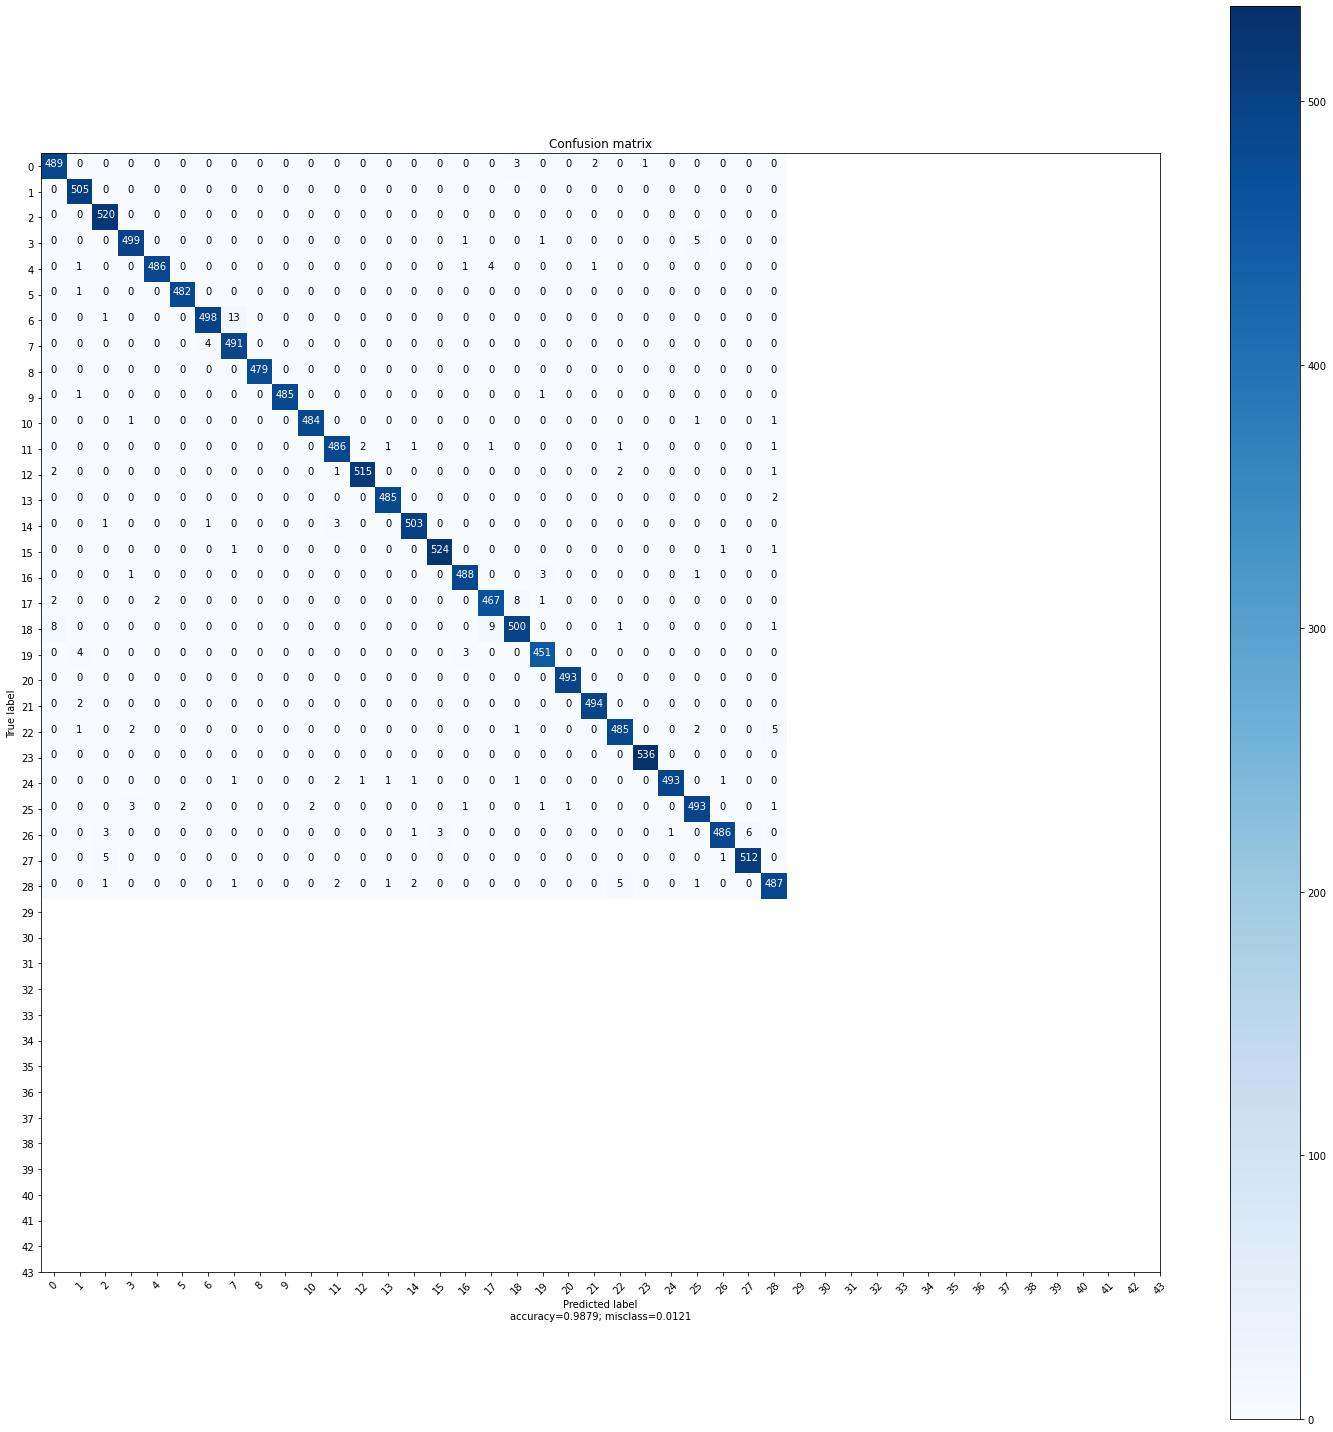

In [17]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import numpy as np
import time
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion_matrix.png')


image_x, image_y = 50, 50
with open("test_images", "rb") as f:
    test_images = np.array(pickle.load(f))
with open("test_labels", "rb") as f:
    test_labels = np.array(pickle.load(f), dtype=np.int32)
test_images = np.reshape(test_images, (test_images.shape[0], image_x, image_y, 1))


model = load_model('cnn_model_keras_guassian_dumm.h5')
pred_labels = []

start_time = time.time()
pred_probabs = model.predict(test_images)
end_time = time.time()
pred_time = end_time-start_time
avg_pred_time = pred_time/test_images.shape[0]
print("Time taken to predict %d test images is %ds" %(test_images.shape[0], pred_time))
print('Average prediction time: %fs' % (avg_pred_time))

for pred_probab in pred_probabs:
    pred_labels.append(list(pred_probab).index(max(pred_probab)))

cm = confusion_matrix(test_labels, np.array(pred_labels))
classification_report = classification_report(test_labels, np.array(pred_labels))
print('\n\nClassification Report') 
print('---------------------------')
print(classification_report)
plot_confusion_matrix(cm, range(44), normalize=False)

## Predict live data through web cam

In [3]:
import cv2, pickle
import numpy as np
import tensorflow as tf
import os
import sqlite3
from keras.models import load_model
import pyttsx3  
import string


engine = pyttsx3.init() 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)
prediction = None
model = load_model('cnn_model_keras_guassian.h5')

def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key
        else:
            return False
        
def get_image_size():
    img = cv2.imread('gestures_skinmask/1/100.jpg', 0)
    return img.shape

image_x, image_y = get_image_size()



def keras_process_image(img):
    img = cv2.resize(img, (image_x, image_y))
    img = np.array(img, dtype=np.float32)
    img = np.reshape(img, (1, image_x, image_y, 1))
    return img

def keras_predict(model, image):
    processed = keras_process_image(image)
    pred_probab = model.predict(processed)[0]
    pred_class = list(pred_probab).index(max(pred_probab))
    return max(pred_probab), pred_class

def get_pred_text_from_db(pred_class):
    conn = sqlite3.connect("gesture_db.db")
    cmd = "SELECT g_name FROM gesture WHERE g_id="+str(pred_class)
    cursor = conn.execute(cmd)
    for row in cursor:
        return row[0]

def split_sentence(text, num_of_words):
    '''
    Splits a text into group of num_of_words
    '''
    list_words = text.split(" ")
    length = len(list_words)
    splitted_sentence = []
    b_index = 0
    e_index = num_of_words
    while length > 0:
        part = ""
        for word in list_words[b_index:e_index]:
            part = part + " " + word
        splitted_sentence.append(part)
        b_index += num_of_words
        e_index += num_of_words
        length -= num_of_words
    return splitted_sentence

def put_splitted_text_in_blackboard(blackboard, splitted_text):
    y = 200
    for text in splitted_text:
        cv2.putText(blackboard, text, (4, y), cv2.FONT_HERSHEY_TRIPLEX, 2, (255, 255, 255))
        y += 50

def get_hand_hist():
    with open("hist", "rb") as f:
        hist = pickle.load(f)
    return hist

def recognize():
    global prediction
    cam = cv2.VideoCapture(0)
    if cam.read()[0] == False:
        cam = cv2.VideoCapture(0)
    hist = get_hand_hist()
    x, y, w, h = 300, 100, 300, 300
    d = dict.fromkeys(string.ascii_lowercase, 0)
    d[''] = 0
    d['space'] = 0
    d['ok'] = 0
    word = []
    sentence = []
    while True:
        text = ""
        img = cam.read()[1]
        img = cv2.flip(img, 1)
        img = cv2.resize(img, (640, 480))
        imgCrop = img[y:y+h, x:x+w]
        imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([imgHSV], [0, 1], hist, [0, 180, 0, 256], 1)
        disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
        cv2.filter2D(dst,-1,disc,dst)
        blur = cv2.GaussianBlur(dst, (11,11), 0)
        blur = cv2.medianBlur(blur, 11)
        th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        thresh = cv2.threshold(th3, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
        thresh = cv2.merge((thresh,thresh,thresh))
        thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
        thresh = thresh[y:y+h, x:x+w]
        
        (openCV_ver,_,__) = cv2.__version__.split(".")
        if openCV_ver=='3':
            contours = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[1]
        elif openCV_ver=='4':
            contours = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
        if len(contours) > 0:
            contour = max(contours, key = cv2.contourArea)
            #print(cv2.contourArea(contour))
            if cv2.contourArea(contour) > 10000:
                x1, y1, w1, h1 = cv2.boundingRect(contour)
                save_img = thresh[y1:y1+h1, x1:x1+w1]

                if w1 > h1:
                    save_img = cv2.copyMakeBorder(save_img, int((w1-h1)/2) , int((w1-h1)/2) , 0, 0, cv2.BORDER_CONSTANT, (0, 0, 0))
                elif h1 > w1:
                    save_img = cv2.copyMakeBorder(save_img, 0, 0, int((h1-w1)/2) , int((h1-w1)/2) , cv2.BORDER_CONSTANT, (0, 0, 0))
    
                pred_probab, pred_class = keras_predict(model, save_img)
                
                text = get_pred_text_from_db(pred_class)           
                
                print(f"{pred_probab}, {text}")
        
        #cv2.putText(blackboard, text, (30, 200), cv2.FONT_HERSHEY_TRIPLEX, 1.3, (255, 255, 255))
        cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
        res = np.hstack((img, blackboard))
        cv2.putText(img, text, (30, 200), cv2.FONT_HERSHEY_TRIPLEX, 1.3, (255, 255, 255))
        cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
        res = np.hstack((img, blackboard))  
        cv2.imshow("Recognizing gesture", res)
        cv2.imshow("thresh", thresh)
        if cv2.waitKey(1) == ord('z'):
            break

#keras_predict(model, np.zeros((50, 50), dtype=np.uint8))
recognize()
cv2.destroyAllWindows()

0.043461576104164124, s
0.05441504716873169, s
0.05112065374851227, s
0.05069420114159584, s
0.04226052016019821, k
0.04680892825126648, s
0.04325701296329498, s
0.04321485757827759, s
0.04240954667329788, s
0.03950173035264015, k
0.04462737590074539, s
0.04225754365324974, k
0.04602742940187454, s
0.04371672868728638, s
0.0484832227230072, s
0.06369464844465256, s
0.06438563764095306, s
0.057413604110479355, s
0.10746271163225174, s
0.08088567852973938, a
0.0943780466914177, s
0.10369306802749634, s
0.09690157324075699, t
0.09905318170785904, s
0.12592320144176483, s
0.07099761813879013, s
0.09207643568515778, s
0.07273105531930923, s
0.08693782240152359, s
0.06642746180295944, a
0.07682587951421738, s
0.04715624079108238, s
0.08202062547206879, s
0.06883547455072403, x
0.05871787294745445, s
0.05486242100596428, a
0.06200255826115608, t
0.06429252028465271, s
0.07272077351808548, s
0.07267805188894272, t
0.07378510385751724, s
0.06293240189552307, s
0.06607049703598022, s
0.068752087

0.0793454647064209, s
0.08865784853696823, s
0.08296895772218704, s
0.06698670983314514, s
0.06967287510633469, s
0.07016508281230927, s
0.06470086425542831, s
0.056632474064826965, s
0.08736845850944519, s


In [1]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [12]:
import pyttsx3  
# initialize Text-to-speech engine  
engine = pyttsx3.init()  
# convert this text to speech  
text = "Python is a great programming language"  
engine.say(text)  
# play the speech  
engine.runAndWait() 

In [5]:
import string
d = dict.fromkeys(string.ascii_lowercase, 0)
print(d)

{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0, 'f': 0, 'g': 0, 'h': 0, 'i': 0, 'j': 0, 'k': 0, 'l': 0, 'm': 0, 'n': 0, 'o': 0, 'p': 0, 'q': 0, 'r': 0, 's': 0, 't': 0, 'u': 0, 'v': 0, 'w': 0, 'x': 0, 'y': 0, 'z': 0}


In [1]:
d = dict.fromkeys(string.ascii_lowercase, 0)
text = ' '.join([str(elem) for elem in word])

NameError: name 'string' is not defined

In [8]:
import pandas as pd
import sqlite3
import sqlalchemy 

try:
    conn = sqlite3.connect("gesture_db.db")    
except Error as e:
    print(e)

#Now in order to read in pandas dataframe we need to know table name
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(f"Table Name : {cursor.fetchall()}")

df = pd.read_sql_query('SELECT * FROM gesture', conn)
print(df)
conn.close()

Table Name : [('gesture',), ('sqlite_sequence',)]
      g_id   g_name
0        0     test
1        1        a
2        2        b
3        3        c
4        4        d
5        5        e
6        6        f
7        7        g
8        8        h
9        9        i
10      10        k
11      11        l
12      12        m
13      13        n
14      14        o
15      15        p
16      16        q
17      17        r
18      18        s
19      19        t
20      20        u
21      21        v
22      22        w
23      23        x
24      24        y
25      25    space
26      26       ok
27      27        j
28      28        z
29      29   cancel
30      30      ere
31      34       fa
32      35     fghf
33      39     grrs
34      42       fa
35      45       fs
36      90       as
37     212     afae
38     232   dfbgdf
39     242    wefwe
40     342      esf
41     343       af
42     344    sdgsg
43     345      dgf
44     352     fgef
45    1231     efwf
46    3535

## Get Skin masking histograph

In [2]:
import cv2
import numpy as np
import pickle

def build_squares(img):
    x, y, w, h = 450, 50, 10, 10
    d = 10
    imgCrop = None
    crop = None
    for i in range(10):
        for j in range(5):
            if np.any(imgCrop == None):
                imgCrop = img[y:y+h, x:x+w]
            else:
                imgCrop = np.hstack((imgCrop, img[y:y+h, x:x+w]))
            #print(imgCrop.shape)
            cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 1)
            x+=w+d
        if np.any(crop == None):
            crop = imgCrop
        else:
            crop = np.vstack((crop, imgCrop)) 
        imgCrop = None
        x = 450
        y+=h+d
    return crop


def get_hand_hist():
    cam = cv2.VideoCapture(0)
    if cam.read()[0]==False:
        cam = cv2.VideoCapture(0)
    x, y, w, h = 300, 50, 10, 10
    flagPressedC, flagPressedS = False, False
    imgCrop = None
    while True:
        img = cam.read()[1]
        img = cv2.flip(img, 1)
        img = cv2.resize(img, (640, 480))
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        keypress = cv2.waitKey(1)
        if keypress == ord('c'):
            hsvCrop = cv2.cvtColor(imgCrop, cv2.COLOR_BGR2HSV)
            flagPressedC = True
            hist = cv2.calcHist([hsvCrop], [0, 1], None, [180, 256], [0, 180, 0, 256])
            cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)
        elif keypress == ord('s'):
            flagPressedS = True	
            break
        if flagPressedC:
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            dst = cv2.calcBackProject([hsv], [0, 1], hist, [0, 180, 0, 256], 1)
            disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31))
            cv2.filter2D(dst, -1, disc, dst)
            ret, thresh = cv2.threshold(dst, 150, 255, cv2.THRESH_BINARY)
            # thresh = cv2.dilate(thresh, None, iterations=5)
            thresh = cv2.merge((thresh, thresh, thresh))
            img = cv2.bitwise_and(img, thresh)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        
            blur = cv2.GaussianBlur(gray,(5,5),2)
            th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
            ret, thresh = cv2.threshold(th3, 78, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
            #cv2.imshow("res", res)
            cv2.imshow("Thresh", thresh)
            #cv2.imshow("SkinMasking", img)
        if not flagPressedS:
            imgCrop = build_squares(img)
        if keypress == 27:
            cv2.destroyAllWindows()
            break
        #cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.imshow("Set hand histogram", img)
    cam.release()
    cv2.destroyAllWindows()
    with open("hist", "wb") as f:
        pickle.dump(hist, f)


get_hand_hist()

## Create gesture (Guassian blur with skin masking)

In [3]:
import cv2
import numpy as np
import pickle, os, sqlite3, random

image_x, image_y = 50, 50

def get_hand_hist():
    with open("hist", "rb") as f:
        hist = pickle.load(f)
    return hist

def init_create_folder_database():
    if not os.path.exists("gestures_skinmask"):
        os.mkdir("gestures_skinmask")
    if not os.path.exists("gesture_db.db"):
        conn = sqlite3.connect("gesture_db.db")
        create_table_cmd = "CREATE TABLE gesture ( g_id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, g_name TEXT NOT NULL )"
        conn.execute(create_table_cmd)
        conn.commit()

def create_folder(folder_name):
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)

def store_in_db(g_id, g_name):
    conn = sqlite3.connect("gesture_db.db")
    cmd = "INSERT INTO gesture (g_id, g_name) VALUES (%s, \'%s\')" % (g_id, g_name)
    try:
        conn.execute(cmd)
    except sqlite3.IntegrityError:
        choice = input("g_id already exists. Want to change the record? (y/n): ")
        if choice.lower() == 'y':
            cmd = "UPDATE gesture SET g_name = \'%s\' WHERE g_id = %s" % (g_name, g_id)
            conn.execute(cmd)
        else:
            print("Doing nothing...")
            return
    conn.commit()

    
def store_images(g_id):
    total_pics = 6000
    cam = cv2.VideoCapture(0)
    if cam.read()[0]==False:
        cam = cv2.VideoCapture(0)
    x, y, w, h = 300, 50, 300, 300
    create_folder("gestures_skinmask/"+str(g_id))
    pic_no = 0
    flag_start_capturing = False
    frames = 0
    hist = get_hand_hist()
    while True:
        img = cam.read()[1]
        img1 = cv2.flip(img, 1)
        imgHSV = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
        imghsv = imgHSV[y:y+h, x:x+w]
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv], [0, 1], hist, [0, 180, 0, 256], 1)
        disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31))
        cv2.filter2D(dst, -1, disc, dst)
        ret, thresh = cv2.threshold(dst, 150, 255, cv2.THRESH_BINARY)
        # thresh = cv2.dilate(thresh, None, iterations=5)
        thresh = cv2.merge((thresh, thresh, thresh))
        img = cv2.bitwise_and(img1, thresh)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        
        blur = cv2.GaussianBlur(gray,(5,5),2)
        th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        ret, thresh = cv2.threshold(th3, 78, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
       # ret, thresh = cv2.threshold(th3, 78, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        thresh = thresh[y:y+h, x:x+w]
        tmp = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        contours = tmp[0] if len(tmp) == 2 else tmp[1]

        if len(contours) > 0:
            contour = max(contours, key = cv2.contourArea)
            if cv2.contourArea(contour) > 10000 and frames > 50:
                x1, y1, w1, h1 = cv2.boundingRect(contour)
                pic_no += 1
                save_img = thresh[y1:y1+h1, x1:x1+w1]
                if w1 > h1:
                    save_img = cv2.copyMakeBorder(save_img, int((w1-h1)/2) , int((w1-h1)/2) , 0, 0, cv2.BORDER_CONSTANT, (0, 0, 0))
                elif h1 > w1:
                    save_img = cv2.copyMakeBorder(save_img, 0, 0, int((h1-w1)/2) , int((h1-w1)/2) , cv2.BORDER_CONSTANT, (0, 0, 0))
                save_img = cv2.resize(save_img, (image_x, image_y))
                rand = random.randint(0, 10)
                if rand % 2 == 0:
                    save_img = cv2.flip(save_img, 1)
                cv2.putText(img, "Capturing gesture", (30, 60), cv2.FONT_HERSHEY_TRIPLEX, 2, (127, 255, 255))
                cv2.imwrite("gestures_skinmask/"+str(g_id)+"/"+str(pic_no)+".jpg", save_img)

        cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(img, str(pic_no), (30, 400), cv2.FONT_HERSHEY_TRIPLEX, 1.5, (127, 127, 255))
        cv2.imshow("Capturing gesture", img1)
        cv2.imshow("thresh", thresh)
        keypress = cv2.waitKey(1)
        if keypress == ord('c'):
            if flag_start_capturing == False:
                flag_start_capturing = True
            else:
                flag_start_capturing = False
                frames = 0
        if flag_start_capturing == True:
            frames += 1
        if pic_no == total_pics:
            cv2.destroyAllWindows()
            break
        if keypress == 27:
            cv2.destroyAllWindows()
            break

init_create_folder_database()
g_id = input("Enter gesture no.: ")
g_name = input("Enter gesture name/text: ")
store_in_db(g_id, g_name)
store_images(g_id)


Enter gesture no.: 45
Enter gesture name/text: helllo
g_id already exists. Want to change the record? (y/n): y


## GUI

In [18]:
from PIL import Image, ImageTk
import tkinter as tk
import cv2
import os
import numpy as np
import operator
import time
import sys, os
import tensorflow as tf
import string
import pickle, os, sqlite3, random
from keras.models import load_model
import pyttsx3
from google_trans_new import google_translator  
from gtts import gTTS  
from playsound import playsound  
import googletrans
from googletrans import Translator
from ttkthemes import ThemedTk


class Model:
    
    def __init__(self):
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
        tf.logging.set_verbosity(tf.logging.ERROR)
        self.prediction = None
        self.model = load_model('cnn_model_keras_guassian_dumm.h5')
    
    def get_image_size(self):
        img = cv2.imread('gestures2/1/100.jpg', 0)
        return img.shape
    
    def keras_process_image(self, img):
        image_x, image_y = self.get_image_size()
        img = cv2.resize(img, (image_x, image_y))
        img = np.array(img, dtype=np.float32)
        img = np.reshape(img, (1, image_x, image_y, 1))
        return img

    def keras_predict(self, image):
        self.processed = self.keras_process_image(image)
        self.pred_probab = self.model.predict(self.processed)[0]
        self.pred_class = list(self.pred_probab).index(max(self.pred_probab))
        return max(self.pred_probab), self.pred_class

    def get_pred_text_from_db(self, pred_class):
        conn = sqlite3.connect("gesture_db.db")
        cmd = "SELECT g_name FROM gesture WHERE g_id="+str(pred_class)
        cursor = conn.execute(cmd)
        for row in cursor:
            return row[0]

class Application(Model):
    
    def __init__(self):
        #self.root = tk.Tk()
        self.root = ThemedTk(theme='keramik')
        #self.root.configure(background="grey")
        self.root.title("SLR")
        self.root.protocol('WM_DELETE_WINDOW', self.destructor)
        self.root.geometry("500x500")
        self.panel_title = tk.Label(self.root, text = 'Sign Language Recognition using CNN', font = ("Times", 15)) 
        self.panel_title.pack()
        self.button = tk.Button(self.root , text = "Start", bg="grey", fg="white", command = self.start)
        self.button.place(x=200, y=200, height=50, width=100)
        self.button1 = tk.Button(self.root , text = "Skin Masking", bg='grey', fg="white", command = self.get_hand_hist)
        self.button1.place(x=200, y=260, height=50, width=100)
        self.flag = 0
    
    def start(self):
        #tk.Frame.__init__(self, parent)
        self.flag = 1
        self.button.pack_forget()
        self.button1.pack_forget()
        self.panel_title.pack_forget()
        super().__init__()
        self.engine = pyttsx3.init() 
        self.vs = cv2.VideoCapture(0)
        self.current_image = None
        self.current_image2 = None
        
        print("Loaded model from disk")
        #self.root = tk.Tk()
        #self.root.title("Sign language Recognition using CNN")
        #self.root.protocol('WM_DELETE_WINDOW', self.destructor)
        self.root.geometry("1500x650")
        self.panel = tk.Label(self.root)
        self.panel.place(x = 135, y = -30, width = 640, height = 640)
        self.panel2 = tk.Label(self.root) # initialize image panel
        self.panel2.place(x = 460, y = 55, width = 310, height = 310)
        
        self.T = tk.Label(self.root)
        self.T.place(x=31,y = 17)
        
        # Recognized text
        self.panel3 = tk.Label(self.root, text = 'Text conversion:', anchor = "w", font = ("Times", 30)) 
        self.panel3.place(x = 780, y=40, width = 400, height = 50)
        
        self.panel8 = tk.Label(self.root, text = 'Characters:', anchor = "w", font = ("Times", 20)) 
        self.panel8.place(x = 780, y=90, width = 400, height = 50)
        
        self.panel9 = tk.Label(self.root, text = 'Words:', anchor = "w", font = ("Times", 20)) 
        self.panel9.place(x = 1130, y=90, width = 400, height = 50)
        
        # letter
        self.panel4 = tk.Label(self.root, font = ("Times", 20), borderwidth=1, relief="solid") 
        self.panel4.place(x = 780, y=130, width = 350, height = 100)
        
        # words
        self.panel5 = tk.Label(self.root, font = ("Times", 20), borderwidth=1, relief="solid") 
        self.panel5.place(x = 1130, y=130, width = 350, height = 100)
        
        # sentence
        self.panel6 = tk.Label(self.root, font = ("Times", 20), borderwidth=1, relief="solid") 
        self.panel6.place(x = 780, y=280, width = 700, height = 100)
        
        self.panel10 = tk.Label(self.root, text="Sentences:", anchor="w", font = ("Times", 20)) 
        self.panel10.place(x = 780, y=230, width = 700, height = 50)
        
        # translated text
        self.panel7 = tk.Label(self.root, text='Translated text:', anchor='w', font = ("Times", 30), borderwidth=1, relief="solid") 
        self.panel7.place(x = 780, y=400, width = 700, height = 50)
        
        # translated text
        self.panel7 = tk.Label(self.root, font = ("Times", 20), borderwidth=1, relief="solid") 
        self.panel7.place(x = 780, y=450, width = 700, height = 100)
        
        #languages
        self.language_options = list(googletrans.LANGUAGES.values())
        self.clicked = tk.StringVar()
        self.clicked.set("english")
        self.choose_lang = tk.OptionMenu(self.root , self.clicked , *self.language_options )
        self.choose_lang.place(x=1100, y=410)
        self.lang = self.clicked.get()
        print(self.lang)
        self.button = tk.Button(self.root , text = "click to select language", command = self.show)
        self.button.place(x=1250, y = 410)
        
        
        
        #self.canvas = tk.Canvas(self.panel3 ,width=2*450, height=600, bg="black", highlightthickness=1, highlightbackground="white")
        #self.canvas.place(x=-(640 / 2), y=-(640 / 2))
        #self.canvas.pack()
        #self.canvas_id = self.canvas.create_text(300, 300, anchor="nw", fill="white", font=('Times 15 bold'))
        #self.canvas.create_text(100,10, text="Hello World!")

        #self.T.config(text = "Sign language Recognition using CNN",font=("courier",40,"bold"))
        # self.bt5.grid(row = 5, column = 1, columnspan = 1, padx = 10, pady = 10, sticky = tk.N)
        self.d = dict.fromkeys(string.ascii_lowercase, 0)
        self.d[''] = 0
        self.d['space'] = 0
        self.d['ok'] = 0
        self.d['cancel'] = 0
        self.word = []
        self.sentence = ''
        self.photo="Empty"
        #self.x_word = 280
        #self.y_word = 330
        #self.x_sentence = 300
        #self.y_sentence = 20
        self.str = ''
        #self.cc = self.canvas.create_text(self.x_word, self.y_word, text=' ', fill="white",font=('Times 15 bold'))
        #self.cc2 = self.canvas.create_text(self.x_sentence, self.y_sentence, text=' ', fill="white",font=('Times 15 bold'))
        with open("hist", "rb") as f:
            self.hist = pickle.load(f)
        self.video_loop()     

    def get_key(self, val, my_dict):
        for key, value in my_dict.items():
            if val == value:
                return key
        return False


    def show(self):
        temp = self.clicked.get()
        print(temp)
        self.lang = self.get_key(temp, googletrans.LANGUAGES)
        print(self.lang)
    
    def video_loop(self):
        ok, frame = self.vs.read()
        if ok:
            cv2image = cv2.flip(frame, 1)
            x1 = int(0.5*frame.shape[1])
            y1 = 10
            x2 = frame.shape[1]-10
            y2 = int(0.5*frame.shape[1])
            cv2.rectangle(frame, (x1-1, y1-1), (x2+1, y2+1), (255,0,0) ,1)
            cv2image1 = cv2.cvtColor(cv2image, cv2.COLOR_BGR2RGBA)
            self.current_image = Image.fromarray(cv2image1)
            imgtk = ImageTk.PhotoImage(image=self.current_image)
            self.panel.imgtk = imgtk
            self.panel.config(image=imgtk)
            cv2image = cv2image[y1:y2, x1:x2]
            hsv = cv2.cvtColor(cv2image, cv2.COLOR_BGR2HSV)
            dst = cv2.calcBackProject([hsv], [0, 1], self.hist, [0, 180, 0, 256], 1)
            disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31))
            cv2.filter2D(dst, -1, disc, dst)
            ret, thresh = cv2.threshold(dst, 150, 255, cv2.THRESH_BINARY)
            thresh = cv2.merge((thresh, thresh, thresh))
            img = cv2.bitwise_and(cv2image, thresh)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        
            blur = cv2.GaussianBlur(gray,(5,5),2)
            th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
            ret, thresh = cv2.threshold(th3, 78, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)           
            self.current_image2 = Image.fromarray(thresh)
            imgtk = ImageTk.PhotoImage(image=self.current_image2)
            self.panel2.imgtk = imgtk
            self.panel2.config(image=imgtk)
            (openCV_ver,_,__) = cv2.__version__.split(".")
            if openCV_ver=='3':
                contours = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[1]
            elif openCV_ver=='4':
                contours = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
            if len(contours) > 0:
                contour = max(contours, key = cv2.contourArea)
                #print(cv2.contourArea(contour))
                if cv2.contourArea(contour) > 10000:
                    x1, y1, w1, h1 = cv2.boundingRect(contour)
                    save_img = thresh[y1:y1+h1, x1:x1+w1]

                    if w1 > h1:
                        save_img = cv2.copyMakeBorder(save_img, int((w1-h1)/2) , int((w1-h1)/2) , 0, 0, cv2.BORDER_CONSTANT, (0, 0, 0))
                    elif h1 > w1:
                        save_img = cv2.copyMakeBorder(save_img, 0, 0, int((h1-w1)/2) , int((h1-w1)/2) , cv2.BORDER_CONSTANT, (0, 0, 0))

                    pred_probab, pred_class = super().keras_predict(save_img)

                    if pred_probab*100 > 96:
                        text = super().get_pred_text_from_db(pred_class)
                        #print(text)
                        #engine.say(text) 
                        #engine.runAndWait()
                        
                        #self.canvas.insert(self.canvas_id, 30, "new")
                        #self.canvas.itemconfig(self.canvas_id, text=f"{text}-{pred_probab}-{self.d[text]}")
                        #self.canvas.create_text(300, 50, text= text,fill="black",font=('Times 15 bold'))
                        
                        self.panel4.config(text = f"{text}--{self.d[text]}")
                        
                        if text == '':
                            pass
                        if text == 'ok' and self.d['ok'] == 5 and len(self.sentence) != 0:
                            print(self.sentence)
                            self.engine.say(self.sentence) 
                            self.engine.runAndWait()
                            translator = google_translator()  
                            self.d = dict.fromkeys(self.d, 0)
                            try :
                                translate_text = translator.translate(self.sentence, lang_tgt=self.lang, pronounce=True)  
                                obj = gTTS(text=translate_text[2], lang=self.lang, slow=False) 
                                print(self.lang)
                                #print(translate_text[2])
                                self.panel7.config(text = translate_text[0])
                                os.remove("exam.mp3")
                                obj.save("exam.mp3")    
                                playsound("exam.mp3")
                            except ValueError:
                                self.panel7.config(text = f"ValueError: Language not supported for audio:{translate_text[2]} ")
                            except AssertionError:
                                self.panel7.config(text = translate_text[0])
                            self.sentence = ''
                        
                        if text == 'space' and self.d['space'] == 5:
                            #self.canvas.delete(self.cc)
                            #self.canvas.delete(self.cc2)
                            self.sentence += ' '
                            self.sentence += self.str
                            #self.cc2 = self.canvas.create_text(self.x_sentence, self.y_sentence, text= self.sentence, fill="white",font=('Times 15 bold'))
                            self.panel6.config(text = self.sentence)
                            print(self.str)
                            self.d = dict.fromkeys(self.d, 0)
                            self.engine.say(self.str) 
                            self.engine.runAndWait()
                            self.str = ''
                            
                        if text == 'cancel' and self.d['cancel'] == 5:
                            #self.canvas.delete(self.cc)
                            if(self.str==""):
                                self.engine.say("nothing to remove") 
                                self.engine.runAndWait()
                            else:
                                temp = self.str[-1]
                                self.str = self.str[:-1]
                                self.panel5.config(text=self.str)
                                self.d = dict.fromkeys(self.d, 0)
                                #self.cc = self.canvas.create_text(self.x_word, self.y_word, text= self.str, fill="white",font=('Times 15 bold'))
                                self.engine.say(f"removed {temp}") 
                                self.engine.runAndWait()
                            self.d = dict.fromkeys(self.d, 0)

                        self.d[text] += 1
                        #print(d)
                        if self.d[text] == 10 and text != 'ok' and text != "cancel" and text != 'space':
                            #print(text)
                            #self.canvas.delete(self.cc)
                            self.str += text
                            self.panel5.config(text=self.str)
                           # self.cc = self.canvas.create_text(self.x_word, self.y_word, text= self.str, fill="white",font=('Times 15 bold'))
                            #self.x_word += 10
                            print(text)
                            self.d = dict.fromkeys(self.d, 0)
                            self.engine.say(text) 
                            self.engine.runAndWait()
             
        self.root.after(30, self.video_loop)
   
    def destructor(self):
        print("Closing Application...")
        self.root.destroy()
        if (self.flag == 1):
            self.vs.release()
            cv2.destroyAllWindows()
    
    def destructor1(self):
        print("Closing Application...")
        self.root1.destroy()

    def action_call(self) :
        self.root1 = tk.Toplevel(self.root)
        self.root1.title("About")
        self.root1.protocol('WM_DELETE_WINDOW', self.destructor1)
        self.root1.geometry("20x20")
        self.tx = tk.Label(self.root1)
        self.tx.place(x = 330,y = 20)
        self.tx.config(text = "Efforts By", fg="red", font = ("Courier",30,"bold"))
        
    
    def build_squares(self, img):
        x, y, w, h = 450, 50, 10, 10
        d = 10
        imgCrop = None
        crop = None
        for i in range(10):
            for j in range(5):
                if np.any(imgCrop == None):
                    imgCrop = img[y:y+h, x:x+w]
                else:
                    imgCrop = np.hstack((imgCrop, img[y:y+h, x:x+w]))
                #print(imgCrop.shape)
                cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 1)
                x+=w+d
            if np.any(crop == None):
                crop = imgCrop
            else:
                crop = np.vstack((crop, imgCrop)) 
            imgCrop = None
            x = 450
            y+=h+d
        return crop


    def get_hand_hist(self):
        cam = cv2.VideoCapture(0)
        if cam.read()[0]==False:
            cam = cv2.VideoCapture(0)
        x, y, w, h = 300, 50, 10, 10
        flagPressedC, flagPressedS = False, False
        imgCrop = None
        while True:
            img = cam.read()[1]
            img = cv2.flip(img, 1)
            img = cv2.resize(img, (640, 480))
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

            keypress = cv2.waitKey(1)
            if keypress == ord('c'):
                hsvCrop = cv2.cvtColor(imgCrop, cv2.COLOR_BGR2HSV)
                flagPressedC = True
                hist = cv2.calcHist([hsvCrop], [0, 1], None, [180, 256], [0, 180, 0, 256])
                cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)
            elif keypress == ord('s'):
                flagPressedS = True	
                break
            if flagPressedC:
                hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                dst = cv2.calcBackProject([hsv], [0, 1], hist, [0, 180, 0, 256], 1)
                disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31))
                cv2.filter2D(dst, -1, disc, dst)
                ret, thresh = cv2.threshold(dst, 150, 255, cv2.THRESH_BINARY)
                # thresh = cv2.dilate(thresh, None, iterations=5)
                thresh = cv2.merge((thresh, thresh, thresh))
                img = cv2.bitwise_and(img, thresh)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        
                blur = cv2.GaussianBlur(gray,(5,5),2)
                th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
                ret, thresh = cv2.threshold(th3, 78, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
                #cv2.imshow("res", res)
                cv2.imshow("Thresh", thresh)
                #cv2.imshow("SkinMasking", img)
            if not flagPressedS:
                imgCrop = self.build_squares(img)
            if keypress == 27:
                cv2.destroyAllWindows()
                break
            #cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
            cv2.imshow("Set hand histogram", img)
        cam.release()
        cv2.destroyAllWindows()
        with open("hist", "wb") as f:
            pickle.dump(hist, f)
        
print("Starting Application...")
pba = Application()
pba.root.mainloop()

Starting Application...


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\admin\.conda\envs\SignLanguage\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "<ipython-input-18-6a150a560cb7>", line 403, in get_hand_hist
    pickle.dump(hist, f)
UnboundLocalError: local variable 'hist' referenced before assignment


Closing Application...


In [9]:
from tkinter import *

ws = Tk()
ws.title("Border")
ws.geometry("50x100")

l = Label(ws, text="Left", anchor=W)

l.config(text="\n efksl")
l.pack(fill='both')
ws.mainloop()

In [21]:
import pandas as pd
import googletrans
from googletrans import Translator
 
pd.set_option('max_colwidth', 300)



#how to get the supported language and their corresponing code
lang_df = pd.DataFrame.from_dict(googletrans.LANGUAGES,  orient='index', columns=['Language'])
print(googletrans.LANGUAGES)
#print(list(googletrans.LANGUAGES.values()))

{'af': 'afrikaans', 'sq': 'albanian', 'am': 'amharic', 'ar': 'arabic', 'hy': 'armenian', 'az': 'azerbaijani', 'eu': 'basque', 'be': 'belarusian', 'bn': 'bengali', 'bs': 'bosnian', 'bg': 'bulgarian', 'ca': 'catalan', 'ceb': 'cebuano', 'ny': 'chichewa', 'zh-cn': 'chinese (simplified)', 'zh-tw': 'chinese (traditional)', 'co': 'corsican', 'hr': 'croatian', 'cs': 'czech', 'da': 'danish', 'nl': 'dutch', 'en': 'english', 'eo': 'esperanto', 'et': 'estonian', 'tl': 'filipino', 'fi': 'finnish', 'fr': 'french', 'fy': 'frisian', 'gl': 'galician', 'ka': 'georgian', 'de': 'german', 'el': 'greek', 'gu': 'gujarati', 'ht': 'haitian creole', 'ha': 'hausa', 'haw': 'hawaiian', 'iw': 'hebrew', 'he': 'hebrew', 'hi': 'hindi', 'hmn': 'hmong', 'hu': 'hungarian', 'is': 'icelandic', 'ig': 'igbo', 'id': 'indonesian', 'ga': 'irish', 'it': 'italian', 'ja': 'japanese', 'jw': 'javanese', 'kn': 'kannada', 'kk': 'kazakh', 'km': 'khmer', 'ko': 'korean', 'ku': 'kurdish (kurmanji)', 'ky': 'kyrgyz', 'lo': 'lao', 'la': 'lat

In [14]:

import pyttsx3
from google.cloud import speech_v1 as speech
from gtts import gTTS  
from playsound import playsound  
from google_trans_new import google_translator  
import os
os.remove("exam.mp3")

translator = google_translator()  
translate_text = translator.translate('who are you?',lang_tgt='ja', pronounce=True)  
print(translate_text)
#print(translate_text)
obj = gTTS(text=translate_text[2], lang='ja', slow=False) 
obj.save("exam.mp3")    
playsound("exam.mp3") 

['あなたは誰？ ', None, 'Anatahadare?']


In [23]:
def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key
    return False
get_key('french', googletrans.LANGUAGES)

'fr'

In [4]:
print("aejfn\noweifjo")

aejfn
oweifjo


In [1]:
import tkinter
# Lots of tutorials have from tkinter import *, but that is pretty much always a bad idea
from tkinter import ttk
import abc

class Menubar(ttk.Frame):
    """Builds a menu bar for the top of the main window"""
    def __init__(self, parent, *args, **kwargs):
        ''' Constructor'''
        ttk.Frame.__init__(self, parent, *args, **kwargs)
        self.root = parent
        self.init_menubar()

    def on_exit(self):
        '''Exits program'''
        quit()

    def display_help(self):
        '''Displays help document'''
        pass

    def display_about(self):
        '''Displays info about program'''
        pass

    def init_menubar(self):
        self.menubar = tkinter.Menu(self.root)
        self.menu_file = tkinter.Menu(self.menubar) # Creates a "File" menu
        self.menu_file.add_command(label='Exit', command=self.on_exit) # Adds an option to the menu
        self.menubar.add_cascade(menu=self.menu_file, label='File') # Adds File menu to the bar. Can also be used to create submenus.

        self.menu_help = tkinter.Menu(self.menubar) #Creates a "Help" menu
        self.menu_help.add_command(label='Help', command=self.display_help)
        self.menu_help.add_command(label='About', command=self.display_about)
        self.menubar.add_cascade(menu=self.menu_help, label='Help')

        self.root.config(menu=self.menubar)

class Window(ttk.Frame):
    """Abstract base class for a popup window"""
    __metaclass__ = abc.ABCMeta
    def __init__(self, parent):
        ''' Constructor '''
        ttk.Frame.__init__(self, parent)
        self.parent = parent
        self.parent.resizable(width=False, height=False) # Disallows window resizing
        self.validate_notempty = (self.register(self.notEmpty), '%P') # Creates Tcl wrapper for python function. %P = new contents of field after the edit.
        self.init_gui()

    @abc.abstractmethod # Must be overwriten by subclasses
    def init_gui(self):
        '''Initiates GUI of any popup window'''
        pass

    @abc.abstractmethod
    def do_something(self):
        '''Does something that all popup windows need to do'''
        pass

    def notEmpty(self, P):
        '''Validates Entry fields to ensure they aren't empty'''
        if P.strip():
            valid = True
        else:
            print("Error: Field must not be empty.") # Prints to console
            valid = False
        return valid

    def close_win(self):
        '''Closes window'''
        self.parent.destroy()

class SomethingWindow(Window):
    """ New popup window """

    def init_gui(self):
        self.parent.title("New Window")
        self.parent.columnconfigure(0, weight=1)
        self.parent.rowconfigure(3, weight=1)

        # Create Widgets

        self.label_title = ttk.Label(self.parent, text="This sure is a new window!")
        self.contentframe = ttk.Frame(self.parent, relief="sunken")

        self.label_test = ttk.Label(self.contentframe, text='Enter some text:')
        self.input_test = ttk.Entry(self.contentframe, width=30, validate='focusout', validatecommand=(self.validate_notempty))

        self.btn_do = ttk.Button(self.parent, text='Action', command=self.do_something)
        self.btn_cancel = ttk.Button(self.parent, text='Cancel', command=self.close_win)

        # Layout
        self.label_title.grid(row=0, column=0, columnspan=2, sticky='nsew')
        self.contentframe.grid(row=1, column=0, columnspan=2, sticky='nsew')

        self.label_test.grid(row=0, column=0)
        self.input_test.grid(row=0, column=1, sticky='w')

        self.btn_do.grid(row=2, column=0, sticky='e')
        self.btn_cancel.grid(row=2, column=1, sticky='e')

        # Padding
        for child in self.parent.winfo_children():
            child.grid_configure(padx=10, pady=5)
        for child in self.contentframe.winfo_children():
            child.grid_configure(padx=5, pady=2)

    def do_something(self):
        '''Does something'''
        text = self.input_test.get().strip()
        if text:
            # Do things with text
            self.close_win()
        else:
            print("Error: But for real though, field must not be empty.")

class GUI(ttk.Frame):
    """Main GUI class"""
    def __init__(self, parent, *args, **kwargs):
        ttk.Frame.__init__(self, parent, *args, **kwargs)
        self.root = parent
        self.init_gui()

    def openwindow(self):
        self.new_win = tkinter.Toplevel(self.root) # Set parent
        SomethingWindow(self.new_win)

    def init_gui(self):
        self.root.title('Test GUI')
        self.root.geometry("600x400")
        self.grid(column=0, row=0, sticky='nsew')
        self.grid_columnconfigure(0, weight=1) # Allows column to stretch upon resizing
        self.grid_rowconfigure(0, weight=1) # Same with row
        self.root.grid_columnconfigure(0, weight=1)
        self.root.grid_rowconfigure(0, weight=1)
        self.root.option_add('*tearOff', 'FALSE') # Disables ability to tear menu bar into own window

        # Create Widgets
        self.btn = ttk.Button(self, text='Open Window', command=self.openwindow)

        # Layout using grid
        self.btn.grid(row=0, column=0, sticky='ew')

        # Padding
        for child in self.winfo_children():
            child.grid_configure(padx=10, pady=5)

if __name__ == '__main__':
    root = tkinter.Tk()
    GUI(root)
    root.mainloop()

In [3]:
pip install ttkthemes


  Using cached ttkthemes-3.2.2.tar.gz (891 kB)
  Created wheel for ttkthemes: filename=ttkthemes-3.2.2-cp37-cp37m-win_amd64.whl size=1963895 sha256=908b7bde63127687757c6dff42904c5f2e89cbce090c5c4d14406fd92fe2b24c
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\d5\2c\3a\05044128642eb3ef61245afec2859c22fc3f16923ba0b3dea4
Successfully built ttkthemes


In [9]:
# You have to use Ttk (Themed Tk) widgets, because the simple Tkinter widgets don't support the use of themes
from tkinter import ttk

# From the ttkthemes package import the ThemedTk widget
from ttkthemes import ThemedTk

# Creating a window, with theme
root = ThemedTk(theme='keramik')

# Get the available themes
print(root.get_themes())

# Creating a themed button
button = ttk.Button(root, text="Quit", command=root.destroy)
button.pack(pady=20)

root.mainloop()

['alt', 'radiance', 'elegance', 'scidpink', 'black', 'scidblue', 'arc', 'scidpurple', 'aquativo', 'smog', 'clearlooks', 'winnative', 'yaru', 'clam', 'ubuntu', 'default', 'scidgreen', 'plastik', 'adapta', 'keramik', 'kroc', 'classic', 'winxpblue', 'scidmint', 'xpnative', 'scidsand', 'breeze', 'keramik_alt', 'equilux', 'scidgrey', 'blue', 'vista', 'itft1']


In [35]:
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import ttk
import abc
import cv2
import os
import numpy as np
import operator
import time
import sys, os
import tensorflow as tf
import string
import pickle, os, sqlite3, random
from keras.models import load_model
import pyttsx3
from google_trans_new import google_translator  
from gtts import gTTS  
from playsound import playsound  
import googletrans
from googletrans import Translator

class Window(ttk.Frame):
    """Abstract base class for a popup window"""
    __metaclass__ = abc.ABCMeta
    def __init__(self, parent):
        ''' Constructor '''
        ttk.Frame.__init__(self, parent)
        self.parent = parent
        self.parent.resizable(width=False, height=False) # Disallows window resizing
        self.validate_notempty = (self.register(self.notEmpty), '%P') # Creates Tcl wrapper for python function. %P = new contents of field after the edit.
        self.init_gui()

    @abc.abstractmethod # Must be overwriten by subclasses
    def init_gui(self):
        '''Initiates GUI of any popup window'''
        pass

    @abc.abstractmethod
    def do_something(self):
        '''Does something that all popup windows need to do'''
        pass

    def notEmpty(self, P):
        '''Validates Entry fields to ensure they aren't empty'''
        if P.strip():
            valid = True
        else:
            print("Error: Field must not be empty.") # Prints to console
            valid = False
        return valid

    def close_win(self):
        '''Closes window'''
        self.parent.destroy()

class Model:
    
    def __init__(self):
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
        tf.logging.set_verbosity(tf.logging.ERROR)
        self.prediction = None
        self.model = load_model('cnn_model_keras_guassian_dumm.h5')
    
    def get_image_size(self):
        img = cv2.imread('gestures2/1/100.jpg', 0)
        return img.shape
    
    def keras_process_image(self, img):
        image_x, image_y = self.get_image_size()
        img = cv2.resize(img, (image_x, image_y))
        img = np.array(img, dtype=np.float32)
        img = np.reshape(img, (1, image_x, image_y, 1))
        return img

    def keras_predict(self, image):
        self.processed = self.keras_process_image(image)
        self.pred_probab = self.model.predict(self.processed)[0]
        self.pred_class = list(self.pred_probab).index(max(self.pred_probab))
        return max(self.pred_probab), self.pred_class

    def get_pred_text_from_db(self, pred_class):
        conn = sqlite3.connect("gesture_db.db")
        cmd = "SELECT g_name FROM gesture WHERE g_id="+str(pred_class)
        cursor = conn.execute(cmd)
        for row in cursor:
            return row[0]

        
class SomethingWindow(Window):
    """ New popup window """

    def init_gui(self):
        self.parent.title("Skin Masking")
        self.parent.geometry("1400x650")
        #self.parent.columnconfigure(0, weight=1)
        #self.parent.rowconfigure(3, weight=1)
        self.flag = False
        self.flag1 = False
        self.flag2 = False
        self.panel_cam = tk.Label(self.parent) # initialize image panel
        self.panel_cam.place(x = 10, y = 55, width = 690, height = 500)
        
        self.panel_cam1 = tk.Label(self.parent) # initialize image panel
        self.panel_cam1.place(x = 650, y = 55, width = 700, height = 500)
        
        self.button = tk.Button(self.parent , text = "Start", bg="grey", fg="white", command = self.state)
        self.button.place(x=200, y=550, height=50, width=100)
        self.button = tk.Button(self.parent , text = "Save", bg="grey", fg="white", command = self.view)
        self.button.place(x=320, y=550, height=50, width=100)
       # with open("hist", "rb") as f:
            #self.hist = pickle.load(f)
        #self.video_loop()
        self.get_hand_hist()        
    def state(self):
        self.flag = True
        self.flag1 = True

        
    def view(self):
        with open("hist", "wb") as f:
            pickle.dump(self.hist, f)
        self.flag = False
        self.flag2 = True
        
    def build_squares(self, img):
        x, y, w, h = 450, 50, 10, 10
        d = 10
        imgCrop = None
        crop = None
        for i in range(10):
            for j in range(5):
                if np.any(imgCrop == None):
                    imgCrop = img[y:y+h, x:x+w]
                else:
                    imgCrop = np.hstack((imgCrop, img[y:y+h, x:x+w]))
                #print(imgCrop.shape)
                cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 1)
                x+=w+d
            if np.any(crop == None):
                crop = imgCrop
            else:
                crop = np.vstack((crop, imgCrop)) 
            imgCrop = None
            x = 450
            y+=h+d
        return crop
        
    def get_hand_hist(self):
        self.cam = cv2.VideoCapture(0)
        if self.cam.read()[0]==False:
            self.cam = cv2.VideoCapture(0)
        x, y, w, h = 300, 50, 10, 10
        self.flagPressedC, self.flagPressedS = False, False
        self.imgCrop = None
        self.flag2 = False
        self.current_image = None
        self.current_image2 = None
        self.loop()
   
    def loop(self):
        img = self.cam.read()[1]
        img = cv2.flip(img, 1)
        
        img = cv2.resize(img, (640, 480))
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        keypress = cv2.waitKey(1)
        if self.flag1:
            if self.flag:
                
                hsvCrop = cv2.cvtColor(self.imgCrop, cv2.COLOR_BGR2HSV)
                self.hist = cv2.calcHist([hsvCrop], [0, 1], None, [180, 256], [0, 180, 0, 256])
                cv2.normalize(self.hist, self.hist, 0, 255, cv2.NORM_MINMAX)
                self.flag = False
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            dst = cv2.calcBackProject([hsv], [0, 1], self.hist, [0, 180, 0, 256], 1)
            disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31))
            cv2.filter2D(dst, -1, disc, dst)
            ret, thresh = cv2.threshold(dst, 150, 255, cv2.THRESH_BINARY)
            # thresh = cv2.dilate(thresh, None, iterations=5)
            thresh = cv2.merge((thresh, thresh, thresh))
            img = cv2.bitwise_and(img, thresh)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        
            blur = cv2.GaussianBlur(gray,(5,5),2)
            th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
            ret, self.thresh = cv2.threshold(th3, 78, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

            self.current_image2 = Image.fromarray(self.thresh)
            imgtk = ImageTk.PhotoImage(image=self.current_image2)
            self.panel_cam1.imgtk = imgtk
            self.panel_cam1.config(image=imgtk)

            #cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
            #cv2.imshow("Set hand histogram", img)
            
        if not self.flag2:
            self.imgCrop = self.build_squares(img)
            
        cv2image1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
        self.current_image = Image.fromarray(cv2image1)
        imgtk = ImageTk.PhotoImage(image=self.current_image)
        self.panel_cam.imgtk = imgtk
        self.panel_cam.config(image=imgtk)
        self.parent.after(30, self.loop)
         
            
    def destructor(self):
        print("Closing Application...")
        self.parent.destroy()
        self.cam.release()
        cv2.destroyAllWindows()
        

class Application(Model, ttk.Frame):
    
    def __init__(self, parent, *args, **kwargs):
        ttk.Frame.__init__(self, parent, *args, **kwargs)
        self.root = parent
        #self.root.configure(background="grey")
        self.root.title("SLR")
        self.root.protocol('WM_DELETE_WINDOW', self.destructor)
        self.root.geometry("500x500")
        self.panel_title = tk.Label(self.root, text = 'Sign Language Recognition using CNN', font = ("Times", 15)) 
        self.panel_title.pack()
        self.button = tk.Button(self.root , text = "Start", bg="grey", fg="white", command = self.start)
        self.button.place(x=200, y=200, height=50, width=100)
        self.button1 = tk.Button(self.root , text = "Skin Masking", bg='grey', fg="white", command = self.openwindow)
        self.button1.place(x=200, y=260, height=50, width=100)
        self.flag = 0
    
    def openwindow(self):
        self.new_win = tk.Toplevel(self.root) # Set parent
        SomethingWindow(self.new_win)
    
    def start(self):
        #tk.Frame.__init__(self, parent)
        self.flag = 1
        self.button.pack_forget()
        self.button1.pack_forget()
        self.panel_title.pack_forget()
        super().__init__()
        self.engine = pyttsx3.init() 
        self.vs = cv2.VideoCapture(0)
        self.current_image = None
        self.current_image2 = None
        
        print("Loaded model from disk")
        #self.root = tk.Tk()
        #self.root.title("Sign language Recognition using CNN")
        #self.root.protocol('WM_DELETE_WINDOW', self.destructor)
        self.root.geometry("1500x650")
        self.panel = tk.Label(self.root)
        self.panel.place(x = 135, y = -30, width = 640, height = 640)
        self.panel2 = tk.Label(self.root) # initialize image panel
        self.panel2.place(x = 460, y = 55, width = 310, height = 310)
        
        self.T = tk.Label(self.root)
        self.T.place(x=31,y = 17)
        
        # Recognized text
        self.panel3 = tk.Label(self.root, text = 'Text conversion:', anchor = "w", font = ("Times", 30)) 
        self.panel3.place(x = 780, y=40, width = 400, height = 50)
        
        self.panel8 = tk.Label(self.root, text = 'Characters:', anchor = "w", font = ("Times", 20)) 
        self.panel8.place(x = 780, y=90, width = 400, height = 50)
        
        self.panel9 = tk.Label(self.root, text = 'Words:', anchor = "w", font = ("Times", 20)) 
        self.panel9.place(x = 1130, y=90, width = 400, height = 50)
        
        # letter
        self.panel4 = tk.Label(self.root, font = ("Times", 20), borderwidth=1, relief="solid") 
        self.panel4.place(x = 780, y=130, width = 350, height = 100)
        
        # words
        self.panel5 = tk.Label(self.root, font = ("Times", 20), borderwidth=1, relief="solid") 
        self.panel5.place(x = 1130, y=130, width = 350, height = 100)
        
        # sentence
        self.panel6 = tk.Label(self.root, font = ("Times", 20), borderwidth=1, relief="solid") 
        self.panel6.place(x = 780, y=280, width = 700, height = 100)
        
        self.panel10 = tk.Label(self.root, text="Sentences:", anchor="w", font = ("Times", 20)) 
        self.panel10.place(x = 780, y=230, width = 700, height = 50)
        
        # translated text
        self.panel7 = tk.Label(self.root, text='Translated text:', anchor='w', font = ("Times", 30), borderwidth=1, relief="solid") 
        self.panel7.place(x = 780, y=400, width = 700, height = 50)
        
        # translated text
        self.panel7 = tk.Label(self.root, font = ("Times", 20), borderwidth=1, relief="solid") 
        self.panel7.place(x = 780, y=450, width = 700, height = 100)
        
        #languages
        self.language_options = list(googletrans.LANGUAGES.values())
        self.clicked = tk.StringVar()
        self.clicked.set("english")
        self.choose_lang = tk.OptionMenu(self.root , self.clicked , *self.language_options )
        self.choose_lang.place(x=1100, y=410)
        self.lang = self.clicked.get()
        print(self.lang)
        self.button = tk.Button(self.root , text = "click to select language", command = self.show)
        self.button.place(x=1250, y = 410)
        
        #type of sentence
        self.sentence_options = ['noraml', 'question', 'exclamation']
        self.clicked2 = tk.StringVar()
        self.clicked2.set("normal")
        self.choose_sentence = tk.OptionMenu(self.root , self.clicked2 , *self.sentence_options )
        self.choose_sentence.place(x=900, y=240)
        self.lang = self.clicked2.get()
        self.button = tk.Button(self.root , text = "click statement", command = self.show)
        self.button.place(x=1050, y = 242)
        
        
        #self.canvas = tk.Canvas(self.panel3 ,width=2*450, height=600, bg="black", highlightthickness=1, highlightbackground="white")
        #self.canvas.place(x=-(640 / 2), y=-(640 / 2))
        #self.canvas.pack()
        #self.canvas_id = self.canvas.create_text(300, 300, anchor="nw", fill="white", font=('Times 15 bold'))
        #self.canvas.create_text(100,10, text="Hello World!")

        #self.T.config(text = "Sign language Recognition using CNN",font=("courier",40,"bold"))
        # self.bt5.grid(row = 5, column = 1, columnspan = 1, padx = 10, pady = 10, sticky = tk.N)
        self.d = dict.fromkeys(string.ascii_lowercase, 0)
        self.d[''] = 0
        self.d['space'] = 0
        self.d['ok'] = 0
        self.d['cancel'] = 0
        self.word = []
        self.sentence = ''
        self.photo="Empty"
        #self.x_word = 280
        #self.y_word = 330
        #self.x_sentence = 300
        #self.y_sentence = 20
        self.str = ''
        #self.cc = self.canvas.create_text(self.x_word, self.y_word, text=' ', fill="white",font=('Times 15 bold'))
        #self.cc2 = self.canvas.create_text(self.x_sentence, self.y_sentence, text=' ', fill="white",font=('Times 15 bold'))
        with open("hist", "rb") as f:
            self.hist = pickle.load(f)
        self.video_loop()     

    def get_key(self, val, my_dict):
        for key, value in my_dict.items():
            if val == value:
                return key
        return False


    def show(self):
        temp = self.clicked.get()
        print(temp)
        self.lang = self.get_key(temp, googletrans.LANGUAGES)
        print(self.lang)
    
    def video_loop(self):
        ok, frame = self.vs.read()
        if ok:
            cv2image = cv2.flip(frame, 1)
            x1 = int(0.5*frame.shape[1])
            y1 = 10
            x2 = frame.shape[1]-10
            y2 = int(0.5*frame.shape[1])
            cv2.rectangle(frame, (x1-1, y1-1), (x2+1, y2+1), (255,0,0) ,1)
            cv2image1 = cv2.cvtColor(cv2image, cv2.COLOR_BGR2RGBA)
            self.current_image = Image.fromarray(cv2image1)
            imgtk = ImageTk.PhotoImage(image=self.current_image)
            self.panel.imgtk = imgtk
            self.panel.config(image=imgtk)
            cv2image = cv2image[y1:y2, x1:x2]
            hsv = cv2.cvtColor(cv2image, cv2.COLOR_BGR2HSV)
            dst = cv2.calcBackProject([hsv], [0, 1], self.hist, [0, 180, 0, 256], 1)
            disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31))
            cv2.filter2D(dst, -1, disc, dst)
            ret, thresh = cv2.threshold(dst, 150, 255, cv2.THRESH_BINARY)
            thresh = cv2.merge((thresh, thresh, thresh))
            img = cv2.bitwise_and(cv2image, thresh)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        
            blur = cv2.GaussianBlur(gray,(5,5),2)
            th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
            ret, thresh = cv2.threshold(th3, 78, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)           
            self.current_image2 = Image.fromarray(thresh)
            imgtk = ImageTk.PhotoImage(image=self.current_image2)
            self.panel2.imgtk = imgtk
            self.panel2.config(image=imgtk)
            (openCV_ver,_,__) = cv2.__version__.split(".")
            if openCV_ver=='3':
                contours = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[1]
            elif openCV_ver=='4':
                contours = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
            if len(contours) > 0:
                contour = max(contours, key = cv2.contourArea)
                #print(cv2.contourArea(contour))
                if cv2.contourArea(contour) > 10000:
                    x1, y1, w1, h1 = cv2.boundingRect(contour)
                    save_img = thresh[y1:y1+h1, x1:x1+w1]

                    if w1 > h1:
                        save_img = cv2.copyMakeBorder(save_img, int((w1-h1)/2) , int((w1-h1)/2) , 0, 0, cv2.BORDER_CONSTANT, (0, 0, 0))
                    elif h1 > w1:
                        save_img = cv2.copyMakeBorder(save_img, 0, 0, int((h1-w1)/2) , int((h1-w1)/2) , cv2.BORDER_CONSTANT, (0, 0, 0))

                    pred_probab, pred_class = super().keras_predict(save_img)

                    if pred_probab*100 > 96:
                        text = super().get_pred_text_from_db(pred_class)
                        #print(text)
                        #engine.say(text) 
                        #engine.runAndWait()
                        
                        #self.canvas.insert(self.canvas_id, 30, "new")
                        #self.canvas.itemconfig(self.canvas_id, text=f"{text}-{pred_probab}-{self.d[text]}")
                        #self.canvas.create_text(300, 50, text= text,fill="black",font=('Times 15 bold'))
                        
                        self.panel4.config(text = f"{text}--{self.d[text]}")
                        
                        if text == '':
                            pass
                        if text == 'ok' and self.d['ok'] == 5 and len(self.sentence) != 0:
                            if (self.clicked2.get() == 'question'):
                                self.sentence+="?"
                                self.panel6.config(text = self.sentence)
                            if (self.clicked2.get() == 'exclamation'):
                                self.sentence+='!'
                                self.panel6.config(text = self.sentence)
                            print(self.sentence)
                            self.engine.say(self.sentence) 
                            self.engine.runAndWait()
                            translator = google_translator()  
                            self.d = dict.fromkeys(self.d, 0)
                            
                            try :
                                translate_text = translator.translate(self.sentence, lang_tgt=self.lang, pronounce=True)  
                                obj = gTTS(text=translate_text[2], lang=self.lang, slow=False) 
                                print(self.lang)
                                #print(translate_text[2])
                                self.panel7.config(text = translate_text[0])
                                os.remove("exam.mp3")
                                obj.save("exam.mp3")    
                                playsound("exam.mp3")
                            except ValueError:
                                self.panel7.config(text = f"ValueError: Language not supported for audio:{translate_text[2]} ")
                            except AssertionError:
                                self.panel7.config(text = translate_text[0])
                            self.sentence = ''
                        
                        if text == 'space' and self.d['space'] == 5:
                            #self.canvas.delete(self.cc)
                            #self.canvas.delete(self.cc2)
                            self.sentence += ' '
                            self.sentence += self.str
                            #self.cc2 = self.canvas.create_text(self.x_sentence, self.y_sentence, text= self.sentence, fill="white",font=('Times 15 bold'))
                            self.panel6.config(text = self.sentence)
                            print(self.str)
                            self.d = dict.fromkeys(self.d, 0)
                            self.engine.say(self.str) 
                            self.engine.runAndWait()
                            self.str = ''
                            
                        if text == 'cancel' and self.d['cancel'] == 5:
                            #self.canvas.delete(self.cc)
                            if(self.str==""):
                                self.engine.say("nothing to remove") 
                                self.engine.runAndWait()
                            else:
                                temp = self.str[-1]
                                self.str = self.str[:-1]
                                self.panel5.config(text=self.str)
                                self.d = dict.fromkeys(self.d, 0)
                                #self.cc = self.canvas.create_text(self.x_word, self.y_word, text= self.str, fill="white",font=('Times 15 bold'))
                                self.engine.say(f"removed {temp}") 
                                self.engine.runAndWait()
                            self.d = dict.fromkeys(self.d, 0)

                        self.d[text] += 1
                        #print(d)
                        if self.d[text] == 10 and text != 'ok' and text != "cancel" and text != 'space':
                            #print(text)
                            #self.canvas.delete(self.cc)
                            self.str += text
                            self.panel5.config(text=self.str)
                           # self.cc = self.canvas.create_text(self.x_word, self.y_word, text= self.str, fill="white",font=('Times 15 bold'))
                            #self.x_word += 10
                            print(text)
                            self.d = dict.fromkeys(self.d, 0)
                            self.engine.say(text) 
                            self.engine.runAndWait()
             
        self.root.after(30, self.video_loop)
   
    def destructor(self):
        print("Closing Application...")
        self.root.destroy()
        if (self.flag == 1):
            self.vs.release()
            cv2.destroyAllWindows()
    
    def destructor1(self):
        print("Closing Application...")
        self.root1.destroy()

    def action_call(self) :
        self.root1 = tk.Toplevel(self.root)
        self.root1.title("About")
        self.root1.protocol('WM_DELETE_WINDOW', self.destructor1)
        self.root1.geometry("20x20")
        self.tx = tk.Label(self.root1)
        self.tx.place(x = 330,y = 20)
        self.tx.config(text = "Efforts By", fg="red", font = ("Courier",30,"bold"))
        
    

        
print("Starting Application...")
root = tk.Tk()
pba = Application(root)
pba.root.mainloop()

Starting Application...
Loaded model from disk
english
Closing Application...


In [22]:
from PIL import Image, ImageTk
import tkinter as tk
import cv2
import os
import numpy as np
import operator
import time
import sys, os
import tensorflow as tf
import string
import pickle, os, sqlite3, random
from keras.models import load_model
import pyttsx3
from google_trans_new import google_translator  
from gtts import gTTS  
from playsound import playsound  
import googletrans
from googletrans import Translator

In [28]:
print(cv2.__version__)

4.5.1
